In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import random_split
import seaborn as sns
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Data augmentation

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


batch_size = 32


100%|██████████| 170M/170M [00:15<00:00, 11.3MB/s]


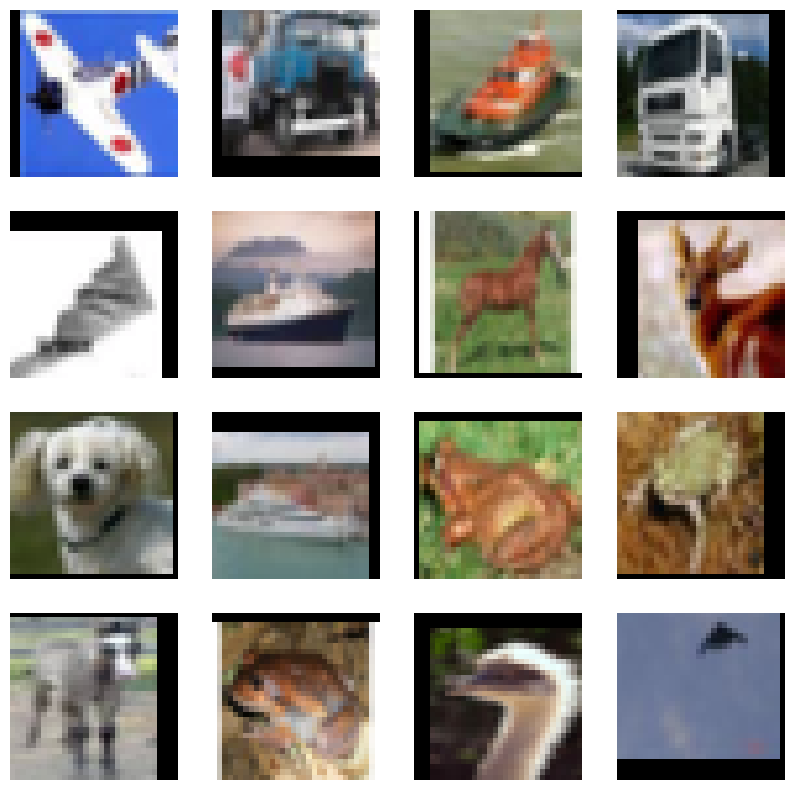

In [4]:
# Load data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_split = int(0.8 * len(trainset))
validation_split = len(trainset) - train_split
train_dataset, val_dataset = random_split(trainset, [train_split, validation_split])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def denormalize_image(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img.device)
    img = img * std + mean
    img = img.clamp(0, 1)
    return img

def show_img():
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(16):
        img = denormalize_image(images[i])
        img = img.cpu().permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis("off")

    plt.show()
show_img()

In [5]:
# lr and epoch
learning_r = [0.001, 0.0001]
epochs_list = [10, 20]

# activation
activations = {
    "ReLU": nn.ReLU,
    "LeakyReLU": nn.LeakyReLU
}

num_classes = 10

In [6]:
# models
total_results = []
def create_models(activation=nn.ReLU):
    resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for name, param in resnet18.named_parameters():
        if "layer4" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    num_features = resnet18.fc.in_features
    resnet18.fc = nn.Sequential(
        nn.Linear(num_features, 10),
        activation()
    )
    vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in vgg16.features.parameters():
        param.requires_grad = False
    num_features = vgg16.classifier[6].in_features
    vgg16.classifier[6] = nn.Linear(num_features, 10)
    return resnet18.to(device), vgg16.to(device)

# loss function
loss_func = nn.CrossEntropyLoss()

# SGD
def get_optimizer(model, lr):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)



In [7]:
# train
def train_model(model, optimizer, epoch_num=10, log_interval=50, patience=10):
    model.train()
    training_loss_his=[]
    val_loss_his= []
    batch_loss = []
    no_improvement = 0
    last_loss = float('inf')
    for epoch in range(epoch_num):
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/{epoch_num}", leave=False)
        model.train()
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_loss.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            progress_bar.set_postfix(loss=loss.item())
            if batch_idx % log_interval == 0:
                print(f"Batch {batch_idx}/{len(trainloader)} - Loss: {running_loss / log_interval:.4f}")
                running_loss = 0.0
        avg_loss = sum(batch_loss) / len(batch_loss)
        training_loss_his.append(avg_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in validationloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_func(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(validationloader)
        val_loss_his.append(val_loss)
        if val_loss >= last_loss:
            no_improvement += 1
        else:
            no_improvement = 0
            last_loss = val_loss
        # early stopping if no change in 10 (not necessary)
        if no_improvement >= patience:
            print(f"stopping triggered at Epoch {epoch+1} due to no improvement for {patience} epochs")
            break
        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)
        print(f"Epoch {epoch+1}/{epoch_num} - Train Loss: {avg_loss:.4f} - Val Loss: {val_loss:.4f} - Accuracy: {accuracy:.2f}%")

    print("Training finished.")
    return training_loss_his, val_loss_his, avg_loss, accuracy, precision, recall, f1


In [8]:
for act_name, activation in activations.items():
    resnet18, vgg16 = create_models(activation)

    for model, model_name in [(resnet18, "ResNet-18"), (vgg16, "VGG-16")]:
        for lr in learning_r:
            for epoch_num in epochs_list:
                optimizer = get_optimizer(model, lr)

                print(f"\nTraining {model_name} with {act_name}, LR={lr}, Epochs={epoch_num}")
                training_loss_his, val_loss_his, avg_loss, accuracy, precision, recall, f1 = train_model(model, optimizer, epoch_num)

                # Store results
                total_results.append((model_name, epoch_num, lr, act_name, training_loss_his, val_loss_his, avg_loss, accuracy, precision, recall, f1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s]



Training ResNet-18 with ReLU, LR=0.001, Epochs=10


Epoch 1/10:   1%|          | 7/1250 [00:01<03:55,  5.27it/s, loss=2.34]

Batch 0/1250 - Loss: 0.0514


Epoch 1/10:   5%|▌         | 65/1250 [00:02<00:17, 66.08it/s, loss=2.25]

Batch 50/1250 - Loss: 2.1866


Epoch 1/10:   9%|▉         | 118/1250 [00:02<00:12, 91.47it/s, loss=2.05]

Batch 100/1250 - Loss: 1.9745


Epoch 1/10:  13%|█▎        | 166/1250 [00:03<00:10, 108.09it/s, loss=1.28]

Batch 150/1250 - Loss: 1.8114


Epoch 1/10:  17%|█▋        | 213/1250 [00:03<00:09, 109.25it/s, loss=2]   

Batch 200/1250 - Loss: 1.7370


Epoch 1/10:  22%|██▏       | 273/1250 [00:04<00:08, 110.79it/s, loss=1.35]

Batch 250/1250 - Loss: 1.6601


Epoch 1/10:  26%|██▌       | 321/1250 [00:04<00:08, 109.88it/s, loss=1.6] 

Batch 300/1250 - Loss: 1.6725


Epoch 1/10:  30%|██▉       | 369/1250 [00:05<00:07, 115.11it/s, loss=1.55]

Batch 350/1250 - Loss: 1.5751


Epoch 1/10:  33%|███▎      | 418/1250 [00:05<00:07, 117.62it/s, loss=1.47]

Batch 400/1250 - Loss: 1.5717


Epoch 1/10:  37%|███▋      | 466/1250 [00:05<00:07, 110.25it/s, loss=1.48]

Batch 450/1250 - Loss: 1.5389


Epoch 1/10:  41%|████      | 514/1250 [00:06<00:06, 116.35it/s, loss=1.94]

Batch 500/1250 - Loss: 1.5292


Epoch 1/10:  46%|████▌     | 574/1250 [00:06<00:05, 116.77it/s, loss=1.72]

Batch 550/1250 - Loss: 1.4956


Epoch 1/10:  50%|████▉     | 622/1250 [00:07<00:05, 115.77it/s, loss=1.84]

Batch 600/1250 - Loss: 1.4500


Epoch 1/10:  54%|█████▎    | 670/1250 [00:07<00:04, 117.08it/s, loss=1.48]

Batch 650/1250 - Loss: 1.4845


Epoch 1/10:  57%|█████▋    | 718/1250 [00:08<00:04, 116.42it/s, loss=1.15]

Batch 700/1250 - Loss: 1.4533


Epoch 1/10:  61%|██████▏   | 767/1250 [00:08<00:04, 116.29it/s, loss=1.65]

Batch 750/1250 - Loss: 1.4365


Epoch 1/10:  65%|██████▌   | 813/1250 [00:09<00:04, 107.41it/s, loss=1.82]

Batch 800/1250 - Loss: 1.4370


Epoch 1/10:  70%|██████▉   | 873/1250 [00:09<00:03, 113.44it/s, loss=1.58]

Batch 850/1250 - Loss: 1.5217


Epoch 1/10:  74%|███████▎  | 921/1250 [00:09<00:02, 112.24it/s, loss=1.54]

Batch 900/1250 - Loss: 1.4258


Epoch 1/10:  77%|███████▋  | 968/1250 [00:10<00:02, 106.90it/s, loss=1.49]

Batch 950/1250 - Loss: 1.3592


Epoch 1/10:  81%|████████  | 1012/1250 [00:10<00:02, 104.24it/s, loss=1.31]

Batch 1000/1250 - Loss: 1.4092


Epoch 1/10:  86%|████████▌ | 1073/1250 [00:11<00:01, 116.02it/s, loss=2.12]

Batch 1050/1250 - Loss: 1.3700


Epoch 1/10:  90%|████████▉ | 1121/1250 [00:11<00:01, 110.73it/s, loss=1.2] 

Batch 1100/1250 - Loss: 1.3830


Epoch 1/10:  94%|█████████▎| 1169/1250 [00:12<00:00, 112.80it/s, loss=1.1] 

Batch 1150/1250 - Loss: 1.2967


Epoch 1/10:  97%|█████████▋| 1217/1250 [00:12<00:00, 112.33it/s, loss=1.28]

Batch 1200/1250 - Loss: 1.4057


Epoch 1/10 - Train Loss: 1.5439 - Val Loss: 1.2775 - Accuracy: 45.88%


Epoch 2/10:   1%|          | 7/1250 [00:00<00:18, 67.17it/s, loss=1.54]

Batch 0/1250 - Loss: 0.0298


Epoch 2/10:   6%|▌         | 69/1250 [00:00<00:11, 101.54it/s, loss=1.47]

Batch 50/1250 - Loss: 1.3666


Epoch 2/10:   9%|▉         | 116/1250 [00:01<00:10, 111.70it/s, loss=1.32]

Batch 100/1250 - Loss: 1.2886


Epoch 2/10:  13%|█▎        | 164/1250 [00:01<00:09, 111.62it/s, loss=1.22] 

Batch 150/1250 - Loss: 1.3247


Epoch 2/10:  18%|█▊        | 222/1250 [00:02<00:09, 108.52it/s, loss=1.26]

Batch 200/1250 - Loss: 1.2641


Epoch 2/10:  22%|██▏       | 271/1250 [00:02<00:09, 107.84it/s, loss=1.5]

Batch 250/1250 - Loss: 1.3258


Epoch 2/10:  26%|██▌       | 319/1250 [00:03<00:08, 113.23it/s, loss=1.13]

Batch 300/1250 - Loss: 1.3589


Epoch 2/10:  29%|██▉       | 367/1250 [00:03<00:07, 113.19it/s, loss=1.17]

Batch 350/1250 - Loss: 1.2813


Epoch 2/10:  33%|███▎      | 416/1250 [00:03<00:07, 117.19it/s, loss=1.03]

Batch 400/1250 - Loss: 1.2951


Epoch 2/10:  37%|███▋      | 464/1250 [00:04<00:06, 114.10it/s, loss=1.05]

Batch 450/1250 - Loss: 1.2825


Epoch 2/10:  41%|████      | 512/1250 [00:04<00:06, 109.69it/s, loss=0.913]

Batch 500/1250 - Loss: 1.2721


Epoch 2/10:  45%|████▌     | 568/1250 [00:05<00:06, 104.60it/s, loss=1.38]

Batch 550/1250 - Loss: 1.2520


Epoch 2/10:  49%|████▉     | 615/1250 [00:05<00:05, 113.21it/s, loss=1.51]

Batch 600/1250 - Loss: 1.2775


Epoch 2/10:  53%|█████▎    | 663/1250 [00:06<00:05, 108.41it/s, loss=1.7]  

Batch 650/1250 - Loss: 1.2432


Epoch 2/10:  57%|█████▋    | 712/1250 [00:06<00:04, 115.39it/s, loss=1.44]

Batch 700/1250 - Loss: 1.2684


Epoch 2/10:  62%|██████▏   | 772/1250 [00:07<00:04, 111.95it/s, loss=0.999]

Batch 750/1250 - Loss: 1.2200


Epoch 2/10:  66%|██████▌   | 821/1250 [00:07<00:03, 116.38it/s, loss=1.55] 

Batch 800/1250 - Loss: 1.2393


Epoch 2/10:  69%|██████▉   | 868/1250 [00:07<00:03, 101.20it/s, loss=1.17]

Batch 850/1250 - Loss: 1.2235


Epoch 2/10:  73%|███████▎  | 914/1250 [00:08<00:03, 109.45it/s, loss=1.49]

Batch 900/1250 - Loss: 1.3116


Epoch 2/10:  77%|███████▋  | 962/1250 [00:08<00:02, 113.73it/s, loss=1.37]

Batch 950/1250 - Loss: 1.2708


Epoch 2/10:  82%|████████▏ | 1022/1250 [00:09<00:02, 113.13it/s, loss=1.34]

Batch 1000/1250 - Loss: 1.2689


Epoch 2/10:  86%|████████▌ | 1069/1250 [00:09<00:01, 105.07it/s, loss=1.24]

Batch 1050/1250 - Loss: 1.2177


Epoch 2/10:  89%|████████▉ | 1114/1250 [00:10<00:01, 104.20it/s, loss=1.08]

Batch 1100/1250 - Loss: 1.2259


Epoch 2/10:  93%|█████████▎| 1161/1250 [00:10<00:00, 109.13it/s, loss=1.49]

Batch 1150/1250 - Loss: 1.2593


Epoch 2/10:  98%|█████████▊| 1219/1250 [00:11<00:00, 105.26it/s, loss=1.25]

Batch 1200/1250 - Loss: 1.2463


Epoch 2/10 - Train Loss: 1.4072 - Val Loss: 1.1911 - Accuracy: 55.08%


Epoch 3/10:   1%|          | 9/1250 [00:00<00:14, 85.49it/s, loss=1.29]

Batch 0/1250 - Loss: 0.0287


Epoch 3/10:   6%|▌         | 69/1250 [00:00<00:10, 114.85it/s, loss=1.35]

Batch 50/1250 - Loss: 1.2650


Epoch 3/10:   9%|▉         | 117/1250 [00:01<00:10, 111.10it/s, loss=1.17]

Batch 100/1250 - Loss: 1.2372


Epoch 3/10:  13%|█▎        | 165/1250 [00:01<00:09, 114.30it/s, loss=1.07]

Batch 150/1250 - Loss: 1.2036


Epoch 3/10:  17%|█▋        | 213/1250 [00:01<00:09, 113.91it/s, loss=1.34]

Batch 200/1250 - Loss: 1.1919


Epoch 3/10:  22%|██▏       | 274/1250 [00:02<00:08, 118.29it/s, loss=1.83]

Batch 250/1250 - Loss: 1.1931


Epoch 3/10:  26%|██▌       | 322/1250 [00:02<00:08, 113.48it/s, loss=1.05]

Batch 300/1250 - Loss: 1.2153


Epoch 3/10:  30%|██▉       | 371/1250 [00:03<00:07, 115.12it/s, loss=0.809]

Batch 350/1250 - Loss: 1.1921


Epoch 3/10:  34%|███▎      | 419/1250 [00:03<00:07, 110.45it/s, loss=1.17] 

Batch 400/1250 - Loss: 1.1611


Epoch 3/10:  37%|███▋      | 467/1250 [00:04<00:07, 109.56it/s, loss=1.18]

Batch 450/1250 - Loss: 1.2040


Epoch 3/10:  41%|████      | 514/1250 [00:04<00:06, 110.38it/s, loss=0.832]

Batch 500/1250 - Loss: 1.2467


Epoch 3/10:  46%|████▌     | 571/1250 [00:05<00:06, 105.16it/s, loss=1.28]

Batch 550/1250 - Loss: 1.2603


Epoch 3/10:  50%|████▉     | 619/1250 [00:05<00:05, 112.13it/s, loss=1.17]

Batch 600/1250 - Loss: 1.1650


Epoch 3/10:  53%|█████▎    | 665/1250 [00:06<00:05, 102.90it/s, loss=1.05] 

Batch 650/1250 - Loss: 1.1932


Epoch 3/10:  58%|█████▊    | 721/1250 [00:06<00:05, 104.76it/s, loss=0.705]

Batch 700/1250 - Loss: 1.1404


Epoch 3/10:  61%|██████▏   | 766/1250 [00:07<00:04, 103.52it/s, loss=0.839]

Batch 750/1250 - Loss: 1.1460


Epoch 3/10:  65%|██████▍   | 812/1250 [00:07<00:04, 103.98it/s, loss=1.24]

Batch 800/1250 - Loss: 1.1961


Epoch 3/10:  69%|██████▉   | 865/1250 [00:08<00:03, 99.00it/s, loss=1.09] 

Batch 850/1250 - Loss: 1.1998


Epoch 3/10:  74%|███████▎  | 921/1250 [00:08<00:03, 101.59it/s, loss=1.17]

Batch 900/1250 - Loss: 1.2265


Epoch 3/10:  77%|███████▋  | 965/1250 [00:08<00:02, 98.99it/s, loss=1.23]

Batch 950/1250 - Loss: 1.1083


Epoch 3/10:  82%|████████▏ | 1021/1250 [00:09<00:02, 104.15it/s, loss=1.21]

Batch 1000/1250 - Loss: 1.2025


Epoch 3/10:  85%|████████▌ | 1068/1250 [00:09<00:01, 109.14it/s, loss=1.11]

Batch 1050/1250 - Loss: 1.1875


Epoch 3/10:  89%|████████▉ | 1116/1250 [00:10<00:01, 109.59it/s, loss=1.24]

Batch 1100/1250 - Loss: 1.1987


Epoch 3/10:  93%|█████████▎| 1160/1250 [00:10<00:00, 104.54it/s, loss=1.11]

Batch 1150/1250 - Loss: 1.1649


Epoch 3/10:  97%|█████████▋| 1213/1250 [00:11<00:00, 96.04it/s, loss=1.04] 

Batch 1200/1250 - Loss: 1.1581


Epoch 3/10 - Train Loss: 1.3357 - Val Loss: 1.1400 - Accuracy: 57.99%


Epoch 4/10:   1%|          | 7/1250 [00:00<00:19, 65.25it/s, loss=1.29]

Batch 0/1250 - Loss: 0.0202


Epoch 4/10:   5%|▍         | 60/1250 [00:00<00:12, 95.63it/s, loss=1.15] 

Batch 50/1250 - Loss: 1.1116


Epoch 4/10:  10%|▉         | 120/1250 [00:01<00:10, 109.49it/s, loss=1.17]

Batch 100/1250 - Loss: 1.1519


Epoch 4/10:  13%|█▎        | 167/1250 [00:01<00:09, 111.73it/s, loss=1.18]

Batch 150/1250 - Loss: 1.1511


Epoch 4/10:  17%|█▋        | 215/1250 [00:02<00:09, 111.45it/s, loss=1.14]

Batch 200/1250 - Loss: 1.1970


Epoch 4/10:  21%|██        | 263/1250 [00:02<00:08, 111.54it/s, loss=1.07]

Batch 250/1250 - Loss: 1.1219


Epoch 4/10:  25%|██▍       | 310/1250 [00:03<00:09, 103.23it/s, loss=1.29]

Batch 300/1250 - Loss: 1.1639


Epoch 4/10:  29%|██▉       | 368/1250 [00:03<00:08, 108.74it/s, loss=1.34]

Batch 350/1250 - Loss: 1.1003


Epoch 4/10:  33%|███▎      | 415/1250 [00:03<00:07, 104.73it/s, loss=0.612]

Batch 400/1250 - Loss: 1.1164


Epoch 4/10:  38%|███▊      | 469/1250 [00:04<00:07, 98.21it/s, loss=1.35]

Batch 450/1250 - Loss: 1.1557


Epoch 4/10:  41%|████      | 512/1250 [00:04<00:07, 99.57it/s, loss=1.1] 

Batch 500/1250 - Loss: 1.1256


Epoch 4/10:  45%|████▍     | 562/1250 [00:05<00:07, 92.40it/s, loss=1.05]

Batch 550/1250 - Loss: 1.2087


Epoch 4/10:  49%|████▉     | 613/1250 [00:06<00:07, 90.51it/s, loss=1.29]

Batch 600/1250 - Loss: 1.1101


Epoch 4/10:  53%|█████▎    | 662/1250 [00:06<00:06, 90.17it/s, loss=1.31]

Batch 650/1250 - Loss: 1.1909


Epoch 4/10:  57%|█████▋    | 712/1250 [00:07<00:05, 92.60it/s, loss=1.2] 

Batch 700/1250 - Loss: 1.1947


Epoch 4/10:  61%|██████    | 763/1250 [00:07<00:05, 93.66it/s, loss=0.938]

Batch 750/1250 - Loss: 1.1256


Epoch 4/10:  65%|██████▌   | 814/1250 [00:08<00:04, 97.51it/s, loss=1.14] 

Batch 800/1250 - Loss: 1.1767


Epoch 4/10:  70%|██████▉   | 871/1250 [00:08<00:03, 104.86it/s, loss=1.61]

Batch 850/1250 - Loss: 1.0889


Epoch 4/10:  73%|███████▎  | 918/1250 [00:09<00:03, 108.90it/s, loss=1.39]

Batch 900/1250 - Loss: 1.1352


Epoch 4/10:  77%|███████▋  | 963/1250 [00:09<00:02, 103.68it/s, loss=1.38] 

Batch 950/1250 - Loss: 1.1748


Epoch 4/10:  82%|████████▏ | 1020/1250 [00:10<00:02, 106.20it/s, loss=1.27]

Batch 1000/1250 - Loss: 1.1170


Epoch 4/10:  85%|████████▌ | 1065/1250 [00:10<00:01, 104.33it/s, loss=0.954]

Batch 1050/1250 - Loss: 1.1359


Epoch 4/10:  90%|████████▉ | 1122/1250 [00:11<00:01, 110.15it/s, loss=0.852]

Batch 1100/1250 - Loss: 1.1199


Epoch 4/10:  93%|█████████▎| 1167/1250 [00:11<00:00, 101.86it/s, loss=1.65] 

Batch 1150/1250 - Loss: 1.0987


Epoch 4/10:  97%|█████████▋| 1212/1250 [00:12<00:00, 102.81it/s, loss=0.882]

Batch 1200/1250 - Loss: 1.1198


Epoch 4/10 - Train Loss: 1.2870 - Val Loss: 1.0753 - Accuracy: 59.92%


Epoch 5/10:   1%|          | 9/1250 [00:00<00:14, 85.01it/s, loss=0.709]

Batch 0/1250 - Loss: 0.0161


Epoch 5/10:   6%|▌         | 69/1250 [00:00<00:10, 110.86it/s, loss=1.26]

Batch 50/1250 - Loss: 1.1279


Epoch 5/10:   9%|▉         | 117/1250 [00:01<00:10, 112.13it/s, loss=1.11]

Batch 100/1250 - Loss: 1.1463


Epoch 5/10:  13%|█▎        | 165/1250 [00:01<00:09, 112.47it/s, loss=0.91] 

Batch 150/1250 - Loss: 1.0800


Epoch 5/10:  17%|█▋        | 213/1250 [00:02<00:09, 111.17it/s, loss=1.17] 

Batch 200/1250 - Loss: 1.0774


Epoch 5/10:  22%|██▏       | 273/1250 [00:02<00:08, 110.41it/s, loss=1.3]

Batch 250/1250 - Loss: 1.0761


Epoch 5/10:  26%|██▌       | 321/1250 [00:02<00:08, 113.02it/s, loss=0.979]

Batch 300/1250 - Loss: 1.1471


Epoch 5/10:  30%|██▉       | 369/1250 [00:03<00:07, 114.76it/s, loss=0.96]

Batch 350/1250 - Loss: 1.1155


Epoch 5/10:  33%|███▎      | 417/1250 [00:03<00:07, 105.96it/s, loss=1.06]

Batch 400/1250 - Loss: 1.1146


Epoch 5/10:  38%|███▊      | 474/1250 [00:04<00:07, 110.12it/s, loss=0.998]

Batch 450/1250 - Loss: 1.0729


Epoch 5/10:  41%|████      | 510/1250 [00:04<00:06, 112.15it/s, loss=1.18]

Batch 500/1250 - Loss: 1.1362


Epoch 5/10:  45%|████▌     | 566/1250 [00:05<00:06, 106.36it/s, loss=1.01]

Batch 550/1250 - Loss: 1.1183


Epoch 5/10:  49%|████▉     | 615/1250 [00:05<00:05, 112.21it/s, loss=1.04] 

Batch 600/1250 - Loss: 1.0977


Epoch 5/10:  53%|█████▎    | 663/1250 [00:06<00:05, 112.54it/s, loss=0.755]

Batch 650/1250 - Loss: 1.1260


Epoch 5/10:  58%|█████▊    | 723/1250 [00:06<00:04, 115.98it/s, loss=1.23]

Batch 700/1250 - Loss: 1.1015


Epoch 5/10:  62%|██████▏   | 771/1250 [00:06<00:04, 110.94it/s, loss=1.12] 

Batch 750/1250 - Loss: 1.0773


Epoch 5/10:  65%|██████▌   | 817/1250 [00:07<00:04, 107.11it/s, loss=0.775]

Batch 800/1250 - Loss: 1.1041


Epoch 5/10:  69%|██████▉   | 865/1250 [00:07<00:03, 112.27it/s, loss=0.995]

Batch 850/1250 - Loss: 1.0746


Epoch 5/10:  73%|███████▎  | 913/1250 [00:08<00:02, 115.44it/s, loss=1.14]

Batch 900/1250 - Loss: 1.0935


Epoch 5/10:  77%|███████▋  | 962/1250 [00:08<00:02, 104.34it/s, loss=1.23] 

Batch 950/1250 - Loss: 1.1276


Epoch 5/10:  82%|████████▏ | 1019/1250 [00:09<00:02, 107.44it/s, loss=1.01]

Batch 1000/1250 - Loss: 1.1246


Epoch 5/10:  85%|████████▌ | 1065/1250 [00:09<00:01, 111.08it/s, loss=1.2]  

Batch 1050/1250 - Loss: 1.0903


Epoch 5/10:  89%|████████▉ | 1113/1250 [00:10<00:01, 109.69it/s, loss=1.26]

Batch 1100/1250 - Loss: 1.1276


Epoch 5/10:  94%|█████████▍| 1173/1250 [00:10<00:00, 111.97it/s, loss=0.752]

Batch 1150/1250 - Loss: 1.1055


Epoch 5/10:  97%|█████████▋| 1218/1250 [00:11<00:00, 107.41it/s, loss=1.25]

Batch 1200/1250 - Loss: 1.1083


Epoch 5/10 - Train Loss: 1.2506 - Val Loss: 1.0520 - Accuracy: 61.15%


Epoch 6/10:   1%|          | 7/1250 [00:00<00:18, 68.69it/s, loss=1.22]

Batch 0/1250 - Loss: 0.0264


Epoch 6/10:   5%|▌         | 65/1250 [00:00<00:10, 110.16it/s, loss=1.26] 

Batch 50/1250 - Loss: 1.0679


Epoch 6/10:   9%|▉         | 112/1250 [00:01<00:10, 110.62it/s, loss=0.982]

Batch 100/1250 - Loss: 1.1246


Epoch 6/10:  14%|█▍        | 172/1250 [00:01<00:09, 112.38it/s, loss=0.879]

Batch 150/1250 - Loss: 1.0665


Epoch 6/10:  17%|█▋        | 217/1250 [00:02<00:10, 102.89it/s, loss=0.945]

Batch 200/1250 - Loss: 1.1378


Epoch 6/10:  21%|██        | 263/1250 [00:02<00:09, 109.00it/s, loss=1.22]

Batch 250/1250 - Loss: 1.0977


Epoch 6/10:  25%|██▌       | 318/1250 [00:03<00:09, 103.21it/s, loss=1.18]

Batch 300/1250 - Loss: 1.0866


Epoch 6/10:  30%|██▉       | 372/1250 [00:03<00:08, 103.18it/s, loss=0.999]

Batch 350/1250 - Loss: 1.1262


Epoch 6/10:  33%|███▎      | 417/1250 [00:04<00:08, 103.10it/s, loss=1.07]

Batch 400/1250 - Loss: 1.0532


Epoch 6/10:  37%|███▋      | 464/1250 [00:04<00:07, 110.85it/s, loss=1.12]

Batch 450/1250 - Loss: 1.0855


Epoch 6/10:  42%|████▏     | 521/1250 [00:04<00:06, 106.15it/s, loss=1.13]

Batch 500/1250 - Loss: 1.1034


Epoch 6/10:  45%|████▌     | 566/1250 [00:05<00:06, 107.22it/s, loss=0.911]

Batch 550/1250 - Loss: 1.0749


Epoch 6/10:  49%|████▉     | 611/1250 [00:05<00:06, 103.71it/s, loss=1.03]

Batch 600/1250 - Loss: 1.0231


Epoch 6/10:  54%|█████▎    | 670/1250 [00:06<00:05, 110.90it/s, loss=1.07] 

Batch 650/1250 - Loss: 1.0724


Epoch 6/10:  58%|█████▊    | 719/1250 [00:06<00:04, 113.42it/s, loss=0.773]

Batch 700/1250 - Loss: 1.0776


Epoch 6/10:  61%|██████▏   | 767/1250 [00:07<00:04, 112.90it/s, loss=1.29] 

Batch 750/1250 - Loss: 1.0317


Epoch 6/10:  65%|██████▌   | 815/1250 [00:07<00:03, 111.69it/s, loss=0.941]

Batch 800/1250 - Loss: 1.0536


Epoch 6/10:  69%|██████▉   | 861/1250 [00:08<00:03, 108.33it/s, loss=1.16] 

Batch 850/1250 - Loss: 1.0857


Epoch 6/10:  74%|███████▎  | 921/1250 [00:08<00:03, 107.78it/s, loss=1.04]

Batch 900/1250 - Loss: 1.1197


Epoch 6/10:  77%|███████▋  | 968/1250 [00:09<00:02, 109.70it/s, loss=0.59]

Batch 950/1250 - Loss: 1.0585


Epoch 6/10:  81%|████████▏ | 1016/1250 [00:09<00:02, 115.46it/s, loss=0.64]

Batch 1000/1250 - Loss: 1.0700


Epoch 6/10:  85%|████████▌ | 1064/1250 [00:09<00:01, 110.60it/s, loss=1.18] 

Batch 1050/1250 - Loss: 1.0571


Epoch 6/10:  90%|████████▉ | 1124/1250 [00:10<00:01, 114.53it/s, loss=1.18]

Batch 1100/1250 - Loss: 1.0569


Epoch 6/10:  94%|█████████▎| 1171/1250 [00:10<00:00, 105.80it/s, loss=1.03]

Batch 1150/1250 - Loss: 1.0220


Epoch 6/10:  97%|█████████▋| 1218/1250 [00:11<00:00, 111.70it/s, loss=1.64]

Batch 1200/1250 - Loss: 1.0793


Epoch 6/10 - Train Loss: 1.2218 - Val Loss: 1.0279 - Accuracy: 62.32%


Epoch 7/10:   1%|          | 8/1250 [00:00<00:17, 72.94it/s, loss=0.94]

Batch 0/1250 - Loss: 0.0223


Epoch 7/10:   5%|▌         | 63/1250 [00:00<00:11, 105.16it/s, loss=1.1] 

Batch 50/1250 - Loss: 1.0567


Epoch 7/10:  10%|▉         | 121/1250 [00:01<00:10, 105.53it/s, loss=0.981]

Batch 100/1250 - Loss: 1.0559


Epoch 7/10:  13%|█▎        | 165/1250 [00:01<00:10, 102.29it/s, loss=1.11] 

Batch 150/1250 - Loss: 1.0585


Epoch 7/10:  18%|█▊        | 224/1250 [00:02<00:09, 113.08it/s, loss=1.38]

Batch 200/1250 - Loss: 1.0548


Epoch 7/10:  22%|██▏       | 272/1250 [00:02<00:08, 113.74it/s, loss=1.18]

Batch 250/1250 - Loss: 1.0226


Epoch 7/10:  26%|██▌       | 320/1250 [00:03<00:08, 112.51it/s, loss=0.761]

Batch 300/1250 - Loss: 1.0062


Epoch 7/10:  29%|██▉       | 368/1250 [00:03<00:08, 109.10it/s, loss=1.03]

Batch 350/1250 - Loss: 1.0713


Epoch 7/10:  33%|███▎      | 416/1250 [00:03<00:07, 110.88it/s, loss=1.06]

Batch 400/1250 - Loss: 1.0424


Epoch 7/10:  37%|███▋      | 464/1250 [00:04<00:07, 107.45it/s, loss=1.5] 

Batch 450/1250 - Loss: 1.0519


Epoch 7/10:  42%|████▏     | 521/1250 [00:04<00:06, 108.54it/s, loss=0.884]

Batch 500/1250 - Loss: 1.0668


Epoch 7/10:  45%|████▌     | 568/1250 [00:05<00:06, 112.33it/s, loss=1.5]  

Batch 550/1250 - Loss: 1.0439


Epoch 7/10:  49%|████▉     | 616/1250 [00:05<00:05, 111.09it/s, loss=1.07] 

Batch 600/1250 - Loss: 1.0313


Epoch 7/10:  53%|█████▎    | 663/1250 [00:06<00:05, 106.82it/s, loss=0.916]

Batch 650/1250 - Loss: 1.0579


Epoch 7/10:  58%|█████▊    | 723/1250 [00:06<00:04, 113.26it/s, loss=1.36]

Batch 700/1250 - Loss: 1.0309


Epoch 7/10:  62%|██████▏   | 773/1250 [00:07<00:04, 117.78it/s, loss=1.23]

Batch 750/1250 - Loss: 1.1003


Epoch 7/10:  65%|██████▍   | 809/1250 [00:07<00:03, 117.21it/s, loss=1.17]

Batch 800/1250 - Loss: 1.0355


Epoch 7/10:  69%|██████▉   | 868/1250 [00:07<00:03, 108.32it/s, loss=1.06]

Batch 850/1250 - Loss: 1.0612


Epoch 7/10:  73%|███████▎  | 916/1250 [00:08<00:03, 108.31it/s, loss=0.948]

Batch 900/1250 - Loss: 1.0347


Epoch 7/10:  77%|███████▋  | 961/1250 [00:08<00:02, 104.26it/s, loss=1.07]

Batch 950/1250 - Loss: 1.1048


Epoch 7/10:  82%|████████▏ | 1019/1250 [00:09<00:02, 110.01it/s, loss=1.12]

Batch 1000/1250 - Loss: 1.0475


Epoch 7/10:  85%|████████▌ | 1064/1250 [00:09<00:01, 104.71it/s, loss=1.06] 

Batch 1050/1250 - Loss: 1.0231


Epoch 7/10:  90%|████████▉ | 1119/1250 [00:10<00:01, 100.50it/s, loss=1.12]

Batch 1100/1250 - Loss: 1.0269


Epoch 7/10:  93%|█████████▎| 1165/1250 [00:10<00:00, 106.32it/s, loss=0.86]

Batch 1150/1250 - Loss: 1.0425


Epoch 7/10:  98%|█████████▊| 1223/1250 [00:11<00:00, 109.04it/s, loss=1.16]

Batch 1200/1250 - Loss: 1.0399


Epoch 7/10 - Train Loss: 1.1974 - Val Loss: 1.0089 - Accuracy: 63.16%


Epoch 8/10:   1%|          | 8/1250 [00:00<00:15, 79.62it/s, loss=1.48]

Batch 0/1250 - Loss: 0.0183


Epoch 8/10:   5%|▌         | 63/1250 [00:00<00:11, 105.88it/s, loss=1.18]

Batch 50/1250 - Loss: 0.9998


Epoch 8/10:  10%|▉         | 120/1250 [00:01<00:10, 103.08it/s, loss=0.874]

Batch 100/1250 - Loss: 1.0117


Epoch 8/10:  13%|█▎        | 165/1250 [00:01<00:10, 104.30it/s, loss=1.36] 

Batch 150/1250 - Loss: 1.0181


Epoch 8/10:  17%|█▋        | 213/1250 [00:02<00:09, 111.21it/s, loss=1.25]

Batch 200/1250 - Loss: 1.0807


Epoch 8/10:  22%|██▏       | 273/1250 [00:02<00:08, 112.72it/s, loss=1.01]

Batch 250/1250 - Loss: 1.0276


Epoch 8/10:  26%|██▌       | 321/1250 [00:03<00:08, 109.03it/s, loss=1.03]

Batch 300/1250 - Loss: 1.0340


Epoch 8/10:  29%|██▉       | 366/1250 [00:03<00:08, 108.12it/s, loss=0.851]

Batch 350/1250 - Loss: 1.0346


Epoch 8/10:  33%|███▎      | 414/1250 [00:03<00:07, 108.61it/s, loss=1.13] 

Batch 400/1250 - Loss: 0.9812


Epoch 8/10:  37%|███▋      | 462/1250 [00:04<00:07, 109.49it/s, loss=0.745]

Batch 450/1250 - Loss: 1.0449


Epoch 8/10:  42%|████▏     | 522/1250 [00:04<00:06, 113.08it/s, loss=1.24]

Batch 500/1250 - Loss: 1.0698


Epoch 8/10:  46%|████▌     | 569/1250 [00:05<00:06, 105.76it/s, loss=1.2] 

Batch 550/1250 - Loss: 1.0354


Epoch 8/10:  49%|████▉     | 616/1250 [00:05<00:06, 105.06it/s, loss=1.05]

Batch 600/1250 - Loss: 1.0095


Epoch 8/10:  54%|█████▍    | 672/1250 [00:06<00:05, 105.96it/s, loss=0.524]

Batch 650/1250 - Loss: 1.0641


Epoch 8/10:  58%|█████▊    | 720/1250 [00:06<00:04, 114.53it/s, loss=1.06] 

Batch 700/1250 - Loss: 0.9906


Epoch 8/10:  62%|██████▏   | 769/1250 [00:07<00:04, 111.00it/s, loss=0.945]

Batch 750/1250 - Loss: 0.9730


Epoch 8/10:  65%|██████▌   | 818/1250 [00:07<00:03, 111.99it/s, loss=1.11] 

Batch 800/1250 - Loss: 0.9740


Epoch 8/10:  69%|██████▉   | 866/1250 [00:08<00:03, 109.38it/s, loss=1.03]

Batch 850/1250 - Loss: 1.0278


Epoch 8/10:  73%|███████▎  | 914/1250 [00:08<00:03, 108.52it/s, loss=1.15] 

Batch 900/1250 - Loss: 1.0609


Epoch 8/10:  78%|███████▊  | 972/1250 [00:08<00:02, 110.60it/s, loss=1.14] 

Batch 950/1250 - Loss: 0.9813


Epoch 8/10:  82%|████████▏ | 1019/1250 [00:09<00:02, 109.79it/s, loss=1.19] 

Batch 1000/1250 - Loss: 1.0550


Epoch 8/10:  85%|████████▌ | 1065/1250 [00:09<00:01, 107.67it/s, loss=0.868]

Batch 1050/1250 - Loss: 1.0184


Epoch 8/10:  89%|████████▉ | 1112/1250 [00:10<00:01, 103.72it/s, loss=1.59]

Batch 1100/1250 - Loss: 1.0700


Epoch 8/10:  93%|█████████▎| 1168/1250 [00:10<00:00, 104.29it/s, loss=1.18]

Batch 1150/1250 - Loss: 1.0532


Epoch 8/10:  97%|█████████▋| 1213/1250 [00:11<00:00, 103.85it/s, loss=1.15] 

Batch 1200/1250 - Loss: 1.0023


Epoch 8/10 - Train Loss: 1.1762 - Val Loss: 1.0048 - Accuracy: 63.81%


Epoch 9/10:   1%|          | 7/1250 [00:00<00:19, 64.29it/s, loss=1.05]

Batch 0/1250 - Loss: 0.0262


Epoch 9/10:   5%|▍         | 62/1250 [00:00<00:11, 100.01it/s, loss=0.879]

Batch 50/1250 - Loss: 1.0057


Epoch 9/10:  10%|▉         | 120/1250 [00:01<00:10, 107.89it/s, loss=0.906]

Batch 100/1250 - Loss: 0.9958


Epoch 9/10:  13%|█▎        | 166/1250 [00:01<00:10, 103.10it/s, loss=0.959]

Batch 150/1250 - Loss: 1.0081


Epoch 9/10:  18%|█▊        | 223/1250 [00:02<00:09, 109.46it/s, loss=1.09]

Batch 200/1250 - Loss: 0.9884


Epoch 9/10:  22%|██▏       | 269/1250 [00:02<00:09, 105.46it/s, loss=0.787]

Batch 250/1250 - Loss: 1.0352


Epoch 9/10:  25%|██▌       | 317/1250 [00:03<00:08, 111.26it/s, loss=0.965]

Batch 300/1250 - Loss: 1.0283


Epoch 9/10:  29%|██▉       | 364/1250 [00:03<00:08, 105.94it/s, loss=1.09]

Batch 350/1250 - Loss: 0.9800


Epoch 9/10:  33%|███▎      | 412/1250 [00:03<00:07, 105.63it/s, loss=0.967]

Batch 400/1250 - Loss: 1.0060


Epoch 9/10:  38%|███▊      | 472/1250 [00:04<00:06, 111.40it/s, loss=1.19]

Batch 450/1250 - Loss: 0.9648


Epoch 9/10:  42%|████▏     | 519/1250 [00:04<00:06, 109.97it/s, loss=0.747]

Batch 500/1250 - Loss: 1.0404


Epoch 9/10:  45%|████▌     | 567/1250 [00:05<00:05, 115.33it/s, loss=0.973]

Batch 550/1250 - Loss: 1.0247


Epoch 9/10:  49%|████▉     | 615/1250 [00:05<00:05, 113.47it/s, loss=1.05] 

Batch 600/1250 - Loss: 1.0503


Epoch 9/10:  53%|█████▎    | 663/1250 [00:06<00:05, 112.87it/s, loss=1.06]

Batch 650/1250 - Loss: 1.0254


Epoch 9/10:  58%|█████▊    | 723/1250 [00:06<00:04, 112.12it/s, loss=1.27]

Batch 700/1250 - Loss: 0.9780


Epoch 9/10:  61%|██████▏   | 768/1250 [00:07<00:04, 102.03it/s, loss=1.06]

Batch 750/1250 - Loss: 1.0151


Epoch 9/10:  65%|██████▌   | 813/1250 [00:07<00:04, 102.74it/s, loss=0.725]

Batch 800/1250 - Loss: 1.0004


Epoch 9/10:  70%|██████▉   | 870/1250 [00:08<00:03, 109.16it/s, loss=1.49]

Batch 850/1250 - Loss: 1.0613


Epoch 9/10:  73%|███████▎  | 915/1250 [00:08<00:03, 107.63it/s, loss=1.18]

Batch 900/1250 - Loss: 1.0547


Epoch 9/10:  78%|███████▊  | 970/1250 [00:09<00:02, 100.62it/s, loss=1.14]

Batch 950/1250 - Loss: 0.9655


Epoch 9/10:  81%|████████  | 1015/1250 [00:09<00:02, 99.92it/s, loss=0.92]

Batch 1000/1250 - Loss: 0.9820


Epoch 9/10:  85%|████████▌ | 1064/1250 [00:09<00:01, 110.66it/s, loss=0.928]

Batch 1050/1250 - Loss: 1.0164


Epoch 9/10:  89%|████████▉ | 1113/1250 [00:10<00:01, 109.57it/s, loss=0.999]

Batch 1100/1250 - Loss: 1.0094


Epoch 9/10:  94%|█████████▍| 1173/1250 [00:10<00:00, 111.22it/s, loss=0.958]

Batch 1150/1250 - Loss: 1.0029


Epoch 9/10:  98%|█████████▊| 1220/1250 [00:11<00:00, 108.49it/s, loss=0.815]

Batch 1200/1250 - Loss: 1.0238


Epoch 9/10 - Train Loss: 1.1578 - Val Loss: 0.9992 - Accuracy: 64.09%


Epoch 10/10:   1%|          | 9/1250 [00:00<00:14, 84.72it/s, loss=0.968]

Batch 0/1250 - Loss: 0.0241


Epoch 10/10:   6%|▌         | 69/1250 [00:00<00:10, 115.70it/s, loss=1.21]

Batch 50/1250 - Loss: 0.9940


Epoch 10/10:   9%|▉         | 117/1250 [00:01<00:10, 110.49it/s, loss=0.758]

Batch 100/1250 - Loss: 1.0390


Epoch 10/10:  13%|█▎        | 165/1250 [00:01<00:09, 111.67it/s, loss=1.37] 

Batch 150/1250 - Loss: 0.9667


Epoch 10/10:  17%|█▋        | 213/1250 [00:02<00:09, 109.13it/s, loss=1.38] 

Batch 200/1250 - Loss: 0.9690


Epoch 10/10:  21%|██        | 260/1250 [00:02<00:09, 105.99it/s, loss=0.731]

Batch 250/1250 - Loss: 1.0568


Epoch 10/10:  26%|██▌       | 319/1250 [00:02<00:08, 113.30it/s, loss=0.869]

Batch 300/1250 - Loss: 0.9903


Epoch 10/10:  29%|██▉       | 367/1250 [00:03<00:07, 113.86it/s, loss=0.751]

Batch 350/1250 - Loss: 0.9644


Epoch 10/10:  33%|███▎      | 415/1250 [00:03<00:07, 114.43it/s, loss=1.16] 

Batch 400/1250 - Loss: 1.0072


Epoch 10/10:  37%|███▋      | 462/1250 [00:04<00:07, 104.84it/s, loss=0.994]

Batch 450/1250 - Loss: 0.9842


Epoch 10/10:  42%|████▏     | 519/1250 [00:04<00:06, 108.18it/s, loss=1.35] 

Batch 500/1250 - Loss: 0.9954


Epoch 10/10:  45%|████▌     | 566/1250 [00:05<00:06, 112.56it/s, loss=1.05]

Batch 550/1250 - Loss: 1.0175


Epoch 10/10:  49%|████▉     | 613/1250 [00:05<00:05, 109.34it/s, loss=0.973]

Batch 600/1250 - Loss: 0.9696


Epoch 10/10:  54%|█████▎    | 670/1250 [00:06<00:05, 103.50it/s, loss=0.828]

Batch 650/1250 - Loss: 0.9910


Epoch 10/10:  57%|█████▋    | 714/1250 [00:06<00:05, 102.85it/s, loss=1.44]

Batch 700/1250 - Loss: 0.9528


Epoch 10/10:  62%|██████▏   | 770/1250 [00:07<00:04, 105.06it/s, loss=0.779]

Batch 750/1250 - Loss: 1.0158


Epoch 10/10:  65%|██████▌   | 815/1250 [00:07<00:04, 107.01it/s, loss=0.883]

Batch 800/1250 - Loss: 1.0080


Epoch 10/10:  69%|██████▉   | 863/1250 [00:08<00:03, 114.79it/s, loss=1.03] 

Batch 850/1250 - Loss: 0.9815


Epoch 10/10:  74%|███████▍  | 923/1250 [00:08<00:02, 112.20it/s, loss=0.963]

Batch 900/1250 - Loss: 0.9865


Epoch 10/10:  78%|███████▊  | 970/1250 [00:08<00:02, 111.51it/s, loss=1.16]

Batch 950/1250 - Loss: 0.9974


Epoch 10/10:  81%|████████▏ | 1018/1250 [00:09<00:02, 109.68it/s, loss=1.04]

Batch 1000/1250 - Loss: 1.0199


Epoch 10/10:  85%|████████▌ | 1065/1250 [00:09<00:01, 105.81it/s, loss=0.976]

Batch 1050/1250 - Loss: 1.0293


Epoch 10/10:  89%|████████▉ | 1112/1250 [00:10<00:01, 111.82it/s, loss=1.02] 

Batch 1100/1250 - Loss: 1.0464


Epoch 10/10:  94%|█████████▎| 1171/1250 [00:10<00:00, 105.50it/s, loss=1.11]

Batch 1150/1250 - Loss: 1.0121


Epoch 10/10:  97%|█████████▋| 1218/1250 [00:11<00:00, 110.39it/s, loss=0.963]

Batch 1200/1250 - Loss: 1.0050


Epoch 10/10 - Train Loss: 1.1419 - Val Loss: 0.9820 - Accuracy: 64.86%
Training finished.

Training ResNet-18 with ReLU, LR=0.001, Epochs=20


Epoch 1/20:   1%|          | 8/1250 [00:00<00:16, 77.31it/s, loss=1.11] 

Batch 0/1250 - Loss: 0.0167


Epoch 1/20:   5%|▌         | 65/1250 [00:00<00:11, 106.42it/s, loss=0.934]

Batch 50/1250 - Loss: 0.9883


Epoch 1/20:  10%|▉         | 121/1250 [00:01<00:10, 105.56it/s, loss=0.752]

Batch 100/1250 - Loss: 0.9818


Epoch 1/20:  14%|█▎        | 169/1250 [00:01<00:09, 112.28it/s, loss=1.08] 

Batch 150/1250 - Loss: 0.9465


Epoch 1/20:  17%|█▋        | 217/1250 [00:02<00:09, 108.91it/s, loss=0.55]

Batch 200/1250 - Loss: 0.9735


Epoch 1/20:  21%|██        | 263/1250 [00:02<00:09, 108.01it/s, loss=1.78]

Batch 250/1250 - Loss: 0.9950


Epoch 1/20:  25%|██▍       | 311/1250 [00:02<00:08, 105.68it/s, loss=1.15]

Batch 300/1250 - Loss: 0.9776


Epoch 1/20:  30%|██▉       | 369/1250 [00:03<00:08, 110.07it/s, loss=1.02]

Batch 350/1250 - Loss: 0.9854


Epoch 1/20:  33%|███▎      | 415/1250 [00:03<00:08, 104.03it/s, loss=0.767]

Batch 400/1250 - Loss: 0.9994


Epoch 1/20:  37%|███▋      | 461/1250 [00:04<00:07, 105.84it/s, loss=0.959]

Batch 450/1250 - Loss: 0.9483


Epoch 1/20:  41%|████▏     | 518/1250 [00:04<00:06, 106.41it/s, loss=0.929]

Batch 500/1250 - Loss: 0.9988


Epoch 1/20:  45%|████▍     | 562/1250 [00:05<00:06, 106.43it/s, loss=0.849]

Batch 550/1250 - Loss: 0.9774


Epoch 1/20:  49%|████▉     | 617/1250 [00:05<00:06, 104.89it/s, loss=0.977]

Batch 600/1250 - Loss: 0.9830


Epoch 1/20:  53%|█████▎    | 665/1250 [00:06<00:05, 113.72it/s, loss=1.25] 

Batch 650/1250 - Loss: 0.9820


Epoch 1/20:  57%|█████▋    | 713/1250 [00:06<00:05, 104.27it/s, loss=1.02]

Batch 700/1250 - Loss: 0.9540


Epoch 1/20:  62%|██████▏   | 771/1250 [00:07<00:04, 110.30it/s, loss=1.13]

Batch 750/1250 - Loss: 0.9552


Epoch 1/20:  66%|██████▌   | 819/1250 [00:07<00:03, 112.89it/s, loss=1.22]

Batch 800/1250 - Loss: 1.0078


Epoch 1/20:  69%|██████▉   | 867/1250 [00:08<00:03, 114.57it/s, loss=0.731]

Batch 850/1250 - Loss: 1.0405


Epoch 1/20:  73%|███████▎  | 915/1250 [00:08<00:02, 113.73it/s, loss=0.866]

Batch 900/1250 - Loss: 1.0068


Epoch 1/20:  77%|███████▋  | 963/1250 [00:08<00:02, 114.73it/s, loss=1.39]

Batch 950/1250 - Loss: 0.9593


Epoch 1/20:  82%|████████▏ | 1023/1250 [00:09<00:02, 113.34it/s, loss=1.12]

Batch 1000/1250 - Loss: 0.9977


Epoch 1/20:  86%|████████▌ | 1071/1250 [00:09<00:01, 109.79it/s, loss=1.35] 

Batch 1050/1250 - Loss: 0.9644


Epoch 1/20:  90%|████████▉ | 1119/1250 [00:10<00:01, 111.91it/s, loss=0.826]

Batch 1100/1250 - Loss: 0.9515


Epoch 1/20:  93%|█████████▎| 1167/1250 [00:10<00:00, 114.37it/s, loss=0.689]

Batch 1150/1250 - Loss: 0.9971


Epoch 1/20:  97%|█████████▋| 1215/1250 [00:11<00:00, 113.17it/s, loss=0.876]

Batch 1200/1250 - Loss: 1.0157


Epoch 1/20 - Train Loss: 0.9820 - Val Loss: 0.9822 - Accuracy: 65.12%


Epoch 2/20:   1%|          | 8/1250 [00:00<00:16, 75.32it/s, loss=0.784]

Batch 0/1250 - Loss: 0.0189


Epoch 2/20:   5%|▌         | 63/1250 [00:00<00:11, 106.55it/s, loss=1.14]

Batch 50/1250 - Loss: 0.9364


Epoch 2/20:  10%|▉         | 122/1250 [00:01<00:10, 112.13it/s, loss=0.604]

Batch 100/1250 - Loss: 0.9221


Epoch 2/20:  14%|█▎        | 170/1250 [00:01<00:09, 109.66it/s, loss=1.06]

Batch 150/1250 - Loss: 0.9309


Epoch 2/20:  17%|█▋        | 214/1250 [00:02<00:09, 104.06it/s, loss=0.862]

Batch 200/1250 - Loss: 0.9796


Epoch 2/20:  21%|██        | 262/1250 [00:02<00:09, 109.66it/s, loss=0.971]

Batch 250/1250 - Loss: 0.9134


Epoch 2/20:  25%|██▌       | 317/1250 [00:03<00:09, 102.24it/s, loss=1.02]

Batch 300/1250 - Loss: 1.0236


Epoch 2/20:  29%|██▉       | 362/1250 [00:03<00:08, 104.34it/s, loss=0.934]

Batch 350/1250 - Loss: 0.9876


Epoch 2/20:  34%|███▎      | 419/1250 [00:03<00:08, 102.73it/s, loss=0.786]

Batch 400/1250 - Loss: 0.9717


Epoch 2/20:  37%|███▋      | 464/1250 [00:04<00:07, 104.14it/s, loss=0.712]

Batch 450/1250 - Loss: 0.8894


Epoch 2/20:  42%|████▏     | 523/1250 [00:04<00:06, 110.91it/s, loss=1.12]

Batch 500/1250 - Loss: 0.9842


Epoch 2/20:  46%|████▌     | 571/1250 [00:05<00:06, 108.31it/s, loss=1.06] 

Batch 550/1250 - Loss: 0.9931


Epoch 2/20:  49%|████▉     | 618/1250 [00:05<00:05, 108.21it/s, loss=1.08] 

Batch 600/1250 - Loss: 0.9193


Epoch 2/20:  53%|█████▎    | 666/1250 [00:06<00:05, 108.70it/s, loss=1.04]

Batch 650/1250 - Loss: 1.0038


Epoch 2/20:  57%|█████▋    | 714/1250 [00:06<00:04, 111.32it/s, loss=0.993]

Batch 700/1250 - Loss: 0.9771


Epoch 2/20:  62%|██████▏   | 773/1250 [00:07<00:04, 110.32it/s, loss=0.723]

Batch 750/1250 - Loss: 0.9512


Epoch 2/20:  66%|██████▌   | 821/1250 [00:07<00:03, 108.08it/s, loss=0.905]

Batch 800/1250 - Loss: 0.9374


Epoch 2/20:  69%|██████▉   | 865/1250 [00:08<00:03, 105.20it/s, loss=0.971]

Batch 850/1250 - Loss: 0.9235


Epoch 2/20:  73%|███████▎  | 913/1250 [00:08<00:02, 113.47it/s, loss=0.762]

Batch 900/1250 - Loss: 0.9268


Epoch 2/20:  78%|███████▊  | 972/1250 [00:09<00:02, 106.91it/s, loss=0.917]

Batch 950/1250 - Loss: 1.0047


Epoch 2/20:  82%|████████▏ | 1020/1250 [00:09<00:02, 108.21it/s, loss=1.1]  

Batch 1000/1250 - Loss: 0.9799


Epoch 2/20:  85%|████████▌ | 1067/1250 [00:09<00:01, 109.84it/s, loss=1.17] 

Batch 1050/1250 - Loss: 0.9478


Epoch 2/20:  89%|████████▉ | 1113/1250 [00:10<00:01, 107.04it/s, loss=0.997]

Batch 1100/1250 - Loss: 0.9745


Epoch 2/20:  93%|█████████▎| 1168/1250 [00:10<00:00, 105.45it/s, loss=0.782]

Batch 1150/1250 - Loss: 0.9823


Epoch 2/20:  97%|█████████▋| 1214/1250 [00:11<00:00, 109.10it/s, loss=0.764]

Batch 1200/1250 - Loss: 0.9566


Epoch 2/20 - Train Loss: 0.9707 - Val Loss: 0.9716 - Accuracy: 66.14%


Epoch 3/20:   1%|          | 7/1250 [00:00<00:17, 69.69it/s, loss=1]    

Batch 0/1250 - Loss: 0.0202


Epoch 3/20:   5%|▌         | 63/1250 [00:00<00:11, 100.28it/s, loss=1.3] 

Batch 50/1250 - Loss: 0.9314


Epoch 3/20:  10%|▉         | 119/1250 [00:01<00:10, 105.63it/s, loss=0.883]

Batch 100/1250 - Loss: 0.9755


Epoch 3/20:  13%|█▎        | 163/1250 [00:01<00:10, 105.28it/s, loss=0.94] 

Batch 150/1250 - Loss: 0.9334


Epoch 3/20:  18%|█▊        | 219/1250 [00:02<00:10, 102.86it/s, loss=1.03]

Batch 200/1250 - Loss: 0.9419


Epoch 3/20:  21%|██        | 264/1250 [00:02<00:09, 100.91it/s, loss=0.658]

Batch 250/1250 - Loss: 0.9395


Epoch 3/20:  26%|██▌       | 323/1250 [00:03<00:08, 109.66it/s, loss=1.31]

Batch 300/1250 - Loss: 0.9544


Epoch 3/20:  29%|██▊       | 359/1250 [00:03<00:08, 110.38it/s, loss=0.935]

Batch 350/1250 - Loss: 0.9503


Epoch 3/20:  33%|███▎      | 416/1250 [00:04<00:08, 103.61it/s, loss=0.719]

Batch 400/1250 - Loss: 0.8835


Epoch 3/20:  37%|███▋      | 463/1250 [00:04<00:07, 109.19it/s, loss=1.04] 

Batch 450/1250 - Loss: 0.9852


Epoch 3/20:  42%|████▏     | 519/1250 [00:05<00:06, 105.47it/s, loss=1.22]

Batch 500/1250 - Loss: 0.9623


Epoch 3/20:  45%|████▌     | 568/1250 [00:05<00:06, 111.09it/s, loss=1.14]

Batch 550/1250 - Loss: 0.9301


Epoch 3/20:  49%|████▉     | 616/1250 [00:05<00:05, 112.04it/s, loss=1.57] 

Batch 600/1250 - Loss: 0.9661


Epoch 3/20:  53%|█████▎    | 662/1250 [00:06<00:05, 101.87it/s, loss=0.861]

Batch 650/1250 - Loss: 0.9586


Epoch 3/20:  57%|█████▋    | 717/1250 [00:06<00:05, 100.57it/s, loss=1.09]

Batch 700/1250 - Loss: 0.9128


Epoch 3/20:  61%|██████    | 763/1250 [00:07<00:04, 103.94it/s, loss=0.633]

Batch 750/1250 - Loss: 0.9599


Epoch 3/20:  66%|██████▌   | 820/1250 [00:07<00:03, 108.60it/s, loss=0.884]

Batch 800/1250 - Loss: 0.9853


Epoch 3/20:  69%|██████▉   | 865/1250 [00:08<00:03, 104.52it/s, loss=1.21] 

Batch 850/1250 - Loss: 0.9852


Epoch 3/20:  74%|███████▎  | 921/1250 [00:08<00:03, 103.69it/s, loss=1.12] 

Batch 900/1250 - Loss: 0.9405


Epoch 3/20:  77%|███████▋  | 967/1250 [00:09<00:02, 104.10it/s, loss=0.949]

Batch 950/1250 - Loss: 0.9697


Epoch 3/20:  81%|████████  | 1013/1250 [00:09<00:02, 106.37it/s, loss=1.25] 

Batch 1000/1250 - Loss: 0.9434


Epoch 3/20:  86%|████████▌ | 1069/1250 [00:10<00:01, 101.37it/s, loss=0.924]

Batch 1050/1250 - Loss: 0.9158


Epoch 3/20:  89%|████████▉ | 1114/1250 [00:10<00:01, 105.73it/s, loss=0.886]

Batch 1100/1250 - Loss: 0.9728


Epoch 3/20:  93%|█████████▎| 1162/1250 [00:11<00:00, 106.56it/s, loss=0.727]

Batch 1150/1250 - Loss: 0.9428


Epoch 3/20:  98%|█████████▊| 1222/1250 [00:11<00:00, 112.14it/s, loss=1.17] 

Batch 1200/1250 - Loss: 0.9179


Epoch 3/20 - Train Loss: 0.9639 - Val Loss: 0.9783 - Accuracy: 66.50%


Epoch 4/20:   1%|          | 7/1250 [00:00<00:18, 68.27it/s, loss=0.612]

Batch 0/1250 - Loss: 0.0141


Epoch 4/20:   5%|▌         | 64/1250 [00:00<00:11, 106.22it/s, loss=0.475]

Batch 50/1250 - Loss: 0.9013


Epoch 4/20:  10%|▉         | 123/1250 [00:01<00:10, 112.70it/s, loss=1.17]

Batch 100/1250 - Loss: 0.9157


Epoch 4/20:  14%|█▎        | 171/1250 [00:01<00:09, 113.84it/s, loss=1.25] 

Batch 150/1250 - Loss: 0.9685


Epoch 4/20:  17%|█▋        | 218/1250 [00:02<00:09, 104.80it/s, loss=0.89]

Batch 200/1250 - Loss: 0.9235


Epoch 4/20:  21%|██        | 264/1250 [00:02<00:09, 105.73it/s, loss=0.746]

Batch 250/1250 - Loss: 0.9661


Epoch 4/20:  26%|██▌       | 323/1250 [00:03<00:08, 109.95it/s, loss=0.61]

Batch 300/1250 - Loss: 0.9306


Epoch 4/20:  30%|██▉       | 370/1250 [00:03<00:07, 110.43it/s, loss=0.758]

Batch 350/1250 - Loss: 0.9534


Epoch 4/20:  33%|███▎      | 415/1250 [00:03<00:07, 104.91it/s, loss=1.36] 

Batch 400/1250 - Loss: 0.9135


Epoch 4/20:  37%|███▋      | 461/1250 [00:04<00:07, 104.02it/s, loss=1.11] 

Batch 450/1250 - Loss: 0.9587


Epoch 4/20:  41%|████▏     | 517/1250 [00:04<00:06, 106.09it/s, loss=0.945]

Batch 500/1250 - Loss: 0.8951


Epoch 4/20:  45%|████▌     | 565/1250 [00:05<00:06, 110.07it/s, loss=1.09]

Batch 550/1250 - Loss: 0.9381


Epoch 4/20:  49%|████▉     | 613/1250 [00:05<00:05, 113.12it/s, loss=0.568]

Batch 600/1250 - Loss: 0.9570


Epoch 4/20:  54%|█████▍    | 673/1250 [00:06<00:05, 111.81it/s, loss=0.884]

Batch 650/1250 - Loss: 0.9590


Epoch 4/20:  58%|█████▊    | 719/1250 [00:06<00:05, 101.34it/s, loss=0.967]

Batch 700/1250 - Loss: 0.8858


Epoch 4/20:  61%|██████    | 764/1250 [00:07<00:04, 104.19it/s, loss=0.873]

Batch 750/1250 - Loss: 0.8901


Epoch 4/20:  65%|██████▍   | 812/1250 [00:07<00:03, 110.74it/s, loss=0.753]

Batch 800/1250 - Loss: 0.9302


Epoch 4/20:  70%|██████▉   | 869/1250 [00:08<00:03, 105.03it/s, loss=0.907]

Batch 850/1250 - Loss: 0.9639


Epoch 4/20:  73%|███████▎  | 914/1250 [00:08<00:03, 105.47it/s, loss=1.08] 

Batch 900/1250 - Loss: 0.9633


Epoch 4/20:  78%|███████▊  | 972/1250 [00:09<00:02, 109.66it/s, loss=0.781]

Batch 950/1250 - Loss: 0.9429


Epoch 4/20:  81%|████████▏ | 1018/1250 [00:09<00:02, 102.83it/s, loss=1.02] 

Batch 1000/1250 - Loss: 0.9589


Epoch 4/20:  85%|████████▌ | 1063/1250 [00:10<00:01, 104.63it/s, loss=1.65]

Batch 1050/1250 - Loss: 0.9830


Epoch 4/20:  90%|████████▉ | 1119/1250 [00:10<00:01, 104.81it/s, loss=0.728]

Batch 1100/1250 - Loss: 0.9575


Epoch 4/20:  93%|█████████▎| 1163/1250 [00:11<00:00, 101.32it/s, loss=0.744]

Batch 1150/1250 - Loss: 0.9673


Epoch 4/20:  97%|█████████▋| 1218/1250 [00:11<00:00, 103.00it/s, loss=1.02]

Batch 1200/1250 - Loss: 0.9970


Epoch 4/20 - Train Loss: 0.9586 - Val Loss: 0.9477 - Accuracy: 66.81%


Epoch 5/20:   1%|          | 7/1250 [00:00<00:18, 66.22it/s, loss=0.964]

Batch 0/1250 - Loss: 0.0120


Epoch 5/20:   5%|▌         | 64/1250 [00:00<00:11, 106.50it/s, loss=0.845]

Batch 50/1250 - Loss: 0.9508


Epoch 5/20:  10%|▉         | 122/1250 [00:01<00:10, 110.69it/s, loss=0.933]

Batch 100/1250 - Loss: 0.9181


Epoch 5/20:  13%|█▎        | 168/1250 [00:01<00:10, 105.90it/s, loss=0.69]

Batch 150/1250 - Loss: 0.8994


Epoch 5/20:  17%|█▋        | 214/1250 [00:02<00:09, 108.75it/s, loss=0.711]

Batch 200/1250 - Loss: 0.9092


Epoch 5/20:  22%|██▏       | 271/1250 [00:02<00:08, 108.97it/s, loss=1.12] 

Batch 250/1250 - Loss: 0.8944


Epoch 5/20:  25%|██▌       | 318/1250 [00:03<00:08, 113.12it/s, loss=0.88] 

Batch 300/1250 - Loss: 0.9374


Epoch 5/20:  29%|██▉       | 364/1250 [00:03<00:08, 104.85it/s, loss=0.708]

Batch 350/1250 - Loss: 0.9181


Epoch 5/20:  34%|███▎      | 420/1250 [00:03<00:07, 105.48it/s, loss=0.733]

Batch 400/1250 - Loss: 0.9141


Epoch 5/20:  37%|███▋      | 466/1250 [00:04<00:07, 107.38it/s, loss=0.619]

Batch 450/1250 - Loss: 0.9057


Epoch 5/20:  41%|████      | 514/1250 [00:04<00:06, 106.43it/s, loss=0.984]

Batch 500/1250 - Loss: 0.8912


Epoch 5/20:  45%|████▍     | 562/1250 [00:05<00:06, 111.96it/s, loss=0.735]

Batch 550/1250 - Loss: 0.9729


Epoch 5/20:  50%|████▉     | 622/1250 [00:05<00:05, 107.07it/s, loss=0.888]

Batch 600/1250 - Loss: 0.8691


Epoch 5/20:  53%|█████▎    | 668/1250 [00:06<00:05, 105.84it/s, loss=0.94] 

Batch 650/1250 - Loss: 0.9675


Epoch 5/20:  57%|█████▋    | 713/1250 [00:06<00:04, 108.67it/s, loss=0.836]

Batch 700/1250 - Loss: 0.9771


Epoch 5/20:  62%|██████▏   | 770/1250 [00:07<00:04, 106.06it/s, loss=0.786]

Batch 750/1250 - Loss: 0.9664


Epoch 5/20:  65%|██████▌   | 816/1250 [00:07<00:03, 108.97it/s, loss=0.878]

Batch 800/1250 - Loss: 0.8928


Epoch 5/20:  69%|██████▉   | 863/1250 [00:08<00:03, 111.39it/s, loss=0.926]

Batch 850/1250 - Loss: 0.9229


Epoch 5/20:  74%|███████▎  | 920/1250 [00:08<00:03, 105.25it/s, loss=0.852]

Batch 900/1250 - Loss: 0.9541


Epoch 5/20:  77%|███████▋  | 966/1250 [00:09<00:02, 106.77it/s, loss=1.06]

Batch 950/1250 - Loss: 0.8984


Epoch 5/20:  82%|████████▏ | 1020/1250 [00:09<00:02, 99.43it/s, loss=0.612]

Batch 1000/1250 - Loss: 0.9738


Epoch 5/20:  85%|████████▌ | 1064/1250 [00:10<00:01, 106.13it/s, loss=0.616]

Batch 1050/1250 - Loss: 0.9239


Epoch 5/20:  89%|████████▉ | 1112/1250 [00:10<00:01, 105.39it/s, loss=1.01] 

Batch 1100/1250 - Loss: 0.9124


Epoch 5/20:  94%|█████████▎| 1169/1250 [00:11<00:00, 106.87it/s, loss=0.672]

Batch 1150/1250 - Loss: 0.8954


Epoch 5/20:  97%|█████████▋| 1217/1250 [00:11<00:00, 104.50it/s, loss=0.622]

Batch 1200/1250 - Loss: 0.9298


Epoch 5/20 - Train Loss: 0.9517 - Val Loss: 0.9566 - Accuracy: 67.24%


Epoch 6/20:   1%|          | 8/1250 [00:00<00:15, 79.77it/s, loss=1.16] 

Batch 0/1250 - Loss: 0.0225


Epoch 6/20:   5%|▌         | 65/1250 [00:00<00:11, 103.57it/s, loss=1.13] 

Batch 50/1250 - Loss: 0.9316


Epoch 6/20:  10%|▉         | 121/1250 [00:01<00:10, 105.39it/s, loss=1.07]

Batch 100/1250 - Loss: 0.9160


Epoch 6/20:  13%|█▎        | 166/1250 [00:01<00:10, 106.63it/s, loss=1.18] 

Batch 150/1250 - Loss: 0.9298


Epoch 6/20:  18%|█▊        | 222/1250 [00:02<00:09, 104.80it/s, loss=1.09] 

Batch 200/1250 - Loss: 0.8908


Epoch 6/20:  21%|██▏       | 267/1250 [00:02<00:09, 106.84it/s, loss=0.849]

Batch 250/1250 - Loss: 0.9565


Epoch 6/20:  25%|██▍       | 312/1250 [00:03<00:08, 105.98it/s, loss=0.777]

Batch 300/1250 - Loss: 0.9078


Epoch 6/20:  30%|██▉       | 371/1250 [00:03<00:07, 112.55it/s, loss=1.17] 

Batch 350/1250 - Loss: 0.9228


Epoch 6/20:  33%|███▎      | 417/1250 [00:04<00:07, 107.62it/s, loss=1.08]

Batch 400/1250 - Loss: 0.9086


Epoch 6/20:  37%|███▋      | 465/1250 [00:04<00:07, 111.73it/s, loss=1.27]

Batch 450/1250 - Loss: 0.8868


Epoch 6/20:  41%|████      | 511/1250 [00:04<00:07, 104.61it/s, loss=0.913]

Batch 500/1250 - Loss: 0.9812


Epoch 6/20:  45%|████▌     | 567/1250 [00:05<00:06, 106.88it/s, loss=0.939]

Batch 550/1250 - Loss: 0.8866


Epoch 6/20:  49%|████▉     | 613/1250 [00:05<00:06, 104.85it/s, loss=0.636]

Batch 600/1250 - Loss: 0.9300


Epoch 6/20:  53%|█████▎    | 661/1250 [00:06<00:05, 109.03it/s, loss=0.825]

Batch 650/1250 - Loss: 0.8850


Epoch 6/20:  57%|█████▋    | 716/1250 [00:06<00:05, 102.80it/s, loss=0.812]

Batch 700/1250 - Loss: 0.9073


Epoch 6/20:  62%|██████▏   | 771/1250 [00:07<00:04, 103.35it/s, loss=1.16]

Batch 750/1250 - Loss: 0.9271


Epoch 6/20:  65%|██████▌   | 815/1250 [00:07<00:04, 98.50it/s, loss=0.871]

Batch 800/1250 - Loss: 0.9370


Epoch 6/20:  70%|██████▉   | 873/1250 [00:08<00:03, 110.20it/s, loss=0.908]

Batch 850/1250 - Loss: 0.8680


Epoch 6/20:  74%|███████▎  | 921/1250 [00:08<00:02, 110.18it/s, loss=0.813]

Batch 900/1250 - Loss: 0.8957


Epoch 6/20:  78%|███████▊  | 969/1250 [00:09<00:02, 107.85it/s, loss=0.985]

Batch 950/1250 - Loss: 0.9452


Epoch 6/20:  81%|████████  | 1015/1250 [00:09<00:02, 107.19it/s, loss=1.07]

Batch 1000/1250 - Loss: 0.8780


Epoch 6/20:  86%|████████▌ | 1070/1250 [00:10<00:01, 102.66it/s, loss=1.1] 

Batch 1050/1250 - Loss: 0.9205


Epoch 6/20:  89%|████████▉ | 1114/1250 [00:10<00:01, 100.26it/s, loss=0.929]

Batch 1100/1250 - Loss: 0.9251


Epoch 6/20:  94%|█████████▍| 1173/1250 [00:11<00:00, 110.91it/s, loss=0.782]

Batch 1150/1250 - Loss: 0.9046


Epoch 6/20:  98%|█████████▊| 1221/1250 [00:11<00:00, 111.19it/s, loss=0.682]

Batch 1200/1250 - Loss: 0.9300


Epoch 6/20 - Train Loss: 0.9457 - Val Loss: 0.9513 - Accuracy: 67.63%


Epoch 7/20:   1%|          | 7/1250 [00:00<00:18, 65.65it/s, loss=1.16] 

Batch 0/1250 - Loss: 0.0156


Epoch 7/20:   5%|▍         | 62/1250 [00:00<00:11, 102.88it/s, loss=0.972]

Batch 50/1250 - Loss: 0.8633


Epoch 7/20:  10%|▉         | 119/1250 [00:01<00:10, 106.44it/s, loss=0.824]

Batch 100/1250 - Loss: 0.8781


Epoch 7/20:  13%|█▎        | 164/1250 [00:01<00:10, 107.67it/s, loss=0.654]

Batch 150/1250 - Loss: 0.8879


Epoch 7/20:  17%|█▋        | 212/1250 [00:02<00:09, 111.23it/s, loss=1.41] 

Batch 200/1250 - Loss: 0.8915


Epoch 7/20:  22%|██▏       | 271/1250 [00:02<00:09, 106.41it/s, loss=0.707]

Batch 250/1250 - Loss: 0.9046


Epoch 7/20:  25%|██▌       | 316/1250 [00:03<00:08, 107.43it/s, loss=0.791]

Batch 300/1250 - Loss: 0.8996


Epoch 7/20:  29%|██▉       | 364/1250 [00:03<00:08, 107.05it/s, loss=1.06] 

Batch 350/1250 - Loss: 0.8938


Epoch 7/20:  34%|███▍      | 422/1250 [00:03<00:07, 107.82it/s, loss=0.883]

Batch 400/1250 - Loss: 0.9434


Epoch 7/20:  37%|███▋      | 466/1250 [00:04<00:07, 101.80it/s, loss=0.932]

Batch 450/1250 - Loss: 0.8721


Epoch 7/20:  42%|████▏     | 522/1250 [00:04<00:07, 102.82it/s, loss=1.28]

Batch 500/1250 - Loss: 0.9442


Epoch 7/20:  45%|████▌     | 566/1250 [00:05<00:06, 98.86it/s, loss=0.961]

Batch 550/1250 - Loss: 0.8833


Epoch 7/20:  49%|████▉     | 618/1250 [00:05<00:06, 99.84it/s, loss=0.65]

Batch 600/1250 - Loss: 0.9215


Epoch 7/20:  54%|█████▍    | 673/1250 [00:06<00:05, 107.78it/s, loss=0.776]

Batch 650/1250 - Loss: 0.9217


Epoch 7/20:  57%|█████▋    | 718/1250 [00:06<00:04, 106.89it/s, loss=0.838]

Batch 700/1250 - Loss: 0.9078


Epoch 7/20:  61%|██████    | 763/1250 [00:07<00:04, 103.45it/s, loss=0.917]

Batch 750/1250 - Loss: 0.8677


Epoch 7/20:  65%|██████▌   | 818/1250 [00:07<00:04, 102.12it/s, loss=0.827]

Batch 800/1250 - Loss: 0.9082


Epoch 7/20:  69%|██████▉   | 863/1250 [00:08<00:03, 105.18it/s, loss=0.964]

Batch 850/1250 - Loss: 0.8761


Epoch 7/20:  73%|███████▎  | 911/1250 [00:08<00:03, 108.01it/s, loss=0.941]

Batch 900/1250 - Loss: 0.8733


Epoch 7/20:  77%|███████▋  | 966/1250 [00:09<00:02, 101.79it/s, loss=1.29]

Batch 950/1250 - Loss: 0.8628


Epoch 7/20:  81%|████████  | 1013/1250 [00:09<00:02, 107.52it/s, loss=0.838]

Batch 1000/1250 - Loss: 0.9053


Epoch 7/20:  86%|████████▌ | 1069/1250 [00:10<00:01, 105.23it/s, loss=0.595]

Batch 1050/1250 - Loss: 0.9282


Epoch 7/20:  89%|████████▉ | 1113/1250 [00:10<00:01, 103.77it/s, loss=0.554]

Batch 1100/1250 - Loss: 0.9033


Epoch 7/20:  94%|█████████▎| 1171/1250 [00:11<00:00, 109.08it/s, loss=0.732]

Batch 1150/1250 - Loss: 0.8863


Epoch 7/20:  98%|█████████▊| 1219/1250 [00:11<00:00, 110.32it/s, loss=0.901]

Batch 1200/1250 - Loss: 0.9018


Epoch 7/20 - Train Loss: 0.9389 - Val Loss: 0.9400 - Accuracy: 68.41%


Epoch 8/20:   1%|          | 7/1250 [00:00<00:18, 67.22it/s, loss=0.585]

Batch 0/1250 - Loss: 0.0124


Epoch 8/20:   5%|▍         | 62/1250 [00:00<00:11, 105.43it/s, loss=0.887]

Batch 50/1250 - Loss: 0.8993


Epoch 8/20:  10%|▉         | 119/1250 [00:01<00:10, 107.80it/s, loss=1.09] 

Batch 100/1250 - Loss: 0.8958


Epoch 8/20:  13%|█▎        | 164/1250 [00:01<00:10, 107.81it/s, loss=0.752]

Batch 150/1250 - Loss: 0.8853


Epoch 8/20:  18%|█▊        | 219/1250 [00:02<00:10, 98.42it/s, loss=0.985] 

Batch 200/1250 - Loss: 0.8820


Epoch 8/20:  21%|██        | 263/1250 [00:02<00:09, 103.37it/s, loss=1.39] 

Batch 250/1250 - Loss: 0.8812


Epoch 8/20:  25%|██▌       | 318/1250 [00:03<00:09, 97.81it/s, loss=0.846]

Batch 300/1250 - Loss: 0.9454


Epoch 8/20:  30%|██▉       | 369/1250 [00:03<00:09, 92.76it/s, loss=0.673]

Batch 350/1250 - Loss: 0.9253


Epoch 8/20:  33%|███▎      | 414/1250 [00:04<00:07, 104.56it/s, loss=1.04]

Batch 400/1250 - Loss: 0.8602


Epoch 8/20:  38%|███▊      | 469/1250 [00:04<00:07, 105.58it/s, loss=1.01] 

Batch 450/1250 - Loss: 0.8801


Epoch 8/20:  41%|████      | 515/1250 [00:05<00:07, 104.99it/s, loss=0.745]

Batch 500/1250 - Loss: 0.8614


Epoch 8/20:  46%|████▌     | 570/1250 [00:05<00:06, 105.04it/s, loss=1.02]

Batch 550/1250 - Loss: 0.8874


Epoch 8/20:  49%|████▉     | 616/1250 [00:06<00:05, 110.46it/s, loss=0.482]

Batch 600/1250 - Loss: 0.9088


Epoch 8/20:  54%|█████▍    | 672/1250 [00:06<00:05, 105.16it/s, loss=0.539]

Batch 650/1250 - Loss: 0.8608


Epoch 8/20:  57%|█████▋    | 718/1250 [00:06<00:04, 108.74it/s, loss=0.741]

Batch 700/1250 - Loss: 0.8941


Epoch 8/20:  61%|██████    | 762/1250 [00:07<00:04, 99.52it/s, loss=0.826]

Batch 750/1250 - Loss: 0.9119


Epoch 8/20:  66%|██████▌   | 821/1250 [00:07<00:03, 108.38it/s, loss=1.27]

Batch 800/1250 - Loss: 0.8658


Epoch 8/20:  69%|██████▉   | 868/1250 [00:08<00:03, 103.28it/s, loss=0.804]

Batch 850/1250 - Loss: 0.9059


Epoch 8/20:  73%|███████▎  | 912/1250 [00:08<00:03, 103.66it/s, loss=0.969]

Batch 900/1250 - Loss: 0.8566


Epoch 8/20:  77%|███████▋  | 968/1250 [00:09<00:02, 104.29it/s, loss=0.806]

Batch 950/1250 - Loss: 0.9208


Epoch 8/20:  81%|████████  | 1014/1250 [00:09<00:02, 109.18it/s, loss=0.664]

Batch 1000/1250 - Loss: 0.8609


Epoch 8/20:  86%|████████▌ | 1073/1250 [00:10<00:01, 113.44it/s, loss=1.03]

Batch 1050/1250 - Loss: 0.9010


Epoch 8/20:  90%|████████▉ | 1121/1250 [00:10<00:01, 109.72it/s, loss=0.779]

Batch 1100/1250 - Loss: 0.8974


Epoch 8/20:  93%|█████████▎| 1168/1250 [00:11<00:00, 105.73it/s, loss=0.847]

Batch 1150/1250 - Loss: 0.9261


Epoch 8/20:  97%|█████████▋| 1213/1250 [00:11<00:00, 108.04it/s, loss=0.854]

Batch 1200/1250 - Loss: 0.9208


Epoch 8/20 - Train Loss: 0.9330 - Val Loss: 0.9343 - Accuracy: 68.38%


Epoch 9/20:   1%|          | 7/1250 [00:00<00:19, 65.04it/s, loss=0.726]

Batch 0/1250 - Loss: 0.0139


Epoch 9/20:   6%|▌         | 70/1250 [00:00<00:11, 99.72it/s, loss=0.936]

Batch 50/1250 - Loss: 0.8173


Epoch 9/20:   9%|▉         | 115/1250 [00:01<00:10, 104.34it/s, loss=0.818]

Batch 100/1250 - Loss: 0.8884


Epoch 9/20:  14%|█▎        | 171/1250 [00:01<00:10, 104.93it/s, loss=0.958]

Batch 150/1250 - Loss: 0.8821


Epoch 9/20:  17%|█▋        | 217/1250 [00:02<00:09, 107.65it/s, loss=0.942]

Batch 200/1250 - Loss: 0.8656


Epoch 9/20:  21%|██        | 262/1250 [00:02<00:09, 106.18it/s, loss=0.974]

Batch 250/1250 - Loss: 0.8747


Epoch 9/20:  25%|██▌       | 317/1250 [00:03<00:08, 103.96it/s, loss=0.805]

Batch 300/1250 - Loss: 0.8792


Epoch 9/20:  29%|██▉       | 363/1250 [00:03<00:08, 105.15it/s, loss=1.29] 

Batch 350/1250 - Loss: 0.8984


Epoch 9/20:  34%|███▎      | 420/1250 [00:04<00:07, 107.63it/s, loss=0.964]

Batch 400/1250 - Loss: 0.8316


Epoch 9/20:  37%|███▋      | 467/1250 [00:04<00:07, 111.59it/s, loss=1.03] 

Batch 450/1250 - Loss: 0.8878


Epoch 9/20:  41%|████      | 514/1250 [00:05<00:06, 108.24it/s, loss=0.747]

Batch 500/1250 - Loss: 0.9026


Epoch 9/20:  45%|████▍     | 562/1250 [00:05<00:06, 109.85it/s, loss=0.667]

Batch 550/1250 - Loss: 0.9003


Epoch 9/20:  50%|████▉     | 620/1250 [00:05<00:06, 103.87it/s, loss=0.91]

Batch 600/1250 - Loss: 0.8969


Epoch 9/20:  53%|█████▎    | 665/1250 [00:06<00:05, 102.66it/s, loss=0.829]

Batch 650/1250 - Loss: 0.8890


Epoch 9/20:  58%|█████▊    | 720/1250 [00:06<00:05, 100.81it/s, loss=0.596]

Batch 700/1250 - Loss: 0.9136


Epoch 9/20:  61%|██████▏   | 766/1250 [00:07<00:04, 106.37it/s, loss=0.927]

Batch 750/1250 - Loss: 0.9127


Epoch 9/20:  65%|██████▍   | 812/1250 [00:07<00:04, 104.11it/s, loss=0.684]

Batch 800/1250 - Loss: 0.9060


Epoch 9/20:  70%|██████▉   | 869/1250 [00:08<00:03, 107.85it/s, loss=0.733]

Batch 850/1250 - Loss: 0.8525


Epoch 9/20:  73%|███████▎  | 915/1250 [00:08<00:03, 101.83it/s, loss=0.691]

Batch 900/1250 - Loss: 0.8727


Epoch 9/20:  77%|███████▋  | 962/1250 [00:09<00:02, 107.67it/s, loss=0.895]

Batch 950/1250 - Loss: 0.9190


Epoch 9/20:  82%|████████▏ | 1019/1250 [00:09<00:02, 99.49it/s, loss=0.896]

Batch 1000/1250 - Loss: 0.8804


Epoch 9/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 106.36it/s, loss=0.746]

Batch 1050/1250 - Loss: 0.8667


Epoch 9/20:  89%|████████▉ | 1113/1250 [00:10<00:01, 112.20it/s, loss=0.988]

Batch 1100/1250 - Loss: 0.8949


Epoch 9/20:  94%|█████████▎| 1171/1250 [00:11<00:00, 107.31it/s, loss=0.886]

Batch 1150/1250 - Loss: 0.9021


Epoch 9/20:  98%|█████████▊| 1219/1250 [00:11<00:00, 106.66it/s, loss=0.921]

Batch 1200/1250 - Loss: 0.9224


Epoch 9/20 - Train Loss: 0.9279 - Val Loss: 0.9447 - Accuracy: 68.55%


Epoch 10/20:   1%|          | 8/1250 [00:00<00:15, 79.94it/s, loss=0.841]

Batch 0/1250 - Loss: 0.0186


Epoch 10/20:   5%|▌         | 63/1250 [00:00<00:11, 106.24it/s, loss=0.612]

Batch 50/1250 - Loss: 0.8395


Epoch 10/20:   9%|▉         | 118/1250 [00:01<00:11, 99.46it/s, loss=0.832]

Batch 100/1250 - Loss: 0.8664


Epoch 10/20:  13%|█▎        | 166/1250 [00:01<00:09, 111.87it/s, loss=0.75] 

Batch 150/1250 - Loss: 0.8919


Epoch 10/20:  17%|█▋        | 214/1250 [00:02<00:09, 107.09it/s, loss=1.15] 

Batch 200/1250 - Loss: 0.8678


Epoch 10/20:  22%|██▏       | 274/1250 [00:02<00:08, 112.67it/s, loss=1.02]

Batch 250/1250 - Loss: 0.9166


Epoch 10/20:  26%|██▌       | 321/1250 [00:03<00:08, 109.04it/s, loss=0.712]

Batch 300/1250 - Loss: 0.8545


Epoch 10/20:  30%|██▉       | 369/1250 [00:03<00:07, 110.43it/s, loss=0.651]

Batch 350/1250 - Loss: 0.8546


Epoch 10/20:  33%|███▎      | 416/1250 [00:03<00:07, 105.50it/s, loss=0.93] 

Batch 400/1250 - Loss: 0.8774


Epoch 10/20:  37%|███▋      | 460/1250 [00:04<00:08, 96.94it/s, loss=0.962]

Batch 450/1250 - Loss: 0.8420


Epoch 10/20:  42%|████▏     | 521/1250 [00:04<00:07, 99.15it/s, loss=0.88]

Batch 500/1250 - Loss: 0.8480


Epoch 10/20:  45%|████▌     | 565/1250 [00:05<00:06, 105.39it/s, loss=1.02]

Batch 550/1250 - Loss: 0.8882


Epoch 10/20:  50%|████▉     | 621/1250 [00:05<00:06, 104.73it/s, loss=0.74]

Batch 600/1250 - Loss: 0.8775


Epoch 10/20:  53%|█████▎    | 667/1250 [00:06<00:05, 107.45it/s, loss=0.862]

Batch 650/1250 - Loss: 0.8360


Epoch 10/20:  57%|█████▋    | 712/1250 [00:06<00:05, 105.83it/s, loss=0.605]

Batch 700/1250 - Loss: 0.8957


Epoch 10/20:  62%|██████▏   | 770/1250 [00:07<00:04, 108.33it/s, loss=0.95]

Batch 750/1250 - Loss: 0.8997


Epoch 10/20:  65%|██████▌   | 814/1250 [00:07<00:04, 106.39it/s, loss=1.18]

Batch 800/1250 - Loss: 0.8762


Epoch 10/20:  70%|██████▉   | 872/1250 [00:08<00:03, 111.98it/s, loss=0.79]

Batch 850/1250 - Loss: 0.8743


Epoch 10/20:  74%|███████▎  | 920/1250 [00:08<00:02, 114.52it/s, loss=1.17] 

Batch 900/1250 - Loss: 0.8973


Epoch 10/20:  77%|███████▋  | 967/1250 [00:09<00:02, 105.72it/s, loss=0.589]

Batch 950/1250 - Loss: 0.8486


Epoch 10/20:  82%|████████▏ | 1023/1250 [00:09<00:02, 108.30it/s, loss=0.921]

Batch 1000/1250 - Loss: 0.8688


Epoch 10/20:  85%|████████▌ | 1067/1250 [00:10<00:01, 98.88it/s, loss=0.757]

Batch 1050/1250 - Loss: 0.8619


Epoch 10/20:  89%|████████▉ | 1118/1250 [00:10<00:01, 97.38it/s, loss=1.03]

Batch 1100/1250 - Loss: 0.8679


Epoch 10/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 107.20it/s, loss=0.53]

Batch 1150/1250 - Loss: 0.8810


Epoch 10/20:  98%|█████████▊| 1223/1250 [00:11<00:00, 110.12it/s, loss=1.27]

Batch 1200/1250 - Loss: 0.9562


Epoch 10/20 - Train Loss: 0.9226 - Val Loss: 0.9286 - Accuracy: 69.04%


Epoch 11/20:   1%|          | 7/1250 [00:00<00:18, 68.61it/s, loss=0.774]

Batch 0/1250 - Loss: 0.0182


Epoch 11/20:   6%|▌         | 69/1250 [00:00<00:12, 98.17it/s, loss=0.57] 

Batch 50/1250 - Loss: 0.8280


Epoch 11/20:   9%|▉         | 114/1250 [00:01<00:11, 101.78it/s, loss=0.489]

Batch 100/1250 - Loss: 0.8507


Epoch 11/20:  13%|█▎        | 161/1250 [00:01<00:10, 103.47it/s, loss=0.814]

Batch 150/1250 - Loss: 0.8726


Epoch 11/20:  17%|█▋        | 218/1250 [00:02<00:10, 101.96it/s, loss=1.09]

Batch 200/1250 - Loss: 0.8270


Epoch 11/20:  21%|██        | 263/1250 [00:02<00:09, 100.13it/s, loss=1.12] 

Batch 250/1250 - Loss: 0.8511


Epoch 11/20:  25%|██▌       | 317/1250 [00:03<00:09, 103.30it/s, loss=1.27] 

Batch 300/1250 - Loss: 0.8907


Epoch 11/20:  29%|██▉       | 362/1250 [00:03<00:08, 104.56it/s, loss=1.01] 

Batch 350/1250 - Loss: 0.8660


Epoch 11/20:  34%|███▎      | 419/1250 [00:04<00:07, 105.30it/s, loss=1.01] 

Batch 400/1250 - Loss: 0.8645


Epoch 11/20:  37%|███▋      | 467/1250 [00:04<00:07, 110.92it/s, loss=0.689]

Batch 450/1250 - Loss: 0.8739


Epoch 11/20:  41%|████      | 514/1250 [00:05<00:06, 108.99it/s, loss=0.901]

Batch 500/1250 - Loss: 0.8656


Epoch 11/20:  46%|████▌     | 570/1250 [00:05<00:06, 104.71it/s, loss=1.1]  

Batch 550/1250 - Loss: 0.9144


Epoch 11/20:  49%|████▉     | 615/1250 [00:06<00:06, 104.89it/s, loss=0.903]

Batch 600/1250 - Loss: 0.8767


Epoch 11/20:  54%|█████▎    | 670/1250 [00:06<00:05, 98.07it/s, loss=1.05] 

Batch 650/1250 - Loss: 0.8544


Epoch 11/20:  57%|█████▋    | 714/1250 [00:06<00:05, 101.74it/s, loss=1.13] 

Batch 700/1250 - Loss: 0.8340


Epoch 11/20:  61%|██████▏   | 768/1250 [00:07<00:04, 98.17it/s, loss=0.655]

Batch 750/1250 - Loss: 0.8766


Epoch 11/20:  66%|██████▌   | 820/1250 [00:08<00:04, 100.15it/s, loss=0.647]

Batch 800/1250 - Loss: 0.8473


Epoch 11/20:  69%|██████▉   | 861/1250 [00:08<00:03, 97.70it/s, loss=1.12] 

Batch 850/1250 - Loss: 0.8485


Epoch 11/20:  73%|███████▎  | 915/1250 [00:09<00:03, 99.28it/s, loss=0.849]

Batch 900/1250 - Loss: 0.8711


Epoch 11/20:  78%|███████▊  | 970/1250 [00:09<00:02, 101.99it/s, loss=0.951]

Batch 950/1250 - Loss: 0.8978


Epoch 11/20:  81%|████████  | 1015/1250 [00:09<00:02, 104.96it/s, loss=1.03] 

Batch 1000/1250 - Loss: 0.8868


Epoch 11/20:  86%|████████▌ | 1071/1250 [00:10<00:01, 108.33it/s, loss=0.922]

Batch 1050/1250 - Loss: 0.8827


Epoch 11/20:  89%|████████▉ | 1116/1250 [00:10<00:01, 106.97it/s, loss=0.788]

Batch 1100/1250 - Loss: 0.8657


Epoch 11/20:  94%|█████████▍| 1173/1250 [00:11<00:00, 108.31it/s, loss=1.13]

Batch 1150/1250 - Loss: 0.8273


Epoch 11/20:  97%|█████████▋| 1217/1250 [00:11<00:00, 107.25it/s, loss=1.15] 

Batch 1200/1250 - Loss: 0.8548


Epoch 11/20 - Train Loss: 0.9174 - Val Loss: 0.9475 - Accuracy: 69.19%


Epoch 12/20:   1%|          | 8/1250 [00:00<00:16, 76.94it/s, loss=0.778]

Batch 0/1250 - Loss: 0.0212


Epoch 12/20:   5%|▌         | 63/1250 [00:00<00:12, 96.65it/s, loss=1.34]

Batch 50/1250 - Loss: 0.8709


Epoch 12/20:  10%|▉         | 121/1250 [00:01<00:10, 109.45it/s, loss=0.889]

Batch 100/1250 - Loss: 0.8971


Epoch 12/20:  13%|█▎        | 168/1250 [00:01<00:09, 110.22it/s, loss=1.08]

Batch 150/1250 - Loss: 0.8423


Epoch 12/20:  17%|█▋        | 216/1250 [00:02<00:09, 111.28it/s, loss=0.912]

Batch 200/1250 - Loss: 0.8415


Epoch 12/20:  21%|██        | 264/1250 [00:02<00:08, 113.61it/s, loss=0.689]

Batch 250/1250 - Loss: 0.8801


Epoch 12/20:  25%|██▍       | 311/1250 [00:02<00:08, 107.51it/s, loss=1.31] 

Batch 300/1250 - Loss: 0.8770


Epoch 12/20:  29%|██▉       | 367/1250 [00:03<00:08, 101.23it/s, loss=0.931]

Batch 350/1250 - Loss: 0.8755


Epoch 12/20:  33%|███▎      | 413/1250 [00:03<00:07, 108.50it/s, loss=0.83] 

Batch 400/1250 - Loss: 0.8465


Epoch 12/20:  37%|███▋      | 468/1250 [00:04<00:07, 106.04it/s, loss=1.04] 

Batch 450/1250 - Loss: 0.8594


Epoch 12/20:  41%|████      | 515/1250 [00:04<00:07, 102.98it/s, loss=0.929]

Batch 500/1250 - Loss: 0.8371


Epoch 12/20:  46%|████▌     | 570/1250 [00:05<00:06, 99.90it/s, loss=0.998]

Batch 550/1250 - Loss: 0.8464


Epoch 12/20:  49%|████▉     | 616/1250 [00:05<00:06, 102.49it/s, loss=0.73]

Batch 600/1250 - Loss: 0.9102


Epoch 12/20:  54%|█████▎    | 671/1250 [00:06<00:05, 102.13it/s, loss=0.851]

Batch 650/1250 - Loss: 0.8711


Epoch 12/20:  57%|█████▋    | 718/1250 [00:06<00:04, 109.87it/s, loss=0.939]

Batch 700/1250 - Loss: 0.8568


Epoch 12/20:  61%|██████    | 765/1250 [00:07<00:04, 110.38it/s, loss=0.602]

Batch 750/1250 - Loss: 0.9172


Epoch 12/20:  65%|██████▌   | 813/1250 [00:07<00:03, 111.97it/s, loss=1.13] 

Batch 800/1250 - Loss: 0.8420


Epoch 12/20:  69%|██████▉   | 860/1250 [00:08<00:03, 104.08it/s, loss=0.751]

Batch 850/1250 - Loss: 0.8876


Epoch 12/20:  73%|███████▎  | 917/1250 [00:08<00:03, 108.54it/s, loss=1.01] 

Batch 900/1250 - Loss: 0.8466


Epoch 12/20:  77%|███████▋  | 961/1250 [00:09<00:02, 102.08it/s, loss=0.807]

Batch 950/1250 - Loss: 0.8788


Epoch 12/20:  81%|████████▏ | 1018/1250 [00:09<00:02, 106.95it/s, loss=0.738]

Batch 1000/1250 - Loss: 0.8570


Epoch 12/20:  85%|████████▌ | 1063/1250 [00:10<00:01, 106.22it/s, loss=0.683]

Batch 1050/1250 - Loss: 0.8606


Epoch 12/20:  90%|████████▉ | 1120/1250 [00:10<00:01, 107.45it/s, loss=0.937]

Batch 1100/1250 - Loss: 0.8638


Epoch 12/20:  93%|█████████▎| 1164/1250 [00:11<00:00, 101.63it/s, loss=0.576]

Batch 1150/1250 - Loss: 0.8904


Epoch 12/20:  98%|█████████▊| 1221/1250 [00:11<00:00, 108.02it/s, loss=0.757]

Batch 1200/1250 - Loss: 0.8395


Epoch 12/20 - Train Loss: 0.9130 - Val Loss: 0.9289 - Accuracy: 69.28%


Epoch 13/20:   1%|          | 8/1250 [00:00<00:16, 76.91it/s, loss=0.885]

Batch 0/1250 - Loss: 0.0146


Epoch 13/20:   5%|▍         | 62/1250 [00:00<00:11, 102.91it/s, loss=0.724]

Batch 50/1250 - Loss: 0.8576


Epoch 13/20:  10%|▉         | 120/1250 [00:01<00:10, 109.35it/s, loss=1]   

Batch 100/1250 - Loss: 0.8623


Epoch 13/20:  13%|█▎        | 167/1250 [00:01<00:09, 112.42it/s, loss=0.739]

Batch 150/1250 - Loss: 0.8600


Epoch 13/20:  17%|█▋        | 215/1250 [00:02<00:09, 107.98it/s, loss=0.699]

Batch 200/1250 - Loss: 0.8427


Epoch 13/20:  21%|██        | 262/1250 [00:02<00:09, 109.45it/s, loss=0.828]

Batch 250/1250 - Loss: 0.8426


Epoch 13/20:  25%|██▌       | 317/1250 [00:03<00:09, 101.26it/s, loss=0.698]

Batch 300/1250 - Loss: 0.8859


Epoch 13/20:  30%|██▉       | 372/1250 [00:03<00:08, 104.51it/s, loss=0.577]

Batch 350/1250 - Loss: 0.8441


Epoch 13/20:  33%|███▎      | 416/1250 [00:04<00:08, 99.93it/s, loss=0.897]

Batch 400/1250 - Loss: 0.8514


Epoch 13/20:  38%|███▊      | 471/1250 [00:04<00:07, 100.85it/s, loss=1.12]

Batch 450/1250 - Loss: 0.8425


Epoch 13/20:  41%|████▏     | 516/1250 [00:04<00:07, 102.07it/s, loss=1.05] 

Batch 500/1250 - Loss: 0.8872


Epoch 13/20:  45%|████▌     | 563/1250 [00:05<00:06, 108.16it/s, loss=0.834]

Batch 550/1250 - Loss: 0.8675


Epoch 13/20:  50%|████▉     | 621/1250 [00:05<00:05, 105.33it/s, loss=0.874]

Batch 600/1250 - Loss: 0.8696


Epoch 13/20:  53%|█████▎    | 666/1250 [00:06<00:05, 104.94it/s, loss=0.683]

Batch 650/1250 - Loss: 0.8865


Epoch 13/20:  57%|█████▋    | 711/1250 [00:06<00:05, 105.20it/s, loss=0.844]

Batch 700/1250 - Loss: 0.8891


Epoch 13/20:  62%|██████▏   | 769/1250 [00:07<00:04, 107.61it/s, loss=0.939]

Batch 750/1250 - Loss: 0.8204


Epoch 13/20:  65%|██████▌   | 814/1250 [00:07<00:04, 102.72it/s, loss=0.835]

Batch 800/1250 - Loss: 0.8857


Epoch 13/20:  70%|██████▉   | 871/1250 [00:08<00:03, 108.53it/s, loss=1.14]

Batch 850/1250 - Loss: 0.8292


Epoch 13/20:  73%|███████▎  | 917/1250 [00:08<00:03, 108.76it/s, loss=0.863]

Batch 900/1250 - Loss: 0.8826


Epoch 13/20:  77%|███████▋  | 963/1250 [00:09<00:02, 108.97it/s, loss=0.826]

Batch 950/1250 - Loss: 0.8674


Epoch 13/20:  82%|████████▏ | 1019/1250 [00:09<00:02, 104.33it/s, loss=1.23] 

Batch 1000/1250 - Loss: 0.8087


Epoch 13/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 105.70it/s, loss=0.528]

Batch 1050/1250 - Loss: 0.8462


Epoch 13/20:  90%|████████▉ | 1121/1250 [00:10<00:01, 106.47it/s, loss=0.862]

Batch 1100/1250 - Loss: 0.8211


Epoch 13/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 108.66it/s, loss=0.913]

Batch 1150/1250 - Loss: 0.8737


Epoch 13/20:  97%|█████████▋| 1212/1250 [00:11<00:00, 108.59it/s, loss=0.846]

Batch 1200/1250 - Loss: 0.8650


Epoch 13/20 - Train Loss: 0.9090 - Val Loss: 0.9234 - Accuracy: 69.50%


Epoch 14/20:   1%|          | 8/1250 [00:00<00:15, 78.64it/s, loss=0.656]

Batch 0/1250 - Loss: 0.0183


Epoch 14/20:   5%|▌         | 65/1250 [00:00<00:11, 104.03it/s, loss=0.705]

Batch 50/1250 - Loss: 0.8081


Epoch 14/20:  10%|▉         | 120/1250 [00:01<00:11, 102.07it/s, loss=0.834]

Batch 100/1250 - Loss: 0.8357


Epoch 14/20:  13%|█▎        | 164/1250 [00:01<00:10, 106.06it/s, loss=0.917]

Batch 150/1250 - Loss: 0.8426


Epoch 14/20:  17%|█▋        | 218/1250 [00:02<00:10, 98.27it/s, loss=1.3]  

Batch 200/1250 - Loss: 0.7929


Epoch 14/20:  21%|██        | 262/1250 [00:02<00:09, 104.31it/s, loss=0.738]

Batch 250/1250 - Loss: 0.8471


Epoch 14/20:  26%|██▌       | 322/1250 [00:03<00:08, 111.48it/s, loss=0.963]

Batch 300/1250 - Loss: 0.8317


Epoch 14/20:  30%|██▉       | 370/1250 [00:03<00:07, 112.74it/s, loss=0.606]

Batch 350/1250 - Loss: 0.8474


Epoch 14/20:  33%|███▎      | 418/1250 [00:03<00:07, 111.70it/s, loss=0.811]

Batch 400/1250 - Loss: 0.8822


Epoch 14/20:  37%|███▋      | 466/1250 [00:04<00:07, 111.67it/s, loss=0.818]

Batch 450/1250 - Loss: 0.8278


Epoch 14/20:  41%|████      | 513/1250 [00:04<00:06, 109.35it/s, loss=0.831]

Batch 500/1250 - Loss: 0.8401


Epoch 14/20:  46%|████▌     | 570/1250 [00:05<00:06, 102.89it/s, loss=0.89]

Batch 550/1250 - Loss: 0.8479


Epoch 14/20:  49%|████▉     | 614/1250 [00:05<00:06, 99.98it/s, loss=0.876]

Batch 600/1250 - Loss: 0.8356


Epoch 14/20:  54%|█████▎    | 671/1250 [00:06<00:05, 107.68it/s, loss=0.554]

Batch 650/1250 - Loss: 0.8732


Epoch 14/20:  57%|█████▋    | 716/1250 [00:06<00:04, 107.69it/s, loss=0.966]

Batch 700/1250 - Loss: 0.8327


Epoch 14/20:  62%|██████▏   | 772/1250 [00:07<00:04, 106.62it/s, loss=1.19]

Batch 750/1250 - Loss: 0.8675


Epoch 14/20:  65%|██████▌   | 818/1250 [00:07<00:03, 109.05it/s, loss=0.53] 

Batch 800/1250 - Loss: 0.8370


Epoch 14/20:  69%|██████▉   | 865/1250 [00:08<00:03, 108.89it/s, loss=0.782]

Batch 850/1250 - Loss: 0.8717


Epoch 14/20:  74%|███████▎  | 920/1250 [00:08<00:03, 106.44it/s, loss=0.67] 

Batch 900/1250 - Loss: 0.8809


Epoch 14/20:  77%|███████▋  | 966/1250 [00:09<00:02, 106.62it/s, loss=0.833]

Batch 950/1250 - Loss: 0.8355


Epoch 14/20:  82%|████████▏ | 1019/1250 [00:09<00:02, 97.15it/s, loss=0.764]

Batch 1000/1250 - Loss: 0.8646


Epoch 14/20:  85%|████████▌ | 1064/1250 [00:10<00:01, 101.67it/s, loss=0.727]

Batch 1050/1250 - Loss: 0.8855


Epoch 14/20:  90%|████████▉ | 1122/1250 [00:10<00:01, 109.09it/s, loss=0.955]

Batch 1100/1250 - Loss: 0.8728


Epoch 14/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 104.58it/s, loss=0.777]

Batch 1150/1250 - Loss: 0.8235


Epoch 14/20:  97%|█████████▋| 1212/1250 [00:11<00:00, 103.87it/s, loss=0.738]

Batch 1200/1250 - Loss: 0.8188


Epoch 14/20 - Train Loss: 0.9045 - Val Loss: 0.9167 - Accuracy: 69.89%


Epoch 15/20:   1%|          | 7/1250 [00:00<00:18, 68.15it/s, loss=0.827]

Batch 0/1250 - Loss: 0.0236


Epoch 15/20:   5%|▌         | 65/1250 [00:00<00:12, 95.46it/s, loss=0.985]

Batch 50/1250 - Loss: 0.8426


Epoch 15/20:   9%|▉         | 116/1250 [00:01<00:12, 94.29it/s, loss=0.642]

Batch 100/1250 - Loss: 0.8487


Epoch 15/20:  13%|█▎        | 168/1250 [00:01<00:11, 97.67it/s, loss=1.07] 

Batch 150/1250 - Loss: 0.7300


Epoch 15/20:  17%|█▋        | 211/1250 [00:02<00:10, 98.96it/s, loss=0.745]

Batch 200/1250 - Loss: 0.8335


Epoch 15/20:  21%|██▏       | 267/1250 [00:02<00:09, 106.58it/s, loss=0.697]

Batch 250/1250 - Loss: 0.8726


Epoch 15/20:  25%|██▍       | 312/1250 [00:03<00:08, 107.40it/s, loss=0.653]

Batch 300/1250 - Loss: 0.8431


Epoch 15/20:  29%|██▉       | 366/1250 [00:03<00:08, 99.31it/s, loss=0.919]

Batch 350/1250 - Loss: 0.7949


Epoch 15/20:  33%|███▎      | 412/1250 [00:04<00:07, 107.18it/s, loss=1.12] 

Batch 400/1250 - Loss: 0.8644


Epoch 15/20:  38%|███▊      | 470/1250 [00:04<00:07, 109.27it/s, loss=0.681]

Batch 450/1250 - Loss: 0.7908


Epoch 15/20:  41%|████      | 515/1250 [00:05<00:07, 103.68it/s, loss=0.89] 

Batch 500/1250 - Loss: 0.8029


Epoch 15/20:  46%|████▌     | 569/1250 [00:05<00:06, 97.97it/s, loss=0.873]

Batch 550/1250 - Loss: 0.8076


Epoch 15/20:  49%|████▉     | 611/1250 [00:06<00:06, 99.99it/s, loss=0.711]

Batch 600/1250 - Loss: 0.8030


Epoch 15/20:  53%|█████▎    | 666/1250 [00:06<00:05, 103.88it/s, loss=0.779]

Batch 650/1250 - Loss: 0.8412


Epoch 15/20:  57%|█████▋    | 713/1250 [00:07<00:04, 108.65it/s, loss=0.593]

Batch 700/1250 - Loss: 0.9132


Epoch 15/20:  62%|██████▏   | 772/1250 [00:07<00:04, 108.52it/s, loss=1]    

Batch 750/1250 - Loss: 0.8492


Epoch 15/20:  66%|██████▌   | 819/1250 [00:08<00:04, 106.02it/s, loss=1.14] 

Batch 800/1250 - Loss: 0.8075


Epoch 15/20:  69%|██████▉   | 864/1250 [00:08<00:03, 103.55it/s, loss=0.711]

Batch 850/1250 - Loss: 0.8337


Epoch 15/20:  74%|███████▎  | 920/1250 [00:09<00:03, 106.08it/s, loss=0.769]

Batch 900/1250 - Loss: 0.8688


Epoch 15/20:  77%|███████▋  | 964/1250 [00:09<00:02, 103.12it/s, loss=0.47]

Batch 950/1250 - Loss: 0.8416


Epoch 15/20:  82%|████████▏ | 1021/1250 [00:10<00:02, 107.72it/s, loss=0.84]

Batch 1000/1250 - Loss: 0.8688


Epoch 15/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 102.26it/s, loss=0.956]

Batch 1050/1250 - Loss: 0.8218


Epoch 15/20:  90%|████████▉ | 1121/1250 [00:10<00:01, 105.61it/s, loss=0.671]

Batch 1100/1250 - Loss: 0.8671


Epoch 15/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 101.88it/s, loss=0.798]

Batch 1150/1250 - Loss: 0.8890


Epoch 15/20:  98%|█████████▊| 1220/1250 [00:11<00:00, 105.25it/s, loss=0.88] 

Batch 1200/1250 - Loss: 0.8771


Epoch 15/20 - Train Loss: 0.9001 - Val Loss: 0.9281 - Accuracy: 70.09%


Epoch 16/20:   1%|          | 8/1250 [00:00<00:16, 74.85it/s, loss=0.975]

Batch 0/1250 - Loss: 0.0157


Epoch 16/20:   5%|▌         | 65/1250 [00:00<00:11, 106.71it/s, loss=0.56] 

Batch 50/1250 - Loss: 0.8144


Epoch 16/20:  10%|▉         | 121/1250 [00:01<00:10, 106.82it/s, loss=0.881]

Batch 100/1250 - Loss: 0.8204


Epoch 16/20:  13%|█▎        | 168/1250 [00:01<00:09, 110.03it/s, loss=0.579]

Batch 150/1250 - Loss: 0.8676


Epoch 16/20:  17%|█▋        | 214/1250 [00:02<00:09, 108.24it/s, loss=0.928]

Batch 200/1250 - Loss: 0.8708


Epoch 16/20:  22%|██▏       | 271/1250 [00:02<00:09, 108.46it/s, loss=1.03] 

Batch 250/1250 - Loss: 0.8890


Epoch 16/20:  25%|██▌       | 317/1250 [00:03<00:09, 100.80it/s, loss=1.11] 

Batch 300/1250 - Loss: 0.8525


Epoch 16/20:  29%|██▉       | 363/1250 [00:03<00:08, 98.96it/s, loss=0.603]

Batch 350/1250 - Loss: 0.8386


Epoch 16/20:  33%|███▎      | 417/1250 [00:04<00:08, 101.53it/s, loss=1.08]

Batch 400/1250 - Loss: 0.8235


Epoch 16/20:  38%|███▊      | 471/1250 [00:04<00:07, 101.79it/s, loss=0.591]

Batch 450/1250 - Loss: 0.8494


Epoch 16/20:  41%|████▏     | 516/1250 [00:05<00:07, 104.76it/s, loss=1.04] 

Batch 500/1250 - Loss: 0.8755


Epoch 16/20:  45%|████▍     | 560/1250 [00:05<00:06, 100.15it/s, loss=0.925]

Batch 550/1250 - Loss: 0.8307


Epoch 16/20:  49%|████▉     | 617/1250 [00:05<00:05, 108.59it/s, loss=1.29] 

Batch 600/1250 - Loss: 0.8547


Epoch 16/20:  53%|█████▎    | 661/1250 [00:06<00:05, 105.37it/s, loss=0.917]

Batch 650/1250 - Loss: 0.8652


Epoch 16/20:  57%|█████▋    | 717/1250 [00:06<00:05, 106.22it/s, loss=0.864]

Batch 700/1250 - Loss: 0.8348


Epoch 16/20:  61%|██████    | 763/1250 [00:07<00:04, 108.61it/s, loss=0.839]

Batch 750/1250 - Loss: 0.8634


Epoch 16/20:  66%|██████▌   | 821/1250 [00:07<00:03, 109.65it/s, loss=0.505]

Batch 800/1250 - Loss: 0.7842


Epoch 16/20:  69%|██████▉   | 866/1250 [00:08<00:03, 104.58it/s, loss=0.538]

Batch 850/1250 - Loss: 0.8225


Epoch 16/20:  74%|███████▍  | 922/1250 [00:08<00:03, 105.41it/s, loss=0.844]

Batch 900/1250 - Loss: 0.8231


Epoch 16/20:  77%|███████▋  | 966/1250 [00:09<00:02, 96.61it/s, loss=0.927]

Batch 950/1250 - Loss: 0.8269


Epoch 16/20:  82%|████████▏ | 1022/1250 [00:09<00:02, 105.16it/s, loss=1.05]

Batch 1000/1250 - Loss: 0.8293


Epoch 16/20:  85%|████████▌ | 1068/1250 [00:10<00:01, 108.07it/s, loss=0.603]

Batch 1050/1250 - Loss: 0.8684


Epoch 16/20:  89%|████████▉ | 1113/1250 [00:10<00:01, 103.82it/s, loss=0.547]

Batch 1100/1250 - Loss: 0.8131


Epoch 16/20:  94%|█████████▎| 1171/1250 [00:11<00:00, 107.87it/s, loss=0.913]

Batch 1150/1250 - Loss: 0.8312


Epoch 16/20:  97%|█████████▋| 1216/1250 [00:11<00:00, 106.53it/s, loss=0.661]

Batch 1200/1250 - Loss: 0.8420


Epoch 16/20 - Train Loss: 0.8964 - Val Loss: 0.9243 - Accuracy: 70.43%


Epoch 17/20:   1%|          | 9/1250 [00:00<00:14, 83.58it/s, loss=1.09] 

Batch 0/1250 - Loss: 0.0137


Epoch 17/20:   5%|▌         | 65/1250 [00:00<00:11, 99.66it/s, loss=0.729]

Batch 50/1250 - Loss: 0.8530


Epoch 17/20:  10%|▉         | 121/1250 [00:01<00:10, 103.23it/s, loss=1.27]

Batch 100/1250 - Loss: 0.7889


Epoch 17/20:  13%|█▎        | 166/1250 [00:01<00:10, 104.26it/s, loss=0.928]

Batch 150/1250 - Loss: 0.8613


Epoch 17/20:  18%|█▊        | 223/1250 [00:02<00:09, 107.87it/s, loss=0.687]

Batch 200/1250 - Loss: 0.8621


Epoch 17/20:  21%|██▏       | 267/1250 [00:02<00:09, 100.01it/s, loss=0.631]

Batch 250/1250 - Loss: 0.8370


Epoch 17/20:  25%|██▍       | 312/1250 [00:03<00:08, 105.31it/s, loss=1.07]

Batch 300/1250 - Loss: 0.8823


Epoch 17/20:  30%|██▉       | 369/1250 [00:03<00:08, 104.61it/s, loss=0.495]

Batch 350/1250 - Loss: 0.8006


Epoch 17/20:  33%|███▎      | 413/1250 [00:04<00:07, 105.13it/s, loss=1.1]  

Batch 400/1250 - Loss: 0.7956


Epoch 17/20:  38%|███▊      | 471/1250 [00:04<00:07, 110.51it/s, loss=0.878]

Batch 450/1250 - Loss: 0.8220


Epoch 17/20:  41%|████▏     | 518/1250 [00:05<00:06, 107.26it/s, loss=0.797]

Batch 500/1250 - Loss: 0.7913


Epoch 17/20:  45%|████▌     | 563/1250 [00:05<00:06, 106.31it/s, loss=0.85] 

Batch 550/1250 - Loss: 0.8255


Epoch 17/20:  49%|████▉     | 610/1250 [00:05<00:06, 101.35it/s, loss=0.865]

Batch 600/1250 - Loss: 0.8546


Epoch 17/20:  53%|█████▎    | 665/1250 [00:06<00:05, 100.08it/s, loss=0.973]

Batch 650/1250 - Loss: 0.7835


Epoch 17/20:  58%|█████▊    | 720/1250 [00:06<00:05, 100.77it/s, loss=0.912]

Batch 700/1250 - Loss: 0.8649


Epoch 17/20:  61%|██████    | 764/1250 [00:07<00:04, 99.60it/s, loss=0.819]

Batch 750/1250 - Loss: 0.8459


Epoch 17/20:  66%|██████▌   | 819/1250 [00:07<00:04, 98.14it/s, loss=0.74]

Batch 800/1250 - Loss: 0.8506


Epoch 17/20:  69%|██████▉   | 866/1250 [00:08<00:03, 109.28it/s, loss=0.735]

Batch 850/1250 - Loss: 0.8325


Epoch 17/20:  73%|███████▎  | 912/1250 [00:08<00:03, 109.92it/s, loss=1.09] 

Batch 900/1250 - Loss: 0.8513


Epoch 17/20:  78%|███████▊  | 969/1250 [00:09<00:02, 104.65it/s, loss=0.806]

Batch 950/1250 - Loss: 0.8063


Epoch 17/20:  81%|████████  | 1015/1250 [00:09<00:02, 108.08it/s, loss=0.622]

Batch 1000/1250 - Loss: 0.8201


Epoch 17/20:  86%|████████▌ | 1073/1250 [00:10<00:01, 110.02it/s, loss=0.993]

Batch 1050/1250 - Loss: 0.7962


Epoch 17/20:  90%|████████▉ | 1120/1250 [00:10<00:01, 105.79it/s, loss=0.884]

Batch 1100/1250 - Loss: 0.8315


Epoch 17/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 106.60it/s, loss=0.717]

Batch 1150/1250 - Loss: 0.8014


Epoch 17/20:  97%|█████████▋| 1212/1250 [00:11<00:00, 109.92it/s, loss=0.844]

Batch 1200/1250 - Loss: 0.8363


Epoch 17/20 - Train Loss: 0.8924 - Val Loss: 0.9172 - Accuracy: 70.45%


Epoch 18/20:   0%|          | 6/1250 [00:00<00:21, 59.10it/s, loss=0.64] 

Batch 0/1250 - Loss: 0.0181


Epoch 18/20:   6%|▌         | 71/1250 [00:00<00:11, 105.40it/s, loss=1.01]

Batch 50/1250 - Loss: 0.8262


Epoch 18/20:   9%|▉         | 116/1250 [00:01<00:10, 107.06it/s, loss=0.907]

Batch 100/1250 - Loss: 0.8666


Epoch 18/20:  13%|█▎        | 161/1250 [00:01<00:10, 103.09it/s, loss=0.601]

Batch 150/1250 - Loss: 0.8312


Epoch 18/20:  17%|█▋        | 218/1250 [00:02<00:10, 99.94it/s, loss=1.12] 

Batch 200/1250 - Loss: 0.8546


Epoch 18/20:  21%|██        | 261/1250 [00:02<00:10, 96.38it/s, loss=0.611]

Batch 250/1250 - Loss: 0.8172


Epoch 18/20:  25%|██▌       | 318/1250 [00:03<00:09, 100.78it/s, loss=0.888]

Batch 300/1250 - Loss: 0.8192


Epoch 18/20:  29%|██▉       | 361/1250 [00:03<00:08, 100.13it/s, loss=0.581]

Batch 350/1250 - Loss: 0.7683


Epoch 18/20:  33%|███▎      | 416/1250 [00:04<00:08, 102.72it/s, loss=0.717]

Batch 400/1250 - Loss: 0.8138


Epoch 18/20:  38%|███▊      | 471/1250 [00:04<00:07, 100.51it/s, loss=0.884]

Batch 450/1250 - Loss: 0.7970


Epoch 18/20:  41%|████      | 515/1250 [00:05<00:07, 103.01it/s, loss=0.834]

Batch 500/1250 - Loss: 0.8092


Epoch 18/20:  45%|████▍     | 561/1250 [00:05<00:06, 104.93it/s, loss=1.3]  

Batch 550/1250 - Loss: 0.8113


Epoch 18/20:  49%|████▉     | 615/1250 [00:06<00:06, 99.32it/s, loss=0.587]

Batch 600/1250 - Loss: 0.8783


Epoch 18/20:  53%|█████▎    | 660/1250 [00:06<00:05, 101.37it/s, loss=0.743]

Batch 650/1250 - Loss: 0.8188


Epoch 18/20:  57%|█████▋    | 715/1250 [00:07<00:05, 101.49it/s, loss=0.555]

Batch 700/1250 - Loss: 0.8029


Epoch 18/20:  62%|██████▏   | 771/1250 [00:07<00:04, 105.22it/s, loss=0.931]

Batch 750/1250 - Loss: 0.8120


Epoch 18/20:  65%|██████▌   | 816/1250 [00:08<00:04, 100.14it/s, loss=0.748]

Batch 800/1250 - Loss: 0.8236


Epoch 18/20:  70%|██████▉   | 871/1250 [00:08<00:03, 104.99it/s, loss=0.583]

Batch 850/1250 - Loss: 0.8171


Epoch 18/20:  73%|███████▎  | 917/1250 [00:09<00:03, 103.71it/s, loss=0.599]

Batch 900/1250 - Loss: 0.8179


Epoch 18/20:  77%|███████▋  | 961/1250 [00:09<00:02, 99.24it/s, loss=0.606]

Batch 950/1250 - Loss: 0.8264


Epoch 18/20:  81%|████████▏ | 1017/1250 [00:10<00:02, 104.85it/s, loss=0.847]

Batch 1000/1250 - Loss: 0.8200


Epoch 18/20:  85%|████████▍ | 1062/1250 [00:10<00:01, 108.33it/s, loss=0.7]  

Batch 1050/1250 - Loss: 0.8159


Epoch 18/20:  90%|████████▉ | 1122/1250 [00:10<00:01, 111.57it/s, loss=0.86]

Batch 1100/1250 - Loss: 0.8246


Epoch 18/20:  94%|█████████▎| 1170/1250 [00:11<00:00, 111.35it/s, loss=1.13] 

Batch 1150/1250 - Loss: 0.8363


Epoch 18/20:  97%|█████████▋| 1218/1250 [00:11<00:00, 106.75it/s, loss=1.08]

Batch 1200/1250 - Loss: 0.7993


Epoch 18/20 - Train Loss: 0.8886 - Val Loss: 0.9114 - Accuracy: 70.67%


Epoch 19/20:   1%|          | 7/1250 [00:00<00:18, 65.64it/s, loss=0.735]

Batch 0/1250 - Loss: 0.0143


Epoch 19/20:   6%|▌         | 71/1250 [00:00<00:11, 103.82it/s, loss=0.861]

Batch 50/1250 - Loss: 0.7798


Epoch 19/20:   9%|▉         | 116/1250 [00:01<00:10, 106.41it/s, loss=0.938]

Batch 100/1250 - Loss: 0.8144


Epoch 19/20:  14%|█▎        | 171/1250 [00:01<00:10, 102.26it/s, loss=0.889]

Batch 150/1250 - Loss: 0.7365


Epoch 19/20:  17%|█▋        | 215/1250 [00:02<00:09, 104.63it/s, loss=0.801]

Batch 200/1250 - Loss: 0.7999


Epoch 19/20:  21%|██        | 260/1250 [00:02<00:09, 105.17it/s, loss=1.02]

Batch 250/1250 - Loss: 0.7981


Epoch 19/20:  25%|██▌       | 315/1250 [00:03<00:09, 101.03it/s, loss=0.889]

Batch 300/1250 - Loss: 0.8295


Epoch 19/20:  30%|██▉       | 373/1250 [00:03<00:07, 110.10it/s, loss=0.539]

Batch 350/1250 - Loss: 0.7781


Epoch 19/20:  34%|███▎      | 421/1250 [00:04<00:07, 109.99it/s, loss=0.504]

Batch 400/1250 - Loss: 0.7822


Epoch 19/20:  37%|███▋      | 468/1250 [00:04<00:07, 108.80it/s, loss=0.843]

Batch 450/1250 - Loss: 0.8143


Epoch 19/20:  41%|████      | 515/1250 [00:05<00:06, 107.05it/s, loss=1.06] 

Batch 500/1250 - Loss: 0.7662


Epoch 19/20:  46%|████▌     | 574/1250 [00:05<00:06, 111.70it/s, loss=1.02]

Batch 550/1250 - Loss: 0.8219


Epoch 19/20:  50%|████▉     | 620/1250 [00:05<00:05, 107.67it/s, loss=1.22]

Batch 600/1250 - Loss: 0.8221


Epoch 19/20:  53%|█████▎    | 667/1250 [00:06<00:05, 106.36it/s, loss=0.785]

Batch 650/1250 - Loss: 0.8122


Epoch 19/20:  57%|█████▋    | 714/1250 [00:06<00:04, 110.00it/s, loss=0.619]

Batch 700/1250 - Loss: 0.7997


Epoch 19/20:  62%|██████▏   | 771/1250 [00:07<00:04, 103.98it/s, loss=0.808]

Batch 750/1250 - Loss: 0.8174


Epoch 19/20:  65%|██████▌   | 817/1250 [00:07<00:03, 109.43it/s, loss=0.604]

Batch 800/1250 - Loss: 0.8000


Epoch 19/20:  69%|██████▉   | 864/1250 [00:08<00:03, 107.80it/s, loss=0.912]

Batch 850/1250 - Loss: 0.7967


Epoch 19/20:  74%|███████▎  | 921/1250 [00:08<00:03, 106.58it/s, loss=0.651]

Batch 900/1250 - Loss: 0.8596


Epoch 19/20:  77%|███████▋  | 966/1250 [00:09<00:02, 109.33it/s, loss=1.26] 

Batch 950/1250 - Loss: 0.8391


Epoch 19/20:  81%|████████  | 1012/1250 [00:09<00:02, 109.48it/s, loss=0.865]

Batch 1000/1250 - Loss: 0.8574


Epoch 19/20:  85%|████████▌ | 1068/1250 [00:10<00:01, 104.90it/s, loss=0.632]

Batch 1050/1250 - Loss: 0.8561


Epoch 19/20:  89%|████████▉ | 1113/1250 [00:10<00:01, 105.69it/s, loss=0.556]

Batch 1100/1250 - Loss: 0.8367


Epoch 19/20:  94%|█████████▎| 1169/1250 [00:11<00:00, 106.85it/s, loss=0.682]

Batch 1150/1250 - Loss: 0.8089


Epoch 19/20:  97%|█████████▋| 1213/1250 [00:11<00:00, 98.16it/s, loss=0.475]

Batch 1200/1250 - Loss: 0.8707


Epoch 19/20 - Train Loss: 0.8846 - Val Loss: 0.9392 - Accuracy: 71.09%


Epoch 20/20:   1%|          | 8/1250 [00:00<00:16, 74.81it/s, loss=0.571]

Batch 0/1250 - Loss: 0.0113


Epoch 20/20:   5%|▍         | 60/1250 [00:00<00:12, 98.42it/s, loss=0.701]

Batch 50/1250 - Loss: 0.8197


Epoch 20/20:   9%|▉         | 118/1250 [00:01<00:10, 108.59it/s, loss=0.758]

Batch 100/1250 - Loss: 0.8235


Epoch 20/20:  13%|█▎        | 163/1250 [00:01<00:10, 106.03it/s, loss=0.533]

Batch 150/1250 - Loss: 0.8183


Epoch 20/20:  17%|█▋        | 217/1250 [00:02<00:10, 97.92it/s, loss=0.716]

Batch 200/1250 - Loss: 0.8080


Epoch 20/20:  21%|██        | 264/1250 [00:02<00:09, 105.74it/s, loss=0.955]

Batch 250/1250 - Loss: 0.7986


Epoch 20/20:  26%|██▌       | 323/1250 [00:03<00:08, 111.92it/s, loss=0.697]

Batch 300/1250 - Loss: 0.8357


Epoch 20/20:  29%|██▉       | 368/1250 [00:03<00:08, 103.46it/s, loss=0.745]

Batch 350/1250 - Loss: 0.7939


Epoch 20/20:  33%|███▎      | 413/1250 [00:04<00:07, 106.32it/s, loss=0.629]

Batch 400/1250 - Loss: 0.8144


Epoch 20/20:  38%|███▊      | 469/1250 [00:04<00:07, 105.61it/s, loss=0.408]

Batch 450/1250 - Loss: 0.8125


Epoch 20/20:  41%|████      | 513/1250 [00:05<00:07, 104.41it/s, loss=0.655]

Batch 500/1250 - Loss: 0.8861


Epoch 20/20:  45%|████▌     | 568/1250 [00:05<00:06, 105.56it/s, loss=1.21] 

Batch 550/1250 - Loss: 0.8118


Epoch 20/20:  49%|████▉     | 613/1250 [00:05<00:05, 107.10it/s, loss=0.805]

Batch 600/1250 - Loss: 0.8711


Epoch 20/20:  54%|█████▎    | 669/1250 [00:06<00:05, 105.43it/s, loss=0.884]

Batch 650/1250 - Loss: 0.8168


Epoch 20/20:  57%|█████▋    | 714/1250 [00:06<00:04, 107.71it/s, loss=0.863]

Batch 700/1250 - Loss: 0.8215


Epoch 20/20:  62%|██████▏   | 771/1250 [00:07<00:04, 106.29it/s, loss=0.829]

Batch 750/1250 - Loss: 0.7883


Epoch 20/20:  65%|██████▌   | 817/1250 [00:07<00:03, 110.08it/s, loss=0.705]

Batch 800/1250 - Loss: 0.8356


Epoch 20/20:  69%|██████▉   | 863/1250 [00:08<00:03, 105.92it/s, loss=0.608]

Batch 850/1250 - Loss: 0.7984


Epoch 20/20:  73%|███████▎  | 918/1250 [00:08<00:03, 103.31it/s, loss=0.637]

Batch 900/1250 - Loss: 0.7879


Epoch 20/20:  77%|███████▋  | 963/1250 [00:09<00:02, 106.94it/s, loss=0.85] 

Batch 950/1250 - Loss: 0.7994


Epoch 20/20:  81%|████████  | 1010/1250 [00:09<00:02, 105.60it/s, loss=0.698]

Batch 1000/1250 - Loss: 0.8220


Epoch 20/20:  85%|████████▌ | 1066/1250 [00:10<00:01, 105.76it/s, loss=1.01] 

Batch 1050/1250 - Loss: 0.8379


Epoch 20/20:  90%|████████▉ | 1121/1250 [00:10<00:01, 102.81it/s, loss=0.864]

Batch 1100/1250 - Loss: 0.8383


Epoch 20/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 103.78it/s, loss=0.569]

Batch 1150/1250 - Loss: 0.7681


Epoch 20/20:  98%|█████████▊| 1220/1250 [00:11<00:00, 99.19it/s, loss=0.684] 

Batch 1200/1250 - Loss: 0.8182


Epoch 20/20 - Train Loss: 0.8812 - Val Loss: 0.9161 - Accuracy: 71.23%
Training finished.

Training ResNet-18 with ReLU, LR=0.0001, Epochs=10


Epoch 1/10:   1%|          | 8/1250 [00:00<00:17, 71.62it/s, loss=0.446]

Batch 0/1250 - Loss: 0.0191


Epoch 1/10:   5%|▌         | 64/1250 [00:00<00:11, 105.11it/s, loss=0.976]

Batch 50/1250 - Loss: 0.7748


Epoch 1/10:  10%|▉         | 120/1250 [00:01<00:10, 106.38it/s, loss=0.896]

Batch 100/1250 - Loss: 0.7664


Epoch 1/10:  13%|█▎        | 166/1250 [00:01<00:10, 106.80it/s, loss=0.667]

Batch 150/1250 - Loss: 0.7801


Epoch 1/10:  17%|█▋        | 211/1250 [00:02<00:09, 104.69it/s, loss=0.932]

Batch 200/1250 - Loss: 0.7566


Epoch 1/10:  22%|██▏       | 271/1250 [00:02<00:08, 112.56it/s, loss=0.666]

Batch 250/1250 - Loss: 0.7320


Epoch 1/10:  26%|██▌       | 319/1250 [00:03<00:08, 109.87it/s, loss=0.919]

Batch 300/1250 - Loss: 0.7653


Epoch 1/10:  29%|██▉       | 364/1250 [00:03<00:08, 106.52it/s, loss=0.672]

Batch 350/1250 - Loss: 0.7128


Epoch 1/10:  34%|███▎      | 421/1250 [00:04<00:07, 104.12it/s, loss=0.624]

Batch 400/1250 - Loss: 0.7360


Epoch 1/10:  38%|███▊      | 469/1250 [00:04<00:07, 111.20it/s, loss=0.717]

Batch 450/1250 - Loss: 0.7489


Epoch 1/10:  41%|████      | 514/1250 [00:04<00:07, 103.50it/s, loss=0.753]

Batch 500/1250 - Loss: 0.7695


Epoch 1/10:  46%|████▌     | 569/1250 [00:05<00:06, 107.43it/s, loss=0.537]

Batch 550/1250 - Loss: 0.7505


Epoch 1/10:  49%|████▉     | 613/1250 [00:05<00:06, 102.85it/s, loss=0.681]

Batch 600/1250 - Loss: 0.7669


Epoch 1/10:  53%|█████▎    | 668/1250 [00:06<00:05, 101.76it/s, loss=0.615]

Batch 650/1250 - Loss: 0.7566


Epoch 1/10:  57%|█████▋    | 712/1250 [00:06<00:05, 103.85it/s, loss=0.915]

Batch 700/1250 - Loss: 0.7585


Epoch 1/10:  61%|██████▏   | 767/1250 [00:07<00:04, 102.75it/s, loss=0.808]

Batch 750/1250 - Loss: 0.7385


Epoch 1/10:  65%|██████▍   | 811/1250 [00:07<00:04, 105.83it/s, loss=0.7]  

Batch 800/1250 - Loss: 0.7711


Epoch 1/10:  69%|██████▉   | 866/1250 [00:08<00:03, 104.75it/s, loss=0.777]

Batch 850/1250 - Loss: 0.8038


Epoch 1/10:  73%|███████▎  | 910/1250 [00:08<00:03, 106.24it/s, loss=0.916]

Batch 900/1250 - Loss: 0.7325


Epoch 1/10:  77%|███████▋  | 963/1250 [00:09<00:02, 97.50it/s, loss=0.586]

Batch 950/1250 - Loss: 0.7939


Epoch 1/10:  81%|████████  | 1013/1250 [00:09<00:02, 93.17it/s, loss=0.666]

Batch 1000/1250 - Loss: 0.7521


Epoch 1/10:  85%|████████▌ | 1064/1250 [00:10<00:01, 97.55it/s, loss=0.812]

Batch 1050/1250 - Loss: 0.7201


Epoch 1/10:  89%|████████▉ | 1116/1250 [00:10<00:01, 97.57it/s, loss=1.14] 

Batch 1100/1250 - Loss: 0.7864


Epoch 1/10:  94%|█████████▎| 1171/1250 [00:11<00:00, 104.93it/s, loss=0.92] 

Batch 1150/1250 - Loss: 0.7639


Epoch 1/10:  97%|█████████▋| 1217/1250 [00:11<00:00, 104.85it/s, loss=0.664]

Batch 1200/1250 - Loss: 0.7862


Epoch 1/10 - Train Loss: 0.7595 - Val Loss: 0.8925 - Accuracy: 73.19%


Epoch 2/10:   1%|          | 7/1250 [00:00<00:18, 67.21it/s, loss=0.769]

Batch 0/1250 - Loss: 0.0135


Epoch 2/10:   5%|▌         | 63/1250 [00:00<00:11, 104.06it/s, loss=0.657]

Batch 50/1250 - Loss: 0.7063


Epoch 2/10:   9%|▉         | 118/1250 [00:01<00:10, 103.98it/s, loss=0.521]

Batch 100/1250 - Loss: 0.7092


Epoch 2/10:  13%|█▎        | 163/1250 [00:01<00:10, 103.66it/s, loss=0.553]

Batch 150/1250 - Loss: 0.7475


Epoch 2/10:  17%|█▋        | 218/1250 [00:02<00:10, 102.33it/s, loss=0.923]

Batch 200/1250 - Loss: 0.7681


Epoch 2/10:  21%|██        | 262/1250 [00:02<00:09, 102.30it/s, loss=0.888]

Batch 250/1250 - Loss: 0.7071


Epoch 2/10:  25%|██▌       | 314/1250 [00:03<00:09, 94.91it/s, loss=0.644]

Batch 300/1250 - Loss: 0.7454


Epoch 2/10:  29%|██▉       | 368/1250 [00:03<00:08, 102.71it/s, loss=0.474]

Batch 350/1250 - Loss: 0.7755


Epoch 2/10:  33%|███▎      | 412/1250 [00:04<00:08, 98.83it/s, loss=0.753]

Batch 400/1250 - Loss: 0.8194


Epoch 2/10:  37%|███▋      | 467/1250 [00:04<00:07, 100.26it/s, loss=0.604]

Batch 450/1250 - Loss: 0.7422


Epoch 2/10:  42%|████▏     | 522/1250 [00:05<00:06, 105.64it/s, loss=0.886]

Batch 500/1250 - Loss: 0.7148


Epoch 2/10:  45%|████▌     | 566/1250 [00:05<00:06, 100.05it/s, loss=1.18] 

Batch 550/1250 - Loss: 0.7472


Epoch 2/10:  50%|████▉     | 621/1250 [00:06<00:06, 104.19it/s, loss=0.669]

Batch 600/1250 - Loss: 0.7641


Epoch 2/10:  53%|█████▎    | 665/1250 [00:06<00:05, 101.21it/s, loss=0.815]

Batch 650/1250 - Loss: 0.7767


Epoch 2/10:  57%|█████▋    | 716/1250 [00:07<00:05, 93.74it/s, loss=0.883]

Batch 700/1250 - Loss: 0.7616


Epoch 2/10:  61%|██████▏   | 767/1250 [00:07<00:04, 96.79it/s, loss=0.876]

Batch 750/1250 - Loss: 0.7232


Epoch 2/10:  65%|██████▌   | 817/1250 [00:08<00:04, 92.67it/s, loss=0.444]

Batch 800/1250 - Loss: 0.7530


Epoch 2/10:  69%|██████▉   | 868/1250 [00:08<00:03, 96.12it/s, loss=0.599]

Batch 850/1250 - Loss: 0.7437


Epoch 2/10:  73%|███████▎  | 911/1250 [00:09<00:03, 101.13it/s, loss=0.797]

Batch 900/1250 - Loss: 0.7553


Epoch 2/10:  77%|███████▋  | 964/1250 [00:09<00:02, 97.32it/s, loss=1.09] 

Batch 950/1250 - Loss: 0.7215


Epoch 2/10:  81%|████████▏ | 1018/1250 [00:10<00:02, 101.77it/s, loss=0.591]

Batch 1000/1250 - Loss: 0.7388


Epoch 2/10:  85%|████████▌ | 1063/1250 [00:10<00:01, 105.43it/s, loss=0.739]

Batch 1050/1250 - Loss: 0.7452


Epoch 2/10:  90%|████████▉ | 1119/1250 [00:11<00:01, 104.22it/s, loss=0.703]

Batch 1100/1250 - Loss: 0.7771


Epoch 2/10:  93%|█████████▎| 1164/1250 [00:11<00:00, 103.15it/s, loss=1.01] 

Batch 1150/1250 - Loss: 0.6875


Epoch 2/10:  98%|█████████▊| 1219/1250 [00:12<00:00, 102.81it/s, loss=0.54]

Batch 1200/1250 - Loss: 0.7683


Epoch 2/10 - Train Loss: 0.7514 - Val Loss: 0.8815 - Accuracy: 73.71%


Epoch 3/10:   1%|          | 8/1250 [00:00<00:16, 76.70it/s, loss=0.663]

Batch 0/1250 - Loss: 0.0119


Epoch 3/10:   5%|▍         | 62/1250 [00:00<00:11, 99.50it/s, loss=0.473]

Batch 50/1250 - Loss: 0.7376


Epoch 3/10:   9%|▉         | 116/1250 [00:01<00:11, 100.40it/s, loss=0.668]

Batch 100/1250 - Loss: 0.7130


Epoch 3/10:  13%|█▎        | 162/1250 [00:01<00:10, 106.45it/s, loss=0.763]

Batch 150/1250 - Loss: 0.7244


Epoch 3/10:  17%|█▋        | 218/1250 [00:02<00:09, 104.53it/s, loss=0.533]

Batch 200/1250 - Loss: 0.7371


Epoch 3/10:  21%|██        | 263/1250 [00:02<00:09, 105.83it/s, loss=1.04] 

Batch 250/1250 - Loss: 0.7222


Epoch 3/10:  25%|██▌       | 318/1250 [00:03<00:09, 100.64it/s, loss=0.659]

Batch 300/1250 - Loss: 0.7849


Epoch 3/10:  29%|██▉       | 363/1250 [00:03<00:08, 99.98it/s, loss=0.368]

Batch 350/1250 - Loss: 0.7336


Epoch 3/10:  33%|███▎      | 418/1250 [00:04<00:08, 103.13it/s, loss=0.762]

Batch 400/1250 - Loss: 0.7218


Epoch 3/10:  37%|███▋      | 462/1250 [00:04<00:07, 101.51it/s, loss=0.553]

Batch 450/1250 - Loss: 0.7452


Epoch 3/10:  41%|████▏     | 516/1250 [00:05<00:07, 97.33it/s, loss=0.958]

Batch 500/1250 - Loss: 0.7877


Epoch 3/10:  45%|████▍     | 561/1250 [00:05<00:06, 105.21it/s, loss=0.829]

Batch 550/1250 - Loss: 0.7198


Epoch 3/10:  49%|████▉     | 616/1250 [00:06<00:06, 102.17it/s, loss=0.972]

Batch 600/1250 - Loss: 0.7871


Epoch 3/10:  53%|█████▎    | 661/1250 [00:06<00:06, 98.03it/s, loss=0.644]

Batch 650/1250 - Loss: 0.7292


Epoch 3/10:  57%|█████▋    | 716/1250 [00:07<00:05, 103.38it/s, loss=0.797]

Batch 700/1250 - Loss: 0.7219


Epoch 3/10:  62%|██████▏   | 771/1250 [00:07<00:04, 103.30it/s, loss=1.13]

Batch 750/1250 - Loss: 0.7790


Epoch 3/10:  65%|██████▌   | 816/1250 [00:08<00:04, 108.05it/s, loss=0.721]

Batch 800/1250 - Loss: 0.7287


Epoch 3/10:  70%|██████▉   | 873/1250 [00:08<00:03, 110.57it/s, loss=0.773]

Batch 850/1250 - Loss: 0.7416


Epoch 3/10:  73%|███████▎  | 918/1250 [00:08<00:03, 100.23it/s, loss=0.911]

Batch 900/1250 - Loss: 0.7637


Epoch 3/10:  77%|███████▋  | 964/1250 [00:09<00:02, 102.36it/s, loss=0.432]

Batch 950/1250 - Loss: 0.7289


Epoch 3/10:  82%|████████▏ | 1022/1250 [00:09<00:02, 108.12it/s, loss=1.04]

Batch 1000/1250 - Loss: 0.7703


Epoch 3/10:  85%|████████▌ | 1067/1250 [00:10<00:01, 103.70it/s, loss=0.732]

Batch 1050/1250 - Loss: 0.7748


Epoch 3/10:  89%|████████▉ | 1111/1250 [00:10<00:01, 106.88it/s, loss=0.921]

Batch 1100/1250 - Loss: 0.7436


Epoch 3/10:  93%|█████████▎| 1167/1250 [00:11<00:00, 105.49it/s, loss=0.704]

Batch 1150/1250 - Loss: 0.7232


Epoch 3/10:  97%|█████████▋| 1213/1250 [00:11<00:00, 104.20it/s, loss=0.618]

Batch 1200/1250 - Loss: 0.7593


Epoch 3/10 - Train Loss: 0.7491 - Val Loss: 0.8630 - Accuracy: 73.52%


Epoch 4/10:   1%|          | 8/1250 [00:00<00:15, 78.16it/s, loss=0.869]

Batch 0/1250 - Loss: 0.0131


Epoch 4/10:   6%|▌         | 70/1250 [00:00<00:12, 96.93it/s, loss=0.767]

Batch 50/1250 - Loss: 0.7585


Epoch 4/10:   9%|▉         | 114/1250 [00:01<00:11, 101.28it/s, loss=0.64] 

Batch 100/1250 - Loss: 0.7201


Epoch 4/10:  13%|█▎        | 160/1250 [00:01<00:11, 98.88it/s, loss=0.756]

Batch 150/1250 - Loss: 0.7608


Epoch 4/10:  17%|█▋        | 215/1250 [00:02<00:09, 104.66it/s, loss=0.785]

Batch 200/1250 - Loss: 0.7296


Epoch 4/10:  22%|██▏       | 270/1250 [00:02<00:09, 102.26it/s, loss=0.652]

Batch 250/1250 - Loss: 0.7059


Epoch 4/10:  25%|██▌       | 314/1250 [00:03<00:09, 102.83it/s, loss=0.552]

Batch 300/1250 - Loss: 0.7247


Epoch 4/10:  30%|██▉       | 369/1250 [00:03<00:08, 103.57it/s, loss=0.756]

Batch 350/1250 - Loss: 0.7094


Epoch 4/10:  33%|███▎      | 413/1250 [00:04<00:08, 101.24it/s, loss=0.718]

Batch 400/1250 - Loss: 0.7372


Epoch 4/10:  38%|███▊      | 470/1250 [00:04<00:07, 105.41it/s, loss=0.874]

Batch 450/1250 - Loss: 0.7335


Epoch 4/10:  41%|████▏     | 516/1250 [00:05<00:06, 106.35it/s, loss=0.714]

Batch 500/1250 - Loss: 0.7041


Epoch 4/10:  46%|████▌     | 572/1250 [00:05<00:06, 107.60it/s, loss=0.94]

Batch 550/1250 - Loss: 0.7265


Epoch 4/10:  49%|████▉     | 616/1250 [00:06<00:06, 98.49it/s, loss=0.563]

Batch 600/1250 - Loss: 0.7322


Epoch 4/10:  54%|█████▎    | 670/1250 [00:06<00:05, 105.26it/s, loss=0.653]

Batch 650/1250 - Loss: 0.7445


Epoch 4/10:  57%|█████▋    | 715/1250 [00:07<00:04, 107.04it/s, loss=0.839]

Batch 700/1250 - Loss: 0.7561


Epoch 4/10:  61%|██████    | 761/1250 [00:07<00:04, 104.81it/s, loss=1.09] 

Batch 750/1250 - Loss: 0.7431


Epoch 4/10:  65%|██████▌   | 818/1250 [00:07<00:04, 104.91it/s, loss=0.872]

Batch 800/1250 - Loss: 0.7301


Epoch 4/10:  69%|██████▉   | 864/1250 [00:08<00:03, 108.58it/s, loss=0.994]

Batch 850/1250 - Loss: 0.7152


Epoch 4/10:  73%|███████▎  | 911/1250 [00:08<00:03, 106.33it/s, loss=0.696]

Batch 900/1250 - Loss: 0.7226


Epoch 4/10:  77%|███████▋  | 968/1250 [00:09<00:02, 104.70it/s, loss=1]   

Batch 950/1250 - Loss: 0.7139


Epoch 4/10:  81%|████████  | 1012/1250 [00:09<00:02, 99.47it/s, loss=0.625]

Batch 1000/1250 - Loss: 0.7381


Epoch 4/10:  85%|████████▌ | 1066/1250 [00:10<00:01, 103.79it/s, loss=1.08]

Batch 1050/1250 - Loss: 0.7160


Epoch 4/10:  89%|████████▉ | 1111/1250 [00:10<00:01, 106.22it/s, loss=0.921]

Batch 1100/1250 - Loss: 0.7063


Epoch 4/10:  93%|█████████▎| 1166/1250 [00:11<00:00, 104.83it/s, loss=0.88] 

Batch 1150/1250 - Loss: 0.7879


Epoch 4/10:  98%|█████████▊| 1221/1250 [00:11<00:00, 103.89it/s, loss=0.684]

Batch 1200/1250 - Loss: 0.7253


Epoch 4/10 - Train Loss: 0.7444 - Val Loss: 0.8776 - Accuracy: 74.04%


Epoch 5/10:   1%|          | 8/1250 [00:00<00:16, 73.81it/s, loss=0.594]

Batch 0/1250 - Loss: 0.0128


Epoch 5/10:   5%|▌         | 67/1250 [00:00<00:12, 92.59it/s, loss=0.55] 

Batch 50/1250 - Loss: 0.7420


Epoch 5/10:  10%|▉         | 121/1250 [00:01<00:11, 102.21it/s, loss=0.858]

Batch 100/1250 - Loss: 0.7135


Epoch 5/10:  13%|█▎        | 166/1250 [00:01<00:10, 99.30it/s, loss=0.774]

Batch 150/1250 - Loss: 0.7637


Epoch 5/10:  18%|█▊        | 220/1250 [00:02<00:10, 99.21it/s, loss=0.593]

Batch 200/1250 - Loss: 0.7111


Epoch 5/10:  21%|██▏       | 266/1250 [00:02<00:09, 105.16it/s, loss=0.682]

Batch 250/1250 - Loss: 0.7517


Epoch 5/10:  26%|██▌       | 321/1250 [00:03<00:08, 104.93it/s, loss=0.763]

Batch 300/1250 - Loss: 0.7455


Epoch 5/10:  29%|██▉       | 366/1250 [00:03<00:08, 107.45it/s, loss=0.968]

Batch 350/1250 - Loss: 0.7168


Epoch 5/10:  34%|███▎      | 421/1250 [00:04<00:08, 103.57it/s, loss=1.09]

Batch 400/1250 - Loss: 0.7604


Epoch 5/10:  37%|███▋      | 466/1250 [00:04<00:07, 99.91it/s, loss=1.01] 

Batch 450/1250 - Loss: 0.7658


Epoch 5/10:  41%|████      | 511/1250 [00:05<00:07, 104.54it/s, loss=0.835]

Batch 500/1250 - Loss: 0.7456


Epoch 5/10:  45%|████▌     | 566/1250 [00:05<00:06, 103.58it/s, loss=1.01]

Batch 550/1250 - Loss: 0.7266


Epoch 5/10:  50%|████▉     | 622/1250 [00:06<00:05, 104.76it/s, loss=0.576]

Batch 600/1250 - Loss: 0.7392


Epoch 5/10:  53%|█████▎    | 668/1250 [00:06<00:05, 109.26it/s, loss=0.752]

Batch 650/1250 - Loss: 0.7171


Epoch 5/10:  57%|█████▋    | 712/1250 [00:07<00:05, 102.82it/s, loss=0.679]

Batch 700/1250 - Loss: 0.7581


Epoch 5/10:  62%|██████▏   | 769/1250 [00:07<00:04, 102.90it/s, loss=0.681]

Batch 750/1250 - Loss: 0.7220


Epoch 5/10:  65%|██████▌   | 813/1250 [00:08<00:04, 101.08it/s, loss=0.538]

Batch 800/1250 - Loss: 0.7288


Epoch 5/10:  70%|██████▉   | 870/1250 [00:08<00:03, 107.28it/s, loss=0.57] 

Batch 850/1250 - Loss: 0.7200


Epoch 5/10:  73%|███████▎  | 915/1250 [00:08<00:03, 104.15it/s, loss=0.421]

Batch 900/1250 - Loss: 0.7492


Epoch 5/10:  78%|███████▊  | 970/1250 [00:09<00:02, 106.38it/s, loss=0.645]

Batch 950/1250 - Loss: 0.7227


Epoch 5/10:  81%|████████  | 1013/1250 [00:09<00:02, 98.94it/s, loss=0.704]

Batch 1000/1250 - Loss: 0.7199


Epoch 5/10:  85%|████████▌ | 1065/1250 [00:10<00:01, 102.10it/s, loss=0.495]

Batch 1050/1250 - Loss: 0.7365


Epoch 5/10:  90%|████████▉ | 1119/1250 [00:10<00:01, 101.34it/s, loss=0.611]

Batch 1100/1250 - Loss: 0.7290


Epoch 5/10:  93%|█████████▎| 1163/1250 [00:11<00:00, 104.92it/s, loss=0.842]

Batch 1150/1250 - Loss: 0.7556


Epoch 5/10:  97%|█████████▋| 1218/1250 [00:11<00:00, 97.73it/s, loss=0.642]

Batch 1200/1250 - Loss: 0.7320


Epoch 5/10 - Train Loss: 0.7427 - Val Loss: 0.8728 - Accuracy: 73.82%


Epoch 6/10:   1%|          | 8/1250 [00:00<00:16, 74.18it/s, loss=0.679]

Batch 0/1250 - Loss: 0.0131


Epoch 6/10:   5%|▍         | 62/1250 [00:00<00:11, 101.24it/s, loss=0.492]

Batch 50/1250 - Loss: 0.7310


Epoch 6/10:   9%|▉         | 117/1250 [00:01<00:11, 102.23it/s, loss=0.555]

Batch 100/1250 - Loss: 0.7629


Epoch 6/10:  13%|█▎        | 161/1250 [00:01<00:10, 103.76it/s, loss=1.26]

Batch 150/1250 - Loss: 0.7221


Epoch 6/10:  17%|█▋        | 218/1250 [00:02<00:09, 105.68it/s, loss=0.819]

Batch 200/1250 - Loss: 0.7594


Epoch 6/10:  21%|██        | 263/1250 [00:02<00:09, 105.39it/s, loss=0.677]

Batch 250/1250 - Loss: 0.6999


Epoch 6/10:  25%|██▌       | 318/1250 [00:03<00:09, 103.37it/s, loss=0.858]

Batch 300/1250 - Loss: 0.6951


Epoch 6/10:  29%|██▉       | 363/1250 [00:03<00:08, 104.57it/s, loss=0.838]

Batch 350/1250 - Loss: 0.7479


Epoch 6/10:  33%|███▎      | 418/1250 [00:04<00:08, 100.64it/s, loss=0.808]

Batch 400/1250 - Loss: 0.7164


Epoch 6/10:  37%|███▋      | 462/1250 [00:04<00:07, 103.58it/s, loss=1.1]  

Batch 450/1250 - Loss: 0.7196


Epoch 6/10:  41%|████▏     | 518/1250 [00:05<00:07, 100.85it/s, loss=0.657]

Batch 500/1250 - Loss: 0.7619


Epoch 6/10:  45%|████▌     | 564/1250 [00:05<00:06, 105.38it/s, loss=0.774]

Batch 550/1250 - Loss: 0.7599


Epoch 6/10:  50%|████▉     | 620/1250 [00:06<00:06, 102.64it/s, loss=0.861]

Batch 600/1250 - Loss: 0.7217


Epoch 6/10:  53%|█████▎    | 665/1250 [00:06<00:05, 104.10it/s, loss=0.909]

Batch 650/1250 - Loss: 0.6985


Epoch 6/10:  58%|█████▊    | 720/1250 [00:07<00:05, 103.13it/s, loss=0.403]

Batch 700/1250 - Loss: 0.7847


Epoch 6/10:  61%|██████▏   | 766/1250 [00:07<00:04, 106.31it/s, loss=0.987]

Batch 750/1250 - Loss: 0.7323


Epoch 6/10:  66%|██████▌   | 821/1250 [00:07<00:04, 102.58it/s, loss=0.485]

Batch 800/1250 - Loss: 0.7160


Epoch 6/10:  69%|██████▉   | 866/1250 [00:08<00:03, 101.45it/s, loss=1.14] 

Batch 850/1250 - Loss: 0.6995


Epoch 6/10:  74%|███████▎  | 921/1250 [00:08<00:03, 102.38it/s, loss=0.688]

Batch 900/1250 - Loss: 0.7049


Epoch 6/10:  77%|███████▋  | 965/1250 [00:09<00:02, 100.23it/s, loss=0.544]

Batch 950/1250 - Loss: 0.6970


Epoch 6/10:  82%|████████▏ | 1019/1250 [00:09<00:02, 99.51it/s, loss=0.686]

Batch 1000/1250 - Loss: 0.6830


Epoch 6/10:  85%|████████▌ | 1063/1250 [00:10<00:01, 99.52it/s, loss=0.614]

Batch 1050/1250 - Loss: 0.7075


Epoch 6/10:  89%|████████▉ | 1117/1250 [00:10<00:01, 102.08it/s, loss=0.766]

Batch 1100/1250 - Loss: 0.6974


Epoch 6/10:  93%|█████████▎| 1161/1250 [00:11<00:00, 98.34it/s, loss=0.601]

Batch 1150/1250 - Loss: 0.7542


Epoch 6/10:  97%|█████████▋| 1216/1250 [00:11<00:00, 103.31it/s, loss=0.718]

Batch 1200/1250 - Loss: 0.7200


Epoch 6/10 - Train Loss: 0.7398 - Val Loss: 0.8764 - Accuracy: 74.08%


Epoch 7/10:   1%|          | 8/1250 [00:00<00:16, 76.32it/s, loss=0.693]

Batch 0/1250 - Loss: 0.0126


Epoch 7/10:   5%|▍         | 62/1250 [00:00<00:11, 99.52it/s, loss=0.873]

Batch 50/1250 - Loss: 0.6967


Epoch 7/10:   9%|▉         | 115/1250 [00:01<00:11, 102.35it/s, loss=0.574]

Batch 100/1250 - Loss: 0.7167


Epoch 7/10:  13%|█▎        | 168/1250 [00:01<00:10, 98.71it/s, loss=0.94] 

Batch 150/1250 - Loss: 0.7239


Epoch 7/10:  17%|█▋        | 212/1250 [00:02<00:10, 102.40it/s, loss=0.761]

Batch 200/1250 - Loss: 0.6991


Epoch 7/10:  21%|██▏       | 267/1250 [00:02<00:09, 103.63it/s, loss=0.665]

Batch 250/1250 - Loss: 0.7463


Epoch 7/10:  25%|██▌       | 313/1250 [00:03<00:08, 108.16it/s, loss=0.404]

Batch 300/1250 - Loss: 0.7648


Epoch 7/10:  29%|██▉       | 360/1250 [00:03<00:08, 103.14it/s, loss=0.64] 

Batch 350/1250 - Loss: 0.7164


Epoch 7/10:  33%|███▎      | 416/1250 [00:04<00:07, 106.25it/s, loss=0.837]

Batch 400/1250 - Loss: 0.7133


Epoch 7/10:  38%|███▊      | 472/1250 [00:04<00:07, 104.75it/s, loss=0.671]

Batch 450/1250 - Loss: 0.7403


Epoch 7/10:  41%|████▏     | 517/1250 [00:05<00:06, 105.24it/s, loss=0.637]

Batch 500/1250 - Loss: 0.6998


Epoch 7/10:  45%|████▌     | 563/1250 [00:05<00:06, 106.98it/s, loss=0.973]

Batch 550/1250 - Loss: 0.7125


Epoch 7/10:  49%|████▉     | 617/1250 [00:06<00:06, 96.42it/s, loss=0.635]

Batch 600/1250 - Loss: 0.7361


Epoch 7/10:  53%|█████▎    | 661/1250 [00:06<00:05, 100.90it/s, loss=0.968]

Batch 650/1250 - Loss: 0.7303


Epoch 7/10:  57%|█████▋    | 714/1250 [00:07<00:05, 99.83it/s, loss=0.52] 

Batch 700/1250 - Loss: 0.7501


Epoch 7/10:  62%|██████▏   | 769/1250 [00:07<00:04, 99.59it/s, loss=0.7]  

Batch 750/1250 - Loss: 0.7341


Epoch 7/10:  65%|██████▍   | 811/1250 [00:08<00:04, 99.02it/s, loss=0.723]

Batch 800/1250 - Loss: 0.7330


Epoch 7/10:  69%|██████▉   | 866/1250 [00:08<00:03, 104.09it/s, loss=0.534]

Batch 850/1250 - Loss: 0.7032


Epoch 7/10:  74%|███████▍  | 922/1250 [00:09<00:03, 107.09it/s, loss=0.726]

Batch 900/1250 - Loss: 0.7384


Epoch 7/10:  77%|███████▋  | 968/1250 [00:09<00:02, 109.12it/s, loss=0.703]

Batch 950/1250 - Loss: 0.7180


Epoch 7/10:  81%|████████  | 1013/1250 [00:09<00:02, 106.31it/s, loss=0.635]

Batch 1000/1250 - Loss: 0.7605


Epoch 7/10:  86%|████████▌ | 1069/1250 [00:10<00:01, 99.84it/s, loss=0.518]

Batch 1050/1250 - Loss: 0.7091


Epoch 7/10:  89%|████████▉ | 1114/1250 [00:10<00:01, 102.34it/s, loss=1.19] 

Batch 1100/1250 - Loss: 0.7441


Epoch 7/10:  94%|█████████▍| 1172/1250 [00:11<00:00, 108.67it/s, loss=0.654]

Batch 1150/1250 - Loss: 0.7286


Epoch 7/10:  97%|█████████▋| 1217/1250 [00:11<00:00, 106.97it/s, loss=0.75] 

Batch 1200/1250 - Loss: 0.7132


Epoch 7/10 - Train Loss: 0.7378 - Val Loss: 0.8686 - Accuracy: 74.17%


Epoch 8/10:   1%|          | 8/1250 [00:00<00:16, 74.30it/s, loss=0.571]

Batch 0/1250 - Loss: 0.0138


Epoch 8/10:   5%|▍         | 60/1250 [00:00<00:11, 99.17it/s, loss=0.482]

Batch 50/1250 - Loss: 0.7378


Epoch 8/10:   9%|▉         | 114/1250 [00:01<00:10, 103.68it/s, loss=0.654]

Batch 100/1250 - Loss: 0.7127


Epoch 8/10:  14%|█▎        | 169/1250 [00:01<00:10, 104.30it/s, loss=0.597]

Batch 150/1250 - Loss: 0.6842


Epoch 8/10:  17%|█▋        | 213/1250 [00:02<00:10, 103.08it/s, loss=0.425]

Batch 200/1250 - Loss: 0.7707


Epoch 8/10:  21%|██▏       | 266/1250 [00:02<00:09, 101.91it/s, loss=0.565]

Batch 250/1250 - Loss: 0.7200


Epoch 8/10:  26%|██▌       | 321/1250 [00:03<00:08, 103.32it/s, loss=0.368]

Batch 300/1250 - Loss: 0.7224


Epoch 8/10:  29%|██▉       | 365/1250 [00:03<00:08, 103.44it/s, loss=0.497]

Batch 350/1250 - Loss: 0.7341


Epoch 8/10:  34%|███▎      | 420/1250 [00:04<00:08, 99.74it/s, loss=0.689]

Batch 400/1250 - Loss: 0.7115


Epoch 8/10:  37%|███▋      | 462/1250 [00:04<00:07, 100.10it/s, loss=1]    

Batch 450/1250 - Loss: 0.7251


Epoch 8/10:  41%|████      | 515/1250 [00:05<00:07, 99.15it/s, loss=0.684]

Batch 500/1250 - Loss: 0.7666


Epoch 8/10:  46%|████▌     | 570/1250 [00:05<00:06, 101.42it/s, loss=0.711]

Batch 550/1250 - Loss: 0.6800


Epoch 8/10:  49%|████▉     | 614/1250 [00:06<00:06, 103.27it/s, loss=0.769]

Batch 600/1250 - Loss: 0.7259


Epoch 8/10:  54%|█████▎    | 669/1250 [00:06<00:05, 99.43it/s, loss=0.938]

Batch 650/1250 - Loss: 0.7164


Epoch 8/10:  57%|█████▋    | 713/1250 [00:07<00:05, 103.97it/s, loss=0.932]

Batch 700/1250 - Loss: 0.7459


Epoch 8/10:  61%|██████▏   | 768/1250 [00:07<00:04, 106.39it/s, loss=0.43] 

Batch 750/1250 - Loss: 0.7535


Epoch 8/10:  65%|██████▌   | 813/1250 [00:08<00:04, 105.06it/s, loss=0.564]

Batch 800/1250 - Loss: 0.6897


Epoch 8/10:  69%|██████▉   | 868/1250 [00:08<00:03, 103.64it/s, loss=0.823]

Batch 850/1250 - Loss: 0.6977


Epoch 8/10:  73%|███████▎  | 913/1250 [00:09<00:03, 105.28it/s, loss=0.743]

Batch 900/1250 - Loss: 0.7552


Epoch 8/10:  78%|███████▊  | 970/1250 [00:09<00:02, 107.80it/s, loss=0.739]

Batch 950/1250 - Loss: 0.7409


Epoch 8/10:  81%|████████  | 1014/1250 [00:09<00:02, 103.91it/s, loss=0.889]

Batch 1000/1250 - Loss: 0.7640


Epoch 8/10:  86%|████████▌ | 1070/1250 [00:10<00:01, 106.99it/s, loss=1.04] 

Batch 1050/1250 - Loss: 0.7352


Epoch 8/10:  89%|████████▉ | 1115/1250 [00:10<00:01, 103.04it/s, loss=0.531]

Batch 1100/1250 - Loss: 0.7288


Epoch 8/10:  93%|█████████▎| 1161/1250 [00:11<00:00, 102.01it/s, loss=0.768]

Batch 1150/1250 - Loss: 0.7284


Epoch 8/10:  97%|█████████▋| 1217/1250 [00:11<00:00, 101.79it/s, loss=0.637]

Batch 1200/1250 - Loss: 0.7459


Epoch 8/10 - Train Loss: 0.7363 - Val Loss: 0.8655 - Accuracy: 74.22%


Epoch 9/10:   1%|          | 8/1250 [00:00<00:16, 75.61it/s, loss=0.834]

Batch 0/1250 - Loss: 0.0228


Epoch 9/10:   5%|▌         | 64/1250 [00:00<00:11, 106.77it/s, loss=0.832]

Batch 50/1250 - Loss: 0.7033


Epoch 9/10:  10%|▉         | 121/1250 [00:01<00:10, 109.78it/s, loss=0.925]

Batch 100/1250 - Loss: 0.7028


Epoch 9/10:  13%|█▎        | 166/1250 [00:01<00:10, 108.28it/s, loss=0.968]

Batch 150/1250 - Loss: 0.6825


Epoch 9/10:  18%|█▊        | 222/1250 [00:02<00:09, 105.93it/s, loss=0.829]

Batch 200/1250 - Loss: 0.7274


Epoch 9/10:  21%|██        | 265/1250 [00:02<00:10, 92.20it/s, loss=0.625]

Batch 250/1250 - Loss: 0.7089


Epoch 9/10:  26%|██▌       | 319/1250 [00:03<00:09, 101.33it/s, loss=0.575]

Batch 300/1250 - Loss: 0.6679


Epoch 9/10:  29%|██▉       | 364/1250 [00:03<00:08, 106.18it/s, loss=1.12]

Batch 350/1250 - Loss: 0.7143


Epoch 9/10:  34%|███▎      | 421/1250 [00:04<00:07, 107.89it/s, loss=0.572]

Batch 400/1250 - Loss: 0.7588


Epoch 9/10:  37%|███▋      | 465/1250 [00:04<00:07, 104.31it/s, loss=0.669]

Batch 450/1250 - Loss: 0.7161


Epoch 9/10:  42%|████▏     | 521/1250 [00:05<00:07, 102.69it/s, loss=0.524]

Batch 500/1250 - Loss: 0.7687


Epoch 9/10:  45%|████▌     | 566/1250 [00:05<00:06, 102.20it/s, loss=0.814]

Batch 550/1250 - Loss: 0.7431


Epoch 9/10:  50%|████▉     | 621/1250 [00:06<00:06, 103.27it/s, loss=0.536]

Batch 600/1250 - Loss: 0.7134


Epoch 9/10:  53%|█████▎    | 665/1250 [00:06<00:05, 103.20it/s, loss=0.562]

Batch 650/1250 - Loss: 0.7407


Epoch 9/10:  58%|█████▊    | 720/1250 [00:06<00:05, 105.29it/s, loss=0.775]

Batch 700/1250 - Loss: 0.6914


Epoch 9/10:  61%|██████    | 764/1250 [00:07<00:04, 101.48it/s, loss=0.567]

Batch 750/1250 - Loss: 0.6989


Epoch 9/10:  66%|██████▌   | 819/1250 [00:07<00:04, 104.39it/s, loss=0.689]

Batch 800/1250 - Loss: 0.7206


Epoch 9/10:  69%|██████▉   | 864/1250 [00:08<00:03, 105.42it/s, loss=0.506]

Batch 850/1250 - Loss: 0.6938


Epoch 9/10:  74%|███████▎  | 920/1250 [00:08<00:03, 102.21it/s, loss=0.765]

Batch 900/1250 - Loss: 0.6898


Epoch 9/10:  77%|███████▋  | 964/1250 [00:09<00:02, 102.71it/s, loss=0.625]

Batch 950/1250 - Loss: 0.7480


Epoch 9/10:  82%|████████▏ | 1022/1250 [00:09<00:02, 108.94it/s, loss=1.12]

Batch 1000/1250 - Loss: 0.7403


Epoch 9/10:  85%|████████▌ | 1067/1250 [00:10<00:01, 105.45it/s, loss=0.473]

Batch 1050/1250 - Loss: 0.7086


Epoch 9/10:  89%|████████▉ | 1111/1250 [00:10<00:01, 101.00it/s, loss=0.421]

Batch 1100/1250 - Loss: 0.7134


Epoch 9/10:  93%|█████████▎| 1167/1250 [00:11<00:00, 106.52it/s, loss=0.591]

Batch 1150/1250 - Loss: 0.7019


Epoch 9/10:  97%|█████████▋| 1211/1250 [00:11<00:00, 103.26it/s, loss=1.16] 

Batch 1200/1250 - Loss: 0.6731


Epoch 9/10 - Train Loss: 0.7338 - Val Loss: 0.8849 - Accuracy: 74.58%


Epoch 10/10:   1%|          | 8/1250 [00:00<00:16, 74.91it/s, loss=0.892]

Batch 0/1250 - Loss: 0.0142


Epoch 10/10:   5%|▍         | 61/1250 [00:00<00:12, 98.93it/s, loss=0.672]

Batch 50/1250 - Loss: 0.7276


Epoch 10/10:   9%|▉         | 116/1250 [00:01<00:10, 105.83it/s, loss=0.856]

Batch 100/1250 - Loss: 0.7194


Epoch 10/10:  14%|█▎        | 171/1250 [00:01<00:10, 104.02it/s, loss=0.614]

Batch 150/1250 - Loss: 0.6803


Epoch 10/10:  17%|█▋        | 215/1250 [00:02<00:10, 101.81it/s, loss=0.616]

Batch 200/1250 - Loss: 0.7061


Epoch 10/10:  21%|██        | 261/1250 [00:02<00:09, 99.08it/s, loss=1.01] 

Batch 250/1250 - Loss: 0.7343


Epoch 10/10:  25%|██▌       | 317/1250 [00:03<00:09, 102.67it/s, loss=0.903]

Batch 300/1250 - Loss: 0.7309


Epoch 10/10:  29%|██▉       | 362/1250 [00:03<00:08, 106.34it/s, loss=0.521]

Batch 350/1250 - Loss: 0.7027


Epoch 10/10:  33%|███▎      | 417/1250 [00:04<00:07, 104.57it/s, loss=0.86] 

Batch 400/1250 - Loss: 0.6824


Epoch 10/10:  37%|███▋      | 462/1250 [00:04<00:07, 103.77it/s, loss=0.76] 

Batch 450/1250 - Loss: 0.7070


Epoch 10/10:  41%|████▏     | 517/1250 [00:05<00:07, 101.53it/s, loss=0.968]

Batch 500/1250 - Loss: 0.6962


Epoch 10/10:  45%|████▍     | 562/1250 [00:05<00:06, 104.65it/s, loss=0.868]

Batch 550/1250 - Loss: 0.7173


Epoch 10/10:  49%|████▉     | 618/1250 [00:06<00:06, 102.08it/s, loss=0.673]

Batch 600/1250 - Loss: 0.7544


Epoch 10/10:  53%|█████▎    | 662/1250 [00:06<00:05, 101.45it/s, loss=0.632]

Batch 650/1250 - Loss: 0.6773


Epoch 10/10:  57%|█████▋    | 717/1250 [00:06<00:05, 100.21it/s, loss=0.741]

Batch 700/1250 - Loss: 0.7381


Epoch 10/10:  61%|██████    | 761/1250 [00:07<00:04, 101.18it/s, loss=0.832]

Batch 750/1250 - Loss: 0.7403


Epoch 10/10:  65%|██████▌   | 818/1250 [00:07<00:04, 101.94it/s, loss=0.56] 

Batch 800/1250 - Loss: 0.6934


Epoch 10/10:  69%|██████▉   | 863/1250 [00:08<00:03, 103.52it/s, loss=1.04]

Batch 850/1250 - Loss: 0.6987


Epoch 10/10:  73%|███████▎  | 917/1250 [00:08<00:03, 97.61it/s, loss=0.691]

Batch 900/1250 - Loss: 0.7284


Epoch 10/10:  77%|███████▋  | 963/1250 [00:09<00:02, 107.64it/s, loss=0.669]

Batch 950/1250 - Loss: 0.6974


Epoch 10/10:  81%|████████▏ | 1018/1250 [00:09<00:02, 101.18it/s, loss=0.61] 

Batch 1000/1250 - Loss: 0.7209


Epoch 10/10:  86%|████████▌ | 1069/1250 [00:10<00:01, 97.34it/s, loss=0.808]

Batch 1050/1250 - Loss: 0.7443


Epoch 10/10:  89%|████████▉ | 1111/1250 [00:10<00:01, 100.80it/s, loss=0.76] 

Batch 1100/1250 - Loss: 0.6976


Epoch 10/10:  93%|█████████▎| 1165/1250 [00:11<00:00, 97.47it/s, loss=0.664]

Batch 1150/1250 - Loss: 0.6902


Epoch 10/10:  98%|█████████▊| 1220/1250 [00:11<00:00, 100.02it/s, loss=0.747]

Batch 1200/1250 - Loss: 0.6937


Epoch 10/10 - Train Loss: 0.7314 - Val Loss: 0.8627 - Accuracy: 74.85%
Training finished.

Training ResNet-18 with ReLU, LR=0.0001, Epochs=20


Epoch 1/20:   1%|          | 8/1250 [00:00<00:16, 73.89it/s, loss=0.706]

Batch 0/1250 - Loss: 0.0136


Epoch 1/20:   6%|▌         | 72/1250 [00:00<00:11, 101.92it/s, loss=0.949]

Batch 50/1250 - Loss: 0.6771


Epoch 1/20:   9%|▉         | 117/1250 [00:01<00:10, 105.23it/s, loss=0.555]

Batch 100/1250 - Loss: 0.6788


Epoch 1/20:  13%|█▎        | 162/1250 [00:01<00:10, 106.90it/s, loss=0.861]

Batch 150/1250 - Loss: 0.7099


Epoch 1/20:  17%|█▋        | 218/1250 [00:02<00:10, 99.51it/s, loss=0.767]

Batch 200/1250 - Loss: 0.7184


Epoch 1/20:  21%|██        | 262/1250 [00:02<00:09, 99.79it/s, loss=0.53] 

Batch 250/1250 - Loss: 0.7283


Epoch 1/20:  25%|██▌       | 317/1250 [00:03<00:09, 102.86it/s, loss=0.751]

Batch 300/1250 - Loss: 0.6989


Epoch 1/20:  29%|██▉       | 362/1250 [00:03<00:08, 102.79it/s, loss=0.723]

Batch 350/1250 - Loss: 0.7265


Epoch 1/20:  34%|███▎      | 419/1250 [00:04<00:08, 101.78it/s, loss=0.756]

Batch 400/1250 - Loss: 0.6745


Epoch 1/20:  37%|███▋      | 463/1250 [00:04<00:07, 104.35it/s, loss=0.77] 

Batch 450/1250 - Loss: 0.6797


Epoch 1/20:  41%|████▏     | 518/1250 [00:05<00:07, 103.99it/s, loss=0.172]

Batch 500/1250 - Loss: 0.7492


Epoch 1/20:  45%|████▍     | 562/1250 [00:05<00:06, 101.86it/s, loss=1.1]  

Batch 550/1250 - Loss: 0.6815


Epoch 1/20:  50%|████▉     | 619/1250 [00:06<00:05, 105.59it/s, loss=0.639]

Batch 600/1250 - Loss: 0.7544


Epoch 1/20:  53%|█████▎    | 663/1250 [00:06<00:05, 102.71it/s, loss=0.69] 

Batch 650/1250 - Loss: 0.7029


Epoch 1/20:  58%|█████▊    | 719/1250 [00:07<00:05, 98.27it/s, loss=0.69] 

Batch 700/1250 - Loss: 0.7377


Epoch 1/20:  61%|██████    | 763/1250 [00:07<00:04, 102.01it/s, loss=0.469]

Batch 750/1250 - Loss: 0.7008


Epoch 1/20:  66%|██████▌   | 820/1250 [00:08<00:04, 103.82it/s, loss=0.571]

Batch 800/1250 - Loss: 0.6935


Epoch 1/20:  69%|██████▉   | 864/1250 [00:08<00:03, 100.33it/s, loss=0.963]

Batch 850/1250 - Loss: 0.7486


Epoch 1/20:  73%|███████▎  | 916/1250 [00:09<00:03, 97.78it/s, loss=0.771]

Batch 900/1250 - Loss: 0.7466


Epoch 1/20:  78%|███████▊  | 969/1250 [00:09<00:02, 96.14it/s, loss=0.674]

Batch 950/1250 - Loss: 0.7163


Epoch 1/20:  81%|████████  | 1013/1250 [00:10<00:02, 103.55it/s, loss=0.709]

Batch 1000/1250 - Loss: 0.7301


Epoch 1/20:  85%|████████▌ | 1068/1250 [00:10<00:01, 103.60it/s, loss=0.584]

Batch 1050/1250 - Loss: 0.7334


Epoch 1/20:  89%|████████▉ | 1114/1250 [00:10<00:01, 106.98it/s, loss=0.871]

Batch 1100/1250 - Loss: 0.6829


Epoch 1/20:  94%|█████████▎| 1171/1250 [00:11<00:00, 106.04it/s, loss=0.504]

Batch 1150/1250 - Loss: 0.7201


Epoch 1/20:  97%|█████████▋| 1217/1250 [00:11<00:00, 107.91it/s, loss=0.915]

Batch 1200/1250 - Loss: 0.7286


Epoch 1/20 - Train Loss: 0.7131 - Val Loss: 0.8637 - Accuracy: 74.41%


Epoch 2/20:   1%|          | 7/1250 [00:00<00:19, 65.42it/s, loss=0.691]

Batch 0/1250 - Loss: 0.0196


Epoch 2/20:   6%|▌         | 71/1250 [00:00<00:11, 100.56it/s, loss=0.58] 

Batch 50/1250 - Loss: 0.7112


Epoch 2/20:   9%|▉         | 115/1250 [00:01<00:11, 103.10it/s, loss=0.74] 

Batch 100/1250 - Loss: 0.7654


Epoch 2/20:  14%|█▎        | 170/1250 [00:01<00:10, 102.77it/s, loss=0.724]

Batch 150/1250 - Loss: 0.6411


Epoch 2/20:  17%|█▋        | 214/1250 [00:02<00:10, 100.78it/s, loss=0.696]

Batch 200/1250 - Loss: 0.7178


Epoch 2/20:  22%|██▏       | 269/1250 [00:02<00:09, 100.97it/s, loss=0.666]

Batch 250/1250 - Loss: 0.7045


Epoch 2/20:  25%|██▌       | 314/1250 [00:03<00:08, 105.38it/s, loss=0.773]

Batch 300/1250 - Loss: 0.7551


Epoch 2/20:  30%|██▉       | 369/1250 [00:03<00:08, 99.62it/s, loss=0.769]

Batch 350/1250 - Loss: 0.7125


Epoch 2/20:  33%|███▎      | 412/1250 [00:04<00:08, 103.03it/s, loss=0.546]

Batch 400/1250 - Loss: 0.6951


Epoch 2/20:  37%|███▋      | 467/1250 [00:04<00:07, 102.05it/s, loss=0.664]

Batch 450/1250 - Loss: 0.7392


Epoch 2/20:  41%|████      | 512/1250 [00:05<00:07, 104.14it/s, loss=0.841]

Batch 500/1250 - Loss: 0.7128


Epoch 2/20:  45%|████▌     | 568/1250 [00:05<00:06, 105.38it/s, loss=0.752]

Batch 550/1250 - Loss: 0.7324


Epoch 2/20:  50%|████▉     | 620/1250 [00:06<00:06, 96.24it/s, loss=0.842]

Batch 600/1250 - Loss: 0.7021


Epoch 2/20:  53%|█████▎    | 662/1250 [00:06<00:05, 99.04it/s, loss=0.539]

Batch 650/1250 - Loss: 0.7360


Epoch 2/20:  57%|█████▋    | 713/1250 [00:07<00:05, 94.24it/s, loss=0.563]

Batch 700/1250 - Loss: 0.7224


Epoch 2/20:  61%|██████▏   | 767/1250 [00:07<00:04, 102.98it/s, loss=0.716]

Batch 750/1250 - Loss: 0.7148


Epoch 2/20:  66%|██████▌   | 820/1250 [00:08<00:04, 97.92it/s, loss=0.777]

Batch 800/1250 - Loss: 0.6746


Epoch 2/20:  69%|██████▉   | 864/1250 [00:08<00:03, 100.44it/s, loss=0.897]

Batch 850/1250 - Loss: 0.7702


Epoch 2/20:  74%|███████▎  | 920/1250 [00:09<00:03, 104.24it/s, loss=0.466]

Batch 900/1250 - Loss: 0.7368


Epoch 2/20:  77%|███████▋  | 964/1250 [00:09<00:02, 104.19it/s, loss=0.875]

Batch 950/1250 - Loss: 0.7112


Epoch 2/20:  82%|████████▏ | 1019/1250 [00:10<00:02, 103.68it/s, loss=1.24] 

Batch 1000/1250 - Loss: 0.7326


Epoch 2/20:  85%|████████▌ | 1063/1250 [00:10<00:01, 105.73it/s, loss=0.515]

Batch 1050/1250 - Loss: 0.7767


Epoch 2/20:  89%|████████▉ | 1118/1250 [00:11<00:01, 99.25it/s, loss=1.14] 

Batch 1100/1250 - Loss: 0.7390


Epoch 2/20:  93%|█████████▎| 1162/1250 [00:11<00:00, 102.95it/s, loss=0.658]

Batch 1150/1250 - Loss: 0.7021


Epoch 2/20:  97%|█████████▋| 1217/1250 [00:12<00:00, 101.87it/s, loss=0.918]

Batch 1200/1250 - Loss: 0.6827


Epoch 2/20 - Train Loss: 0.7163 - Val Loss: 0.8603 - Accuracy: 74.31%


Epoch 3/20:   1%|          | 8/1250 [00:00<00:16, 75.12it/s, loss=0.607]

Batch 0/1250 - Loss: 0.0121


Epoch 3/20:   5%|▌         | 68/1250 [00:00<00:12, 94.99it/s, loss=0.628]

Batch 50/1250 - Loss: 0.6972


Epoch 3/20:  10%|▉         | 121/1250 [00:01<00:10, 103.21it/s, loss=0.905]

Batch 100/1250 - Loss: 0.7552


Epoch 3/20:  13%|█▎        | 166/1250 [00:01<00:10, 105.08it/s, loss=0.726]

Batch 150/1250 - Loss: 0.6792


Epoch 3/20:  18%|█▊        | 221/1250 [00:02<00:10, 102.66it/s, loss=0.59]

Batch 200/1250 - Loss: 0.7203


Epoch 3/20:  21%|██        | 265/1250 [00:02<00:09, 104.93it/s, loss=0.537]

Batch 250/1250 - Loss: 0.7003


Epoch 3/20:  26%|██▌       | 321/1250 [00:03<00:08, 104.53it/s, loss=0.635]

Batch 300/1250 - Loss: 0.6846


Epoch 3/20:  29%|██▉       | 365/1250 [00:03<00:08, 101.17it/s, loss=0.795]

Batch 350/1250 - Loss: 0.6891


Epoch 3/20:  34%|███▎      | 419/1250 [00:04<00:08, 97.50it/s, loss=0.843]

Batch 400/1250 - Loss: 0.7215


Epoch 3/20:  37%|███▋      | 462/1250 [00:04<00:07, 100.56it/s, loss=0.753]

Batch 450/1250 - Loss: 0.6902


Epoch 3/20:  41%|████▏     | 518/1250 [00:05<00:06, 105.46it/s, loss=0.93] 

Batch 500/1250 - Loss: 0.7031


Epoch 3/20:  45%|████▍     | 562/1250 [00:05<00:06, 105.44it/s, loss=0.813]

Batch 550/1250 - Loss: 0.6861


Epoch 3/20:  49%|████▉     | 618/1250 [00:06<00:06, 104.16it/s, loss=0.657]

Batch 600/1250 - Loss: 0.7147


Epoch 3/20:  53%|█████▎    | 662/1250 [00:06<00:05, 105.80it/s, loss=0.874]

Batch 650/1250 - Loss: 0.6972


Epoch 3/20:  57%|█████▋    | 717/1250 [00:07<00:05, 100.56it/s, loss=0.877]

Batch 700/1250 - Loss: 0.7095


Epoch 3/20:  61%|██████    | 761/1250 [00:07<00:05, 95.13it/s, loss=0.777]

Batch 750/1250 - Loss: 0.7217


Epoch 3/20:  65%|██████▌   | 816/1250 [00:08<00:04, 99.07it/s, loss=0.591]

Batch 800/1250 - Loss: 0.7025


Epoch 3/20:  70%|██████▉   | 871/1250 [00:08<00:03, 101.69it/s, loss=0.724]

Batch 850/1250 - Loss: 0.7187


Epoch 3/20:  73%|███████▎  | 916/1250 [00:09<00:03, 104.85it/s, loss=0.479]

Batch 900/1250 - Loss: 0.6752


Epoch 3/20:  78%|███████▊  | 971/1250 [00:09<00:02, 103.79it/s, loss=0.418]

Batch 950/1250 - Loss: 0.7428


Epoch 3/20:  81%|████████  | 1015/1250 [00:10<00:02, 103.78it/s, loss=0.715]

Batch 1000/1250 - Loss: 0.7541


Epoch 3/20:  86%|████████▌ | 1071/1250 [00:10<00:01, 105.44it/s, loss=0.528]

Batch 1050/1250 - Loss: 0.6944


Epoch 3/20:  89%|████████▉ | 1115/1250 [00:11<00:01, 99.82it/s, loss=0.895]

Batch 1100/1250 - Loss: 0.6993


Epoch 3/20:  94%|█████████▎| 1171/1250 [00:11<00:00, 105.88it/s, loss=0.478]

Batch 1150/1250 - Loss: 0.7149


Epoch 3/20:  97%|█████████▋| 1216/1250 [00:12<00:00, 103.59it/s, loss=0.475]

Batch 1200/1250 - Loss: 0.7176


Epoch 3/20 - Train Loss: 0.7141 - Val Loss: 0.8752 - Accuracy: 74.69%


Epoch 4/20:   1%|          | 8/1250 [00:00<00:15, 78.24it/s, loss=0.751]

Batch 0/1250 - Loss: 0.0152


Epoch 4/20:   5%|▌         | 63/1250 [00:00<00:11, 100.47it/s, loss=0.449]

Batch 50/1250 - Loss: 0.7148


Epoch 4/20:   9%|▉         | 116/1250 [00:01<00:11, 101.23it/s, loss=0.842]

Batch 100/1250 - Loss: 0.6888


Epoch 4/20:  14%|█▍        | 172/1250 [00:01<00:10, 103.60it/s, loss=0.491]

Batch 150/1250 - Loss: 0.7070


Epoch 4/20:  17%|█▋        | 215/1250 [00:02<00:10, 96.24it/s, loss=0.781]

Batch 200/1250 - Loss: 0.6877


Epoch 4/20:  22%|██▏       | 272/1250 [00:02<00:09, 104.71it/s, loss=0.659]

Batch 250/1250 - Loss: 0.7055


Epoch 4/20:  25%|██▌       | 318/1250 [00:03<00:08, 107.88it/s, loss=0.505]

Batch 300/1250 - Loss: 0.7513


Epoch 4/20:  29%|██▉       | 362/1250 [00:03<00:08, 106.51it/s, loss=0.814]

Batch 350/1250 - Loss: 0.7477


Epoch 4/20:  33%|███▎      | 418/1250 [00:04<00:07, 104.58it/s, loss=0.616]

Batch 400/1250 - Loss: 0.7074


Epoch 4/20:  37%|███▋      | 463/1250 [00:04<00:07, 104.00it/s, loss=0.535]

Batch 450/1250 - Loss: 0.7237


Epoch 4/20:  41%|████▏     | 518/1250 [00:05<00:07, 104.47it/s, loss=0.652]

Batch 500/1250 - Loss: 0.6987


Epoch 4/20:  45%|████▌     | 564/1250 [00:05<00:06, 106.06it/s, loss=0.617]

Batch 550/1250 - Loss: 0.7218


Epoch 4/20:  50%|████▉     | 619/1250 [00:06<00:06, 100.73it/s, loss=0.618]

Batch 600/1250 - Loss: 0.6798


Epoch 4/20:  53%|█████▎    | 663/1250 [00:06<00:05, 101.10it/s, loss=0.695]

Batch 650/1250 - Loss: 0.6749


Epoch 4/20:  57%|█████▋    | 718/1250 [00:07<00:05, 99.27it/s, loss=0.694]

Batch 700/1250 - Loss: 0.6961


Epoch 4/20:  62%|██████▏   | 772/1250 [00:07<00:04, 101.74it/s, loss=0.697]

Batch 750/1250 - Loss: 0.6948


Epoch 4/20:  65%|██████▌   | 817/1250 [00:08<00:04, 105.96it/s, loss=0.844]

Batch 800/1250 - Loss: 0.7161


Epoch 4/20:  69%|██████▉   | 862/1250 [00:08<00:03, 100.56it/s, loss=1.08] 

Batch 850/1250 - Loss: 0.6899


Epoch 4/20:  73%|███████▎  | 918/1250 [00:08<00:03, 103.62it/s, loss=0.842]

Batch 900/1250 - Loss: 0.7220


Epoch 4/20:  77%|███████▋  | 963/1250 [00:09<00:02, 108.44it/s, loss=0.572]

Batch 950/1250 - Loss: 0.7057


Epoch 4/20:  82%|████████▏ | 1019/1250 [00:09<00:02, 106.55it/s, loss=0.736]

Batch 1000/1250 - Loss: 0.7195


Epoch 4/20:  85%|████████▌ | 1063/1250 [00:10<00:01, 105.42it/s, loss=0.565]

Batch 1050/1250 - Loss: 0.7121


Epoch 4/20:  90%|████████▉ | 1119/1250 [00:10<00:01, 106.16it/s, loss=0.701]

Batch 1100/1250 - Loss: 0.6889


Epoch 4/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 106.75it/s, loss=0.861]

Batch 1150/1250 - Loss: 0.6624


Epoch 4/20:  97%|█████████▋| 1210/1250 [00:11<00:00, 104.60it/s, loss=0.671]

Batch 1200/1250 - Loss: 0.7106


Epoch 4/20 - Train Loss: 0.7121 - Val Loss: 0.8820 - Accuracy: 74.89%


Epoch 5/20:   1%|          | 8/1250 [00:00<00:16, 76.39it/s, loss=0.577]

Batch 0/1250 - Loss: 0.0133


Epoch 5/20:   5%|▌         | 63/1250 [00:00<00:11, 105.27it/s, loss=0.853]

Batch 50/1250 - Loss: 0.7227


Epoch 5/20:  10%|▉         | 120/1250 [00:01<00:10, 108.93it/s, loss=0.92] 

Batch 100/1250 - Loss: 0.7026


Epoch 5/20:  13%|█▎        | 165/1250 [00:01<00:09, 109.67it/s, loss=0.423]

Batch 150/1250 - Loss: 0.6943


Epoch 5/20:  18%|█▊        | 220/1250 [00:02<00:09, 105.07it/s, loss=0.829]

Batch 200/1250 - Loss: 0.6792


Epoch 5/20:  21%|██        | 265/1250 [00:02<00:09, 103.41it/s, loss=0.724]

Batch 250/1250 - Loss: 0.7253


Epoch 5/20:  26%|██▌       | 320/1250 [00:03<00:09, 102.94it/s, loss=0.478]

Batch 300/1250 - Loss: 0.6913


Epoch 5/20:  29%|██▉       | 365/1250 [00:03<00:08, 107.41it/s, loss=0.504]

Batch 350/1250 - Loss: 0.6702


Epoch 5/20:  34%|███▍      | 422/1250 [00:04<00:07, 107.18it/s, loss=0.852]

Batch 400/1250 - Loss: 0.6671


Epoch 5/20:  37%|███▋      | 467/1250 [00:04<00:07, 106.11it/s, loss=0.668]

Batch 450/1250 - Loss: 0.6977


Epoch 5/20:  41%|████      | 513/1250 [00:04<00:06, 106.01it/s, loss=0.855]

Batch 500/1250 - Loss: 0.6787


Epoch 5/20:  46%|████▌     | 570/1250 [00:05<00:06, 108.17it/s, loss=0.558]

Batch 550/1250 - Loss: 0.7703


Epoch 5/20:  49%|████▉     | 614/1250 [00:05<00:06, 103.08it/s, loss=0.635]

Batch 600/1250 - Loss: 0.7356


Epoch 5/20:  54%|█████▎    | 671/1250 [00:06<00:05, 103.32it/s, loss=0.75]

Batch 650/1250 - Loss: 0.6964


Epoch 5/20:  57%|█████▋    | 717/1250 [00:06<00:05, 104.76it/s, loss=0.975]

Batch 700/1250 - Loss: 0.7366


Epoch 5/20:  61%|██████    | 762/1250 [00:07<00:04, 105.57it/s, loss=1.03]

Batch 750/1250 - Loss: 0.7365


Epoch 5/20:  65%|██████▌   | 818/1250 [00:07<00:03, 108.34it/s, loss=0.564]

Batch 800/1250 - Loss: 0.7067


Epoch 5/20:  69%|██████▉   | 863/1250 [00:08<00:03, 106.57it/s, loss=0.529]

Batch 850/1250 - Loss: 0.7372


Epoch 5/20:  74%|███████▎  | 921/1250 [00:08<00:03, 107.16it/s, loss=0.764]

Batch 900/1250 - Loss: 0.7049


Epoch 5/20:  77%|███████▋  | 966/1250 [00:09<00:02, 104.60it/s, loss=0.564]

Batch 950/1250 - Loss: 0.7182


Epoch 5/20:  81%|████████  | 1011/1250 [00:09<00:02, 103.19it/s, loss=0.623]

Batch 1000/1250 - Loss: 0.6891


Epoch 5/20:  85%|████████▌ | 1066/1250 [00:10<00:01, 102.08it/s, loss=1.19] 

Batch 1050/1250 - Loss: 0.7620


Epoch 5/20:  90%|████████▉ | 1120/1250 [00:10<00:01, 99.86it/s, loss=0.521]

Batch 1100/1250 - Loss: 0.7027


Epoch 5/20:  93%|█████████▎| 1164/1250 [00:11<00:00, 99.15it/s, loss=0.499]

Batch 1150/1250 - Loss: 0.6945


Epoch 5/20:  98%|█████████▊| 1221/1250 [00:11<00:00, 106.25it/s, loss=0.528]

Batch 1200/1250 - Loss: 0.7246


Epoch 5/20 - Train Loss: 0.7115 - Val Loss: 0.8946 - Accuracy: 74.41%


Epoch 6/20:   1%|          | 8/1250 [00:00<00:16, 75.13it/s, loss=0.426]

Batch 0/1250 - Loss: 0.0173


Epoch 6/20:   5%|▍         | 61/1250 [00:00<00:11, 101.08it/s, loss=0.614]

Batch 50/1250 - Loss: 0.7150


Epoch 6/20:   9%|▉         | 116/1250 [00:01<00:10, 103.15it/s, loss=0.5]  

Batch 100/1250 - Loss: 0.6928


Epoch 6/20:  13%|█▎        | 161/1250 [00:01<00:10, 101.59it/s, loss=0.578]

Batch 150/1250 - Loss: 0.7164


Epoch 6/20:  17%|█▋        | 216/1250 [00:02<00:10, 100.70it/s, loss=0.841]

Batch 200/1250 - Loss: 0.6800


Epoch 6/20:  22%|██▏       | 271/1250 [00:02<00:09, 102.97it/s, loss=0.777]

Batch 250/1250 - Loss: 0.6792


Epoch 6/20:  25%|██▌       | 316/1250 [00:03<00:08, 106.09it/s, loss=0.757]

Batch 300/1250 - Loss: 0.7359


Epoch 6/20:  30%|██▉       | 371/1250 [00:03<00:08, 107.29it/s, loss=0.609]

Batch 350/1250 - Loss: 0.6751


Epoch 6/20:  33%|███▎      | 415/1250 [00:04<00:08, 103.99it/s, loss=0.716]

Batch 400/1250 - Loss: 0.7182


Epoch 6/20:  38%|███▊      | 471/1250 [00:04<00:07, 105.05it/s, loss=0.73] 

Batch 450/1250 - Loss: 0.7051


Epoch 6/20:  41%|████▏     | 516/1250 [00:05<00:06, 105.78it/s, loss=0.519]

Batch 500/1250 - Loss: 0.7010


Epoch 6/20:  46%|████▌     | 571/1250 [00:05<00:06, 103.17it/s, loss=0.543]

Batch 550/1250 - Loss: 0.6836


Epoch 6/20:  49%|████▉     | 615/1250 [00:06<00:06, 104.60it/s, loss=0.768]

Batch 600/1250 - Loss: 0.7000


Epoch 6/20:  54%|█████▎    | 671/1250 [00:06<00:05, 105.84it/s, loss=0.362]

Batch 650/1250 - Loss: 0.7254


Epoch 6/20:  57%|█████▋    | 717/1250 [00:06<00:04, 106.92it/s, loss=0.759]

Batch 700/1250 - Loss: 0.6987


Epoch 6/20:  61%|██████    | 761/1250 [00:07<00:04, 101.03it/s, loss=0.542]

Batch 750/1250 - Loss: 0.7029


Epoch 6/20:  65%|██████▌   | 816/1250 [00:07<00:04, 101.59it/s, loss=0.705]

Batch 800/1250 - Loss: 0.6836


Epoch 6/20:  70%|██████▉   | 869/1250 [00:08<00:03, 96.58it/s, loss=0.675]

Batch 850/1250 - Loss: 0.7405


Epoch 6/20:  73%|███████▎  | 914/1250 [00:08<00:03, 103.86it/s, loss=0.505]

Batch 900/1250 - Loss: 0.6858


Epoch 6/20:  78%|███████▊  | 970/1250 [00:09<00:02, 103.91it/s, loss=0.675]

Batch 950/1250 - Loss: 0.6978


Epoch 6/20:  81%|████████  | 1015/1250 [00:09<00:02, 103.62it/s, loss=0.632]

Batch 1000/1250 - Loss: 0.7145


Epoch 6/20:  86%|████████▌ | 1071/1250 [00:10<00:01, 108.40it/s, loss=0.552]

Batch 1050/1250 - Loss: 0.7316


Epoch 6/20:  89%|████████▉ | 1116/1250 [00:10<00:01, 99.27it/s, loss=0.64] 

Batch 1100/1250 - Loss: 0.6217


Epoch 6/20:  94%|█████████▎| 1170/1250 [00:11<00:00, 103.16it/s, loss=0.832]

Batch 1150/1250 - Loss: 0.6782


Epoch 6/20:  97%|█████████▋| 1216/1250 [00:11<00:00, 101.73it/s, loss=0.732]

Batch 1200/1250 - Loss: 0.6758


Epoch 6/20 - Train Loss: 0.7092 - Val Loss: 0.8712 - Accuracy: 75.02%


Epoch 7/20:   1%|          | 9/1250 [00:00<00:14, 83.16it/s, loss=0.556]

Batch 0/1250 - Loss: 0.0167


Epoch 7/20:   5%|▌         | 64/1250 [00:00<00:11, 104.80it/s, loss=0.742]

Batch 50/1250 - Loss: 0.6792


Epoch 7/20:  10%|▉         | 120/1250 [00:01<00:11, 101.58it/s, loss=0.48]

Batch 100/1250 - Loss: 0.7101


Epoch 7/20:  13%|█▎        | 165/1250 [00:01<00:10, 105.49it/s, loss=0.544]

Batch 150/1250 - Loss: 0.7137


Epoch 7/20:  18%|█▊        | 221/1250 [00:02<00:10, 101.68it/s, loss=0.943]

Batch 200/1250 - Loss: 0.6482


Epoch 7/20:  21%|██        | 265/1250 [00:02<00:09, 103.76it/s, loss=0.778]

Batch 250/1250 - Loss: 0.6936


Epoch 7/20:  26%|██▌       | 320/1250 [00:03<00:08, 103.60it/s, loss=0.923]

Batch 300/1250 - Loss: 0.6917


Epoch 7/20:  29%|██▉       | 364/1250 [00:03<00:08, 100.76it/s, loss=0.773]

Batch 350/1250 - Loss: 0.7164


Epoch 7/20:  34%|███▎      | 420/1250 [00:04<00:08, 103.45it/s, loss=0.571]

Batch 400/1250 - Loss: 0.7207


Epoch 7/20:  37%|███▋      | 466/1250 [00:04<00:07, 108.68it/s, loss=0.616]

Batch 450/1250 - Loss: 0.7195


Epoch 7/20:  41%|████      | 511/1250 [00:05<00:07, 105.24it/s, loss=0.553]

Batch 500/1250 - Loss: 0.7608


Epoch 7/20:  45%|████▌     | 567/1250 [00:05<00:06, 100.54it/s, loss=0.706]

Batch 550/1250 - Loss: 0.7021


Epoch 7/20:  49%|████▉     | 611/1250 [00:05<00:06, 101.14it/s, loss=0.706]

Batch 600/1250 - Loss: 0.6774


Epoch 7/20:  53%|█████▎    | 666/1250 [00:06<00:05, 100.54it/s, loss=0.792]

Batch 650/1250 - Loss: 0.6845


Epoch 7/20:  57%|█████▋    | 710/1250 [00:06<00:05, 99.47it/s, loss=0.585]

Batch 700/1250 - Loss: 0.7361


Epoch 7/20:  61%|██████▏   | 766/1250 [00:07<00:04, 105.18it/s, loss=1.04] 

Batch 750/1250 - Loss: 0.6414


Epoch 7/20:  66%|██████▌   | 822/1250 [00:07<00:04, 106.75it/s, loss=0.983]

Batch 800/1250 - Loss: 0.7089


Epoch 7/20:  69%|██████▉   | 866/1250 [00:08<00:03, 102.24it/s, loss=0.918]

Batch 850/1250 - Loss: 0.7122


Epoch 7/20:  73%|███████▎  | 911/1250 [00:08<00:03, 100.75it/s, loss=0.836]

Batch 900/1250 - Loss: 0.6818


Epoch 7/20:  77%|███████▋  | 967/1250 [00:09<00:02, 104.40it/s, loss=0.649]

Batch 950/1250 - Loss: 0.7330


Epoch 7/20:  81%|████████  | 1012/1250 [00:09<00:02, 105.02it/s, loss=0.767]

Batch 1000/1250 - Loss: 0.7461


Epoch 7/20:  85%|████████▌ | 1067/1250 [00:10<00:01, 100.41it/s, loss=0.424]

Batch 1050/1250 - Loss: 0.7251


Epoch 7/20:  89%|████████▉ | 1112/1250 [00:10<00:01, 100.85it/s, loss=0.536]

Batch 1100/1250 - Loss: 0.7135


Epoch 7/20:  93%|█████████▎| 1166/1250 [00:11<00:00, 100.63it/s, loss=0.722]

Batch 1150/1250 - Loss: 0.7102


Epoch 7/20:  98%|█████████▊| 1223/1250 [00:11<00:00, 106.15it/s, loss=0.653]

Batch 1200/1250 - Loss: 0.7139


Epoch 7/20 - Train Loss: 0.7087 - Val Loss: 0.8894 - Accuracy: 75.10%


Epoch 8/20:   1%|          | 8/1250 [00:00<00:16, 75.03it/s, loss=0.465]

Batch 0/1250 - Loss: 0.0154


Epoch 8/20:   5%|▍         | 62/1250 [00:00<00:12, 98.18it/s, loss=0.632]

Batch 50/1250 - Loss: 0.7135


Epoch 8/20:   9%|▉         | 118/1250 [00:01<00:10, 104.44it/s, loss=1.19] 

Batch 100/1250 - Loss: 0.6443


Epoch 8/20:  13%|█▎        | 162/1250 [00:01<00:10, 102.06it/s, loss=0.491]

Batch 150/1250 - Loss: 0.7222


Epoch 8/20:  18%|█▊        | 220/1250 [00:02<00:09, 106.31it/s, loss=0.837]

Batch 200/1250 - Loss: 0.7050


Epoch 8/20:  21%|██        | 265/1250 [00:02<00:09, 105.76it/s, loss=0.949]

Batch 250/1250 - Loss: 0.6821


Epoch 8/20:  26%|██▌       | 321/1250 [00:03<00:08, 105.08it/s, loss=0.667]

Batch 300/1250 - Loss: 0.6912


Epoch 8/20:  29%|██▉       | 365/1250 [00:03<00:08, 103.70it/s, loss=0.649]

Batch 350/1250 - Loss: 0.7149


Epoch 8/20:  34%|███▎      | 421/1250 [00:04<00:08, 101.13it/s, loss=0.674]

Batch 400/1250 - Loss: 0.6802


Epoch 8/20:  37%|███▋      | 463/1250 [00:04<00:07, 100.17it/s, loss=0.722]

Batch 450/1250 - Loss: 0.6761


Epoch 8/20:  42%|████▏     | 520/1250 [00:05<00:06, 106.21it/s, loss=1.13] 

Batch 500/1250 - Loss: 0.7080


Epoch 8/20:  45%|████▌     | 564/1250 [00:05<00:06, 103.15it/s, loss=0.8]  

Batch 550/1250 - Loss: 0.7681


Epoch 8/20:  50%|████▉     | 619/1250 [00:06<00:06, 103.68it/s, loss=0.753]

Batch 600/1250 - Loss: 0.7200


Epoch 8/20:  53%|█████▎    | 664/1250 [00:06<00:05, 105.44it/s, loss=0.779]

Batch 650/1250 - Loss: 0.7147


Epoch 8/20:  58%|█████▊    | 720/1250 [00:06<00:04, 107.80it/s, loss=1.01]

Batch 700/1250 - Loss: 0.7106


Epoch 8/20:  61%|██████    | 765/1250 [00:07<00:04, 106.43it/s, loss=0.764]

Batch 750/1250 - Loss: 0.7543


Epoch 8/20:  66%|██████▌   | 820/1250 [00:07<00:04, 102.80it/s, loss=0.759]

Batch 800/1250 - Loss: 0.6800


Epoch 8/20:  69%|██████▉   | 865/1250 [00:08<00:03, 105.84it/s, loss=0.647]

Batch 850/1250 - Loss: 0.6840


Epoch 8/20:  74%|███████▎  | 921/1250 [00:08<00:03, 107.36it/s, loss=0.715]

Batch 900/1250 - Loss: 0.6966


Epoch 8/20:  77%|███████▋  | 966/1250 [00:09<00:02, 107.07it/s, loss=0.68]

Batch 950/1250 - Loss: 0.7016


Epoch 8/20:  81%|████████  | 1012/1250 [00:09<00:02, 107.32it/s, loss=0.671]

Batch 1000/1250 - Loss: 0.6709


Epoch 8/20:  85%|████████▌ | 1068/1250 [00:10<00:01, 102.41it/s, loss=0.656]

Batch 1050/1250 - Loss: 0.6968


Epoch 8/20:  89%|████████▉ | 1112/1250 [00:10<00:01, 102.83it/s, loss=0.552]

Batch 1100/1250 - Loss: 0.7096


Epoch 8/20:  93%|█████████▎| 1168/1250 [00:11<00:00, 104.13it/s, loss=0.493]

Batch 1150/1250 - Loss: 0.6902


Epoch 8/20:  97%|█████████▋| 1214/1250 [00:11<00:00, 108.11it/s, loss=0.777]

Batch 1200/1250 - Loss: 0.7425


Epoch 8/20 - Train Loss: 0.7080 - Val Loss: 0.8653 - Accuracy: 74.97%


Epoch 9/20:   1%|          | 8/1250 [00:00<00:17, 71.91it/s, loss=0.388]

Batch 0/1250 - Loss: 0.0177


Epoch 9/20:   5%|▌         | 64/1250 [00:00<00:11, 104.52it/s, loss=0.612]

Batch 50/1250 - Loss: 0.6877


Epoch 9/20:  10%|▉         | 120/1250 [00:01<00:10, 102.87it/s, loss=0.829]

Batch 100/1250 - Loss: 0.7413


Epoch 9/20:  13%|█▎        | 164/1250 [00:01<00:10, 101.62it/s, loss=0.643]

Batch 150/1250 - Loss: 0.6463


Epoch 9/20:  18%|█▊        | 219/1250 [00:02<00:10, 101.85it/s, loss=0.626]

Batch 200/1250 - Loss: 0.7036


Epoch 9/20:  21%|██        | 261/1250 [00:02<00:09, 98.98it/s, loss=0.735]

Batch 250/1250 - Loss: 0.6860


Epoch 9/20:  25%|██▌       | 316/1250 [00:03<00:09, 96.43it/s, loss=1.07] 

Batch 300/1250 - Loss: 0.7083


Epoch 9/20:  30%|██▉       | 372/1250 [00:03<00:08, 106.08it/s, loss=0.565]

Batch 350/1250 - Loss: 0.7028


Epoch 9/20:  33%|███▎      | 417/1250 [00:04<00:07, 104.86it/s, loss=0.741]

Batch 400/1250 - Loss: 0.6806


Epoch 9/20:  38%|███▊      | 473/1250 [00:04<00:07, 106.85it/s, loss=0.736]

Batch 450/1250 - Loss: 0.6849


Epoch 9/20:  41%|████▏     | 518/1250 [00:05<00:07, 103.71it/s, loss=0.654]

Batch 500/1250 - Loss: 0.6799


Epoch 9/20:  45%|████▍     | 562/1250 [00:05<00:06, 99.95it/s, loss=0.428]

Batch 550/1250 - Loss: 0.6836


Epoch 9/20:  49%|████▉     | 618/1250 [00:06<00:06, 99.11it/s, loss=0.65] 

Batch 600/1250 - Loss: 0.7304


Epoch 9/20:  53%|█████▎    | 661/1250 [00:06<00:05, 101.57it/s, loss=0.695]

Batch 650/1250 - Loss: 0.7328


Epoch 9/20:  57%|█████▋    | 717/1250 [00:07<00:05, 104.29it/s, loss=0.441]

Batch 700/1250 - Loss: 0.6709


Epoch 9/20:  62%|██████▏   | 770/1250 [00:07<00:04, 101.03it/s, loss=0.69] 

Batch 750/1250 - Loss: 0.6386


Epoch 9/20:  65%|██████▌   | 815/1250 [00:08<00:04, 106.52it/s, loss=0.707]

Batch 800/1250 - Loss: 0.6846


Epoch 9/20:  70%|██████▉   | 871/1250 [00:08<00:03, 105.87it/s, loss=0.857]

Batch 850/1250 - Loss: 0.7411


Epoch 9/20:  73%|███████▎  | 917/1250 [00:08<00:03, 107.96it/s, loss=0.651]

Batch 900/1250 - Loss: 0.6960


Epoch 9/20:  77%|███████▋  | 962/1250 [00:09<00:02, 106.16it/s, loss=0.821]

Batch 950/1250 - Loss: 0.7256


Epoch 9/20:  82%|████████▏ | 1020/1250 [00:09<00:02, 110.44it/s, loss=0.751]

Batch 1000/1250 - Loss: 0.7268


Epoch 9/20:  85%|████████▌ | 1067/1250 [00:10<00:01, 109.05it/s, loss=0.659]

Batch 1050/1250 - Loss: 0.6901


Epoch 9/20:  89%|████████▉ | 1111/1250 [00:10<00:01, 100.72it/s, loss=0.581]

Batch 1100/1250 - Loss: 0.6341


Epoch 9/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 99.27it/s, loss=0.378]

Batch 1150/1250 - Loss: 0.7138


Epoch 9/20:  98%|█████████▊| 1220/1250 [00:11<00:00, 102.98it/s, loss=0.739]

Batch 1200/1250 - Loss: 0.7393


Epoch 9/20 - Train Loss: 0.7067 - Val Loss: 0.8704 - Accuracy: 75.10%


Epoch 10/20:   1%|          | 7/1250 [00:00<00:18, 68.09it/s, loss=0.716]

Batch 0/1250 - Loss: 0.0117


Epoch 10/20:   5%|▌         | 63/1250 [00:00<00:11, 106.50it/s, loss=0.863]

Batch 50/1250 - Loss: 0.6418


Epoch 10/20:   9%|▉         | 110/1250 [00:01<00:10, 110.29it/s, loss=0.951]

Batch 100/1250 - Loss: 0.7019


Epoch 10/20:  13%|█▎        | 166/1250 [00:01<00:10, 103.98it/s, loss=0.631]

Batch 150/1250 - Loss: 0.6684


Epoch 10/20:  18%|█▊        | 221/1250 [00:02<00:10, 102.53it/s, loss=0.996]

Batch 200/1250 - Loss: 0.7080


Epoch 10/20:  21%|██        | 265/1250 [00:02<00:09, 104.30it/s, loss=0.784]

Batch 250/1250 - Loss: 0.6690


Epoch 10/20:  26%|██▌       | 321/1250 [00:03<00:08, 104.77it/s, loss=0.538]

Batch 300/1250 - Loss: 0.6858


Epoch 10/20:  29%|██▉       | 366/1250 [00:03<00:08, 106.17it/s, loss=0.614]

Batch 350/1250 - Loss: 0.7216


Epoch 10/20:  33%|███▎      | 411/1250 [00:04<00:08, 104.28it/s, loss=0.599]

Batch 400/1250 - Loss: 0.7006


Epoch 10/20:  37%|███▋      | 466/1250 [00:04<00:07, 101.37it/s, loss=0.562]

Batch 450/1250 - Loss: 0.7107


Epoch 10/20:  41%|████      | 511/1250 [00:05<00:07, 103.43it/s, loss=0.702]

Batch 500/1250 - Loss: 0.6416


Epoch 10/20:  45%|████▌     | 567/1250 [00:05<00:06, 106.43it/s, loss=0.926]

Batch 550/1250 - Loss: 0.6943


Epoch 10/20:  50%|████▉     | 622/1250 [00:06<00:05, 104.71it/s, loss=0.677]

Batch 600/1250 - Loss: 0.6978


Epoch 10/20:  53%|█████▎    | 666/1250 [00:06<00:05, 104.43it/s, loss=0.923]

Batch 650/1250 - Loss: 0.6935


Epoch 10/20:  57%|█████▋    | 711/1250 [00:06<00:05, 102.39it/s, loss=0.83] 

Batch 700/1250 - Loss: 0.7519


Epoch 10/20:  61%|██████▏   | 766/1250 [00:07<00:04, 100.84it/s, loss=0.559]

Batch 750/1250 - Loss: 0.6773


Epoch 10/20:  65%|██████▍   | 812/1250 [00:07<00:04, 104.31it/s, loss=0.725]

Batch 800/1250 - Loss: 0.7061


Epoch 10/20:  69%|██████▉   | 867/1250 [00:08<00:03, 101.99it/s, loss=0.743]

Batch 850/1250 - Loss: 0.7329


Epoch 10/20:  74%|███████▍  | 922/1250 [00:08<00:03, 105.29it/s, loss=0.888]

Batch 900/1250 - Loss: 0.7199


Epoch 10/20:  77%|███████▋  | 968/1250 [00:09<00:02, 105.61it/s, loss=0.598]

Batch 950/1250 - Loss: 0.6917


Epoch 10/20:  81%|████████  | 1012/1250 [00:09<00:02, 105.00it/s, loss=1.34] 

Batch 1000/1250 - Loss: 0.6691


Epoch 10/20:  85%|████████▌ | 1066/1250 [00:10<00:01, 96.92it/s, loss=0.77] 

Batch 1050/1250 - Loss: 0.7049


Epoch 10/20:  89%|████████▉ | 1112/1250 [00:10<00:01, 107.06it/s, loss=1.01] 

Batch 1100/1250 - Loss: 0.7244


Epoch 10/20:  93%|█████████▎| 1166/1250 [00:11<00:00, 97.08it/s, loss=0.679]

Batch 1150/1250 - Loss: 0.7269


Epoch 10/20:  97%|█████████▋| 1211/1250 [00:11<00:00, 105.31it/s, loss=0.447]

Batch 1200/1250 - Loss: 0.7075


Epoch 10/20 - Train Loss: 0.7058 - Val Loss: 0.8580 - Accuracy: 75.18%


Epoch 11/20:   1%|          | 8/1250 [00:00<00:15, 79.14it/s, loss=0.811]

Batch 0/1250 - Loss: 0.0131


Epoch 11/20:   5%|▌         | 63/1250 [00:00<00:11, 102.91it/s, loss=0.923]

Batch 50/1250 - Loss: 0.6560


Epoch 11/20:  10%|▉         | 120/1250 [00:01<00:10, 104.27it/s, loss=0.652]

Batch 100/1250 - Loss: 0.7264


Epoch 11/20:  13%|█▎        | 165/1250 [00:01<00:10, 105.29it/s, loss=0.486]

Batch 150/1250 - Loss: 0.6301


Epoch 11/20:  18%|█▊        | 221/1250 [00:02<00:09, 105.80it/s, loss=0.711]

Batch 200/1250 - Loss: 0.7102


Epoch 11/20:  21%|██        | 264/1250 [00:02<00:09, 99.56it/s, loss=0.7] 

Batch 250/1250 - Loss: 0.6920


Epoch 11/20:  26%|██▌       | 320/1250 [00:03<00:08, 104.36it/s, loss=0.927]

Batch 300/1250 - Loss: 0.7091


Epoch 11/20:  29%|██▉       | 364/1250 [00:03<00:08, 103.67it/s, loss=0.621]

Batch 350/1250 - Loss: 0.7139


Epoch 11/20:  34%|███▎      | 420/1250 [00:04<00:07, 104.82it/s, loss=0.553]

Batch 400/1250 - Loss: 0.6977


Epoch 11/20:  37%|███▋      | 464/1250 [00:04<00:07, 106.31it/s, loss=0.704]

Batch 450/1250 - Loss: 0.6911


Epoch 11/20:  42%|████▏     | 521/1250 [00:05<00:07, 104.00it/s, loss=0.321]

Batch 500/1250 - Loss: 0.6817


Epoch 11/20:  45%|████▌     | 567/1250 [00:05<00:06, 107.55it/s, loss=0.8]  

Batch 550/1250 - Loss: 0.6647


Epoch 11/20:  49%|████▉     | 614/1250 [00:05<00:05, 106.50it/s, loss=0.527]

Batch 600/1250 - Loss: 0.7106


Epoch 11/20:  54%|█████▎    | 671/1250 [00:06<00:05, 105.93it/s, loss=0.595]

Batch 650/1250 - Loss: 0.6844


Epoch 11/20:  57%|█████▋    | 715/1250 [00:06<00:05, 101.17it/s, loss=0.673]

Batch 700/1250 - Loss: 0.6736


Epoch 11/20:  62%|██████▏   | 771/1250 [00:07<00:04, 102.53it/s, loss=0.613]

Batch 750/1250 - Loss: 0.7199


Epoch 11/20:  65%|██████▌   | 815/1250 [00:07<00:04, 99.94it/s, loss=0.599]

Batch 800/1250 - Loss: 0.6803


Epoch 11/20:  70%|██████▉   | 870/1250 [00:08<00:03, 100.11it/s, loss=0.355]

Batch 850/1250 - Loss: 0.7313


Epoch 11/20:  73%|███████▎  | 914/1250 [00:08<00:03, 102.36it/s, loss=0.479]

Batch 900/1250 - Loss: 0.6944


Epoch 11/20:  77%|███████▋  | 968/1250 [00:09<00:02, 103.09it/s, loss=0.863]

Batch 950/1250 - Loss: 0.6778


Epoch 11/20:  81%|████████  | 1011/1250 [00:09<00:02, 99.42it/s, loss=0.763]

Batch 1000/1250 - Loss: 0.6879


Epoch 11/20:  85%|████████▌ | 1066/1250 [00:10<00:01, 100.27it/s, loss=0.988]

Batch 1050/1250 - Loss: 0.6975


Epoch 11/20:  89%|████████▉ | 1110/1250 [00:10<00:01, 104.52it/s, loss=0.732]

Batch 1100/1250 - Loss: 0.7279


Epoch 11/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 99.42it/s, loss=0.628]

Batch 1150/1250 - Loss: 0.7165


Epoch 11/20:  98%|█████████▊| 1221/1250 [00:11<00:00, 105.15it/s, loss=0.499]

Batch 1200/1250 - Loss: 0.6825


Epoch 11/20 - Train Loss: 0.7047 - Val Loss: 0.8776 - Accuracy: 75.18%


Epoch 12/20:   1%|          | 7/1250 [00:00<00:18, 66.30it/s, loss=0.68] 

Batch 0/1250 - Loss: 0.0128


Epoch 12/20:   5%|▌         | 64/1250 [00:00<00:11, 107.56it/s, loss=0.807]

Batch 50/1250 - Loss: 0.6796


Epoch 12/20:  10%|▉         | 119/1250 [00:01<00:11, 101.39it/s, loss=0.528]

Batch 100/1250 - Loss: 0.7000


Epoch 12/20:  13%|█▎        | 163/1250 [00:01<00:10, 102.70it/s, loss=0.551]

Batch 150/1250 - Loss: 0.6687


Epoch 12/20:  17%|█▋        | 218/1250 [00:02<00:10, 101.38it/s, loss=0.981]

Batch 200/1250 - Loss: 0.6988


Epoch 12/20:  21%|██        | 263/1250 [00:02<00:09, 106.95it/s, loss=1]    

Batch 250/1250 - Loss: 0.6594


Epoch 12/20:  26%|██▌       | 319/1250 [00:03<00:08, 106.46it/s, loss=1.04] 

Batch 300/1250 - Loss: 0.7129


Epoch 12/20:  29%|██▉       | 366/1250 [00:03<00:08, 109.37it/s, loss=0.639]

Batch 350/1250 - Loss: 0.6981


Epoch 12/20:  33%|███▎      | 413/1250 [00:04<00:07, 111.47it/s, loss=0.725]

Batch 400/1250 - Loss: 0.6684


Epoch 12/20:  38%|███▊      | 470/1250 [00:04<00:07, 103.75it/s, loss=0.862]

Batch 450/1250 - Loss: 0.7046


Epoch 12/20:  41%|████      | 514/1250 [00:04<00:07, 101.74it/s, loss=0.576]

Batch 500/1250 - Loss: 0.7346


Epoch 12/20:  46%|████▌     | 569/1250 [00:05<00:06, 102.61it/s, loss=0.484]

Batch 550/1250 - Loss: 0.6960


Epoch 12/20:  49%|████▉     | 613/1250 [00:05<00:06, 104.57it/s, loss=1.06]

Batch 600/1250 - Loss: 0.6955


Epoch 12/20:  53%|█████▎    | 668/1250 [00:06<00:05, 101.54it/s, loss=0.788]

Batch 650/1250 - Loss: 0.6854


Epoch 12/20:  57%|█████▋    | 712/1250 [00:06<00:05, 103.93it/s, loss=0.798]

Batch 700/1250 - Loss: 0.7030


Epoch 12/20:  61%|██████▏   | 768/1250 [00:07<00:04, 103.26it/s, loss=0.658]

Batch 750/1250 - Loss: 0.6887


Epoch 12/20:  65%|██████▌   | 814/1250 [00:07<00:04, 106.89it/s, loss=0.392]

Batch 800/1250 - Loss: 0.7002


Epoch 12/20:  70%|██████▉   | 870/1250 [00:08<00:03, 103.31it/s, loss=0.649]

Batch 850/1250 - Loss: 0.7055


Epoch 12/20:  73%|███████▎  | 916/1250 [00:08<00:03, 104.38it/s, loss=0.552]

Batch 900/1250 - Loss: 0.6985


Epoch 12/20:  78%|███████▊  | 973/1250 [00:09<00:02, 106.90it/s, loss=0.63]

Batch 950/1250 - Loss: 0.6604


Epoch 12/20:  81%|████████▏ | 1018/1250 [00:09<00:02, 107.36it/s, loss=1.04] 

Batch 1000/1250 - Loss: 0.7205


Epoch 12/20:  85%|████████▌ | 1063/1250 [00:10<00:01, 103.41it/s, loss=0.748]

Batch 1050/1250 - Loss: 0.6765


Epoch 12/20:  90%|████████▉ | 1119/1250 [00:10<00:01, 104.27it/s, loss=0.651]

Batch 1100/1250 - Loss: 0.6623


Epoch 12/20:  93%|█████████▎| 1164/1250 [00:11<00:00, 105.74it/s, loss=1.07] 

Batch 1150/1250 - Loss: 0.7028


Epoch 12/20:  98%|█████████▊| 1221/1250 [00:11<00:00, 108.21it/s, loss=0.79]

Batch 1200/1250 - Loss: 0.7087


Epoch 12/20 - Train Loss: 0.7036 - Val Loss: 0.8671 - Accuracy: 75.17%


Epoch 13/20:   1%|          | 8/1250 [00:00<00:16, 76.86it/s, loss=0.546]

Batch 0/1250 - Loss: 0.0144


Epoch 13/20:   5%|▍         | 62/1250 [00:00<00:11, 99.52it/s, loss=0.902]

Batch 50/1250 - Loss: 0.6696


Epoch 13/20:   9%|▉         | 116/1250 [00:01<00:11, 102.86it/s, loss=0.793]

Batch 100/1250 - Loss: 0.7101


Epoch 13/20:  13%|█▎        | 160/1250 [00:01<00:10, 100.60it/s, loss=0.627]

Batch 150/1250 - Loss: 0.6500


Epoch 13/20:  17%|█▋        | 216/1250 [00:02<00:10, 102.86it/s, loss=0.88] 

Batch 200/1250 - Loss: 0.6789


Epoch 13/20:  22%|██▏       | 271/1250 [00:02<00:09, 105.51it/s, loss=0.403]

Batch 250/1250 - Loss: 0.6899


Epoch 13/20:  25%|██▌       | 315/1250 [00:03<00:09, 101.45it/s, loss=0.94]

Batch 300/1250 - Loss: 0.6785


Epoch 13/20:  29%|██▉       | 361/1250 [00:03<00:08, 107.40it/s, loss=0.706]

Batch 350/1250 - Loss: 0.6685


Epoch 13/20:  33%|███▎      | 416/1250 [00:04<00:08, 99.79it/s, loss=0.664]

Batch 400/1250 - Loss: 0.6984


Epoch 13/20:  38%|███▊      | 473/1250 [00:04<00:07, 106.77it/s, loss=0.734]

Batch 450/1250 - Loss: 0.6809


Epoch 13/20:  41%|████▏     | 517/1250 [00:05<00:07, 99.49it/s, loss=0.743]

Batch 500/1250 - Loss: 0.7368


Epoch 13/20:  45%|████▍     | 562/1250 [00:05<00:06, 103.11it/s, loss=0.786]

Batch 550/1250 - Loss: 0.6607


Epoch 13/20:  49%|████▉     | 617/1250 [00:06<00:06, 103.75it/s, loss=1.03]

Batch 600/1250 - Loss: 0.6970


Epoch 13/20:  54%|█████▍    | 674/1250 [00:06<00:05, 107.64it/s, loss=0.512]

Batch 650/1250 - Loss: 0.6699


Epoch 13/20:  58%|█████▊    | 720/1250 [00:07<00:04, 106.28it/s, loss=0.557]

Batch 700/1250 - Loss: 0.6991


Epoch 13/20:  61%|██████    | 765/1250 [00:07<00:04, 106.29it/s, loss=1.03] 

Batch 750/1250 - Loss: 0.7109


Epoch 13/20:  65%|██████▍   | 811/1250 [00:07<00:04, 109.30it/s, loss=1.18] 

Batch 800/1250 - Loss: 0.7469


Epoch 13/20:  69%|██████▉   | 866/1250 [00:08<00:03, 103.37it/s, loss=0.889]

Batch 850/1250 - Loss: 0.7122


Epoch 13/20:  73%|███████▎  | 912/1250 [00:08<00:03, 106.80it/s, loss=0.44] 

Batch 900/1250 - Loss: 0.6836


Epoch 13/20:  77%|███████▋  | 968/1250 [00:09<00:02, 103.92it/s, loss=0.938]

Batch 950/1250 - Loss: 0.7213


Epoch 13/20:  81%|████████  | 1014/1250 [00:09<00:02, 106.45it/s, loss=0.384]

Batch 1000/1250 - Loss: 0.6847


Epoch 13/20:  86%|████████▌ | 1070/1250 [00:10<00:01, 101.39it/s, loss=0.49]

Batch 1050/1250 - Loss: 0.6891


Epoch 13/20:  89%|████████▉ | 1114/1250 [00:10<00:01, 100.50it/s, loss=0.695]

Batch 1100/1250 - Loss: 0.6806


Epoch 13/20:  93%|█████████▎| 1168/1250 [00:11<00:00, 98.91it/s, loss=0.744]

Batch 1150/1250 - Loss: 0.6938


Epoch 13/20:  97%|█████████▋| 1218/1250 [00:11<00:00, 96.31it/s, loss=0.776]

Batch 1200/1250 - Loss: 0.6952


Epoch 13/20 - Train Loss: 0.7028 - Val Loss: 0.8541 - Accuracy: 75.09%


Epoch 14/20:   1%|          | 8/1250 [00:00<00:16, 74.81it/s, loss=0.55] 

Batch 0/1250 - Loss: 0.0092


Epoch 14/20:   6%|▌         | 72/1250 [00:00<00:11, 101.07it/s, loss=0.754]

Batch 50/1250 - Loss: 0.6859


Epoch 14/20:   9%|▉         | 117/1250 [00:01<00:11, 99.28it/s, loss=0.845]

Batch 100/1250 - Loss: 0.6536


Epoch 14/20:  13%|█▎        | 161/1250 [00:01<00:10, 99.95it/s, loss=0.904]

Batch 150/1250 - Loss: 0.6812


Epoch 14/20:  17%|█▋        | 216/1250 [00:02<00:09, 103.61it/s, loss=0.733]

Batch 200/1250 - Loss: 0.6741


Epoch 14/20:  21%|██        | 260/1250 [00:02<00:10, 97.80it/s, loss=0.536]

Batch 250/1250 - Loss: 0.6897


Epoch 14/20:  25%|██▍       | 312/1250 [00:03<00:09, 98.18it/s, loss=0.615]

Batch 300/1250 - Loss: 0.6609


Epoch 14/20:  29%|██▉       | 367/1250 [00:03<00:08, 101.16it/s, loss=0.42] 

Batch 350/1250 - Loss: 0.6897


Epoch 14/20:  33%|███▎      | 411/1250 [00:04<00:08, 101.86it/s, loss=0.494]

Batch 400/1250 - Loss: 0.6829


Epoch 14/20:  37%|███▋      | 467/1250 [00:04<00:07, 103.18it/s, loss=0.718]

Batch 450/1250 - Loss: 0.6699


Epoch 14/20:  41%|████      | 512/1250 [00:05<00:07, 103.89it/s, loss=0.582]

Batch 500/1250 - Loss: 0.6801


Epoch 14/20:  45%|████▌     | 568/1250 [00:05<00:06, 104.84it/s, loss=0.505]

Batch 550/1250 - Loss: 0.6546


Epoch 14/20:  49%|████▉     | 613/1250 [00:06<00:06, 101.07it/s, loss=0.745]

Batch 600/1250 - Loss: 0.6758


Epoch 14/20:  54%|█████▍    | 673/1250 [00:06<00:05, 110.48it/s, loss=0.592]

Batch 650/1250 - Loss: 0.6987


Epoch 14/20:  58%|█████▊    | 720/1250 [00:07<00:04, 107.31it/s, loss=0.914]

Batch 700/1250 - Loss: 0.6819


Epoch 14/20:  61%|██████▏   | 766/1250 [00:07<00:04, 108.51it/s, loss=0.835]

Batch 750/1250 - Loss: 0.6674


Epoch 14/20:  66%|██████▌   | 821/1250 [00:07<00:04, 105.12it/s, loss=0.739]

Batch 800/1250 - Loss: 0.7047


Epoch 14/20:  69%|██████▉   | 865/1250 [00:08<00:03, 103.04it/s, loss=0.823]

Batch 850/1250 - Loss: 0.6783


Epoch 14/20:  74%|███████▎  | 921/1250 [00:08<00:03, 107.09it/s, loss=0.705]

Batch 900/1250 - Loss: 0.7000


Epoch 14/20:  77%|███████▋  | 965/1250 [00:09<00:02, 99.82it/s, loss=0.547]

Batch 950/1250 - Loss: 0.7284


Epoch 14/20:  82%|████████▏ | 1021/1250 [00:09<00:02, 104.72it/s, loss=0.562]

Batch 1000/1250 - Loss: 0.6889


Epoch 14/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 103.88it/s, loss=0.56] 

Batch 1050/1250 - Loss: 0.7071


Epoch 14/20:  90%|████████▉ | 1123/1250 [00:10<00:01, 109.27it/s, loss=0.87]

Batch 1100/1250 - Loss: 0.7078


Epoch 14/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 108.74it/s, loss=0.666]

Batch 1150/1250 - Loss: 0.7014


Epoch 14/20:  97%|█████████▋| 1212/1250 [00:11<00:00, 102.54it/s, loss=0.618]

Batch 1200/1250 - Loss: 0.6919


Epoch 14/20 - Train Loss: 0.7017 - Val Loss: 0.8739 - Accuracy: 75.56%


Epoch 15/20:   1%|          | 9/1250 [00:00<00:14, 84.75it/s, loss=0.719]

Batch 0/1250 - Loss: 0.0136


Epoch 15/20:   5%|▌         | 64/1250 [00:00<00:11, 101.99it/s, loss=0.571]

Batch 50/1250 - Loss: 0.6713


Epoch 15/20:  10%|▉         | 120/1250 [00:01<00:11, 99.77it/s, loss=0.92] 

Batch 100/1250 - Loss: 0.6631


Epoch 15/20:  13%|█▎        | 165/1250 [00:01<00:10, 104.95it/s, loss=1.08] 

Batch 150/1250 - Loss: 0.6860


Epoch 15/20:  18%|█▊        | 222/1250 [00:02<00:09, 104.91it/s, loss=0.999]

Batch 200/1250 - Loss: 0.6869


Epoch 15/20:  21%|██▏       | 266/1250 [00:02<00:09, 100.24it/s, loss=0.608]

Batch 250/1250 - Loss: 0.6818


Epoch 15/20:  26%|██▌       | 321/1250 [00:03<00:09, 102.53it/s, loss=0.637]

Batch 300/1250 - Loss: 0.6818


Epoch 15/20:  29%|██▉       | 368/1250 [00:03<00:08, 108.00it/s, loss=0.621]

Batch 350/1250 - Loss: 0.6466


Epoch 15/20:  33%|███▎      | 413/1250 [00:04<00:08, 103.45it/s, loss=0.632]

Batch 400/1250 - Loss: 0.6634


Epoch 15/20:  38%|███▊      | 470/1250 [00:04<00:07, 103.37it/s, loss=0.692]

Batch 450/1250 - Loss: 0.7521


Epoch 15/20:  41%|████      | 515/1250 [00:05<00:07, 104.47it/s, loss=0.594]

Batch 500/1250 - Loss: 0.6549


Epoch 15/20:  46%|████▌     | 572/1250 [00:05<00:06, 106.46it/s, loss=0.82]

Batch 550/1250 - Loss: 0.6541


Epoch 15/20:  50%|████▉     | 619/1250 [00:05<00:05, 107.53it/s, loss=0.872]

Batch 600/1250 - Loss: 0.6882


Epoch 15/20:  53%|█████▎    | 664/1250 [00:06<00:05, 104.94it/s, loss=0.578]

Batch 650/1250 - Loss: 0.7202


Epoch 15/20:  58%|█████▊    | 720/1250 [00:06<00:04, 107.15it/s, loss=0.585]

Batch 700/1250 - Loss: 0.6809


Epoch 15/20:  61%|██████    | 765/1250 [00:07<00:04, 103.10it/s, loss=0.792]

Batch 750/1250 - Loss: 0.6952


Epoch 15/20:  66%|██████▌   | 820/1250 [00:07<00:04, 105.19it/s, loss=0.5]

Batch 800/1250 - Loss: 0.6951


Epoch 15/20:  69%|██████▉   | 866/1250 [00:08<00:03, 104.44it/s, loss=0.517]

Batch 850/1250 - Loss: 0.7032


Epoch 15/20:  73%|███████▎  | 911/1250 [00:08<00:03, 103.74it/s, loss=0.572]

Batch 900/1250 - Loss: 0.6941


Epoch 15/20:  77%|███████▋  | 968/1250 [00:09<00:02, 104.28it/s, loss=0.705]

Batch 950/1250 - Loss: 0.7094


Epoch 15/20:  81%|████████  | 1013/1250 [00:09<00:02, 103.24it/s, loss=0.565]

Batch 1000/1250 - Loss: 0.6887


Epoch 15/20:  85%|████████▌ | 1068/1250 [00:10<00:01, 97.67it/s, loss=0.776]

Batch 1050/1250 - Loss: 0.6901


Epoch 15/20:  90%|████████▉ | 1119/1250 [00:10<00:01, 95.46it/s, loss=0.896]

Batch 1100/1250 - Loss: 0.6792


Epoch 15/20:  93%|█████████▎| 1163/1250 [00:11<00:00, 105.26it/s, loss=0.707]

Batch 1150/1250 - Loss: 0.6779


Epoch 15/20:  98%|█████████▊| 1220/1250 [00:11<00:00, 108.68it/s, loss=0.656]

Batch 1200/1250 - Loss: 0.7059


Epoch 15/20 - Train Loss: 0.7007 - Val Loss: 0.8820 - Accuracy: 75.58%


Epoch 16/20:   1%|          | 7/1250 [00:00<00:17, 69.30it/s, loss=0.584]

Batch 0/1250 - Loss: 0.0086


Epoch 16/20:   5%|▍         | 62/1250 [00:00<00:11, 100.65it/s, loss=0.919]

Batch 50/1250 - Loss: 0.6853


Epoch 16/20:  10%|▉         | 119/1250 [00:01<00:10, 106.93it/s, loss=0.79] 

Batch 100/1250 - Loss: 0.6752


Epoch 16/20:  13%|█▎        | 164/1250 [00:01<00:10, 105.80it/s, loss=0.476]

Batch 150/1250 - Loss: 0.6607


Epoch 16/20:  18%|█▊        | 221/1250 [00:02<00:09, 108.46it/s, loss=0.821]

Batch 200/1250 - Loss: 0.6778


Epoch 16/20:  21%|██        | 265/1250 [00:02<00:09, 102.11it/s, loss=0.712]

Batch 250/1250 - Loss: 0.6628


Epoch 16/20:  25%|██▌       | 318/1250 [00:03<00:09, 98.00it/s, loss=0.897]

Batch 300/1250 - Loss: 0.6505


Epoch 16/20:  29%|██▉       | 363/1250 [00:03<00:08, 103.01it/s, loss=0.505]

Batch 350/1250 - Loss: 0.6881


Epoch 16/20:  34%|███▎      | 419/1250 [00:04<00:07, 104.77it/s, loss=0.753]

Batch 400/1250 - Loss: 0.6675


Epoch 16/20:  37%|███▋      | 464/1250 [00:04<00:07, 103.82it/s, loss=0.693]

Batch 450/1250 - Loss: 0.7461


Epoch 16/20:  42%|████▏     | 519/1250 [00:05<00:07, 103.46it/s, loss=0.591]

Batch 500/1250 - Loss: 0.7092


Epoch 16/20:  45%|████▌     | 564/1250 [00:05<00:06, 106.03it/s, loss=0.651]

Batch 550/1250 - Loss: 0.6789


Epoch 16/20:  50%|████▉     | 621/1250 [00:06<00:06, 104.61it/s, loss=0.458]

Batch 600/1250 - Loss: 0.6710


Epoch 16/20:  53%|█████▎    | 667/1250 [00:06<00:05, 107.67it/s, loss=0.542]

Batch 650/1250 - Loss: 0.6865


Epoch 16/20:  57%|█████▋    | 712/1250 [00:06<00:05, 100.61it/s, loss=0.71] 

Batch 700/1250 - Loss: 0.6833


Epoch 16/20:  61%|██████    | 765/1250 [00:07<00:04, 98.84it/s, loss=0.486]

Batch 750/1250 - Loss: 0.7153


Epoch 16/20:  66%|██████▌   | 819/1250 [00:07<00:04, 98.08it/s, loss=0.679]

Batch 800/1250 - Loss: 0.6655


Epoch 16/20:  69%|██████▉   | 861/1250 [00:08<00:04, 96.91it/s, loss=0.421]

Batch 850/1250 - Loss: 0.6554


Epoch 16/20:  73%|███████▎  | 916/1250 [00:09<00:03, 102.56it/s, loss=0.462]

Batch 900/1250 - Loss: 0.6700


Epoch 16/20:  78%|███████▊  | 973/1250 [00:09<00:02, 106.60it/s, loss=0.425]

Batch 950/1250 - Loss: 0.6963


Epoch 16/20:  82%|████████▏ | 1019/1250 [00:09<00:02, 108.92it/s, loss=0.808]

Batch 1000/1250 - Loss: 0.6449


Epoch 16/20:  85%|████████▌ | 1063/1250 [00:10<00:01, 100.51it/s, loss=0.651]

Batch 1050/1250 - Loss: 0.6800


Epoch 16/20:  90%|████████▉ | 1120/1250 [00:10<00:01, 103.67it/s, loss=0.577]

Batch 1100/1250 - Loss: 0.7052


Epoch 16/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 105.62it/s, loss=0.835]

Batch 1150/1250 - Loss: 0.6777


Epoch 16/20:  97%|█████████▋| 1210/1250 [00:11<00:00, 105.27it/s, loss=0.897]

Batch 1200/1250 - Loss: 0.7197


Epoch 16/20 - Train Loss: 0.6996 - Val Loss: 0.8645 - Accuracy: 75.51%


Epoch 17/20:   1%|          | 7/1250 [00:00<00:18, 66.96it/s, loss=0.743]

Batch 0/1250 - Loss: 0.0149


Epoch 17/20:   5%|▌         | 63/1250 [00:00<00:11, 104.41it/s, loss=1.03] 

Batch 50/1250 - Loss: 0.7025


Epoch 17/20:   9%|▉         | 118/1250 [00:01<00:10, 104.45it/s, loss=0.644]

Batch 100/1250 - Loss: 0.6976


Epoch 17/20:  13%|█▎        | 163/1250 [00:01<00:10, 103.18it/s, loss=0.678]

Batch 150/1250 - Loss: 0.7191


Epoch 17/20:  17%|█▋        | 218/1250 [00:02<00:10, 101.76it/s, loss=0.521]

Batch 200/1250 - Loss: 0.6619


Epoch 17/20:  21%|██        | 264/1250 [00:02<00:09, 99.75it/s, loss=0.753]

Batch 250/1250 - Loss: 0.6641


Epoch 17/20:  26%|██▌       | 320/1250 [00:03<00:08, 104.06it/s, loss=0.511]

Batch 300/1250 - Loss: 0.7429


Epoch 17/20:  29%|██▉       | 363/1250 [00:03<00:09, 98.48it/s, loss=0.472]

Batch 350/1250 - Loss: 0.6269


Epoch 17/20:  33%|███▎      | 416/1250 [00:04<00:08, 103.40it/s, loss=0.502]

Batch 400/1250 - Loss: 0.6838


Epoch 17/20:  37%|███▋      | 461/1250 [00:04<00:08, 95.02it/s, loss=0.735]

Batch 450/1250 - Loss: 0.6737


Epoch 17/20:  41%|████      | 514/1250 [00:05<00:07, 100.91it/s, loss=0.644]

Batch 500/1250 - Loss: 0.7058


Epoch 17/20:  46%|████▌     | 569/1250 [00:05<00:06, 100.75it/s, loss=0.893]

Batch 550/1250 - Loss: 0.6872


Epoch 17/20:  49%|████▉     | 611/1250 [00:06<00:06, 96.63it/s, loss=0.745]

Batch 600/1250 - Loss: 0.6816


Epoch 17/20:  53%|█████▎    | 666/1250 [00:06<00:05, 100.02it/s, loss=0.792]

Batch 650/1250 - Loss: 0.6967


Epoch 17/20:  58%|█████▊    | 722/1250 [00:07<00:05, 104.81it/s, loss=0.977]

Batch 700/1250 - Loss: 0.6995


Epoch 17/20:  61%|██████▏   | 766/1250 [00:07<00:04, 101.52it/s, loss=0.866]

Batch 750/1250 - Loss: 0.6624


Epoch 17/20:  65%|██████▍   | 810/1250 [00:08<00:04, 101.61it/s, loss=0.895]

Batch 800/1250 - Loss: 0.6960


Epoch 17/20:  69%|██████▉   | 866/1250 [00:08<00:03, 101.30it/s, loss=0.823]

Batch 850/1250 - Loss: 0.6658


Epoch 17/20:  74%|███████▍  | 923/1250 [00:09<00:03, 105.63it/s, loss=0.706]

Batch 900/1250 - Loss: 0.6877


Epoch 17/20:  78%|███████▊  | 971/1250 [00:09<00:02, 108.68it/s, loss=0.532]

Batch 950/1250 - Loss: 0.6748


Epoch 17/20:  81%|████████▏ | 1017/1250 [00:10<00:02, 107.20it/s, loss=0.54] 

Batch 1000/1250 - Loss: 0.6765


Epoch 17/20:  85%|████████▍ | 1061/1250 [00:10<00:01, 101.09it/s, loss=0.475]

Batch 1050/1250 - Loss: 0.6812


Epoch 17/20:  89%|████████▉ | 1118/1250 [00:10<00:01, 106.23it/s, loss=0.505]

Batch 1100/1250 - Loss: 0.6389


Epoch 17/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 108.84it/s, loss=0.629]

Batch 1150/1250 - Loss: 0.6574


Epoch 17/20:  98%|█████████▊| 1220/1250 [00:11<00:00, 104.28it/s, loss=0.884]

Batch 1200/1250 - Loss: 0.6430


Epoch 17/20 - Train Loss: 0.6985 - Val Loss: 0.8561 - Accuracy: 75.67%


Epoch 18/20:   1%|          | 8/1250 [00:00<00:16, 77.57it/s, loss=0.582]

Batch 0/1250 - Loss: 0.0173


Epoch 18/20:   5%|▍         | 61/1250 [00:00<00:11, 101.65it/s, loss=0.462]

Batch 50/1250 - Loss: 0.6967


Epoch 18/20:   9%|▉         | 116/1250 [00:01<00:10, 103.14it/s, loss=0.593]

Batch 100/1250 - Loss: 0.6770


Epoch 18/20:  13%|█▎        | 161/1250 [00:01<00:10, 101.42it/s, loss=0.725]

Batch 150/1250 - Loss: 0.6712


Epoch 18/20:  17%|█▋        | 216/1250 [00:02<00:10, 99.40it/s, loss=0.667]

Batch 200/1250 - Loss: 0.6866


Epoch 18/20:  22%|██▏       | 270/1250 [00:02<00:09, 100.10it/s, loss=1.16] 

Batch 250/1250 - Loss: 0.6667


Epoch 18/20:  25%|██▌       | 314/1250 [00:03<00:09, 98.83it/s, loss=0.628]

Batch 300/1250 - Loss: 0.6793


Epoch 18/20:  30%|██▉       | 369/1250 [00:03<00:08, 100.80it/s, loss=0.677]

Batch 350/1250 - Loss: 0.6899


Epoch 18/20:  33%|███▎      | 413/1250 [00:04<00:08, 102.07it/s, loss=0.848]

Batch 400/1250 - Loss: 0.6936


Epoch 18/20:  37%|███▋      | 468/1250 [00:04<00:07, 103.54it/s, loss=0.906]

Batch 450/1250 - Loss: 0.7553


Epoch 18/20:  41%|████      | 512/1250 [00:05<00:07, 102.55it/s, loss=0.835]

Batch 500/1250 - Loss: 0.6868


Epoch 18/20:  45%|████▌     | 566/1250 [00:05<00:07, 94.91it/s, loss=0.584]

Batch 550/1250 - Loss: 0.7001


Epoch 18/20:  50%|████▉     | 621/1250 [00:06<00:06, 104.09it/s, loss=0.67]

Batch 600/1250 - Loss: 0.6555


Epoch 18/20:  53%|█████▎    | 665/1250 [00:06<00:05, 101.34it/s, loss=0.788]

Batch 650/1250 - Loss: 0.6822


Epoch 18/20:  58%|█████▊    | 720/1250 [00:07<00:05, 101.16it/s, loss=0.925]

Batch 700/1250 - Loss: 0.7117


Epoch 18/20:  61%|██████    | 764/1250 [00:07<00:04, 102.60it/s, loss=0.856]

Batch 750/1250 - Loss: 0.6707


Epoch 18/20:  66%|██████▌   | 821/1250 [00:08<00:04, 103.27it/s, loss=0.834]

Batch 800/1250 - Loss: 0.6946


Epoch 18/20:  69%|██████▉   | 865/1250 [00:08<00:03, 105.97it/s, loss=0.485]

Batch 850/1250 - Loss: 0.6797


Epoch 18/20:  73%|███████▎  | 912/1250 [00:09<00:03, 110.65it/s, loss=0.64] 

Batch 900/1250 - Loss: 0.6687


Epoch 18/20:  78%|███████▊  | 969/1250 [00:09<00:02, 103.50it/s, loss=0.851]

Batch 950/1250 - Loss: 0.6512


Epoch 18/20:  81%|████████  | 1012/1250 [00:10<00:02, 97.85it/s, loss=0.548]

Batch 1000/1250 - Loss: 0.6958


Epoch 18/20:  85%|████████▌ | 1068/1250 [00:10<00:01, 99.76it/s, loss=0.477]

Batch 1050/1250 - Loss: 0.6965


Epoch 18/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 100.23it/s, loss=0.351]

Batch 1100/1250 - Loss: 0.6787


Epoch 18/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 98.21it/s, loss=0.767]

Batch 1150/1250 - Loss: 0.6813


Epoch 18/20:  98%|█████████▊| 1220/1250 [00:12<00:00, 102.26it/s, loss=0.458]

Batch 1200/1250 - Loss: 0.6237


Epoch 18/20 - Train Loss: 0.6976 - Val Loss: 0.8754 - Accuracy: 75.72%


Epoch 19/20:   1%|          | 7/1250 [00:00<00:18, 66.91it/s, loss=0.747]

Batch 0/1250 - Loss: 0.0130


Epoch 19/20:   6%|▌         | 70/1250 [00:00<00:12, 96.21it/s, loss=0.639]

Batch 50/1250 - Loss: 0.7026


Epoch 19/20:   9%|▉         | 111/1250 [00:01<00:11, 96.94it/s, loss=0.896]

Batch 100/1250 - Loss: 0.6803


Epoch 19/20:  13%|█▎        | 164/1250 [00:01<00:11, 97.94it/s, loss=0.495]

Batch 150/1250 - Loss: 0.6270


Epoch 19/20:  18%|█▊        | 220/1250 [00:02<00:09, 103.80it/s, loss=0.663]

Batch 200/1250 - Loss: 0.6661


Epoch 19/20:  21%|██        | 264/1250 [00:02<00:09, 102.48it/s, loss=0.792]

Batch 250/1250 - Loss: 0.6772


Epoch 19/20:  26%|██▌       | 319/1250 [00:03<00:09, 102.58it/s, loss=0.887]

Batch 300/1250 - Loss: 0.6730


Epoch 19/20:  29%|██▉       | 363/1250 [00:03<00:08, 103.27it/s, loss=0.511]

Batch 350/1250 - Loss: 0.6990


Epoch 19/20:  33%|███▎      | 418/1250 [00:04<00:08, 98.93it/s, loss=0.641]

Batch 400/1250 - Loss: 0.6430


Epoch 19/20:  37%|███▋      | 462/1250 [00:04<00:07, 100.52it/s, loss=0.516]

Batch 450/1250 - Loss: 0.6878


Epoch 19/20:  41%|████▏     | 517/1250 [00:05<00:07, 101.27it/s, loss=0.846]

Batch 500/1250 - Loss: 0.6643


Epoch 19/20:  45%|████▍     | 562/1250 [00:05<00:06, 107.83it/s, loss=0.644]

Batch 550/1250 - Loss: 0.6736


Epoch 19/20:  50%|████▉     | 620/1250 [00:06<00:05, 105.29it/s, loss=0.773]

Batch 600/1250 - Loss: 0.6850


Epoch 19/20:  53%|█████▎    | 665/1250 [00:06<00:05, 104.27it/s, loss=0.533]

Batch 650/1250 - Loss: 0.6834


Epoch 19/20:  57%|█████▋    | 710/1250 [00:07<00:05, 99.93it/s, loss=0.912]

Batch 700/1250 - Loss: 0.7125


Epoch 19/20:  61%|██████    | 764/1250 [00:07<00:04, 102.18it/s, loss=0.594]

Batch 750/1250 - Loss: 0.6868


Epoch 19/20:  66%|██████▌   | 821/1250 [00:08<00:04, 106.41it/s, loss=0.784]

Batch 800/1250 - Loss: 0.6759


Epoch 19/20:  69%|██████▉   | 866/1250 [00:08<00:03, 107.30it/s, loss=1.05]

Batch 850/1250 - Loss: 0.6866


Epoch 19/20:  73%|███████▎  | 910/1250 [00:09<00:03, 102.34it/s, loss=0.797]

Batch 900/1250 - Loss: 0.7158


Epoch 19/20:  77%|███████▋  | 967/1250 [00:09<00:02, 102.26it/s, loss=0.618]

Batch 950/1250 - Loss: 0.6997


Epoch 19/20:  82%|████████▏ | 1020/1250 [00:10<00:02, 95.66it/s, loss=0.745]

Batch 1000/1250 - Loss: 0.7428


Epoch 19/20:  85%|████████▍ | 1061/1250 [00:10<00:01, 97.03it/s, loss=0.403]

Batch 1050/1250 - Loss: 0.6895


Epoch 19/20:  89%|████████▉ | 1114/1250 [00:11<00:01, 100.43it/s, loss=0.615]

Batch 1100/1250 - Loss: 0.6968


Epoch 19/20:  93%|█████████▎| 1166/1250 [00:11<00:00, 94.60it/s, loss=0.683]

Batch 1150/1250 - Loss: 0.7079


Epoch 19/20:  97%|█████████▋| 1216/1250 [00:12<00:00, 88.97it/s, loss=0.568]

Batch 1200/1250 - Loss: 0.7032


Epoch 19/20 - Train Loss: 0.6970 - Val Loss: 0.8719 - Accuracy: 75.60%


Epoch 20/20:   1%|          | 8/1250 [00:00<00:16, 73.52it/s, loss=0.806]

Batch 0/1250 - Loss: 0.0126


Epoch 20/20:   5%|▌         | 64/1250 [00:00<00:11, 102.89it/s, loss=0.706]

Batch 50/1250 - Loss: 0.6586


Epoch 20/20:  10%|▉         | 121/1250 [00:01<00:10, 104.12it/s, loss=0.64]

Batch 100/1250 - Loss: 0.7249


Epoch 20/20:  13%|█▎        | 165/1250 [00:01<00:10, 99.92it/s, loss=0.807]

Batch 150/1250 - Loss: 0.6912


Epoch 20/20:  18%|█▊        | 220/1250 [00:02<00:09, 103.62it/s, loss=1.02]

Batch 200/1250 - Loss: 0.7125


Epoch 20/20:  21%|██        | 264/1250 [00:02<00:09, 102.75it/s, loss=0.642]

Batch 250/1250 - Loss: 0.6520


Epoch 20/20:  26%|██▌       | 319/1250 [00:03<00:08, 104.26it/s, loss=0.638]

Batch 300/1250 - Loss: 0.6782


Epoch 20/20:  29%|██▉       | 364/1250 [00:03<00:08, 104.00it/s, loss=0.541]

Batch 350/1250 - Loss: 0.6797


Epoch 20/20:  34%|███▎      | 419/1250 [00:04<00:07, 104.55it/s, loss=0.428]

Batch 400/1250 - Loss: 0.7100


Epoch 20/20:  37%|███▋      | 463/1250 [00:04<00:07, 100.62it/s, loss=0.67] 

Batch 450/1250 - Loss: 0.6704


Epoch 20/20:  42%|████▏     | 520/1250 [00:05<00:06, 109.18it/s, loss=0.557]

Batch 500/1250 - Loss: 0.6526


Epoch 20/20:  45%|████▌     | 565/1250 [00:05<00:06, 106.21it/s, loss=0.642]

Batch 550/1250 - Loss: 0.7012


Epoch 20/20:  50%|████▉     | 621/1250 [00:05<00:05, 106.29it/s, loss=0.63]

Batch 600/1250 - Loss: 0.6712


Epoch 20/20:  53%|█████▎    | 665/1250 [00:06<00:05, 98.99it/s, loss=0.669]

Batch 650/1250 - Loss: 0.6809


Epoch 20/20:  58%|█████▊    | 721/1250 [00:06<00:05, 105.40it/s, loss=0.437]

Batch 700/1250 - Loss: 0.6724


Epoch 20/20:  61%|██████▏   | 767/1250 [00:07<00:04, 107.92it/s, loss=0.544]

Batch 750/1250 - Loss: 0.6926


Epoch 20/20:  65%|██████▍   | 811/1250 [00:07<00:04, 103.29it/s, loss=0.662]

Batch 800/1250 - Loss: 0.6583


Epoch 20/20:  69%|██████▉   | 866/1250 [00:08<00:03, 99.92it/s, loss=0.751]

Batch 850/1250 - Loss: 0.6850


Epoch 20/20:  73%|███████▎  | 917/1250 [00:08<00:03, 89.03it/s, loss=1.12]

Batch 900/1250 - Loss: 0.6952


Epoch 20/20:  78%|███████▊  | 969/1250 [00:09<00:02, 96.03it/s, loss=0.638]

Batch 950/1250 - Loss: 0.6810


Epoch 20/20:  82%|████████▏ | 1022/1250 [00:09<00:02, 103.48it/s, loss=0.748]

Batch 1000/1250 - Loss: 0.7003


Epoch 20/20:  85%|████████▌ | 1067/1250 [00:10<00:01, 103.11it/s, loss=0.78] 

Batch 1050/1250 - Loss: 0.6542


Epoch 20/20:  89%|████████▉ | 1111/1250 [00:10<00:01, 100.55it/s, loss=0.529]

Batch 1100/1250 - Loss: 0.6367


Epoch 20/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 103.08it/s, loss=0.633]

Batch 1150/1250 - Loss: 0.6934


Epoch 20/20:  98%|█████████▊| 1221/1250 [00:11<00:00, 100.61it/s, loss=0.784]

Batch 1200/1250 - Loss: 0.6707


Epoch 20/20 - Train Loss: 0.6962 - Val Loss: 0.8683 - Accuracy: 75.65%
Training finished.

Training VGG-16 with ReLU, LR=0.001, Epochs=10


Epoch 1/10:   1%|          | 10/1250 [00:00<00:27, 45.52it/s, loss=1.96]

Batch 0/1250 - Loss: 0.0477


Epoch 1/10:   5%|▍         | 60/1250 [00:00<00:13, 89.46it/s, loss=1.78]

Batch 50/1250 - Loss: 1.9825


Epoch 1/10:   9%|▉         | 110/1250 [00:01<00:12, 93.42it/s, loss=1.83]

Batch 100/1250 - Loss: 1.6955


Epoch 1/10:  13%|█▎        | 161/1250 [00:01<00:11, 94.72it/s, loss=1.88]

Batch 150/1250 - Loss: 1.6212


Epoch 1/10:  17%|█▋        | 212/1250 [00:02<00:10, 95.96it/s, loss=1.43]

Batch 200/1250 - Loss: 1.5833


Epoch 1/10:  21%|██        | 262/1250 [00:02<00:10, 92.79it/s, loss=1.38]

Batch 250/1250 - Loss: 1.6034


Epoch 1/10:  25%|██▌       | 314/1250 [00:03<00:09, 98.08it/s, loss=1.79]

Batch 300/1250 - Loss: 1.5599


Epoch 1/10:  29%|██▉       | 364/1250 [00:04<00:09, 97.55it/s, loss=1.55]

Batch 350/1250 - Loss: 1.4842


Epoch 1/10:  33%|███▎      | 416/1250 [00:04<00:08, 96.58it/s, loss=1.07]

Batch 400/1250 - Loss: 1.4582


Epoch 1/10:  37%|███▋      | 466/1250 [00:05<00:08, 96.45it/s, loss=1.49]

Batch 450/1250 - Loss: 1.5278


Epoch 1/10:  41%|████▏     | 516/1250 [00:05<00:07, 96.30it/s, loss=1.58]

Batch 500/1250 - Loss: 1.4762


Epoch 1/10:  45%|████▌     | 568/1250 [00:06<00:06, 97.80it/s, loss=1.3] 

Batch 550/1250 - Loss: 1.4140


Epoch 1/10:  49%|████▉     | 618/1250 [00:06<00:06, 95.07it/s, loss=1.19]

Batch 600/1250 - Loss: 1.4337


Epoch 1/10:  54%|█████▎    | 670/1250 [00:07<00:05, 98.12it/s, loss=1.59]

Batch 650/1250 - Loss: 1.3610


Epoch 1/10:  58%|█████▊    | 720/1250 [00:07<00:05, 95.21it/s, loss=1.28]

Batch 700/1250 - Loss: 1.4090


Epoch 1/10:  61%|██████    | 760/1250 [00:08<00:05, 95.48it/s, loss=1.37]

Batch 750/1250 - Loss: 1.3718


Epoch 1/10:  65%|██████▍   | 810/1250 [00:08<00:04, 93.47it/s, loss=1.56]

Batch 800/1250 - Loss: 1.3676


Epoch 1/10:  69%|██████▉   | 861/1250 [00:09<00:04, 96.56it/s, loss=1.4] 

Batch 850/1250 - Loss: 1.4541


Epoch 1/10:  73%|███████▎  | 913/1250 [00:09<00:03, 99.07it/s, loss=1.31]

Batch 900/1250 - Loss: 1.4531


Epoch 1/10:  77%|███████▋  | 963/1250 [00:10<00:03, 95.00it/s, loss=1.38]

Batch 950/1250 - Loss: 1.3419


Epoch 1/10:  81%|████████  | 1013/1250 [00:10<00:02, 94.60it/s, loss=1.6] 

Batch 1000/1250 - Loss: 1.3797


Epoch 1/10:  85%|████████▌ | 1064/1250 [00:11<00:01, 97.91it/s, loss=1.33]

Batch 1050/1250 - Loss: 1.3699


Epoch 1/10:  89%|████████▉ | 1117/1250 [00:11<00:01, 97.07it/s, loss=1.78]

Batch 1100/1250 - Loss: 1.3381


Epoch 1/10:  94%|█████████▎| 1169/1250 [00:12<00:00, 98.67it/s, loss=1.35]

Batch 1150/1250 - Loss: 1.3831


Epoch 1/10:  98%|█████████▊| 1220/1250 [00:12<00:00, 96.69it/s, loss=1.06]

Batch 1200/1250 - Loss: 1.2961


Epoch 1/10 - Train Loss: 1.4690 - Val Loss: 1.2322 - Accuracy: 48.55%


Epoch 2/10:   0%|          | 6/1250 [00:00<00:21, 56.93it/s, loss=0.638]

Batch 0/1250 - Loss: 0.0235


Epoch 2/10:   5%|▌         | 68/1250 [00:00<00:12, 94.07it/s, loss=0.908]

Batch 50/1250 - Loss: 1.2996


Epoch 2/10:  10%|▉         | 119/1250 [00:01<00:11, 95.73it/s, loss=1.3] 

Batch 100/1250 - Loss: 1.3304


Epoch 2/10:  13%|█▎        | 160/1250 [00:01<00:11, 97.10it/s, loss=1.1] 

Batch 150/1250 - Loss: 1.2962


Epoch 2/10:  18%|█▊        | 220/1250 [00:02<00:10, 95.89it/s, loss=1.15]

Batch 200/1250 - Loss: 1.3749


Epoch 2/10:  21%|██        | 260/1250 [00:02<00:10, 95.15it/s, loss=1.52]

Batch 250/1250 - Loss: 1.3017


Epoch 2/10:  25%|██▍       | 310/1250 [00:03<00:10, 93.19it/s, loss=1.3] 

Batch 300/1250 - Loss: 1.2987


Epoch 2/10:  29%|██▉       | 362/1250 [00:03<00:09, 97.45it/s, loss=1.16]

Batch 350/1250 - Loss: 1.3143


Epoch 2/10:  33%|███▎      | 412/1250 [00:04<00:08, 95.38it/s, loss=1.33]

Batch 400/1250 - Loss: 1.2653


Epoch 2/10:  37%|███▋      | 463/1250 [00:04<00:08, 94.66it/s, loss=0.948]

Batch 450/1250 - Loss: 1.3014


Epoch 2/10:  41%|████      | 513/1250 [00:05<00:07, 93.42it/s, loss=1.07]

Batch 500/1250 - Loss: 1.3160


Epoch 2/10:  45%|████▌     | 564/1250 [00:06<00:07, 94.42it/s, loss=1.45]

Batch 550/1250 - Loss: 1.3302


Epoch 2/10:  49%|████▉     | 614/1250 [00:06<00:06, 96.61it/s, loss=1.65]

Batch 600/1250 - Loss: 1.2443


Epoch 2/10:  53%|█████▎    | 667/1250 [00:07<00:05, 98.29it/s, loss=1]   

Batch 650/1250 - Loss: 1.3322


Epoch 2/10:  57%|█████▋    | 717/1250 [00:07<00:05, 95.22it/s, loss=1.17]

Batch 700/1250 - Loss: 1.2672


Epoch 2/10:  62%|██████▏   | 770/1250 [00:08<00:04, 97.78it/s, loss=1.41]

Batch 750/1250 - Loss: 1.2740


Epoch 2/10:  66%|██████▌   | 820/1250 [00:08<00:04, 97.31it/s, loss=1.62]

Batch 800/1250 - Loss: 1.2984


Epoch 2/10:  69%|██████▉   | 861/1250 [00:09<00:03, 99.32it/s, loss=1.43]

Batch 850/1250 - Loss: 1.2868


Epoch 2/10:  73%|███████▎  | 912/1250 [00:09<00:03, 99.46it/s, loss=1.28] 

Batch 900/1250 - Loss: 1.2737


Epoch 2/10:  77%|███████▋  | 966/1250 [00:10<00:02, 97.46it/s, loss=1.18]

Batch 950/1250 - Loss: 1.2411


Epoch 2/10:  81%|████████▏ | 1016/1250 [00:10<00:02, 95.98it/s, loss=1.17]

Batch 1000/1250 - Loss: 1.2211


Epoch 2/10:  86%|████████▌ | 1069/1250 [00:11<00:01, 99.90it/s, loss=1.24]

Batch 1050/1250 - Loss: 1.2798


Epoch 2/10:  89%|████████▉ | 1112/1250 [00:11<00:01, 100.64it/s, loss=1.43]

Batch 1100/1250 - Loss: 1.2866


Epoch 2/10:  93%|█████████▎| 1163/1250 [00:12<00:00, 96.27it/s, loss=1.24]

Batch 1150/1250 - Loss: 1.3097


Epoch 2/10:  97%|█████████▋| 1214/1250 [00:12<00:00, 98.05it/s, loss=1.22]

Batch 1200/1250 - Loss: 1.2718


Epoch 2/10 - Train Loss: 1.3800 - Val Loss: 1.1729 - Accuracy: 54.07%


Epoch 3/10:   1%|          | 7/1250 [00:00<00:17, 69.61it/s, loss=1.26]

Batch 0/1250 - Loss: 0.0271


Epoch 3/10:   5%|▌         | 68/1250 [00:00<00:12, 95.16it/s, loss=1.48]

Batch 50/1250 - Loss: 1.2553


Epoch 3/10:   9%|▉         | 118/1250 [00:01<00:12, 92.25it/s, loss=1.5] 

Batch 100/1250 - Loss: 1.2712


Epoch 3/10:  13%|█▎        | 168/1250 [00:01<00:11, 92.64it/s, loss=1.34] 

Batch 150/1250 - Loss: 1.2714


Epoch 3/10:  17%|█▋        | 209/1250 [00:02<00:11, 94.11it/s, loss=1.6] 

Batch 200/1250 - Loss: 1.2534


Epoch 3/10:  22%|██▏       | 269/1250 [00:02<00:10, 93.92it/s, loss=1.24]

Batch 250/1250 - Loss: 1.2498


Epoch 3/10:  26%|██▌       | 319/1250 [00:03<00:09, 94.81it/s, loss=1.09]

Batch 300/1250 - Loss: 1.2292


Epoch 3/10:  29%|██▉       | 361/1250 [00:03<00:09, 96.97it/s, loss=1.31]

Batch 350/1250 - Loss: 1.2079


Epoch 3/10:  33%|███▎      | 414/1250 [00:04<00:08, 97.09it/s, loss=1.03]

Batch 400/1250 - Loss: 1.2186


Epoch 3/10:  37%|███▋      | 464/1250 [00:04<00:08, 94.89it/s, loss=1.45]

Batch 450/1250 - Loss: 1.1993


Epoch 3/10:  41%|████      | 514/1250 [00:05<00:07, 92.40it/s, loss=1.39]

Batch 500/1250 - Loss: 1.2511


Epoch 3/10:  45%|████▌     | 564/1250 [00:06<00:07, 94.39it/s, loss=1.16]

Batch 550/1250 - Loss: 1.2522


Epoch 3/10:  49%|████▉     | 614/1250 [00:06<00:06, 95.21it/s, loss=1.17]

Batch 600/1250 - Loss: 1.2086


Epoch 3/10:  53%|█████▎    | 668/1250 [00:07<00:05, 99.45it/s, loss=0.915]

Batch 650/1250 - Loss: 1.1898


Epoch 3/10:  57%|█████▋    | 718/1250 [00:07<00:05, 96.05it/s, loss=1.37]

Batch 700/1250 - Loss: 1.2052


Epoch 3/10:  62%|██████▏   | 770/1250 [00:08<00:04, 99.33it/s, loss=1.02]

Batch 750/1250 - Loss: 1.2275


Epoch 3/10:  65%|██████▍   | 812/1250 [00:08<00:04, 98.05it/s, loss=1.13]

Batch 800/1250 - Loss: 1.2526


Epoch 3/10:  69%|██████▉   | 865/1250 [00:09<00:03, 100.87it/s, loss=0.871]

Batch 850/1250 - Loss: 1.2266


Epoch 3/10:  73%|███████▎  | 917/1250 [00:09<00:03, 95.71it/s, loss=1.46]

Batch 900/1250 - Loss: 1.1992


Epoch 3/10:  77%|███████▋  | 967/1250 [00:10<00:03, 93.51it/s, loss=1.38]

Batch 950/1250 - Loss: 1.1995


Epoch 3/10:  81%|████████▏ | 1018/1250 [00:10<00:02, 95.02it/s, loss=0.94]

Batch 1000/1250 - Loss: 1.2243


Epoch 3/10:  86%|████████▌ | 1069/1250 [00:11<00:01, 97.15it/s, loss=1.48]

Batch 1050/1250 - Loss: 1.2199


Epoch 3/10:  90%|████████▉ | 1120/1250 [00:11<00:01, 95.20it/s, loss=1.19]

Batch 1100/1250 - Loss: 1.1935


Epoch 3/10:  94%|█████████▎| 1170/1250 [00:12<00:00, 96.81it/s, loss=1]

Batch 1150/1250 - Loss: 1.2245


Epoch 3/10:  97%|█████████▋| 1211/1250 [00:12<00:00, 91.98it/s, loss=1.16]

Batch 1200/1250 - Loss: 1.1680


Epoch 3/10 - Train Loss: 1.3280 - Val Loss: 1.1389 - Accuracy: 56.19%


Epoch 4/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.21]

Batch 0/1250 - Loss: 0.0188


Epoch 4/10:   5%|▌         | 67/1250 [00:00<00:12, 93.02it/s, loss=1.43] 

Batch 50/1250 - Loss: 1.2181


Epoch 4/10:   9%|▉         | 117/1250 [00:01<00:11, 94.73it/s, loss=0.846]

Batch 100/1250 - Loss: 1.2426


Epoch 4/10:  13%|█▎        | 167/1250 [00:01<00:11, 93.54it/s, loss=1.17]

Batch 150/1250 - Loss: 1.2005


Epoch 4/10:  17%|█▋        | 218/1250 [00:02<00:10, 97.47it/s, loss=1.4] 

Batch 200/1250 - Loss: 1.1712


Epoch 4/10:  22%|██▏       | 269/1250 [00:02<00:10, 96.45it/s, loss=1.27]

Batch 250/1250 - Loss: 1.2022


Epoch 4/10:  25%|██▍       | 312/1250 [00:03<00:09, 99.34it/s, loss=1.28]

Batch 300/1250 - Loss: 1.2232


Epoch 4/10:  29%|██▉       | 363/1250 [00:03<00:09, 96.77it/s, loss=0.914]

Batch 350/1250 - Loss: 1.2175


Epoch 4/10:  33%|███▎      | 414/1250 [00:04<00:08, 95.48it/s, loss=1.46]

Batch 400/1250 - Loss: 1.1244


Epoch 4/10:  37%|███▋      | 465/1250 [00:04<00:08, 96.00it/s, loss=1.46]

Batch 450/1250 - Loss: 1.1823


Epoch 4/10:  41%|████▏     | 517/1250 [00:05<00:07, 94.84it/s, loss=1.19]

Batch 500/1250 - Loss: 1.1742


Epoch 4/10:  45%|████▌     | 567/1250 [00:05<00:07, 94.24it/s, loss=1.06]

Batch 550/1250 - Loss: 1.1709


Epoch 4/10:  50%|████▉     | 619/1250 [00:06<00:06, 96.65it/s, loss=1.15] 

Batch 600/1250 - Loss: 1.2151


Epoch 4/10:  54%|█████▎    | 669/1250 [00:07<00:06, 94.33it/s, loss=1.11]

Batch 650/1250 - Loss: 1.1966


Epoch 4/10:  58%|█████▊    | 719/1250 [00:07<00:05, 94.21it/s, loss=1.06]

Batch 700/1250 - Loss: 1.1778


Epoch 4/10:  62%|██████▏   | 770/1250 [00:08<00:05, 95.80it/s, loss=0.96]

Batch 750/1250 - Loss: 1.1250


Epoch 4/10:  66%|██████▌   | 821/1250 [00:08<00:04, 97.47it/s, loss=1.18]

Batch 800/1250 - Loss: 1.1599


Epoch 4/10:  69%|██████▉   | 863/1250 [00:09<00:03, 98.14it/s, loss=1.09]

Batch 850/1250 - Loss: 1.1701


Epoch 4/10:  73%|███████▎  | 913/1250 [00:09<00:03, 95.81it/s, loss=1.18]

Batch 900/1250 - Loss: 1.1551


Epoch 4/10:  77%|███████▋  | 965/1250 [00:10<00:02, 95.65it/s, loss=1.34] 

Batch 950/1250 - Loss: 1.1448


Epoch 4/10:  81%|████████  | 1015/1250 [00:10<00:02, 95.41it/s, loss=0.965]

Batch 1000/1250 - Loss: 1.1825


Epoch 4/10:  85%|████████▌ | 1065/1250 [00:11<00:01, 94.87it/s, loss=1.03]

Batch 1050/1250 - Loss: 1.1537


Epoch 4/10:  89%|████████▉ | 1115/1250 [00:11<00:01, 93.52it/s, loss=0.983]

Batch 1100/1250 - Loss: 1.1585


Epoch 4/10:  93%|█████████▎| 1165/1250 [00:12<00:00, 95.00it/s, loss=1.24]

Batch 1150/1250 - Loss: 1.2592


Epoch 4/10:  97%|█████████▋| 1218/1250 [00:12<00:00, 97.65it/s, loss=1.05]

Batch 1200/1250 - Loss: 1.2480


Epoch 4/10 - Train Loss: 1.2929 - Val Loss: 1.1224 - Accuracy: 57.49%


Epoch 5/10:   1%|          | 7/1250 [00:00<00:18, 67.91it/s, loss=1.08]

Batch 0/1250 - Loss: 0.0273


Epoch 5/10:   6%|▌         | 70/1250 [00:00<00:12, 97.38it/s, loss=1.22]

Batch 50/1250 - Loss: 1.1828


Epoch 5/10:   9%|▉         | 111/1250 [00:01<00:11, 98.81it/s, loss=1.02]

Batch 100/1250 - Loss: 1.1572


Epoch 5/10:  13%|█▎        | 161/1250 [00:01<00:11, 90.75it/s, loss=1.17]

Batch 150/1250 - Loss: 1.2020


Epoch 5/10:  17%|█▋        | 211/1250 [00:02<00:11, 93.36it/s, loss=1.11]

Batch 200/1250 - Loss: 1.2042


Epoch 5/10:  21%|██        | 261/1250 [00:02<00:10, 96.28it/s, loss=1.33] 

Batch 250/1250 - Loss: 1.1532


Epoch 5/10:  25%|██▍       | 311/1250 [00:03<00:09, 96.15it/s, loss=1.31]

Batch 300/1250 - Loss: 1.1264


Epoch 5/10:  29%|██▉       | 361/1250 [00:03<00:09, 95.27it/s, loss=1.28]

Batch 350/1250 - Loss: 1.1896


Epoch 5/10:  33%|███▎      | 411/1250 [00:04<00:08, 94.76it/s, loss=1.37]

Batch 400/1250 - Loss: 1.1499


Epoch 5/10:  37%|███▋      | 461/1250 [00:04<00:08, 92.89it/s, loss=0.988]

Batch 450/1250 - Loss: 1.1582


Epoch 5/10:  41%|████      | 511/1250 [00:05<00:07, 93.58it/s, loss=1.45]

Batch 500/1250 - Loss: 1.1465


Epoch 5/10:  45%|████▍     | 562/1250 [00:06<00:07, 93.84it/s, loss=1.08]

Batch 550/1250 - Loss: 1.1578


Epoch 5/10:  49%|████▉     | 612/1250 [00:06<00:06, 93.10it/s, loss=1.12]

Batch 600/1250 - Loss: 1.2177


Epoch 5/10:  53%|█████▎    | 664/1250 [00:07<00:05, 98.66it/s, loss=0.844]

Batch 650/1250 - Loss: 1.1067


Epoch 5/10:  57%|█████▋    | 714/1250 [00:07<00:05, 97.57it/s, loss=1.19] 

Batch 700/1250 - Loss: 1.1290


Epoch 5/10:  61%|██████▏   | 768/1250 [00:08<00:04, 100.13it/s, loss=1.09]

Batch 750/1250 - Loss: 1.1586


Epoch 5/10:  66%|██████▌   | 819/1250 [00:08<00:04, 95.43it/s, loss=1.4]

Batch 800/1250 - Loss: 1.1865


Epoch 5/10:  69%|██████▉   | 860/1250 [00:09<00:04, 95.56it/s, loss=1.1] 

Batch 850/1250 - Loss: 1.1778


Epoch 5/10:  73%|███████▎  | 911/1250 [00:09<00:03, 93.29it/s, loss=1.28]

Batch 900/1250 - Loss: 1.2111


Epoch 5/10:  77%|███████▋  | 962/1250 [00:10<00:02, 97.83it/s, loss=1.25] 

Batch 950/1250 - Loss: 1.1683


Epoch 5/10:  81%|████████  | 1012/1250 [00:10<00:02, 94.93it/s, loss=0.951]

Batch 1000/1250 - Loss: 1.1458


Epoch 5/10:  85%|████████▍ | 1062/1250 [00:11<00:01, 96.26it/s, loss=0.985]

Batch 1050/1250 - Loss: 1.0967


Epoch 5/10:  89%|████████▉ | 1114/1250 [00:11<00:01, 97.42it/s, loss=0.988]

Batch 1100/1250 - Loss: 1.1931


Epoch 5/10:  93%|█████████▎| 1167/1250 [00:12<00:00, 97.36it/s, loss=0.998]

Batch 1150/1250 - Loss: 1.1593


Epoch 5/10:  97%|█████████▋| 1217/1250 [00:12<00:00, 92.61it/s, loss=1.05]

Batch 1200/1250 - Loss: 1.1815


Epoch 5/10 - Train Loss: 1.2671 - Val Loss: 1.1049 - Accuracy: 58.18%


Epoch 6/10:   1%|          | 7/1250 [00:00<00:18, 68.84it/s, loss=0.99]

Batch 0/1250 - Loss: 0.0190


Epoch 6/10:   5%|▌         | 66/1250 [00:00<00:12, 92.60it/s, loss=0.993]

Batch 50/1250 - Loss: 1.1277


Epoch 6/10:   9%|▉         | 118/1250 [00:01<00:11, 95.93it/s, loss=0.92] 

Batch 100/1250 - Loss: 1.0948


Epoch 6/10:  14%|█▎        | 169/1250 [00:01<00:11, 94.47it/s, loss=0.882]

Batch 150/1250 - Loss: 1.1277


Epoch 6/10:  18%|█▊        | 220/1250 [00:02<00:10, 96.25it/s, loss=1.28]

Batch 200/1250 - Loss: 1.1395


Epoch 6/10:  21%|██        | 260/1250 [00:02<00:10, 95.14it/s, loss=0.844]

Batch 250/1250 - Loss: 1.1307


Epoch 6/10:  25%|██▍       | 312/1250 [00:03<00:09, 96.24it/s, loss=1.1]  

Batch 300/1250 - Loss: 1.1515


Epoch 6/10:  29%|██▉       | 362/1250 [00:03<00:09, 95.94it/s, loss=1.08]

Batch 350/1250 - Loss: 1.1393


Epoch 6/10:  33%|███▎      | 414/1250 [00:04<00:08, 97.47it/s, loss=1.37]

Batch 400/1250 - Loss: 1.1443


Epoch 6/10:  37%|███▋      | 464/1250 [00:04<00:08, 93.09it/s, loss=1.31]

Batch 450/1250 - Loss: 1.1136


Epoch 6/10:  41%|████      | 514/1250 [00:05<00:07, 95.82it/s, loss=0.99]

Batch 500/1250 - Loss: 1.1509


Epoch 6/10:  45%|████▌     | 564/1250 [00:06<00:07, 95.47it/s, loss=0.935]

Batch 550/1250 - Loss: 1.0793


Epoch 6/10:  49%|████▉     | 615/1250 [00:06<00:06, 95.53it/s, loss=1.33]

Batch 600/1250 - Loss: 1.0900


Epoch 6/10:  53%|█████▎    | 665/1250 [00:07<00:06, 94.44it/s, loss=1.21] 

Batch 650/1250 - Loss: 1.1730


Epoch 6/10:  57%|█████▋    | 717/1250 [00:07<00:05, 98.03it/s, loss=1.17]

Batch 700/1250 - Loss: 1.2108


Epoch 6/10:  61%|██████▏   | 767/1250 [00:08<00:05, 96.32it/s, loss=1.06] 

Batch 750/1250 - Loss: 1.1382


Epoch 6/10:  65%|██████▌   | 817/1250 [00:08<00:04, 93.65it/s, loss=1.2]  

Batch 800/1250 - Loss: 1.1280


Epoch 6/10:  70%|██████▉   | 869/1250 [00:09<00:03, 95.53it/s, loss=1.46]

Batch 850/1250 - Loss: 1.0900


Epoch 6/10:  74%|███████▎  | 921/1250 [00:09<00:03, 98.64it/s, loss=1.19]

Batch 900/1250 - Loss: 1.1496


Epoch 6/10:  77%|███████▋  | 962/1250 [00:10<00:02, 97.69it/s, loss=1.35]

Batch 950/1250 - Loss: 1.1262


Epoch 6/10:  81%|████████  | 1012/1250 [00:10<00:02, 93.10it/s, loss=1.09] 

Batch 1000/1250 - Loss: 1.1168


Epoch 6/10:  85%|████████▌ | 1065/1250 [00:11<00:01, 98.05it/s, loss=1.1]  

Batch 1050/1250 - Loss: 1.1763


Epoch 6/10:  89%|████████▉ | 1116/1250 [00:11<00:01, 98.46it/s, loss=1.47]

Batch 1100/1250 - Loss: 1.1705


Epoch 6/10:  93%|█████████▎| 1166/1250 [00:12<00:00, 96.55it/s, loss=1.09] 

Batch 1150/1250 - Loss: 1.1091


Epoch 6/10:  98%|█████████▊| 1219/1250 [00:12<00:00, 97.08it/s, loss=1.18]

Batch 1200/1250 - Loss: 1.1466


Epoch 6/10 - Train Loss: 1.2449 - Val Loss: 1.0833 - Accuracy: 59.52%


Epoch 7/10:   1%|          | 7/1250 [00:00<00:18, 67.79it/s, loss=1.26]

Batch 0/1250 - Loss: 0.0244


Epoch 7/10:   5%|▌         | 68/1250 [00:00<00:12, 95.97it/s, loss=0.949]

Batch 50/1250 - Loss: 1.1180


Epoch 7/10:  10%|▉         | 119/1250 [00:01<00:11, 97.49it/s, loss=1.06] 

Batch 100/1250 - Loss: 1.0835


Epoch 7/10:  13%|█▎        | 160/1250 [00:01<00:11, 97.08it/s, loss=0.94]

Batch 150/1250 - Loss: 1.1525


Epoch 7/10:  17%|█▋        | 211/1250 [00:02<00:10, 94.95it/s, loss=1.38]

Batch 200/1250 - Loss: 1.1442


Epoch 7/10:  21%|██        | 263/1250 [00:02<00:10, 93.28it/s, loss=1.28]

Batch 250/1250 - Loss: 1.1418


Epoch 7/10:  25%|██▌       | 313/1250 [00:03<00:09, 96.21it/s, loss=0.839]

Batch 300/1250 - Loss: 1.1083


Epoch 7/10:  29%|██▉       | 363/1250 [00:03<00:09, 94.07it/s, loss=1.11]

Batch 350/1250 - Loss: 1.0810


Epoch 7/10:  33%|███▎      | 414/1250 [00:04<00:08, 95.33it/s, loss=1.05]

Batch 400/1250 - Loss: 1.1159


Epoch 7/10:  37%|███▋      | 464/1250 [00:04<00:08, 94.14it/s, loss=0.95] 

Batch 450/1250 - Loss: 1.1695


Epoch 7/10:  41%|████▏     | 516/1250 [00:05<00:07, 98.33it/s, loss=1.33]

Batch 500/1250 - Loss: 1.0954


Epoch 7/10:  45%|████▌     | 566/1250 [00:06<00:07, 94.57it/s, loss=0.997]

Batch 550/1250 - Loss: 1.1178


Epoch 7/10:  49%|████▉     | 617/1250 [00:06<00:06, 95.58it/s, loss=1.47]

Batch 600/1250 - Loss: 1.1226


Epoch 7/10:  53%|█████▎    | 668/1250 [00:07<00:06, 95.36it/s, loss=1.41]

Batch 650/1250 - Loss: 1.1132


Epoch 7/10:  57%|█████▋    | 718/1250 [00:07<00:05, 93.98it/s, loss=1.38]

Batch 700/1250 - Loss: 1.1342


Epoch 7/10:  61%|██████▏   | 768/1250 [00:08<00:05, 94.28it/s, loss=1.03]

Batch 750/1250 - Loss: 1.1534


Epoch 7/10:  65%|██████▌   | 818/1250 [00:08<00:04, 93.14it/s, loss=1.06] 

Batch 800/1250 - Loss: 1.1104


Epoch 7/10:  69%|██████▉   | 868/1250 [00:09<00:04, 93.38it/s, loss=1.24]

Batch 850/1250 - Loss: 1.1669


Epoch 7/10:  73%|███████▎  | 910/1250 [00:09<00:03, 97.20it/s, loss=1.15] 

Batch 900/1250 - Loss: 1.1115


Epoch 7/10:  78%|███████▊  | 970/1250 [00:10<00:02, 94.76it/s, loss=1.09]

Batch 950/1250 - Loss: 1.1270


Epoch 7/10:  81%|████████  | 1010/1250 [00:10<00:02, 94.53it/s, loss=0.961]

Batch 1000/1250 - Loss: 1.1406


Epoch 7/10:  85%|████████▍ | 1061/1250 [00:11<00:01, 95.56it/s, loss=1.23]

Batch 1050/1250 - Loss: 1.1192


Epoch 7/10:  89%|████████▉ | 1112/1250 [00:11<00:01, 97.17it/s, loss=0.852]

Batch 1100/1250 - Loss: 1.0811


Epoch 7/10:  93%|█████████▎| 1162/1250 [00:12<00:00, 96.73it/s, loss=0.746]

Batch 1150/1250 - Loss: 1.1300


Epoch 7/10:  97%|█████████▋| 1213/1250 [00:12<00:00, 97.82it/s, loss=1.5] 

Batch 1200/1250 - Loss: 1.1190


Epoch 7/10 - Train Loss: 1.2274 - Val Loss: 1.0795 - Accuracy: 59.88%


Epoch 8/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.02] 

Batch 0/1250 - Loss: 0.0214


Epoch 8/10:   5%|▌         | 66/1250 [00:00<00:12, 93.68it/s, loss=1.03] 

Batch 50/1250 - Loss: 1.0551


Epoch 8/10:   9%|▉         | 116/1250 [00:01<00:11, 94.85it/s, loss=1.27] 

Batch 100/1250 - Loss: 1.0661


Epoch 8/10:  13%|█▎        | 167/1250 [00:01<00:11, 94.59it/s, loss=1.18]

Batch 150/1250 - Loss: 1.1143


Epoch 8/10:  17%|█▋        | 217/1250 [00:02<00:11, 92.19it/s, loss=1.14]

Batch 200/1250 - Loss: 1.0746


Epoch 8/10:  21%|██▏       | 267/1250 [00:02<00:10, 93.69it/s, loss=1.14]

Batch 250/1250 - Loss: 1.0866


Epoch 8/10:  25%|██▌       | 318/1250 [00:03<00:09, 96.46it/s, loss=1.16]

Batch 300/1250 - Loss: 1.0838


Epoch 8/10:  29%|██▉       | 368/1250 [00:03<00:09, 92.11it/s, loss=1.21]

Batch 350/1250 - Loss: 1.1263


Epoch 8/10:  33%|███▎      | 418/1250 [00:04<00:08, 94.94it/s, loss=1.17]

Batch 400/1250 - Loss: 1.1092


Epoch 8/10:  37%|███▋      | 468/1250 [00:05<00:08, 97.13it/s, loss=1.07]

Batch 450/1250 - Loss: 1.1232


Epoch 8/10:  42%|████▏     | 519/1250 [00:05<00:07, 94.18it/s, loss=1.15]

Batch 500/1250 - Loss: 1.1136


Epoch 8/10:  46%|████▌     | 569/1250 [00:06<00:07, 92.40it/s, loss=1.3]

Batch 550/1250 - Loss: 1.0881


Epoch 8/10:  49%|████▉     | 611/1250 [00:06<00:06, 94.93it/s, loss=1.15]

Batch 600/1250 - Loss: 1.0965


Epoch 8/10:  53%|█████▎    | 661/1250 [00:07<00:06, 93.52it/s, loss=0.794]

Batch 650/1250 - Loss: 1.1254


Epoch 8/10:  57%|█████▋    | 711/1250 [00:07<00:05, 93.16it/s, loss=1.25]

Batch 700/1250 - Loss: 1.0885


Epoch 8/10:  61%|██████    | 761/1250 [00:08<00:05, 93.35it/s, loss=1.02]

Batch 750/1250 - Loss: 1.0964


Epoch 8/10:  65%|██████▍   | 812/1250 [00:08<00:04, 96.47it/s, loss=1.07]

Batch 800/1250 - Loss: 1.0888


Epoch 8/10:  69%|██████▉   | 863/1250 [00:09<00:04, 95.74it/s, loss=1.5]  

Batch 850/1250 - Loss: 1.0983


Epoch 8/10:  73%|███████▎  | 915/1250 [00:09<00:03, 97.93it/s, loss=0.887]

Batch 900/1250 - Loss: 1.1525


Epoch 8/10:  77%|███████▋  | 965/1250 [00:10<00:02, 95.72it/s, loss=1.26]

Batch 950/1250 - Loss: 1.0693


Epoch 8/10:  81%|████████▏ | 1018/1250 [00:10<00:02, 96.84it/s, loss=0.9] 

Batch 1000/1250 - Loss: 1.1238


Epoch 8/10:  86%|████████▌ | 1069/1250 [00:11<00:01, 98.26it/s, loss=1.26]

Batch 1050/1250 - Loss: 1.0601


Epoch 8/10:  90%|████████▉ | 1119/1250 [00:11<00:01, 97.39it/s, loss=1.14]

Batch 1100/1250 - Loss: 1.0963


Epoch 8/10:  94%|█████████▎| 1170/1250 [00:12<00:00, 93.87it/s, loss=0.95]

Batch 1150/1250 - Loss: 1.1517


Epoch 8/10:  97%|█████████▋| 1211/1250 [00:12<00:00, 94.08it/s, loss=1.02]

Batch 1200/1250 - Loss: 1.1034


Epoch 8/10 - Train Loss: 1.2113 - Val Loss: 1.0672 - Accuracy: 60.74%


Epoch 9/10:   1%|          | 7/1250 [00:00<00:18, 66.64it/s, loss=1.18]

Batch 0/1250 - Loss: 0.0197


Epoch 9/10:   5%|▌         | 67/1250 [00:00<00:12, 93.56it/s, loss=1.03]

Batch 50/1250 - Loss: 1.1043


Epoch 9/10:   9%|▉         | 118/1250 [00:01<00:11, 97.14it/s, loss=1.41]

Batch 100/1250 - Loss: 1.1156


Epoch 9/10:  13%|█▎        | 168/1250 [00:01<00:11, 96.36it/s, loss=0.883]

Batch 150/1250 - Loss: 1.1034


Epoch 9/10:  17%|█▋        | 218/1250 [00:02<00:10, 94.07it/s, loss=1.17] 

Batch 200/1250 - Loss: 1.1184


Epoch 9/10:  21%|██▏       | 268/1250 [00:02<00:10, 89.70it/s, loss=1.38]

Batch 250/1250 - Loss: 1.1277


Epoch 9/10:  25%|██▌       | 318/1250 [00:03<00:10, 92.21it/s, loss=1.03]

Batch 300/1250 - Loss: 1.0852


Epoch 9/10:  29%|██▉       | 368/1250 [00:03<00:09, 92.43it/s, loss=1.32] 

Batch 350/1250 - Loss: 1.0389


Epoch 9/10:  34%|███▎      | 419/1250 [00:04<00:08, 93.26it/s, loss=1.18]

Batch 400/1250 - Loss: 1.1163


Epoch 9/10:  37%|███▋      | 461/1250 [00:05<00:08, 96.65it/s, loss=1.47]

Batch 450/1250 - Loss: 1.1156


Epoch 9/10:  41%|████      | 512/1250 [00:05<00:07, 93.85it/s, loss=1.29]

Batch 500/1250 - Loss: 1.0608


Epoch 9/10:  45%|████▍     | 562/1250 [00:06<00:07, 94.98it/s, loss=1.08] 

Batch 550/1250 - Loss: 1.0875


Epoch 9/10:  49%|████▉     | 612/1250 [00:06<00:06, 92.64it/s, loss=1.24]

Batch 600/1250 - Loss: 1.0587


Epoch 9/10:  53%|█████▎    | 662/1250 [00:07<00:06, 93.71it/s, loss=1.25]

Batch 650/1250 - Loss: 1.0784


Epoch 9/10:  57%|█████▋    | 713/1250 [00:07<00:05, 93.33it/s, loss=1.13]

Batch 700/1250 - Loss: 1.1060


Epoch 9/10:  61%|██████    | 763/1250 [00:08<00:05, 95.15it/s, loss=0.932]

Batch 750/1250 - Loss: 1.0912


Epoch 9/10:  65%|██████▌   | 813/1250 [00:08<00:04, 95.08it/s, loss=1.36]

Batch 800/1250 - Loss: 1.1399


Epoch 9/10:  69%|██████▉   | 866/1250 [00:09<00:03, 98.11it/s, loss=1.38]

Batch 850/1250 - Loss: 1.1215


Epoch 9/10:  73%|███████▎  | 916/1250 [00:09<00:03, 95.55it/s, loss=1.01]

Batch 900/1250 - Loss: 1.1012


Epoch 9/10:  78%|███████▊  | 969/1250 [00:10<00:02, 99.65it/s, loss=1.1] 

Batch 950/1250 - Loss: 1.0618


Epoch 9/10:  82%|████████▏ | 1019/1250 [00:10<00:02, 96.37it/s, loss=1.2] 

Batch 1000/1250 - Loss: 1.0918


Epoch 9/10:  86%|████████▌ | 1071/1250 [00:11<00:01, 98.01it/s, loss=0.918]

Batch 1050/1250 - Loss: 1.0878


Epoch 9/10:  89%|████████▉ | 1111/1250 [00:11<00:01, 96.43it/s, loss=1.07]

Batch 1100/1250 - Loss: 1.1105


Epoch 9/10:  93%|█████████▎| 1161/1250 [00:12<00:00, 92.23it/s, loss=1.01]

Batch 1150/1250 - Loss: 1.0632


Epoch 9/10:  97%|█████████▋| 1212/1250 [00:12<00:00, 95.66it/s, loss=0.872]

Batch 1200/1250 - Loss: 1.0893


Epoch 9/10 - Train Loss: 1.1985 - Val Loss: 1.0649 - Accuracy: 61.11%


Epoch 10/10:   1%|          | 7/1250 [00:00<00:18, 66.24it/s, loss=1.09]

Batch 0/1250 - Loss: 0.0233


Epoch 10/10:   5%|▌         | 68/1250 [00:00<00:12, 97.69it/s, loss=1.24] 

Batch 50/1250 - Loss: 1.0769


Epoch 10/10:  10%|▉         | 119/1250 [00:01<00:11, 95.63it/s, loss=0.994]

Batch 100/1250 - Loss: 1.0922


Epoch 10/10:  13%|█▎        | 160/1250 [00:01<00:11, 96.62it/s, loss=1.25]

Batch 150/1250 - Loss: 1.0711


Epoch 10/10:  17%|█▋        | 210/1250 [00:02<00:11, 93.50it/s, loss=1.48] 

Batch 200/1250 - Loss: 1.0677


Epoch 10/10:  21%|██        | 261/1250 [00:02<00:10, 95.28it/s, loss=1.02]

Batch 250/1250 - Loss: 1.0334


Epoch 10/10:  25%|██▌       | 313/1250 [00:03<00:09, 96.87it/s, loss=0.946]

Batch 300/1250 - Loss: 1.0644


Epoch 10/10:  29%|██▉       | 363/1250 [00:03<00:09, 94.63it/s, loss=0.892]

Batch 350/1250 - Loss: 1.0978


Epoch 10/10:  33%|███▎      | 413/1250 [00:04<00:08, 93.91it/s, loss=1.54] 

Batch 400/1250 - Loss: 1.0969


Epoch 10/10:  37%|███▋      | 464/1250 [00:04<00:08, 95.75it/s, loss=0.798]

Batch 450/1250 - Loss: 1.0869


Epoch 10/10:  41%|████      | 514/1250 [00:05<00:08, 88.64it/s, loss=1.22]

Batch 500/1250 - Loss: 1.0593


Epoch 10/10:  45%|████▌     | 564/1250 [00:06<00:07, 92.79it/s, loss=1.12] 

Batch 550/1250 - Loss: 1.1485


Epoch 10/10:  49%|████▉     | 614/1250 [00:06<00:06, 94.50it/s, loss=0.953]

Batch 600/1250 - Loss: 1.1116


Epoch 10/10:  53%|█████▎    | 664/1250 [00:07<00:06, 96.42it/s, loss=0.841]

Batch 650/1250 - Loss: 1.0544


Epoch 10/10:  57%|█████▋    | 714/1250 [00:07<00:05, 93.06it/s, loss=0.946]

Batch 700/1250 - Loss: 1.1003


Epoch 10/10:  61%|██████    | 765/1250 [00:08<00:05, 94.94it/s, loss=0.906]

Batch 750/1250 - Loss: 1.0705


Epoch 10/10:  65%|██████▌   | 817/1250 [00:08<00:04, 94.02it/s, loss=1.04]

Batch 800/1250 - Loss: 1.1000


Epoch 10/10:  69%|██████▉   | 868/1250 [00:09<00:04, 92.99it/s, loss=1.33] 

Batch 850/1250 - Loss: 1.1087


Epoch 10/10:  73%|███████▎  | 909/1250 [00:09<00:03, 91.72it/s, loss=1.15]

Batch 900/1250 - Loss: 1.0889


Epoch 10/10:  78%|███████▊  | 969/1250 [00:10<00:03, 92.39it/s, loss=1.29]

Batch 950/1250 - Loss: 1.0830


Epoch 10/10:  82%|████████▏ | 1020/1250 [00:10<00:02, 93.56it/s, loss=0.974]

Batch 1000/1250 - Loss: 1.1146


Epoch 10/10:  85%|████████▍ | 1060/1250 [00:11<00:02, 92.07it/s, loss=1.01] 

Batch 1050/1250 - Loss: 1.0605


Epoch 10/10:  90%|████████▉ | 1120/1250 [00:11<00:01, 94.84it/s, loss=0.922]

Batch 1100/1250 - Loss: 1.1002


Epoch 10/10:  93%|█████████▎| 1163/1250 [00:12<00:00, 98.58it/s, loss=1.33] 

Batch 1150/1250 - Loss: 1.0866


Epoch 10/10:  97%|█████████▋| 1214/1250 [00:12<00:00, 96.96it/s, loss=1.36]

Batch 1200/1250 - Loss: 1.0804


Epoch 10/10 - Train Loss: 1.1871 - Val Loss: 1.0516 - Accuracy: 61.35%
Training finished.

Training VGG-16 with ReLU, LR=0.001, Epochs=20


Epoch 1/20:   0%|          | 6/1250 [00:00<00:21, 58.75it/s, loss=1.3]

Batch 0/1250 - Loss: 0.0247


Epoch 1/20:   5%|▌         | 68/1250 [00:00<00:12, 96.60it/s, loss=0.961]

Batch 50/1250 - Loss: 1.0671


Epoch 1/20:  10%|▉         | 119/1250 [00:01<00:12, 94.09it/s, loss=0.895]

Batch 100/1250 - Loss: 1.0580


Epoch 1/20:  14%|█▎        | 169/1250 [00:01<00:11, 93.09it/s, loss=1.01]

Batch 150/1250 - Loss: 1.0594


Epoch 1/20:  18%|█▊        | 219/1250 [00:02<00:10, 94.27it/s, loss=1.22]

Batch 200/1250 - Loss: 1.0755


Epoch 1/20:  21%|██        | 260/1250 [00:02<00:10, 93.05it/s, loss=0.942]

Batch 250/1250 - Loss: 1.0680


Epoch 1/20:  25%|██▍       | 311/1250 [00:03<00:09, 96.87it/s, loss=1.42] 

Batch 300/1250 - Loss: 1.0358


Epoch 1/20:  29%|██▉       | 361/1250 [00:03<00:09, 93.42it/s, loss=1.2] 

Batch 350/1250 - Loss: 1.0823


Epoch 1/20:  33%|███▎      | 413/1250 [00:04<00:08, 95.93it/s, loss=1.58]

Batch 400/1250 - Loss: 1.0579


Epoch 1/20:  37%|███▋      | 464/1250 [00:04<00:08, 92.71it/s, loss=1.23]

Batch 450/1250 - Loss: 1.0954


Epoch 1/20:  41%|████      | 515/1250 [00:05<00:07, 97.68it/s, loss=1.05] 

Batch 500/1250 - Loss: 1.0489


Epoch 1/20:  45%|████▌     | 566/1250 [00:06<00:07, 95.76it/s, loss=1.04] 

Batch 550/1250 - Loss: 1.0619


Epoch 1/20:  49%|████▉     | 616/1250 [00:06<00:06, 92.00it/s, loss=0.85]

Batch 600/1250 - Loss: 1.0858


Epoch 1/20:  53%|█████▎    | 666/1250 [00:07<00:06, 89.80it/s, loss=1.26] 

Batch 650/1250 - Loss: 1.0216


Epoch 1/20:  57%|█████▋    | 716/1250 [00:07<00:05, 89.99it/s, loss=1.06]

Batch 700/1250 - Loss: 1.0674


Epoch 1/20:  61%|██████▏   | 767/1250 [00:08<00:05, 93.30it/s, loss=1.25]

Batch 750/1250 - Loss: 1.0660


Epoch 1/20:  65%|██████▌   | 818/1250 [00:08<00:04, 94.67it/s, loss=1.13]

Batch 800/1250 - Loss: 1.1141


Epoch 1/20:  70%|██████▉   | 869/1250 [00:09<00:03, 95.78it/s, loss=1.16]

Batch 850/1250 - Loss: 1.0822


Epoch 1/20:  73%|███████▎  | 911/1250 [00:09<00:03, 97.94it/s, loss=0.854]

Batch 900/1250 - Loss: 0.9934


Epoch 1/20:  77%|███████▋  | 963/1250 [00:10<00:02, 96.01it/s, loss=1.5] 

Batch 950/1250 - Loss: 1.0802


Epoch 1/20:  81%|████████  | 1015/1250 [00:10<00:02, 96.65it/s, loss=1.27] 

Batch 1000/1250 - Loss: 1.1123


Epoch 1/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 95.23it/s, loss=0.974]

Batch 1050/1250 - Loss: 1.1311


Epoch 1/20:  89%|████████▉ | 1117/1250 [00:11<00:01, 94.54it/s, loss=1.12]

Batch 1100/1250 - Loss: 1.0932


Epoch 1/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 93.40it/s, loss=1.14]

Batch 1150/1250 - Loss: 1.1001


Epoch 1/20:  98%|█████████▊| 1220/1250 [00:12<00:00, 94.24it/s, loss=1.02]

Batch 1200/1250 - Loss: 1.0578


Epoch 1/20 - Train Loss: 1.0707 - Val Loss: 1.0414 - Accuracy: 61.83%


Epoch 2/20:   1%|          | 8/1250 [00:00<00:15, 78.24it/s, loss=1.05]

Batch 0/1250 - Loss: 0.0222


Epoch 2/20:   5%|▌         | 68/1250 [00:00<00:12, 96.37it/s, loss=1.28]

Batch 50/1250 - Loss: 1.0131


Epoch 2/20:  10%|▉         | 120/1250 [00:01<00:11, 95.34it/s, loss=0.939]

Batch 100/1250 - Loss: 1.0744


Epoch 2/20:  13%|█▎        | 160/1250 [00:01<00:12, 90.54it/s, loss=0.87] 

Batch 150/1250 - Loss: 1.0350


Epoch 2/20:  17%|█▋        | 210/1250 [00:02<00:11, 90.82it/s, loss=1.34]

Batch 200/1250 - Loss: 1.0698


Epoch 2/20:  21%|██        | 261/1250 [00:02<00:10, 92.83it/s, loss=1.15]

Batch 250/1250 - Loss: 1.0215


Epoch 2/20:  25%|██▍       | 312/1250 [00:03<00:09, 94.86it/s, loss=1.08] 

Batch 300/1250 - Loss: 1.0997


Epoch 2/20:  29%|██▉       | 364/1250 [00:03<00:09, 94.22it/s, loss=1.27] 

Batch 350/1250 - Loss: 1.0375


Epoch 2/20:  33%|███▎      | 413/1250 [00:04<00:09, 88.62it/s, loss=0.955]

Batch 400/1250 - Loss: 1.0556


Epoch 2/20:  37%|███▋      | 463/1250 [00:05<00:08, 90.76it/s, loss=1.04]

Batch 450/1250 - Loss: 1.0330


Epoch 2/20:  41%|████      | 515/1250 [00:05<00:07, 92.13it/s, loss=1.05] 

Batch 500/1250 - Loss: 1.0575


Epoch 2/20:  45%|████▌     | 567/1250 [00:06<00:07, 96.23it/s, loss=0.894]

Batch 550/1250 - Loss: 1.0800


Epoch 2/20:  49%|████▉     | 617/1250 [00:06<00:06, 95.77it/s, loss=1.22] 

Batch 600/1250 - Loss: 1.0798


Epoch 2/20:  53%|█████▎    | 668/1250 [00:07<00:05, 97.15it/s, loss=0.745]

Batch 650/1250 - Loss: 1.0586


Epoch 2/20:  58%|█████▊    | 720/1250 [00:07<00:05, 96.93it/s, loss=0.722]

Batch 700/1250 - Loss: 1.1173


Epoch 2/20:  61%|██████    | 762/1250 [00:08<00:05, 96.24it/s, loss=1.04]

Batch 750/1250 - Loss: 1.0721


Epoch 2/20:  65%|██████▍   | 812/1250 [00:08<00:04, 91.45it/s, loss=0.911]

Batch 800/1250 - Loss: 1.0671


Epoch 2/20:  69%|██████▉   | 862/1250 [00:09<00:04, 91.72it/s, loss=1.29] 

Batch 850/1250 - Loss: 1.0393


Epoch 2/20:  73%|███████▎  | 913/1250 [00:09<00:03, 94.82it/s, loss=1.02]

Batch 900/1250 - Loss: 1.0545


Epoch 2/20:  77%|███████▋  | 963/1250 [00:10<00:03, 95.19it/s, loss=0.766]

Batch 950/1250 - Loss: 1.0864


Epoch 2/20:  81%|████████  | 1013/1250 [00:10<00:02, 95.49it/s, loss=1.02]

Batch 1000/1250 - Loss: 1.0762


Epoch 2/20:  85%|████████▌ | 1064/1250 [00:11<00:01, 98.49it/s, loss=1.12]

Batch 1050/1250 - Loss: 1.1181


Epoch 2/20:  89%|████████▉ | 1116/1250 [00:11<00:01, 97.09it/s, loss=1.09]

Batch 1100/1250 - Loss: 1.0718


Epoch 2/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 97.94it/s, loss=1.35]

Batch 1150/1250 - Loss: 1.0389


Epoch 2/20:  98%|█████████▊| 1219/1250 [00:12<00:00, 100.46it/s, loss=1.1]  

Batch 1200/1250 - Loss: 1.0622


Epoch 2/20 - Train Loss: 1.0672 - Val Loss: 1.0528 - Accuracy: 61.98%


Epoch 3/20:   1%|          | 7/1250 [00:00<00:18, 66.63it/s, loss=1.29]

Batch 0/1250 - Loss: 0.0306


Epoch 3/20:   5%|▌         | 67/1250 [00:00<00:13, 90.77it/s, loss=0.738]

Batch 50/1250 - Loss: 1.0201


Epoch 3/20:   9%|▉         | 117/1250 [00:01<00:12, 89.88it/s, loss=1.14]

Batch 100/1250 - Loss: 1.0768


Epoch 3/20:  13%|█▎        | 167/1250 [00:01<00:11, 93.78it/s, loss=0.887]

Batch 150/1250 - Loss: 0.9950


Epoch 3/20:  17%|█▋        | 218/1250 [00:02<00:10, 95.02it/s, loss=0.986]

Batch 200/1250 - Loss: 1.0519


Epoch 3/20:  22%|██▏       | 270/1250 [00:02<00:09, 98.22it/s, loss=1.12]

Batch 250/1250 - Loss: 1.0937


Epoch 3/20:  25%|██▍       | 311/1250 [00:03<00:09, 96.71it/s, loss=1.05]

Batch 300/1250 - Loss: 1.0358


Epoch 3/20:  29%|██▉       | 361/1250 [00:03<00:09, 95.31it/s, loss=1.24] 

Batch 350/1250 - Loss: 1.0544


Epoch 3/20:  33%|███▎      | 412/1250 [00:04<00:08, 93.82it/s, loss=1.06]

Batch 400/1250 - Loss: 1.0441


Epoch 3/20:  37%|███▋      | 463/1250 [00:05<00:08, 93.32it/s, loss=0.795]

Batch 450/1250 - Loss: 1.0630


Epoch 3/20:  41%|████      | 513/1250 [00:05<00:08, 92.09it/s, loss=1.04] 

Batch 500/1250 - Loss: 1.0501


Epoch 3/20:  45%|████▌     | 565/1250 [00:06<00:07, 96.05it/s, loss=0.973]

Batch 550/1250 - Loss: 1.0736


Epoch 3/20:  49%|████▉     | 615/1250 [00:06<00:06, 93.25it/s, loss=0.899]

Batch 600/1250 - Loss: 1.0140


Epoch 3/20:  53%|█████▎    | 668/1250 [00:07<00:05, 100.68it/s, loss=1.06]

Batch 650/1250 - Loss: 1.0756


Epoch 3/20:  58%|█████▊    | 719/1250 [00:07<00:05, 94.55it/s, loss=0.681]

Batch 700/1250 - Loss: 1.0609


Epoch 3/20:  62%|██████▏   | 770/1250 [00:08<00:04, 98.73it/s, loss=1.25]

Batch 750/1250 - Loss: 1.0607


Epoch 3/20:  65%|██████▍   | 812/1250 [00:08<00:04, 97.73it/s, loss=1.3]  

Batch 800/1250 - Loss: 1.0346


Epoch 3/20:  69%|██████▉   | 862/1250 [00:09<00:04, 93.83it/s, loss=1.17]

Batch 850/1250 - Loss: 1.0114


Epoch 3/20:  73%|███████▎  | 912/1250 [00:09<00:03, 95.17it/s, loss=1.05] 

Batch 900/1250 - Loss: 1.1056


Epoch 3/20:  77%|███████▋  | 962/1250 [00:10<00:03, 94.44it/s, loss=1.37] 

Batch 950/1250 - Loss: 1.0561


Epoch 3/20:  81%|████████  | 1012/1250 [00:10<00:02, 92.29it/s, loss=1.1]  

Batch 1000/1250 - Loss: 1.0248


Epoch 3/20:  85%|████████▌ | 1063/1250 [00:11<00:01, 94.88it/s, loss=1.22] 

Batch 1050/1250 - Loss: 1.0663


Epoch 3/20:  89%|████████▉ | 1113/1250 [00:11<00:01, 95.38it/s, loss=1.26]

Batch 1100/1250 - Loss: 1.0376


Epoch 3/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 91.67it/s, loss=0.923]

Batch 1150/1250 - Loss: 1.0833


Epoch 3/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 89.38it/s, loss=0.794]

Batch 1200/1250 - Loss: 1.0967


Epoch 3/20 - Train Loss: 1.0624 - Val Loss: 1.0427 - Accuracy: 62.02%


Epoch 4/20:   1%|          | 7/1250 [00:00<00:18, 65.60it/s, loss=1.17]

Batch 0/1250 - Loss: 0.0175


Epoch 4/20:   6%|▌         | 69/1250 [00:00<00:12, 98.01it/s, loss=1.42] 

Batch 50/1250 - Loss: 1.0446


Epoch 4/20:  10%|▉         | 120/1250 [00:01<00:11, 96.21it/s, loss=1.14]

Batch 100/1250 - Loss: 1.0508


Epoch 4/20:  13%|█▎        | 161/1250 [00:01<00:11, 94.42it/s, loss=1.13]

Batch 150/1250 - Loss: 1.0690


Epoch 4/20:  17%|█▋        | 212/1250 [00:02<00:11, 94.36it/s, loss=1.29]

Batch 200/1250 - Loss: 1.0642


Epoch 4/20:  21%|██        | 263/1250 [00:02<00:10, 94.85it/s, loss=1.47]

Batch 250/1250 - Loss: 1.0368


Epoch 4/20:  25%|██▌       | 314/1250 [00:03<00:10, 93.35it/s, loss=1.31]

Batch 300/1250 - Loss: 1.0399


Epoch 4/20:  29%|██▉       | 365/1250 [00:03<00:09, 92.85it/s, loss=1.15] 

Batch 350/1250 - Loss: 0.9833


Epoch 4/20:  33%|███▎      | 416/1250 [00:04<00:09, 91.90it/s, loss=1.23] 

Batch 400/1250 - Loss: 1.0572


Epoch 4/20:  37%|███▋      | 467/1250 [00:04<00:08, 93.82it/s, loss=0.674]

Batch 450/1250 - Loss: 1.0351


Epoch 4/20:  41%|████▏     | 518/1250 [00:05<00:07, 97.01it/s, loss=1.31]

Batch 500/1250 - Loss: 1.0464


Epoch 4/20:  46%|████▌     | 569/1250 [00:06<00:07, 91.60it/s, loss=1.22]

Batch 550/1250 - Loss: 1.1010


Epoch 4/20:  49%|████▉     | 610/1250 [00:06<00:06, 92.04it/s, loss=0.914]

Batch 600/1250 - Loss: 1.0202


Epoch 4/20:  53%|█████▎    | 661/1250 [00:07<00:06, 94.67it/s, loss=0.892]

Batch 650/1250 - Loss: 1.0084


Epoch 4/20:  57%|█████▋    | 711/1250 [00:07<00:05, 90.71it/s, loss=1.21]

Batch 700/1250 - Loss: 0.9858


Epoch 4/20:  61%|██████    | 761/1250 [00:08<00:05, 92.09it/s, loss=1.14]

Batch 750/1250 - Loss: 0.9948


Epoch 4/20:  65%|██████▍   | 811/1250 [00:08<00:04, 91.68it/s, loss=1.12]

Batch 800/1250 - Loss: 1.0621


Epoch 4/20:  69%|██████▉   | 861/1250 [00:09<00:04, 89.49it/s, loss=0.879]

Batch 850/1250 - Loss: 1.0366


Epoch 4/20:  73%|███████▎  | 910/1250 [00:09<00:03, 89.57it/s, loss=1.02] 

Batch 900/1250 - Loss: 1.0566


Epoch 4/20:  77%|███████▋  | 961/1250 [00:10<00:03, 93.89it/s, loss=1.29]

Batch 950/1250 - Loss: 1.0354


Epoch 4/20:  81%|████████  | 1011/1250 [00:10<00:02, 90.32it/s, loss=1.01]

Batch 1000/1250 - Loss: 1.0226


Epoch 4/20:  85%|████████▌ | 1063/1250 [00:11<00:01, 94.59it/s, loss=1.12] 

Batch 1050/1250 - Loss: 1.0833


Epoch 4/20:  89%|████████▉ | 1114/1250 [00:12<00:01, 96.41it/s, loss=1.06]

Batch 1100/1250 - Loss: 1.0282


Epoch 4/20:  93%|█████████▎| 1165/1250 [00:12<00:00, 94.85it/s, loss=0.872]

Batch 1150/1250 - Loss: 1.0521


Epoch 4/20:  97%|█████████▋| 1216/1250 [00:13<00:00, 97.08it/s, loss=1.23]

Batch 1200/1250 - Loss: 1.0705


Epoch 4/20 - Train Loss: 1.0571 - Val Loss: 1.0446 - Accuracy: 62.78%


Epoch 5/20:   1%|          | 7/1250 [00:00<00:18, 67.54it/s, loss=1.01]

Batch 0/1250 - Loss: 0.0169


Epoch 5/20:   6%|▌         | 69/1250 [00:00<00:11, 99.52it/s, loss=0.888]

Batch 50/1250 - Loss: 1.0209


Epoch 5/20:  10%|▉         | 119/1250 [00:01<00:12, 93.75it/s, loss=0.871]

Batch 100/1250 - Loss: 1.0052


Epoch 5/20:  14%|█▎        | 169/1250 [00:01<00:11, 93.38it/s, loss=1.3]

Batch 150/1250 - Loss: 0.9883


Epoch 5/20:  18%|█▊        | 219/1250 [00:02<00:11, 93.28it/s, loss=1]   

Batch 200/1250 - Loss: 1.0052


Epoch 5/20:  22%|██▏       | 269/1250 [00:02<00:10, 92.98it/s, loss=0.781]

Batch 250/1250 - Loss: 1.0356


Epoch 5/20:  25%|██▍       | 309/1250 [00:03<00:10, 93.54it/s, loss=0.734]

Batch 300/1250 - Loss: 0.9730


Epoch 5/20:  30%|██▉       | 370/1250 [00:03<00:09, 94.42it/s, loss=1.12]

Batch 350/1250 - Loss: 1.0261


Epoch 5/20:  33%|███▎      | 410/1250 [00:04<00:09, 90.79it/s, loss=1.04]

Batch 400/1250 - Loss: 1.0432


Epoch 5/20:  37%|███▋      | 461/1250 [00:05<00:08, 92.74it/s, loss=1.48]

Batch 450/1250 - Loss: 1.0309


Epoch 5/20:  41%|████      | 511/1250 [00:05<00:08, 88.59it/s, loss=1.01]

Batch 500/1250 - Loss: 1.0565


Epoch 5/20:  45%|████▍     | 560/1250 [00:06<00:07, 89.81it/s, loss=0.923]

Batch 550/1250 - Loss: 1.0048


Epoch 5/20:  49%|████▉     | 611/1250 [00:06<00:07, 91.16it/s, loss=0.954]

Batch 600/1250 - Loss: 1.0591


Epoch 5/20:  53%|█████▎    | 661/1250 [00:07<00:06, 93.45it/s, loss=1.15]

Batch 650/1250 - Loss: 1.0152


Epoch 5/20:  57%|█████▋    | 713/1250 [00:07<00:05, 94.29it/s, loss=0.781]

Batch 700/1250 - Loss: 1.0222


Epoch 5/20:  61%|██████    | 764/1250 [00:08<00:05, 94.05it/s, loss=0.992]

Batch 750/1250 - Loss: 1.0652


Epoch 5/20:  65%|██████▌   | 815/1250 [00:08<00:04, 95.91it/s, loss=1.05]

Batch 800/1250 - Loss: 1.0763


Epoch 5/20:  69%|██████▉   | 867/1250 [00:09<00:04, 93.47it/s, loss=1.11] 

Batch 850/1250 - Loss: 1.0187


Epoch 5/20:  73%|███████▎  | 917/1250 [00:09<00:03, 93.91it/s, loss=1.42] 

Batch 900/1250 - Loss: 1.0275


Epoch 5/20:  77%|███████▋  | 967/1250 [00:10<00:03, 93.79it/s, loss=0.876]

Batch 950/1250 - Loss: 1.0628


Epoch 5/20:  82%|████████▏ | 1019/1250 [00:10<00:02, 96.33it/s, loss=1.27] 

Batch 1000/1250 - Loss: 0.9874


Epoch 5/20:  86%|████████▌ | 1070/1250 [00:11<00:01, 94.23it/s, loss=1.28]

Batch 1050/1250 - Loss: 1.0757


Epoch 5/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 98.05it/s, loss=0.975]

Batch 1100/1250 - Loss: 1.0386


Epoch 5/20:  93%|█████████▎| 1162/1250 [00:12<00:00, 92.84it/s, loss=0.792]

Batch 1150/1250 - Loss: 1.0330


Epoch 5/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 95.28it/s, loss=1.15]

Batch 1200/1250 - Loss: 1.0370


Epoch 5/20 - Train Loss: 1.0514 - Val Loss: 1.0278 - Accuracy: 63.18%


Epoch 6/20:   0%|          | 6/1250 [00:00<00:21, 57.68it/s, loss=1.09]

Batch 0/1250 - Loss: 0.0155


Epoch 6/20:   5%|▌         | 67/1250 [00:00<00:12, 94.94it/s, loss=1.11]

Batch 50/1250 - Loss: 1.0197


Epoch 6/20:   9%|▉         | 117/1250 [00:01<00:12, 90.77it/s, loss=1.32] 

Batch 100/1250 - Loss: 1.0320


Epoch 6/20:  13%|█▎        | 168/1250 [00:01<00:11, 92.84it/s, loss=0.657]

Batch 150/1250 - Loss: 1.0426


Epoch 6/20:  17%|█▋        | 218/1250 [00:02<00:11, 91.86it/s, loss=1.34] 

Batch 200/1250 - Loss: 0.9992


Epoch 6/20:  22%|██▏       | 269/1250 [00:02<00:10, 96.16it/s, loss=0.909]

Batch 250/1250 - Loss: 1.0539


Epoch 6/20:  25%|██▍       | 309/1250 [00:03<00:10, 90.95it/s, loss=0.915]

Batch 300/1250 - Loss: 1.0355


Epoch 6/20:  29%|██▉       | 360/1250 [00:04<00:09, 94.26it/s, loss=1.2]

Batch 350/1250 - Loss: 1.0503


Epoch 6/20:  33%|███▎      | 411/1250 [00:04<00:08, 93.99it/s, loss=1.09] 

Batch 400/1250 - Loss: 1.0364


Epoch 6/20:  37%|███▋      | 463/1250 [00:05<00:08, 95.21it/s, loss=1.01]

Batch 450/1250 - Loss: 0.9738


Epoch 6/20:  41%|████      | 513/1250 [00:05<00:08, 90.94it/s, loss=1.22] 

Batch 500/1250 - Loss: 1.0521


Epoch 6/20:  45%|████▌     | 563/1250 [00:06<00:07, 93.49it/s, loss=0.891]

Batch 550/1250 - Loss: 1.0056


Epoch 6/20:  49%|████▉     | 613/1250 [00:06<00:06, 91.15it/s, loss=1.34] 

Batch 600/1250 - Loss: 1.0776


Epoch 6/20:  53%|█████▎    | 665/1250 [00:07<00:06, 94.26it/s, loss=1.48] 

Batch 650/1250 - Loss: 1.0087


Epoch 6/20:  57%|█████▋    | 715/1250 [00:07<00:05, 92.15it/s, loss=1.05]

Batch 700/1250 - Loss: 1.0156


Epoch 6/20:  61%|██████▏   | 766/1250 [00:08<00:05, 93.25it/s, loss=1.03] 

Batch 750/1250 - Loss: 1.0209


Epoch 6/20:  65%|██████▌   | 817/1250 [00:08<00:04, 93.73it/s, loss=1.68]

Batch 800/1250 - Loss: 1.0148


Epoch 6/20:  70%|██████▉   | 869/1250 [00:09<00:03, 95.62it/s, loss=0.95]

Batch 850/1250 - Loss: 1.0651


Epoch 6/20:  73%|███████▎  | 910/1250 [00:09<00:03, 94.17it/s, loss=1.33] 

Batch 900/1250 - Loss: 1.0306


Epoch 6/20:  77%|███████▋  | 960/1250 [00:10<00:03, 92.05it/s, loss=1.22] 

Batch 950/1250 - Loss: 1.0724


Epoch 6/20:  81%|████████  | 1010/1250 [00:10<00:02, 89.67it/s, loss=1.25]

Batch 1000/1250 - Loss: 1.0442


Epoch 6/20:  85%|████████▍ | 1061/1250 [00:11<00:02, 92.58it/s, loss=1.25]

Batch 1050/1250 - Loss: 1.0195


Epoch 6/20:  90%|████████▉ | 1120/1250 [00:12<00:01, 92.32it/s, loss=0.933]

Batch 1100/1250 - Loss: 1.0566


Epoch 6/20:  93%|█████████▎| 1161/1250 [00:12<00:00, 91.76it/s, loss=1.12]

Batch 1150/1250 - Loss: 1.0258


Epoch 6/20:  97%|█████████▋| 1212/1250 [00:13<00:00, 89.18it/s, loss=1.19] 

Batch 1200/1250 - Loss: 1.0534


Epoch 6/20 - Train Loss: 1.0485 - Val Loss: 1.0355 - Accuracy: 62.93%


Epoch 7/20:   1%|          | 7/1250 [00:00<00:19, 63.58it/s, loss=0.962]

Batch 0/1250 - Loss: 0.0130


Epoch 7/20:   6%|▌         | 69/1250 [00:00<00:12, 97.26it/s, loss=1.24]

Batch 50/1250 - Loss: 0.9979


Epoch 7/20:   9%|▉         | 110/1250 [00:01<00:11, 96.79it/s, loss=1.03]

Batch 100/1250 - Loss: 0.9780


Epoch 7/20:  13%|█▎        | 162/1250 [00:01<00:11, 95.45it/s, loss=1.22] 

Batch 150/1250 - Loss: 1.0569


Epoch 7/20:  17%|█▋        | 213/1250 [00:02<00:10, 95.49it/s, loss=1.07] 

Batch 200/1250 - Loss: 1.0182


Epoch 7/20:  21%|██        | 263/1250 [00:02<00:10, 93.96it/s, loss=0.947]

Batch 250/1250 - Loss: 1.0511


Epoch 7/20:  25%|██▌       | 314/1250 [00:03<00:09, 94.80it/s, loss=1.18]

Batch 300/1250 - Loss: 1.0309


Epoch 7/20:  29%|██▉       | 364/1250 [00:03<00:09, 92.27it/s, loss=0.764]

Batch 350/1250 - Loss: 1.0085


Epoch 7/20:  33%|███▎      | 416/1250 [00:04<00:09, 91.00it/s, loss=1.05]

Batch 400/1250 - Loss: 1.0353


Epoch 7/20:  37%|███▋      | 467/1250 [00:05<00:08, 91.07it/s, loss=0.823]

Batch 450/1250 - Loss: 1.0218


Epoch 7/20:  42%|████▏     | 519/1250 [00:05<00:07, 93.66it/s, loss=1.37] 

Batch 500/1250 - Loss: 1.0238


Epoch 7/20:  45%|████▍     | 560/1250 [00:06<00:07, 95.43it/s, loss=0.934]

Batch 550/1250 - Loss: 1.0330


Epoch 7/20:  49%|████▉     | 610/1250 [00:06<00:06, 94.02it/s, loss=0.893]

Batch 600/1250 - Loss: 1.0091


Epoch 7/20:  53%|█████▎    | 661/1250 [00:07<00:06, 93.76it/s, loss=0.979]

Batch 650/1250 - Loss: 0.9874


Epoch 7/20:  57%|█████▋    | 713/1250 [00:07<00:05, 96.75it/s, loss=0.958]

Batch 700/1250 - Loss: 1.0528


Epoch 7/20:  61%|██████    | 763/1250 [00:08<00:05, 94.71it/s, loss=0.987]

Batch 750/1250 - Loss: 1.0230


Epoch 7/20:  65%|██████▌   | 815/1250 [00:08<00:04, 95.48it/s, loss=1.34]

Batch 800/1250 - Loss: 1.0200


Epoch 7/20:  69%|██████▉   | 866/1250 [00:09<00:04, 93.32it/s, loss=1.18] 

Batch 850/1250 - Loss: 1.0668


Epoch 7/20:  73%|███████▎  | 917/1250 [00:09<00:03, 94.24it/s, loss=1.26]

Batch 900/1250 - Loss: 1.0146


Epoch 7/20:  77%|███████▋  | 968/1250 [00:10<00:03, 90.11it/s, loss=1.17] 

Batch 950/1250 - Loss: 1.0723


Epoch 7/20:  81%|████████▏ | 1018/1250 [00:10<00:02, 92.27it/s, loss=1.03]

Batch 1000/1250 - Loss: 1.0603


Epoch 7/20:  86%|████████▌ | 1069/1250 [00:11<00:01, 96.58it/s, loss=1.04]

Batch 1050/1250 - Loss: 1.0395


Epoch 7/20:  89%|████████▉ | 1110/1250 [00:11<00:01, 94.93it/s, loss=0.902]

Batch 1100/1250 - Loss: 1.0327


Epoch 7/20:  93%|█████████▎| 1161/1250 [00:12<00:00, 95.99it/s, loss=0.937]

Batch 1150/1250 - Loss: 1.0149


Epoch 7/20:  97%|█████████▋| 1213/1250 [00:12<00:00, 95.17it/s, loss=0.92] 

Batch 1200/1250 - Loss: 0.9807


Epoch 7/20 - Train Loss: 1.0453 - Val Loss: 1.0304 - Accuracy: 63.35%


Epoch 8/20:   0%|          | 6/1250 [00:00<00:20, 59.53it/s, loss=1.01]

Batch 0/1250 - Loss: 0.0240


Epoch 8/20:   5%|▌         | 68/1250 [00:00<00:12, 96.33it/s, loss=0.816]

Batch 50/1250 - Loss: 0.9956


Epoch 8/20:   9%|▉         | 118/1250 [00:01<00:11, 95.64it/s, loss=1.05]

Batch 100/1250 - Loss: 1.0118


Epoch 8/20:  13%|█▎        | 168/1250 [00:01<00:11, 94.90it/s, loss=0.966]

Batch 150/1250 - Loss: 1.0471


Epoch 8/20:  18%|█▊        | 219/1250 [00:02<00:10, 96.47it/s, loss=0.994]

Batch 200/1250 - Loss: 1.0205


Epoch 8/20:  22%|██▏       | 270/1250 [00:02<00:10, 96.99it/s, loss=1.11]

Batch 250/1250 - Loss: 1.0424


Epoch 8/20:  25%|██▍       | 310/1250 [00:03<00:10, 92.96it/s, loss=0.817]

Batch 300/1250 - Loss: 1.0283


Epoch 8/20:  29%|██▉       | 361/1250 [00:03<00:09, 92.58it/s, loss=0.843]

Batch 350/1250 - Loss: 1.0445


Epoch 8/20:  33%|███▎      | 412/1250 [00:04<00:08, 96.64it/s, loss=0.797]

Batch 400/1250 - Loss: 1.0023


Epoch 8/20:  37%|███▋      | 463/1250 [00:04<00:08, 90.92it/s, loss=1.04] 

Batch 450/1250 - Loss: 1.0158


Epoch 8/20:  41%|████      | 513/1250 [00:05<00:08, 91.32it/s, loss=1.04]

Batch 500/1250 - Loss: 1.0069


Epoch 8/20:  45%|████▌     | 564/1250 [00:06<00:07, 91.67it/s, loss=1.37]

Batch 550/1250 - Loss: 0.9895


Epoch 8/20:  49%|████▉     | 614/1250 [00:06<00:06, 91.49it/s, loss=0.975]

Batch 600/1250 - Loss: 1.0575


Epoch 8/20:  53%|█████▎    | 665/1250 [00:07<00:06, 93.78it/s, loss=1.03]

Batch 650/1250 - Loss: 1.0292


Epoch 8/20:  57%|█████▋    | 716/1250 [00:07<00:05, 96.46it/s, loss=1.06]

Batch 700/1250 - Loss: 1.0405


Epoch 8/20:  61%|██████▏   | 767/1250 [00:08<00:05, 92.87it/s, loss=0.662]

Batch 750/1250 - Loss: 1.0095


Epoch 8/20:  65%|██████▌   | 817/1250 [00:08<00:04, 93.75it/s, loss=1.17] 

Batch 800/1250 - Loss: 1.0122


Epoch 8/20:  69%|██████▉   | 868/1250 [00:09<00:04, 94.89it/s, loss=1.01] 

Batch 850/1250 - Loss: 0.9915


Epoch 8/20:  74%|███████▎  | 919/1250 [00:09<00:03, 92.80it/s, loss=0.843]

Batch 900/1250 - Loss: 1.0045


Epoch 8/20:  77%|███████▋  | 960/1250 [00:10<00:03, 91.49it/s, loss=0.654]

Batch 950/1250 - Loss: 1.0569


Epoch 8/20:  81%|████████  | 1011/1250 [00:10<00:02, 95.76it/s, loss=1.16]

Batch 1000/1250 - Loss: 1.0487


Epoch 8/20:  85%|████████▌ | 1063/1250 [00:11<00:01, 96.17it/s, loss=1.24] 

Batch 1050/1250 - Loss: 0.9981


Epoch 8/20:  89%|████████▉ | 1113/1250 [00:12<00:01, 88.83it/s, loss=0.996]

Batch 1100/1250 - Loss: 1.0150


Epoch 8/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 94.00it/s, loss=0.838]

Batch 1150/1250 - Loss: 0.9979


Epoch 8/20:  97%|█████████▋| 1216/1250 [00:13<00:00, 94.64it/s, loss=0.814]

Batch 1200/1250 - Loss: 0.9740


Epoch 8/20 - Train Loss: 1.0421 - Val Loss: 1.0300 - Accuracy: 63.33%


Epoch 9/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.785]

Batch 0/1250 - Loss: 0.0194


Epoch 9/20:   5%|▌         | 68/1250 [00:00<00:12, 96.12it/s, loss=0.862]

Batch 50/1250 - Loss: 1.0191


Epoch 9/20:   9%|▉         | 118/1250 [00:01<00:11, 95.49it/s, loss=1.34] 

Batch 100/1250 - Loss: 0.9828


Epoch 9/20:  14%|█▎        | 169/1250 [00:01<00:11, 95.96it/s, loss=0.848]

Batch 150/1250 - Loss: 1.0266


Epoch 9/20:  18%|█▊        | 219/1250 [00:02<00:11, 92.28it/s, loss=0.886]

Batch 200/1250 - Loss: 1.0024


Epoch 9/20:  21%|██        | 260/1250 [00:02<00:10, 93.49it/s, loss=0.779]

Batch 250/1250 - Loss: 0.9847


Epoch 9/20:  25%|██▍       | 310/1250 [00:03<00:10, 89.92it/s, loss=0.754]

Batch 300/1250 - Loss: 1.0256


Epoch 9/20:  30%|██▉       | 370/1250 [00:03<00:09, 91.55it/s, loss=0.639]

Batch 350/1250 - Loss: 1.0334


Epoch 9/20:  33%|███▎      | 412/1250 [00:04<00:08, 94.09it/s, loss=1.17] 

Batch 400/1250 - Loss: 1.0108


Epoch 9/20:  37%|███▋      | 463/1250 [00:05<00:08, 95.36it/s, loss=0.761]

Batch 450/1250 - Loss: 1.0239


Epoch 9/20:  41%|████      | 515/1250 [00:05<00:07, 94.51it/s, loss=1.06] 

Batch 500/1250 - Loss: 1.0320


Epoch 9/20:  45%|████▌     | 565/1250 [00:06<00:07, 92.88it/s, loss=1.1] 

Batch 550/1250 - Loss: 1.0300


Epoch 9/20:  49%|████▉     | 617/1250 [00:06<00:06, 93.50it/s, loss=1.2]  

Batch 600/1250 - Loss: 0.9952


Epoch 9/20:  53%|█████▎    | 668/1250 [00:07<00:06, 95.74it/s, loss=1.21]

Batch 650/1250 - Loss: 0.9863


Epoch 9/20:  58%|█████▊    | 720/1250 [00:07<00:05, 97.38it/s, loss=0.974]

Batch 700/1250 - Loss: 1.0661


Epoch 9/20:  61%|██████    | 761/1250 [00:08<00:05, 95.34it/s, loss=0.853]

Batch 750/1250 - Loss: 1.0423


Epoch 9/20:  65%|██████▍   | 812/1250 [00:08<00:04, 94.49it/s, loss=1.18]

Batch 800/1250 - Loss: 0.9848


Epoch 9/20:  69%|██████▉   | 864/1250 [00:09<00:03, 97.65it/s, loss=0.88] 

Batch 850/1250 - Loss: 1.0545


Epoch 9/20:  73%|███████▎  | 914/1250 [00:09<00:03, 97.82it/s, loss=0.859]

Batch 900/1250 - Loss: 0.9943


Epoch 9/20:  77%|███████▋  | 965/1250 [00:10<00:02, 96.59it/s, loss=0.989]

Batch 950/1250 - Loss: 1.0180


Epoch 9/20:  81%|████████▏ | 1016/1250 [00:10<00:02, 95.16it/s, loss=1.41] 

Batch 1000/1250 - Loss: 0.9672


Epoch 9/20:  85%|████████▌ | 1068/1250 [00:11<00:01, 95.97it/s, loss=1.23] 

Batch 1050/1250 - Loss: 1.0399


Epoch 9/20:  89%|████████▉ | 1118/1250 [00:11<00:01, 91.06it/s, loss=1.13]

Batch 1100/1250 - Loss: 0.9908


Epoch 9/20:  93%|█████████▎| 1158/1250 [00:12<00:01, 90.59it/s, loss=0.978]

Batch 1150/1250 - Loss: 1.0358


Epoch 9/20:  98%|█████████▊| 1219/1250 [00:13<00:00, 95.27it/s, loss=1.16] 

Batch 1200/1250 - Loss: 0.9745


Epoch 9/20 - Train Loss: 1.0388 - Val Loss: 1.0227 - Accuracy: 63.77%


Epoch 10/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.932]

Batch 0/1250 - Loss: 0.0182


Epoch 10/20:   5%|▍         | 62/1250 [00:00<00:13, 89.31it/s, loss=1.47] 

Batch 50/1250 - Loss: 1.0091


Epoch 10/20:   9%|▉         | 113/1250 [00:01<00:12, 93.57it/s, loss=0.958]

Batch 100/1250 - Loss: 0.9723


Epoch 10/20:  13%|█▎        | 164/1250 [00:01<00:11, 94.88it/s, loss=1.06]

Batch 150/1250 - Loss: 0.9897


Epoch 10/20:  17%|█▋        | 217/1250 [00:02<00:10, 96.38it/s, loss=1.2]  

Batch 200/1250 - Loss: 1.0551


Epoch 10/20:  21%|██▏       | 268/1250 [00:02<00:10, 94.82it/s, loss=0.647]

Batch 250/1250 - Loss: 0.9896


Epoch 10/20:  25%|██▍       | 309/1250 [00:03<00:10, 91.08it/s, loss=1.01] 

Batch 300/1250 - Loss: 0.9835


Epoch 10/20:  29%|██▉       | 361/1250 [00:03<00:09, 94.32it/s, loss=1.2] 

Batch 350/1250 - Loss: 1.0469


Epoch 10/20:  33%|███▎      | 413/1250 [00:04<00:08, 96.11it/s, loss=0.847]

Batch 400/1250 - Loss: 1.0315


Epoch 10/20:  37%|███▋      | 464/1250 [00:05<00:08, 93.17it/s, loss=1.11]

Batch 450/1250 - Loss: 0.9709


Epoch 10/20:  41%|████      | 514/1250 [00:05<00:08, 90.10it/s, loss=1.14]

Batch 500/1250 - Loss: 1.0108


Epoch 10/20:  45%|████▌     | 565/1250 [00:06<00:07, 92.37it/s, loss=1.33] 

Batch 550/1250 - Loss: 1.0285


Epoch 10/20:  49%|████▉     | 615/1250 [00:06<00:07, 87.62it/s, loss=1.24]

Batch 600/1250 - Loss: 1.0266


Epoch 10/20:  53%|█████▎    | 666/1250 [00:07<00:06, 95.12it/s, loss=0.855]

Batch 650/1250 - Loss: 0.9828


Epoch 10/20:  57%|█████▋    | 716/1250 [00:07<00:05, 95.18it/s, loss=0.649]

Batch 700/1250 - Loss: 1.0157


Epoch 10/20:  61%|██████▏   | 767/1250 [00:08<00:05, 93.54it/s, loss=1.05]

Batch 750/1250 - Loss: 0.9752


Epoch 10/20:  65%|██████▌   | 817/1250 [00:08<00:04, 89.92it/s, loss=0.702]

Batch 800/1250 - Loss: 1.0081


Epoch 10/20:  70%|██████▉   | 869/1250 [00:09<00:04, 92.39it/s, loss=0.858]

Batch 850/1250 - Loss: 1.0309


Epoch 10/20:  74%|███████▎  | 919/1250 [00:09<00:03, 94.08it/s, loss=1.27]

Batch 900/1250 - Loss: 1.0261


Epoch 10/20:  77%|███████▋  | 960/1250 [00:10<00:03, 93.99it/s, loss=0.881]

Batch 950/1250 - Loss: 0.9569


Epoch 10/20:  81%|████████  | 1011/1250 [00:11<00:02, 92.78it/s, loss=1.16]

Batch 1000/1250 - Loss: 0.9908


Epoch 10/20:  85%|████████▍ | 1061/1250 [00:11<00:02, 91.94it/s, loss=0.891]

Batch 1050/1250 - Loss: 1.0012


Epoch 10/20:  89%|████████▉ | 1113/1250 [00:12<00:01, 94.59it/s, loss=1.13]

Batch 1100/1250 - Loss: 1.0487


Epoch 10/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 93.19it/s, loss=1.18] 

Batch 1150/1250 - Loss: 1.0237


Epoch 10/20:  97%|█████████▋| 1215/1250 [00:13<00:00, 94.29it/s, loss=0.805]

Batch 1200/1250 - Loss: 1.0256


Epoch 10/20 - Train Loss: 1.0357 - Val Loss: 1.0179 - Accuracy: 63.70%


Epoch 11/20:   0%|          | 6/1250 [00:00<00:21, 58.27it/s, loss=0.706]

Batch 0/1250 - Loss: 0.0146


Epoch 11/20:   6%|▌         | 69/1250 [00:00<00:12, 93.07it/s, loss=0.951]

Batch 50/1250 - Loss: 0.9744


Epoch 11/20:   9%|▉         | 110/1250 [00:01<00:12, 92.24it/s, loss=1.11] 

Batch 100/1250 - Loss: 0.9877


Epoch 11/20:  13%|█▎        | 162/1250 [00:01<00:11, 91.14it/s, loss=0.715]

Batch 150/1250 - Loss: 0.9491


Epoch 11/20:  17%|█▋        | 214/1250 [00:02<00:10, 96.99it/s, loss=1.24] 

Batch 200/1250 - Loss: 0.9853


Epoch 11/20:  21%|██        | 265/1250 [00:02<00:10, 93.96it/s, loss=1.02] 

Batch 250/1250 - Loss: 0.9896


Epoch 11/20:  25%|██▌       | 316/1250 [00:03<00:09, 95.35it/s, loss=0.987]

Batch 300/1250 - Loss: 1.0382


Epoch 11/20:  29%|██▉       | 368/1250 [00:03<00:09, 95.02it/s, loss=1.14]

Batch 350/1250 - Loss: 0.9414


Epoch 11/20:  34%|███▎      | 420/1250 [00:04<00:08, 97.16it/s, loss=1.09]

Batch 400/1250 - Loss: 0.9911


Epoch 11/20:  37%|███▋      | 460/1250 [00:05<00:08, 94.52it/s, loss=0.82]

Batch 450/1250 - Loss: 1.0647


Epoch 11/20:  41%|████      | 511/1250 [00:05<00:07, 92.71it/s, loss=1.28]

Batch 500/1250 - Loss: 0.9707


Epoch 11/20:  45%|████▍     | 561/1250 [00:06<00:07, 89.92it/s, loss=1.06]

Batch 550/1250 - Loss: 0.9873


Epoch 11/20:  50%|████▉     | 619/1250 [00:06<00:06, 91.76it/s, loss=0.853]

Batch 600/1250 - Loss: 1.0050


Epoch 11/20:  53%|█████▎    | 660/1250 [00:07<00:06, 92.83it/s, loss=1.04] 

Batch 650/1250 - Loss: 0.9563


Epoch 11/20:  57%|█████▋    | 709/1250 [00:07<00:06, 86.33it/s, loss=1.11]

Batch 700/1250 - Loss: 0.9978


Epoch 11/20:  61%|██████    | 761/1250 [00:08<00:05, 94.93it/s, loss=0.93] 

Batch 750/1250 - Loss: 1.0340


Epoch 11/20:  65%|██████▍   | 812/1250 [00:08<00:04, 94.13it/s, loss=1.24]

Batch 800/1250 - Loss: 1.0316


Epoch 11/20:  69%|██████▉   | 864/1250 [00:09<00:04, 95.61it/s, loss=0.984]

Batch 850/1250 - Loss: 1.0148


Epoch 11/20:  73%|███████▎  | 914/1250 [00:09<00:03, 91.78it/s, loss=0.919]

Batch 900/1250 - Loss: 0.9427


Epoch 11/20:  77%|███████▋  | 966/1250 [00:10<00:03, 93.58it/s, loss=0.77] 

Batch 950/1250 - Loss: 0.9833


Epoch 11/20:  81%|████████▏ | 1017/1250 [00:10<00:02, 94.56it/s, loss=0.9]

Batch 1000/1250 - Loss: 1.0325


Epoch 11/20:  85%|████████▌ | 1068/1250 [00:11<00:02, 90.84it/s, loss=1.01]

Batch 1050/1250 - Loss: 1.0514


Epoch 11/20:  90%|████████▉ | 1119/1250 [00:12<00:01, 94.79it/s, loss=1.02]

Batch 1100/1250 - Loss: 1.0251


Epoch 11/20:  94%|█████████▎| 1170/1250 [00:12<00:00, 93.91it/s, loss=0.923]

Batch 1150/1250 - Loss: 0.9997


Epoch 11/20:  97%|█████████▋| 1212/1250 [00:13<00:00, 97.42it/s, loss=1.08]

Batch 1200/1250 - Loss: 1.0005


Epoch 11/20 - Train Loss: 1.0322 - Val Loss: 1.0152 - Accuracy: 64.24%


Epoch 12/20:   0%|          | 6/1250 [00:00<00:21, 56.92it/s, loss=1.23] 

Batch 0/1250 - Loss: 0.0269


Epoch 12/20:   5%|▌         | 67/1250 [00:00<00:12, 92.36it/s, loss=0.923]

Batch 50/1250 - Loss: 0.9965


Epoch 12/20:   9%|▉         | 118/1250 [00:01<00:12, 94.08it/s, loss=0.973]

Batch 100/1250 - Loss: 0.9284


Epoch 12/20:  13%|█▎        | 168/1250 [00:01<00:11, 95.38it/s, loss=0.91] 

Batch 150/1250 - Loss: 0.9617


Epoch 12/20:  17%|█▋        | 218/1250 [00:02<00:11, 90.17it/s, loss=0.944]

Batch 200/1250 - Loss: 0.9815


Epoch 12/20:  21%|██▏       | 268/1250 [00:02<00:10, 89.40it/s, loss=0.941]

Batch 250/1250 - Loss: 0.9633


Epoch 12/20:  26%|██▌       | 319/1250 [00:03<00:09, 94.63it/s, loss=0.949]

Batch 300/1250 - Loss: 0.9533


Epoch 12/20:  29%|██▉       | 368/1250 [00:04<00:10, 86.52it/s, loss=0.941]

Batch 350/1250 - Loss: 0.9465


Epoch 12/20:  33%|███▎      | 418/1250 [00:04<00:08, 93.46it/s, loss=1.3] 

Batch 400/1250 - Loss: 1.0503


Epoch 12/20:  38%|███▊      | 469/1250 [00:05<00:08, 91.73it/s, loss=1.06]

Batch 450/1250 - Loss: 0.9830


Epoch 12/20:  41%|████      | 510/1250 [00:05<00:07, 93.70it/s, loss=1.17]

Batch 500/1250 - Loss: 1.0124


Epoch 12/20:  45%|████▍     | 561/1250 [00:06<00:07, 92.01it/s, loss=0.842]

Batch 550/1250 - Loss: 0.9776


Epoch 12/20:  49%|████▉     | 611/1250 [00:06<00:07, 89.63it/s, loss=1.29] 

Batch 600/1250 - Loss: 1.0048


Epoch 12/20:  53%|█████▎    | 662/1250 [00:07<00:06, 88.93it/s, loss=1.28] 

Batch 650/1250 - Loss: 1.0617


Epoch 12/20:  57%|█████▋    | 714/1250 [00:07<00:05, 93.21it/s, loss=1.07]

Batch 700/1250 - Loss: 1.0020


Epoch 12/20:  61%|██████▏   | 766/1250 [00:08<00:05, 94.72it/s, loss=0.809]

Batch 750/1250 - Loss: 1.0209


Epoch 12/20:  65%|██████▌   | 817/1250 [00:08<00:04, 94.12it/s, loss=0.605]

Batch 800/1250 - Loss: 0.9959


Epoch 12/20:  69%|██████▉   | 867/1250 [00:09<00:04, 94.28it/s, loss=1.25] 

Batch 850/1250 - Loss: 1.0022


Epoch 12/20:  73%|███████▎  | 918/1250 [00:09<00:03, 96.01it/s, loss=0.911]

Batch 900/1250 - Loss: 1.0371


Epoch 12/20:  78%|███████▊  | 969/1250 [00:10<00:02, 94.56it/s, loss=0.808]

Batch 950/1250 - Loss: 0.9997


Epoch 12/20:  81%|████████  | 1011/1250 [00:11<00:02, 95.99it/s, loss=1.15] 

Batch 1000/1250 - Loss: 0.9832


Epoch 12/20:  85%|████████▍ | 1061/1250 [00:11<00:02, 93.72it/s, loss=1.1] 

Batch 1050/1250 - Loss: 0.9998


Epoch 12/20:  89%|████████▉ | 1112/1250 [00:12<00:01, 95.72it/s, loss=1.2]  

Batch 1100/1250 - Loss: 0.9935


Epoch 12/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 93.17it/s, loss=0.829]

Batch 1150/1250 - Loss: 0.9962


Epoch 12/20:  97%|█████████▋| 1215/1250 [00:13<00:00, 94.96it/s, loss=0.884]

Batch 1200/1250 - Loss: 1.0000


Epoch 12/20 - Train Loss: 1.0291 - Val Loss: 1.0187 - Accuracy: 64.41%


Epoch 13/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.932]

Batch 0/1250 - Loss: 0.0234


Epoch 13/20:   5%|▌         | 67/1250 [00:00<00:12, 93.82it/s, loss=0.955]

Batch 50/1250 - Loss: 0.9549


Epoch 13/20:  10%|▉         | 119/1250 [00:01<00:12, 94.03it/s, loss=0.993]

Batch 100/1250 - Loss: 0.9555


Epoch 13/20:  13%|█▎        | 161/1250 [00:01<00:11, 92.98it/s, loss=1.26]

Batch 150/1250 - Loss: 1.0051


Epoch 13/20:  17%|█▋        | 212/1250 [00:02<00:10, 96.28it/s, loss=0.754]

Batch 200/1250 - Loss: 1.0058


Epoch 13/20:  21%|██        | 264/1250 [00:02<00:10, 93.40it/s, loss=0.828]

Batch 250/1250 - Loss: 1.0051


Epoch 13/20:  25%|██▌       | 315/1250 [00:03<00:10, 92.37it/s, loss=1.33]

Batch 300/1250 - Loss: 0.9840


Epoch 13/20:  29%|██▉       | 366/1250 [00:04<00:09, 93.18it/s, loss=0.696]

Batch 350/1250 - Loss: 1.0291


Epoch 13/20:  33%|███▎      | 418/1250 [00:04<00:08, 94.47it/s, loss=0.601]

Batch 400/1250 - Loss: 0.9559


Epoch 13/20:  37%|███▋      | 460/1250 [00:05<00:08, 92.72it/s, loss=1.08]

Batch 450/1250 - Loss: 0.9998


Epoch 13/20:  41%|████      | 510/1250 [00:05<00:08, 90.73it/s, loss=1.16]

Batch 500/1250 - Loss: 1.0157


Epoch 13/20:  45%|████▍     | 562/1250 [00:06<00:07, 93.41it/s, loss=1.05]

Batch 550/1250 - Loss: 1.0520


Epoch 13/20:  49%|████▉     | 612/1250 [00:06<00:07, 90.31it/s, loss=1.22] 

Batch 600/1250 - Loss: 0.9985


Epoch 13/20:  53%|█████▎    | 664/1250 [00:07<00:06, 96.01it/s, loss=0.914]

Batch 650/1250 - Loss: 1.0323


Epoch 13/20:  57%|█████▋    | 714/1250 [00:07<00:05, 93.09it/s, loss=1.3]  

Batch 700/1250 - Loss: 0.9415


Epoch 13/20:  61%|██████    | 765/1250 [00:08<00:05, 93.30it/s, loss=1.13] 

Batch 750/1250 - Loss: 0.9709


Epoch 13/20:  65%|██████▌   | 816/1250 [00:08<00:04, 88.81it/s, loss=0.894]

Batch 800/1250 - Loss: 1.0238


Epoch 13/20:  69%|██████▉   | 865/1250 [00:09<00:04, 90.97it/s, loss=1.26]

Batch 850/1250 - Loss: 0.9526


Epoch 13/20:  73%|███████▎  | 916/1250 [00:09<00:03, 90.85it/s, loss=1.44] 

Batch 900/1250 - Loss: 1.0048


Epoch 13/20:  77%|███████▋  | 968/1250 [00:10<00:03, 93.23it/s, loss=1.04]

Batch 950/1250 - Loss: 0.9607


Epoch 13/20:  82%|████████▏ | 1021/1250 [00:11<00:02, 96.11it/s, loss=0.952]

Batch 1000/1250 - Loss: 0.9899


Epoch 13/20:  85%|████████▍ | 1062/1250 [00:11<00:01, 96.84it/s, loss=1.36]

Batch 1050/1250 - Loss: 0.9571


Epoch 13/20:  89%|████████▉ | 1112/1250 [00:12<00:01, 90.26it/s, loss=0.872]

Batch 1100/1250 - Loss: 1.0147


Epoch 13/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 93.66it/s, loss=1.09]

Batch 1150/1250 - Loss: 1.0037


Epoch 13/20:  97%|█████████▋| 1214/1250 [00:13<00:00, 91.06it/s, loss=1.3]  

Batch 1200/1250 - Loss: 0.9933


Epoch 13/20 - Train Loss: 1.0263 - Val Loss: 1.0113 - Accuracy: 64.53%


Epoch 14/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.827]

Batch 0/1250 - Loss: 0.0189


Epoch 14/20:   5%|▍         | 60/1250 [00:00<00:12, 94.21it/s, loss=0.954]

Batch 50/1250 - Loss: 0.9509


Epoch 14/20:   9%|▉         | 111/1250 [00:01<00:11, 96.60it/s, loss=0.627]

Batch 100/1250 - Loss: 0.9680


Epoch 14/20:  13%|█▎        | 163/1250 [00:01<00:11, 95.86it/s, loss=1.14] 

Batch 150/1250 - Loss: 0.9595


Epoch 14/20:  17%|█▋        | 213/1250 [00:02<00:11, 92.67it/s, loss=0.742]

Batch 200/1250 - Loss: 1.0445


Epoch 14/20:  21%|██        | 264/1250 [00:02<00:10, 95.36it/s, loss=1.04]

Batch 250/1250 - Loss: 0.9708


Epoch 14/20:  25%|██▌       | 314/1250 [00:03<00:09, 93.79it/s, loss=0.755]

Batch 300/1250 - Loss: 0.9640


Epoch 14/20:  29%|██▉       | 366/1250 [00:03<00:09, 93.57it/s, loss=1]    

Batch 350/1250 - Loss: 0.9932


Epoch 14/20:  33%|███▎      | 417/1250 [00:04<00:09, 91.01it/s, loss=1.31]

Batch 400/1250 - Loss: 0.9645


Epoch 14/20:  37%|███▋      | 468/1250 [00:05<00:08, 95.98it/s, loss=1.37] 

Batch 450/1250 - Loss: 1.0186


Epoch 14/20:  42%|████▏     | 519/1250 [00:05<00:08, 90.49it/s, loss=1.34]

Batch 500/1250 - Loss: 0.9699


Epoch 14/20:  45%|████▍     | 561/1250 [00:06<00:07, 96.04it/s, loss=0.713]

Batch 550/1250 - Loss: 1.0077


Epoch 14/20:  49%|████▉     | 613/1250 [00:06<00:06, 92.38it/s, loss=0.983]

Batch 600/1250 - Loss: 1.0097


Epoch 14/20:  53%|█████▎    | 665/1250 [00:07<00:06, 93.99it/s, loss=0.473]

Batch 650/1250 - Loss: 0.9584


Epoch 14/20:  57%|█████▋    | 716/1250 [00:07<00:05, 94.19it/s, loss=1]    

Batch 700/1250 - Loss: 0.9710


Epoch 14/20:  61%|██████▏   | 768/1250 [00:08<00:05, 90.41it/s, loss=0.912]

Batch 750/1250 - Loss: 0.9400


Epoch 14/20:  65%|██████▍   | 809/1250 [00:08<00:05, 87.36it/s, loss=0.892]

Batch 800/1250 - Loss: 0.9916


Epoch 14/20:  69%|██████▉   | 860/1250 [00:09<00:04, 93.25it/s, loss=0.766]

Batch 850/1250 - Loss: 1.0037


Epoch 14/20:  73%|███████▎  | 910/1250 [00:09<00:03, 89.99it/s, loss=1.35] 

Batch 900/1250 - Loss: 1.0282


Epoch 14/20:  77%|███████▋  | 963/1250 [00:10<00:02, 97.65it/s, loss=1.29]

Batch 950/1250 - Loss: 0.9976


Epoch 14/20:  81%|████████  | 1014/1250 [00:10<00:02, 92.23it/s, loss=1.29] 

Batch 1000/1250 - Loss: 1.0126


Epoch 14/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 95.63it/s, loss=0.933]

Batch 1050/1250 - Loss: 0.9874


Epoch 14/20:  89%|████████▉ | 1116/1250 [00:12<00:01, 94.15it/s, loss=0.916]

Batch 1100/1250 - Loss: 0.9884


Epoch 14/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 94.92it/s, loss=1.02]

Batch 1150/1250 - Loss: 0.9879


Epoch 14/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 95.97it/s, loss=1]   

Batch 1200/1250 - Loss: 1.0174


Epoch 14/20 - Train Loss: 1.0235 - Val Loss: 0.9958 - Accuracy: 64.79%


Epoch 15/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.06]

Batch 0/1250 - Loss: 0.0246


Epoch 15/20:   6%|▌         | 69/1250 [00:00<00:12, 94.80it/s, loss=0.981]

Batch 50/1250 - Loss: 0.9757


Epoch 15/20:   9%|▉         | 111/1250 [00:01<00:12, 90.31it/s, loss=0.899]

Batch 100/1250 - Loss: 0.9881


Epoch 15/20:  13%|█▎        | 163/1250 [00:01<00:11, 95.44it/s, loss=0.896]

Batch 150/1250 - Loss: 0.9935


Epoch 15/20:  17%|█▋        | 214/1250 [00:02<00:11, 92.56it/s, loss=0.822]

Batch 200/1250 - Loss: 0.9916


Epoch 15/20:  21%|██        | 265/1250 [00:02<00:10, 92.49it/s, loss=0.808]

Batch 250/1250 - Loss: 0.9204


Epoch 15/20:  25%|██▌       | 318/1250 [00:03<00:09, 99.42it/s, loss=0.79]

Batch 300/1250 - Loss: 0.9382


Epoch 15/20:  29%|██▉       | 368/1250 [00:03<00:09, 95.31it/s, loss=1.01]

Batch 350/1250 - Loss: 0.9838


Epoch 15/20:  33%|███▎      | 408/1250 [00:04<00:09, 90.40it/s, loss=0.835]

Batch 400/1250 - Loss: 0.9932


Epoch 15/20:  37%|███▋      | 468/1250 [00:05<00:08, 90.41it/s, loss=0.799]

Batch 450/1250 - Loss: 0.9869


Epoch 15/20:  41%|████      | 509/1250 [00:05<00:08, 90.33it/s, loss=0.924]

Batch 500/1250 - Loss: 0.9872


Epoch 15/20:  45%|████▍     | 561/1250 [00:06<00:07, 90.43it/s, loss=1.05]

Batch 550/1250 - Loss: 0.9797


Epoch 15/20:  49%|████▉     | 612/1250 [00:06<00:07, 90.51it/s, loss=1.21]

Batch 600/1250 - Loss: 0.9463


Epoch 15/20:  53%|█████▎    | 662/1250 [00:07<00:06, 92.36it/s, loss=1.08] 

Batch 650/1250 - Loss: 1.0126


Epoch 15/20:  57%|█████▋    | 715/1250 [00:07<00:05, 97.33it/s, loss=0.963]

Batch 700/1250 - Loss: 0.9833


Epoch 15/20:  61%|██████▏   | 767/1250 [00:08<00:04, 96.61it/s, loss=0.935]

Batch 750/1250 - Loss: 0.9653


Epoch 15/20:  66%|██████▌   | 820/1250 [00:08<00:04, 96.82it/s, loss=0.884]

Batch 800/1250 - Loss: 0.9634


Epoch 15/20:  69%|██████▉   | 862/1250 [00:09<00:03, 97.29it/s, loss=1.15]

Batch 850/1250 - Loss: 0.9859


Epoch 15/20:  73%|███████▎  | 913/1250 [00:09<00:03, 93.98it/s, loss=1.07]

Batch 900/1250 - Loss: 1.0167


Epoch 15/20:  77%|███████▋  | 963/1250 [00:10<00:03, 93.58it/s, loss=1.01]

Batch 950/1250 - Loss: 1.0292


Epoch 15/20:  81%|████████  | 1014/1250 [00:10<00:02, 94.79it/s, loss=0.991]

Batch 1000/1250 - Loss: 0.9946


Epoch 15/20:  85%|████████▌ | 1066/1250 [00:11<00:01, 96.12it/s, loss=0.955]

Batch 1050/1250 - Loss: 0.9560


Epoch 15/20:  89%|████████▉ | 1117/1250 [00:11<00:01, 92.79it/s, loss=0.869]

Batch 1100/1250 - Loss: 0.9866


Epoch 15/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 92.96it/s, loss=1.25] 

Batch 1150/1250 - Loss: 1.0156


Epoch 15/20:  98%|█████████▊| 1220/1250 [00:13<00:00, 95.54it/s, loss=0.942]

Batch 1200/1250 - Loss: 0.9369


Epoch 15/20 - Train Loss: 1.0206 - Val Loss: 1.0080 - Accuracy: 64.88%


Epoch 16/20:   0%|          | 6/1250 [00:00<00:23, 53.38it/s, loss=0.936]

Batch 0/1250 - Loss: 0.0143


Epoch 16/20:   5%|▌         | 66/1250 [00:00<00:12, 91.08it/s, loss=1.16] 

Batch 50/1250 - Loss: 1.0025


Epoch 16/20:   9%|▉         | 116/1250 [00:01<00:12, 91.29it/s, loss=0.981]

Batch 100/1250 - Loss: 0.9869


Epoch 16/20:  13%|█▎        | 166/1250 [00:01<00:12, 89.71it/s, loss=0.686]

Batch 150/1250 - Loss: 0.9844


Epoch 16/20:  17%|█▋        | 217/1250 [00:02<00:11, 91.20it/s, loss=1.22]

Batch 200/1250 - Loss: 0.9668


Epoch 16/20:  22%|██▏       | 269/1250 [00:02<00:10, 93.53it/s, loss=1.13]

Batch 250/1250 - Loss: 0.9692


Epoch 16/20:  25%|██▍       | 311/1250 [00:03<00:09, 96.46it/s, loss=1.03]

Batch 300/1250 - Loss: 0.9488


Epoch 16/20:  29%|██▉       | 362/1250 [00:04<00:09, 90.88it/s, loss=1.12]

Batch 350/1250 - Loss: 1.0045


Epoch 16/20:  33%|███▎      | 414/1250 [00:04<00:08, 94.61it/s, loss=0.965]

Batch 400/1250 - Loss: 1.0170


Epoch 16/20:  37%|███▋      | 463/1250 [00:05<00:09, 85.98it/s, loss=0.742]

Batch 450/1250 - Loss: 0.9828


Epoch 16/20:  41%|████      | 515/1250 [00:05<00:08, 91.74it/s, loss=0.643]

Batch 500/1250 - Loss: 1.0013


Epoch 16/20:  46%|████▌     | 569/1250 [00:06<00:07, 93.53it/s, loss=0.983]

Batch 550/1250 - Loss: 0.9590


Epoch 16/20:  50%|████▉     | 620/1250 [00:06<00:06, 95.96it/s, loss=0.993]

Batch 600/1250 - Loss: 1.0038


Epoch 16/20:  53%|█████▎    | 661/1250 [00:07<00:06, 91.98it/s, loss=1.18] 

Batch 650/1250 - Loss: 0.9473


Epoch 16/20:  57%|█████▋    | 713/1250 [00:07<00:05, 94.98it/s, loss=0.946]

Batch 700/1250 - Loss: 0.9581


Epoch 16/20:  61%|██████    | 764/1250 [00:08<00:05, 95.87it/s, loss=0.946]

Batch 750/1250 - Loss: 0.9977


Epoch 16/20:  65%|██████▌   | 815/1250 [00:08<00:04, 97.13it/s, loss=0.749]

Batch 800/1250 - Loss: 0.9731


Epoch 16/20:  69%|██████▉   | 865/1250 [00:09<00:04, 96.19it/s, loss=0.885]

Batch 850/1250 - Loss: 0.9472


Epoch 16/20:  73%|███████▎  | 916/1250 [00:09<00:03, 93.16it/s, loss=1.07] 

Batch 900/1250 - Loss: 0.9961


Epoch 16/20:  77%|███████▋  | 967/1250 [00:10<00:03, 92.07it/s, loss=0.586]

Batch 950/1250 - Loss: 0.9631


Epoch 16/20:  81%|████████▏ | 1017/1250 [00:10<00:02, 92.68it/s, loss=0.937]

Batch 1000/1250 - Loss: 0.9608


Epoch 16/20:  85%|████████▍ | 1058/1250 [00:11<00:02, 90.09it/s, loss=0.752]

Batch 1050/1250 - Loss: 0.9576


Epoch 16/20:  89%|████████▉ | 1118/1250 [00:12<00:01, 91.05it/s, loss=1.16]

Batch 1100/1250 - Loss: 1.0004


Epoch 16/20:  93%|█████████▎| 1159/1250 [00:12<00:00, 91.40it/s, loss=1.25] 

Batch 1150/1250 - Loss: 0.9812


Epoch 16/20:  97%|█████████▋| 1217/1250 [00:13<00:00, 90.20it/s, loss=1.06] 

Batch 1200/1250 - Loss: 0.9734


Epoch 16/20 - Train Loss: 1.0180 - Val Loss: 1.0143 - Accuracy: 65.00%


Epoch 17/20:   0%|          | 6/1250 [00:00<00:21, 57.42it/s, loss=0.87] 

Batch 0/1250 - Loss: 0.0139


Epoch 17/20:   5%|▌         | 64/1250 [00:00<00:13, 89.33it/s, loss=1.04] 

Batch 50/1250 - Loss: 0.9198


Epoch 17/20:   9%|▉         | 117/1250 [00:01<00:12, 92.08it/s, loss=1.05] 

Batch 100/1250 - Loss: 0.9462


Epoch 17/20:  13%|█▎        | 168/1250 [00:01<00:11, 94.89it/s, loss=0.69]

Batch 150/1250 - Loss: 0.9648


Epoch 17/20:  18%|█▊        | 221/1250 [00:02<00:10, 99.10it/s, loss=0.783]

Batch 200/1250 - Loss: 0.9294


Epoch 17/20:  21%|██        | 261/1250 [00:02<00:10, 96.33it/s, loss=1.08] 

Batch 250/1250 - Loss: 1.0387


Epoch 17/20:  25%|██▌       | 314/1250 [00:03<00:09, 96.91it/s, loss=1.24]

Batch 300/1250 - Loss: 0.9681


Epoch 17/20:  29%|██▉       | 366/1250 [00:03<00:09, 97.67it/s, loss=0.715]

Batch 350/1250 - Loss: 0.9503


Epoch 17/20:  33%|███▎      | 418/1250 [00:04<00:09, 88.73it/s, loss=0.888]

Batch 400/1250 - Loss: 0.9751


Epoch 17/20:  37%|███▋      | 460/1250 [00:05<00:08, 94.84it/s, loss=0.76] 

Batch 450/1250 - Loss: 0.9273


Epoch 17/20:  42%|████▏     | 520/1250 [00:05<00:07, 93.39it/s, loss=1.11]

Batch 500/1250 - Loss: 0.9756


Epoch 17/20:  45%|████▍     | 560/1250 [00:06<00:07, 89.42it/s, loss=1.12] 

Batch 550/1250 - Loss: 0.9570


Epoch 17/20:  49%|████▉     | 611/1250 [00:06<00:06, 93.73it/s, loss=0.982]

Batch 600/1250 - Loss: 1.0145


Epoch 17/20:  53%|█████▎    | 662/1250 [00:07<00:06, 93.56it/s, loss=1.19]

Batch 650/1250 - Loss: 0.9489


Epoch 17/20:  57%|█████▋    | 714/1250 [00:07<00:05, 96.67it/s, loss=0.875]

Batch 700/1250 - Loss: 1.0260


Epoch 17/20:  61%|██████▏   | 766/1250 [00:08<00:05, 96.53it/s, loss=1.19]

Batch 750/1250 - Loss: 0.9490


Epoch 17/20:  65%|██████▌   | 817/1250 [00:08<00:04, 92.90it/s, loss=1.27]

Batch 800/1250 - Loss: 0.9928


Epoch 17/20:  69%|██████▉   | 868/1250 [00:09<00:04, 93.51it/s, loss=0.979]

Batch 850/1250 - Loss: 0.9811


Epoch 17/20:  74%|███████▎  | 919/1250 [00:09<00:03, 94.06it/s, loss=0.887]

Batch 900/1250 - Loss: 0.9660


Epoch 17/20:  77%|███████▋  | 961/1250 [00:10<00:02, 96.63it/s, loss=1.14] 

Batch 950/1250 - Loss: 0.9938


Epoch 17/20:  81%|████████  | 1012/1250 [00:10<00:02, 92.87it/s, loss=0.984]

Batch 1000/1250 - Loss: 0.9523


Epoch 17/20:  85%|████████▍ | 1062/1250 [00:11<00:01, 95.88it/s, loss=1.19] 

Batch 1050/1250 - Loss: 0.9112


Epoch 17/20:  89%|████████▉ | 1114/1250 [00:11<00:01, 95.32it/s, loss=0.755]

Batch 1100/1250 - Loss: 1.0334


Epoch 17/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 92.90it/s, loss=0.946]

Batch 1150/1250 - Loss: 0.9665


Epoch 17/20:  97%|█████████▋| 1217/1250 [00:13<00:00, 93.33it/s, loss=0.976]

Batch 1200/1250 - Loss: 0.9814


Epoch 17/20 - Train Loss: 1.0151 - Val Loss: 1.0094 - Accuracy: 65.40%


Epoch 18/20:   1%|          | 7/1250 [00:00<00:19, 64.89it/s, loss=0.844]

Batch 0/1250 - Loss: 0.0208


Epoch 18/20:   5%|▌         | 65/1250 [00:00<00:12, 93.59it/s, loss=0.809]

Batch 50/1250 - Loss: 0.9408


Epoch 18/20:   9%|▉         | 117/1250 [00:01<00:11, 97.98it/s, loss=0.579]

Batch 100/1250 - Loss: 1.0181


Epoch 18/20:  14%|█▎        | 170/1250 [00:01<00:11, 98.00it/s, loss=1.55] 

Batch 150/1250 - Loss: 0.8855


Epoch 18/20:  17%|█▋        | 210/1250 [00:02<00:11, 94.21it/s, loss=1.1] 

Batch 200/1250 - Loss: 0.9380


Epoch 18/20:  21%|██        | 261/1250 [00:02<00:10, 94.97it/s, loss=0.948]

Batch 250/1250 - Loss: 0.9749


Epoch 18/20:  25%|██▌       | 313/1250 [00:03<00:09, 95.16it/s, loss=0.916]

Batch 300/1250 - Loss: 1.0247


Epoch 18/20:  29%|██▉       | 364/1250 [00:03<00:09, 88.72it/s, loss=0.76] 

Batch 350/1250 - Loss: 0.9828


Epoch 18/20:  33%|███▎      | 417/1250 [00:04<00:09, 91.42it/s, loss=1.11] 

Batch 400/1250 - Loss: 0.9520


Epoch 18/20:  37%|███▋      | 468/1250 [00:05<00:08, 92.31it/s, loss=1.01]

Batch 450/1250 - Loss: 0.9678


Epoch 18/20:  41%|████      | 509/1250 [00:05<00:08, 90.07it/s, loss=0.924]

Batch 500/1250 - Loss: 0.9820


Epoch 18/20:  45%|████▍     | 560/1250 [00:06<00:07, 91.81it/s, loss=1.07] 

Batch 550/1250 - Loss: 0.9927


Epoch 18/20:  49%|████▉     | 612/1250 [00:06<00:06, 91.51it/s, loss=1.13] 

Batch 600/1250 - Loss: 0.9605


Epoch 18/20:  53%|█████▎    | 664/1250 [00:07<00:06, 90.81it/s, loss=1.22]

Batch 650/1250 - Loss: 0.9594


Epoch 18/20:  57%|█████▋    | 715/1250 [00:07<00:06, 88.55it/s, loss=0.869]

Batch 700/1250 - Loss: 0.9673


Epoch 18/20:  61%|██████▏   | 768/1250 [00:08<00:05, 92.15it/s, loss=1.01]

Batch 750/1250 - Loss: 0.9521


Epoch 18/20:  66%|██████▌   | 819/1250 [00:08<00:04, 93.69it/s, loss=0.798]

Batch 800/1250 - Loss: 0.9755


Epoch 18/20:  69%|██████▉   | 862/1250 [00:09<00:03, 98.35it/s, loss=1.31]

Batch 850/1250 - Loss: 0.9971


Epoch 18/20:  73%|███████▎  | 914/1250 [00:09<00:03, 97.21it/s, loss=0.943]

Batch 900/1250 - Loss: 0.9905


Epoch 18/20:  77%|███████▋  | 965/1250 [00:10<00:02, 96.15it/s, loss=1.42] 

Batch 950/1250 - Loss: 0.9679


Epoch 18/20:  81%|████████  | 1015/1250 [00:10<00:02, 91.80it/s, loss=1.1]  

Batch 1000/1250 - Loss: 0.9732


Epoch 18/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 92.66it/s, loss=1.1]  

Batch 1050/1250 - Loss: 0.9991


Epoch 18/20:  89%|████████▉ | 1117/1250 [00:12<00:01, 92.45it/s, loss=0.982]

Batch 1100/1250 - Loss: 0.9749


Epoch 18/20:  93%|█████████▎| 1159/1250 [00:12<00:00, 91.59it/s, loss=0.88] 

Batch 1150/1250 - Loss: 0.9751


Epoch 18/20:  97%|█████████▋| 1212/1250 [00:13<00:00, 92.44it/s, loss=0.936]

Batch 1200/1250 - Loss: 0.9721


Epoch 18/20 - Train Loss: 1.0127 - Val Loss: 1.0016 - Accuracy: 65.13%


Epoch 19/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.777]

Batch 0/1250 - Loss: 0.0166


Epoch 19/20:   5%|▍         | 60/1250 [00:00<00:12, 93.87it/s, loss=0.668]

Batch 50/1250 - Loss: 1.0064


Epoch 19/20:   9%|▉         | 110/1250 [00:01<00:12, 92.85it/s, loss=0.809]

Batch 100/1250 - Loss: 1.0075


Epoch 19/20:  13%|█▎        | 160/1250 [00:01<00:11, 95.84it/s, loss=0.941]

Batch 150/1250 - Loss: 0.9372


Epoch 19/20:  17%|█▋        | 211/1250 [00:02<00:11, 92.75it/s, loss=1.07]

Batch 200/1250 - Loss: 0.9354


Epoch 19/20:  21%|██        | 262/1250 [00:02<00:10, 97.48it/s, loss=1.05] 

Batch 250/1250 - Loss: 0.9616


Epoch 19/20:  25%|██▌       | 313/1250 [00:03<00:09, 96.02it/s, loss=1.33]

Batch 300/1250 - Loss: 0.9304


Epoch 19/20:  29%|██▉       | 366/1250 [00:03<00:09, 92.08it/s, loss=1.3]  

Batch 350/1250 - Loss: 0.9626


Epoch 19/20:  33%|███▎      | 416/1250 [00:04<00:09, 90.88it/s, loss=1.04] 

Batch 400/1250 - Loss: 0.9780


Epoch 19/20:  37%|███▋      | 467/1250 [00:05<00:08, 89.11it/s, loss=1.07]

Batch 450/1250 - Loss: 0.9785


Epoch 19/20:  41%|████▏     | 518/1250 [00:05<00:08, 91.25it/s, loss=0.953]

Batch 500/1250 - Loss: 0.9340


Epoch 19/20:  46%|████▌     | 569/1250 [00:06<00:07, 94.59it/s, loss=1.12]

Batch 550/1250 - Loss: 0.9915


Epoch 19/20:  49%|████▊     | 609/1250 [00:06<00:07, 90.20it/s, loss=0.731]

Batch 600/1250 - Loss: 0.9942


Epoch 19/20:  53%|█████▎    | 661/1250 [00:07<00:06, 92.74it/s, loss=0.852]

Batch 650/1250 - Loss: 0.9020


Epoch 19/20:  57%|█████▋    | 712/1250 [00:07<00:05, 93.47it/s, loss=1.27]

Batch 700/1250 - Loss: 0.9684


Epoch 19/20:  61%|██████    | 765/1250 [00:08<00:05, 94.23it/s, loss=1.01]

Batch 750/1250 - Loss: 0.9177


Epoch 19/20:  65%|██████▌   | 817/1250 [00:08<00:04, 92.14it/s, loss=0.857]

Batch 800/1250 - Loss: 0.9929


Epoch 19/20:  70%|██████▉   | 869/1250 [00:09<00:04, 93.58it/s, loss=0.973]

Batch 850/1250 - Loss: 0.9713


Epoch 19/20:  73%|███████▎  | 910/1250 [00:09<00:03, 95.51it/s, loss=1.21]

Batch 900/1250 - Loss: 0.9640


Epoch 19/20:  77%|███████▋  | 962/1250 [00:10<00:02, 96.14it/s, loss=0.952]

Batch 950/1250 - Loss: 0.9648


Epoch 19/20:  81%|████████  | 1014/1250 [00:10<00:02, 94.86it/s, loss=0.889]

Batch 1000/1250 - Loss: 0.9744


Epoch 19/20:  85%|████████▌ | 1066/1250 [00:11<00:01, 92.89it/s, loss=0.993]

Batch 1050/1250 - Loss: 0.9351


Epoch 19/20:  89%|████████▉ | 1118/1250 [00:11<00:01, 95.78it/s, loss=1.2] 

Batch 1100/1250 - Loss: 0.9687


Epoch 19/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 92.30it/s, loss=0.976]

Batch 1150/1250 - Loss: 0.9940


Epoch 19/20:  98%|█████████▊| 1219/1250 [00:13<00:00, 95.94it/s, loss=1]    

Batch 1200/1250 - Loss: 0.9399


Epoch 19/20 - Train Loss: 1.0100 - Val Loss: 1.0001 - Accuracy: 65.42%


Epoch 20/20:   1%|          | 8/1250 [00:00<00:16, 76.53it/s, loss=0.887]

Batch 0/1250 - Loss: 0.0172


Epoch 20/20:   5%|▌         | 68/1250 [00:00<00:13, 89.78it/s, loss=0.941]

Batch 50/1250 - Loss: 0.9597


Epoch 20/20:  10%|▉         | 120/1250 [00:01<00:11, 94.72it/s, loss=1.02] 

Batch 100/1250 - Loss: 0.9522


Epoch 20/20:  13%|█▎        | 162/1250 [00:01<00:11, 98.36it/s, loss=0.709]

Batch 150/1250 - Loss: 0.9699


Epoch 20/20:  17%|█▋        | 215/1250 [00:02<00:10, 96.41it/s, loss=0.919]

Batch 200/1250 - Loss: 0.8836


Epoch 20/20:  21%|██▏       | 266/1250 [00:02<00:10, 95.08it/s, loss=0.893]

Batch 250/1250 - Loss: 0.9000


Epoch 20/20:  25%|██▌       | 317/1250 [00:03<00:09, 93.34it/s, loss=1.07] 

Batch 300/1250 - Loss: 0.9619


Epoch 20/20:  29%|██▉       | 368/1250 [00:03<00:09, 92.72it/s, loss=0.839]

Batch 350/1250 - Loss: 0.9907


Epoch 20/20:  34%|███▎      | 421/1250 [00:04<00:08, 95.59it/s, loss=0.923]

Batch 400/1250 - Loss: 0.9812


Epoch 20/20:  37%|███▋      | 463/1250 [00:05<00:08, 95.61it/s, loss=1.02]

Batch 450/1250 - Loss: 1.0240


Epoch 20/20:  41%|████      | 515/1250 [00:05<00:07, 92.29it/s, loss=0.983]

Batch 500/1250 - Loss: 0.9444


Epoch 20/20:  45%|████▌     | 566/1250 [00:06<00:07, 92.68it/s, loss=0.713]

Batch 550/1250 - Loss: 0.9579


Epoch 20/20:  49%|████▉     | 616/1250 [00:06<00:07, 89.50it/s, loss=0.864]

Batch 600/1250 - Loss: 0.9272


Epoch 20/20:  53%|█████▎    | 667/1250 [00:07<00:06, 92.03it/s, loss=1.27]

Batch 650/1250 - Loss: 0.9180


Epoch 20/20:  57%|█████▋    | 717/1250 [00:07<00:05, 91.66it/s, loss=1.01] 

Batch 700/1250 - Loss: 0.9490


Epoch 20/20:  61%|██████▏   | 768/1250 [00:08<00:04, 96.45it/s, loss=1.17] 

Batch 750/1250 - Loss: 1.0125


Epoch 20/20:  65%|██████▌   | 818/1250 [00:08<00:04, 91.79it/s, loss=0.966]

Batch 800/1250 - Loss: 0.9462


Epoch 20/20:  69%|██████▊   | 859/1250 [00:09<00:04, 91.31it/s, loss=0.766]

Batch 850/1250 - Loss: 0.9537


Epoch 20/20:  73%|███████▎  | 911/1250 [00:09<00:03, 92.66it/s, loss=0.595]

Batch 900/1250 - Loss: 0.9901


Epoch 20/20:  77%|███████▋  | 962/1250 [00:10<00:03, 88.31it/s, loss=0.993]

Batch 950/1250 - Loss: 0.9805


Epoch 20/20:  81%|████████  | 1014/1250 [00:10<00:02, 87.89it/s, loss=1.11] 

Batch 1000/1250 - Loss: 0.9260


Epoch 20/20:  85%|████████▌ | 1066/1250 [00:11<00:02, 90.24it/s, loss=0.83] 

Batch 1050/1250 - Loss: 0.9889


Epoch 20/20:  90%|████████▉ | 1119/1250 [00:12<00:01, 100.25it/s, loss=0.666]

Batch 1100/1250 - Loss: 0.9315


Epoch 20/20:  93%|█████████▎| 1161/1250 [00:12<00:00, 96.50it/s, loss=1.02]

Batch 1150/1250 - Loss: 0.9644


Epoch 20/20:  97%|█████████▋| 1212/1250 [00:13<00:00, 92.89it/s, loss=0.968]

Batch 1200/1250 - Loss: 1.0199


Epoch 20/20 - Train Loss: 1.0075 - Val Loss: 0.9959 - Accuracy: 65.88%
Training finished.

Training VGG-16 with ReLU, LR=0.0001, Epochs=10


Epoch 1/10:   1%|          | 8/1250 [00:00<00:17, 71.22it/s, loss=1.14]

Batch 0/1250 - Loss: 0.0219


Epoch 1/10:   5%|▍         | 60/1250 [00:00<00:12, 98.72it/s, loss=1.27]

Batch 50/1250 - Loss: 0.9362


Epoch 1/10:   9%|▉         | 112/1250 [00:01<00:11, 98.15it/s, loss=0.733]

Batch 100/1250 - Loss: 0.9492


Epoch 1/10:  13%|█▎        | 165/1250 [00:01<00:11, 97.61it/s, loss=0.802]

Batch 150/1250 - Loss: 0.9679


Epoch 1/10:  17%|█▋        | 215/1250 [00:02<00:11, 93.20it/s, loss=0.754]

Batch 200/1250 - Loss: 0.9235


Epoch 1/10:  21%|██▏       | 267/1250 [00:02<00:10, 96.03it/s, loss=0.829]

Batch 250/1250 - Loss: 0.9203


Epoch 1/10:  25%|██▌       | 318/1250 [00:03<00:09, 94.39it/s, loss=0.693]

Batch 300/1250 - Loss: 0.8950


Epoch 1/10:  29%|██▉       | 368/1250 [00:03<00:09, 92.06it/s, loss=0.959]

Batch 350/1250 - Loss: 0.9187


Epoch 1/10:  33%|███▎      | 409/1250 [00:04<00:09, 88.41it/s, loss=0.939]

Batch 400/1250 - Loss: 0.9820


Epoch 1/10:  37%|███▋      | 462/1250 [00:05<00:08, 88.02it/s, loss=0.945]

Batch 450/1250 - Loss: 0.9967


Epoch 1/10:  41%|████      | 513/1250 [00:05<00:07, 94.13it/s, loss=0.703]

Batch 500/1250 - Loss: 0.9092


Epoch 1/10:  45%|████▌     | 564/1250 [00:06<00:07, 89.09it/s, loss=0.818]

Batch 550/1250 - Loss: 0.9203


Epoch 1/10:  49%|████▉     | 613/1250 [00:06<00:07, 88.03it/s, loss=0.96] 

Batch 600/1250 - Loss: 0.9376


Epoch 1/10:  53%|█████▎    | 666/1250 [00:07<00:06, 93.72it/s, loss=0.576]

Batch 650/1250 - Loss: 0.9197


Epoch 1/10:  57%|█████▋    | 718/1250 [00:07<00:05, 94.30it/s, loss=1.27]

Batch 700/1250 - Loss: 0.9300


Epoch 1/10:  62%|██████▏   | 769/1250 [00:08<00:05, 94.24it/s, loss=0.627]

Batch 750/1250 - Loss: 0.9147


Epoch 1/10:  65%|██████▍   | 811/1250 [00:08<00:04, 97.38it/s, loss=0.792]

Batch 800/1250 - Loss: 0.9254


Epoch 1/10:  69%|██████▉   | 864/1250 [00:09<00:03, 100.19it/s, loss=0.621]

Batch 850/1250 - Loss: 0.9240


Epoch 1/10:  73%|███████▎  | 917/1250 [00:09<00:03, 94.54it/s, loss=0.713]

Batch 900/1250 - Loss: 0.9253


Epoch 1/10:  78%|███████▊  | 969/1250 [00:10<00:02, 97.09it/s, loss=0.779]

Batch 950/1250 - Loss: 0.9118


Epoch 1/10:  82%|████████▏ | 1021/1250 [00:10<00:02, 97.22it/s, loss=0.624]

Batch 1000/1250 - Loss: 0.9094


Epoch 1/10:  85%|████████▌ | 1063/1250 [00:11<00:01, 94.57it/s, loss=0.772]

Batch 1050/1250 - Loss: 1.0070


Epoch 1/10:  89%|████████▉ | 1114/1250 [00:12<00:01, 93.36it/s, loss=0.894]

Batch 1100/1250 - Loss: 0.9659


Epoch 1/10:  93%|█████████▎| 1166/1250 [00:12<00:00, 96.14it/s, loss=0.982]

Batch 1150/1250 - Loss: 0.9374


Epoch 1/10:  97%|█████████▋| 1218/1250 [00:13<00:00, 91.94it/s, loss=0.687]

Batch 1200/1250 - Loss: 0.9460


Epoch 1/10 - Train Loss: 0.9355 - Val Loss: 0.9833 - Accuracy: 66.56%


Epoch 2/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.741]

Batch 0/1250 - Loss: 0.0170


Epoch 2/10:   5%|▌         | 67/1250 [00:00<00:12, 95.83it/s, loss=1.21]

Batch 50/1250 - Loss: 0.9326


Epoch 2/10:  10%|▉         | 119/1250 [00:01<00:11, 94.76it/s, loss=0.954]

Batch 100/1250 - Loss: 0.9495


Epoch 2/10:  14%|█▎        | 170/1250 [00:01<00:11, 93.21it/s, loss=0.934]

Batch 150/1250 - Loss: 0.9539


Epoch 2/10:  17%|█▋        | 212/1250 [00:02<00:11, 94.02it/s, loss=0.729]

Batch 200/1250 - Loss: 0.9220


Epoch 2/10:  21%|██        | 262/1250 [00:02<00:10, 90.71it/s, loss=1.01] 

Batch 250/1250 - Loss: 0.9790


Epoch 2/10:  25%|██▍       | 311/1250 [00:03<00:11, 84.91it/s, loss=0.992]

Batch 300/1250 - Loss: 0.9624


Epoch 2/10:  29%|██▉       | 361/1250 [00:04<00:09, 91.24it/s, loss=0.841]

Batch 350/1250 - Loss: 0.8909


Epoch 2/10:  33%|███▎      | 414/1250 [00:04<00:08, 96.43it/s, loss=0.792]

Batch 400/1250 - Loss: 0.9247


Epoch 2/10:  37%|███▋      | 467/1250 [00:05<00:08, 95.59it/s, loss=0.809]

Batch 450/1250 - Loss: 0.9331


Epoch 2/10:  42%|████▏     | 519/1250 [00:05<00:07, 94.16it/s, loss=0.98] 

Batch 500/1250 - Loss: 0.9192


Epoch 2/10:  46%|████▌     | 569/1250 [00:06<00:07, 89.60it/s, loss=1.19] 

Batch 550/1250 - Loss: 0.8755


Epoch 2/10:  49%|████▉     | 618/1250 [00:06<00:07, 89.64it/s, loss=0.67] 

Batch 600/1250 - Loss: 0.9325


Epoch 2/10:  53%|█████▎    | 659/1250 [00:07<00:06, 89.88it/s, loss=0.757]

Batch 650/1250 - Loss: 0.9039


Epoch 2/10:  57%|█████▋    | 709/1250 [00:07<00:06, 87.86it/s, loss=0.741]

Batch 700/1250 - Loss: 0.8710


Epoch 2/10:  61%|██████    | 761/1250 [00:08<00:05, 94.98it/s, loss=1.4] 

Batch 750/1250 - Loss: 0.8806


Epoch 2/10:  65%|██████▌   | 813/1250 [00:08<00:04, 97.50it/s, loss=0.916]

Batch 800/1250 - Loss: 0.9399


Epoch 2/10:  69%|██████▉   | 864/1250 [00:09<00:04, 93.63it/s, loss=0.799]

Batch 850/1250 - Loss: 0.9141


Epoch 2/10:  73%|███████▎  | 916/1250 [00:09<00:03, 93.71it/s, loss=1.02] 

Batch 900/1250 - Loss: 0.9475


Epoch 2/10:  77%|███████▋  | 967/1250 [00:10<00:02, 95.55it/s, loss=1.1]  

Batch 950/1250 - Loss: 0.9194


Epoch 2/10:  81%|████████▏ | 1018/1250 [00:11<00:02, 95.41it/s, loss=1.15] 

Batch 1000/1250 - Loss: 0.9015


Epoch 2/10:  85%|████████▍ | 1061/1250 [00:11<00:01, 99.31it/s, loss=1.08]

Batch 1050/1250 - Loss: 0.9497


Epoch 2/10:  89%|████████▉ | 1114/1250 [00:12<00:01, 92.47it/s, loss=0.649]

Batch 1100/1250 - Loss: 0.9831


Epoch 2/10:  93%|█████████▎| 1167/1250 [00:12<00:00, 94.16it/s, loss=0.761]

Batch 1150/1250 - Loss: 0.9067


Epoch 2/10:  97%|█████████▋| 1217/1250 [00:13<00:00, 95.07it/s, loss=0.934]

Batch 1200/1250 - Loss: 0.9323


Epoch 2/10 - Train Loss: 0.9315 - Val Loss: 0.9869 - Accuracy: 66.69%


Epoch 3/10:   1%|          | 7/1250 [00:00<00:19, 65.33it/s, loss=0.948]

Batch 0/1250 - Loss: 0.0225


Epoch 3/10:   5%|▌         | 68/1250 [00:00<00:12, 95.04it/s, loss=0.811]

Batch 50/1250 - Loss: 0.9395


Epoch 3/10:  10%|▉         | 119/1250 [00:01<00:11, 95.43it/s, loss=1.14]

Batch 100/1250 - Loss: 0.9079


Epoch 3/10:  13%|█▎        | 159/1250 [00:01<00:12, 89.87it/s, loss=0.94]

Batch 150/1250 - Loss: 0.8804


Epoch 3/10:  17%|█▋        | 213/1250 [00:02<00:10, 99.44it/s, loss=0.982]

Batch 200/1250 - Loss: 0.9336


Epoch 3/10:  21%|██        | 265/1250 [00:02<00:09, 99.82it/s, loss=0.827]

Batch 250/1250 - Loss: 0.9192


Epoch 3/10:  26%|██▌       | 319/1250 [00:03<00:09, 99.22it/s, loss=1.42] 

Batch 300/1250 - Loss: 0.8806


Epoch 3/10:  29%|██▊       | 359/1250 [00:03<00:09, 97.30it/s, loss=1.11] 

Batch 350/1250 - Loss: 0.9322


Epoch 3/10:  33%|███▎      | 411/1250 [00:04<00:08, 93.69it/s, loss=0.887]

Batch 400/1250 - Loss: 0.9111


Epoch 3/10:  37%|███▋      | 461/1250 [00:05<00:08, 89.03it/s, loss=0.913]

Batch 450/1250 - Loss: 0.9292


Epoch 3/10:  41%|████      | 511/1250 [00:05<00:08, 86.43it/s, loss=0.744]

Batch 500/1250 - Loss: 0.9287


Epoch 3/10:  45%|████▌     | 563/1250 [00:06<00:07, 90.33it/s, loss=0.843]

Batch 550/1250 - Loss: 0.9176


Epoch 3/10:  49%|████▉     | 615/1250 [00:06<00:06, 96.21it/s, loss=0.849]

Batch 600/1250 - Loss: 0.9430


Epoch 3/10:  53%|█████▎    | 668/1250 [00:07<00:05, 98.09it/s, loss=1.05] 

Batch 650/1250 - Loss: 0.9284


Epoch 3/10:  57%|█████▋    | 710/1250 [00:07<00:05, 96.45it/s, loss=1.02]

Batch 700/1250 - Loss: 0.9356


Epoch 3/10:  61%|██████    | 761/1250 [00:08<00:05, 92.58it/s, loss=0.645]

Batch 750/1250 - Loss: 0.9480


Epoch 3/10:  65%|██████▌   | 813/1250 [00:08<00:04, 96.21it/s, loss=0.862]

Batch 800/1250 - Loss: 0.9004


Epoch 3/10:  69%|██████▉   | 863/1250 [00:09<00:04, 94.71it/s, loss=0.963]

Batch 850/1250 - Loss: 0.9173


Epoch 3/10:  73%|███████▎  | 914/1250 [00:09<00:03, 94.88it/s, loss=0.692]

Batch 900/1250 - Loss: 0.9485


Epoch 3/10:  77%|███████▋  | 964/1250 [00:10<00:03, 93.00it/s, loss=0.998]

Batch 950/1250 - Loss: 0.8984


Epoch 3/10:  81%|████████  | 1015/1250 [00:10<00:02, 89.96it/s, loss=1.22] 

Batch 1000/1250 - Loss: 0.9351


Epoch 3/10:  85%|████████▌ | 1067/1250 [00:11<00:01, 97.05it/s, loss=0.934]

Batch 1050/1250 - Loss: 0.9154


Epoch 3/10:  90%|████████▉ | 1120/1250 [00:11<00:01, 97.76it/s, loss=0.854]

Batch 1100/1250 - Loss: 0.9449


Epoch 3/10:  93%|█████████▎| 1162/1250 [00:12<00:00, 92.54it/s, loss=0.792]

Batch 1150/1250 - Loss: 0.8884


Epoch 3/10:  97%|█████████▋| 1216/1250 [00:12<00:00, 98.15it/s, loss=1.01]

Batch 1200/1250 - Loss: 0.9027


Epoch 3/10 - Train Loss: 0.9278 - Val Loss: 0.9674 - Accuracy: 66.94%


Epoch 4/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.832]

Batch 0/1250 - Loss: 0.0209


Epoch 4/10:   6%|▌         | 69/1250 [00:00<00:12, 95.50it/s, loss=0.661]

Batch 50/1250 - Loss: 0.9224


Epoch 4/10:   9%|▉         | 111/1250 [00:01<00:11, 95.83it/s, loss=0.957]

Batch 100/1250 - Loss: 0.8788


Epoch 4/10:  13%|█▎        | 161/1250 [00:01<00:11, 93.83it/s, loss=0.936]

Batch 150/1250 - Loss: 0.9108


Epoch 4/10:  17%|█▋        | 211/1250 [00:02<00:11, 92.24it/s, loss=0.604]

Batch 200/1250 - Loss: 0.9270


Epoch 4/10:  21%|██        | 261/1250 [00:02<00:11, 86.66it/s, loss=1.24]

Batch 250/1250 - Loss: 0.9195


Epoch 4/10:  25%|██▍       | 311/1250 [00:03<00:09, 95.25it/s, loss=0.583]

Batch 300/1250 - Loss: 0.9262


Epoch 4/10:  29%|██▉       | 362/1250 [00:04<00:09, 96.76it/s, loss=1.02] 

Batch 350/1250 - Loss: 0.9452


Epoch 4/10:  33%|███▎      | 413/1250 [00:04<00:08, 93.54it/s, loss=1.09] 

Batch 400/1250 - Loss: 0.9395


Epoch 4/10:  37%|███▋      | 466/1250 [00:05<00:08, 95.03it/s, loss=0.922]

Batch 450/1250 - Loss: 0.9208


Epoch 4/10:  41%|████▏     | 518/1250 [00:05<00:07, 92.15it/s, loss=0.896]

Batch 500/1250 - Loss: 0.9281


Epoch 4/10:  46%|████▌     | 570/1250 [00:06<00:07, 93.04it/s, loss=1.03]

Batch 550/1250 - Loss: 0.9366


Epoch 4/10:  49%|████▉     | 610/1250 [00:06<00:07, 87.73it/s, loss=1.37] 

Batch 600/1250 - Loss: 0.8920


Epoch 4/10:  53%|█████▎    | 660/1250 [00:07<00:06, 92.30it/s, loss=0.852]

Batch 650/1250 - Loss: 0.9209


Epoch 4/10:  58%|█████▊    | 722/1250 [00:07<00:05, 96.08it/s, loss=0.804]

Batch 700/1250 - Loss: 0.8770


Epoch 4/10:  61%|██████    | 763/1250 [00:08<00:05, 93.34it/s, loss=1.06]

Batch 750/1250 - Loss: 0.8650


Epoch 4/10:  65%|██████▌   | 814/1250 [00:08<00:04, 95.41it/s, loss=0.892]

Batch 800/1250 - Loss: 0.9187


Epoch 4/10:  69%|██████▉   | 867/1250 [00:09<00:03, 96.50it/s, loss=0.93] 

Batch 850/1250 - Loss: 0.9127


Epoch 4/10:  73%|███████▎  | 910/1250 [00:09<00:03, 97.78it/s, loss=0.787]

Batch 900/1250 - Loss: 0.8989


Epoch 4/10:  77%|███████▋  | 962/1250 [00:10<00:03, 93.28it/s, loss=1.13] 

Batch 950/1250 - Loss: 0.9225


Epoch 4/10:  81%|████████  | 1013/1250 [00:11<00:02, 92.60it/s, loss=0.936]

Batch 1000/1250 - Loss: 0.9702


Epoch 4/10:  85%|████████▌ | 1063/1250 [00:11<00:01, 94.72it/s, loss=1.04] 

Batch 1050/1250 - Loss: 0.8863


Epoch 4/10:  89%|████████▉ | 1117/1250 [00:12<00:01, 98.10it/s, loss=1.1]  

Batch 1100/1250 - Loss: 0.8828


Epoch 4/10:  93%|█████████▎| 1168/1250 [00:12<00:00, 93.47it/s, loss=1.05] 

Batch 1150/1250 - Loss: 0.9231


Epoch 4/10:  97%|█████████▋| 1210/1250 [00:13<00:00, 94.90it/s, loss=0.834]

Batch 1200/1250 - Loss: 0.8837


Epoch 4/10 - Train Loss: 0.9237 - Val Loss: 0.9754 - Accuracy: 67.31%


Epoch 5/10:   1%|          | 8/1250 [00:00<00:16, 76.07it/s, loss=1.03] 

Batch 0/1250 - Loss: 0.0153


Epoch 5/10:   5%|▌         | 67/1250 [00:00<00:12, 93.42it/s, loss=1.43] 

Batch 50/1250 - Loss: 0.9170


Epoch 5/10:  10%|▉         | 119/1250 [00:01<00:11, 95.99it/s, loss=0.823]

Batch 100/1250 - Loss: 0.9333


Epoch 5/10:  13%|█▎        | 162/1250 [00:01<00:10, 99.09it/s, loss=0.821]

Batch 150/1250 - Loss: 0.8939


Epoch 5/10:  17%|█▋        | 213/1250 [00:02<00:10, 95.27it/s, loss=0.9] 

Batch 200/1250 - Loss: 0.9194


Epoch 5/10:  21%|██        | 263/1250 [00:02<00:11, 89.29it/s, loss=0.688]

Batch 250/1250 - Loss: 0.9267


Epoch 5/10:  25%|██▌       | 314/1250 [00:03<00:10, 92.26it/s, loss=1.19]

Batch 300/1250 - Loss: 0.9342


Epoch 5/10:  29%|██▉       | 364/1250 [00:03<00:09, 90.55it/s, loss=0.764]

Batch 350/1250 - Loss: 0.8813


Epoch 5/10:  33%|███▎      | 414/1250 [00:04<00:09, 89.67it/s, loss=0.629]

Batch 400/1250 - Loss: 0.9694


Epoch 5/10:  37%|███▋      | 466/1250 [00:05<00:08, 94.33it/s, loss=0.755]

Batch 450/1250 - Loss: 0.9022


Epoch 5/10:  41%|████▏     | 517/1250 [00:05<00:08, 90.32it/s, loss=0.811]

Batch 500/1250 - Loss: 0.8800


Epoch 5/10:  46%|████▌     | 569/1250 [00:06<00:07, 90.19it/s, loss=0.9]  

Batch 550/1250 - Loss: 0.8819


Epoch 5/10:  50%|████▉     | 620/1250 [00:06<00:06, 96.11it/s, loss=0.662]

Batch 600/1250 - Loss: 0.9062


Epoch 5/10:  53%|█████▎    | 662/1250 [00:07<00:06, 97.10it/s, loss=0.809]

Batch 650/1250 - Loss: 0.8768


Epoch 5/10:  57%|█████▋    | 713/1250 [00:07<00:05, 94.77it/s, loss=0.847]

Batch 700/1250 - Loss: 0.8981


Epoch 5/10:  61%|██████▏   | 766/1250 [00:08<00:05, 93.84it/s, loss=0.895]

Batch 750/1250 - Loss: 0.8882


Epoch 5/10:  66%|██████▌   | 819/1250 [00:08<00:04, 96.65it/s, loss=0.835]

Batch 800/1250 - Loss: 0.9058


Epoch 5/10:  69%|██████▊   | 859/1250 [00:09<00:04, 90.86it/s, loss=0.869]

Batch 850/1250 - Loss: 0.9152


Epoch 5/10:  73%|███████▎  | 913/1250 [00:09<00:03, 97.96it/s, loss=0.844]

Batch 900/1250 - Loss: 0.9059


Epoch 5/10:  77%|███████▋  | 963/1250 [00:10<00:03, 93.00it/s, loss=1]    

Batch 950/1250 - Loss: 0.8972


Epoch 5/10:  81%|████████  | 1015/1250 [00:10<00:02, 93.32it/s, loss=0.582]

Batch 1000/1250 - Loss: 0.8938


Epoch 5/10:  85%|████████▌ | 1067/1250 [00:11<00:01, 94.98it/s, loss=0.833]

Batch 1050/1250 - Loss: 0.9207


Epoch 5/10:  90%|████████▉ | 1119/1250 [00:11<00:01, 95.45it/s, loss=1.24] 

Batch 1100/1250 - Loss: 0.9251


Epoch 5/10:  94%|█████████▎| 1170/1250 [00:12<00:00, 92.69it/s, loss=0.643]

Batch 1150/1250 - Loss: 0.9045


Epoch 5/10:  97%|█████████▋| 1212/1250 [00:13<00:00, 94.80it/s, loss=0.835]

Batch 1200/1250 - Loss: 0.9089


Epoch 5/10 - Train Loss: 0.9205 - Val Loss: 0.9651 - Accuracy: 67.33%


Epoch 6/10:   1%|          | 7/1250 [00:00<00:18, 68.89it/s, loss=0.798]

Batch 0/1250 - Loss: 0.0193


Epoch 6/10:   5%|▌         | 64/1250 [00:00<00:13, 90.91it/s, loss=0.953]

Batch 50/1250 - Loss: 0.9094


Epoch 6/10:   9%|▉         | 117/1250 [00:01<00:11, 95.73it/s, loss=0.851]

Batch 100/1250 - Loss: 0.8773


Epoch 6/10:  13%|█▎        | 168/1250 [00:01<00:11, 92.78it/s, loss=0.953]

Batch 150/1250 - Loss: 0.9184


Epoch 6/10:  17%|█▋        | 210/1250 [00:02<00:10, 97.98it/s, loss=0.773]

Batch 200/1250 - Loss: 0.8817


Epoch 6/10:  21%|██        | 263/1250 [00:02<00:09, 99.24it/s, loss=0.999]

Batch 250/1250 - Loss: 0.8798


Epoch 6/10:  25%|██▌       | 314/1250 [00:03<00:10, 92.04it/s, loss=0.921]

Batch 300/1250 - Loss: 0.9126


Epoch 6/10:  29%|██▉       | 366/1250 [00:03<00:09, 93.36it/s, loss=0.577]

Batch 350/1250 - Loss: 0.8860


Epoch 6/10:  33%|███▎      | 418/1250 [00:04<00:08, 96.26it/s, loss=0.765]

Batch 400/1250 - Loss: 0.9092


Epoch 6/10:  37%|███▋      | 460/1250 [00:05<00:08, 94.85it/s, loss=0.823]

Batch 450/1250 - Loss: 0.8869


Epoch 6/10:  41%|████      | 511/1250 [00:05<00:08, 91.36it/s, loss=0.733]

Batch 500/1250 - Loss: 0.9122


Epoch 6/10:  45%|████▌     | 564/1250 [00:06<00:07, 93.86it/s, loss=0.941]

Batch 550/1250 - Loss: 0.9240


Epoch 6/10:  49%|████▉     | 614/1250 [00:06<00:07, 90.49it/s, loss=0.755]

Batch 600/1250 - Loss: 0.8879


Epoch 6/10:  53%|█████▎    | 666/1250 [00:07<00:06, 88.15it/s, loss=0.961]

Batch 650/1250 - Loss: 0.9085


Epoch 6/10:  57%|█████▋    | 718/1250 [00:07<00:05, 93.09it/s, loss=1.16] 

Batch 700/1250 - Loss: 0.9123


Epoch 6/10:  62%|██████▏   | 769/1250 [00:08<00:05, 95.10it/s, loss=0.92]

Batch 750/1250 - Loss: 0.9043


Epoch 6/10:  65%|██████▍   | 810/1250 [00:08<00:04, 95.10it/s, loss=0.808]

Batch 800/1250 - Loss: 0.9001


Epoch 6/10:  69%|██████▉   | 861/1250 [00:09<00:04, 94.15it/s, loss=0.846]

Batch 850/1250 - Loss: 0.8701


Epoch 6/10:  73%|███████▎  | 912/1250 [00:09<00:03, 92.70it/s, loss=1.13] 

Batch 900/1250 - Loss: 0.8830


Epoch 6/10:  77%|███████▋  | 964/1250 [00:10<00:02, 97.25it/s, loss=0.783]

Batch 950/1250 - Loss: 0.9470


Epoch 6/10:  81%|████████  | 1015/1250 [00:10<00:02, 91.39it/s, loss=0.808]

Batch 1000/1250 - Loss: 0.8973


Epoch 6/10:  85%|████████▌ | 1068/1250 [00:11<00:01, 97.11it/s, loss=0.924]

Batch 1050/1250 - Loss: 0.8750


Epoch 6/10:  89%|████████▉ | 1110/1250 [00:12<00:01, 93.77it/s, loss=1.29]

Batch 1100/1250 - Loss: 0.9124


Epoch 6/10:  93%|█████████▎| 1163/1250 [00:12<00:00, 99.33it/s, loss=0.88] 

Batch 1150/1250 - Loss: 0.8815


Epoch 6/10:  97%|█████████▋| 1216/1250 [00:13<00:00, 93.09it/s, loss=0.878]

Batch 1200/1250 - Loss: 0.9670


Epoch 6/10 - Train Loss: 0.9174 - Val Loss: 0.9707 - Accuracy: 67.88%


Epoch 7/10:   1%|          | 8/1250 [00:00<00:16, 75.88it/s, loss=0.748]

Batch 0/1250 - Loss: 0.0169


Epoch 7/10:   6%|▌         | 70/1250 [00:00<00:11, 99.44it/s, loss=0.706]

Batch 50/1250 - Loss: 0.8743


Epoch 7/10:   9%|▉         | 114/1250 [00:01<00:11, 101.55it/s, loss=1.14]

Batch 100/1250 - Loss: 0.8849


Epoch 7/10:  13%|█▎        | 167/1250 [00:01<00:11, 93.93it/s, loss=1.01]

Batch 150/1250 - Loss: 0.9533


Epoch 7/10:  18%|█▊        | 220/1250 [00:02<00:10, 96.67it/s, loss=0.764]

Batch 200/1250 - Loss: 0.8455


Epoch 7/10:  21%|██        | 261/1250 [00:02<00:10, 91.19it/s, loss=1.12]

Batch 250/1250 - Loss: 0.9749


Epoch 7/10:  25%|██▍       | 311/1250 [00:03<00:09, 94.60it/s, loss=0.848]

Batch 300/1250 - Loss: 0.9216


Epoch 7/10:  29%|██▉       | 363/1250 [00:03<00:09, 92.34it/s, loss=0.817]

Batch 350/1250 - Loss: 0.9052


Epoch 7/10:  33%|███▎      | 416/1250 [00:04<00:08, 92.71it/s, loss=0.793]

Batch 400/1250 - Loss: 0.8832


Epoch 7/10:  37%|███▋      | 468/1250 [00:04<00:08, 96.91it/s, loss=0.793]

Batch 450/1250 - Loss: 0.8833


Epoch 7/10:  41%|████      | 511/1250 [00:05<00:07, 98.17it/s, loss=0.564]

Batch 500/1250 - Loss: 0.8665


Epoch 7/10:  45%|████▍     | 561/1250 [00:06<00:07, 91.87it/s, loss=1.04]

Batch 550/1250 - Loss: 0.8803


Epoch 7/10:  49%|████▉     | 614/1250 [00:06<00:06, 91.95it/s, loss=0.814]

Batch 600/1250 - Loss: 0.9170


Epoch 7/10:  53%|█████▎    | 666/1250 [00:07<00:06, 89.68it/s, loss=0.673]

Batch 650/1250 - Loss: 0.8609


Epoch 7/10:  58%|█████▊    | 719/1250 [00:07<00:05, 95.18it/s, loss=0.899]

Batch 700/1250 - Loss: 0.8660


Epoch 7/10:  62%|██████▏   | 771/1250 [00:08<00:05, 95.01it/s, loss=0.835]

Batch 750/1250 - Loss: 0.9070


Epoch 7/10:  65%|██████▍   | 811/1250 [00:08<00:04, 92.86it/s, loss=0.953]

Batch 800/1250 - Loss: 0.9291


Epoch 7/10:  69%|██████▉   | 864/1250 [00:09<00:03, 98.93it/s, loss=0.841]

Batch 850/1250 - Loss: 0.9413


Epoch 7/10:  73%|███████▎  | 918/1250 [00:09<00:03, 94.71it/s, loss=0.685]

Batch 900/1250 - Loss: 0.9210


Epoch 7/10:  78%|███████▊  | 970/1250 [00:10<00:02, 99.18it/s, loss=0.856]

Batch 950/1250 - Loss: 0.9320


Epoch 7/10:  81%|████████  | 1014/1250 [00:10<00:02, 99.31it/s, loss=1.07] 

Batch 1000/1250 - Loss: 0.9111


Epoch 7/10:  85%|████████▌ | 1065/1250 [00:11<00:01, 95.18it/s, loss=0.956]

Batch 1050/1250 - Loss: 0.8927


Epoch 7/10:  89%|████████▉ | 1117/1250 [00:11<00:01, 91.29it/s, loss=0.662]

Batch 1100/1250 - Loss: 0.9024


Epoch 7/10:  94%|█████████▎| 1170/1250 [00:12<00:00, 96.11it/s, loss=1.18]

Batch 1150/1250 - Loss: 0.9720


Epoch 7/10:  97%|█████████▋| 1211/1250 [00:12<00:00, 97.39it/s, loss=0.971]

Batch 1200/1250 - Loss: 0.9532


Epoch 7/10 - Train Loss: 0.9162 - Val Loss: 0.9655 - Accuracy: 67.46%


Epoch 8/10:   1%|          | 8/1250 [00:00<00:16, 76.01it/s, loss=0.763]

Batch 0/1250 - Loss: 0.0217


Epoch 8/10:   6%|▌         | 69/1250 [00:00<00:12, 92.17it/s, loss=0.815]

Batch 50/1250 - Loss: 0.8444


Epoch 8/10:   9%|▉         | 111/1250 [00:01<00:11, 97.39it/s, loss=0.776]

Batch 100/1250 - Loss: 0.9138


Epoch 8/10:  13%|█▎        | 161/1250 [00:01<00:11, 91.84it/s, loss=0.759]

Batch 150/1250 - Loss: 0.9088


Epoch 8/10:  17%|█▋        | 214/1250 [00:02<00:10, 99.50it/s, loss=0.961]

Batch 200/1250 - Loss: 0.8889


Epoch 8/10:  21%|██▏       | 266/1250 [00:02<00:10, 91.86it/s, loss=1.14] 

Batch 250/1250 - Loss: 0.8944


Epoch 8/10:  26%|██▌       | 319/1250 [00:03<00:09, 93.11it/s, loss=0.784]

Batch 300/1250 - Loss: 0.8374


Epoch 8/10:  29%|██▊       | 359/1250 [00:03<00:10, 88.46it/s, loss=0.938]

Batch 350/1250 - Loss: 0.9341


Epoch 8/10:  33%|███▎      | 411/1250 [00:04<00:08, 95.65it/s, loss=1.04] 

Batch 400/1250 - Loss: 0.9076


Epoch 8/10:  37%|███▋      | 462/1250 [00:05<00:08, 89.38it/s, loss=0.899]

Batch 450/1250 - Loss: 0.9231


Epoch 8/10:  41%|████      | 515/1250 [00:05<00:07, 95.06it/s, loss=0.924]

Batch 500/1250 - Loss: 0.8659


Epoch 8/10:  45%|████▌     | 567/1250 [00:06<00:07, 92.84it/s, loss=1.11] 

Batch 550/1250 - Loss: 0.9289


Epoch 8/10:  49%|████▉     | 618/1250 [00:06<00:06, 93.25it/s, loss=0.886]

Batch 600/1250 - Loss: 0.9137


Epoch 8/10:  54%|█████▎    | 670/1250 [00:07<00:06, 95.40it/s, loss=0.673]

Batch 650/1250 - Loss: 0.8736


Epoch 8/10:  57%|█████▋    | 713/1250 [00:07<00:05, 100.40it/s, loss=0.996]

Batch 700/1250 - Loss: 0.9175


Epoch 8/10:  61%|██████    | 765/1250 [00:08<00:04, 98.34it/s, loss=0.848]

Batch 750/1250 - Loss: 0.9116


Epoch 8/10:  65%|██████▌   | 816/1250 [00:08<00:04, 96.13it/s, loss=1.01] 

Batch 800/1250 - Loss: 0.8511


Epoch 8/10:  69%|██████▉   | 868/1250 [00:09<00:04, 95.17it/s, loss=0.855]

Batch 850/1250 - Loss: 0.9130


Epoch 8/10:  74%|███████▎  | 919/1250 [00:09<00:03, 92.37it/s, loss=0.851]

Batch 900/1250 - Loss: 0.9211


Epoch 8/10:  78%|███████▊  | 971/1250 [00:10<00:02, 96.41it/s, loss=0.909]

Batch 950/1250 - Loss: 0.9046


Epoch 8/10:  81%|████████  | 1011/1250 [00:10<00:02, 93.87it/s, loss=0.603]

Batch 1000/1250 - Loss: 0.9253


Epoch 8/10:  85%|████████▍ | 1061/1250 [00:11<00:02, 92.93it/s, loss=1.08] 

Batch 1050/1250 - Loss: 0.9163


Epoch 8/10:  89%|████████▉ | 1112/1250 [00:11<00:01, 95.36it/s, loss=1.06]

Batch 1100/1250 - Loss: 0.9048


Epoch 8/10:  93%|█████████▎| 1165/1250 [00:12<00:00, 96.30it/s, loss=0.758]

Batch 1150/1250 - Loss: 0.9388


Epoch 8/10:  97%|█████████▋| 1216/1250 [00:12<00:00, 91.53it/s, loss=0.554]

Batch 1200/1250 - Loss: 0.8596


Epoch 8/10 - Train Loss: 0.9144 - Val Loss: 0.9560 - Accuracy: 67.69%


Epoch 9/10:   0%|          | 6/1250 [00:00<00:23, 52.75it/s, loss=0.783]

Batch 0/1250 - Loss: 0.0170


Epoch 9/10:   6%|▌         | 70/1250 [00:00<00:12, 96.21it/s, loss=0.888]

Batch 50/1250 - Loss: 0.8823


Epoch 9/10:   9%|▉         | 110/1250 [00:01<00:12, 89.61it/s, loss=0.86] 

Batch 100/1250 - Loss: 0.8370


Epoch 9/10:  13%|█▎        | 161/1250 [00:01<00:11, 92.79it/s, loss=0.663]

Batch 150/1250 - Loss: 0.8982


Epoch 9/10:  17%|█▋        | 215/1250 [00:02<00:10, 100.67it/s, loss=0.692]

Batch 200/1250 - Loss: 0.9103


Epoch 9/10:  21%|██        | 259/1250 [00:02<00:10, 94.37it/s, loss=1.3] 

Batch 250/1250 - Loss: 0.9206


Epoch 9/10:  26%|██▌       | 321/1250 [00:03<00:09, 99.85it/s, loss=0.935]

Batch 300/1250 - Loss: 0.9172


Epoch 9/10:  29%|██▉       | 362/1250 [00:03<00:09, 90.89it/s, loss=1.2]  

Batch 350/1250 - Loss: 0.9054


Epoch 9/10:  33%|███▎      | 414/1250 [00:04<00:08, 93.21it/s, loss=1.25] 

Batch 400/1250 - Loss: 0.8676


Epoch 9/10:  37%|███▋      | 468/1250 [00:05<00:08, 93.51it/s, loss=0.699]

Batch 450/1250 - Loss: 0.8822


Epoch 9/10:  42%|████▏     | 521/1250 [00:05<00:07, 95.77it/s, loss=0.953]

Batch 500/1250 - Loss: 0.9248


Epoch 9/10:  45%|████▌     | 563/1250 [00:06<00:07, 95.65it/s, loss=1.03]

Batch 550/1250 - Loss: 0.9258


Epoch 9/10:  49%|████▉     | 616/1250 [00:06<00:06, 97.45it/s, loss=0.896]

Batch 600/1250 - Loss: 0.9418


Epoch 9/10:  53%|█████▎    | 659/1250 [00:07<00:06, 96.23it/s, loss=0.85]

Batch 650/1250 - Loss: 0.8926


Epoch 9/10:  58%|█████▊    | 720/1250 [00:07<00:05, 95.24it/s, loss=1.18] 

Batch 700/1250 - Loss: 0.8736


Epoch 9/10:  61%|██████    | 763/1250 [00:08<00:05, 96.66it/s, loss=0.738]

Batch 750/1250 - Loss: 0.9009


Epoch 9/10:  65%|██████▌   | 815/1250 [00:08<00:04, 93.43it/s, loss=1]    

Batch 800/1250 - Loss: 0.8672


Epoch 9/10:  69%|██████▉   | 866/1250 [00:09<00:04, 93.46it/s, loss=1.4]  

Batch 850/1250 - Loss: 0.9026


Epoch 9/10:  73%|███████▎  | 918/1250 [00:09<00:03, 94.58it/s, loss=0.93] 

Batch 900/1250 - Loss: 0.9024


Epoch 9/10:  78%|███████▊  | 970/1250 [00:10<00:02, 97.04it/s, loss=0.844]

Batch 950/1250 - Loss: 0.8860


Epoch 9/10:  81%|████████  | 1011/1250 [00:10<00:02, 94.94it/s, loss=0.905]

Batch 1000/1250 - Loss: 0.8845


Epoch 9/10:  85%|████████▌ | 1063/1250 [00:11<00:01, 93.60it/s, loss=0.852]

Batch 1050/1250 - Loss: 0.8557


Epoch 9/10:  89%|████████▉ | 1113/1250 [00:11<00:01, 91.29it/s, loss=0.921]

Batch 1100/1250 - Loss: 0.8840


Epoch 9/10:  93%|█████████▎| 1165/1250 [00:12<00:00, 95.85it/s, loss=0.779]

Batch 1150/1250 - Loss: 0.9153


Epoch 9/10:  97%|█████████▋| 1216/1250 [00:13<00:00, 88.91it/s, loss=0.729]

Batch 1200/1250 - Loss: 0.9280


Epoch 9/10 - Train Loss: 0.9124 - Val Loss: 0.9621 - Accuracy: 67.82%


Epoch 10/10:   0%|          | 5/1250 [00:00<00:28, 42.96it/s, loss=1.05]

Batch 0/1250 - Loss: 0.0146


Epoch 10/10:   5%|▌         | 67/1250 [00:00<00:12, 95.11it/s, loss=0.893]

Batch 50/1250 - Loss: 0.8646


Epoch 10/10:   9%|▉         | 118/1250 [00:01<00:11, 95.48it/s, loss=1.19] 

Batch 100/1250 - Loss: 0.9192


Epoch 10/10:  14%|█▎        | 170/1250 [00:01<00:11, 95.40it/s, loss=1.28] 

Batch 150/1250 - Loss: 0.8721


Epoch 10/10:  17%|█▋        | 212/1250 [00:02<00:11, 91.78it/s, loss=0.628]

Batch 200/1250 - Loss: 0.8821


Epoch 10/10:  21%|██        | 265/1250 [00:02<00:10, 97.05it/s, loss=0.863]

Batch 250/1250 - Loss: 0.9004


Epoch 10/10:  25%|██▌       | 315/1250 [00:03<00:09, 94.31it/s, loss=0.548]

Batch 300/1250 - Loss: 0.9112


Epoch 10/10:  29%|██▉       | 368/1250 [00:03<00:09, 97.94it/s, loss=1.02] 

Batch 350/1250 - Loss: 0.8709


Epoch 10/10:  33%|███▎      | 410/1250 [00:04<00:08, 94.54it/s, loss=0.645]

Batch 400/1250 - Loss: 0.9226


Epoch 10/10:  37%|███▋      | 461/1250 [00:05<00:08, 94.22it/s, loss=0.82]

Batch 450/1250 - Loss: 0.8935


Epoch 10/10:  41%|████      | 515/1250 [00:05<00:07, 98.62it/s, loss=1.05] 

Batch 500/1250 - Loss: 0.9180


Epoch 10/10:  45%|████▌     | 566/1250 [00:06<00:07, 94.18it/s, loss=0.799]

Batch 550/1250 - Loss: 0.9416


Epoch 10/10:  49%|████▉     | 618/1250 [00:06<00:06, 91.73it/s, loss=1.13]

Batch 600/1250 - Loss: 0.9143


Epoch 10/10:  54%|█████▎    | 669/1250 [00:07<00:06, 93.86it/s, loss=0.93] 

Batch 650/1250 - Loss: 0.8877


Epoch 10/10:  58%|█████▊    | 719/1250 [00:07<00:05, 93.26it/s, loss=0.866]

Batch 700/1250 - Loss: 0.8792


Epoch 10/10:  61%|██████    | 759/1250 [00:08<00:05, 86.25it/s, loss=0.841]

Batch 750/1250 - Loss: 0.8983


Epoch 10/10:  66%|██████▌   | 820/1250 [00:08<00:04, 92.85it/s, loss=0.551]

Batch 800/1250 - Loss: 0.9320


Epoch 10/10:  69%|██████▉   | 862/1250 [00:09<00:04, 96.00it/s, loss=1.11] 

Batch 850/1250 - Loss: 0.8907


Epoch 10/10:  73%|███████▎  | 912/1250 [00:09<00:03, 90.60it/s, loss=0.926]

Batch 900/1250 - Loss: 0.8871


Epoch 10/10:  77%|███████▋  | 964/1250 [00:10<00:02, 96.61it/s, loss=1.18] 

Batch 950/1250 - Loss: 0.9376


Epoch 10/10:  81%|████████  | 1015/1250 [00:10<00:02, 90.40it/s, loss=0.964]

Batch 1000/1250 - Loss: 0.9095


Epoch 10/10:  85%|████████▌ | 1068/1250 [00:11<00:01, 97.93it/s, loss=0.836]

Batch 1050/1250 - Loss: 0.8619


Epoch 10/10:  89%|████████▉ | 1110/1250 [00:12<00:01, 95.05it/s, loss=0.888]

Batch 1100/1250 - Loss: 0.8839


Epoch 10/10:  93%|█████████▎| 1162/1250 [00:12<00:00, 91.17it/s, loss=0.828]

Batch 1150/1250 - Loss: 0.8681


Epoch 10/10:  97%|█████████▋| 1214/1250 [00:13<00:00, 95.15it/s, loss=1.06] 

Batch 1200/1250 - Loss: 0.8881


Epoch 10/10 - Train Loss: 0.9109 - Val Loss: 0.9538 - Accuracy: 67.78%
Training finished.

Training VGG-16 with ReLU, LR=0.0001, Epochs=20


Epoch 1/20:   1%|          | 7/1250 [00:00<00:19, 64.96it/s, loss=1.12]

Batch 0/1250 - Loss: 0.0179


Epoch 1/20:   6%|▌         | 70/1250 [00:00<00:12, 96.03it/s, loss=0.618]

Batch 50/1250 - Loss: 0.8615


Epoch 1/20:   9%|▉         | 112/1250 [00:01<00:11, 96.84it/s, loss=0.966]

Batch 100/1250 - Loss: 0.9369


Epoch 1/20:  13%|█▎        | 163/1250 [00:01<00:11, 91.35it/s, loss=0.849]

Batch 150/1250 - Loss: 0.8394


Epoch 1/20:  17%|█▋        | 216/1250 [00:02<00:10, 98.98it/s, loss=0.928]

Batch 200/1250 - Loss: 0.9053


Epoch 1/20:  21%|██        | 259/1250 [00:02<00:09, 100.02it/s, loss=0.887]

Batch 250/1250 - Loss: 0.9040


Epoch 1/20:  25%|██▍       | 312/1250 [00:03<00:09, 94.00it/s, loss=0.898]

Batch 300/1250 - Loss: 0.8761


Epoch 1/20:  29%|██▉       | 364/1250 [00:03<00:09, 97.91it/s, loss=0.757]

Batch 350/1250 - Loss: 0.9269


Epoch 1/20:  33%|███▎      | 416/1250 [00:04<00:09, 91.32it/s, loss=1.11] 

Batch 400/1250 - Loss: 0.9115


Epoch 1/20:  38%|███▊      | 469/1250 [00:05<00:08, 95.02it/s, loss=0.989]

Batch 450/1250 - Loss: 0.8877


Epoch 1/20:  41%|████      | 510/1250 [00:05<00:08, 91.96it/s, loss=0.804]

Batch 500/1250 - Loss: 0.8992


Epoch 1/20:  45%|████▍     | 561/1250 [00:06<00:07, 91.00it/s, loss=1.16]

Batch 550/1250 - Loss: 0.9054


Epoch 1/20:  49%|████▉     | 611/1250 [00:06<00:06, 92.07it/s, loss=1.06] 

Batch 600/1250 - Loss: 0.8703


Epoch 1/20:  53%|█████▎    | 664/1250 [00:07<00:06, 94.65it/s, loss=0.615]

Batch 650/1250 - Loss: 0.8859


Epoch 1/20:  57%|█████▋    | 715/1250 [00:07<00:05, 93.40it/s, loss=0.993]

Batch 700/1250 - Loss: 0.9392


Epoch 1/20:  61%|██████▏   | 766/1250 [00:08<00:05, 95.04it/s, loss=0.856]

Batch 750/1250 - Loss: 0.8920


Epoch 1/20:  65%|██████▌   | 817/1250 [00:08<00:04, 91.67it/s, loss=1.02]

Batch 800/1250 - Loss: 0.8598


Epoch 1/20:  70%|██████▉   | 870/1250 [00:09<00:03, 95.58it/s, loss=0.848]

Batch 850/1250 - Loss: 0.9288


Epoch 1/20:  73%|███████▎  | 910/1250 [00:09<00:03, 94.96it/s, loss=1.22] 

Batch 900/1250 - Loss: 0.9064


Epoch 1/20:  77%|███████▋  | 962/1250 [00:10<00:03, 94.59it/s, loss=0.735]

Batch 950/1250 - Loss: 0.8908


Epoch 1/20:  81%|████████  | 1012/1250 [00:10<00:02, 94.95it/s, loss=0.646]

Batch 1000/1250 - Loss: 0.8554


Epoch 1/20:  85%|████████▍ | 1062/1250 [00:11<00:02, 91.20it/s, loss=0.801]

Batch 1050/1250 - Loss: 0.8984


Epoch 1/20:  89%|████████▉ | 1113/1250 [00:12<00:01, 93.15it/s, loss=0.996]

Batch 1100/1250 - Loss: 0.9127


Epoch 1/20:  93%|█████████▎| 1166/1250 [00:12<00:00, 95.79it/s, loss=0.976]

Batch 1150/1250 - Loss: 0.8801


Epoch 1/20:  98%|█████████▊| 1219/1250 [00:13<00:00, 94.03it/s, loss=1.13]

Batch 1200/1250 - Loss: 0.8904


Epoch 1/20 - Train Loss: 0.8934 - Val Loss: 0.9631 - Accuracy: 67.78%


Epoch 2/20:   1%|          | 8/1250 [00:00<00:16, 73.45it/s, loss=0.911]

Batch 0/1250 - Loss: 0.0176


Epoch 2/20:   6%|▌         | 69/1250 [00:00<00:12, 94.40it/s, loss=0.788]

Batch 50/1250 - Loss: 0.8588


Epoch 2/20:  10%|▉         | 120/1250 [00:01<00:11, 95.74it/s, loss=0.828]

Batch 100/1250 - Loss: 0.9077


Epoch 2/20:  13%|█▎        | 160/1250 [00:01<00:11, 94.19it/s, loss=0.621]

Batch 150/1250 - Loss: 0.9318


Epoch 2/20:  17%|█▋        | 210/1250 [00:02<00:11, 89.29it/s, loss=0.728]

Batch 200/1250 - Loss: 0.9051


Epoch 2/20:  21%|██        | 259/1250 [00:02<00:11, 88.12it/s, loss=0.888]

Batch 250/1250 - Loss: 0.8748


Epoch 2/20:  25%|██▍       | 312/1250 [00:03<00:10, 93.42it/s, loss=0.866]

Batch 300/1250 - Loss: 0.8798


Epoch 2/20:  29%|██▉       | 364/1250 [00:03<00:09, 95.44it/s, loss=0.91] 

Batch 350/1250 - Loss: 0.9192


Epoch 2/20:  33%|███▎      | 416/1250 [00:04<00:09, 92.51it/s, loss=0.755]

Batch 400/1250 - Loss: 0.8610


Epoch 2/20:  37%|███▋      | 468/1250 [00:05<00:08, 95.79it/s, loss=0.839]

Batch 450/1250 - Loss: 0.8966


Epoch 2/20:  41%|████      | 510/1250 [00:05<00:07, 98.26it/s, loss=0.904]

Batch 500/1250 - Loss: 0.8419


Epoch 2/20:  45%|████▍     | 560/1250 [00:06<00:07, 91.85it/s, loss=1.01]

Batch 550/1250 - Loss: 0.8628


Epoch 2/20:  49%|████▉     | 610/1250 [00:06<00:07, 85.25it/s, loss=0.96] 

Batch 600/1250 - Loss: 0.8876


Epoch 2/20:  53%|█████▎    | 662/1250 [00:07<00:06, 94.06it/s, loss=0.853]

Batch 650/1250 - Loss: 0.9282


Epoch 2/20:  57%|█████▋    | 713/1250 [00:07<00:06, 88.44it/s, loss=0.86]

Batch 700/1250 - Loss: 0.8409


Epoch 2/20:  61%|██████▏   | 766/1250 [00:08<00:04, 96.92it/s, loss=0.583]

Batch 750/1250 - Loss: 0.8869


Epoch 2/20:  65%|██████▌   | 817/1250 [00:08<00:04, 93.88it/s, loss=0.475]

Batch 800/1250 - Loss: 0.8360


Epoch 2/20:  70%|██████▉   | 870/1250 [00:09<00:03, 99.30it/s, loss=1.02]

Batch 850/1250 - Loss: 0.8347


Epoch 2/20:  73%|███████▎  | 911/1250 [00:09<00:03, 95.45it/s, loss=0.876]

Batch 900/1250 - Loss: 0.8879


Epoch 2/20:  77%|███████▋  | 963/1250 [00:10<00:03, 93.72it/s, loss=0.682]

Batch 950/1250 - Loss: 0.9038


Epoch 2/20:  81%|████████  | 1013/1250 [00:10<00:02, 94.72it/s, loss=0.793]

Batch 1000/1250 - Loss: 0.9267


Epoch 2/20:  85%|████████▌ | 1065/1250 [00:11<00:02, 91.76it/s, loss=0.969]

Batch 1050/1250 - Loss: 0.8903


Epoch 2/20:  89%|████████▉ | 1116/1250 [00:12<00:01, 93.56it/s, loss=0.96] 

Batch 1100/1250 - Loss: 0.8539


Epoch 2/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 92.71it/s, loss=0.984]

Batch 1150/1250 - Loss: 0.9359


Epoch 2/20:  97%|█████████▋| 1217/1250 [00:13<00:00, 91.91it/s, loss=0.846]

Batch 1200/1250 - Loss: 0.9221


Epoch 2/20 - Train Loss: 0.8900 - Val Loss: 0.9559 - Accuracy: 68.17%


Epoch 3/20:   1%|          | 7/1250 [00:00<00:19, 64.99it/s, loss=0.842]

Batch 0/1250 - Loss: 0.0215


Epoch 3/20:   6%|▌         | 69/1250 [00:00<00:12, 91.76it/s, loss=0.982]

Batch 50/1250 - Loss: 0.8962


Epoch 3/20:   9%|▊         | 109/1250 [00:01<00:12, 93.96it/s, loss=0.675]

Batch 100/1250 - Loss: 0.9042


Epoch 3/20:  13%|█▎        | 159/1250 [00:01<00:12, 87.33it/s, loss=0.899]

Batch 150/1250 - Loss: 0.8798


Epoch 3/20:  17%|█▋        | 211/1250 [00:02<00:10, 95.93it/s, loss=0.672]

Batch 200/1250 - Loss: 0.8632


Epoch 3/20:  21%|██        | 264/1250 [00:02<00:10, 96.14it/s, loss=0.961]

Batch 250/1250 - Loss: 0.8706


Epoch 3/20:  25%|██▌       | 315/1250 [00:03<00:09, 94.34it/s, loss=0.844]

Batch 300/1250 - Loss: 0.8767


Epoch 3/20:  29%|██▉       | 368/1250 [00:03<00:08, 98.13it/s, loss=0.803]

Batch 350/1250 - Loss: 0.8766


Epoch 3/20:  33%|███▎      | 409/1250 [00:04<00:08, 94.24it/s, loss=0.879]

Batch 400/1250 - Loss: 0.9001


Epoch 3/20:  37%|███▋      | 462/1250 [00:05<00:08, 96.35it/s, loss=0.627]

Batch 450/1250 - Loss: 0.8998


Epoch 3/20:  41%|████      | 513/1250 [00:05<00:07, 95.55it/s, loss=0.735]

Batch 500/1250 - Loss: 0.8765


Epoch 3/20:  45%|████▌     | 565/1250 [00:06<00:07, 92.00it/s, loss=0.968]

Batch 550/1250 - Loss: 0.9364


Epoch 3/20:  49%|████▉     | 617/1250 [00:06<00:06, 94.65it/s, loss=0.644]

Batch 600/1250 - Loss: 0.8969


Epoch 3/20:  53%|█████▎    | 658/1250 [00:07<00:06, 85.42it/s, loss=0.894]

Batch 650/1250 - Loss: 0.8753


Epoch 3/20:  57%|█████▋    | 712/1250 [00:07<00:05, 94.32it/s, loss=0.741]

Batch 700/1250 - Loss: 0.8739


Epoch 3/20:  61%|██████    | 764/1250 [00:08<00:05, 89.10it/s, loss=0.793]

Batch 750/1250 - Loss: 0.8984


Epoch 3/20:  65%|██████▌   | 815/1250 [00:08<00:04, 94.96it/s, loss=0.85] 

Batch 800/1250 - Loss: 0.9474


Epoch 3/20:  69%|██████▉   | 865/1250 [00:09<00:03, 96.31it/s, loss=0.679]

Batch 850/1250 - Loss: 0.9166


Epoch 3/20:  73%|███████▎  | 917/1250 [00:09<00:03, 88.53it/s, loss=0.932]

Batch 900/1250 - Loss: 0.8658


Epoch 3/20:  77%|███████▋  | 967/1250 [00:10<00:03, 91.16it/s, loss=1.09] 

Batch 950/1250 - Loss: 0.8815


Epoch 3/20:  82%|████████▏ | 1019/1250 [00:11<00:02, 98.73it/s, loss=1.1]  

Batch 1000/1250 - Loss: 0.8580


Epoch 3/20:  85%|████████▍ | 1061/1250 [00:11<00:02, 88.53it/s, loss=0.811]

Batch 1050/1250 - Loss: 0.8939


Epoch 3/20:  89%|████████▉ | 1115/1250 [00:12<00:01, 93.47it/s, loss=0.923]

Batch 1100/1250 - Loss: 0.9457


Epoch 3/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 89.85it/s, loss=1.29]

Batch 1150/1250 - Loss: 0.9288


Epoch 3/20:  98%|█████████▊| 1220/1250 [00:13<00:00, 95.14it/s, loss=0.467]

Batch 1200/1250 - Loss: 0.8995


Epoch 3/20 - Train Loss: 0.8911 - Val Loss: 0.9537 - Accuracy: 68.22%


Epoch 4/20:   1%|          | 8/1250 [00:00<00:16, 74.59it/s, loss=0.577]

Batch 0/1250 - Loss: 0.0120


Epoch 4/20:   5%|▍         | 60/1250 [00:00<00:11, 99.67it/s, loss=0.577]

Batch 50/1250 - Loss: 0.8493


Epoch 4/20:   9%|▉         | 112/1250 [00:01<00:11, 96.41it/s, loss=0.629]

Batch 100/1250 - Loss: 0.8868


Epoch 4/20:  13%|█▎        | 164/1250 [00:01<00:11, 95.80it/s, loss=1.08] 

Batch 150/1250 - Loss: 0.8817


Epoch 4/20:  17%|█▋        | 217/1250 [00:02<00:10, 97.00it/s, loss=0.849]

Batch 200/1250 - Loss: 0.9528


Epoch 4/20:  21%|██        | 259/1250 [00:02<00:10, 92.15it/s, loss=0.957]

Batch 250/1250 - Loss: 0.8828


Epoch 4/20:  25%|██▍       | 312/1250 [00:03<00:10, 93.36it/s, loss=0.804]

Batch 300/1250 - Loss: 0.8833


Epoch 4/20:  29%|██▉       | 364/1250 [00:03<00:09, 97.26it/s, loss=0.969]

Batch 350/1250 - Loss: 0.8587


Epoch 4/20:  33%|███▎      | 417/1250 [00:04<00:08, 93.93it/s, loss=0.913]

Batch 400/1250 - Loss: 0.8822


Epoch 4/20:  38%|███▊      | 470/1250 [00:04<00:08, 94.03it/s, loss=0.863]

Batch 450/1250 - Loss: 0.8664


Epoch 4/20:  41%|████      | 513/1250 [00:05<00:07, 96.65it/s, loss=0.992]

Batch 500/1250 - Loss: 0.8948


Epoch 4/20:  45%|████▌     | 563/1250 [00:06<00:07, 88.20it/s, loss=0.902]

Batch 550/1250 - Loss: 0.8933


Epoch 4/20:  49%|████▉     | 613/1250 [00:06<00:07, 90.11it/s, loss=0.977]

Batch 600/1250 - Loss: 0.8978


Epoch 4/20:  53%|█████▎    | 665/1250 [00:07<00:06, 93.15it/s, loss=1.03] 

Batch 650/1250 - Loss: 0.8986


Epoch 4/20:  57%|█████▋    | 707/1250 [00:07<00:05, 96.19it/s, loss=0.994]

Batch 700/1250 - Loss: 0.9250


Epoch 4/20:  61%|██████▏   | 768/1250 [00:08<00:05, 94.41it/s, loss=0.842]

Batch 750/1250 - Loss: 0.8751


Epoch 4/20:  66%|██████▌   | 821/1250 [00:08<00:04, 99.52it/s, loss=0.896]

Batch 800/1250 - Loss: 0.8407


Epoch 4/20:  69%|██████▉   | 862/1250 [00:09<00:04, 92.90it/s, loss=1.33] 

Batch 850/1250 - Loss: 0.8920


Epoch 4/20:  73%|███████▎  | 913/1250 [00:09<00:03, 91.66it/s, loss=0.756]

Batch 900/1250 - Loss: 0.9090


Epoch 4/20:  77%|███████▋  | 966/1250 [00:10<00:02, 95.97it/s, loss=1.02]

Batch 950/1250 - Loss: 0.8677


Epoch 4/20:  81%|████████▏ | 1017/1250 [00:10<00:02, 93.01it/s, loss=0.623]

Batch 1000/1250 - Loss: 0.8837


Epoch 4/20:  86%|████████▌ | 1070/1250 [00:11<00:01, 95.93it/s, loss=1.08] 

Batch 1050/1250 - Loss: 0.8500


Epoch 4/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 98.93it/s, loss=0.99] 

Batch 1100/1250 - Loss: 0.9066


Epoch 4/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 92.89it/s, loss=1.15] 

Batch 1150/1250 - Loss: 0.8620


Epoch 4/20:  97%|█████████▋| 1216/1250 [00:13<00:00, 93.41it/s, loss=0.747]

Batch 1200/1250 - Loss: 0.9456


Epoch 4/20 - Train Loss: 0.8898 - Val Loss: 0.9609 - Accuracy: 68.25%


Epoch 5/20:   1%|          | 7/1250 [00:00<00:18, 67.05it/s, loss=0.81] 

Batch 0/1250 - Loss: 0.0222


Epoch 5/20:   6%|▌         | 69/1250 [00:00<00:12, 94.46it/s, loss=0.729]

Batch 50/1250 - Loss: 0.8743


Epoch 5/20:   9%|▉         | 111/1250 [00:01<00:11, 98.29it/s, loss=0.674]

Batch 100/1250 - Loss: 0.8817


Epoch 5/20:  13%|█▎        | 163/1250 [00:01<00:11, 91.70it/s, loss=1.22] 

Batch 150/1250 - Loss: 0.8728


Epoch 5/20:  17%|█▋        | 215/1250 [00:02<00:11, 93.20it/s, loss=0.949]

Batch 200/1250 - Loss: 0.9082


Epoch 5/20:  21%|██        | 265/1250 [00:02<00:10, 92.97it/s, loss=0.893]

Batch 250/1250 - Loss: 0.8513


Epoch 5/20:  25%|██▌       | 318/1250 [00:03<00:09, 96.96it/s, loss=1.13]

Batch 300/1250 - Loss: 0.9139


Epoch 5/20:  29%|██▉       | 368/1250 [00:03<00:09, 89.17it/s, loss=0.799]

Batch 350/1250 - Loss: 0.8919


Epoch 5/20:  34%|███▎      | 421/1250 [00:04<00:08, 95.76it/s, loss=0.526]

Batch 400/1250 - Loss: 0.8747


Epoch 5/20:  37%|███▋      | 463/1250 [00:04<00:08, 94.45it/s, loss=0.843]

Batch 450/1250 - Loss: 0.8869


Epoch 5/20:  41%|████      | 515/1250 [00:05<00:08, 86.62it/s, loss=1.07] 

Batch 500/1250 - Loss: 0.8986


Epoch 5/20:  46%|████▌     | 569/1250 [00:06<00:07, 97.25it/s, loss=0.785]

Batch 550/1250 - Loss: 0.9534


Epoch 5/20:  50%|████▉     | 619/1250 [00:06<00:06, 92.86it/s, loss=0.995]

Batch 600/1250 - Loss: 0.8955


Epoch 5/20:  53%|█████▎    | 660/1250 [00:07<00:06, 91.61it/s, loss=0.974]

Batch 650/1250 - Loss: 0.8623


Epoch 5/20:  57%|█████▋    | 712/1250 [00:07<00:05, 92.94it/s, loss=1.14]

Batch 700/1250 - Loss: 0.8662


Epoch 5/20:  61%|██████    | 764/1250 [00:08<00:05, 94.14it/s, loss=0.974]

Batch 750/1250 - Loss: 0.8659


Epoch 5/20:  65%|██████▌   | 815/1250 [00:08<00:04, 88.79it/s, loss=0.942]

Batch 800/1250 - Loss: 0.8806


Epoch 5/20:  69%|██████▉   | 866/1250 [00:09<00:04, 90.83it/s, loss=0.691]

Batch 850/1250 - Loss: 0.8886


Epoch 5/20:  73%|███████▎  | 918/1250 [00:09<00:03, 95.31it/s, loss=0.907]

Batch 900/1250 - Loss: 0.8961


Epoch 5/20:  77%|███████▋  | 960/1250 [00:10<00:02, 98.56it/s, loss=0.787]

Batch 950/1250 - Loss: 0.8997


Epoch 5/20:  81%|████████  | 1011/1250 [00:10<00:02, 91.57it/s, loss=0.761]

Batch 1000/1250 - Loss: 0.8949


Epoch 5/20:  85%|████████▍ | 1062/1250 [00:11<00:01, 94.82it/s, loss=0.959]

Batch 1050/1250 - Loss: 0.9393


Epoch 5/20:  89%|████████▉ | 1115/1250 [00:12<00:01, 96.43it/s, loss=0.942]

Batch 1100/1250 - Loss: 0.8844


Epoch 5/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 89.60it/s, loss=0.653]

Batch 1150/1250 - Loss: 0.9160


Epoch 5/20:  98%|█████████▊| 1219/1250 [00:13<00:00, 96.57it/s, loss=0.899]

Batch 1200/1250 - Loss: 0.9197


Epoch 5/20 - Train Loss: 0.8904 - Val Loss: 0.9620 - Accuracy: 68.16%


Epoch 6/20:   1%|          | 7/1250 [00:00<00:18, 66.70it/s, loss=0.967]

Batch 0/1250 - Loss: 0.0138


Epoch 6/20:   5%|▌         | 68/1250 [00:00<00:12, 93.77it/s, loss=1.05] 

Batch 50/1250 - Loss: 0.9066


Epoch 6/20:  10%|▉         | 121/1250 [00:01<00:11, 98.22it/s, loss=1.03]

Batch 100/1250 - Loss: 0.8734


Epoch 6/20:  13%|█▎        | 163/1250 [00:01<00:11, 95.70it/s, loss=0.69] 

Batch 150/1250 - Loss: 0.8417


Epoch 6/20:  17%|█▋        | 215/1250 [00:02<00:11, 93.10it/s, loss=0.645]

Batch 200/1250 - Loss: 0.9174


Epoch 6/20:  21%|██▏       | 266/1250 [00:02<00:10, 94.25it/s, loss=0.662]

Batch 250/1250 - Loss: 0.8974


Epoch 6/20:  25%|██▌       | 318/1250 [00:03<00:09, 95.44it/s, loss=0.855]

Batch 300/1250 - Loss: 0.8572


Epoch 6/20:  30%|██▉       | 369/1250 [00:03<00:09, 93.04it/s, loss=0.925]

Batch 350/1250 - Loss: 0.9230


Epoch 6/20:  33%|███▎      | 412/1250 [00:04<00:08, 97.14it/s, loss=1.07] 

Batch 400/1250 - Loss: 0.9048


Epoch 6/20:  37%|███▋      | 463/1250 [00:05<00:08, 88.02it/s, loss=0.912]

Batch 450/1250 - Loss: 0.8631


Epoch 6/20:  41%|████      | 514/1250 [00:05<00:08, 91.65it/s, loss=0.644]

Batch 500/1250 - Loss: 0.8897


Epoch 6/20:  45%|████▌     | 566/1250 [00:06<00:07, 96.91it/s, loss=0.911]

Batch 550/1250 - Loss: 0.8472


Epoch 6/20:  49%|████▉     | 617/1250 [00:06<00:06, 90.68it/s, loss=0.756]

Batch 600/1250 - Loss: 0.8741


Epoch 6/20:  53%|█████▎    | 668/1250 [00:07<00:06, 96.47it/s, loss=0.695]

Batch 650/1250 - Loss: 0.8707


Epoch 6/20:  57%|█████▋    | 710/1250 [00:07<00:05, 96.43it/s, loss=0.708]

Batch 700/1250 - Loss: 0.9188


Epoch 6/20:  61%|██████    | 762/1250 [00:08<00:05, 96.28it/s, loss=1.12] 

Batch 750/1250 - Loss: 0.8682


Epoch 6/20:  65%|██████▌   | 813/1250 [00:08<00:04, 96.31it/s, loss=0.725]

Batch 800/1250 - Loss: 0.8759


Epoch 6/20:  69%|██████▉   | 863/1250 [00:09<00:04, 91.75it/s, loss=0.681]

Batch 850/1250 - Loss: 0.8401


Epoch 6/20:  73%|███████▎  | 915/1250 [00:09<00:03, 95.37it/s, loss=0.764]

Batch 900/1250 - Loss: 0.8859


Epoch 6/20:  77%|███████▋  | 966/1250 [00:10<00:03, 93.82it/s, loss=1.13] 

Batch 950/1250 - Loss: 0.9054


Epoch 6/20:  81%|████████▏ | 1017/1250 [00:10<00:02, 89.12it/s, loss=0.831]

Batch 1000/1250 - Loss: 0.9090


Epoch 6/20:  85%|████████▌ | 1067/1250 [00:11<00:02, 89.29it/s, loss=1.09] 

Batch 1050/1250 - Loss: 0.8991


Epoch 6/20:  89%|████████▊ | 1107/1250 [00:12<00:01, 86.14it/s, loss=0.987]

Batch 1100/1250 - Loss: 0.9110


Epoch 6/20:  94%|█████████▎| 1170/1250 [00:12<00:00, 93.73it/s, loss=0.745]

Batch 1150/1250 - Loss: 0.8819


Epoch 6/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 97.89it/s, loss=0.779]

Batch 1200/1250 - Loss: 0.8896


Epoch 6/20 - Train Loss: 0.8898 - Val Loss: 0.9632 - Accuracy: 67.98%


Epoch 7/20:   1%|          | 8/1250 [00:00<00:17, 70.46it/s, loss=0.407]

Batch 0/1250 - Loss: 0.0206


Epoch 7/20:   5%|▍         | 58/1250 [00:00<00:13, 87.80it/s, loss=0.668]

Batch 50/1250 - Loss: 0.8848


Epoch 7/20:  10%|▉         | 121/1250 [00:01<00:11, 95.19it/s, loss=0.634]

Batch 100/1250 - Loss: 0.9118


Epoch 7/20:  13%|█▎        | 162/1250 [00:01<00:11, 93.31it/s, loss=1.12] 

Batch 150/1250 - Loss: 0.8732


Epoch 7/20:  17%|█▋        | 215/1250 [00:02<00:10, 96.31it/s, loss=1.01] 

Batch 200/1250 - Loss: 0.8607


Epoch 7/20:  21%|██        | 257/1250 [00:02<00:10, 95.38it/s, loss=1.12]

Batch 250/1250 - Loss: 0.8932


Epoch 7/20:  26%|██▌       | 320/1250 [00:03<00:09, 98.46it/s, loss=0.8]  

Batch 300/1250 - Loss: 0.8733


Epoch 7/20:  29%|██▉       | 364/1250 [00:03<00:09, 97.90it/s, loss=0.801]

Batch 350/1250 - Loss: 0.8734


Epoch 7/20:  33%|███▎      | 418/1250 [00:04<00:08, 97.13it/s, loss=0.58] 

Batch 400/1250 - Loss: 0.9029


Epoch 7/20:  37%|███▋      | 461/1250 [00:05<00:07, 99.57it/s, loss=0.724]

Batch 450/1250 - Loss: 0.8889


Epoch 7/20:  41%|████      | 513/1250 [00:05<00:07, 93.44it/s, loss=0.95]

Batch 500/1250 - Loss: 0.8913


Epoch 7/20:  45%|████▌     | 564/1250 [00:06<00:07, 93.63it/s, loss=0.645]

Batch 550/1250 - Loss: 0.8320


Epoch 7/20:  49%|████▉     | 616/1250 [00:06<00:06, 95.07it/s, loss=0.925]

Batch 600/1250 - Loss: 0.8990


Epoch 7/20:  53%|█████▎    | 668/1250 [00:07<00:06, 96.84it/s, loss=1.12] 

Batch 650/1250 - Loss: 0.8650


Epoch 7/20:  57%|█████▋    | 709/1250 [00:07<00:05, 95.05it/s, loss=1.01]

Batch 700/1250 - Loss: 0.9031


Epoch 7/20:  61%|██████    | 759/1250 [00:08<00:05, 88.31it/s, loss=1.07] 

Batch 750/1250 - Loss: 0.9013


Epoch 7/20:  65%|██████▍   | 811/1250 [00:08<00:04, 90.62it/s, loss=0.875]

Batch 800/1250 - Loss: 0.9291


Epoch 7/20:  69%|██████▉   | 863/1250 [00:09<00:04, 96.09it/s, loss=0.966]

Batch 850/1250 - Loss: 0.8799


Epoch 7/20:  73%|███████▎  | 916/1250 [00:09<00:03, 93.64it/s, loss=1.12] 

Batch 900/1250 - Loss: 0.8800


Epoch 7/20:  77%|███████▋  | 958/1250 [00:10<00:03, 91.54it/s, loss=1.02] 

Batch 950/1250 - Loss: 0.8278


Epoch 7/20:  81%|████████  | 1011/1250 [00:10<00:02, 91.30it/s, loss=0.818]

Batch 1000/1250 - Loss: 0.9066


Epoch 7/20:  85%|████████▌ | 1063/1250 [00:11<00:02, 92.77it/s, loss=0.972]

Batch 1050/1250 - Loss: 0.8396


Epoch 7/20:  89%|████████▉ | 1116/1250 [00:11<00:01, 92.94it/s, loss=1.17] 

Batch 1100/1250 - Loss: 0.8822


Epoch 7/20:  93%|█████████▎| 1166/1250 [00:12<00:00, 92.74it/s, loss=1.07] 

Batch 1150/1250 - Loss: 0.9164


Epoch 7/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 95.30it/s, loss=0.892]

Batch 1200/1250 - Loss: 0.9087


Epoch 7/20 - Train Loss: 0.8889 - Val Loss: 0.9576 - Accuracy: 68.45%


Epoch 8/20:   1%|          | 8/1250 [00:00<00:16, 74.68it/s, loss=0.859]

Batch 0/1250 - Loss: 0.0193


Epoch 8/20:   5%|▍         | 60/1250 [00:00<00:12, 95.32it/s, loss=0.886]

Batch 50/1250 - Loss: 0.9198


Epoch 8/20:   9%|▉         | 112/1250 [00:01<00:12, 87.58it/s, loss=0.865]

Batch 100/1250 - Loss: 0.9175


Epoch 8/20:  13%|█▎        | 164/1250 [00:01<00:11, 93.37it/s, loss=0.87] 

Batch 150/1250 - Loss: 0.9156


Epoch 8/20:  17%|█▋        | 215/1250 [00:02<00:10, 95.51it/s, loss=1.04] 

Batch 200/1250 - Loss: 0.8885


Epoch 8/20:  21%|██▏       | 268/1250 [00:02<00:09, 99.03it/s, loss=0.56]

Batch 250/1250 - Loss: 0.9044


Epoch 8/20:  25%|██▍       | 309/1250 [00:03<00:09, 95.97it/s, loss=1.07] 

Batch 300/1250 - Loss: 0.8516


Epoch 8/20:  30%|██▉       | 370/1250 [00:03<00:09, 93.81it/s, loss=0.982]

Batch 350/1250 - Loss: 0.8915


Epoch 8/20:  34%|███▎      | 420/1250 [00:04<00:09, 91.83it/s, loss=0.788]

Batch 400/1250 - Loss: 0.8830


Epoch 8/20:  38%|███▊      | 472/1250 [00:05<00:07, 98.33it/s, loss=0.727]

Batch 450/1250 - Loss: 0.8331


Epoch 8/20:  41%|████      | 514/1250 [00:05<00:07, 94.71it/s, loss=0.782]

Batch 500/1250 - Loss: 0.8688


Epoch 8/20:  45%|████▌     | 567/1250 [00:06<00:06, 97.58it/s, loss=1.05] 

Batch 550/1250 - Loss: 0.9008


Epoch 8/20:  49%|████▊     | 609/1250 [00:06<00:06, 97.98it/s, loss=0.952]

Batch 600/1250 - Loss: 0.9164


Epoch 8/20:  53%|█████▎    | 662/1250 [00:07<00:06, 95.66it/s, loss=0.941]

Batch 650/1250 - Loss: 0.8856


Epoch 8/20:  57%|█████▋    | 715/1250 [00:07<00:05, 92.79it/s, loss=1.01] 

Batch 700/1250 - Loss: 0.9097


Epoch 8/20:  61%|██████▏   | 767/1250 [00:08<00:04, 98.53it/s, loss=0.646]

Batch 750/1250 - Loss: 0.9031


Epoch 8/20:  65%|██████▌   | 818/1250 [00:08<00:04, 89.92it/s, loss=0.778]

Batch 800/1250 - Loss: 0.8743


Epoch 8/20:  69%|██████▉   | 861/1250 [00:09<00:04, 88.28it/s, loss=0.759]

Batch 850/1250 - Loss: 0.8564


Epoch 8/20:  73%|███████▎  | 914/1250 [00:09<00:03, 94.45it/s, loss=0.673]

Batch 900/1250 - Loss: 0.8698


Epoch 8/20:  77%|███████▋  | 966/1250 [00:10<00:02, 95.71it/s, loss=0.811]

Batch 950/1250 - Loss: 0.8920


Epoch 8/20:  82%|████████▏ | 1019/1250 [00:10<00:02, 97.79it/s, loss=0.977]

Batch 1000/1250 - Loss: 0.8768


Epoch 8/20:  85%|████████▍ | 1062/1250 [00:11<00:01, 97.26it/s, loss=0.991]

Batch 1050/1250 - Loss: 0.9238


Epoch 8/20:  89%|████████▉ | 1116/1250 [00:11<00:01, 95.25it/s, loss=0.744]

Batch 1100/1250 - Loss: 0.8944


Epoch 8/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 94.59it/s, loss=0.828]

Batch 1150/1250 - Loss: 0.8508


Epoch 8/20:  98%|█████████▊| 1220/1250 [00:12<00:00, 97.79it/s, loss=1.01]

Batch 1200/1250 - Loss: 0.8896


Epoch 8/20 - Train Loss: 0.8887 - Val Loss: 0.9556 - Accuracy: 68.26%


Epoch 9/20:   1%|          | 8/1250 [00:00<00:16, 73.16it/s, loss=1.06]

Batch 0/1250 - Loss: 0.0110


Epoch 9/20:   6%|▌         | 69/1250 [00:00<00:12, 93.01it/s, loss=1.02]

Batch 50/1250 - Loss: 0.8952


Epoch 9/20:  10%|▉         | 120/1250 [00:01<00:12, 92.70it/s, loss=0.758]

Batch 100/1250 - Loss: 0.8842


Epoch 9/20:  13%|█▎        | 163/1250 [00:01<00:11, 97.42it/s, loss=0.749]

Batch 150/1250 - Loss: 0.8576


Epoch 9/20:  17%|█▋        | 216/1250 [00:02<00:10, 96.95it/s, loss=0.842]

Batch 200/1250 - Loss: 0.8638


Epoch 9/20:  21%|██▏       | 267/1250 [00:02<00:11, 88.49it/s, loss=1.19]

Batch 250/1250 - Loss: 0.8607


Epoch 9/20:  26%|██▌       | 319/1250 [00:03<00:09, 96.11it/s, loss=0.921]

Batch 300/1250 - Loss: 0.9330


Epoch 9/20:  29%|██▉       | 362/1250 [00:03<00:09, 93.16it/s, loss=0.812]

Batch 350/1250 - Loss: 0.9226


Epoch 9/20:  33%|███▎      | 415/1250 [00:04<00:08, 95.21it/s, loss=0.741]

Batch 400/1250 - Loss: 0.8403


Epoch 9/20:  37%|███▋      | 467/1250 [00:05<00:08, 95.67it/s, loss=0.85] 

Batch 450/1250 - Loss: 0.8998


Epoch 9/20:  41%|████      | 509/1250 [00:05<00:07, 97.50it/s, loss=0.635]

Batch 500/1250 - Loss: 0.8333


Epoch 9/20:  45%|████▍     | 561/1250 [00:06<00:07, 88.32it/s, loss=0.963]

Batch 550/1250 - Loss: 0.8498


Epoch 9/20:  49%|████▉     | 612/1250 [00:06<00:06, 95.12it/s, loss=0.83]

Batch 600/1250 - Loss: 0.8789


Epoch 9/20:  53%|█████▎    | 664/1250 [00:07<00:06, 96.69it/s, loss=0.735]

Batch 650/1250 - Loss: 0.8883


Epoch 9/20:  57%|█████▋    | 715/1250 [00:07<00:05, 96.93it/s, loss=0.843]

Batch 700/1250 - Loss: 0.8358


Epoch 9/20:  61%|██████▏   | 767/1250 [00:08<00:05, 89.33it/s, loss=0.775]

Batch 750/1250 - Loss: 0.9080


Epoch 9/20:  66%|██████▌   | 819/1250 [00:08<00:04, 93.81it/s, loss=1.16] 

Batch 800/1250 - Loss: 0.8616


Epoch 9/20:  69%|██████▉   | 862/1250 [00:09<00:04, 96.12it/s, loss=0.915]

Batch 850/1250 - Loss: 0.8681


Epoch 9/20:  73%|███████▎  | 914/1250 [00:09<00:03, 94.55it/s, loss=0.755]

Batch 900/1250 - Loss: 0.9332


Epoch 9/20:  77%|███████▋  | 968/1250 [00:10<00:03, 91.59it/s, loss=1.09]

Batch 950/1250 - Loss: 0.8421


Epoch 9/20:  81%|████████  | 1010/1250 [00:10<00:02, 96.55it/s, loss=0.783]

Batch 1000/1250 - Loss: 0.8583


Epoch 9/20:  85%|████████▍ | 1061/1250 [00:11<00:02, 91.62it/s, loss=1.1]  

Batch 1050/1250 - Loss: 0.8743


Epoch 9/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 93.10it/s, loss=0.914]

Batch 1100/1250 - Loss: 0.8888


Epoch 9/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 94.70it/s, loss=0.751]

Batch 1150/1250 - Loss: 0.8759


Epoch 9/20:  97%|█████████▋| 1215/1250 [00:13<00:00, 95.11it/s, loss=0.623]

Batch 1200/1250 - Loss: 0.8653


Epoch 9/20 - Train Loss: 0.8873 - Val Loss: 0.9564 - Accuracy: 68.65%


Epoch 10/20:   1%|          | 7/1250 [00:00<00:18, 67.01it/s, loss=0.642]

Batch 0/1250 - Loss: 0.0120


Epoch 10/20:   5%|▌         | 66/1250 [00:00<00:12, 94.23it/s, loss=1]   

Batch 50/1250 - Loss: 0.8649


Epoch 10/20:   9%|▉         | 118/1250 [00:01<00:12, 90.88it/s, loss=0.703]

Batch 100/1250 - Loss: 0.8644


Epoch 10/20:  13%|█▎        | 168/1250 [00:01<00:11, 93.28it/s, loss=0.754]

Batch 150/1250 - Loss: 0.9073


Epoch 10/20:  18%|█▊        | 219/1250 [00:02<00:10, 94.22it/s, loss=0.757]

Batch 200/1250 - Loss: 0.8762


Epoch 10/20:  22%|██▏       | 270/1250 [00:02<00:10, 96.61it/s, loss=0.827]

Batch 250/1250 - Loss: 0.8561


Epoch 10/20:  25%|██▍       | 310/1250 [00:03<00:10, 92.90it/s, loss=0.684]

Batch 300/1250 - Loss: 0.9171


Epoch 10/20:  30%|██▉       | 370/1250 [00:04<00:09, 94.26it/s, loss=0.772]

Batch 350/1250 - Loss: 0.8129


Epoch 10/20:  34%|███▎      | 419/1250 [00:04<00:09, 88.07it/s, loss=0.764]

Batch 400/1250 - Loss: 0.9131


Epoch 10/20:  38%|███▊      | 470/1250 [00:05<00:08, 91.96it/s, loss=1.32]

Batch 450/1250 - Loss: 0.9002


Epoch 10/20:  41%|████      | 510/1250 [00:05<00:08, 89.80it/s, loss=0.889]

Batch 500/1250 - Loss: 0.9014


Epoch 10/20:  45%|████▍     | 560/1250 [00:06<00:08, 83.73it/s, loss=0.918]

Batch 550/1250 - Loss: 0.8674


Epoch 10/20:  50%|████▉     | 620/1250 [00:06<00:06, 91.10it/s, loss=1.02]

Batch 600/1250 - Loss: 0.8808


Epoch 10/20:  53%|█████▎    | 661/1250 [00:07<00:06, 91.27it/s, loss=0.987]

Batch 650/1250 - Loss: 0.8562


Epoch 10/20:  57%|█████▋    | 714/1250 [00:07<00:05, 93.68it/s, loss=0.82] 

Batch 700/1250 - Loss: 0.8744


Epoch 10/20:  61%|██████    | 765/1250 [00:08<00:05, 94.92it/s, loss=0.613]

Batch 750/1250 - Loss: 0.8740


Epoch 10/20:  65%|██████▌   | 817/1250 [00:09<00:04, 89.05it/s, loss=0.874]

Batch 800/1250 - Loss: 0.8656


Epoch 10/20:  69%|██████▉   | 867/1250 [00:09<00:04, 89.61it/s, loss=0.851]

Batch 850/1250 - Loss: 0.9018


Epoch 10/20:  73%|███████▎  | 917/1250 [00:10<00:03, 89.54it/s, loss=0.912]

Batch 900/1250 - Loss: 0.8933


Epoch 10/20:  78%|███████▊  | 969/1250 [00:10<00:02, 95.54it/s, loss=1.17] 

Batch 950/1250 - Loss: 0.8891


Epoch 10/20:  82%|████████▏ | 1020/1250 [00:11<00:02, 93.28it/s, loss=0.89]

Batch 1000/1250 - Loss: 0.8252


Epoch 10/20:  85%|████████▍ | 1062/1250 [00:11<00:01, 94.42it/s, loss=0.55] 

Batch 1050/1250 - Loss: 0.8798


Epoch 10/20:  89%|████████▉ | 1112/1250 [00:12<00:01, 89.90it/s, loss=1.13]

Batch 1100/1250 - Loss: 0.8844


Epoch 10/20:  93%|█████████▎| 1165/1250 [00:12<00:00, 89.36it/s, loss=0.891]

Batch 1150/1250 - Loss: 0.9165


Epoch 10/20:  97%|█████████▋| 1217/1250 [00:13<00:00, 94.78it/s, loss=0.862]

Batch 1200/1250 - Loss: 0.9037


Epoch 10/20 - Train Loss: 0.8866 - Val Loss: 0.9545 - Accuracy: 68.39%


Epoch 11/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.857]

Batch 0/1250 - Loss: 0.0149


Epoch 11/20:   6%|▌         | 71/1250 [00:00<00:11, 98.65it/s, loss=0.68]

Batch 50/1250 - Loss: 0.8807


Epoch 11/20:   9%|▉         | 112/1250 [00:01<00:11, 97.00it/s, loss=0.578]

Batch 100/1250 - Loss: 0.8746


Epoch 11/20:  13%|█▎        | 163/1250 [00:01<00:11, 93.43it/s, loss=0.895]

Batch 150/1250 - Loss: 0.8933


Epoch 11/20:  17%|█▋        | 213/1250 [00:02<00:11, 91.18it/s, loss=0.903]

Batch 200/1250 - Loss: 0.9367


Epoch 11/20:  21%|██        | 263/1250 [00:02<00:11, 89.40it/s, loss=0.787]

Batch 250/1250 - Loss: 0.8870


Epoch 11/20:  25%|██▌       | 315/1250 [00:03<00:09, 93.92it/s, loss=0.892]

Batch 300/1250 - Loss: 0.8967


Epoch 11/20:  29%|██▉       | 365/1250 [00:04<00:09, 90.38it/s, loss=0.937]

Batch 350/1250 - Loss: 0.8867


Epoch 11/20:  33%|███▎      | 415/1250 [00:04<00:09, 89.22it/s, loss=0.963]

Batch 400/1250 - Loss: 0.8697


Epoch 11/20:  37%|███▋      | 465/1250 [00:05<00:08, 90.55it/s, loss=0.772]

Batch 450/1250 - Loss: 0.8762


Epoch 11/20:  41%|████      | 513/1250 [00:05<00:08, 88.35it/s, loss=0.665]

Batch 500/1250 - Loss: 0.8804


Epoch 11/20:  45%|████▍     | 561/1250 [00:06<00:08, 82.47it/s, loss=1.05] 

Batch 550/1250 - Loss: 0.8500


Epoch 11/20:  49%|████▉     | 612/1250 [00:06<00:07, 87.12it/s, loss=0.87]

Batch 600/1250 - Loss: 0.9166


Epoch 11/20:  53%|█████▎    | 663/1250 [00:07<00:06, 90.03it/s, loss=1.28] 

Batch 650/1250 - Loss: 0.9481


Epoch 11/20:  57%|█████▋    | 714/1250 [00:07<00:05, 96.65it/s, loss=0.841]

Batch 700/1250 - Loss: 0.9234


Epoch 11/20:  61%|██████▏   | 766/1250 [00:08<00:04, 96.88it/s, loss=0.654]

Batch 750/1250 - Loss: 0.8875


Epoch 11/20:  65%|██████▌   | 816/1250 [00:09<00:04, 87.45it/s, loss=0.679]

Batch 800/1250 - Loss: 0.8701


Epoch 11/20:  69%|██████▉   | 868/1250 [00:09<00:04, 91.28it/s, loss=0.992]

Batch 850/1250 - Loss: 0.8959


Epoch 11/20:  73%|███████▎  | 910/1250 [00:10<00:03, 92.78it/s, loss=0.863]

Batch 900/1250 - Loss: 0.9002


Epoch 11/20:  77%|███████▋  | 963/1250 [00:10<00:03, 91.82it/s, loss=0.702]

Batch 950/1250 - Loss: 0.9252


Epoch 11/20:  81%|████████▏ | 1016/1250 [00:11<00:02, 98.91it/s, loss=0.989]

Batch 1000/1250 - Loss: 0.8404


Epoch 11/20:  86%|████████▌ | 1069/1250 [00:11<00:01, 92.53it/s, loss=0.822]

Batch 1050/1250 - Loss: 0.8558


Epoch 11/20:  89%|████████▉ | 1110/1250 [00:12<00:01, 95.71it/s, loss=0.877]

Batch 1100/1250 - Loss: 0.8392


Epoch 11/20:  93%|█████████▎| 1161/1250 [00:12<00:01, 84.22it/s, loss=0.866]

Batch 1150/1250 - Loss: 0.8961


Epoch 11/20:  97%|█████████▋| 1212/1250 [00:13<00:00, 91.32it/s, loss=0.981]

Batch 1200/1250 - Loss: 0.9261


Epoch 11/20 - Train Loss: 0.8868 - Val Loss: 0.9509 - Accuracy: 67.96%


Epoch 12/20:   1%|          | 7/1250 [00:00<00:18, 68.35it/s, loss=0.762]

Batch 0/1250 - Loss: 0.0210


Epoch 12/20:   5%|▌         | 64/1250 [00:00<00:12, 93.87it/s, loss=0.761]

Batch 50/1250 - Loss: 0.8782


Epoch 12/20:   9%|▉         | 114/1250 [00:01<00:12, 91.41it/s, loss=1.31]

Batch 100/1250 - Loss: 0.9583


Epoch 12/20:  13%|█▎        | 164/1250 [00:01<00:12, 89.00it/s, loss=0.563]

Batch 150/1250 - Loss: 0.8846


Epoch 12/20:  17%|█▋        | 215/1250 [00:02<00:11, 89.82it/s, loss=1.05] 

Batch 200/1250 - Loss: 0.8775


Epoch 12/20:  21%|██        | 265/1250 [00:02<00:10, 91.63it/s, loss=0.74]

Batch 250/1250 - Loss: 0.8748


Epoch 12/20:  25%|██▌       | 317/1250 [00:03<00:10, 88.63it/s, loss=1.02] 

Batch 300/1250 - Loss: 0.8702


Epoch 12/20:  29%|██▉       | 368/1250 [00:04<00:09, 92.45it/s, loss=1.08] 

Batch 350/1250 - Loss: 0.8951


Epoch 12/20:  34%|███▎      | 419/1250 [00:04<00:08, 93.59it/s, loss=0.788]

Batch 400/1250 - Loss: 0.8960


Epoch 12/20:  38%|███▊      | 471/1250 [00:05<00:08, 96.03it/s, loss=0.911]

Batch 450/1250 - Loss: 0.8705


Epoch 12/20:  41%|████      | 511/1250 [00:05<00:08, 91.82it/s, loss=0.703]

Batch 500/1250 - Loss: 0.8831


Epoch 12/20:  45%|████▍     | 562/1250 [00:06<00:07, 92.56it/s, loss=1.08] 

Batch 550/1250 - Loss: 0.9112


Epoch 12/20:  49%|████▉     | 612/1250 [00:06<00:06, 91.20it/s, loss=0.791]

Batch 600/1250 - Loss: 0.8610


Epoch 12/20:  53%|█████▎    | 663/1250 [00:07<00:06, 94.08it/s, loss=0.782]

Batch 650/1250 - Loss: 0.8814


Epoch 12/20:  57%|█████▋    | 715/1250 [00:07<00:05, 92.62it/s, loss=1.14] 

Batch 700/1250 - Loss: 0.9070


Epoch 12/20:  61%|██████▏   | 768/1250 [00:08<00:04, 97.09it/s, loss=0.874]

Batch 750/1250 - Loss: 0.8586


Epoch 12/20:  66%|██████▌   | 820/1250 [00:08<00:04, 94.64it/s, loss=0.742]

Batch 800/1250 - Loss: 0.8548


Epoch 12/20:  69%|██████▉   | 862/1250 [00:09<00:04, 95.79it/s, loss=0.737]

Batch 850/1250 - Loss: 0.9197


Epoch 12/20:  73%|███████▎  | 916/1250 [00:10<00:03, 97.57it/s, loss=0.846]

Batch 900/1250 - Loss: 0.8665


Epoch 12/20:  78%|███████▊  | 969/1250 [00:10<00:02, 97.11it/s, loss=0.689]

Batch 950/1250 - Loss: 0.8473


Epoch 12/20:  82%|████████▏ | 1021/1250 [00:11<00:02, 98.27it/s, loss=0.944]

Batch 1000/1250 - Loss: 0.8787


Epoch 12/20:  85%|████████▌ | 1063/1250 [00:11<00:01, 96.38it/s, loss=0.633]

Batch 1050/1250 - Loss: 0.8896


Epoch 12/20:  89%|████████▉ | 1113/1250 [00:12<00:01, 95.34it/s, loss=0.696]

Batch 1100/1250 - Loss: 0.9255


Epoch 12/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 93.12it/s, loss=0.842]

Batch 1150/1250 - Loss: 0.8815


Epoch 12/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 90.41it/s, loss=0.677]

Batch 1200/1250 - Loss: 0.8780


Epoch 12/20 - Train Loss: 0.8866 - Val Loss: 0.9574 - Accuracy: 68.25%


Epoch 13/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.864]

Batch 0/1250 - Loss: 0.0232


Epoch 13/20:   5%|▌         | 68/1250 [00:00<00:12, 92.87it/s, loss=1.14] 

Batch 50/1250 - Loss: 0.8867


Epoch 13/20:  10%|▉         | 119/1250 [00:01<00:11, 95.79it/s, loss=0.657]

Batch 100/1250 - Loss: 0.9087


Epoch 13/20:  14%|█▎        | 171/1250 [00:01<00:11, 97.04it/s, loss=0.845]

Batch 150/1250 - Loss: 0.8445


Epoch 13/20:  17%|█▋        | 215/1250 [00:02<00:10, 99.98it/s, loss=0.879]

Batch 200/1250 - Loss: 0.8979


Epoch 13/20:  21%|██▏       | 268/1250 [00:02<00:10, 96.58it/s, loss=1.19] 

Batch 250/1250 - Loss: 0.8428


Epoch 13/20:  26%|██▌       | 322/1250 [00:03<00:09, 101.39it/s, loss=0.871]

Batch 300/1250 - Loss: 0.9036


Epoch 13/20:  29%|██▉       | 363/1250 [00:03<00:09, 94.33it/s, loss=0.897]

Batch 350/1250 - Loss: 0.9099


Epoch 13/20:  33%|███▎      | 413/1250 [00:04<00:09, 88.47it/s, loss=0.907]

Batch 400/1250 - Loss: 0.8662


Epoch 13/20:  37%|███▋      | 466/1250 [00:04<00:08, 87.28it/s, loss=0.743]

Batch 450/1250 - Loss: 0.8461


Epoch 13/20:  41%|████▏     | 517/1250 [00:05<00:07, 92.99it/s, loss=0.93]

Batch 500/1250 - Loss: 0.8440


Epoch 13/20:  46%|████▌     | 571/1250 [00:06<00:07, 96.66it/s, loss=0.702]

Batch 550/1250 - Loss: 0.8360


Epoch 13/20:  49%|████▉     | 614/1250 [00:06<00:06, 98.03it/s, loss=0.742]

Batch 600/1250 - Loss: 0.8794


Epoch 13/20:  53%|█████▎    | 667/1250 [00:07<00:05, 97.52it/s, loss=0.683]

Batch 650/1250 - Loss: 0.9043


Epoch 13/20:  58%|█████▊    | 719/1250 [00:07<00:05, 96.30it/s, loss=0.684]

Batch 700/1250 - Loss: 0.8772


Epoch 13/20:  62%|██████▏   | 770/1250 [00:08<00:04, 96.58it/s, loss=0.585]

Batch 750/1250 - Loss: 0.8697


Epoch 13/20:  65%|██████▍   | 812/1250 [00:08<00:04, 95.99it/s, loss=1.11] 

Batch 800/1250 - Loss: 0.8738


Epoch 13/20:  69%|██████▉   | 863/1250 [00:09<00:04, 94.34it/s, loss=0.919]

Batch 850/1250 - Loss: 0.8924


Epoch 13/20:  73%|███████▎  | 913/1250 [00:09<00:03, 88.23it/s, loss=0.582]

Batch 900/1250 - Loss: 0.8682


Epoch 13/20:  77%|███████▋  | 963/1250 [00:10<00:03, 86.86it/s, loss=0.712]

Batch 950/1250 - Loss: 0.8700


Epoch 13/20:  81%|████████▏ | 1016/1250 [00:10<00:02, 90.04it/s, loss=1.08] 

Batch 1000/1250 - Loss: 0.8563


Epoch 13/20:  85%|████████▍ | 1059/1250 [00:11<00:02, 91.84it/s, loss=0.783]

Batch 1050/1250 - Loss: 0.8746


Epoch 13/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 89.16it/s, loss=0.917]

Batch 1100/1250 - Loss: 0.8635


Epoch 13/20:  93%|█████████▎| 1162/1250 [00:12<00:00, 92.21it/s, loss=0.743]

Batch 1150/1250 - Loss: 0.8626


Epoch 13/20:  97%|█████████▋| 1215/1250 [00:12<00:00, 92.20it/s, loss=1.14] 

Batch 1200/1250 - Loss: 0.8730


Epoch 13/20 - Train Loss: 0.8855 - Val Loss: 0.9584 - Accuracy: 68.83%


Epoch 14/20:   1%|          | 9/1250 [00:00<00:15, 81.69it/s, loss=1.02]

Batch 0/1250 - Loss: 0.0147


Epoch 14/20:   5%|▍         | 62/1250 [00:00<00:12, 97.31it/s, loss=1.07] 

Batch 50/1250 - Loss: 0.8609


Epoch 14/20:   9%|▉         | 114/1250 [00:01<00:11, 96.31it/s, loss=1.09]

Batch 100/1250 - Loss: 0.8791


Epoch 14/20:  13%|█▎        | 167/1250 [00:01<00:11, 90.93it/s, loss=0.896]

Batch 150/1250 - Loss: 0.9261


Epoch 14/20:  17%|█▋        | 211/1250 [00:02<00:10, 95.66it/s, loss=0.699]

Batch 200/1250 - Loss: 0.8759


Epoch 14/20:  21%|██        | 265/1250 [00:02<00:10, 95.71it/s, loss=0.883]

Batch 250/1250 - Loss: 0.8462


Epoch 14/20:  25%|██▌       | 318/1250 [00:03<00:09, 95.43it/s, loss=1.3] 

Batch 300/1250 - Loss: 0.8924


Epoch 14/20:  29%|██▊       | 358/1250 [00:03<00:10, 86.24it/s, loss=1.11] 

Batch 350/1250 - Loss: 0.9104


Epoch 14/20:  33%|███▎      | 418/1250 [00:04<00:09, 89.99it/s, loss=0.827]

Batch 400/1250 - Loss: 0.8770


Epoch 14/20:  37%|███▋      | 468/1250 [00:05<00:08, 90.02it/s, loss=1.01]

Batch 450/1250 - Loss: 0.8952


Epoch 14/20:  41%|████▏     | 518/1250 [00:05<00:08, 89.93it/s, loss=0.897]

Batch 500/1250 - Loss: 0.9316


Epoch 14/20:  46%|████▌     | 569/1250 [00:06<00:07, 93.48it/s, loss=0.623]

Batch 550/1250 - Loss: 0.8248


Epoch 14/20:  50%|████▉     | 620/1250 [00:06<00:06, 95.72it/s, loss=0.927]

Batch 600/1250 - Loss: 0.8782


Epoch 14/20:  53%|█████▎    | 661/1250 [00:07<00:06, 94.44it/s, loss=0.961]

Batch 650/1250 - Loss: 0.8208


Epoch 14/20:  57%|█████▋    | 711/1250 [00:07<00:06, 86.25it/s, loss=0.944]

Batch 700/1250 - Loss: 0.8845


Epoch 14/20:  61%|██████    | 764/1250 [00:08<00:05, 92.98it/s, loss=0.826]

Batch 750/1250 - Loss: 0.9165


Epoch 14/20:  65%|██████▌   | 816/1250 [00:08<00:04, 94.92it/s, loss=1.13] 

Batch 800/1250 - Loss: 0.8896


Epoch 14/20:  69%|██████▉   | 868/1250 [00:09<00:04, 95.40it/s, loss=1.09] 

Batch 850/1250 - Loss: 0.8736


Epoch 14/20:  74%|███████▎  | 921/1250 [00:09<00:03, 95.80it/s, loss=0.856]

Batch 900/1250 - Loss: 0.8801


Epoch 14/20:  77%|███████▋  | 963/1250 [00:10<00:02, 96.04it/s, loss=0.94] 

Batch 950/1250 - Loss: 0.8505


Epoch 14/20:  81%|████████  | 1014/1250 [00:10<00:02, 95.71it/s, loss=0.881]

Batch 1000/1250 - Loss: 0.9018


Epoch 14/20:  85%|████████▌ | 1066/1250 [00:11<00:01, 96.42it/s, loss=0.811]

Batch 1050/1250 - Loss: 0.8668


Epoch 14/20:  89%|████████▉ | 1117/1250 [00:12<00:01, 91.55it/s, loss=0.712]

Batch 1100/1250 - Loss: 0.8382


Epoch 14/20:  93%|█████████▎| 1159/1250 [00:12<00:00, 94.48it/s, loss=0.693]

Batch 1150/1250 - Loss: 0.8558


Epoch 14/20:  97%|█████████▋| 1210/1250 [00:13<00:00, 89.50it/s, loss=1.1] 

Batch 1200/1250 - Loss: 0.8353


Epoch 14/20 - Train Loss: 0.8847 - Val Loss: 0.9580 - Accuracy: 68.53%


Epoch 15/20:   1%|          | 8/1250 [00:00<00:16, 75.72it/s, loss=0.813]

Batch 0/1250 - Loss: 0.0197


Epoch 15/20:   6%|▌         | 70/1250 [00:00<00:12, 93.86it/s, loss=0.921]

Batch 50/1250 - Loss: 0.8697


Epoch 15/20:   9%|▉         | 111/1250 [00:01<00:11, 95.36it/s, loss=1.08] 

Batch 100/1250 - Loss: 0.9168


Epoch 15/20:  13%|█▎        | 162/1250 [00:01<00:11, 96.57it/s, loss=0.97]

Batch 150/1250 - Loss: 0.8502


Epoch 15/20:  17%|█▋        | 212/1250 [00:02<00:11, 88.73it/s, loss=0.854]

Batch 200/1250 - Loss: 0.8664


Epoch 15/20:  21%|██        | 262/1250 [00:02<00:11, 87.14it/s, loss=1.03] 

Batch 250/1250 - Loss: 0.8701


Epoch 15/20:  25%|██▌       | 315/1250 [00:03<00:10, 93.29it/s, loss=1.07] 

Batch 300/1250 - Loss: 0.8353


Epoch 15/20:  29%|██▊       | 359/1250 [00:03<00:09, 89.97it/s, loss=0.823]

Batch 350/1250 - Loss: 0.8954


Epoch 15/20:  34%|███▎      | 419/1250 [00:04<00:09, 91.92it/s, loss=0.722]

Batch 400/1250 - Loss: 0.8860


Epoch 15/20:  37%|███▋      | 460/1250 [00:05<00:09, 87.39it/s, loss=0.723]

Batch 450/1250 - Loss: 0.8591


Epoch 15/20:  41%|████      | 513/1250 [00:05<00:07, 94.78it/s, loss=0.508]

Batch 500/1250 - Loss: 0.8533


Epoch 15/20:  45%|████▌     | 566/1250 [00:06<00:07, 96.55it/s, loss=0.758]

Batch 550/1250 - Loss: 0.9178


Epoch 15/20:  49%|████▉     | 617/1250 [00:06<00:06, 96.18it/s, loss=0.828]

Batch 600/1250 - Loss: 0.8736


Epoch 15/20:  54%|█████▎    | 669/1250 [00:07<00:06, 96.09it/s, loss=0.861]

Batch 650/1250 - Loss: 0.8463


Epoch 15/20:  57%|█████▋    | 710/1250 [00:07<00:05, 96.96it/s, loss=0.935]

Batch 700/1250 - Loss: 0.8928


Epoch 15/20:  61%|██████    | 763/1250 [00:08<00:05, 91.01it/s, loss=0.954]

Batch 750/1250 - Loss: 0.8440


Epoch 15/20:  65%|██████▌   | 816/1250 [00:08<00:04, 93.35it/s, loss=0.975]

Batch 800/1250 - Loss: 0.8691


Epoch 15/20:  69%|██████▉   | 867/1250 [00:09<00:04, 91.39it/s, loss=0.661]

Batch 850/1250 - Loss: 0.8784


Epoch 15/20:  74%|███████▎  | 920/1250 [00:09<00:03, 95.38it/s, loss=0.688]

Batch 900/1250 - Loss: 0.8809


Epoch 15/20:  77%|███████▋  | 963/1250 [00:10<00:03, 94.37it/s, loss=1.03] 

Batch 950/1250 - Loss: 0.9052


Epoch 15/20:  81%|████████  | 1014/1250 [00:10<00:02, 94.20it/s, loss=0.765]

Batch 1000/1250 - Loss: 0.8628


Epoch 15/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 94.18it/s, loss=0.69] 

Batch 1050/1250 - Loss: 0.8794


Epoch 15/20:  90%|████████▉ | 1119/1250 [00:11<00:01, 99.67it/s, loss=0.735]

Batch 1100/1250 - Loss: 0.8613


Epoch 15/20:  94%|█████████▎| 1170/1250 [00:12<00:00, 91.90it/s, loss=0.964]

Batch 1150/1250 - Loss: 0.8913


Epoch 15/20:  97%|█████████▋| 1211/1250 [00:13<00:00, 94.25it/s, loss=0.581]

Batch 1200/1250 - Loss: 0.8506


Epoch 15/20 - Train Loss: 0.8840 - Val Loss: 0.9547 - Accuracy: 68.58%


Epoch 16/20:   0%|          | 6/1250 [00:00<00:21, 57.85it/s, loss=0.895]

Batch 0/1250 - Loss: 0.0223


Epoch 16/20:   5%|▍         | 58/1250 [00:00<00:13, 89.49it/s, loss=0.821]

Batch 50/1250 - Loss: 0.8625


Epoch 16/20:   9%|▉         | 111/1250 [00:01<00:12, 89.13it/s, loss=0.719]

Batch 100/1250 - Loss: 0.9089


Epoch 16/20:  13%|█▎        | 162/1250 [00:01<00:11, 93.40it/s, loss=0.898]

Batch 150/1250 - Loss: 0.8521


Epoch 16/20:  17%|█▋        | 215/1250 [00:02<00:10, 96.34it/s, loss=1.26]

Batch 200/1250 - Loss: 0.9052


Epoch 16/20:  21%|██▏       | 267/1250 [00:02<00:10, 97.78it/s, loss=0.608]

Batch 250/1250 - Loss: 0.8714


Epoch 16/20:  26%|██▌       | 320/1250 [00:03<00:09, 99.55it/s, loss=0.766]

Batch 300/1250 - Loss: 0.8622


Epoch 16/20:  29%|██▉       | 363/1250 [00:03<00:09, 97.34it/s, loss=0.847]

Batch 350/1250 - Loss: 0.8647


Epoch 16/20:  33%|███▎      | 415/1250 [00:04<00:08, 95.62it/s, loss=1.09] 

Batch 400/1250 - Loss: 0.9197


Epoch 16/20:  37%|███▋      | 467/1250 [00:05<00:07, 98.16it/s, loss=0.859]

Batch 450/1250 - Loss: 0.8629


Epoch 16/20:  41%|████      | 509/1250 [00:05<00:07, 95.35it/s, loss=0.998]

Batch 500/1250 - Loss: 0.9048


Epoch 16/20:  45%|████▍     | 562/1250 [00:06<00:06, 98.85it/s, loss=0.58] 

Batch 550/1250 - Loss: 0.8231


Epoch 16/20:  49%|████▉     | 613/1250 [00:06<00:07, 88.89it/s, loss=0.895]

Batch 600/1250 - Loss: 0.8986


Epoch 16/20:  52%|█████▏    | 656/1250 [00:07<00:06, 87.12it/s, loss=0.74] 

Batch 650/1250 - Loss: 0.8448


Epoch 16/20:  57%|█████▋    | 709/1250 [00:07<00:06, 90.01it/s, loss=0.603]

Batch 700/1250 - Loss: 0.8496


Epoch 16/20:  62%|██████▏   | 771/1250 [00:08<00:05, 95.26it/s, loss=0.856]

Batch 750/1250 - Loss: 0.8739


Epoch 16/20:  65%|██████▍   | 811/1250 [00:08<00:04, 92.50it/s, loss=0.914]

Batch 800/1250 - Loss: 0.8747


Epoch 16/20:  69%|██████▉   | 863/1250 [00:09<00:04, 91.01it/s, loss=0.71]

Batch 850/1250 - Loss: 0.8881


Epoch 16/20:  73%|███████▎  | 916/1250 [00:09<00:03, 93.37it/s, loss=0.702]

Batch 900/1250 - Loss: 0.8769


Epoch 16/20:  77%|███████▋  | 967/1250 [00:10<00:03, 94.08it/s, loss=0.823]

Batch 950/1250 - Loss: 0.8920


Epoch 16/20:  82%|████████▏ | 1020/1250 [00:10<00:02, 95.00it/s, loss=0.745]

Batch 1000/1250 - Loss: 0.8759


Epoch 16/20:  85%|████████▌ | 1063/1250 [00:11<00:01, 94.06it/s, loss=0.903]

Batch 1050/1250 - Loss: 0.8859


Epoch 16/20:  89%|████████▉ | 1115/1250 [00:12<00:01, 95.51it/s, loss=1.02] 

Batch 1100/1250 - Loss: 0.8840


Epoch 16/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 95.23it/s, loss=1.16] 

Batch 1150/1250 - Loss: 0.8729


Epoch 16/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 95.64it/s, loss=0.891]

Batch 1200/1250 - Loss: 0.8241


Epoch 16/20 - Train Loss: 0.8833 - Val Loss: 0.9520 - Accuracy: 68.60%


Epoch 17/20:   1%|          | 7/1250 [00:00<00:17, 69.35it/s, loss=0.728]

Batch 0/1250 - Loss: 0.0154


Epoch 17/20:   5%|▍         | 60/1250 [00:00<00:12, 98.98it/s, loss=0.569]

Batch 50/1250 - Loss: 0.8620


Epoch 17/20:   9%|▉         | 113/1250 [00:01<00:11, 97.93it/s, loss=0.7]  

Batch 100/1250 - Loss: 0.9167


Epoch 17/20:  13%|█▎        | 167/1250 [00:01<00:10, 100.28it/s, loss=1.04] 

Batch 150/1250 - Loss: 0.9126


Epoch 17/20:  17%|█▋        | 218/1250 [00:02<00:11, 89.28it/s, loss=0.815]

Batch 200/1250 - Loss: 0.8728


Epoch 17/20:  21%|██        | 261/1250 [00:02<00:10, 98.78it/s, loss=0.756]

Batch 250/1250 - Loss: 0.8905


Epoch 17/20:  25%|██▌       | 315/1250 [00:03<00:09, 94.99it/s, loss=1.22] 

Batch 300/1250 - Loss: 0.8132


Epoch 17/20:  29%|██▊       | 359/1250 [00:03<00:09, 94.50it/s, loss=1.22] 

Batch 350/1250 - Loss: 0.8609


Epoch 17/20:  33%|███▎      | 412/1250 [00:04<00:09, 90.61it/s, loss=1]    

Batch 400/1250 - Loss: 0.8294


Epoch 17/20:  36%|███▋      | 456/1250 [00:04<00:07, 99.45it/s, loss=1.07] 

Batch 450/1250 - Loss: 0.8711


Epoch 17/20:  41%|████      | 508/1250 [00:05<00:08, 87.18it/s, loss=1.24]

Batch 500/1250 - Loss: 0.8752


Epoch 17/20:  45%|████▍     | 560/1250 [00:06<00:07, 89.04it/s, loss=0.85] 

Batch 550/1250 - Loss: 0.8914


Epoch 17/20:  49%|████▉     | 611/1250 [00:06<00:06, 92.19it/s, loss=0.88]

Batch 600/1250 - Loss: 0.8994


Epoch 17/20:  53%|█████▎    | 662/1250 [00:07<00:06, 95.19it/s, loss=0.503]

Batch 650/1250 - Loss: 0.8591


Epoch 17/20:  57%|█████▋    | 714/1250 [00:07<00:06, 86.78it/s, loss=1.11]

Batch 700/1250 - Loss: 0.9038


Epoch 17/20:  61%|██████▏   | 766/1250 [00:08<00:05, 92.17it/s, loss=0.596]

Batch 750/1250 - Loss: 0.8636


Epoch 17/20:  65%|██████▍   | 808/1250 [00:08<00:04, 88.85it/s, loss=0.681]

Batch 800/1250 - Loss: 0.8908


Epoch 17/20:  69%|██████▉   | 860/1250 [00:09<00:04, 88.43it/s, loss=0.898]

Batch 850/1250 - Loss: 0.9200


Epoch 17/20:  73%|███████▎  | 915/1250 [00:09<00:03, 90.48it/s, loss=0.982]

Batch 900/1250 - Loss: 0.8511


Epoch 17/20:  77%|███████▋  | 965/1250 [00:10<00:03, 87.09it/s, loss=0.701]

Batch 950/1250 - Loss: 0.8661


Epoch 17/20:  81%|████████  | 1014/1250 [00:10<00:02, 88.07it/s, loss=0.76] 

Batch 1000/1250 - Loss: 0.8110


Epoch 17/20:  85%|████████▌ | 1065/1250 [00:11<00:02, 91.21it/s, loss=0.938]

Batch 1050/1250 - Loss: 0.8708


Epoch 17/20:  89%|████████▉ | 1117/1250 [00:11<00:01, 92.81it/s, loss=0.967]

Batch 1100/1250 - Loss: 0.9172


Epoch 17/20:  94%|█████████▎| 1169/1250 [00:12<00:00, 96.16it/s, loss=0.868]

Batch 1150/1250 - Loss: 0.8913


Epoch 17/20:  97%|█████████▋| 1211/1250 [00:12<00:00, 91.85it/s, loss=0.935]

Batch 1200/1250 - Loss: 0.8130


Epoch 17/20 - Train Loss: 0.8827 - Val Loss: 0.9450 - Accuracy: 69.05%


Epoch 18/20:   0%|          | 5/1250 [00:00<00:29, 42.65it/s, loss=0.904]

Batch 0/1250 - Loss: 0.0161


Epoch 18/20:   6%|▌         | 69/1250 [00:00<00:12, 94.65it/s, loss=0.768]

Batch 50/1250 - Loss: 0.8564


Epoch 18/20:   9%|▉         | 113/1250 [00:01<00:12, 92.96it/s, loss=0.977]

Batch 100/1250 - Loss: 0.8248


Epoch 18/20:  13%|█▎        | 166/1250 [00:01<00:11, 92.72it/s, loss=0.626]

Batch 150/1250 - Loss: 0.9001


Epoch 18/20:  17%|█▋        | 217/1250 [00:02<00:11, 90.94it/s, loss=1.48] 

Batch 200/1250 - Loss: 0.8532


Epoch 18/20:  21%|██        | 257/1250 [00:02<00:10, 96.49it/s, loss=0.714]

Batch 250/1250 - Loss: 0.8858


Epoch 18/20:  25%|██▌       | 317/1250 [00:03<00:10, 87.53it/s, loss=1.14] 

Batch 300/1250 - Loss: 0.8830


Epoch 18/20:  29%|██▊       | 359/1250 [00:03<00:09, 98.03it/s, loss=0.859]

Batch 350/1250 - Loss: 0.8917


Epoch 18/20:  33%|███▎      | 410/1250 [00:04<00:08, 95.22it/s, loss=0.784]

Batch 400/1250 - Loss: 0.8683


Epoch 18/20:  37%|███▋      | 462/1250 [00:05<00:08, 96.24it/s, loss=0.708]

Batch 450/1250 - Loss: 0.8806


Epoch 18/20:  41%|████      | 514/1250 [00:05<00:07, 96.78it/s, loss=0.718]

Batch 500/1250 - Loss: 0.8435


Epoch 18/20:  45%|████▌     | 566/1250 [00:06<00:07, 94.27it/s, loss=0.825]

Batch 550/1250 - Loss: 0.8623


Epoch 18/20:  50%|████▉     | 619/1250 [00:06<00:06, 97.06it/s, loss=0.801]

Batch 600/1250 - Loss: 0.8172


Epoch 18/20:  53%|█████▎    | 661/1250 [00:07<00:06, 94.72it/s, loss=0.609]

Batch 650/1250 - Loss: 0.8845


Epoch 18/20:  57%|█████▋    | 713/1250 [00:07<00:05, 98.39it/s, loss=0.961]

Batch 700/1250 - Loss: 0.8525


Epoch 18/20:  61%|██████    | 763/1250 [00:08<00:05, 94.94it/s, loss=0.991]

Batch 750/1250 - Loss: 0.8376


Epoch 18/20:  65%|██████▌   | 816/1250 [00:08<00:04, 98.12it/s, loss=0.898]

Batch 800/1250 - Loss: 0.8786


Epoch 18/20:  69%|██████▉   | 868/1250 [00:09<00:03, 96.54it/s, loss=1]   

Batch 850/1250 - Loss: 0.9006


Epoch 18/20:  73%|███████▎  | 911/1250 [00:09<00:03, 100.21it/s, loss=1.11] 

Batch 900/1250 - Loss: 0.9107


Epoch 18/20:  77%|███████▋  | 964/1250 [00:10<00:02, 98.26it/s, loss=1.18]

Batch 950/1250 - Loss: 0.8101


Epoch 18/20:  81%|████████▏ | 1016/1250 [00:10<00:02, 100.54it/s, loss=1.18] 

Batch 1000/1250 - Loss: 0.8614


Epoch 18/20:  85%|████████▍ | 1060/1250 [00:11<00:01, 99.96it/s, loss=0.936]

Batch 1050/1250 - Loss: 0.9081


Epoch 18/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 98.71it/s, loss=0.766]

Batch 1100/1250 - Loss: 0.8715


Epoch 18/20:  93%|█████████▎| 1165/1250 [00:12<00:00, 100.53it/s, loss=0.906]

Batch 1150/1250 - Loss: 0.8638


Epoch 18/20:  98%|█████████▊| 1219/1250 [00:12<00:00, 98.26it/s, loss=0.849]

Batch 1200/1250 - Loss: 0.9168


Epoch 18/20 - Train Loss: 0.8820 - Val Loss: 0.9582 - Accuracy: 68.70%


Epoch 19/20:   1%|          | 8/1250 [00:00<00:15, 79.34it/s, loss=0.852]

Batch 0/1250 - Loss: 0.0174


Epoch 19/20:   5%|▌         | 68/1250 [00:00<00:12, 91.02it/s, loss=0.543]

Batch 50/1250 - Loss: 0.8667


Epoch 19/20:   9%|▊         | 109/1250 [00:01<00:12, 90.88it/s, loss=1.22] 

Batch 100/1250 - Loss: 0.8671


Epoch 19/20:  13%|█▎        | 162/1250 [00:01<00:11, 92.14it/s, loss=0.968]

Batch 150/1250 - Loss: 0.8701


Epoch 19/20:  17%|█▋        | 216/1250 [00:02<00:10, 94.52it/s, loss=0.837]

Batch 200/1250 - Loss: 0.8901


Epoch 19/20:  21%|██        | 260/1250 [00:02<00:09, 100.36it/s, loss=0.699]

Batch 250/1250 - Loss: 0.8764


Epoch 19/20:  25%|██▍       | 312/1250 [00:03<00:09, 93.96it/s, loss=0.925]

Batch 300/1250 - Loss: 0.8858


Epoch 19/20:  29%|██▉       | 364/1250 [00:03<00:09, 88.67it/s, loss=0.87] 

Batch 350/1250 - Loss: 0.8641


Epoch 19/20:  33%|███▎      | 408/1250 [00:04<00:08, 99.73it/s, loss=0.88]

Batch 400/1250 - Loss: 0.8775


Epoch 19/20:  37%|███▋      | 460/1250 [00:04<00:09, 86.55it/s, loss=0.717]

Batch 450/1250 - Loss: 0.8029


Epoch 19/20:  41%|████      | 512/1250 [00:05<00:07, 97.34it/s, loss=1.07] 

Batch 500/1250 - Loss: 0.8526


Epoch 19/20:  45%|████▌     | 563/1250 [00:06<00:07, 95.47it/s, loss=0.762]

Batch 550/1250 - Loss: 0.8841


Epoch 19/20:  49%|████▉     | 616/1250 [00:06<00:06, 97.73it/s, loss=0.725]

Batch 600/1250 - Loss: 0.8608


Epoch 19/20:  53%|█████▎    | 666/1250 [00:07<00:06, 87.75it/s, loss=1.15] 

Batch 650/1250 - Loss: 0.8483


Epoch 19/20:  57%|█████▋    | 710/1250 [00:07<00:05, 98.95it/s, loss=0.963]

Batch 700/1250 - Loss: 0.8713


Epoch 19/20:  61%|██████    | 762/1250 [00:08<00:05, 97.55it/s, loss=0.854]

Batch 750/1250 - Loss: 0.9283


Epoch 19/20:  65%|██████▌   | 816/1250 [00:08<00:04, 101.43it/s, loss=0.802]

Batch 800/1250 - Loss: 0.9003


Epoch 19/20:  69%|██████▊   | 858/1250 [00:09<00:04, 96.44it/s, loss=1.22] 

Batch 850/1250 - Loss: 0.9040


Epoch 19/20:  73%|███████▎  | 912/1250 [00:09<00:03, 99.34it/s, loss=0.924]

Batch 900/1250 - Loss: 0.8969


Epoch 19/20:  77%|███████▋  | 964/1250 [00:10<00:02, 95.50it/s, loss=0.686]

Batch 950/1250 - Loss: 0.8691


Epoch 19/20:  81%|████████  | 1014/1250 [00:10<00:02, 92.59it/s, loss=1.11] 

Batch 1000/1250 - Loss: 0.8657


Epoch 19/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 93.61it/s, loss=1.03] 

Batch 1050/1250 - Loss: 0.8517


Epoch 19/20:  90%|████████▉ | 1119/1250 [00:11<00:01, 98.15it/s, loss=0.81] 

Batch 1100/1250 - Loss: 0.8667


Epoch 19/20:  93%|█████████▎| 1161/1250 [00:12<00:00, 97.00it/s, loss=0.62]

Batch 1150/1250 - Loss: 0.8445


Epoch 19/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 96.76it/s, loss=0.677]

Batch 1200/1250 - Loss: 0.8680


Epoch 19/20 - Train Loss: 0.8814 - Val Loss: 0.9517 - Accuracy: 68.92%


Epoch 20/20:   1%|          | 8/1250 [00:00<00:16, 73.14it/s, loss=0.694]

Batch 0/1250 - Loss: 0.0179


Epoch 20/20:   5%|▍         | 60/1250 [00:00<00:12, 95.86it/s, loss=1.07] 

Batch 50/1250 - Loss: 0.9022


Epoch 20/20:   9%|▉         | 113/1250 [00:01<00:11, 98.34it/s, loss=0.587]

Batch 100/1250 - Loss: 0.8826


Epoch 20/20:  13%|█▎        | 164/1250 [00:01<00:11, 96.42it/s, loss=0.786]

Batch 150/1250 - Loss: 0.8826


Epoch 20/20:  17%|█▋        | 216/1250 [00:02<00:10, 96.52it/s, loss=0.787]

Batch 200/1250 - Loss: 0.8971


Epoch 20/20:  21%|██▏       | 267/1250 [00:02<00:10, 94.56it/s, loss=1.49]

Batch 250/1250 - Loss: 0.9173


Epoch 20/20:  25%|██▌       | 318/1250 [00:03<00:09, 97.00it/s, loss=0.837]

Batch 300/1250 - Loss: 0.8737


Epoch 20/20:  29%|██▉       | 361/1250 [00:03<00:09, 91.45it/s, loss=0.854]

Batch 350/1250 - Loss: 0.8590


Epoch 20/20:  33%|███▎      | 413/1250 [00:04<00:09, 89.44it/s, loss=0.6]  

Batch 400/1250 - Loss: 0.8627


Epoch 20/20:  37%|███▋      | 467/1250 [00:05<00:08, 93.05it/s, loss=0.614]

Batch 450/1250 - Loss: 0.8311


Epoch 20/20:  42%|████▏     | 519/1250 [00:05<00:07, 93.68it/s, loss=1.07]

Batch 500/1250 - Loss: 0.9233


Epoch 20/20:  45%|████▍     | 562/1250 [00:06<00:07, 88.60it/s, loss=0.783]

Batch 550/1250 - Loss: 0.8824


Epoch 20/20:  49%|████▉     | 615/1250 [00:06<00:07, 86.74it/s, loss=0.989]

Batch 600/1250 - Loss: 0.8621


Epoch 20/20:  53%|█████▎    | 666/1250 [00:07<00:06, 85.24it/s, loss=1]

Batch 650/1250 - Loss: 0.8924


Epoch 20/20:  57%|█████▋    | 708/1250 [00:07<00:05, 94.58it/s, loss=1.04] 

Batch 700/1250 - Loss: 0.8505


Epoch 20/20:  61%|██████    | 759/1250 [00:08<00:05, 95.09it/s, loss=0.744]

Batch 750/1250 - Loss: 0.9139


Epoch 20/20:  65%|██████▍   | 812/1250 [00:08<00:04, 100.04it/s, loss=1.3]  

Batch 800/1250 - Loss: 0.8461


Epoch 20/20:  69%|██████▉   | 867/1250 [00:09<00:03, 101.27it/s, loss=0.776]

Batch 850/1250 - Loss: 0.8609


Epoch 20/20:  73%|███████▎  | 910/1250 [00:09<00:03, 92.63it/s, loss=0.756]

Batch 900/1250 - Loss: 0.8420


Epoch 20/20:  77%|███████▋  | 963/1250 [00:10<00:02, 98.48it/s, loss=0.764]

Batch 950/1250 - Loss: 0.8797


Epoch 20/20:  81%|████████▏ | 1016/1250 [00:10<00:02, 98.97it/s, loss=0.894]

Batch 1000/1250 - Loss: 0.8775


Epoch 20/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 97.58it/s, loss=0.811]

Batch 1050/1250 - Loss: 0.8725


Epoch 20/20:  90%|████████▉ | 1120/1250 [00:11<00:01, 99.72it/s, loss=1.29]

Batch 1100/1250 - Loss: 0.8434


Epoch 20/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 97.49it/s, loss=0.544]

Batch 1150/1250 - Loss: 0.8885


Epoch 20/20:  97%|█████████▋| 1214/1250 [00:12<00:00, 96.00it/s, loss=1.16]

Batch 1200/1250 - Loss: 0.9102


Epoch 20/20 - Train Loss: 0.8811 - Val Loss: 0.9573 - Accuracy: 68.67%
Training finished.

Training ResNet-18 with LeakyReLU, LR=0.001, Epochs=10


Epoch 1/10:   0%|          | 6/1250 [00:00<00:22, 56.14it/s, loss=2.31]

Batch 0/1250 - Loss: 0.0525


Epoch 1/10:   6%|▌         | 71/1250 [00:00<00:12, 98.15it/s, loss=1.99]

Batch 50/1250 - Loss: 2.1866


Epoch 1/10:   9%|▉         | 116/1250 [00:01<00:11, 100.31it/s, loss=2.07]

Batch 100/1250 - Loss: 1.9403


Epoch 1/10:  13%|█▎        | 161/1250 [00:01<00:11, 98.01it/s, loss=1.89]

Batch 150/1250 - Loss: 1.8321


Epoch 1/10:  17%|█▋        | 216/1250 [00:02<00:11, 92.55it/s, loss=1.89]

Batch 200/1250 - Loss: 1.7149


Epoch 1/10:  21%|██        | 257/1250 [00:02<00:10, 93.67it/s, loss=1.3] 

Batch 250/1250 - Loss: 1.6290


Epoch 1/10:  25%|██▌       | 313/1250 [00:03<00:09, 103.98it/s, loss=1.68]

Batch 300/1250 - Loss: 1.6392


Epoch 1/10:  29%|██▉       | 368/1250 [00:03<00:08, 99.23it/s, loss=1.71]

Batch 350/1250 - Loss: 1.5821


Epoch 1/10:  34%|███▎      | 419/1250 [00:04<00:08, 95.21it/s, loss=1.63]

Batch 400/1250 - Loss: 1.6052


Epoch 1/10:  38%|███▊      | 474/1250 [00:04<00:07, 105.91it/s, loss=1.71]

Batch 450/1250 - Loss: 1.5769


Epoch 1/10:  42%|████▏     | 521/1250 [00:05<00:06, 106.24it/s, loss=1.24]

Batch 500/1250 - Loss: 1.5694


Epoch 1/10:  45%|████▌     | 568/1250 [00:05<00:06, 101.21it/s, loss=1.58]

Batch 550/1250 - Loss: 1.4937


Epoch 1/10:  49%|████▉     | 613/1250 [00:06<00:06, 93.52it/s, loss=1.42]

Batch 600/1250 - Loss: 1.4926


Epoch 1/10:  54%|█████▎    | 670/1250 [00:06<00:05, 99.20it/s, loss=1.44] 

Batch 650/1250 - Loss: 1.4735


Epoch 1/10:  57%|█████▋    | 716/1250 [00:07<00:05, 104.88it/s, loss=1.51]

Batch 700/1250 - Loss: 1.4975


Epoch 1/10:  62%|██████▏   | 773/1250 [00:07<00:04, 105.23it/s, loss=1.53]

Batch 750/1250 - Loss: 1.3824


Epoch 1/10:  65%|██████▌   | 818/1250 [00:08<00:04, 99.73it/s, loss=1.5] 

Batch 800/1250 - Loss: 1.4580


Epoch 1/10:  69%|██████▉   | 863/1250 [00:08<00:03, 103.18it/s, loss=1.23]

Batch 850/1250 - Loss: 1.4538


Epoch 1/10:  74%|███████▎  | 921/1250 [00:09<00:03, 107.60it/s, loss=1.49] 

Batch 900/1250 - Loss: 1.4074


Epoch 1/10:  77%|███████▋  | 967/1250 [00:09<00:02, 94.65it/s, loss=1.36] 

Batch 950/1250 - Loss: 1.3736


Epoch 1/10:  81%|████████  | 1012/1250 [00:10<00:02, 104.84it/s, loss=1.27]

Batch 1000/1250 - Loss: 1.3544


Epoch 1/10:  86%|████████▌ | 1071/1250 [00:10<00:01, 109.98it/s, loss=1.61]

Batch 1050/1250 - Loss: 1.4078


Epoch 1/10:  89%|████████▉ | 1118/1250 [00:11<00:01, 105.87it/s, loss=1.8] 

Batch 1100/1250 - Loss: 1.4061


Epoch 1/10:  93%|█████████▎| 1163/1250 [00:11<00:00, 102.68it/s, loss=1.36]

Batch 1150/1250 - Loss: 1.3758


Epoch 1/10:  97%|█████████▋| 1218/1250 [00:12<00:00, 98.85it/s, loss=1.41]

Batch 1200/1250 - Loss: 1.3136


Epoch 1/10 - Train Loss: 1.5399 - Val Loss: 1.2756 - Accuracy: 46.15%


Epoch 2/10:   1%|          | 9/1250 [00:00<00:14, 83.24it/s, loss=1.74]

Batch 0/1250 - Loss: 0.0294


Epoch 2/10:   5%|▌         | 64/1250 [00:00<00:11, 104.11it/s, loss=1.56]

Batch 50/1250 - Loss: 1.3285


Epoch 2/10:   9%|▉         | 118/1250 [00:01<00:11, 99.85it/s, loss=1.49]

Batch 100/1250 - Loss: 1.3139


Epoch 2/10:  13%|█▎        | 166/1250 [00:01<00:10, 105.51it/s, loss=0.66] 

Batch 150/1250 - Loss: 1.2770


Epoch 2/10:  18%|█▊        | 222/1250 [00:02<00:09, 106.32it/s, loss=1.07]

Batch 200/1250 - Loss: 1.2991


Epoch 2/10:  21%|██▏       | 268/1250 [00:02<00:10, 97.49it/s, loss=1.44]

Batch 250/1250 - Loss: 1.3063


Epoch 2/10:  25%|██▌       | 313/1250 [00:03<00:09, 95.94it/s, loss=1.74]

Batch 300/1250 - Loss: 1.3092


Epoch 2/10:  29%|██▊       | 359/1250 [00:03<00:08, 105.74it/s, loss=1.35]

Batch 350/1250 - Loss: 1.3150


Epoch 2/10:  33%|███▎      | 418/1250 [00:04<00:07, 110.39it/s, loss=1.14]

Batch 400/1250 - Loss: 1.2961


Epoch 2/10:  37%|███▋      | 465/1250 [00:04<00:07, 103.38it/s, loss=1.31]

Batch 450/1250 - Loss: 1.3310


Epoch 2/10:  41%|████      | 511/1250 [00:05<00:07, 100.34it/s, loss=1.42]

Batch 500/1250 - Loss: 1.2880


Epoch 2/10:  45%|████▌     | 567/1250 [00:05<00:06, 98.68it/s, loss=1.47] 

Batch 550/1250 - Loss: 1.2469


Epoch 2/10:  49%|████▉     | 613/1250 [00:06<00:06, 97.45it/s, loss=1.45] 

Batch 600/1250 - Loss: 1.2622


Epoch 2/10:  53%|█████▎    | 659/1250 [00:06<00:06, 96.27it/s, loss=1.42]

Batch 650/1250 - Loss: 1.2379


Epoch 2/10:  57%|█████▋    | 714/1250 [00:07<00:06, 88.94it/s, loss=1.3] 

Batch 700/1250 - Loss: 1.2443


Epoch 2/10:  62%|██████▏   | 770/1250 [00:07<00:04, 100.02it/s, loss=1.04]

Batch 750/1250 - Loss: 1.2624


Epoch 2/10:  65%|██████▌   | 816/1250 [00:08<00:04, 107.63it/s, loss=1.29]

Batch 800/1250 - Loss: 1.2497


Epoch 2/10:  70%|██████▉   | 874/1250 [00:08<00:03, 108.15it/s, loss=1.23]

Batch 850/1250 - Loss: 1.2085


Epoch 2/10:  74%|███████▎  | 919/1250 [00:09<00:03, 105.48it/s, loss=1.35]

Batch 900/1250 - Loss: 1.2760


Epoch 2/10:  77%|███████▋  | 962/1250 [00:09<00:02, 100.17it/s, loss=1.23]

Batch 950/1250 - Loss: 1.2693


Epoch 2/10:  81%|████████▏ | 1018/1250 [00:10<00:02, 98.59it/s, loss=0.963]

Batch 1000/1250 - Loss: 1.2109


Epoch 2/10:  85%|████████▌ | 1064/1250 [00:10<00:01, 96.34it/s, loss=1.29]

Batch 1050/1250 - Loss: 1.2464


Epoch 2/10:  89%|████████▉ | 1117/1250 [00:11<00:01, 90.81it/s, loss=1.47]

Batch 1100/1250 - Loss: 1.2128


Epoch 2/10:  93%|█████████▎| 1163/1250 [00:11<00:00, 103.38it/s, loss=1.36]

Batch 1150/1250 - Loss: 1.2696


Epoch 2/10:  98%|█████████▊| 1220/1250 [00:12<00:00, 103.28it/s, loss=1.34]

Batch 1200/1250 - Loss: 1.2165


Epoch 2/10 - Train Loss: 1.4049 - Val Loss: 1.1708 - Accuracy: 55.23%


Epoch 3/10:   1%|          | 7/1250 [00:00<00:18, 66.46it/s, loss=1.8]

Batch 0/1250 - Loss: 0.0179


Epoch 3/10:   5%|▍         | 60/1250 [00:00<00:11, 103.56it/s, loss=0.972]

Batch 50/1250 - Loss: 1.2220


Epoch 3/10:   9%|▉         | 116/1250 [00:01<00:10, 106.78it/s, loss=1.31]

Batch 100/1250 - Loss: 1.1935


Epoch 3/10:  14%|█▍        | 173/1250 [00:01<00:10, 103.82it/s, loss=0.948]

Batch 150/1250 - Loss: 1.2020


Epoch 3/10:  17%|█▋        | 218/1250 [00:02<00:10, 102.29it/s, loss=1.38] 

Batch 200/1250 - Loss: 1.1709


Epoch 3/10:  21%|██        | 262/1250 [00:02<00:09, 101.65it/s, loss=1.18]

Batch 250/1250 - Loss: 1.2115


Epoch 3/10:  26%|██▌       | 320/1250 [00:03<00:09, 102.84it/s, loss=1.3]

Batch 300/1250 - Loss: 1.1796


Epoch 3/10:  29%|██▉       | 363/1250 [00:03<00:09, 92.73it/s, loss=1.39]

Batch 350/1250 - Loss: 1.2255


Epoch 3/10:  33%|███▎      | 408/1250 [00:04<00:08, 102.62it/s, loss=1.24]

Batch 400/1250 - Loss: 1.1728


Epoch 3/10:  37%|███▋      | 464/1250 [00:04<00:07, 104.16it/s, loss=1.21]

Batch 450/1250 - Loss: 1.1772


Epoch 3/10:  42%|████▏     | 520/1250 [00:05<00:07, 100.49it/s, loss=1.04]

Batch 500/1250 - Loss: 1.1676


Epoch 3/10:  45%|████▍     | 561/1250 [00:05<00:07, 91.95it/s, loss=1.12]

Batch 550/1250 - Loss: 1.1814


Epoch 3/10:  49%|████▉     | 618/1250 [00:06<00:06, 100.09it/s, loss=1.28]

Batch 600/1250 - Loss: 1.1469


Epoch 3/10:  53%|█████▎    | 662/1250 [00:06<00:06, 92.30it/s, loss=1.01]

Batch 650/1250 - Loss: 1.1328


Epoch 3/10:  57%|█████▋    | 713/1250 [00:07<00:05, 94.28it/s, loss=1.05]

Batch 700/1250 - Loss: 1.2496


Epoch 3/10:  61%|██████▏   | 767/1250 [00:07<00:05, 94.69it/s, loss=0.819]

Batch 750/1250 - Loss: 1.1833


Epoch 3/10:  66%|██████▌   | 822/1250 [00:08<00:04, 104.73it/s, loss=1.51]

Batch 800/1250 - Loss: 1.1686


Epoch 3/10:  70%|██████▉   | 869/1250 [00:08<00:03, 109.62it/s, loss=1.05]

Batch 850/1250 - Loss: 1.1738


Epoch 3/10:  73%|███████▎  | 915/1250 [00:09<00:03, 103.49it/s, loss=1.31]

Batch 900/1250 - Loss: 1.1576


Epoch 3/10:  78%|███████▊  | 971/1250 [00:09<00:02, 101.28it/s, loss=0.959]

Batch 950/1250 - Loss: 1.2340


Epoch 3/10:  81%|████████  | 1008/1250 [00:10<00:02, 102.57it/s, loss=1.32]

Batch 1000/1250 - Loss: 1.2113


Epoch 3/10:  85%|████████▍ | 1061/1250 [00:10<00:01, 99.87it/s, loss=1.27]

Batch 1050/1250 - Loss: 1.1626


Epoch 3/10:  89%|████████▉ | 1118/1250 [00:11<00:01, 103.21it/s, loss=0.958]

Batch 1100/1250 - Loss: 1.0681


Epoch 3/10:  93%|█████████▎| 1166/1250 [00:11<00:00, 108.87it/s, loss=1.03]

Batch 1150/1250 - Loss: 1.1687


Epoch 3/10:  97%|█████████▋| 1212/1250 [00:12<00:00, 105.27it/s, loss=1.13]

Batch 1200/1250 - Loss: 1.1651


Epoch 3/10 - Train Loss: 1.3302 - Val Loss: 1.1300 - Accuracy: 58.48%


Epoch 4/10:   1%|          | 8/1250 [00:00<00:16, 76.80it/s, loss=1.02]

Batch 0/1250 - Loss: 0.0180


Epoch 4/10:   5%|▌         | 65/1250 [00:00<00:11, 107.53it/s, loss=1.04]

Batch 50/1250 - Loss: 1.1390


Epoch 4/10:  10%|▉         | 119/1250 [00:01<00:12, 93.62it/s, loss=0.813]

Batch 100/1250 - Loss: 1.1296


Epoch 4/10:  13%|█▎        | 164/1250 [00:01<00:11, 93.76it/s, loss=1.22]

Batch 150/1250 - Loss: 1.1522


Epoch 4/10:  17%|█▋        | 210/1250 [00:02<00:09, 105.70it/s, loss=1.41]

Batch 200/1250 - Loss: 1.1437


Epoch 4/10:  21%|██▏       | 267/1250 [00:02<00:09, 106.88it/s, loss=1.4] 

Batch 250/1250 - Loss: 1.1232


Epoch 4/10:  26%|██▌       | 322/1250 [00:03<00:09, 102.44it/s, loss=1.11]

Batch 300/1250 - Loss: 1.1759


Epoch 4/10:  30%|██▉       | 369/1250 [00:03<00:08, 106.35it/s, loss=0.89]

Batch 350/1250 - Loss: 1.1376


Epoch 4/10:  33%|███▎      | 413/1250 [00:04<00:08, 97.04it/s, loss=1.07]

Batch 400/1250 - Loss: 1.1359


Epoch 4/10:  37%|███▋      | 465/1250 [00:04<00:08, 93.41it/s, loss=1.16]

Batch 450/1250 - Loss: 1.1870


Epoch 4/10:  41%|████      | 508/1250 [00:05<00:07, 102.91it/s, loss=1.23]

Batch 500/1250 - Loss: 1.1281


Epoch 4/10:  45%|████▌     | 563/1250 [00:05<00:06, 101.69it/s, loss=1.09]

Batch 550/1250 - Loss: 1.2112


Epoch 4/10:  49%|████▉     | 616/1250 [00:06<00:06, 98.99it/s, loss=1.05] 

Batch 600/1250 - Loss: 1.1749


Epoch 4/10:  53%|█████▎    | 661/1250 [00:06<00:05, 102.12it/s, loss=1.39]

Batch 650/1250 - Loss: 1.1571


Epoch 4/10:  57%|█████▋    | 717/1250 [00:07<00:05, 99.79it/s, loss=0.773]

Batch 700/1250 - Loss: 1.1571


Epoch 4/10:  62%|██████▏   | 773/1250 [00:07<00:04, 106.66it/s, loss=1.31]

Batch 750/1250 - Loss: 1.1471


Epoch 4/10:  65%|██████▌   | 816/1250 [00:08<00:04, 93.14it/s, loss=1.36]

Batch 800/1250 - Loss: 1.1119


Epoch 4/10:  69%|██████▉   | 862/1250 [00:08<00:03, 103.71it/s, loss=1.25]

Batch 850/1250 - Loss: 1.1363


Epoch 4/10:  73%|███████▎  | 918/1250 [00:09<00:03, 102.65it/s, loss=1.07]

Batch 900/1250 - Loss: 1.1276


Epoch 4/10:  77%|███████▋  | 964/1250 [00:09<00:02, 104.50it/s, loss=1.3] 

Batch 950/1250 - Loss: 1.1291


Epoch 4/10:  81%|████████▏ | 1018/1250 [00:10<00:02, 99.06it/s, loss=0.939]

Batch 1000/1250 - Loss: 1.1858


Epoch 4/10:  86%|████████▌ | 1071/1250 [00:10<00:01, 98.31it/s, loss=0.96]

Batch 1050/1250 - Loss: 1.0761


Epoch 4/10:  89%|████████▉ | 1115/1250 [00:11<00:01, 92.21it/s, loss=0.945]

Batch 1100/1250 - Loss: 1.1418


Epoch 4/10:  93%|█████████▎| 1161/1250 [00:11<00:00, 97.09it/s, loss=1.31] 

Batch 1150/1250 - Loss: 1.1047


Epoch 4/10:  97%|█████████▋| 1216/1250 [00:12<00:00, 99.41it/s, loss=1.13] 

Batch 1200/1250 - Loss: 1.1214


Epoch 4/10 - Train Loss: 1.2833 - Val Loss: 1.0648 - Accuracy: 59.90%


Epoch 5/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.09]

Batch 0/1250 - Loss: 0.0230


Epoch 5/10:   6%|▌         | 71/1250 [00:00<00:12, 96.74it/s, loss=0.916]

Batch 50/1250 - Loss: 1.0550


Epoch 5/10:   9%|▉         | 112/1250 [00:01<00:11, 95.86it/s, loss=1.12] 

Batch 100/1250 - Loss: 1.0863


Epoch 5/10:  13%|█▎        | 168/1250 [00:01<00:10, 106.24it/s, loss=1.2] 

Batch 150/1250 - Loss: 1.0580


Epoch 5/10:  17%|█▋        | 212/1250 [00:02<00:10, 97.69it/s, loss=1.26]

Batch 200/1250 - Loss: 1.0920


Epoch 5/10:  21%|██        | 265/1250 [00:02<00:09, 100.27it/s, loss=0.743]

Batch 250/1250 - Loss: 1.1349


Epoch 5/10:  26%|██▌       | 320/1250 [00:03<00:09, 99.56it/s, loss=1.02] 

Batch 300/1250 - Loss: 1.0962


Epoch 5/10:  29%|██▉       | 364/1250 [00:03<00:09, 93.60it/s, loss=1.38] 

Batch 350/1250 - Loss: 1.0716


Epoch 5/10:  33%|███▎      | 410/1250 [00:04<00:08, 102.22it/s, loss=1.08]

Batch 400/1250 - Loss: 1.0769


Epoch 5/10:  37%|███▋      | 467/1250 [00:04<00:07, 105.40it/s, loss=1.19]

Batch 450/1250 - Loss: 1.0830


Epoch 5/10:  42%|████▏     | 523/1250 [00:05<00:06, 104.85it/s, loss=1.03]

Batch 500/1250 - Loss: 1.1352


Epoch 5/10:  45%|████▌     | 567/1250 [00:05<00:06, 100.82it/s, loss=0.584]

Batch 550/1250 - Loss: 1.0922


Epoch 5/10:  50%|████▉     | 621/1250 [00:06<00:06, 99.26it/s, loss=0.847]

Batch 600/1250 - Loss: 1.0825


Epoch 5/10:  53%|█████▎    | 665/1250 [00:06<00:06, 92.97it/s, loss=1.23]

Batch 650/1250 - Loss: 1.0780


Epoch 5/10:  57%|█████▋    | 709/1250 [00:07<00:05, 91.04it/s, loss=1.01]

Batch 700/1250 - Loss: 1.1579


Epoch 5/10:  61%|██████    | 757/1250 [00:07<00:04, 109.07it/s, loss=1.08]

Batch 750/1250 - Loss: 1.0584


Epoch 5/10:  65%|██████▌   | 815/1250 [00:08<00:04, 108.41it/s, loss=1.18] 

Batch 800/1250 - Loss: 1.0620


Epoch 5/10:  70%|██████▉   | 870/1250 [00:08<00:03, 102.52it/s, loss=1.12]

Batch 850/1250 - Loss: 1.1109


Epoch 5/10:  73%|███████▎  | 915/1250 [00:09<00:03, 100.60it/s, loss=1.04] 

Batch 900/1250 - Loss: 1.0324


Epoch 5/10:  78%|███████▊  | 970/1250 [00:09<00:02, 96.14it/s, loss=1.01]

Batch 950/1250 - Loss: 1.1153


Epoch 5/10:  81%|████████  | 1015/1250 [00:10<00:02, 94.87it/s, loss=1.06] 

Batch 1000/1250 - Loss: 1.0921


Epoch 5/10:  85%|████████▍ | 1060/1250 [00:10<00:01, 105.08it/s, loss=1.14]

Batch 1050/1250 - Loss: 1.1359


Epoch 5/10:  89%|████████▉ | 1115/1250 [00:11<00:01, 104.30it/s, loss=1.47]

Batch 1100/1250 - Loss: 1.1496


Epoch 5/10:  94%|█████████▍| 1172/1250 [00:11<00:00, 103.14it/s, loss=0.956]

Batch 1150/1250 - Loss: 1.1164


Epoch 5/10:  97%|█████████▋| 1215/1250 [00:12<00:00, 95.89it/s, loss=0.774]

Batch 1200/1250 - Loss: 1.0799


Epoch 5/10 - Train Loss: 1.2453 - Val Loss: 1.0783 - Accuracy: 61.56%


Epoch 6/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.23] 

Batch 0/1250 - Loss: 0.0192


Epoch 6/10:   5%|▌         | 63/1250 [00:00<00:12, 92.70it/s, loss=1.05]

Batch 50/1250 - Loss: 1.0933


Epoch 6/10:   9%|▊         | 109/1250 [00:01<00:11, 97.70it/s, loss=0.728]

Batch 100/1250 - Loss: 1.1128


Epoch 6/10:  13%|█▎        | 165/1250 [00:01<00:10, 105.10it/s, loss=0.895]

Batch 150/1250 - Loss: 1.0443


Epoch 6/10:  18%|█▊        | 223/1250 [00:02<00:09, 106.35it/s, loss=1.33]

Batch 200/1250 - Loss: 1.0513


Epoch 6/10:  21%|██▏       | 268/1250 [00:02<00:09, 104.80it/s, loss=1.14]

Batch 250/1250 - Loss: 1.0431


Epoch 6/10:  25%|██▌       | 314/1250 [00:03<00:09, 103.21it/s, loss=1.09]

Batch 300/1250 - Loss: 1.0777


Epoch 6/10:  30%|██▉       | 371/1250 [00:03<00:08, 100.16it/s, loss=0.851]

Batch 350/1250 - Loss: 1.0830


Epoch 6/10:  33%|███▎      | 416/1250 [00:04<00:08, 96.19it/s, loss=1.03]

Batch 400/1250 - Loss: 1.0898


Epoch 6/10:  37%|███▋      | 462/1250 [00:04<00:08, 97.85it/s, loss=0.967]

Batch 450/1250 - Loss: 1.0602


Epoch 6/10:  42%|████▏     | 519/1250 [00:05<00:06, 107.46it/s, loss=0.968]

Batch 500/1250 - Loss: 1.1082


Epoch 6/10:  45%|████▌     | 563/1250 [00:05<00:06, 101.76it/s, loss=0.841]

Batch 550/1250 - Loss: 1.0966


Epoch 6/10:  50%|████▉     | 619/1250 [00:06<00:06, 100.72it/s, loss=1.1]  

Batch 600/1250 - Loss: 1.0477


Epoch 6/10:  53%|█████▎    | 663/1250 [00:06<00:06, 94.36it/s, loss=1.24]

Batch 650/1250 - Loss: 1.0930


Epoch 6/10:  57%|█████▋    | 709/1250 [00:07<00:05, 93.82it/s, loss=1.35]

Batch 700/1250 - Loss: 1.1364


Epoch 6/10:  61%|██████▏   | 766/1250 [00:07<00:04, 104.39it/s, loss=1.07]

Batch 750/1250 - Loss: 1.0900


Epoch 6/10:  65%|██████▍   | 812/1250 [00:08<00:04, 100.75it/s, loss=0.968]

Batch 800/1250 - Loss: 1.0700


Epoch 6/10:  69%|██████▉   | 868/1250 [00:08<00:03, 102.03it/s, loss=1.1]  

Batch 850/1250 - Loss: 1.0717


Epoch 6/10:  73%|███████▎  | 912/1250 [00:09<00:03, 92.54it/s, loss=1.21]

Batch 900/1250 - Loss: 1.0282


Epoch 6/10:  77%|███████▋  | 966/1250 [00:09<00:03, 91.75it/s, loss=0.756]

Batch 950/1250 - Loss: 1.0587


Epoch 6/10:  81%|████████  | 1011/1250 [00:10<00:02, 101.34it/s, loss=0.888]

Batch 1000/1250 - Loss: 1.0380


Epoch 6/10:  85%|████████▌ | 1066/1250 [00:10<00:01, 99.93it/s, loss=0.685]

Batch 1050/1250 - Loss: 1.0448


Epoch 6/10:  89%|████████▉ | 1113/1250 [00:11<00:01, 107.14it/s, loss=0.985]

Batch 1100/1250 - Loss: 1.0770


Epoch 6/10:  94%|█████████▎| 1170/1250 [00:11<00:00, 102.05it/s, loss=0.985]

Batch 1150/1250 - Loss: 1.0863


Epoch 6/10:  97%|█████████▋| 1215/1250 [00:12<00:00, 94.15it/s, loss=1.1] 

Batch 1200/1250 - Loss: 1.1023


Epoch 6/10 - Train Loss: 1.2168 - Val Loss: 1.0535 - Accuracy: 62.24%


Epoch 7/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.934]

Batch 0/1250 - Loss: 0.0244


Epoch 7/10:   5%|▌         | 64/1250 [00:00<00:13, 88.08it/s, loss=1.02] 

Batch 50/1250 - Loss: 1.0376


Epoch 7/10:   9%|▉         | 110/1250 [00:01<00:11, 101.61it/s, loss=1.2] 

Batch 100/1250 - Loss: 1.0537


Epoch 7/10:  13%|█▎        | 167/1250 [00:01<00:10, 99.92it/s, loss=1.19] 

Batch 150/1250 - Loss: 1.0576


Epoch 7/10:  18%|█▊        | 220/1250 [00:02<00:10, 98.55it/s, loss=1.31]

Batch 200/1250 - Loss: 1.0302


Epoch 7/10:  21%|██        | 265/1250 [00:02<00:09, 100.25it/s, loss=1.29]

Batch 250/1250 - Loss: 1.0855


Epoch 7/10:  26%|██▌       | 320/1250 [00:03<00:09, 99.78it/s, loss=1.18] 

Batch 300/1250 - Loss: 1.0417


Epoch 7/10:  29%|██▉       | 365/1250 [00:03<00:09, 95.51it/s, loss=1.14]

Batch 350/1250 - Loss: 1.0723


Epoch 7/10:  33%|███▎      | 413/1250 [00:04<00:07, 111.44it/s, loss=1.48]

Batch 400/1250 - Loss: 1.0844


Epoch 7/10:  37%|███▋      | 468/1250 [00:04<00:08, 96.33it/s, loss=1.43] 

Batch 450/1250 - Loss: 1.0556


Epoch 7/10:  41%|████      | 512/1250 [00:05<00:07, 99.77it/s, loss=0.976]

Batch 500/1250 - Loss: 1.0191


Epoch 7/10:  45%|████▌     | 567/1250 [00:05<00:06, 101.55it/s, loss=0.983]

Batch 550/1250 - Loss: 1.0280


Epoch 7/10:  49%|████▉     | 612/1250 [00:06<00:06, 97.50it/s, loss=0.814]

Batch 600/1250 - Loss: 1.0485


Epoch 7/10:  53%|█████▎    | 667/1250 [00:06<00:06, 93.84it/s, loss=1.28]

Batch 650/1250 - Loss: 1.0075


Epoch 7/10:  57%|█████▋    | 713/1250 [00:07<00:05, 100.44it/s, loss=0.949]

Batch 700/1250 - Loss: 1.0714


Epoch 7/10:  61%|██████▏   | 768/1250 [00:07<00:04, 100.58it/s, loss=1.13]

Batch 750/1250 - Loss: 1.0234


Epoch 7/10:  65%|██████▍   | 812/1250 [00:08<00:04, 101.16it/s, loss=0.638]

Batch 800/1250 - Loss: 1.0574


Epoch 7/10:  70%|██████▉   | 869/1250 [00:08<00:03, 101.92it/s, loss=1.56]

Batch 850/1250 - Loss: 1.0267


Epoch 7/10:  73%|███████▎  | 917/1250 [00:09<00:03, 100.16it/s, loss=1.31]

Batch 900/1250 - Loss: 0.9981


Epoch 7/10:  77%|███████▋  | 963/1250 [00:09<00:02, 101.39it/s, loss=1.24]

Batch 950/1250 - Loss: 1.0470


Epoch 7/10:  82%|████████▏ | 1021/1250 [00:10<00:02, 111.49it/s, loss=1.32]

Batch 1000/1250 - Loss: 1.0585


Epoch 7/10:  85%|████████▌ | 1067/1250 [00:10<00:01, 98.95it/s, loss=1.23]

Batch 1050/1250 - Loss: 1.0459


Epoch 7/10:  89%|████████▉ | 1114/1250 [00:11<00:01, 101.36it/s, loss=1.39]

Batch 1100/1250 - Loss: 1.0527


Epoch 7/10:  93%|█████████▎| 1162/1250 [00:11<00:00, 94.66it/s, loss=1.19] 

Batch 1150/1250 - Loss: 1.0350


Epoch 7/10:  97%|█████████▋| 1210/1250 [00:12<00:00, 110.73it/s, loss=1.03] 

Batch 1200/1250 - Loss: 1.0415


Epoch 7/10 - Train Loss: 1.1922 - Val Loss: 1.0250 - Accuracy: 62.94%


Epoch 8/10:   1%|          | 7/1250 [00:00<00:17, 69.40it/s, loss=1.04]

Batch 0/1250 - Loss: 0.0201


Epoch 8/10:   6%|▌         | 72/1250 [00:00<00:11, 99.22it/s, loss=0.926]

Batch 50/1250 - Loss: 1.0255


Epoch 8/10:   9%|▉         | 115/1250 [00:01<00:11, 99.72it/s, loss=1.19]

Batch 100/1250 - Loss: 0.9926


Epoch 8/10:  14%|█▎        | 171/1250 [00:01<00:10, 98.22it/s, loss=1.19] 

Batch 150/1250 - Loss: 1.0002


Epoch 8/10:  17%|█▋        | 216/1250 [00:02<00:10, 100.04it/s, loss=1.09] 

Batch 200/1250 - Loss: 1.0338


Epoch 8/10:  21%|██        | 263/1250 [00:02<00:09, 107.73it/s, loss=0.874]

Batch 250/1250 - Loss: 0.9825


Epoch 8/10:  26%|██▌       | 320/1250 [00:03<00:08, 107.62it/s, loss=1.42]

Batch 300/1250 - Loss: 1.0213


Epoch 8/10:  29%|██▉       | 364/1250 [00:03<00:08, 101.17it/s, loss=0.974]

Batch 350/1250 - Loss: 1.0293


Epoch 8/10:  34%|███▎      | 419/1250 [00:04<00:08, 99.03it/s, loss=1.07] 

Batch 400/1250 - Loss: 1.0181


Epoch 8/10:  37%|███▋      | 460/1250 [00:04<00:09, 87.55it/s, loss=1.09] 

Batch 450/1250 - Loss: 1.0085


Epoch 8/10:  41%|████      | 512/1250 [00:05<00:08, 86.10it/s, loss=1.13]

Batch 500/1250 - Loss: 1.0629


Epoch 8/10:  46%|████▌     | 570/1250 [00:05<00:06, 103.84it/s, loss=1.11] 

Batch 550/1250 - Loss: 1.0571


Epoch 8/10:  49%|████▉     | 614/1250 [00:06<00:06, 98.40it/s, loss=1.03] 

Batch 600/1250 - Loss: 1.0624


Epoch 8/10:  54%|█████▎    | 669/1250 [00:06<00:05, 97.52it/s, loss=1.11]

Batch 650/1250 - Loss: 1.0509


Epoch 8/10:  57%|█████▋    | 713/1250 [00:07<00:06, 87.82it/s, loss=0.997]

Batch 700/1250 - Loss: 1.0172


Epoch 8/10:  62%|██████▏   | 770/1250 [00:07<00:04, 106.44it/s, loss=1.31]

Batch 750/1250 - Loss: 0.9646


Epoch 8/10:  65%|██████▌   | 815/1250 [00:08<00:04, 100.71it/s, loss=1]   

Batch 800/1250 - Loss: 1.0426


Epoch 8/10:  69%|██████▉   | 867/1250 [00:08<00:04, 93.39it/s, loss=1.75]

Batch 850/1250 - Loss: 1.0281


Epoch 8/10:  74%|███████▎  | 921/1250 [00:09<00:03, 95.86it/s, loss=1.22]

Batch 900/1250 - Loss: 1.0503


Epoch 8/10:  77%|███████▋  | 967/1250 [00:09<00:02, 94.53it/s, loss=1.07] 

Batch 950/1250 - Loss: 1.0453


Epoch 8/10:  81%|████████  | 1010/1250 [00:10<00:02, 99.77it/s, loss=0.689]

Batch 1000/1250 - Loss: 1.0733


Epoch 8/10:  85%|████████▌ | 1064/1250 [00:11<00:01, 98.81it/s, loss=1.14] 

Batch 1050/1250 - Loss: 1.0402


Epoch 8/10:  89%|████████▉ | 1118/1250 [00:11<00:01, 100.85it/s, loss=0.831]

Batch 1100/1250 - Loss: 0.9899


Epoch 8/10:  94%|█████████▎| 1169/1250 [00:12<00:00, 90.89it/s, loss=1.07]

Batch 1150/1250 - Loss: 1.0495


Epoch 8/10:  97%|█████████▋| 1215/1250 [00:12<00:00, 93.50it/s, loss=1.22]

Batch 1200/1250 - Loss: 1.0359


Epoch 8/10 - Train Loss: 1.1716 - Val Loss: 0.9959 - Accuracy: 63.74%


Epoch 9/10:   0%|          | 6/1250 [00:00<00:21, 58.53it/s, loss=0.807]

Batch 0/1250 - Loss: 0.0193


Epoch 9/10:   5%|▌         | 63/1250 [00:00<00:13, 87.92it/s, loss=0.914]

Batch 50/1250 - Loss: 1.0640


Epoch 9/10:   9%|▉         | 112/1250 [00:01<00:12, 88.67it/s, loss=0.947]

Batch 100/1250 - Loss: 1.0403


Epoch 9/10:  13%|█▎        | 166/1250 [00:01<00:11, 96.92it/s, loss=0.888]

Batch 150/1250 - Loss: 1.0069


Epoch 9/10:  17%|█▋        | 210/1250 [00:02<00:11, 92.23it/s, loss=1.15]

Batch 200/1250 - Loss: 1.0037


Epoch 9/10:  21%|██▏       | 268/1250 [00:02<00:09, 107.55it/s, loss=1.26]

Batch 250/1250 - Loss: 1.0208


Epoch 9/10:  25%|██▍       | 312/1250 [00:03<00:09, 98.51it/s, loss=0.935]

Batch 300/1250 - Loss: 0.9837


Epoch 9/10:  29%|██▉       | 368/1250 [00:03<00:08, 100.99it/s, loss=1.08]

Batch 350/1250 - Loss: 1.0325


Epoch 9/10:  33%|███▎      | 413/1250 [00:04<00:08, 96.80it/s, loss=0.793]

Batch 400/1250 - Loss: 1.0421


Epoch 9/10:  37%|███▋      | 459/1250 [00:04<00:07, 101.90it/s, loss=1.29] 

Batch 450/1250 - Loss: 1.0713


Epoch 9/10:  41%|████      | 514/1250 [00:05<00:07, 99.88it/s, loss=0.932]

Batch 500/1250 - Loss: 1.0336


Epoch 9/10:  45%|████▌     | 567/1250 [00:06<00:07, 95.52it/s, loss=0.925]

Batch 550/1250 - Loss: 0.9871


Epoch 9/10:  50%|████▉     | 622/1250 [00:06<00:06, 99.44it/s, loss=0.617]

Batch 600/1250 - Loss: 1.0157


Epoch 9/10:  53%|█████▎    | 667/1250 [00:07<00:06, 96.87it/s, loss=1.25] 

Batch 650/1250 - Loss: 1.0249


Epoch 9/10:  57%|█████▋    | 712/1250 [00:07<00:05, 105.57it/s, loss=1.12]

Batch 700/1250 - Loss: 1.0210


Epoch 9/10:  62%|██████▏   | 771/1250 [00:08<00:04, 109.30it/s, loss=0.937]

Batch 750/1250 - Loss: 0.9427


Epoch 9/10:  65%|██████▌   | 817/1250 [00:08<00:04, 102.62it/s, loss=1.2] 

Batch 800/1250 - Loss: 0.9915


Epoch 9/10:  70%|██████▉   | 871/1250 [00:09<00:03, 98.22it/s, loss=0.955]

Batch 850/1250 - Loss: 0.9982


Epoch 9/10:  73%|███████▎  | 916/1250 [00:09<00:03, 93.20it/s, loss=0.915]

Batch 900/1250 - Loss: 1.0520


Epoch 9/10:  77%|███████▋  | 963/1250 [00:10<00:02, 105.88it/s, loss=0.905]

Batch 950/1250 - Loss: 0.9813


Epoch 9/10:  82%|████████▏ | 1019/1250 [00:10<00:02, 104.85it/s, loss=1.3] 

Batch 1000/1250 - Loss: 0.9606


Epoch 9/10:  85%|████████▌ | 1063/1250 [00:11<00:01, 96.02it/s, loss=0.786]

Batch 1050/1250 - Loss: 1.0287


Epoch 9/10:  89%|████████▊ | 1108/1250 [00:11<00:01, 89.60it/s, loss=0.92] 

Batch 1100/1250 - Loss: 0.9936


Epoch 9/10:  93%|█████████▎| 1158/1250 [00:12<00:00, 92.48it/s, loss=1.16] 

Batch 1150/1250 - Loss: 1.0254


Epoch 9/10:  97%|█████████▋| 1208/1250 [00:12<00:00, 91.96it/s, loss=1.25] 

Batch 1200/1250 - Loss: 0.9917


Epoch 9/10 - Train Loss: 1.1541 - Val Loss: 1.0137 - Accuracy: 64.40%


Epoch 10/10:   1%|          | 7/1250 [00:00<00:18, 68.11it/s, loss=0.865]

Batch 0/1250 - Loss: 0.0189


Epoch 10/10:   5%|▌         | 63/1250 [00:00<00:12, 92.87it/s, loss=0.917]

Batch 50/1250 - Loss: 0.9569


Epoch 10/10:   9%|▉         | 114/1250 [00:01<00:12, 89.37it/s, loss=0.799]

Batch 100/1250 - Loss: 0.9450


Epoch 10/10:  13%|█▎        | 160/1250 [00:01<00:11, 91.80it/s, loss=0.983]

Batch 150/1250 - Loss: 0.9895


Epoch 10/10:  17%|█▋        | 216/1250 [00:02<00:10, 100.70it/s, loss=1.07]

Batch 200/1250 - Loss: 0.9827


Epoch 10/10:  22%|██▏       | 273/1250 [00:02<00:09, 105.30it/s, loss=0.791]

Batch 250/1250 - Loss: 1.0368


Epoch 10/10:  25%|██▌       | 318/1250 [00:03<00:09, 97.31it/s, loss=0.959]

Batch 300/1250 - Loss: 0.9436


Epoch 10/10:  29%|██▉       | 361/1250 [00:03<00:09, 89.05it/s, loss=0.809]

Batch 350/1250 - Loss: 1.0245


Epoch 10/10:  32%|███▏      | 406/1250 [00:04<00:08, 97.74it/s, loss=0.89]

Batch 400/1250 - Loss: 1.0498


Epoch 10/10:  37%|███▋      | 461/1250 [00:04<00:08, 97.01it/s, loss=0.767]

Batch 450/1250 - Loss: 0.9697


Epoch 10/10:  41%|████      | 515/1250 [00:05<00:07, 101.66it/s, loss=1.26] 

Batch 500/1250 - Loss: 0.9955


Epoch 10/10:  46%|████▌     | 573/1250 [00:05<00:06, 101.34it/s, loss=1.12]

Batch 550/1250 - Loss: 0.9829


Epoch 10/10:  49%|████▉     | 616/1250 [00:06<00:06, 91.21it/s, loss=0.977]

Batch 600/1250 - Loss: 0.9386


Epoch 10/10:  53%|█████▎    | 660/1250 [00:06<00:05, 99.81it/s, loss=1.23]

Batch 650/1250 - Loss: 0.9945


Epoch 10/10:  57%|█████▋    | 716/1250 [00:07<00:05, 104.50it/s, loss=1.22]

Batch 700/1250 - Loss: 0.9738


Epoch 10/10:  61%|██████    | 762/1250 [00:07<00:04, 101.87it/s, loss=1.11] 

Batch 750/1250 - Loss: 1.0519


Epoch 10/10:  65%|██████▍   | 807/1250 [00:08<00:04, 99.69it/s, loss=0.823]

Batch 800/1250 - Loss: 0.9871


Epoch 10/10:  69%|██████▉   | 868/1250 [00:08<00:04, 94.97it/s, loss=0.979]

Batch 850/1250 - Loss: 0.9899


Epoch 10/10:  73%|███████▎  | 917/1250 [00:09<00:03, 91.86it/s, loss=0.834]

Batch 900/1250 - Loss: 0.9534


Epoch 10/10:  78%|███████▊  | 970/1250 [00:10<00:02, 97.26it/s, loss=0.936]

Batch 950/1250 - Loss: 0.9675


Epoch 10/10:  81%|████████  | 1013/1250 [00:10<00:02, 94.15it/s, loss=0.676]

Batch 1000/1250 - Loss: 1.0017


Epoch 10/10:  85%|████████▍ | 1059/1250 [00:11<00:01, 102.78it/s, loss=1.09]

Batch 1050/1250 - Loss: 1.0261


Epoch 10/10:  89%|████████▉ | 1116/1250 [00:11<00:01, 103.12it/s, loss=1.18]

Batch 1100/1250 - Loss: 0.9599


Epoch 10/10:  94%|█████████▎| 1169/1250 [00:12<00:00, 93.85it/s, loss=0.853]

Batch 1150/1250 - Loss: 0.9936


Epoch 10/10:  97%|█████████▋| 1211/1250 [00:12<00:00, 91.47it/s, loss=1.05] 

Batch 1200/1250 - Loss: 0.9811


Epoch 10/10 - Train Loss: 1.1374 - Val Loss: 0.9825 - Accuracy: 65.10%
Training finished.

Training ResNet-18 with LeakyReLU, LR=0.001, Epochs=20


Epoch 1/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.1]  

Batch 0/1250 - Loss: 0.0276


Epoch 1/20:   5%|▌         | 65/1250 [00:00<00:12, 96.21it/s, loss=0.767]

Batch 50/1250 - Loss: 0.9291


Epoch 1/20:   9%|▊         | 109/1250 [00:01<00:11, 97.43it/s, loss=1.32]

Batch 100/1250 - Loss: 0.9787


Epoch 1/20:  13%|█▎        | 166/1250 [00:01<00:10, 106.98it/s, loss=0.816]

Batch 150/1250 - Loss: 0.9850


Epoch 1/20:  18%|█▊        | 221/1250 [00:02<00:10, 101.12it/s, loss=1.01]

Batch 200/1250 - Loss: 0.9749


Epoch 1/20:  21%|██        | 265/1250 [00:02<00:10, 95.93it/s, loss=0.966]

Batch 250/1250 - Loss: 0.9836


Epoch 1/20:  25%|██▍       | 311/1250 [00:03<00:09, 95.65it/s, loss=0.951]

Batch 300/1250 - Loss: 0.9337


Epoch 1/20:  30%|██▉       | 369/1250 [00:03<00:08, 108.63it/s, loss=0.685]

Batch 350/1250 - Loss: 0.9736


Epoch 1/20:  33%|███▎      | 412/1250 [00:04<00:08, 99.94it/s, loss=1.32] 

Batch 400/1250 - Loss: 0.9268


Epoch 1/20:  37%|███▋      | 465/1250 [00:04<00:08, 91.16it/s, loss=0.975]

Batch 450/1250 - Loss: 0.9078


Epoch 1/20:  41%|████      | 515/1250 [00:05<00:08, 82.87it/s, loss=1.14]

Batch 500/1250 - Loss: 0.9587


Epoch 1/20:  45%|████▌     | 566/1250 [00:05<00:07, 93.87it/s, loss=0.96] 

Batch 550/1250 - Loss: 0.9419


Epoch 1/20:  49%|████▉     | 618/1250 [00:06<00:06, 94.64it/s, loss=1.07] 

Batch 600/1250 - Loss: 0.9308


Epoch 1/20:  53%|█████▎    | 662/1250 [00:07<00:05, 99.63it/s, loss=1.41]

Batch 650/1250 - Loss: 0.9651


Epoch 1/20:  57%|█████▋    | 707/1250 [00:07<00:05, 91.74it/s, loss=1.16] 

Batch 700/1250 - Loss: 0.9970


Epoch 1/20:  61%|██████    | 765/1250 [00:07<00:04, 103.45it/s, loss=1.15]

Batch 750/1250 - Loss: 0.9730


Epoch 1/20:  66%|██████▌   | 819/1250 [00:08<00:04, 102.04it/s, loss=1.4] 

Batch 800/1250 - Loss: 1.0045


Epoch 1/20:  69%|██████▉   | 864/1250 [00:09<00:03, 97.41it/s, loss=0.918]

Batch 850/1250 - Loss: 1.0245


Epoch 1/20:  74%|███████▎  | 919/1250 [00:09<00:03, 95.19it/s, loss=0.887]

Batch 900/1250 - Loss: 0.9695


Epoch 1/20:  77%|███████▋  | 965/1250 [00:10<00:02, 104.61it/s, loss=0.922]

Batch 950/1250 - Loss: 0.9654


Epoch 1/20:  82%|████████▏ | 1021/1250 [00:10<00:02, 102.59it/s, loss=0.897]

Batch 1000/1250 - Loss: 0.9454


Epoch 1/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 100.85it/s, loss=1.18]

Batch 1050/1250 - Loss: 1.0095


Epoch 1/20:  89%|████████▉ | 1115/1250 [00:11<00:01, 93.70it/s, loss=0.93] 

Batch 1100/1250 - Loss: 1.0104


Epoch 1/20:  94%|█████████▍| 1172/1250 [00:12<00:00, 105.28it/s, loss=0.945]

Batch 1150/1250 - Loss: 0.9315


Epoch 1/20:  98%|█████████▊| 1219/1250 [00:12<00:00, 106.49it/s, loss=0.838]

Batch 1200/1250 - Loss: 0.9277


Epoch 1/20 - Train Loss: 0.9655 - Val Loss: 0.9828 - Accuracy: 66.09%


Epoch 2/20:   0%|          | 4/1250 [00:00<00:33, 37.17it/s, loss=1.09]

Batch 0/1250 - Loss: 0.0211


Epoch 2/20:   5%|▍         | 58/1250 [00:00<00:12, 98.89it/s, loss=1.11] 

Batch 50/1250 - Loss: 0.9410


Epoch 2/20:   9%|▉         | 116/1250 [00:01<00:10, 105.60it/s, loss=0.786]

Batch 100/1250 - Loss: 0.9258


Epoch 2/20:  14%|█▎        | 170/1250 [00:01<00:11, 97.01it/s, loss=0.995]

Batch 150/1250 - Loss: 0.9346


Epoch 2/20:  17%|█▋        | 215/1250 [00:02<00:11, 93.12it/s, loss=1.07]

Batch 200/1250 - Loss: 0.9365


Epoch 2/20:  22%|██▏       | 270/1250 [00:02<00:09, 100.11it/s, loss=1.01] 

Batch 250/1250 - Loss: 0.9761


Epoch 2/20:  25%|██▌       | 313/1250 [00:03<00:09, 98.55it/s, loss=0.912]

Batch 300/1250 - Loss: 0.9962


Epoch 2/20:  30%|██▉       | 369/1250 [00:03<00:08, 98.59it/s, loss=0.711]

Batch 350/1250 - Loss: 0.9093


Epoch 2/20:  33%|███▎      | 411/1250 [00:04<00:09, 84.22it/s, loss=0.888]

Batch 400/1250 - Loss: 0.9540


Epoch 2/20:  37%|███▋      | 468/1250 [00:04<00:07, 103.31it/s, loss=1.14]

Batch 450/1250 - Loss: 0.9780


Epoch 2/20:  42%|████▏     | 523/1250 [00:05<00:06, 104.29it/s, loss=1.02]

Batch 500/1250 - Loss: 0.9103


Epoch 2/20:  45%|████▌     | 567/1250 [00:05<00:07, 96.81it/s, loss=0.817]

Batch 550/1250 - Loss: 0.9951


Epoch 2/20:  49%|████▉     | 612/1250 [00:06<00:06, 94.24it/s, loss=0.874]

Batch 600/1250 - Loss: 0.9256


Epoch 2/20:  53%|█████▎    | 667/1250 [00:06<00:05, 99.89it/s, loss=1.17] 

Batch 650/1250 - Loss: 0.9500


Epoch 2/20:  57%|█████▋    | 712/1250 [00:07<00:05, 95.99it/s, loss=0.733]

Batch 700/1250 - Loss: 0.9471


Epoch 2/20:  62%|██████▏   | 770/1250 [00:07<00:04, 99.36it/s, loss=0.951]

Batch 750/1250 - Loss: 0.9560


Epoch 2/20:  65%|██████▌   | 816/1250 [00:08<00:04, 97.38it/s, loss=0.864]

Batch 800/1250 - Loss: 0.9635


Epoch 2/20:  69%|██████▉   | 861/1250 [00:08<00:03, 103.40it/s, loss=1.01]

Batch 850/1250 - Loss: 0.9807


Epoch 2/20:  74%|███████▎  | 919/1250 [00:09<00:03, 109.08it/s, loss=0.936]

Batch 900/1250 - Loss: 0.9740


Epoch 2/20:  77%|███████▋  | 965/1250 [00:09<00:02, 105.85it/s, loss=0.802]

Batch 950/1250 - Loss: 0.9677


Epoch 2/20:  81%|████████  | 1009/1250 [00:10<00:02, 95.23it/s, loss=1.38]

Batch 1000/1250 - Loss: 0.9450


Epoch 2/20:  85%|████████▌ | 1064/1250 [00:10<00:01, 100.52it/s, loss=1.12]

Batch 1050/1250 - Loss: 0.9553


Epoch 2/20:  90%|████████▉ | 1121/1250 [00:11<00:01, 104.08it/s, loss=1.45] 

Batch 1100/1250 - Loss: 0.9322


Epoch 2/20:  93%|█████████▎| 1164/1250 [00:11<00:00, 96.35it/s, loss=1.11]

Batch 1150/1250 - Loss: 1.0468


Epoch 2/20:  97%|█████████▋| 1210/1250 [00:12<00:00, 104.48it/s, loss=0.825]

Batch 1200/1250 - Loss: 0.9587


Epoch 2/20 - Train Loss: 0.9611 - Val Loss: 0.9678 - Accuracy: 66.56%


Epoch 3/20:   1%|          | 7/1250 [00:00<00:18, 68.94it/s, loss=0.745]

Batch 0/1250 - Loss: 0.0248


Epoch 3/20:   6%|▌         | 70/1250 [00:00<00:11, 98.68it/s, loss=0.856]

Batch 50/1250 - Loss: 0.9791


Epoch 3/20:   9%|▉         | 117/1250 [00:01<00:10, 105.61it/s, loss=0.872]

Batch 100/1250 - Loss: 0.9387


Epoch 3/20:  13%|█▎        | 161/1250 [00:01<00:11, 92.69it/s, loss=0.959]

Batch 150/1250 - Loss: 0.9196


Epoch 3/20:  17%|█▋        | 217/1250 [00:02<00:09, 104.13it/s, loss=0.432]

Batch 200/1250 - Loss: 0.9392


Epoch 3/20:  22%|██▏       | 270/1250 [00:02<00:09, 102.68it/s, loss=0.957]

Batch 250/1250 - Loss: 0.9962


Epoch 3/20:  25%|██▌       | 314/1250 [00:03<00:09, 94.49it/s, loss=0.824]

Batch 300/1250 - Loss: 0.9697


Epoch 3/20:  29%|██▊       | 359/1250 [00:03<00:08, 105.45it/s, loss=0.926]

Batch 350/1250 - Loss: 0.9171


Epoch 3/20:  33%|███▎      | 415/1250 [00:04<00:07, 104.84it/s, loss=1.2]  

Batch 400/1250 - Loss: 0.9340


Epoch 3/20:  38%|███▊      | 472/1250 [00:04<00:07, 101.73it/s, loss=0.931]

Batch 450/1250 - Loss: 0.9518


Epoch 3/20:  41%|████▏     | 517/1250 [00:05<00:07, 94.28it/s, loss=1.04]

Batch 500/1250 - Loss: 0.9712


Epoch 3/20:  45%|████▌     | 563/1250 [00:05<00:06, 105.57it/s, loss=1.02] 

Batch 550/1250 - Loss: 1.0039


Epoch 3/20:  50%|████▉     | 619/1250 [00:06<00:06, 104.07it/s, loss=0.983]

Batch 600/1250 - Loss: 0.9187


Epoch 3/20:  53%|█████▎    | 665/1250 [00:06<00:05, 101.07it/s, loss=0.911]

Batch 650/1250 - Loss: 0.9291


Epoch 3/20:  57%|█████▋    | 713/1250 [00:07<00:05, 103.40it/s, loss=1.05]

Batch 700/1250 - Loss: 0.9028


Epoch 3/20:  62%|██████▏   | 773/1250 [00:07<00:04, 113.43it/s, loss=0.806]

Batch 750/1250 - Loss: 0.9560


Epoch 3/20:  66%|██████▌   | 819/1250 [00:08<00:04, 101.66it/s, loss=0.943]

Batch 800/1250 - Loss: 0.9234


Epoch 3/20:  69%|██████▉   | 865/1250 [00:08<00:03, 99.27it/s, loss=1.22]

Batch 850/1250 - Loss: 0.9131


Epoch 3/20:  73%|███████▎  | 911/1250 [00:09<00:03, 108.63it/s, loss=0.748]

Batch 900/1250 - Loss: 0.9476


Epoch 3/20:  77%|███████▋  | 966/1250 [00:09<00:02, 101.76it/s, loss=0.861]

Batch 950/1250 - Loss: 0.9760


Epoch 3/20:  82%|████████▏ | 1021/1250 [00:10<00:02, 99.16it/s, loss=0.799]

Batch 1000/1250 - Loss: 0.9443


Epoch 3/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 94.50it/s, loss=0.723]

Batch 1050/1250 - Loss: 0.9859


Epoch 3/20:  89%|████████▊ | 1109/1250 [00:11<00:01, 99.62it/s, loss=0.884]

Batch 1100/1250 - Loss: 0.9851


Epoch 3/20:  93%|█████████▎| 1161/1250 [00:11<00:00, 96.23it/s, loss=0.837]

Batch 1150/1250 - Loss: 0.9766


Epoch 3/20:  98%|█████████▊| 1220/1250 [00:12<00:00, 104.31it/s, loss=0.96]

Batch 1200/1250 - Loss: 0.9227


Epoch 3/20 - Train Loss: 0.9575 - Val Loss: 0.9577 - Accuracy: 66.47%


Epoch 4/20:   1%|          | 8/1250 [00:00<00:15, 78.59it/s, loss=0.954]

Batch 0/1250 - Loss: 0.0225


Epoch 4/20:   6%|▌         | 72/1250 [00:00<00:11, 104.08it/s, loss=1.02]

Batch 50/1250 - Loss: 0.9214


Epoch 4/20:   9%|▉         | 118/1250 [00:01<00:10, 106.70it/s, loss=1.37] 

Batch 100/1250 - Loss: 0.9379


Epoch 4/20:  13%|█▎        | 164/1250 [00:01<00:10, 101.92it/s, loss=1.09] 

Batch 150/1250 - Loss: 0.9735


Epoch 4/20:  17%|█▋        | 209/1250 [00:02<00:09, 106.01it/s, loss=0.871]

Batch 200/1250 - Loss: 0.9481


Epoch 4/20:  21%|██        | 264/1250 [00:02<00:09, 102.44it/s, loss=0.965]

Batch 250/1250 - Loss: 0.9309


Epoch 4/20:  25%|██▌       | 318/1250 [00:03<00:09, 99.58it/s, loss=0.865]

Batch 300/1250 - Loss: 0.9142


Epoch 4/20:  29%|██▉       | 362/1250 [00:03<00:09, 90.16it/s, loss=0.789]

Batch 350/1250 - Loss: 0.9304


Epoch 4/20:  33%|███▎      | 413/1250 [00:04<00:10, 83.29it/s, loss=0.712]

Batch 400/1250 - Loss: 0.9727


Epoch 4/20:  38%|███▊      | 471/1250 [00:04<00:07, 105.11it/s, loss=0.932]

Batch 450/1250 - Loss: 0.9287


Epoch 4/20:  41%|████▏     | 516/1250 [00:05<00:07, 99.83it/s, loss=0.818]

Batch 500/1250 - Loss: 0.9381


Epoch 4/20:  46%|████▌     | 570/1250 [00:05<00:07, 96.83it/s, loss=0.804]

Batch 550/1250 - Loss: 0.9706


Epoch 4/20:  49%|████▉     | 612/1250 [00:06<00:07, 88.43it/s, loss=0.951]

Batch 600/1250 - Loss: 0.9392


Epoch 4/20:  53%|█████▎    | 665/1250 [00:06<00:05, 98.98it/s, loss=0.791]

Batch 650/1250 - Loss: 0.9922


Epoch 4/20:  57%|█████▋    | 716/1250 [00:07<00:05, 95.24it/s, loss=1.12] 

Batch 700/1250 - Loss: 0.9484


Epoch 4/20:  61%|██████▏   | 768/1250 [00:07<00:05, 90.15it/s, loss=0.986]

Batch 750/1250 - Loss: 0.9118


Epoch 4/20:  65%|██████▍   | 810/1250 [00:08<00:04, 97.23it/s, loss=0.618]

Batch 800/1250 - Loss: 0.9021


Epoch 4/20:  69%|██████▉   | 864/1250 [00:08<00:03, 96.65it/s, loss=1.17]

Batch 850/1250 - Loss: 0.9282


Epoch 4/20:  73%|███████▎  | 918/1250 [00:09<00:03, 100.89it/s, loss=0.915]

Batch 900/1250 - Loss: 0.9326


Epoch 4/20:  77%|███████▋  | 963/1250 [00:09<00:02, 96.23it/s, loss=1.16] 

Batch 950/1250 - Loss: 0.9557


Epoch 4/20:  82%|████████▏ | 1020/1250 [00:10<00:02, 108.44it/s, loss=1.34] 

Batch 1000/1250 - Loss: 0.9512


Epoch 4/20:  85%|████████▍ | 1061/1250 [00:11<00:01, 96.85it/s, loss=1.17] 

Batch 1050/1250 - Loss: 0.8868


Epoch 4/20:  89%|████████▉ | 1113/1250 [00:11<00:01, 96.22it/s, loss=0.652]

Batch 1100/1250 - Loss: 0.9309


Epoch 4/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 93.97it/s, loss=1]   

Batch 1150/1250 - Loss: 0.9057


Epoch 4/20:  97%|█████████▋| 1211/1250 [00:12<00:00, 102.71it/s, loss=0.946]

Batch 1200/1250 - Loss: 0.9583


Epoch 4/20 - Train Loss: 0.9530 - Val Loss: 0.9677 - Accuracy: 66.81%


Epoch 5/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.868]

Batch 0/1250 - Loss: 0.0173


Epoch 5/20:   5%|▌         | 63/1250 [00:00<00:12, 91.64it/s, loss=1.19]

Batch 50/1250 - Loss: 0.9015


Epoch 5/20:   9%|▉         | 118/1250 [00:01<00:10, 104.05it/s, loss=0.735]

Batch 100/1250 - Loss: 0.8979


Epoch 5/20:  13%|█▎        | 163/1250 [00:01<00:10, 101.31it/s, loss=1.1]  

Batch 150/1250 - Loss: 0.8749


Epoch 5/20:  17%|█▋        | 218/1250 [00:02<00:10, 95.06it/s, loss=0.973]

Batch 200/1250 - Loss: 0.9116


Epoch 5/20:  21%|██        | 263/1250 [00:02<00:09, 104.23it/s, loss=1.32] 

Batch 250/1250 - Loss: 0.9737


Epoch 5/20:  26%|██▌       | 320/1250 [00:03<00:08, 107.02it/s, loss=1.18]

Batch 300/1250 - Loss: 0.9319


Epoch 5/20:  29%|██▉       | 367/1250 [00:03<00:08, 102.76it/s, loss=0.981]

Batch 350/1250 - Loss: 0.9151


Epoch 5/20:  33%|███▎      | 410/1250 [00:04<00:08, 99.30it/s, loss=0.859]

Batch 400/1250 - Loss: 0.9032


Epoch 5/20:  37%|███▋      | 462/1250 [00:04<00:08, 95.99it/s, loss=1.18] 

Batch 450/1250 - Loss: 0.9492


Epoch 5/20:  41%|████      | 512/1250 [00:05<00:08, 90.77it/s, loss=0.884]

Batch 500/1250 - Loss: 0.9180


Epoch 5/20:  44%|████▍     | 556/1250 [00:05<00:07, 88.20it/s, loss=0.738]

Batch 550/1250 - Loss: 0.9450


Epoch 5/20:  50%|████▉     | 622/1250 [00:06<00:06, 102.13it/s, loss=0.788]

Batch 600/1250 - Loss: 0.9224


Epoch 5/20:  53%|█████▎    | 667/1250 [00:06<00:06, 96.67it/s, loss=1.07] 

Batch 650/1250 - Loss: 0.9480


Epoch 5/20:  58%|█████▊    | 720/1250 [00:07<00:05, 95.23it/s, loss=0.815]

Batch 700/1250 - Loss: 1.0265


Epoch 5/20:  61%|██████    | 761/1250 [00:07<00:05, 84.72it/s, loss=0.888]

Batch 750/1250 - Loss: 0.9682


Epoch 5/20:  65%|██████▌   | 815/1250 [00:08<00:04, 99.42it/s, loss=0.89] 

Batch 800/1250 - Loss: 0.8891


Epoch 5/20:  70%|██████▉   | 871/1250 [00:09<00:03, 101.05it/s, loss=0.624]

Batch 850/1250 - Loss: 0.9702


Epoch 5/20:  73%|███████▎  | 914/1250 [00:09<00:03, 93.42it/s, loss=0.854]

Batch 900/1250 - Loss: 0.9282


Epoch 5/20:  77%|███████▋  | 959/1250 [00:10<00:03, 95.79it/s, loss=0.992]

Batch 950/1250 - Loss: 0.9228


Epoch 5/20:  81%|████████  | 1015/1250 [00:10<00:02, 103.90it/s, loss=0.756]

Batch 1000/1250 - Loss: 0.9348


Epoch 5/20:  86%|████████▌ | 1069/1250 [00:11<00:01, 96.47it/s, loss=1.25] 

Batch 1050/1250 - Loss: 0.9064


Epoch 5/20:  90%|████████▉ | 1119/1250 [00:11<00:01, 90.55it/s, loss=1.06]

Batch 1100/1250 - Loss: 0.9212


Epoch 5/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 101.05it/s, loss=0.88]

Batch 1150/1250 - Loss: 0.9671


Epoch 5/20:  97%|█████████▋| 1215/1250 [00:12<00:00, 94.65it/s, loss=0.727]

Batch 1200/1250 - Loss: 0.9493


Epoch 5/20 - Train Loss: 0.9488 - Val Loss: 0.9472 - Accuracy: 67.01%


Epoch 6/20:   1%|          | 7/1250 [00:00<00:18, 68.55it/s, loss=0.903]

Batch 0/1250 - Loss: 0.0151


Epoch 6/20:   6%|▌         | 70/1250 [00:00<00:12, 93.86it/s, loss=1]   

Batch 50/1250 - Loss: 0.9174


Epoch 6/20:   9%|▉         | 116/1250 [00:01<00:10, 105.82it/s, loss=0.776]

Batch 100/1250 - Loss: 0.8818


Epoch 6/20:  14%|█▎        | 169/1250 [00:01<00:11, 96.50it/s, loss=0.784]

Batch 150/1250 - Loss: 0.8684


Epoch 6/20:  17%|█▋        | 212/1250 [00:02<00:11, 90.80it/s, loss=0.763]

Batch 200/1250 - Loss: 0.8664


Epoch 6/20:  22%|██▏       | 269/1250 [00:02<00:10, 96.00it/s, loss=1.01] 

Batch 250/1250 - Loss: 0.9301


Epoch 6/20:  25%|██▌       | 314/1250 [00:03<00:09, 102.24it/s, loss=0.887]

Batch 300/1250 - Loss: 0.9519


Epoch 6/20:  30%|██▉       | 369/1250 [00:03<00:09, 96.97it/s, loss=0.789]

Batch 350/1250 - Loss: 0.8967


Epoch 6/20:  33%|███▎      | 414/1250 [00:04<00:08, 96.22it/s, loss=1]    

Batch 400/1250 - Loss: 0.9715


Epoch 6/20:  37%|███▋      | 460/1250 [00:04<00:08, 95.65it/s, loss=1.25]

Batch 450/1250 - Loss: 0.8759


Epoch 6/20:  41%|████▏     | 518/1250 [00:05<00:06, 106.85it/s, loss=1.31] 

Batch 500/1250 - Loss: 0.9075


Epoch 6/20:  45%|████▌     | 564/1250 [00:05<00:06, 100.25it/s, loss=0.592]

Batch 550/1250 - Loss: 0.9639


Epoch 6/20:  49%|████▉     | 610/1250 [00:06<00:06, 93.33it/s, loss=0.903]

Batch 600/1250 - Loss: 0.8657


Epoch 6/20:  53%|█████▎    | 666/1250 [00:06<00:05, 100.40it/s, loss=1.05]

Batch 650/1250 - Loss: 0.9371


Epoch 6/20:  57%|█████▋    | 713/1250 [00:07<00:05, 100.55it/s, loss=0.939]

Batch 700/1250 - Loss: 0.9772


Epoch 6/20:  61%|██████▏   | 766/1250 [00:07<00:05, 91.30it/s, loss=0.673]

Batch 750/1250 - Loss: 0.9414


Epoch 6/20:  66%|██████▌   | 819/1250 [00:08<00:04, 94.29it/s, loss=0.991]

Batch 800/1250 - Loss: 0.8595


Epoch 6/20:  70%|██████▉   | 870/1250 [00:08<00:03, 96.19it/s, loss=0.88]

Batch 850/1250 - Loss: 0.9017


Epoch 6/20:  74%|███████▎  | 921/1250 [00:09<00:03, 93.15it/s, loss=0.827]

Batch 900/1250 - Loss: 0.9112


Epoch 6/20:  77%|███████▋  | 962/1250 [00:09<00:03, 85.48it/s, loss=0.823]

Batch 950/1250 - Loss: 0.8526


Epoch 6/20:  81%|████████  | 1011/1250 [00:10<00:02, 91.88it/s, loss=1.14]

Batch 1000/1250 - Loss: 0.9309


Epoch 6/20:  85%|████████▌ | 1063/1250 [00:11<00:01, 99.18it/s, loss=0.838]

Batch 1050/1250 - Loss: 0.8778


Epoch 6/20:  89%|████████▉ | 1118/1250 [00:11<00:01, 96.27it/s, loss=0.7]  

Batch 1100/1250 - Loss: 0.9454


Epoch 6/20:  93%|█████████▎| 1162/1250 [00:12<00:00, 101.31it/s, loss=0.945]

Batch 1150/1250 - Loss: 0.9265


Epoch 6/20:  97%|█████████▋| 1214/1250 [00:12<00:00, 91.79it/s, loss=0.855]

Batch 1200/1250 - Loss: 0.9209


Epoch 6/20 - Train Loss: 0.9429 - Val Loss: 0.9452 - Accuracy: 67.45%


Epoch 7/20:   0%|          | 3/1250 [00:00<00:41, 29.80it/s, loss=0.765]

Batch 0/1250 - Loss: 0.0111


Epoch 7/20:   6%|▌         | 69/1250 [00:00<00:12, 97.81it/s, loss=0.85]

Batch 50/1250 - Loss: 0.8663


Epoch 7/20:  10%|▉         | 120/1250 [00:01<00:11, 94.50it/s, loss=0.89] 

Batch 100/1250 - Loss: 0.8945


Epoch 7/20:  13%|█▎        | 162/1250 [00:01<00:11, 97.10it/s, loss=1.01]

Batch 150/1250 - Loss: 0.9109


Epoch 7/20:  17%|█▋        | 214/1250 [00:02<00:12, 83.54it/s, loss=0.875]

Batch 200/1250 - Loss: 0.8836


Epoch 7/20:  21%|██▏       | 268/1250 [00:02<00:09, 99.28it/s, loss=0.739]

Batch 250/1250 - Loss: 0.9436


Epoch 7/20:  25%|██▍       | 311/1250 [00:03<00:09, 98.51it/s, loss=1.03] 

Batch 300/1250 - Loss: 0.8773


Epoch 7/20:  29%|██▉       | 363/1250 [00:03<00:10, 88.28it/s, loss=1.17] 

Batch 350/1250 - Loss: 0.9404


Epoch 7/20:  34%|███▎      | 419/1250 [00:04<00:08, 101.78it/s, loss=0.748]

Batch 400/1250 - Loss: 0.9595


Epoch 7/20:  37%|███▋      | 461/1250 [00:05<00:08, 92.43it/s, loss=1.05] 

Batch 450/1250 - Loss: 0.8533


Epoch 7/20:  41%|████▏     | 517/1250 [00:05<00:07, 94.86it/s, loss=1.03]

Batch 500/1250 - Loss: 0.8976


Epoch 7/20:  45%|████▍     | 561/1250 [00:05<00:07, 96.75it/s, loss=0.852]

Batch 550/1250 - Loss: 0.9213


Epoch 7/20:  49%|████▉     | 611/1250 [00:06<00:06, 92.02it/s, loss=0.824]

Batch 600/1250 - Loss: 0.9570


Epoch 7/20:  53%|█████▎    | 663/1250 [00:07<00:06, 94.57it/s, loss=0.838]

Batch 650/1250 - Loss: 0.8728


Epoch 7/20:  57%|█████▋    | 716/1250 [00:07<00:05, 94.43it/s, loss=1.02] 

Batch 700/1250 - Loss: 0.8778


Epoch 7/20:  62%|██████▏   | 770/1250 [00:08<00:04, 100.94it/s, loss=1.37]

Batch 750/1250 - Loss: 0.9077


Epoch 7/20:  65%|██████▍   | 812/1250 [00:08<00:04, 93.41it/s, loss=0.832]

Batch 800/1250 - Loss: 0.9560


Epoch 7/20:  69%|██████▉   | 868/1250 [00:09<00:03, 97.86it/s, loss=0.762]

Batch 850/1250 - Loss: 0.8517


Epoch 7/20:  73%|███████▎  | 910/1250 [00:09<00:03, 94.74it/s, loss=0.775]

Batch 900/1250 - Loss: 0.8679


Epoch 7/20:  77%|███████▋  | 962/1250 [00:10<00:02, 97.69it/s, loss=0.97] 

Batch 950/1250 - Loss: 0.9115


Epoch 7/20:  81%|████████  | 1014/1250 [00:10<00:02, 94.21it/s, loss=0.886]

Batch 1000/1250 - Loss: 0.9128


Epoch 7/20:  85%|████████▍ | 1059/1250 [00:11<00:02, 95.49it/s, loss=0.72]

Batch 1050/1250 - Loss: 0.9261


Epoch 7/20:  89%|████████▉ | 1116/1250 [00:11<00:01, 106.63it/s, loss=1.02] 

Batch 1100/1250 - Loss: 0.9012


Epoch 7/20:  93%|█████████▎| 1161/1250 [00:12<00:00, 99.27it/s, loss=0.673]

Batch 1150/1250 - Loss: 0.8765


Epoch 7/20:  97%|█████████▋| 1215/1250 [00:12<00:00, 97.57it/s, loss=0.594]

Batch 1200/1250 - Loss: 0.9542


Epoch 7/20 - Train Loss: 0.9379 - Val Loss: 0.9439 - Accuracy: 67.88%


Epoch 8/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.882]

Batch 0/1250 - Loss: 0.0158


Epoch 8/20:   5%|▍         | 62/1250 [00:00<00:12, 96.64it/s, loss=0.753]

Batch 50/1250 - Loss: 0.8626


Epoch 8/20:  10%|▉         | 119/1250 [00:01<00:11, 101.39it/s, loss=0.855]

Batch 100/1250 - Loss: 0.9447


Epoch 8/20:  13%|█▎        | 164/1250 [00:01<00:10, 105.63it/s, loss=0.741]

Batch 150/1250 - Loss: 0.8532


Epoch 8/20:  17%|█▋        | 218/1250 [00:02<00:10, 99.94it/s, loss=0.978]

Batch 200/1250 - Loss: 0.8771


Epoch 8/20:  21%|██        | 262/1250 [00:02<00:10, 91.21it/s, loss=1.29] 

Batch 250/1250 - Loss: 0.8734


Epoch 8/20:  24%|██▍       | 306/1250 [00:03<00:09, 102.75it/s, loss=0.766]

Batch 300/1250 - Loss: 0.8797


Epoch 8/20:  29%|██▊       | 359/1250 [00:03<00:09, 94.28it/s, loss=0.691]

Batch 350/1250 - Loss: 0.8864


Epoch 8/20:  34%|███▎      | 421/1250 [00:04<00:08, 94.85it/s, loss=0.744]

Batch 400/1250 - Loss: 0.8797


Epoch 8/20:  37%|███▋      | 463/1250 [00:04<00:08, 88.14it/s, loss=1.23] 

Batch 450/1250 - Loss: 0.8916


Epoch 8/20:  41%|████      | 515/1250 [00:05<00:07, 96.14it/s, loss=0.814]

Batch 500/1250 - Loss: 0.8789


Epoch 8/20:  45%|████▌     | 567/1250 [00:06<00:07, 93.64it/s, loss=1.16] 

Batch 550/1250 - Loss: 0.8994


Epoch 8/20:  49%|████▉     | 617/1250 [00:06<00:07, 85.67it/s, loss=0.764]

Batch 600/1250 - Loss: 0.9127


Epoch 8/20:  53%|█████▎    | 663/1250 [00:07<00:06, 88.85it/s, loss=0.699]

Batch 650/1250 - Loss: 0.8807


Epoch 8/20:  58%|█████▊    | 720/1250 [00:07<00:05, 102.28it/s, loss=0.691]

Batch 700/1250 - Loss: 0.8891


Epoch 8/20:  61%|██████    | 763/1250 [00:08<00:04, 99.05it/s, loss=0.923]

Batch 750/1250 - Loss: 0.9238


Epoch 8/20:  64%|██████▍   | 806/1250 [00:08<00:05, 82.89it/s, loss=0.593]

Batch 800/1250 - Loss: 0.9145


Epoch 8/20:  70%|██████▉   | 869/1250 [00:09<00:03, 96.22it/s, loss=1.24]

Batch 850/1250 - Loss: 0.8864


Epoch 8/20:  73%|███████▎  | 912/1250 [00:09<00:03, 98.03it/s, loss=0.97] 

Batch 900/1250 - Loss: 0.9123


Epoch 8/20:  77%|███████▋  | 966/1250 [00:10<00:03, 94.49it/s, loss=0.959]

Batch 950/1250 - Loss: 0.8816


Epoch 8/20:  81%|████████  | 1007/1250 [00:10<00:02, 98.28it/s, loss=0.958]

Batch 1000/1250 - Loss: 0.9040


Epoch 8/20:  86%|████████▌ | 1069/1250 [00:11<00:01, 93.44it/s, loss=1.24]

Batch 1050/1250 - Loss: 0.9563


Epoch 8/20:  89%|████████▉ | 1114/1250 [00:11<00:01, 100.61it/s, loss=0.808]

Batch 1100/1250 - Loss: 0.9199


Epoch 8/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 92.33it/s, loss=1.27]

Batch 1150/1250 - Loss: 0.8931


Epoch 8/20:  97%|█████████▋| 1213/1250 [00:12<00:00, 103.85it/s, loss=0.778]

Batch 1200/1250 - Loss: 0.8973


Epoch 8/20 - Train Loss: 0.9324 - Val Loss: 0.9330 - Accuracy: 68.39%


Epoch 9/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.09] 

Batch 0/1250 - Loss: 0.0203


Epoch 9/20:   5%|▍         | 62/1250 [00:00<00:11, 101.11it/s, loss=1.27] 

Batch 50/1250 - Loss: 0.9074


Epoch 9/20:  10%|▉         | 119/1250 [00:01<00:10, 103.07it/s, loss=0.949]

Batch 100/1250 - Loss: 0.8596


Epoch 9/20:  13%|█▎        | 161/1250 [00:01<00:11, 92.96it/s, loss=1.13] 

Batch 150/1250 - Loss: 0.8716


Epoch 9/20:  17%|█▋        | 215/1250 [00:02<00:11, 89.20it/s, loss=0.905]

Batch 200/1250 - Loss: 0.8684


Epoch 9/20:  21%|██▏       | 266/1250 [00:02<00:10, 94.65it/s, loss=0.944]

Batch 250/1250 - Loss: 0.8793


Epoch 9/20:  26%|██▌       | 320/1250 [00:03<00:09, 102.66it/s, loss=1.22] 

Batch 300/1250 - Loss: 0.8946


Epoch 9/20:  29%|██▉       | 366/1250 [00:03<00:09, 91.34it/s, loss=1.26] 

Batch 350/1250 - Loss: 0.8676


Epoch 9/20:  33%|███▎      | 412/1250 [00:04<00:07, 105.76it/s, loss=0.992]

Batch 400/1250 - Loss: 0.8946


Epoch 9/20:  38%|███▊      | 472/1250 [00:04<00:07, 103.56it/s, loss=0.744]

Batch 450/1250 - Loss: 0.9268


Epoch 9/20:  41%|████▏     | 516/1250 [00:05<00:08, 91.40it/s, loss=1] 

Batch 500/1250 - Loss: 0.8623


Epoch 9/20:  46%|████▌     | 572/1250 [00:05<00:06, 104.09it/s, loss=1.25]

Batch 550/1250 - Loss: 0.8797


Epoch 9/20:  49%|████▉     | 615/1250 [00:06<00:06, 92.70it/s, loss=1.17] 

Batch 600/1250 - Loss: 0.8946


Epoch 9/20:  53%|█████▎    | 660/1250 [00:06<00:06, 91.15it/s, loss=0.864]

Batch 650/1250 - Loss: 0.8674


Epoch 9/20:  57%|█████▋    | 715/1250 [00:07<00:05, 102.68it/s, loss=0.623]

Batch 700/1250 - Loss: 0.8819


Epoch 9/20:  62%|██████▏   | 773/1250 [00:07<00:04, 105.57it/s, loss=0.883]

Batch 750/1250 - Loss: 0.8908


Epoch 9/20:  65%|██████▍   | 807/1250 [00:08<00:04, 107.55it/s, loss=1.22] 

Batch 800/1250 - Loss: 0.9091


Epoch 9/20:  69%|██████▉   | 866/1250 [00:08<00:03, 110.65it/s, loss=1.12] 

Batch 850/1250 - Loss: 0.8722


Epoch 9/20:  73%|███████▎  | 912/1250 [00:09<00:03, 98.61it/s, loss=0.565]

Batch 900/1250 - Loss: 0.8498


Epoch 9/20:  77%|███████▋  | 957/1250 [00:09<00:02, 99.53it/s, loss=0.964]

Batch 950/1250 - Loss: 0.8810


Epoch 9/20:  81%|████████  | 1013/1250 [00:10<00:02, 99.74it/s, loss=1.04] 

Batch 1000/1250 - Loss: 0.9193


Epoch 9/20:  86%|████████▌ | 1069/1250 [00:10<00:01, 99.25it/s, loss=1.02] 

Batch 1050/1250 - Loss: 0.9603


Epoch 9/20:  89%|████████▉ | 1113/1250 [00:11<00:01, 98.55it/s, loss=0.947]

Batch 1100/1250 - Loss: 0.9221


Epoch 9/20:  94%|█████████▍| 1172/1250 [00:11<00:00, 111.13it/s, loss=0.888]

Batch 1150/1250 - Loss: 0.8681


Epoch 9/20:  97%|█████████▋| 1218/1250 [00:12<00:00, 104.09it/s, loss=0.67] 

Batch 1200/1250 - Loss: 0.9091


Epoch 9/20 - Train Loss: 0.9275 - Val Loss: 0.9395 - Accuracy: 68.74%


Epoch 10/20:   1%|          | 7/1250 [00:00<00:18, 67.43it/s, loss=0.832]

Batch 0/1250 - Loss: 0.0151


Epoch 10/20:   6%|▌         | 72/1250 [00:00<00:11, 105.82it/s, loss=0.677]

Batch 50/1250 - Loss: 0.8309


Epoch 10/20:   9%|▉         | 117/1250 [00:01<00:11, 96.59it/s, loss=1.1]  

Batch 100/1250 - Loss: 0.8578


Epoch 10/20:  13%|█▎        | 161/1250 [00:01<00:11, 95.38it/s, loss=1.4] 

Batch 150/1250 - Loss: 0.9195


Epoch 10/20:  17%|█▋        | 211/1250 [00:02<00:10, 95.16it/s, loss=0.747]

Batch 200/1250 - Loss: 0.9037


Epoch 10/20:  21%|██▏       | 268/1250 [00:02<00:09, 103.08it/s, loss=1.09] 

Batch 250/1250 - Loss: 0.8653


Epoch 10/20:  25%|██▌       | 314/1250 [00:03<00:09, 100.57it/s, loss=0.961]

Batch 300/1250 - Loss: 0.9201


Epoch 10/20:  29%|██▊       | 358/1250 [00:03<00:09, 97.03it/s, loss=0.782]

Batch 350/1250 - Loss: 0.8545


Epoch 10/20:  33%|███▎      | 414/1250 [00:04<00:08, 101.45it/s, loss=0.704]

Batch 400/1250 - Loss: 0.8592


Epoch 10/20:  38%|███▊      | 471/1250 [00:04<00:07, 101.05it/s, loss=0.685]

Batch 450/1250 - Loss: 0.8527


Epoch 10/20:  40%|████      | 506/1250 [00:05<00:06, 107.11it/s, loss=1.36] 

Batch 500/1250 - Loss: 0.8329


Epoch 10/20:  45%|████▌     | 563/1250 [00:05<00:06, 104.17it/s, loss=0.794]

Batch 550/1250 - Loss: 0.8218


Epoch 10/20:  50%|████▉     | 621/1250 [00:06<00:06, 103.78it/s, loss=0.71]

Batch 600/1250 - Loss: 0.9031


Epoch 10/20:  52%|█████▏    | 656/1250 [00:06<00:05, 109.82it/s, loss=1.08] 

Batch 650/1250 - Loss: 0.8720


Epoch 10/20:  57%|█████▋    | 713/1250 [00:07<00:05, 102.48it/s, loss=0.767]

Batch 700/1250 - Loss: 0.9197


Epoch 10/20:  62%|██████▏   | 771/1250 [00:07<00:04, 102.99it/s, loss=0.798]

Batch 750/1250 - Loss: 0.8984


Epoch 10/20:  65%|██████▌   | 815/1250 [00:08<00:04, 91.09it/s, loss=0.698]

Batch 800/1250 - Loss: 0.8311


Epoch 10/20:  69%|██████▉   | 868/1250 [00:08<00:03, 101.21it/s, loss=0.94] 

Batch 850/1250 - Loss: 0.9084


Epoch 10/20:  73%|███████▎  | 911/1250 [00:09<00:03, 98.18it/s, loss=1.31] 

Batch 900/1250 - Loss: 0.8898


Epoch 10/20:  77%|███████▋  | 964/1250 [00:09<00:03, 89.77it/s, loss=0.851]

Batch 950/1250 - Loss: 0.9483


Epoch 10/20:  81%|████████▏ | 1016/1250 [00:10<00:02, 88.75it/s, loss=0.946]

Batch 1000/1250 - Loss: 0.8620


Epoch 10/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 94.56it/s, loss=0.877]

Batch 1050/1250 - Loss: 0.9100


Epoch 10/20:  90%|████████▉ | 1123/1250 [00:11<00:01, 100.42it/s, loss=1.18]

Batch 1100/1250 - Loss: 0.8947


Epoch 10/20:  93%|█████████▎| 1157/1250 [00:12<00:00, 104.46it/s, loss=1.36]

Batch 1150/1250 - Loss: 0.9060


Epoch 10/20:  97%|█████████▋| 1215/1250 [00:12<00:00, 107.97it/s, loss=0.914]

Batch 1200/1250 - Loss: 0.8955


Epoch 10/20 - Train Loss: 0.9231 - Val Loss: 0.9252 - Accuracy: 68.76%


Epoch 11/20:   1%|          | 9/1250 [00:00<00:15, 82.67it/s, loss=0.761]

Batch 0/1250 - Loss: 0.0182


Epoch 11/20:   5%|▍         | 61/1250 [00:00<00:11, 101.55it/s, loss=1.03] 

Batch 50/1250 - Loss: 0.8587


Epoch 11/20:   9%|▉         | 116/1250 [00:01<00:11, 100.35it/s, loss=0.801]

Batch 100/1250 - Loss: 0.8516


Epoch 11/20:  13%|█▎        | 162/1250 [00:01<00:10, 108.24it/s, loss=1.01] 

Batch 150/1250 - Loss: 0.8512


Epoch 11/20:  18%|█▊        | 221/1250 [00:02<00:09, 106.74it/s, loss=0.675]

Batch 200/1250 - Loss: 0.8572


Epoch 11/20:  21%|██▏       | 267/1250 [00:02<00:10, 96.11it/s, loss=1]    

Batch 250/1250 - Loss: 0.8551


Epoch 11/20:  25%|██▌       | 315/1250 [00:03<00:08, 106.89it/s, loss=0.924]

Batch 300/1250 - Loss: 0.9232


Epoch 11/20:  29%|██▉       | 361/1250 [00:03<00:08, 102.31it/s, loss=1]    

Batch 350/1250 - Loss: 0.8355


Epoch 11/20:  33%|███▎      | 418/1250 [00:04<00:08, 94.11it/s, loss=1.06] 

Batch 400/1250 - Loss: 0.9068


Epoch 11/20:  37%|███▋      | 464/1250 [00:04<00:07, 106.22it/s, loss=0.77] 

Batch 450/1250 - Loss: 0.8687


Epoch 11/20:  42%|████▏     | 522/1250 [00:05<00:06, 106.83it/s, loss=0.721]

Batch 500/1250 - Loss: 0.9052


Epoch 11/20:  45%|████▌     | 566/1250 [00:05<00:07, 92.26it/s, loss=0.711]

Batch 550/1250 - Loss: 0.8437


Epoch 11/20:  49%|████▉     | 612/1250 [00:06<00:06, 103.65it/s, loss=1.06] 

Batch 600/1250 - Loss: 0.9306


Epoch 11/20:  54%|█████▎    | 669/1250 [00:06<00:05, 98.98it/s, loss=0.928]

Batch 650/1250 - Loss: 0.8407


Epoch 11/20:  57%|█████▋    | 710/1250 [00:07<00:06, 86.73it/s, loss=0.726]

Batch 700/1250 - Loss: 0.8321


Epoch 11/20:  61%|██████    | 762/1250 [00:07<00:05, 96.26it/s, loss=1.09]

Batch 750/1250 - Loss: 0.8795


Epoch 11/20:  65%|██████▌   | 814/1250 [00:08<00:04, 95.59it/s, loss=0.9]

Batch 800/1250 - Loss: 0.8588


Epoch 11/20:  69%|██████▊   | 857/1250 [00:08<00:04, 85.73it/s, loss=0.723]

Batch 850/1250 - Loss: 0.8536


Epoch 11/20:  74%|███████▍  | 922/1250 [00:09<00:03, 103.58it/s, loss=0.806]

Batch 900/1250 - Loss: 0.8744


Epoch 11/20:  77%|███████▋  | 967/1250 [00:09<00:02, 102.53it/s, loss=1.05] 

Batch 950/1250 - Loss: 0.9155


Epoch 11/20:  81%|████████  | 1014/1250 [00:10<00:02, 109.44it/s, loss=0.746]

Batch 1000/1250 - Loss: 0.9171


Epoch 11/20:  86%|████████▌ | 1069/1250 [00:10<00:01, 97.96it/s, loss=0.693]

Batch 1050/1250 - Loss: 0.8726


Epoch 11/20:  89%|████████▉ | 1110/1250 [00:11<00:01, 90.40it/s, loss=0.739]

Batch 1100/1250 - Loss: 0.8332


Epoch 11/20:  93%|█████████▎| 1162/1250 [00:11<00:00, 91.18it/s, loss=1.26]

Batch 1150/1250 - Loss: 0.8654


Epoch 11/20:  97%|█████████▋| 1217/1250 [00:12<00:00, 102.16it/s, loss=1.16] 

Batch 1200/1250 - Loss: 0.8835


Epoch 11/20 - Train Loss: 0.9184 - Val Loss: 0.9309 - Accuracy: 69.23%


Epoch 12/20:   0%|          | 6/1250 [00:00<00:21, 58.82it/s, loss=0.729]

Batch 0/1250 - Loss: 0.0154


Epoch 12/20:   6%|▌         | 70/1250 [00:00<00:11, 103.18it/s, loss=1.18] 

Batch 50/1250 - Loss: 0.8625


Epoch 12/20:   9%|▉         | 113/1250 [00:01<00:11, 95.26it/s, loss=1.2]  

Batch 100/1250 - Loss: 0.8628


Epoch 12/20:  13%|█▎        | 165/1250 [00:01<00:12, 90.24it/s, loss=0.71] 

Batch 150/1250 - Loss: 0.8391


Epoch 12/20:  18%|█▊        | 219/1250 [00:02<00:10, 100.27it/s, loss=0.693]

Batch 200/1250 - Loss: 0.8637


Epoch 12/20:  21%|██        | 263/1250 [00:02<00:10, 95.11it/s, loss=0.694]

Batch 250/1250 - Loss: 0.8571


Epoch 12/20:  25%|██▍       | 309/1250 [00:03<00:10, 89.56it/s, loss=0.936]

Batch 300/1250 - Loss: 0.8272


Epoch 12/20:  29%|██▉       | 365/1250 [00:03<00:09, 96.37it/s, loss=1.03] 

Batch 350/1250 - Loss: 0.8469


Epoch 12/20:  33%|███▎      | 417/1250 [00:04<00:08, 92.56it/s, loss=0.945]

Batch 400/1250 - Loss: 0.8629


Epoch 12/20:  38%|███▊      | 469/1250 [00:04<00:08, 89.75it/s, loss=0.903]

Batch 450/1250 - Loss: 0.8833


Epoch 12/20:  41%|████      | 510/1250 [00:05<00:07, 95.75it/s, loss=0.863]

Batch 500/1250 - Loss: 0.8513


Epoch 12/20:  45%|████▌     | 565/1250 [00:06<00:06, 99.56it/s, loss=0.86] 

Batch 550/1250 - Loss: 0.9035


Epoch 12/20:  49%|████▉     | 612/1250 [00:06<00:05, 111.10it/s, loss=0.849]

Batch 600/1250 - Loss: 0.8895


Epoch 12/20:  54%|█████▎    | 669/1250 [00:06<00:05, 97.69it/s, loss=0.618]

Batch 650/1250 - Loss: 0.8428


Epoch 12/20:  57%|█████▋    | 714/1250 [00:07<00:05, 98.29it/s, loss=1.14] 

Batch 700/1250 - Loss: 0.8930


Epoch 12/20:  61%|██████    | 759/1250 [00:07<00:04, 100.22it/s, loss=0.763]

Batch 750/1250 - Loss: 0.8795


Epoch 12/20:  65%|██████▌   | 814/1250 [00:08<00:04, 102.35it/s, loss=0.953]

Batch 800/1250 - Loss: 0.8198


Epoch 12/20:  70%|██████▉   | 869/1250 [00:09<00:04, 93.15it/s, loss=0.792]

Batch 850/1250 - Loss: 0.8494


Epoch 12/20:  73%|███████▎  | 914/1250 [00:09<00:03, 104.55it/s, loss=0.642]

Batch 900/1250 - Loss: 0.8281


Epoch 12/20:  78%|███████▊  | 970/1250 [00:10<00:02, 101.47it/s, loss=0.808]

Batch 950/1250 - Loss: 0.8724


Epoch 12/20:  80%|████████  | 1004/1250 [00:10<00:02, 101.35it/s, loss=0.932]

Batch 1000/1250 - Loss: 0.8421


Epoch 12/20:  85%|████████▌ | 1068/1250 [00:11<00:01, 95.76it/s, loss=0.957]

Batch 1050/1250 - Loss: 0.9079


Epoch 12/20:  90%|████████▉ | 1120/1250 [00:11<00:01, 95.64it/s, loss=0.658]

Batch 1100/1250 - Loss: 0.8773


Epoch 12/20:  93%|█████████▎| 1162/1250 [00:12<00:01, 86.50it/s, loss=0.548]

Batch 1150/1250 - Loss: 0.8588


Epoch 12/20:  98%|█████████▊| 1219/1250 [00:12<00:00, 103.72it/s, loss=0.807]

Batch 1200/1250 - Loss: 0.8615


Epoch 12/20 - Train Loss: 0.9136 - Val Loss: 0.9326 - Accuracy: 69.70%


Epoch 13/20:   1%|          | 7/1250 [00:00<00:17, 69.20it/s, loss=0.835]

Batch 0/1250 - Loss: 0.0139


Epoch 13/20:   5%|▌         | 67/1250 [00:00<00:12, 92.93it/s, loss=0.847]

Batch 50/1250 - Loss: 0.8126


Epoch 13/20:   9%|▉         | 118/1250 [00:01<00:12, 90.35it/s, loss=1.11] 

Batch 100/1250 - Loss: 0.8319


Epoch 13/20:  13%|█▎        | 160/1250 [00:01<00:11, 93.16it/s, loss=0.918]

Batch 150/1250 - Loss: 0.8165


Epoch 13/20:  17%|█▋        | 214/1250 [00:02<00:10, 98.94it/s, loss=0.937]

Batch 200/1250 - Loss: 0.8770


Epoch 13/20:  22%|██▏       | 269/1250 [00:02<00:10, 90.35it/s, loss=0.856]

Batch 250/1250 - Loss: 0.8655


Epoch 13/20:  26%|██▌       | 320/1250 [00:03<00:09, 95.01it/s, loss=0.738]

Batch 300/1250 - Loss: 0.8384


Epoch 13/20:  29%|██▉       | 362/1250 [00:04<00:09, 97.22it/s, loss=0.852]

Batch 350/1250 - Loss: 0.8376


Epoch 13/20:  33%|███▎      | 415/1250 [00:04<00:09, 86.59it/s, loss=0.859]

Batch 400/1250 - Loss: 0.8286


Epoch 13/20:  37%|███▋      | 464/1250 [00:05<00:08, 91.93it/s, loss=0.712]

Batch 450/1250 - Loss: 0.8850


Epoch 13/20:  41%|████▏     | 518/1250 [00:05<00:07, 99.47it/s, loss=0.835]

Batch 500/1250 - Loss: 0.8405


Epoch 13/20:  45%|████▍     | 560/1250 [00:06<00:07, 90.61it/s, loss=0.685]

Batch 550/1250 - Loss: 0.8837


Epoch 13/20:  49%|████▉     | 614/1250 [00:06<00:06, 101.56it/s, loss=0.578]

Batch 600/1250 - Loss: 0.8781


Epoch 13/20:  54%|█████▎    | 670/1250 [00:07<00:05, 103.56it/s, loss=0.881]

Batch 650/1250 - Loss: 0.8562


Epoch 13/20:  57%|█████▋    | 713/1250 [00:07<00:06, 87.18it/s, loss=0.691]

Batch 700/1250 - Loss: 0.8946


Epoch 13/20:  62%|██████▏   | 769/1250 [00:08<00:04, 103.94it/s, loss=0.89]

Batch 750/1250 - Loss: 0.8386


Epoch 13/20:  65%|██████▍   | 812/1250 [00:08<00:04, 93.52it/s, loss=0.667]

Batch 800/1250 - Loss: 0.8511


Epoch 13/20:  68%|██████▊   | 856/1250 [00:09<00:03, 102.81it/s, loss=1.06] 

Batch 850/1250 - Loss: 0.8814


Epoch 13/20:  74%|███████▎  | 920/1250 [00:09<00:03, 96.49it/s, loss=0.81]

Batch 900/1250 - Loss: 0.8952


Epoch 13/20:  77%|███████▋  | 966/1250 [00:10<00:02, 94.85it/s, loss=0.831]

Batch 950/1250 - Loss: 0.8641


Epoch 13/20:  81%|████████  | 1012/1250 [00:10<00:02, 102.81it/s, loss=0.784]

Batch 1000/1250 - Loss: 0.8788


Epoch 13/20:  85%|████████▌ | 1066/1250 [00:11<00:01, 97.89it/s, loss=0.867]

Batch 1050/1250 - Loss: 0.8325


Epoch 13/20:  89%|████████▉ | 1113/1250 [00:11<00:01, 91.63it/s, loss=1.23] 

Batch 1100/1250 - Loss: 0.8325


Epoch 13/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 96.29it/s, loss=0.617]

Batch 1150/1250 - Loss: 0.8243


Epoch 13/20:  97%|█████████▋| 1216/1250 [00:12<00:00, 93.22it/s, loss=0.515]

Batch 1200/1250 - Loss: 0.8237


Epoch 13/20 - Train Loss: 0.9089 - Val Loss: 0.9028 - Accuracy: 69.94%


Epoch 14/20:   1%|          | 7/1250 [00:00<00:17, 69.70it/s, loss=0.868]

Batch 0/1250 - Loss: 0.0133


Epoch 14/20:   5%|▍         | 61/1250 [00:00<00:13, 91.06it/s, loss=1]    

Batch 50/1250 - Loss: 0.8115


Epoch 14/20:   9%|▉         | 115/1250 [00:01<00:11, 100.20it/s, loss=0.542]

Batch 100/1250 - Loss: 0.8300


Epoch 14/20:  14%|█▎        | 170/1250 [00:01<00:10, 100.91it/s, loss=1.12]

Batch 150/1250 - Loss: 0.7953


Epoch 14/20:  17%|█▋        | 215/1250 [00:02<00:11, 88.47it/s, loss=0.969] 

Batch 200/1250 - Loss: 0.8655


Epoch 14/20:  21%|██▏       | 267/1250 [00:02<00:09, 100.62it/s, loss=0.556]

Batch 250/1250 - Loss: 0.8521


Epoch 14/20:  26%|██▌       | 323/1250 [00:03<00:08, 103.43it/s, loss=0.748]

Batch 300/1250 - Loss: 0.8574


Epoch 14/20:  29%|██▊       | 357/1250 [00:03<00:08, 104.35it/s, loss=0.848]

Batch 350/1250 - Loss: 0.8212


Epoch 14/20:  34%|███▍      | 423/1250 [00:04<00:08, 102.88it/s, loss=0.908]

Batch 400/1250 - Loss: 0.8148


Epoch 14/20:  38%|███▊      | 469/1250 [00:04<00:07, 103.13it/s, loss=0.988]

Batch 450/1250 - Loss: 0.8959


Epoch 14/20:  41%|████▏     | 517/1250 [00:05<00:06, 109.36it/s, loss=1.09] 

Batch 500/1250 - Loss: 0.8952


Epoch 14/20:  45%|████▍     | 562/1250 [00:05<00:06, 98.89it/s, loss=0.847]

Batch 550/1250 - Loss: 0.8249


Epoch 14/20:  50%|████▉     | 621/1250 [00:06<00:06, 96.12it/s, loss=1.17]

Batch 600/1250 - Loss: 0.8411


Epoch 14/20:  53%|█████▎    | 668/1250 [00:06<00:05, 106.16it/s, loss=1.27]

Batch 650/1250 - Loss: 0.8389


Epoch 14/20:  57%|█████▋    | 711/1250 [00:07<00:05, 92.27it/s, loss=0.994]

Batch 700/1250 - Loss: 0.8807


Epoch 14/20:  61%|██████▏   | 767/1250 [00:07<00:05, 89.58it/s, loss=1.08] 

Batch 750/1250 - Loss: 0.8241


Epoch 14/20:  65%|██████▍   | 812/1250 [00:08<00:04, 100.63it/s, loss=0.784]

Batch 800/1250 - Loss: 0.8426


Epoch 14/20:  69%|██████▉   | 866/1250 [00:08<00:03, 96.23it/s, loss=0.819]

Batch 850/1250 - Loss: 0.8888


Epoch 14/20:  73%|███████▎  | 911/1250 [00:09<00:03, 101.63it/s, loss=1.13] 

Batch 900/1250 - Loss: 0.8385


Epoch 14/20:  77%|███████▋  | 963/1250 [00:09<00:03, 92.48it/s, loss=1.15] 

Batch 950/1250 - Loss: 0.8325


Epoch 14/20:  82%|████████▏ | 1019/1250 [00:10<00:02, 94.46it/s, loss=0.809]

Batch 1000/1250 - Loss: 0.8474


Epoch 14/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 106.39it/s, loss=0.966]

Batch 1050/1250 - Loss: 0.8544


Epoch 14/20:  90%|████████▉ | 1121/1250 [00:11<00:01, 102.13it/s, loss=0.798]

Batch 1100/1250 - Loss: 0.8511


Epoch 14/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 90.02it/s, loss=0.93] 

Batch 1150/1250 - Loss: 0.8520


Epoch 14/20:  98%|█████████▊| 1219/1250 [00:12<00:00, 102.16it/s, loss=0.654]

Batch 1200/1250 - Loss: 0.8698


Epoch 14/20 - Train Loss: 0.9046 - Val Loss: 0.9341 - Accuracy: 69.89%


Epoch 15/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.807]

Batch 0/1250 - Loss: 0.0126


Epoch 15/20:   6%|▌         | 70/1250 [00:00<00:12, 97.47it/s, loss=0.867]

Batch 50/1250 - Loss: 0.8249


Epoch 15/20:   9%|▉         | 112/1250 [00:01<00:12, 91.83it/s, loss=0.863]

Batch 100/1250 - Loss: 0.7967


Epoch 15/20:  13%|█▎        | 163/1250 [00:01<00:11, 95.85it/s, loss=0.827]

Batch 150/1250 - Loss: 0.8656


Epoch 15/20:  17%|█▋        | 213/1250 [00:02<00:10, 95.81it/s, loss=0.864]

Batch 200/1250 - Loss: 0.8272


Epoch 15/20:  21%|██        | 264/1250 [00:02<00:11, 88.87it/s, loss=0.705]

Batch 250/1250 - Loss: 0.8336


Epoch 15/20:  24%|██▍       | 306/1250 [00:03<00:09, 98.35it/s, loss=0.731]

Batch 300/1250 - Loss: 0.8717


Epoch 15/20:  30%|██▉       | 369/1250 [00:04<00:08, 98.89it/s, loss=1]    

Batch 350/1250 - Loss: 0.8503


Epoch 15/20:  33%|███▎      | 412/1250 [00:04<00:09, 90.00it/s, loss=1.25] 

Batch 400/1250 - Loss: 0.8121


Epoch 15/20:  37%|███▋      | 465/1250 [00:05<00:08, 89.01it/s, loss=0.791]

Batch 450/1250 - Loss: 0.8440


Epoch 15/20:  42%|████▏     | 519/1250 [00:05<00:07, 98.80it/s, loss=0.608]

Batch 500/1250 - Loss: 0.8719


Epoch 15/20:  45%|████▍     | 562/1250 [00:06<00:07, 88.87it/s, loss=0.881]

Batch 550/1250 - Loss: 0.8880


Epoch 15/20:  49%|████▉     | 617/1250 [00:06<00:06, 97.75it/s, loss=1.05] 

Batch 600/1250 - Loss: 0.8612


Epoch 15/20:  53%|█████▎    | 662/1250 [00:07<00:05, 101.39it/s, loss=0.811]

Batch 650/1250 - Loss: 0.8416


Epoch 15/20:  57%|█████▋    | 707/1250 [00:07<00:06, 88.95it/s, loss=1.2]  

Batch 700/1250 - Loss: 0.8678


Epoch 15/20:  61%|██████    | 764/1250 [00:08<00:05, 96.46it/s, loss=0.874]

Batch 750/1250 - Loss: 0.8489


Epoch 15/20:  65%|██████▌   | 818/1250 [00:08<00:04, 96.96it/s, loss=0.629]

Batch 800/1250 - Loss: 0.8706


Epoch 15/20:  69%|██████▉   | 863/1250 [00:09<00:04, 89.31it/s, loss=1.21] 

Batch 850/1250 - Loss: 0.7895


Epoch 15/20:  73%|███████▎  | 917/1250 [00:09<00:03, 102.49it/s, loss=1.03]

Batch 900/1250 - Loss: 0.8732


Epoch 15/20:  77%|███████▋  | 962/1250 [00:10<00:02, 100.59it/s, loss=1.03] 

Batch 950/1250 - Loss: 0.8418


Epoch 15/20:  81%|████████  | 1007/1250 [00:10<00:02, 103.03it/s, loss=0.472]

Batch 1000/1250 - Loss: 0.8618


Epoch 15/20:  86%|████████▌ | 1070/1250 [00:11<00:01, 100.04it/s, loss=0.901]

Batch 1050/1250 - Loss: 0.8624


Epoch 15/20:  89%|████████▉ | 1114/1250 [00:11<00:01, 97.08it/s, loss=0.927]

Batch 1100/1250 - Loss: 0.8370


Epoch 15/20:  94%|█████████▎| 1169/1250 [00:12<00:00, 102.11it/s, loss=0.865]

Batch 1150/1250 - Loss: 0.8546


Epoch 15/20:  97%|█████████▋| 1216/1250 [00:12<00:00, 104.09it/s, loss=0.741]

Batch 1200/1250 - Loss: 0.8451


Epoch 15/20 - Train Loss: 0.9009 - Val Loss: 0.9114 - Accuracy: 69.84%


Epoch 16/20:   1%|          | 8/1250 [00:00<00:16, 76.60it/s, loss=0.564]

Batch 0/1250 - Loss: 0.0126


Epoch 16/20:   5%|▍         | 61/1250 [00:00<00:12, 98.37it/s, loss=1.02] 

Batch 50/1250 - Loss: 0.7906


Epoch 16/20:   9%|▉         | 116/1250 [00:01<00:12, 92.67it/s, loss=1.06] 

Batch 100/1250 - Loss: 0.8452


Epoch 16/20:  14%|█▎        | 169/1250 [00:01<00:10, 98.70it/s, loss=0.758]

Batch 150/1250 - Loss: 0.8325


Epoch 16/20:  18%|█▊        | 221/1250 [00:02<00:10, 96.51it/s, loss=1.1]

Batch 200/1250 - Loss: 0.7924


Epoch 16/20:  21%|██        | 263/1250 [00:02<00:11, 86.72it/s, loss=0.889]

Batch 250/1250 - Loss: 0.8239


Epoch 16/20:  25%|██▌       | 316/1250 [00:03<00:09, 98.70it/s, loss=0.68] 

Batch 300/1250 - Loss: 0.8976


Epoch 16/20:  30%|██▉       | 372/1250 [00:03<00:09, 95.36it/s, loss=0.732]

Batch 350/1250 - Loss: 0.8689


Epoch 16/20:  33%|███▎      | 417/1250 [00:04<00:08, 103.79it/s, loss=0.711]

Batch 400/1250 - Loss: 0.8412


Epoch 16/20:  37%|███▋      | 463/1250 [00:04<00:07, 101.41it/s, loss=0.688]

Batch 450/1250 - Loss: 0.8296


Epoch 16/20:  41%|████      | 508/1250 [00:05<00:07, 104.03it/s, loss=0.737]

Batch 500/1250 - Loss: 0.8722


Epoch 16/20:  45%|████▌     | 565/1250 [00:05<00:06, 105.77it/s, loss=0.614]

Batch 550/1250 - Loss: 0.8334


Epoch 16/20:  50%|████▉     | 620/1250 [00:06<00:06, 97.09it/s, loss=0.788]

Batch 600/1250 - Loss: 0.8455


Epoch 16/20:  53%|█████▎    | 665/1250 [00:06<00:05, 102.65it/s, loss=0.592]

Batch 650/1250 - Loss: 0.8473


Epoch 16/20:  58%|█████▊    | 721/1250 [00:07<00:05, 102.05it/s, loss=1.28]

Batch 700/1250 - Loss: 0.8273


Epoch 16/20:  61%|██████▏   | 766/1250 [00:07<00:04, 99.09it/s, loss=0.518]

Batch 750/1250 - Loss: 0.8067


Epoch 16/20:  66%|██████▌   | 821/1250 [00:08<00:04, 103.16it/s, loss=1.15] 

Batch 800/1250 - Loss: 0.8440


Epoch 16/20:  69%|██████▉   | 865/1250 [00:08<00:03, 100.18it/s, loss=0.642]

Batch 850/1250 - Loss: 0.8179


Epoch 16/20:  73%|███████▎  | 911/1250 [00:09<00:03, 101.98it/s, loss=0.878]

Batch 900/1250 - Loss: 0.8135


Epoch 16/20:  77%|███████▋  | 964/1250 [00:09<00:02, 99.52it/s, loss=1.18]

Batch 950/1250 - Loss: 0.8236


Epoch 16/20:  82%|████████▏ | 1021/1250 [00:10<00:02, 102.47it/s, loss=0.955]

Batch 1000/1250 - Loss: 0.8856


Epoch 16/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 104.78it/s, loss=0.854]

Batch 1050/1250 - Loss: 0.8671


Epoch 16/20:  90%|████████▉ | 1121/1250 [00:11<00:01, 104.71it/s, loss=0.549]

Batch 1100/1250 - Loss: 0.8400


Epoch 16/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 98.79it/s, loss=0.901]

Batch 1150/1250 - Loss: 0.8389


Epoch 16/20:  97%|█████████▋| 1211/1250 [00:12<00:00, 100.77it/s, loss=0.475]

Batch 1200/1250 - Loss: 0.8608


Epoch 16/20 - Train Loss: 0.8970 - Val Loss: 0.9116 - Accuracy: 70.20%


Epoch 17/20:   1%|          | 9/1250 [00:00<00:14, 84.35it/s, loss=0.917]

Batch 0/1250 - Loss: 0.0144


Epoch 17/20:   5%|▍         | 62/1250 [00:00<00:11, 100.01it/s, loss=0.745]

Batch 50/1250 - Loss: 0.8536


Epoch 17/20:   9%|▊         | 107/1250 [00:01<00:12, 91.15it/s, loss=0.914]

Batch 100/1250 - Loss: 0.7960


Epoch 17/20:  13%|█▎        | 163/1250 [00:01<00:10, 106.61it/s, loss=0.926]

Batch 150/1250 - Loss: 0.8011


Epoch 17/20:  18%|█▊        | 220/1250 [00:02<00:10, 101.65it/s, loss=1.31]

Batch 200/1250 - Loss: 0.8270


Epoch 17/20:  21%|██        | 265/1250 [00:02<00:09, 103.65it/s, loss=0.833]

Batch 250/1250 - Loss: 0.8058


Epoch 17/20:  26%|██▌       | 323/1250 [00:03<00:08, 108.33it/s, loss=0.768]

Batch 300/1250 - Loss: 0.8439


Epoch 17/20:  29%|██▊       | 359/1250 [00:03<00:09, 93.96it/s, loss=0.8]  

Batch 350/1250 - Loss: 0.8124


Epoch 17/20:  33%|███▎      | 418/1250 [00:04<00:07, 106.44it/s, loss=0.931]

Batch 400/1250 - Loss: 0.7862


Epoch 17/20:  37%|███▋      | 462/1250 [00:04<00:08, 90.36it/s, loss=1.12] 

Batch 450/1250 - Loss: 0.8177


Epoch 17/20:  41%|████▏     | 518/1250 [00:05<00:07, 102.61it/s, loss=0.801]

Batch 500/1250 - Loss: 0.8345


Epoch 17/20:  45%|████▍     | 562/1250 [00:05<00:06, 98.82it/s, loss=0.914]

Batch 550/1250 - Loss: 0.8267


Epoch 17/20:  49%|████▊     | 607/1250 [00:06<00:06, 91.97it/s, loss=0.771]

Batch 600/1250 - Loss: 0.8191


Epoch 17/20:  54%|█████▍    | 672/1250 [00:06<00:05, 105.76it/s, loss=0.688]

Batch 650/1250 - Loss: 0.8668


Epoch 17/20:  57%|█████▋    | 718/1250 [00:07<00:05, 102.70it/s, loss=0.957]

Batch 700/1250 - Loss: 0.8322


Epoch 17/20:  61%|██████    | 762/1250 [00:07<00:04, 99.98it/s, loss=0.937]

Batch 750/1250 - Loss: 0.7975


Epoch 17/20:  66%|██████▌   | 820/1250 [00:08<00:04, 106.69it/s, loss=0.852]

Batch 800/1250 - Loss: 0.8461


Epoch 17/20:  69%|██████▉   | 864/1250 [00:08<00:04, 95.40it/s, loss=1.06] 

Batch 850/1250 - Loss: 0.8713


Epoch 17/20:  74%|███████▎  | 921/1250 [00:09<00:03, 104.48it/s, loss=1.15] 

Batch 900/1250 - Loss: 0.8768


Epoch 17/20:  77%|███████▋  | 965/1250 [00:09<00:02, 95.20it/s, loss=0.99] 

Batch 950/1250 - Loss: 0.8489


Epoch 17/20:  82%|████████▏ | 1022/1250 [00:10<00:02, 103.94it/s, loss=0.903]

Batch 1000/1250 - Loss: 0.8327


Epoch 17/20:  85%|████████▌ | 1064/1250 [00:10<00:01, 96.02it/s, loss=1.31] 

Batch 1050/1250 - Loss: 0.8570


Epoch 17/20:  89%|████████▉ | 1116/1250 [00:11<00:01, 93.95it/s, loss=0.863]

Batch 1100/1250 - Loss: 0.8138


Epoch 17/20:  93%|█████████▎| 1163/1250 [00:11<00:00, 108.35it/s, loss=0.6]  

Batch 1150/1250 - Loss: 0.7852


Epoch 17/20:  98%|█████████▊| 1219/1250 [00:12<00:00, 102.45it/s, loss=1.12] 

Batch 1200/1250 - Loss: 0.8107


Epoch 17/20 - Train Loss: 0.8931 - Val Loss: 0.9063 - Accuracy: 70.70%


Epoch 18/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.06]

Batch 0/1250 - Loss: 0.0122


Epoch 18/20:   5%|▍         | 62/1250 [00:00<00:11, 104.89it/s, loss=0.853]

Batch 50/1250 - Loss: 0.8000


Epoch 18/20:   9%|▉         | 116/1250 [00:01<00:11, 98.17it/s, loss=0.617]

Batch 100/1250 - Loss: 0.7873


Epoch 18/20:  13%|█▎        | 160/1250 [00:01<00:12, 88.91it/s, loss=0.636]

Batch 150/1250 - Loss: 0.7465


Epoch 18/20:  17%|█▋        | 217/1250 [00:02<00:09, 105.85it/s, loss=0.756]

Batch 200/1250 - Loss: 0.8188


Epoch 18/20:  21%|██▏       | 266/1250 [00:02<00:09, 102.22it/s, loss=0.485]

Batch 250/1250 - Loss: 0.8561


Epoch 18/20:  25%|██▍       | 311/1250 [00:03<00:09, 104.21it/s, loss=0.94] 

Batch 300/1250 - Loss: 0.8312


Epoch 18/20:  29%|██▉       | 364/1250 [00:03<00:08, 98.95it/s, loss=1.06] 

Batch 350/1250 - Loss: 0.7920


Epoch 18/20:  33%|███▎      | 418/1250 [00:04<00:09, 89.92it/s, loss=0.48] 

Batch 400/1250 - Loss: 0.8203


Epoch 18/20:  37%|███▋      | 463/1250 [00:04<00:07, 98.68it/s, loss=0.904]

Batch 450/1250 - Loss: 0.7932


Epoch 18/20:  41%|████      | 515/1250 [00:05<00:07, 92.84it/s, loss=0.726]

Batch 500/1250 - Loss: 0.8043


Epoch 18/20:  45%|████▌     | 567/1250 [00:05<00:07, 88.41it/s, loss=0.874]

Batch 550/1250 - Loss: 0.8433


Epoch 18/20:  49%|████▉     | 611/1250 [00:06<00:06, 100.78it/s, loss=0.689]

Batch 600/1250 - Loss: 0.8139


Epoch 18/20:  53%|█████▎    | 665/1250 [00:06<00:05, 99.81it/s, loss=0.652]

Batch 650/1250 - Loss: 0.8015


Epoch 18/20:  57%|█████▋    | 710/1250 [00:07<00:05, 93.57it/s, loss=0.764]

Batch 700/1250 - Loss: 0.8000


Epoch 18/20:  61%|██████    | 763/1250 [00:07<00:04, 99.06it/s, loss=1.01] 

Batch 750/1250 - Loss: 0.8184


Epoch 18/20:  66%|██████▌   | 819/1250 [00:08<00:04, 98.80it/s, loss=0.954]

Batch 800/1250 - Loss: 0.8627


Epoch 18/20:  69%|██████▉   | 865/1250 [00:08<00:03, 104.02it/s, loss=0.755]

Batch 850/1250 - Loss: 0.8703


Epoch 18/20:  74%|███████▍  | 922/1250 [00:09<00:03, 103.89it/s, loss=0.63]

Batch 900/1250 - Loss: 0.8339


Epoch 18/20:  77%|███████▋  | 968/1250 [00:09<00:02, 97.49it/s, loss=0.603]

Batch 950/1250 - Loss: 0.8102


Epoch 18/20:  81%|████████  | 1015/1250 [00:10<00:02, 108.96it/s, loss=0.811]

Batch 1000/1250 - Loss: 0.7861


Epoch 18/20:  85%|████████▍ | 1061/1250 [00:10<00:01, 99.22it/s, loss=0.728]

Batch 1050/1250 - Loss: 0.9126


Epoch 18/20:  89%|████████▉ | 1114/1250 [00:11<00:01, 102.01it/s, loss=0.624]

Batch 1100/1250 - Loss: 0.8278


Epoch 18/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 100.44it/s, loss=1.16] 

Batch 1150/1250 - Loss: 0.8393


Epoch 18/20:  97%|█████████▋| 1213/1250 [00:12<00:00, 92.95it/s, loss=0.887]

Batch 1200/1250 - Loss: 0.8443


Epoch 18/20 - Train Loss: 0.8891 - Val Loss: 0.8992 - Accuracy: 70.96%


Epoch 19/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.905]

Batch 0/1250 - Loss: 0.0237


Epoch 19/20:   5%|▍         | 62/1250 [00:00<00:12, 98.38it/s, loss=0.7]  

Batch 50/1250 - Loss: 0.8019


Epoch 19/20:   9%|▉         | 118/1250 [00:01<00:11, 99.60it/s, loss=1.15] 

Batch 100/1250 - Loss: 0.7590


Epoch 19/20:  13%|█▎        | 164/1250 [00:01<00:10, 105.22it/s, loss=0.683]

Batch 150/1250 - Loss: 0.8276


Epoch 19/20:  18%|█▊        | 222/1250 [00:02<00:09, 107.13it/s, loss=0.734]

Batch 200/1250 - Loss: 0.8253


Epoch 19/20:  21%|██        | 258/1250 [00:02<00:09, 104.74it/s, loss=0.594]

Batch 250/1250 - Loss: 0.7852


Epoch 19/20:  25%|██▌       | 313/1250 [00:03<00:09, 103.07it/s, loss=0.705]

Batch 300/1250 - Loss: 0.7777


Epoch 19/20:  29%|██▉       | 366/1250 [00:03<00:09, 96.24it/s, loss=0.938]

Batch 350/1250 - Loss: 0.7869


Epoch 19/20:  34%|███▎      | 419/1250 [00:04<00:08, 98.75it/s, loss=1.15] 

Batch 400/1250 - Loss: 0.8343


Epoch 19/20:  38%|███▊      | 471/1250 [00:04<00:08, 96.88it/s, loss=0.865]

Batch 450/1250 - Loss: 0.8481


Epoch 19/20:  41%|████▏     | 516/1250 [00:05<00:08, 90.10it/s, loss=0.842] 

Batch 500/1250 - Loss: 0.8233


Epoch 19/20:  46%|████▌     | 571/1250 [00:05<00:06, 99.99it/s, loss=0.7]

Batch 550/1250 - Loss: 0.8368


Epoch 19/20:  49%|████▉     | 613/1250 [00:06<00:07, 89.63it/s, loss=0.562]

Batch 600/1250 - Loss: 0.8050


Epoch 19/20:  53%|█████▎    | 667/1250 [00:06<00:05, 103.75it/s, loss=0.715]

Batch 650/1250 - Loss: 0.8300


Epoch 19/20:  58%|█████▊    | 721/1250 [00:07<00:05, 95.32it/s, loss=0.597]

Batch 700/1250 - Loss: 0.8253


Epoch 19/20:  61%|██████    | 765/1250 [00:07<00:04, 100.18it/s, loss=1.03]

Batch 750/1250 - Loss: 0.8026


Epoch 19/20:  66%|██████▌   | 821/1250 [00:08<00:04, 101.31it/s, loss=0.774]

Batch 800/1250 - Loss: 0.8407


Epoch 19/20:  69%|██████▉   | 865/1250 [00:08<00:04, 91.42it/s, loss=1.09] 

Batch 850/1250 - Loss: 0.7965


Epoch 19/20:  74%|███████▎  | 919/1250 [00:09<00:03, 102.63it/s, loss=0.623]

Batch 900/1250 - Loss: 0.7651


Epoch 19/20:  77%|███████▋  | 965/1250 [00:09<00:02, 101.02it/s, loss=0.746]

Batch 950/1250 - Loss: 0.8488


Epoch 19/20:  82%|████████▏ | 1022/1250 [00:10<00:02, 107.88it/s, loss=0.556]

Batch 1000/1250 - Loss: 0.8101


Epoch 19/20:  85%|████████▌ | 1068/1250 [00:10<00:01, 104.24it/s, loss=1.07] 

Batch 1050/1250 - Loss: 0.8239


Epoch 19/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 99.50it/s, loss=0.536]

Batch 1100/1250 - Loss: 0.8243


Epoch 19/20:  93%|█████████▎| 1164/1250 [00:11<00:00, 95.38it/s, loss=0.72] 

Batch 1150/1250 - Loss: 0.8207


Epoch 19/20:  98%|█████████▊| 1221/1250 [00:12<00:00, 97.09it/s, loss=1.1]  

Batch 1200/1250 - Loss: 0.8276


Epoch 19/20 - Train Loss: 0.8852 - Val Loss: 0.9116 - Accuracy: 70.96%


Epoch 20/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.719]

Batch 0/1250 - Loss: 0.0168


Epoch 20/20:   5%|▌         | 65/1250 [00:00<00:12, 94.57it/s, loss=0.949]

Batch 50/1250 - Loss: 0.8505


Epoch 20/20:   9%|▉         | 116/1250 [00:01<00:12, 91.57it/s, loss=0.672]

Batch 100/1250 - Loss: 0.8029


Epoch 20/20:  14%|█▎        | 170/1250 [00:01<00:10, 103.81it/s, loss=0.896]

Batch 150/1250 - Loss: 0.8191


Epoch 20/20:  17%|█▋        | 215/1250 [00:02<00:10, 101.64it/s, loss=0.703]

Batch 200/1250 - Loss: 0.8198


Epoch 20/20:  21%|██        | 262/1250 [00:02<00:09, 105.23it/s, loss=0.642]

Batch 250/1250 - Loss: 0.8040


Epoch 20/20:  26%|██▌       | 320/1250 [00:03<00:08, 106.94it/s, loss=0.884]

Batch 300/1250 - Loss: 0.7939


Epoch 20/20:  29%|██▉       | 364/1250 [00:03<00:09, 90.90it/s, loss=0.797]

Batch 350/1250 - Loss: 0.7673


Epoch 20/20:  34%|███▍      | 423/1250 [00:04<00:07, 106.49it/s, loss=0.741]

Batch 400/1250 - Loss: 0.8019


Epoch 20/20:  38%|███▊      | 469/1250 [00:04<00:07, 98.82it/s, loss=0.584]

Batch 450/1250 - Loss: 0.8467


Epoch 20/20:  41%|████      | 514/1250 [00:05<00:06, 105.87it/s, loss=0.963]

Batch 500/1250 - Loss: 0.7865


Epoch 20/20:  46%|████▌     | 571/1250 [00:05<00:06, 103.07it/s, loss=0.761]

Batch 550/1250 - Loss: 0.8064


Epoch 20/20:  49%|████▉     | 615/1250 [00:06<00:06, 92.36it/s, loss=1.09] 

Batch 600/1250 - Loss: 0.8027


Epoch 20/20:  54%|█████▎    | 671/1250 [00:06<00:05, 102.61it/s, loss=1.25]

Batch 650/1250 - Loss: 0.8005


Epoch 20/20:  56%|█████▋    | 704/1250 [00:07<00:05, 100.86it/s, loss=0.969]

Batch 700/1250 - Loss: 0.8205


Epoch 20/20:  61%|██████    | 762/1250 [00:07<00:04, 102.62it/s, loss=0.744]

Batch 750/1250 - Loss: 0.8179


Epoch 20/20:  65%|██████▌   | 818/1250 [00:08<00:04, 99.56it/s, loss=0.51] 

Batch 800/1250 - Loss: 0.8099


Epoch 20/20:  69%|██████▉   | 866/1250 [00:08<00:03, 109.54it/s, loss=0.924]

Batch 850/1250 - Loss: 0.7557


Epoch 20/20:  74%|███████▍  | 922/1250 [00:09<00:03, 99.62it/s, loss=0.832]

Batch 900/1250 - Loss: 0.8587


Epoch 20/20:  77%|███████▋  | 967/1250 [00:09<00:02, 95.72it/s, loss=0.787]

Batch 950/1250 - Loss: 0.7934


Epoch 20/20:  82%|████████▏ | 1020/1250 [00:10<00:02, 102.20it/s, loss=0.813]

Batch 1000/1250 - Loss: 0.8139


Epoch 20/20:  85%|████████▌ | 1064/1250 [00:10<00:02, 90.05it/s, loss=1.07] 

Batch 1050/1250 - Loss: 0.8142


Epoch 20/20:  89%|████████▉ | 1117/1250 [00:11<00:01, 100.00it/s, loss=1.18]

Batch 1100/1250 - Loss: 0.8283


Epoch 20/20:  94%|█████████▎| 1169/1250 [00:11<00:00, 93.15it/s, loss=1.11] 

Batch 1150/1250 - Loss: 0.8038


Epoch 20/20:  97%|█████████▋| 1210/1250 [00:12<00:00, 94.86it/s, loss=0.933]

Batch 1200/1250 - Loss: 0.8547


Epoch 20/20 - Train Loss: 0.8816 - Val Loss: 0.9117 - Accuracy: 70.89%
Training finished.

Training ResNet-18 with LeakyReLU, LR=0.0001, Epochs=10


Epoch 1/10:   1%|          | 8/1250 [00:00<00:16, 74.30it/s, loss=0.734]

Batch 0/1250 - Loss: 0.0153


Epoch 1/10:   6%|▌         | 72/1250 [00:00<00:11, 101.48it/s, loss=0.642]

Batch 50/1250 - Loss: 0.8095


Epoch 1/10:   9%|▉         | 117/1250 [00:01<00:11, 94.84it/s, loss=0.695]

Batch 100/1250 - Loss: 0.7585


Epoch 1/10:  13%|█▎        | 162/1250 [00:01<00:10, 105.50it/s, loss=0.843]

Batch 150/1250 - Loss: 0.7844


Epoch 1/10:  17%|█▋        | 207/1250 [00:02<00:10, 102.04it/s, loss=0.615]

Batch 200/1250 - Loss: 0.7573


Epoch 1/10:  21%|██        | 263/1250 [00:02<00:09, 104.97it/s, loss=0.418]

Batch 250/1250 - Loss: 0.7518


Epoch 1/10:  25%|██▍       | 310/1250 [00:03<00:09, 100.23it/s, loss=0.735]

Batch 300/1250 - Loss: 0.7393


Epoch 1/10:  29%|██▉       | 366/1250 [00:03<00:08, 102.44it/s, loss=0.766]

Batch 350/1250 - Loss: 0.7491


Epoch 1/10:  34%|███▎      | 421/1250 [00:04<00:08, 95.22it/s, loss=0.704]

Batch 400/1250 - Loss: 0.7902


Epoch 1/10:  37%|███▋      | 467/1250 [00:04<00:07, 104.89it/s, loss=0.648]

Batch 450/1250 - Loss: 0.7800


Epoch 1/10:  41%|████      | 512/1250 [00:05<00:07, 99.78it/s, loss=0.875]

Batch 500/1250 - Loss: 0.7856


Epoch 1/10:  45%|████▍     | 557/1250 [00:05<00:06, 101.33it/s, loss=0.755]

Batch 550/1250 - Loss: 0.7891


Epoch 1/10:  50%|████▉     | 622/1250 [00:06<00:06, 99.80it/s, loss=1.47]

Batch 600/1250 - Loss: 0.7954


Epoch 1/10:  53%|█████▎    | 668/1250 [00:06<00:05, 97.41it/s, loss=0.673]

Batch 650/1250 - Loss: 0.7891


Epoch 1/10:  57%|█████▋    | 713/1250 [00:07<00:05, 102.56it/s, loss=0.398]

Batch 700/1250 - Loss: 0.7699


Epoch 1/10:  62%|██████▏   | 771/1250 [00:07<00:04, 98.61it/s, loss=0.669]

Batch 750/1250 - Loss: 0.7326


Epoch 1/10:  65%|██████▌   | 817/1250 [00:08<00:04, 103.95it/s, loss=1.07] 

Batch 800/1250 - Loss: 0.7654


Epoch 1/10:  70%|██████▉   | 871/1250 [00:08<00:03, 100.04it/s, loss=0.633]

Batch 850/1250 - Loss: 0.7779


Epoch 1/10:  73%|███████▎  | 915/1250 [00:09<00:03, 98.09it/s, loss=0.697]

Batch 900/1250 - Loss: 0.7474


Epoch 1/10:  77%|███████▋  | 968/1250 [00:09<00:02, 97.54it/s, loss=1.02] 

Batch 950/1250 - Loss: 0.7358


Epoch 1/10:  81%|████████  | 1009/1250 [00:10<00:02, 84.91it/s, loss=0.663]

Batch 1000/1250 - Loss: 0.7806


Epoch 1/10:  85%|████████▌ | 1064/1250 [00:10<00:01, 99.65it/s, loss=0.708]

Batch 1050/1250 - Loss: 0.7752


Epoch 1/10:  90%|████████▉ | 1119/1250 [00:11<00:01, 96.23it/s, loss=0.457]

Batch 1100/1250 - Loss: 0.7756


Epoch 1/10:  93%|█████████▎| 1165/1250 [00:11<00:00, 106.23it/s, loss=0.853]

Batch 1150/1250 - Loss: 0.7087


Epoch 1/10:  98%|█████████▊| 1219/1250 [00:12<00:00, 99.51it/s, loss=0.854]

Batch 1200/1250 - Loss: 0.7564


Epoch 1/10 - Train Loss: 0.7673 - Val Loss: 0.8799 - Accuracy: 72.85%


Epoch 2/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.787]

Batch 0/1250 - Loss: 0.0172


Epoch 2/10:   5%|▍         | 61/1250 [00:00<00:11, 101.69it/s, loss=1.34]

Batch 50/1250 - Loss: 0.7331


Epoch 2/10:   9%|▉         | 115/1250 [00:01<00:11, 95.01it/s, loss=0.925]

Batch 100/1250 - Loss: 0.7248


Epoch 2/10:  13%|█▎        | 159/1250 [00:01<00:10, 104.55it/s, loss=0.727]

Batch 150/1250 - Loss: 0.7688


Epoch 2/10:  17%|█▋        | 213/1250 [00:02<00:10, 98.56it/s, loss=0.644]

Batch 200/1250 - Loss: 0.7314


Epoch 2/10:  21%|██        | 257/1250 [00:02<00:10, 94.81it/s, loss=0.957]

Batch 250/1250 - Loss: 0.7351


Epoch 2/10:  25%|██▌       | 313/1250 [00:03<00:09, 102.27it/s, loss=0.82] 

Batch 300/1250 - Loss: 0.7715


Epoch 2/10:  29%|██▉       | 368/1250 [00:03<00:08, 98.23it/s, loss=0.835]

Batch 350/1250 - Loss: 0.7357


Epoch 2/10:  33%|███▎      | 416/1250 [00:04<00:07, 108.37it/s, loss=0.641]

Batch 400/1250 - Loss: 0.7389


Epoch 2/10:  38%|███▊      | 469/1250 [00:04<00:08, 96.99it/s, loss=1.02]

Batch 450/1250 - Loss: 0.7338


Epoch 2/10:  40%|████      | 505/1250 [00:05<00:06, 108.80it/s, loss=0.926]

Batch 500/1250 - Loss: 0.7261


Epoch 2/10:  46%|████▌     | 570/1250 [00:05<00:06, 101.88it/s, loss=0.808]

Batch 550/1250 - Loss: 0.7415


Epoch 2/10:  49%|████▉     | 612/1250 [00:06<00:07, 86.74it/s, loss=0.521]

Batch 600/1250 - Loss: 0.7535


Epoch 2/10:  53%|█████▎    | 664/1250 [00:06<00:06, 96.81it/s, loss=0.765]

Batch 650/1250 - Loss: 0.7064


Epoch 2/10:  57%|█████▋    | 718/1250 [00:07<00:05, 100.40it/s, loss=0.468]

Batch 700/1250 - Loss: 0.7410


Epoch 2/10:  61%|██████    | 764/1250 [00:07<00:04, 106.20it/s, loss=0.523]

Batch 750/1250 - Loss: 0.7447


Epoch 2/10:  66%|██████▌   | 821/1250 [00:08<00:04, 106.08it/s, loss=0.612]

Batch 800/1250 - Loss: 0.7241


Epoch 2/10:  69%|██████▉   | 865/1250 [00:08<00:04, 90.17it/s, loss=0.338]

Batch 850/1250 - Loss: 0.7563


Epoch 2/10:  73%|███████▎  | 912/1250 [00:09<00:03, 103.06it/s, loss=0.685]

Batch 900/1250 - Loss: 0.7341


Epoch 2/10:  78%|███████▊  | 969/1250 [00:09<00:02, 98.32it/s, loss=0.75]

Batch 950/1250 - Loss: 0.7210


Epoch 2/10:  81%|████████▏ | 1016/1250 [00:10<00:02, 106.45it/s, loss=1.04] 

Batch 1000/1250 - Loss: 0.7702


Epoch 2/10:  86%|████████▌ | 1070/1250 [00:10<00:01, 95.10it/s, loss=0.845]

Batch 1050/1250 - Loss: 0.7920


Epoch 2/10:  89%|████████▉ | 1115/1250 [00:11<00:01, 101.83it/s, loss=0.711]

Batch 1100/1250 - Loss: 0.7524


Epoch 2/10:  94%|█████████▍| 1172/1250 [00:11<00:00, 103.64it/s, loss=0.781]

Batch 1150/1250 - Loss: 0.7647


Epoch 2/10:  97%|█████████▋| 1207/1250 [00:12<00:00, 108.56it/s, loss=0.68] 

Batch 1200/1250 - Loss: 0.7289


Epoch 2/10 - Train Loss: 0.7558 - Val Loss: 0.8754 - Accuracy: 73.63%


Epoch 3/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.718]

Batch 0/1250 - Loss: 0.0148


Epoch 3/10:   5%|▌         | 67/1250 [00:00<00:11, 103.98it/s, loss=0.63] 

Batch 50/1250 - Loss: 0.7413


Epoch 3/10:   9%|▉         | 114/1250 [00:01<00:10, 111.69it/s, loss=0.857]

Batch 100/1250 - Loss: 0.6836


Epoch 3/10:  14%|█▎        | 171/1250 [00:01<00:10, 103.68it/s, loss=0.686]

Batch 150/1250 - Loss: 0.7639


Epoch 3/10:  17%|█▋        | 216/1250 [00:02<00:09, 106.72it/s, loss=0.937]

Batch 200/1250 - Loss: 0.6930


Epoch 3/10:  22%|██▏       | 269/1250 [00:02<00:10, 96.79it/s, loss=0.45] 

Batch 250/1250 - Loss: 0.7398


Epoch 3/10:  25%|██▌       | 313/1250 [00:03<00:10, 85.74it/s, loss=0.539]

Batch 300/1250 - Loss: 0.7555


Epoch 3/10:  29%|██▉       | 365/1250 [00:03<00:09, 94.11it/s, loss=0.65] 

Batch 350/1250 - Loss: 0.7347


Epoch 3/10:  34%|███▎      | 419/1250 [00:04<00:08, 101.47it/s, loss=0.787]

Batch 400/1250 - Loss: 0.7501


Epoch 3/10:  37%|███▋      | 465/1250 [00:04<00:07, 106.50it/s, loss=0.775]

Batch 450/1250 - Loss: 0.6929


Epoch 3/10:  42%|████▏     | 524/1250 [00:05<00:06, 106.39it/s, loss=0.993]

Batch 500/1250 - Loss: 0.7118


Epoch 3/10:  45%|████▍     | 557/1250 [00:05<00:06, 105.54it/s, loss=0.669]

Batch 550/1250 - Loss: 0.7174


Epoch 3/10:  49%|████▉     | 614/1250 [00:06<00:06, 105.77it/s, loss=0.565]

Batch 600/1250 - Loss: 0.7436


Epoch 3/10:  53%|█████▎    | 661/1250 [00:06<00:06, 93.58it/s, loss=0.673]

Batch 650/1250 - Loss: 0.7465


Epoch 3/10:  57%|█████▋    | 717/1250 [00:07<00:05, 102.62it/s, loss=0.705]

Batch 700/1250 - Loss: 0.7977


Epoch 3/10:  61%|██████    | 761/1250 [00:07<00:05, 91.24it/s, loss=0.731]

Batch 750/1250 - Loss: 0.7095


Epoch 3/10:  66%|██████▌   | 819/1250 [00:08<00:03, 108.88it/s, loss=0.635]

Batch 800/1250 - Loss: 0.7320


Epoch 3/10:  69%|██████▉   | 865/1250 [00:08<00:03, 98.23it/s, loss=0.675]

Batch 850/1250 - Loss: 0.7266


Epoch 3/10:  74%|███████▎  | 921/1250 [00:09<00:03, 104.80it/s, loss=0.513]

Batch 900/1250 - Loss: 0.7401


Epoch 3/10:  77%|███████▋  | 967/1250 [00:09<00:02, 104.25it/s, loss=0.699]

Batch 950/1250 - Loss: 0.7080


Epoch 3/10:  81%|████████  | 1015/1250 [00:10<00:02, 100.07it/s, loss=0.437]

Batch 1000/1250 - Loss: 0.7233


Epoch 3/10:  85%|████████▍ | 1061/1250 [00:10<00:01, 101.41it/s, loss=1.03] 

Batch 1050/1250 - Loss: 0.7106


Epoch 3/10:  89%|████████▊ | 1107/1250 [00:11<00:01, 89.86it/s, loss=0.715]

Batch 1100/1250 - Loss: 0.7325


Epoch 3/10:  94%|█████████▎| 1169/1250 [00:11<00:00, 95.73it/s, loss=1.09] 

Batch 1150/1250 - Loss: 0.7634


Epoch 3/10:  97%|█████████▋| 1211/1250 [00:12<00:00, 91.36it/s, loss=0.528]

Batch 1200/1250 - Loss: 0.7760


Epoch 3/10 - Train Loss: 0.7481 - Val Loss: 0.8731 - Accuracy: 73.77%


Epoch 4/10:   0%|          | 6/1250 [00:00<00:20, 59.99it/s, loss=0.818]

Batch 0/1250 - Loss: 0.0137


Epoch 4/10:   5%|▍         | 57/1250 [00:00<00:13, 85.80it/s, loss=0.718]

Batch 50/1250 - Loss: 0.7433


Epoch 4/10:   9%|▉         | 118/1250 [00:01<00:12, 94.27it/s, loss=1.04] 

Batch 100/1250 - Loss: 0.7047


Epoch 4/10:  14%|█▎        | 169/1250 [00:01<00:11, 92.80it/s, loss=0.563]

Batch 150/1250 - Loss: 0.7556


Epoch 4/10:  17%|█▋        | 213/1250 [00:02<00:10, 102.54it/s, loss=0.804]

Batch 200/1250 - Loss: 0.7491


Epoch 4/10:  22%|██▏       | 270/1250 [00:02<00:09, 98.32it/s, loss=0.762] 

Batch 250/1250 - Loss: 0.7576


Epoch 4/10:  25%|██▌       | 314/1250 [00:03<00:10, 92.41it/s, loss=0.955]

Batch 300/1250 - Loss: 0.7094


Epoch 4/10:  30%|██▉       | 369/1250 [00:03<00:08, 103.35it/s, loss=0.628]

Batch 350/1250 - Loss: 0.7406


Epoch 4/10:  33%|███▎      | 413/1250 [00:04<00:09, 90.07it/s, loss=0.972]

Batch 400/1250 - Loss: 0.7191


Epoch 4/10:  38%|███▊      | 471/1250 [00:04<00:07, 105.40it/s, loss=0.619]

Batch 450/1250 - Loss: 0.7237


Epoch 4/10:  41%|████▏     | 516/1250 [00:05<00:07, 98.58it/s, loss=1.05] 

Batch 500/1250 - Loss: 0.7270


Epoch 4/10:  45%|████▍     | 560/1250 [00:05<00:06, 101.04it/s, loss=0.583]

Batch 550/1250 - Loss: 0.7589


Epoch 4/10:  49%|████▉     | 615/1250 [00:06<00:06, 101.61it/s, loss=0.744]

Batch 600/1250 - Loss: 0.7305


Epoch 4/10:  53%|█████▎    | 661/1250 [00:06<00:06, 92.36it/s, loss=0.635]

Batch 650/1250 - Loss: 0.6961


Epoch 4/10:  57%|█████▋    | 717/1250 [00:07<00:05, 100.25it/s, loss=1.01] 

Batch 700/1250 - Loss: 0.7676


Epoch 4/10:  62%|██████▏   | 770/1250 [00:07<00:04, 96.07it/s, loss=0.51]

Batch 750/1250 - Loss: 0.6986


Epoch 4/10:  65%|██████▌   | 815/1250 [00:08<00:04, 104.58it/s, loss=0.732]

Batch 800/1250 - Loss: 0.6760


Epoch 4/10:  69%|██████▉   | 868/1250 [00:08<00:03, 99.18it/s, loss=0.503]

Batch 850/1250 - Loss: 0.7510


Epoch 4/10:  73%|███████▎  | 915/1250 [00:09<00:03, 91.77it/s, loss=0.814] 

Batch 900/1250 - Loss: 0.7298


Epoch 4/10:  77%|███████▋  | 967/1250 [00:09<00:02, 99.45it/s, loss=0.758]

Batch 950/1250 - Loss: 0.7576


Epoch 4/10:  82%|████████▏ | 1021/1250 [00:10<00:02, 95.40it/s, loss=0.639]

Batch 1000/1250 - Loss: 0.7155


Epoch 4/10:  85%|████████▌ | 1063/1250 [00:11<00:01, 99.22it/s, loss=0.682]

Batch 1050/1250 - Loss: 0.7281


Epoch 4/10:  89%|████████▉ | 1116/1250 [00:11<00:01, 97.39it/s, loss=1.01] 

Batch 1100/1250 - Loss: 0.7408


Epoch 4/10:  93%|█████████▎| 1159/1250 [00:12<00:01, 81.16it/s, loss=0.754]

Batch 1150/1250 - Loss: 0.7171


Epoch 4/10:  97%|█████████▋| 1217/1250 [00:12<00:00, 103.11it/s, loss=1.08]

Batch 1200/1250 - Loss: 0.7306


Epoch 4/10 - Train Loss: 0.7438 - Val Loss: 0.8762 - Accuracy: 73.81%


Epoch 5/10:   1%|          | 7/1250 [00:00<00:18, 68.15it/s, loss=0.663]

Batch 0/1250 - Loss: 0.0136


Epoch 5/10:   5%|▌         | 67/1250 [00:00<00:12, 95.92it/s, loss=0.747] 

Batch 50/1250 - Loss: 0.7547


Epoch 5/10:   9%|▉         | 113/1250 [00:01<00:10, 105.00it/s, loss=0.957]

Batch 100/1250 - Loss: 0.7327


Epoch 5/10:  14%|█▎        | 169/1250 [00:01<00:10, 101.58it/s, loss=0.559]

Batch 150/1250 - Loss: 0.7328


Epoch 5/10:  17%|█▋        | 214/1250 [00:02<00:10, 102.34it/s, loss=0.642]

Batch 200/1250 - Loss: 0.7407


Epoch 5/10:  21%|██▏       | 268/1250 [00:02<00:09, 99.24it/s, loss=0.466]

Batch 250/1250 - Loss: 0.7125


Epoch 5/10:  25%|██▌       | 314/1250 [00:03<00:09, 102.59it/s, loss=0.617]

Batch 300/1250 - Loss: 0.7377


Epoch 5/10:  30%|██▉       | 370/1250 [00:03<00:08, 102.74it/s, loss=0.528]

Batch 350/1250 - Loss: 0.7197


Epoch 5/10:  33%|███▎      | 414/1250 [00:04<00:08, 93.48it/s, loss=0.607]

Batch 400/1250 - Loss: 0.6987


Epoch 5/10:  38%|███▊      | 470/1250 [00:04<00:07, 104.23it/s, loss=0.598]

Batch 450/1250 - Loss: 0.7503


Epoch 5/10:  41%|████      | 514/1250 [00:05<00:08, 88.22it/s, loss=1.02] 

Batch 500/1250 - Loss: 0.7231


Epoch 5/10:  46%|████▌     | 571/1250 [00:05<00:06, 106.28it/s, loss=0.773]

Batch 550/1250 - Loss: 0.7403


Epoch 5/10:  49%|████▉     | 617/1250 [00:06<00:06, 95.64it/s, loss=0.852]

Batch 600/1250 - Loss: 0.7590


Epoch 5/10:  54%|█████▍    | 673/1250 [00:06<00:05, 106.93it/s, loss=1.33]

Batch 650/1250 - Loss: 0.7102


Epoch 5/10:  57%|█████▋    | 718/1250 [00:07<00:05, 102.97it/s, loss=0.728]

Batch 700/1250 - Loss: 0.7557


Epoch 5/10:  61%|██████    | 762/1250 [00:07<00:04, 101.98it/s, loss=0.975]

Batch 750/1250 - Loss: 0.7300


Epoch 5/10:  65%|██████▌   | 817/1250 [00:08<00:04, 99.49it/s, loss=0.495]

Batch 800/1250 - Loss: 0.7498


Epoch 5/10:  69%|██████▉   | 860/1250 [00:08<00:04, 96.67it/s, loss=0.756]

Batch 850/1250 - Loss: 0.6806


Epoch 5/10:  73%|███████▎  | 912/1250 [00:09<00:03, 98.32it/s, loss=0.942]

Batch 900/1250 - Loss: 0.7134


Epoch 5/10:  77%|███████▋  | 965/1250 [00:09<00:03, 92.58it/s, loss=0.643]

Batch 950/1250 - Loss: 0.7171


Epoch 5/10:  81%|████████▏ | 1018/1250 [00:10<00:02, 100.59it/s, loss=0.555]

Batch 1000/1250 - Loss: 0.7549


Epoch 5/10:  85%|████████▍ | 1062/1250 [00:10<00:02, 92.42it/s, loss=0.763]

Batch 1050/1250 - Loss: 0.7199


Epoch 5/10:  89%|████████▉ | 1118/1250 [00:11<00:01, 106.37it/s, loss=0.924]

Batch 1100/1250 - Loss: 0.7216


Epoch 5/10:  93%|█████████▎| 1165/1250 [00:11<00:00, 95.03it/s, loss=0.539]

Batch 1150/1250 - Loss: 0.7399


Epoch 5/10:  98%|█████████▊| 1224/1250 [00:12<00:00, 110.78it/s, loss=0.491]

Batch 1200/1250 - Loss: 0.7506


Epoch 5/10 - Train Loss: 0.7413 - Val Loss: 0.8717 - Accuracy: 73.79%


Epoch 6/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.584]

Batch 0/1250 - Loss: 0.0184


Epoch 6/10:   5%|▌         | 66/1250 [00:00<00:10, 110.47it/s, loss=0.738]

Batch 50/1250 - Loss: 0.7250


Epoch 6/10:   9%|▉         | 112/1250 [00:01<00:10, 103.67it/s, loss=0.581]

Batch 100/1250 - Loss: 0.7694


Epoch 6/10:  13%|█▎        | 168/1250 [00:01<00:10, 105.13it/s, loss=0.702]

Batch 150/1250 - Loss: 0.6941


Epoch 6/10:  17%|█▋        | 215/1250 [00:02<00:10, 102.88it/s, loss=0.607]

Batch 200/1250 - Loss: 0.7405


Epoch 6/10:  22%|██▏       | 271/1250 [00:02<00:09, 101.05it/s, loss=0.86]

Batch 250/1250 - Loss: 0.6875


Epoch 6/10:  25%|██▌       | 316/1250 [00:03<00:09, 101.03it/s, loss=0.518]

Batch 300/1250 - Loss: 0.7083


Epoch 6/10:  29%|██▉       | 362/1250 [00:03<00:08, 105.59it/s, loss=0.709]

Batch 350/1250 - Loss: 0.7748


Epoch 6/10:  33%|███▎      | 418/1250 [00:04<00:08, 98.75it/s, loss=0.717]

Batch 400/1250 - Loss: 0.7295


Epoch 6/10:  37%|███▋      | 463/1250 [00:04<00:09, 87.40it/s, loss=0.709]

Batch 450/1250 - Loss: 0.7302


Epoch 6/10:  41%|████▏     | 517/1250 [00:05<00:07, 98.06it/s, loss=0.453]

Batch 500/1250 - Loss: 0.7298


Epoch 6/10:  45%|████▍     | 561/1250 [00:05<00:07, 88.89it/s, loss=1.03] 

Batch 550/1250 - Loss: 0.7110


Epoch 6/10:  49%|████▉     | 614/1250 [00:06<00:06, 98.58it/s, loss=1.14] 

Batch 600/1250 - Loss: 0.7409


Epoch 6/10:  54%|█████▍    | 672/1250 [00:06<00:05, 97.99it/s, loss=0.669]

Batch 650/1250 - Loss: 0.7191


Epoch 6/10:  57%|█████▋    | 717/1250 [00:07<00:05, 104.22it/s, loss=0.511]

Batch 700/1250 - Loss: 0.7247


Epoch 6/10:  62%|██████▏   | 769/1250 [00:07<00:04, 96.29it/s, loss=0.835]

Batch 750/1250 - Loss: 0.6934


Epoch 6/10:  65%|██████▍   | 812/1250 [00:08<00:05, 86.38it/s, loss=0.438]

Batch 800/1250 - Loss: 0.6653


Epoch 6/10:  69%|██████▉   | 868/1250 [00:08<00:03, 99.35it/s, loss=0.683]

Batch 850/1250 - Loss: 0.7553


Epoch 6/10:  74%|███████▎  | 921/1250 [00:09<00:03, 92.24it/s, loss=0.655]

Batch 900/1250 - Loss: 0.7317


Epoch 6/10:  77%|███████▋  | 966/1250 [00:09<00:02, 101.78it/s, loss=0.372]

Batch 950/1250 - Loss: 0.7071


Epoch 6/10:  82%|████████▏ | 1019/1250 [00:10<00:02, 95.00it/s, loss=0.732]

Batch 1000/1250 - Loss: 0.6921


Epoch 6/10:  85%|████████▌ | 1065/1250 [00:10<00:01, 107.26it/s, loss=0.779]

Batch 1050/1250 - Loss: 0.7235


Epoch 6/10:  90%|████████▉ | 1120/1250 [00:11<00:01, 96.18it/s, loss=1.01] 

Batch 1100/1250 - Loss: 0.7056


Epoch 6/10:  93%|█████████▎| 1164/1250 [00:11<00:00, 87.89it/s, loss=0.655]

Batch 1150/1250 - Loss: 0.7495


Epoch 6/10:  97%|█████████▋| 1217/1250 [00:12<00:00, 96.99it/s, loss=0.613]

Batch 1200/1250 - Loss: 0.7103


Epoch 6/10 - Train Loss: 0.7384 - Val Loss: 0.8802 - Accuracy: 74.27%


Epoch 7/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.684]

Batch 0/1250 - Loss: 0.0105


Epoch 7/10:   6%|▌         | 73/1250 [00:00<00:11, 106.79it/s, loss=0.642]

Batch 50/1250 - Loss: 0.7170


Epoch 7/10:   9%|▉         | 117/1250 [00:01<00:11, 100.34it/s, loss=0.74] 

Batch 100/1250 - Loss: 0.7378


Epoch 7/10:  13%|█▎        | 162/1250 [00:01<00:10, 102.20it/s, loss=0.427]

Batch 150/1250 - Loss: 0.6987


Epoch 7/10:  17%|█▋        | 218/1250 [00:02<00:10, 100.22it/s, loss=0.697]

Batch 200/1250 - Loss: 0.6578


Epoch 7/10:  21%|██        | 263/1250 [00:02<00:11, 89.50it/s, loss=0.823]

Batch 250/1250 - Loss: 0.6853


Epoch 7/10:  26%|██▌       | 319/1250 [00:03<00:08, 106.36it/s, loss=0.551]

Batch 300/1250 - Loss: 0.7306


Epoch 7/10:  29%|██▉       | 364/1250 [00:03<00:09, 94.57it/s, loss=1.1]  

Batch 350/1250 - Loss: 0.7203


Epoch 7/10:  34%|███▎      | 421/1250 [00:04<00:08, 102.95it/s, loss=0.522]

Batch 400/1250 - Loss: 0.7315


Epoch 7/10:  37%|███▋      | 465/1250 [00:04<00:08, 93.88it/s, loss=0.675]

Batch 450/1250 - Loss: 0.7270


Epoch 7/10:  42%|████▏     | 522/1250 [00:05<00:06, 104.88it/s, loss=0.8]  

Batch 500/1250 - Loss: 0.7081


Epoch 7/10:  45%|████▌     | 568/1250 [00:05<00:06, 101.19it/s, loss=0.926]

Batch 550/1250 - Loss: 0.7340


Epoch 7/10:  49%|████▉     | 616/1250 [00:06<00:05, 107.44it/s, loss=0.396]

Batch 600/1250 - Loss: 0.7190


Epoch 7/10:  54%|█████▎    | 669/1250 [00:06<00:05, 97.02it/s, loss=0.555]

Batch 650/1250 - Loss: 0.7240


Epoch 7/10:  57%|█████▋    | 715/1250 [00:07<00:05, 94.46it/s, loss=0.727]

Batch 700/1250 - Loss: 0.6676


Epoch 7/10:  62%|██████▏   | 771/1250 [00:07<00:04, 105.42it/s, loss=0.411]

Batch 750/1250 - Loss: 0.7184


Epoch 7/10:  65%|██████▍   | 807/1250 [00:08<00:04, 103.60it/s, loss=0.635]

Batch 800/1250 - Loss: 0.6973


Epoch 7/10:  69%|██████▉   | 864/1250 [00:08<00:03, 103.59it/s, loss=0.736]

Batch 850/1250 - Loss: 0.7415


Epoch 7/10:  74%|███████▎  | 919/1250 [00:09<00:03, 98.08it/s, loss=0.793]

Batch 900/1250 - Loss: 0.7656


Epoch 7/10:  77%|███████▋  | 965/1250 [00:09<00:02, 104.30it/s, loss=0.647]

Batch 950/1250 - Loss: 0.7439


Epoch 7/10:  82%|████████▏ | 1020/1250 [00:10<00:02, 98.13it/s, loss=0.688]

Batch 1000/1250 - Loss: 0.6989


Epoch 7/10:  85%|████████▌ | 1066/1250 [00:10<00:01, 105.44it/s, loss=0.771]

Batch 1050/1250 - Loss: 0.7248


Epoch 7/10:  89%|████████▉ | 1111/1250 [00:11<00:01, 100.72it/s, loss=0.734]

Batch 1100/1250 - Loss: 0.7229


Epoch 7/10:  93%|█████████▎| 1168/1250 [00:11<00:00, 110.07it/s, loss=0.937]

Batch 1150/1250 - Loss: 0.7006


Epoch 7/10:  97%|█████████▋| 1215/1250 [00:12<00:00, 97.32it/s, loss=0.535]

Batch 1200/1250 - Loss: 0.7413


Epoch 7/10 - Train Loss: 0.7356 - Val Loss: 0.8683 - Accuracy: 74.24%


Epoch 8/10:   0%|          | 6/1250 [00:00<00:20, 59.54it/s, loss=0.665]

Batch 0/1250 - Loss: 0.0153


Epoch 8/10:   6%|▌         | 70/1250 [00:00<00:11, 101.18it/s, loss=0.737]

Batch 50/1250 - Loss: 0.7329


Epoch 8/10:   9%|▉         | 114/1250 [00:01<00:11, 102.20it/s, loss=0.508]

Batch 100/1250 - Loss: 0.7223


Epoch 8/10:  13%|█▎        | 168/1250 [00:01<00:10, 101.51it/s, loss=0.86] 

Batch 150/1250 - Loss: 0.7277


Epoch 8/10:  17%|█▋        | 212/1250 [00:02<00:11, 87.87it/s, loss=0.783]

Batch 200/1250 - Loss: 0.7411


Epoch 8/10:  21%|██        | 264/1250 [00:02<00:10, 98.30it/s, loss=0.514]

Batch 250/1250 - Loss: 0.7357


Epoch 8/10:  26%|██▌       | 320/1250 [00:03<00:09, 94.52it/s, loss=0.714]

Batch 300/1250 - Loss: 0.6921


Epoch 8/10:  29%|██▉       | 364/1250 [00:03<00:08, 104.60it/s, loss=0.67] 

Batch 350/1250 - Loss: 0.7271


Epoch 8/10:  33%|███▎      | 418/1250 [00:04<00:08, 94.32it/s, loss=0.533]

Batch 400/1250 - Loss: 0.7030


Epoch 8/10:  37%|███▋      | 464/1250 [00:04<00:07, 104.22it/s, loss=0.659]

Batch 450/1250 - Loss: 0.6872


Epoch 8/10:  41%|████▏     | 518/1250 [00:05<00:07, 96.24it/s, loss=0.513]

Batch 500/1250 - Loss: 0.7774


Epoch 8/10:  45%|████▌     | 564/1250 [00:05<00:07, 87.73it/s, loss=0.731]

Batch 550/1250 - Loss: 0.7129


Epoch 8/10:  50%|████▉     | 621/1250 [00:06<00:06, 100.81it/s, loss=0.666]

Batch 600/1250 - Loss: 0.6973


Epoch 8/10:  53%|█████▎    | 668/1250 [00:06<00:05, 99.55it/s, loss=0.972]

Batch 650/1250 - Loss: 0.6919


Epoch 8/10:  57%|█████▋    | 714/1250 [00:07<00:04, 107.52it/s, loss=0.558]

Batch 700/1250 - Loss: 0.7349


Epoch 8/10:  61%|██████▏   | 767/1250 [00:07<00:05, 94.33it/s, loss=0.772]

Batch 750/1250 - Loss: 0.6832


Epoch 8/10:  65%|██████▍   | 812/1250 [00:08<00:04, 104.95it/s, loss=0.298]

Batch 800/1250 - Loss: 0.7163


Epoch 8/10:  70%|██████▉   | 870/1250 [00:08<00:03, 107.96it/s, loss=0.519]

Batch 850/1250 - Loss: 0.7222


Epoch 8/10:  73%|███████▎  | 916/1250 [00:09<00:03, 99.16it/s, loss=0.7] 

Batch 900/1250 - Loss: 0.7188


Epoch 8/10:  77%|███████▋  | 963/1250 [00:09<00:02, 108.26it/s, loss=0.635]

Batch 950/1250 - Loss: 0.7289


Epoch 8/10:  81%|████████  | 1008/1250 [00:10<00:02, 104.79it/s, loss=0.508]

Batch 1000/1250 - Loss: 0.7261


Epoch 8/10:  85%|████████▍ | 1062/1250 [00:10<00:01, 98.76it/s, loss=0.417]

Batch 1050/1250 - Loss: 0.7158


Epoch 8/10:  88%|████████▊ | 1104/1250 [00:11<00:01, 100.40it/s, loss=0.794]

Batch 1100/1250 - Loss: 0.7039


Epoch 8/10:  94%|█████████▍| 1173/1250 [00:11<00:00, 105.72it/s, loss=0.782]

Batch 1150/1250 - Loss: 0.7315


Epoch 8/10:  96%|█████████▋| 1206/1250 [00:12<00:00, 91.38it/s, loss=0.704]

Batch 1200/1250 - Loss: 0.7050


Epoch 8/10 - Train Loss: 0.7336 - Val Loss: 0.8713 - Accuracy: 74.36%


Epoch 9/10:   1%|          | 7/1250 [00:00<00:18, 68.08it/s, loss=0.595]

Batch 0/1250 - Loss: 0.0122


Epoch 9/10:   5%|▍         | 62/1250 [00:00<00:12, 94.24it/s, loss=0.604]

Batch 50/1250 - Loss: 0.7148


Epoch 9/10:   9%|▉         | 115/1250 [00:01<00:12, 87.37it/s, loss=0.73] 

Batch 100/1250 - Loss: 0.7395


Epoch 9/10:  13%|█▎        | 167/1250 [00:01<00:10, 101.15it/s, loss=0.446]

Batch 150/1250 - Loss: 0.7286


Epoch 9/10:  17%|█▋        | 214/1250 [00:02<00:10, 95.84it/s, loss=0.858]

Batch 200/1250 - Loss: 0.6777


Epoch 9/10:  22%|██▏       | 271/1250 [00:02<00:09, 108.11it/s, loss=0.608]

Batch 250/1250 - Loss: 0.7694


Epoch 9/10:  25%|██▌       | 315/1250 [00:03<00:10, 92.25it/s, loss=0.813]

Batch 300/1250 - Loss: 0.6851


Epoch 9/10:  29%|██▉       | 363/1250 [00:03<00:08, 108.62it/s, loss=0.592]

Batch 350/1250 - Loss: 0.7036


Epoch 9/10:  33%|███▎      | 411/1250 [00:04<00:09, 90.87it/s, loss=0.611]

Batch 400/1250 - Loss: 0.7127


Epoch 9/10:  37%|███▋      | 468/1250 [00:04<00:07, 105.04it/s, loss=0.825]

Batch 450/1250 - Loss: 0.6743


Epoch 9/10:  41%|████      | 514/1250 [00:05<00:07, 93.04it/s, loss=0.872]

Batch 500/1250 - Loss: 0.7356


Epoch 9/10:  46%|████▌     | 573/1250 [00:05<00:06, 109.37it/s, loss=0.71] 

Batch 550/1250 - Loss: 0.7294


Epoch 9/10:  50%|████▉     | 620/1250 [00:06<00:06, 101.71it/s, loss=0.846]

Batch 600/1250 - Loss: 0.7222


Epoch 9/10:  53%|█████▎    | 665/1250 [00:06<00:05, 107.92it/s, loss=0.779]

Batch 650/1250 - Loss: 0.7406


Epoch 9/10:  58%|█████▊    | 721/1250 [00:07<00:05, 97.54it/s, loss=0.739]

Batch 700/1250 - Loss: 0.7492


Epoch 9/10:  61%|██████    | 765/1250 [00:07<00:04, 102.82it/s, loss=0.733]

Batch 750/1250 - Loss: 0.7568


Epoch 9/10:  65%|██████▌   | 818/1250 [00:08<00:04, 96.16it/s, loss=0.895]

Batch 800/1250 - Loss: 0.7209


Epoch 9/10:  69%|██████▉   | 863/1250 [00:08<00:03, 102.21it/s, loss=0.614]

Batch 850/1250 - Loss: 0.7143


Epoch 9/10:  74%|███████▎  | 921/1250 [00:09<00:03, 103.85it/s, loss=1.12]

Batch 900/1250 - Loss: 0.7117


Epoch 9/10:  77%|███████▋  | 966/1250 [00:09<00:03, 92.23it/s, loss=0.744] 

Batch 950/1250 - Loss: 0.6969


Epoch 9/10:  81%|████████  | 1012/1250 [00:10<00:02, 102.62it/s, loss=0.676]

Batch 1000/1250 - Loss: 0.7251


Epoch 9/10:  85%|████████▍ | 1058/1250 [00:10<00:01, 108.09it/s, loss=0.628]

Batch 1050/1250 - Loss: 0.7312


Epoch 9/10:  89%|████████▉ | 1115/1250 [00:11<00:01, 105.52it/s, loss=0.622]

Batch 1100/1250 - Loss: 0.6803


Epoch 9/10:  93%|█████████▎| 1162/1250 [00:11<00:00, 108.13it/s, loss=0.469]

Batch 1150/1250 - Loss: 0.6997


Epoch 9/10:  97%|█████████▋| 1218/1250 [00:12<00:00, 97.26it/s, loss=0.805]

Batch 1200/1250 - Loss: 0.6930


Epoch 9/10 - Train Loss: 0.7317 - Val Loss: 0.8681 - Accuracy: 74.42%


Epoch 10/10:   1%|          | 7/1250 [00:00<00:17, 69.06it/s, loss=0.555]

Batch 0/1250 - Loss: 0.0129


Epoch 10/10:   5%|▌         | 64/1250 [00:00<00:11, 106.28it/s, loss=1.14]

Batch 50/1250 - Loss: 0.6745


Epoch 10/10:  10%|▉         | 121/1250 [00:01<00:10, 105.08it/s, loss=0.869]

Batch 100/1250 - Loss: 0.7193


Epoch 10/10:  12%|█▏        | 154/1250 [00:01<00:10, 104.27it/s, loss=0.698]

Batch 150/1250 - Loss: 0.7194


Epoch 10/10:  18%|█▊        | 221/1250 [00:02<00:09, 104.94it/s, loss=0.99] 

Batch 200/1250 - Loss: 0.7465


Epoch 10/10:  21%|██        | 265/1250 [00:02<00:10, 96.00it/s, loss=0.509]

Batch 250/1250 - Loss: 0.7210


Epoch 10/10:  26%|██▌       | 320/1250 [00:03<00:08, 105.11it/s, loss=0.731]

Batch 300/1250 - Loss: 0.7540


Epoch 10/10:  29%|██▉       | 367/1250 [00:03<00:08, 99.91it/s, loss=0.599]

Batch 350/1250 - Loss: 0.6964


Epoch 10/10:  33%|███▎      | 411/1250 [00:04<00:08, 102.71it/s, loss=0.426]

Batch 400/1250 - Loss: 0.6861


Epoch 10/10:  37%|███▋      | 466/1250 [00:04<00:08, 95.46it/s, loss=0.433]

Batch 450/1250 - Loss: 0.7284


Epoch 10/10:  42%|████▏     | 519/1250 [00:05<00:07, 97.82it/s, loss=0.996]

Batch 500/1250 - Loss: 0.6946


Epoch 10/10:  45%|████▌     | 564/1250 [00:05<00:06, 98.48it/s, loss=0.596]

Batch 550/1250 - Loss: 0.7048


Epoch 10/10:  50%|████▉     | 623/1250 [00:06<00:05, 110.68it/s, loss=0.528]

Batch 600/1250 - Loss: 0.7254


Epoch 10/10:  53%|█████▎    | 668/1250 [00:06<00:05, 101.08it/s, loss=0.533]

Batch 650/1250 - Loss: 0.6816


Epoch 10/10:  57%|█████▋    | 715/1250 [00:07<00:04, 110.80it/s, loss=0.945]

Batch 700/1250 - Loss: 0.6797


Epoch 10/10:  62%|██████▏   | 770/1250 [00:07<00:04, 97.14it/s, loss=0.597]

Batch 750/1250 - Loss: 0.7272


Epoch 10/10:  65%|██████▌   | 815/1250 [00:08<00:04, 106.73it/s, loss=0.768]

Batch 800/1250 - Loss: 0.7157


Epoch 10/10:  70%|██████▉   | 872/1250 [00:08<00:03, 103.44it/s, loss=0.481]

Batch 850/1250 - Loss: 0.7161


Epoch 10/10:  73%|███████▎  | 918/1250 [00:09<00:03, 103.72it/s, loss=0.531]

Batch 900/1250 - Loss: 0.7518


Epoch 10/10:  77%|███████▋  | 964/1250 [00:09<00:02, 103.15it/s, loss=0.975]

Batch 950/1250 - Loss: 0.7116


Epoch 10/10:  81%|████████  | 1009/1250 [00:10<00:02, 102.00it/s, loss=0.591]

Batch 1000/1250 - Loss: 0.6802


Epoch 10/10:  85%|████████▌ | 1063/1250 [00:10<00:01, 97.03it/s, loss=0.559]

Batch 1050/1250 - Loss: 0.7474


Epoch 10/10:  89%|████████▉ | 1110/1250 [00:11<00:01, 95.00it/s, loss=0.71] 

Batch 1100/1250 - Loss: 0.6751


Epoch 10/10:  93%|█████████▎| 1167/1250 [00:11<00:00, 104.73it/s, loss=0.794]

Batch 1150/1250 - Loss: 0.7140


Epoch 10/10:  98%|█████████▊| 1220/1250 [00:12<00:00, 94.04it/s, loss=0.786]

Batch 1200/1250 - Loss: 0.6707


Epoch 10/10 - Train Loss: 0.7296 - Val Loss: 0.8783 - Accuracy: 74.89%
Training finished.

Training ResNet-18 with LeakyReLU, LR=0.0001, Epochs=20


Epoch 1/20:   1%|          | 8/1250 [00:00<00:16, 76.54it/s, loss=0.952]

Batch 0/1250 - Loss: 0.0176


Epoch 1/20:   5%|▌         | 64/1250 [00:00<00:11, 102.21it/s, loss=0.706]

Batch 50/1250 - Loss: 0.7187


Epoch 1/20:  10%|▉         | 120/1250 [00:01<00:10, 104.33it/s, loss=0.808]

Batch 100/1250 - Loss: 0.7292


Epoch 1/20:  13%|█▎        | 163/1250 [00:01<00:12, 89.32it/s, loss=0.658]

Batch 150/1250 - Loss: 0.6674


Epoch 1/20:  17%|█▋        | 216/1250 [00:02<00:10, 98.85it/s, loss=0.421]

Batch 200/1250 - Loss: 0.7007


Epoch 1/20:  21%|██▏       | 267/1250 [00:02<00:11, 88.07it/s, loss=0.61] 

Batch 250/1250 - Loss: 0.6766


Epoch 1/20:  25%|██▍       | 312/1250 [00:03<00:09, 102.68it/s, loss=0.948]

Batch 300/1250 - Loss: 0.7283


Epoch 1/20:  30%|██▉       | 369/1250 [00:03<00:08, 99.51it/s, loss=0.936]

Batch 350/1250 - Loss: 0.6757


Epoch 1/20:  33%|███▎      | 417/1250 [00:04<00:07, 112.47it/s, loss=0.575]

Batch 400/1250 - Loss: 0.6656


Epoch 1/20:  37%|███▋      | 462/1250 [00:04<00:08, 91.94it/s, loss=0.352]

Batch 450/1250 - Loss: 0.7171


Epoch 1/20:  41%|████▏     | 517/1250 [00:05<00:07, 104.16it/s, loss=0.549]

Batch 500/1250 - Loss: 0.6747


Epoch 1/20:  45%|████▌     | 563/1250 [00:05<00:07, 97.91it/s, loss=1.06] 

Batch 550/1250 - Loss: 0.7163


Epoch 1/20:  50%|████▉     | 620/1250 [00:06<00:05, 106.45it/s, loss=0.82] 

Batch 600/1250 - Loss: 0.7272


Epoch 1/20:  53%|█████▎    | 665/1250 [00:06<00:05, 98.33it/s, loss=0.645]

Batch 650/1250 - Loss: 0.6940


Epoch 1/20:  57%|█████▋    | 712/1250 [00:07<00:04, 109.38it/s, loss=0.534]

Batch 700/1250 - Loss: 0.7471


Epoch 1/20:  62%|██████▏   | 769/1250 [00:07<00:04, 103.16it/s, loss=0.799]

Batch 750/1250 - Loss: 0.7623


Epoch 1/20:  65%|██████▌   | 814/1250 [00:08<00:04, 104.89it/s, loss=0.931]

Batch 800/1250 - Loss: 0.7380


Epoch 1/20:  70%|██████▉   | 872/1250 [00:08<00:03, 103.79it/s, loss=0.694]

Batch 850/1250 - Loss: 0.7006


Epoch 1/20:  74%|███████▎  | 919/1250 [00:09<00:02, 112.03it/s, loss=0.481]

Batch 900/1250 - Loss: 0.7022


Epoch 1/20:  77%|███████▋  | 964/1250 [00:09<00:02, 100.52it/s, loss=0.68] 

Batch 950/1250 - Loss: 0.7074


Epoch 1/20:  82%|████████▏ | 1020/1250 [00:10<00:02, 104.06it/s, loss=1.03] 

Batch 1000/1250 - Loss: 0.7110


Epoch 1/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 103.78it/s, loss=0.763]

Batch 1050/1250 - Loss: 0.7149


Epoch 1/20:  89%|████████▉ | 1111/1250 [00:11<00:01, 107.19it/s, loss=0.821]

Batch 1100/1250 - Loss: 0.7228


Epoch 1/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 101.45it/s, loss=1.04] 

Batch 1150/1250 - Loss: 0.7210


Epoch 1/20:  97%|█████████▋| 1212/1250 [00:12<00:00, 104.46it/s, loss=0.805]

Batch 1200/1250 - Loss: 0.7193


Epoch 1/20 - Train Loss: 0.7103 - Val Loss: 0.8766 - Accuracy: 74.84%


Epoch 2/20:   1%|          | 8/1250 [00:00<00:16, 75.61it/s, loss=0.64]

Batch 0/1250 - Loss: 0.0087


Epoch 2/20:   5%|▍         | 62/1250 [00:00<00:14, 84.66it/s, loss=0.555]

Batch 50/1250 - Loss: 0.7204


Epoch 2/20:  10%|▉         | 119/1250 [00:01<00:10, 105.39it/s, loss=0.582]

Batch 100/1250 - Loss: 0.7182


Epoch 2/20:  13%|█▎        | 162/1250 [00:01<00:12, 84.14it/s, loss=0.527]

Batch 150/1250 - Loss: 0.7276


Epoch 2/20:  18%|█▊        | 219/1250 [00:02<00:10, 99.84it/s, loss=0.594]

Batch 200/1250 - Loss: 0.6941


Epoch 2/20:  21%|██        | 262/1250 [00:02<00:10, 90.90it/s, loss=0.617]

Batch 250/1250 - Loss: 0.7048


Epoch 2/20:  26%|██▌       | 320/1250 [00:03<00:08, 104.20it/s, loss=1.37] 

Batch 300/1250 - Loss: 0.7396


Epoch 2/20:  29%|██▉       | 363/1250 [00:03<00:09, 89.21it/s, loss=0.609]

Batch 350/1250 - Loss: 0.7219


Epoch 2/20:  34%|███▎      | 420/1250 [00:04<00:07, 107.07it/s, loss=1.24] 

Batch 400/1250 - Loss: 0.7253


Epoch 2/20:  37%|███▋      | 463/1250 [00:04<00:08, 88.92it/s, loss=0.643]

Batch 450/1250 - Loss: 0.7355


Epoch 2/20:  42%|████▏     | 519/1250 [00:05<00:07, 104.42it/s, loss=1]    

Batch 500/1250 - Loss: 0.7179


Epoch 2/20:  45%|████▌     | 564/1250 [00:05<00:07, 92.96it/s, loss=0.691]

Batch 550/1250 - Loss: 0.7286


Epoch 2/20:  50%|████▉     | 619/1250 [00:06<00:05, 105.49it/s, loss=0.756]

Batch 600/1250 - Loss: 0.7008


Epoch 2/20:  53%|█████▎    | 663/1250 [00:06<00:05, 99.96it/s, loss=0.654]

Batch 650/1250 - Loss: 0.6967


Epoch 2/20:  57%|█████▋    | 716/1250 [00:07<00:05, 97.67it/s, loss=0.939]

Batch 700/1250 - Loss: 0.7375


Epoch 2/20:  62%|██████▏   | 772/1250 [00:07<00:04, 102.56it/s, loss=0.557]

Batch 750/1250 - Loss: 0.7123


Epoch 2/20:  66%|██████▌   | 820/1250 [00:08<00:03, 108.37it/s, loss=0.478]

Batch 800/1250 - Loss: 0.6850


Epoch 2/20:  69%|██████▉   | 865/1250 [00:08<00:03, 102.09it/s, loss=0.532]

Batch 850/1250 - Loss: 0.7096


Epoch 2/20:  74%|███████▍  | 923/1250 [00:09<00:02, 110.14it/s, loss=1.26]

Batch 900/1250 - Loss: 0.6895


Epoch 2/20:  77%|███████▋  | 965/1250 [00:09<00:03, 94.54it/s, loss=0.67] 

Batch 950/1250 - Loss: 0.7148


Epoch 2/20:  81%|████████  | 1012/1250 [00:10<00:02, 107.84it/s, loss=0.579]

Batch 1000/1250 - Loss: 0.7161


Epoch 2/20:  85%|████████▌ | 1067/1250 [00:10<00:01, 98.42it/s, loss=0.89] 

Batch 1050/1250 - Loss: 0.6890


Epoch 2/20:  89%|████████▊ | 1109/1250 [00:11<00:01, 94.77it/s, loss=0.798]

Batch 1100/1250 - Loss: 0.6903


Epoch 2/20:  93%|█████████▎| 1165/1250 [00:11<00:00, 100.69it/s, loss=0.54] 

Batch 1150/1250 - Loss: 0.6973


Epoch 2/20:  97%|█████████▋| 1210/1250 [00:12<00:00, 104.30it/s, loss=0.647]

Batch 1200/1250 - Loss: 0.7044


Epoch 2/20 - Train Loss: 0.7109 - Val Loss: 0.8745 - Accuracy: 74.73%


Epoch 3/20:   1%|          | 7/1250 [00:00<00:17, 69.62it/s, loss=0.871]

Batch 0/1250 - Loss: 0.0154


Epoch 3/20:   6%|▌         | 70/1250 [00:00<00:12, 92.12it/s, loss=0.794]

Batch 50/1250 - Loss: 0.6668


Epoch 3/20:   9%|▉         | 113/1250 [00:01<00:11, 101.98it/s, loss=0.692]

Batch 100/1250 - Loss: 0.7511


Epoch 3/20:  13%|█▎        | 167/1250 [00:01<00:11, 96.86it/s, loss=1.01] 

Batch 150/1250 - Loss: 0.6926


Epoch 3/20:  17%|█▋        | 212/1250 [00:02<00:10, 101.98it/s, loss=1.06]

Batch 200/1250 - Loss: 0.6769


Epoch 3/20:  21%|██▏       | 267/1250 [00:02<00:10, 95.92it/s, loss=0.611]

Batch 250/1250 - Loss: 0.7019


Epoch 3/20:  26%|██▌       | 321/1250 [00:03<00:08, 103.39it/s, loss=0.645]

Batch 300/1250 - Loss: 0.7035


Epoch 3/20:  29%|██▉       | 364/1250 [00:03<00:09, 92.68it/s, loss=0.785]

Batch 350/1250 - Loss: 0.7133


Epoch 3/20:  34%|███▎      | 421/1250 [00:04<00:08, 102.04it/s, loss=0.724]

Batch 400/1250 - Loss: 0.7645


Epoch 3/20:  37%|███▋      | 465/1250 [00:04<00:08, 94.47it/s, loss=0.609]

Batch 450/1250 - Loss: 0.7219


Epoch 3/20:  41%|████      | 511/1250 [00:05<00:07, 101.71it/s, loss=0.662]

Batch 500/1250 - Loss: 0.7121


Epoch 3/20:  45%|████▌     | 567/1250 [00:05<00:07, 95.81it/s, loss=0.719]

Batch 550/1250 - Loss: 0.7416


Epoch 3/20:  49%|████▉     | 613/1250 [00:06<00:06, 106.02it/s, loss=0.467]

Batch 600/1250 - Loss: 0.7411


Epoch 3/20:  54%|█████▎    | 669/1250 [00:06<00:05, 97.72it/s, loss=0.759]

Batch 650/1250 - Loss: 0.7068


Epoch 3/20:  57%|█████▋    | 715/1250 [00:07<00:05, 105.58it/s, loss=1.01] 

Batch 700/1250 - Loss: 0.6559


Epoch 3/20:  61%|██████▏   | 768/1250 [00:07<00:05, 93.52it/s, loss=0.9]  

Batch 750/1250 - Loss: 0.7296


Epoch 3/20:  65%|██████▌   | 814/1250 [00:08<00:04, 104.77it/s, loss=0.646]

Batch 800/1250 - Loss: 0.7807


Epoch 3/20:  70%|██████▉   | 870/1250 [00:08<00:03, 99.24it/s, loss=1.2]  

Batch 850/1250 - Loss: 0.6802


Epoch 3/20:  73%|███████▎  | 918/1250 [00:09<00:03, 109.71it/s, loss=0.798]

Batch 900/1250 - Loss: 0.7110


Epoch 3/20:  77%|███████▋  | 963/1250 [00:09<00:02, 96.04it/s, loss=0.561]

Batch 950/1250 - Loss: 0.7121


Epoch 3/20:  81%|████████▏ | 1017/1250 [00:10<00:02, 104.10it/s, loss=0.689]

Batch 1000/1250 - Loss: 0.7541


Epoch 3/20:  86%|████████▌ | 1069/1250 [00:10<00:01, 96.50it/s, loss=0.747]

Batch 1050/1250 - Loss: 0.6926


Epoch 3/20:  89%|████████▉ | 1115/1250 [00:11<00:01, 108.09it/s, loss=0.778]

Batch 1100/1250 - Loss: 0.7473


Epoch 3/20:  94%|█████████▎| 1171/1250 [00:11<00:00, 99.26it/s, loss=0.424]

Batch 1150/1250 - Loss: 0.6947


Epoch 3/20:  97%|█████████▋| 1216/1250 [00:12<00:00, 98.90it/s, loss=0.791]

Batch 1200/1250 - Loss: 0.6896


Epoch 3/20 - Train Loss: 0.7120 - Val Loss: 0.8617 - Accuracy: 74.74%


Epoch 4/20:   1%|          | 7/1250 [00:00<00:17, 69.63it/s, loss=1.19] 

Batch 0/1250 - Loss: 0.0139


Epoch 4/20:   5%|▍         | 60/1250 [00:00<00:11, 100.30it/s, loss=0.856]

Batch 50/1250 - Loss: 0.7297


Epoch 4/20:   9%|▉         | 114/1250 [00:01<00:11, 98.26it/s, loss=0.757]

Batch 100/1250 - Loss: 0.6943


Epoch 4/20:  13%|█▎        | 159/1250 [00:01<00:10, 102.43it/s, loss=0.614]

Batch 150/1250 - Loss: 0.7093


Epoch 4/20:  17%|█▋        | 218/1250 [00:02<00:09, 110.30it/s, loss=1.03] 

Batch 200/1250 - Loss: 0.6977


Epoch 4/20:  21%|██        | 263/1250 [00:02<00:11, 88.05it/s, loss=0.633]

Batch 250/1250 - Loss: 0.6934


Epoch 4/20:  26%|██▌       | 320/1250 [00:03<00:09, 100.12it/s, loss=0.494]

Batch 300/1250 - Loss: 0.7206


Epoch 4/20:  29%|██▉       | 364/1250 [00:03<00:09, 90.94it/s, loss=0.737]

Batch 350/1250 - Loss: 0.7001


Epoch 4/20:  33%|███▎      | 416/1250 [00:04<00:08, 94.61it/s, loss=0.825]

Batch 400/1250 - Loss: 0.6975


Epoch 4/20:  37%|███▋      | 467/1250 [00:04<00:08, 91.50it/s, loss=0.954]

Batch 450/1250 - Loss: 0.7200


Epoch 4/20:  41%|████      | 515/1250 [00:05<00:06, 107.09it/s, loss=0.832]

Batch 500/1250 - Loss: 0.6846


Epoch 4/20:  45%|████▌     | 563/1250 [00:05<00:07, 95.48it/s, loss=0.919]

Batch 550/1250 - Loss: 0.6877


Epoch 4/20:  50%|████▉     | 622/1250 [00:06<00:05, 107.83it/s, loss=0.559]

Batch 600/1250 - Loss: 0.6637


Epoch 4/20:  53%|█████▎    | 665/1250 [00:06<00:06, 94.04it/s, loss=0.66]

Batch 650/1250 - Loss: 0.7029


Epoch 4/20:  58%|█████▊    | 722/1250 [00:07<00:04, 106.44it/s, loss=0.528]

Batch 700/1250 - Loss: 0.7087


Epoch 4/20:  61%|██████    | 765/1250 [00:07<00:05, 92.79it/s, loss=0.59] 

Batch 750/1250 - Loss: 0.6806


Epoch 4/20:  66%|██████▌   | 821/1250 [00:08<00:04, 100.44it/s, loss=0.703]

Batch 800/1250 - Loss: 0.7682


Epoch 4/20:  69%|██████▉   | 865/1250 [00:08<00:04, 90.85it/s, loss=0.903]

Batch 850/1250 - Loss: 0.6954


Epoch 4/20:  74%|███████▎  | 920/1250 [00:09<00:03, 102.73it/s, loss=0.791]

Batch 900/1250 - Loss: 0.7371


Epoch 4/20:  77%|███████▋  | 964/1250 [00:09<00:03, 94.97it/s, loss=0.751]

Batch 950/1250 - Loss: 0.6899


Epoch 4/20:  81%|████████  | 1011/1250 [00:10<00:02, 104.67it/s, loss=0.622]

Batch 1000/1250 - Loss: 0.6992


Epoch 4/20:  85%|████████▌ | 1065/1250 [00:10<00:01, 94.72it/s, loss=0.594]

Batch 1050/1250 - Loss: 0.7137


Epoch 4/20:  89%|████████▉ | 1110/1250 [00:11<00:01, 105.64it/s, loss=0.692]

Batch 1100/1250 - Loss: 0.7228


Epoch 4/20:  93%|█████████▎| 1167/1250 [00:11<00:00, 99.11it/s, loss=0.686]

Batch 1150/1250 - Loss: 0.7019


Epoch 4/20:  97%|█████████▋| 1212/1250 [00:12<00:00, 97.15it/s, loss=0.834]

Batch 1200/1250 - Loss: 0.7144


Epoch 4/20 - Train Loss: 0.7100 - Val Loss: 0.8766 - Accuracy: 74.96%


Epoch 5/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.462]

Batch 0/1250 - Loss: 0.0192


Epoch 5/20:   5%|▌         | 63/1250 [00:00<00:11, 102.29it/s, loss=0.786]

Batch 50/1250 - Loss: 0.7201


Epoch 5/20:   9%|▉         | 114/1250 [00:01<00:11, 95.18it/s, loss=0.663]

Batch 100/1250 - Loss: 0.6951


Epoch 5/20:  13%|█▎        | 164/1250 [00:01<00:13, 82.78it/s, loss=0.625]

Batch 150/1250 - Loss: 0.6619


Epoch 5/20:  18%|█▊        | 220/1250 [00:02<00:10, 102.51it/s, loss=0.568]

Batch 200/1250 - Loss: 0.6501


Epoch 5/20:  21%|██        | 264/1250 [00:02<00:11, 86.94it/s, loss=0.702] 

Batch 250/1250 - Loss: 0.6867


Epoch 5/20:  26%|██▌       | 319/1250 [00:03<00:08, 103.71it/s, loss=1.06] 

Batch 300/1250 - Loss: 0.6517


Epoch 5/20:  29%|██▉       | 363/1250 [00:03<00:09, 90.73it/s, loss=0.618]

Batch 350/1250 - Loss: 0.7324


Epoch 5/20:  34%|███▎      | 420/1250 [00:04<00:08, 102.56it/s, loss=0.542]

Batch 400/1250 - Loss: 0.6845


Epoch 5/20:  37%|███▋      | 466/1250 [00:04<00:07, 106.73it/s, loss=0.657]

Batch 450/1250 - Loss: 0.6832


Epoch 5/20:  41%|████      | 513/1250 [00:05<00:06, 105.44it/s, loss=0.844]

Batch 500/1250 - Loss: 0.7288


Epoch 5/20:  45%|████▍     | 560/1250 [00:05<00:06, 111.48it/s, loss=0.634]

Batch 550/1250 - Loss: 0.7279


Epoch 5/20:  49%|████▉     | 617/1250 [00:06<00:06, 103.59it/s, loss=0.658]

Batch 600/1250 - Loss: 0.6964


Epoch 5/20:  53%|█████▎    | 662/1250 [00:06<00:05, 107.11it/s, loss=0.643]

Batch 650/1250 - Loss: 0.7094


Epoch 5/20:  57%|█████▋    | 716/1250 [00:07<00:05, 99.32it/s, loss=0.696]

Batch 700/1250 - Loss: 0.6787


Epoch 5/20:  61%|██████    | 760/1250 [00:07<00:05, 88.11it/s, loss=0.808]

Batch 750/1250 - Loss: 0.6875


Epoch 5/20:  65%|██████▌   | 814/1250 [00:08<00:04, 102.89it/s, loss=0.487]

Batch 800/1250 - Loss: 0.7085


Epoch 5/20:  70%|██████▉   | 869/1250 [00:08<00:03, 96.65it/s, loss=0.46] 

Batch 850/1250 - Loss: 0.6731


Epoch 5/20:  73%|███████▎  | 913/1250 [00:09<00:03, 98.48it/s, loss=0.618]

Batch 900/1250 - Loss: 0.7333


Epoch 5/20:  77%|███████▋  | 968/1250 [00:09<00:02, 94.29it/s, loss=0.505]

Batch 950/1250 - Loss: 0.7076


Epoch 5/20:  81%|████████  | 1014/1250 [00:10<00:02, 104.27it/s, loss=0.756]

Batch 1000/1250 - Loss: 0.7133


Epoch 5/20:  85%|████████▌ | 1067/1250 [00:10<00:02, 91.23it/s, loss=0.557]

Batch 1050/1250 - Loss: 0.7058


Epoch 5/20:  90%|████████▉ | 1119/1250 [00:11<00:01, 98.11it/s, loss=0.461]

Batch 1100/1250 - Loss: 0.7092


Epoch 5/20:  94%|█████████▎| 1171/1250 [00:12<00:00, 92.10it/s, loss=0.676]

Batch 1150/1250 - Loss: 0.7035


Epoch 5/20:  97%|█████████▋| 1213/1250 [00:12<00:00, 96.68it/s, loss=0.568]

Batch 1200/1250 - Loss: 0.7204


Epoch 5/20 - Train Loss: 0.7082 - Val Loss: 0.8776 - Accuracy: 75.15%


Epoch 6/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.5] 

Batch 0/1250 - Loss: 0.0147


Epoch 6/20:   5%|▌         | 66/1250 [00:00<00:10, 111.60it/s, loss=1.07] 

Batch 50/1250 - Loss: 0.6900


Epoch 6/20:   9%|▉         | 112/1250 [00:01<00:11, 98.94it/s, loss=0.679]

Batch 100/1250 - Loss: 0.7000


Epoch 6/20:  13%|█▎        | 168/1250 [00:01<00:10, 103.57it/s, loss=0.855]

Batch 150/1250 - Loss: 0.7578


Epoch 6/20:  18%|█▊        | 220/1250 [00:02<00:10, 95.22it/s, loss=0.893]

Batch 200/1250 - Loss: 0.7347


Epoch 6/20:  21%|██▏       | 267/1250 [00:02<00:09, 107.54it/s, loss=0.816]

Batch 250/1250 - Loss: 0.6850


Epoch 6/20:  26%|██▌       | 321/1250 [00:03<00:09, 99.75it/s, loss=0.772]

Batch 300/1250 - Loss: 0.6709


Epoch 6/20:  29%|██▉       | 366/1250 [00:03<00:08, 107.00it/s, loss=0.826]

Batch 350/1250 - Loss: 0.6776


Epoch 6/20:  33%|███▎      | 411/1250 [00:04<00:08, 98.16it/s, loss=0.7]  

Batch 400/1250 - Loss: 0.7454


Epoch 6/20:  37%|███▋      | 465/1250 [00:04<00:08, 97.60it/s, loss=0.731]

Batch 450/1250 - Loss: 0.7247


Epoch 6/20:  42%|████▏     | 522/1250 [00:05<00:07, 98.69it/s, loss=0.708]

Batch 500/1250 - Loss: 0.7290


Epoch 6/20:  46%|████▌     | 569/1250 [00:05<00:06, 109.09it/s, loss=0.757]

Batch 550/1250 - Loss: 0.6939


Epoch 6/20:  49%|████▉     | 614/1250 [00:06<00:06, 96.24it/s, loss=0.484]

Batch 600/1250 - Loss: 0.6658


Epoch 6/20:  53%|█████▎    | 665/1250 [00:06<00:05, 98.13it/s, loss=0.476]

Batch 650/1250 - Loss: 0.7096


Epoch 6/20:  58%|█████▊    | 719/1250 [00:07<00:05, 96.80it/s, loss=0.837]

Batch 700/1250 - Loss: 0.6798


Epoch 6/20:  61%|██████    | 764/1250 [00:07<00:04, 104.94it/s, loss=0.718]

Batch 750/1250 - Loss: 0.6802


Epoch 6/20:  65%|██████▌   | 817/1250 [00:08<00:04, 91.88it/s, loss=0.603]

Batch 800/1250 - Loss: 0.7371


Epoch 6/20:  69%|██████▉   | 867/1250 [00:08<00:04, 92.58it/s, loss=0.585]

Batch 850/1250 - Loss: 0.7310


Epoch 6/20:  73%|███████▎  | 918/1250 [00:09<00:03, 93.35it/s, loss=0.913]

Batch 900/1250 - Loss: 0.6848


Epoch 6/20:  78%|███████▊  | 970/1250 [00:09<00:02, 96.41it/s, loss=0.582]

Batch 950/1250 - Loss: 0.7146


Epoch 6/20:  81%|████████  | 1015/1250 [00:10<00:02, 102.22it/s, loss=0.743]

Batch 1000/1250 - Loss: 0.6765


Epoch 6/20:  86%|████████▌ | 1072/1250 [00:10<00:01, 106.57it/s, loss=0.638]

Batch 1050/1250 - Loss: 0.6724


Epoch 6/20:  89%|████████▉ | 1114/1250 [00:11<00:01, 97.68it/s, loss=0.891]

Batch 1100/1250 - Loss: 0.7148


Epoch 6/20:  94%|█████████▍| 1173/1250 [00:11<00:00, 110.62it/s, loss=0.611]

Batch 1150/1250 - Loss: 0.6899


Epoch 6/20:  97%|█████████▋| 1217/1250 [00:12<00:00, 97.78it/s, loss=0.75] 

Batch 1200/1250 - Loss: 0.7124


Epoch 6/20 - Train Loss: 0.7075 - Val Loss: 0.8615 - Accuracy: 74.84%


Epoch 7/20:   1%|          | 8/1250 [00:00<00:16, 76.85it/s, loss=0.523]

Batch 0/1250 - Loss: 0.0148


Epoch 7/20:   5%|▍         | 61/1250 [00:00<00:13, 87.62it/s, loss=0.662]

Batch 50/1250 - Loss: 0.6518


Epoch 7/20:   9%|▉         | 113/1250 [00:01<00:12, 94.44it/s, loss=0.791]

Batch 100/1250 - Loss: 0.7042


Epoch 7/20:  13%|█▎        | 168/1250 [00:01<00:11, 93.76it/s, loss=0.729]

Batch 150/1250 - Loss: 0.6738


Epoch 7/20:  17%|█▋        | 213/1250 [00:02<00:09, 105.40it/s, loss=0.795]

Batch 200/1250 - Loss: 0.6961


Epoch 7/20:  21%|██        | 259/1250 [00:02<00:09, 109.41it/s, loss=0.551]

Batch 250/1250 - Loss: 0.6660


Epoch 7/20:  25%|██▌       | 316/1250 [00:03<00:08, 105.74it/s, loss=0.84] 

Batch 300/1250 - Loss: 0.6840


Epoch 7/20:  29%|██▉       | 360/1250 [00:03<00:08, 99.70it/s, loss=0.651]

Batch 350/1250 - Loss: 0.7204


Epoch 7/20:  33%|███▎      | 417/1250 [00:04<00:08, 98.94it/s, loss=0.885]

Batch 400/1250 - Loss: 0.7134


Epoch 7/20:  37%|███▋      | 463/1250 [00:04<00:07, 106.79it/s, loss=0.919]

Batch 450/1250 - Loss: 0.7407


Epoch 7/20:  41%|████▏     | 517/1250 [00:05<00:07, 95.13it/s, loss=0.676]

Batch 500/1250 - Loss: 0.6889


Epoch 7/20:  46%|████▌     | 570/1250 [00:05<00:06, 101.31it/s, loss=0.789]

Batch 550/1250 - Loss: 0.6909


Epoch 7/20:  49%|████▉     | 612/1250 [00:06<00:06, 92.62it/s, loss=0.879]

Batch 600/1250 - Loss: 0.6985


Epoch 7/20:  53%|█████▎    | 664/1250 [00:06<00:06, 96.37it/s, loss=0.853]

Batch 650/1250 - Loss: 0.7298


Epoch 7/20:  57%|█████▋    | 715/1250 [00:07<00:05, 94.42it/s, loss=0.547]

Batch 700/1250 - Loss: 0.6732


Epoch 7/20:  61%|██████    | 762/1250 [00:07<00:04, 108.04it/s, loss=0.701]

Batch 750/1250 - Loss: 0.6762


Epoch 7/20:  65%|██████▌   | 818/1250 [00:08<00:04, 99.56it/s, loss=0.537]

Batch 800/1250 - Loss: 0.6996


Epoch 7/20:  69%|██████▉   | 864/1250 [00:08<00:03, 107.39it/s, loss=0.726]

Batch 850/1250 - Loss: 0.7257


Epoch 7/20:  74%|███████▍  | 922/1250 [00:09<00:03, 99.55it/s, loss=0.398]

Batch 900/1250 - Loss: 0.7083


Epoch 7/20:  77%|███████▋  | 968/1250 [00:09<00:02, 105.02it/s, loss=0.409]

Batch 950/1250 - Loss: 0.7039


Epoch 7/20:  81%|████████  | 1014/1250 [00:10<00:02, 91.60it/s, loss=0.826]

Batch 1000/1250 - Loss: 0.7537


Epoch 7/20:  86%|████████▌ | 1072/1250 [00:10<00:01, 105.55it/s, loss=0.572]

Batch 1050/1250 - Loss: 0.7052


Epoch 7/20:  89%|████████▉ | 1117/1250 [00:11<00:01, 102.46it/s, loss=0.53] 

Batch 1100/1250 - Loss: 0.7514


Epoch 7/20:  94%|█████████▍| 1172/1250 [00:11<00:00, 101.17it/s, loss=0.449]

Batch 1150/1250 - Loss: 0.6821


Epoch 7/20:  97%|█████████▋| 1218/1250 [00:12<00:00, 105.45it/s, loss=0.868]

Batch 1200/1250 - Loss: 0.7162


Epoch 7/20 - Train Loss: 0.7070 - Val Loss: 0.8795 - Accuracy: 74.90%


Epoch 8/20:   1%|          | 8/1250 [00:00<00:15, 78.30it/s, loss=0.671]

Batch 0/1250 - Loss: 0.0166


Epoch 8/20:   5%|▌         | 64/1250 [00:00<00:11, 107.20it/s, loss=1.04] 

Batch 50/1250 - Loss: 0.6789


Epoch 8/20:  10%|▉         | 120/1250 [00:01<00:11, 98.09it/s, loss=0.706]

Batch 100/1250 - Loss: 0.6918


Epoch 8/20:  13%|█▎        | 164/1250 [00:01<00:10, 101.13it/s, loss=0.518]

Batch 150/1250 - Loss: 0.7214


Epoch 8/20:  18%|█▊        | 220/1250 [00:02<00:10, 95.65it/s, loss=0.789]

Batch 200/1250 - Loss: 0.7252


Epoch 8/20:  21%|██        | 261/1250 [00:02<00:10, 93.85it/s, loss=0.657]

Batch 250/1250 - Loss: 0.7298


Epoch 8/20:  25%|██▌       | 314/1250 [00:03<00:10, 93.35it/s, loss=0.89] 

Batch 300/1250 - Loss: 0.7252


Epoch 8/20:  29%|██▉       | 368/1250 [00:03<00:08, 99.77it/s, loss=1.23] 

Batch 350/1250 - Loss: 0.7219


Epoch 8/20:  33%|███▎      | 414/1250 [00:04<00:08, 93.38it/s, loss=0.912]

Batch 400/1250 - Loss: 0.7038


Epoch 8/20:  37%|███▋      | 466/1250 [00:04<00:08, 96.01it/s, loss=1]    

Batch 450/1250 - Loss: 0.7099


Epoch 8/20:  42%|████▏     | 519/1250 [00:05<00:07, 96.28it/s, loss=0.517]

Batch 500/1250 - Loss: 0.7415


Epoch 8/20:  45%|████▌     | 565/1250 [00:05<00:06, 108.03it/s, loss=0.35] 

Batch 550/1250 - Loss: 0.7221


Epoch 8/20:  50%|████▉     | 619/1250 [00:06<00:06, 94.61it/s, loss=0.784]

Batch 600/1250 - Loss: 0.7285


Epoch 8/20:  53%|█████▎    | 664/1250 [00:06<00:05, 105.38it/s, loss=0.642]

Batch 650/1250 - Loss: 0.6681


Epoch 8/20:  58%|█████▊    | 721/1250 [00:07<00:05, 99.12it/s, loss=0.673]

Batch 700/1250 - Loss: 0.7211


Epoch 8/20:  61%|██████▏   | 766/1250 [00:07<00:04, 104.63it/s, loss=0.522]

Batch 750/1250 - Loss: 0.6497


Epoch 8/20:  65%|██████▍   | 810/1250 [00:08<00:04, 90.83it/s, loss=0.685]

Batch 800/1250 - Loss: 0.7330


Epoch 8/20:  69%|██████▉   | 864/1250 [00:08<00:03, 103.78it/s, loss=0.518]

Batch 850/1250 - Loss: 0.6901


Epoch 8/20:  73%|███████▎  | 909/1250 [00:09<00:03, 87.59it/s, loss=0.804]

Batch 900/1250 - Loss: 0.6865


Epoch 8/20:  77%|███████▋  | 965/1250 [00:09<00:02, 100.39it/s, loss=1.01]

Batch 950/1250 - Loss: 0.6923


Epoch 8/20:  81%|████████  | 1011/1250 [00:10<00:02, 92.70it/s, loss=0.552]

Batch 1000/1250 - Loss: 0.7327


Epoch 8/20:  85%|████████▌ | 1067/1250 [00:10<00:01, 104.72it/s, loss=0.47] 

Batch 1050/1250 - Loss: 0.6750


Epoch 8/20:  89%|████████▉ | 1111/1250 [00:11<00:01, 101.37it/s, loss=0.897]

Batch 1100/1250 - Loss: 0.7011


Epoch 8/20:  93%|█████████▎| 1166/1250 [00:11<00:00, 101.47it/s, loss=0.489]

Batch 1150/1250 - Loss: 0.6743


Epoch 8/20:  97%|█████████▋| 1210/1250 [00:12<00:00, 102.58it/s, loss=0.617]

Batch 1200/1250 - Loss: 0.6852


Epoch 8/20 - Train Loss: 0.7068 - Val Loss: 0.8899 - Accuracy: 74.79%


Epoch 9/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.647]

Batch 0/1250 - Loss: 0.0221


Epoch 9/20:   6%|▌         | 69/1250 [00:00<00:12, 97.87it/s, loss=0.635]

Batch 50/1250 - Loss: 0.7033


Epoch 9/20:   9%|▉         | 113/1250 [00:01<00:12, 88.75it/s, loss=0.572]

Batch 100/1250 - Loss: 0.7067


Epoch 9/20:  13%|█▎        | 168/1250 [00:01<00:10, 99.96it/s, loss=0.828]

Batch 150/1250 - Loss: 0.6900


Epoch 9/20:  17%|█▋        | 212/1250 [00:02<00:11, 89.52it/s, loss=0.577]

Batch 200/1250 - Loss: 0.6787


Epoch 9/20:  22%|██▏       | 269/1250 [00:02<00:09, 105.04it/s, loss=0.739]

Batch 250/1250 - Loss: 0.6737


Epoch 9/20:  25%|██▍       | 312/1250 [00:03<00:10, 90.95it/s, loss=0.46] 

Batch 300/1250 - Loss: 0.6983


Epoch 9/20:  29%|██▉       | 368/1250 [00:03<00:08, 100.20it/s, loss=0.816]

Batch 350/1250 - Loss: 0.6923


Epoch 9/20:  33%|███▎      | 413/1250 [00:04<00:08, 97.49it/s, loss=0.544]

Batch 400/1250 - Loss: 0.6984


Epoch 9/20:  38%|███▊      | 471/1250 [00:04<00:07, 108.37it/s, loss=0.463]

Batch 450/1250 - Loss: 0.6724


Epoch 9/20:  41%|████      | 515/1250 [00:05<00:07, 95.32it/s, loss=0.851]

Batch 500/1250 - Loss: 0.6725


Epoch 9/20:  45%|████▍     | 561/1250 [00:05<00:06, 103.27it/s, loss=0.458]

Batch 550/1250 - Loss: 0.6812


Epoch 9/20:  49%|████▉     | 617/1250 [00:06<00:06, 95.55it/s, loss=0.678]

Batch 600/1250 - Loss: 0.7028


Epoch 9/20:  53%|█████▎    | 665/1250 [00:06<00:05, 108.29it/s, loss=0.765]

Batch 650/1250 - Loss: 0.7204


Epoch 9/20:  58%|█████▊    | 722/1250 [00:07<00:05, 102.68it/s, loss=0.511]

Batch 700/1250 - Loss: 0.6716


Epoch 9/20:  62%|██████▏   | 770/1250 [00:07<00:04, 110.20it/s, loss=0.626]

Batch 750/1250 - Loss: 0.6697


Epoch 9/20:  65%|██████▌   | 816/1250 [00:08<00:04, 92.97it/s, loss=0.733]

Batch 800/1250 - Loss: 0.6809


Epoch 9/20:  70%|██████▉   | 869/1250 [00:08<00:03, 98.25it/s, loss=0.988]

Batch 850/1250 - Loss: 0.7518


Epoch 9/20:  73%|███████▎  | 913/1250 [00:09<00:03, 89.17it/s, loss=0.645]

Batch 900/1250 - Loss: 0.6648


Epoch 9/20:  78%|███████▊  | 969/1250 [00:09<00:02, 100.06it/s, loss=0.846]

Batch 950/1250 - Loss: 0.6801


Epoch 9/20:  82%|████████▏ | 1021/1250 [00:10<00:02, 89.57it/s, loss=0.705]

Batch 1000/1250 - Loss: 0.6554


Epoch 9/20:  85%|████████▌ | 1064/1250 [00:10<00:01, 96.64it/s, loss=0.516]

Batch 1050/1250 - Loss: 0.6938


Epoch 9/20:  89%|████████▉ | 1115/1250 [00:11<00:01, 88.37it/s, loss=0.687]

Batch 1100/1250 - Loss: 0.6939


Epoch 9/20:  93%|█████████▎| 1166/1250 [00:12<00:00, 93.00it/s, loss=0.786]

Batch 1150/1250 - Loss: 0.6707


Epoch 9/20:  97%|█████████▋| 1208/1250 [00:12<00:00, 83.83it/s, loss=0.681]

Batch 1200/1250 - Loss: 0.7312


Epoch 9/20 - Train Loss: 0.7051 - Val Loss: 0.8704 - Accuracy: 75.47%


Epoch 10/20:   0%|          | 6/1250 [00:00<00:21, 57.77it/s, loss=0.675]

Batch 0/1250 - Loss: 0.0126


Epoch 10/20:   5%|▍         | 62/1250 [00:00<00:11, 104.48it/s, loss=0.709]

Batch 50/1250 - Loss: 0.6988


Epoch 10/20:   9%|▉         | 116/1250 [00:01<00:11, 98.01it/s, loss=0.624]

Batch 100/1250 - Loss: 0.7217


Epoch 10/20:  13%|█▎        | 162/1250 [00:01<00:10, 106.78it/s, loss=0.72] 

Batch 150/1250 - Loss: 0.7114


Epoch 10/20:  17%|█▋        | 216/1250 [00:02<00:10, 99.76it/s, loss=0.686]

Batch 200/1250 - Loss: 0.6848


Epoch 10/20:  21%|██        | 263/1250 [00:02<00:09, 108.11it/s, loss=0.646]

Batch 250/1250 - Loss: 0.6708


Epoch 10/20:  25%|██▌       | 316/1250 [00:03<00:09, 96.52it/s, loss=0.627]

Batch 300/1250 - Loss: 0.6734


Epoch 10/20:  29%|██▉       | 368/1250 [00:03<00:08, 99.67it/s, loss=0.742]

Batch 350/1250 - Loss: 0.6749


Epoch 10/20:  34%|███▎      | 421/1250 [00:04<00:08, 93.31it/s, loss=0.721]

Batch 400/1250 - Loss: 0.7300


Epoch 10/20:  37%|███▋      | 466/1250 [00:04<00:07, 101.01it/s, loss=0.878]

Batch 450/1250 - Loss: 0.7271


Epoch 10/20:  41%|████      | 512/1250 [00:05<00:07, 97.60it/s, loss=0.85] 

Batch 500/1250 - Loss: 0.6665


Epoch 10/20:  45%|████▌     | 566/1250 [00:05<00:07, 93.35it/s, loss=0.678]

Batch 550/1250 - Loss: 0.7126


Epoch 10/20:  50%|████▉     | 619/1250 [00:06<00:06, 96.41it/s, loss=0.636]

Batch 600/1250 - Loss: 0.7088


Epoch 10/20:  53%|█████▎    | 663/1250 [00:07<00:06, 96.92it/s, loss=0.925]

Batch 650/1250 - Loss: 0.6852


Epoch 10/20:  57%|█████▋    | 711/1250 [00:07<00:06, 87.46it/s, loss=0.711]

Batch 700/1250 - Loss: 0.7646


Epoch 10/20:  61%|██████    | 764/1250 [00:08<00:04, 98.92it/s, loss=0.811]

Batch 750/1250 - Loss: 0.6890


Epoch 10/20:  65%|██████▌   | 816/1250 [00:08<00:04, 96.76it/s, loss=0.861]

Batch 800/1250 - Loss: 0.6892


Epoch 10/20:  70%|██████▉   | 869/1250 [00:09<00:03, 101.69it/s, loss=0.573]

Batch 850/1250 - Loss: 0.6890


Epoch 10/20:  73%|███████▎  | 911/1250 [00:09<00:03, 90.87it/s, loss=1.13] 

Batch 900/1250 - Loss: 0.7050


Epoch 10/20:  77%|███████▋  | 968/1250 [00:10<00:02, 108.84it/s, loss=0.698]

Batch 950/1250 - Loss: 0.7105


Epoch 10/20:  81%|████████  | 1014/1250 [00:10<00:02, 98.44it/s, loss=0.636]

Batch 1000/1250 - Loss: 0.7126


Epoch 10/20:  86%|████████▌ | 1070/1250 [00:11<00:01, 101.84it/s, loss=0.645]

Batch 1050/1250 - Loss: 0.7078


Epoch 10/20:  89%|████████▉ | 1115/1250 [00:11<00:01, 96.15it/s, loss=0.758]

Batch 1100/1250 - Loss: 0.6839


Epoch 10/20:  94%|█████████▍| 1172/1250 [00:12<00:00, 109.33it/s, loss=0.861]

Batch 1150/1250 - Loss: 0.7293


Epoch 10/20:  97%|█████████▋| 1218/1250 [00:12<00:00, 100.12it/s, loss=0.436]

Batch 1200/1250 - Loss: 0.6735


Epoch 10/20 - Train Loss: 0.7046 - Val Loss: 0.8714 - Accuracy: 75.17%


Epoch 11/20:   1%|          | 8/1250 [00:00<00:15, 78.89it/s, loss=0.683]

Batch 0/1250 - Loss: 0.0140


Epoch 11/20:   5%|▌         | 64/1250 [00:00<00:11, 104.67it/s, loss=0.609]

Batch 50/1250 - Loss: 0.7108


Epoch 11/20:  10%|▉         | 122/1250 [00:01<00:10, 104.11it/s, loss=0.888]

Batch 100/1250 - Loss: 0.6497


Epoch 11/20:  13%|█▎        | 167/1250 [00:01<00:10, 100.03it/s, loss=0.484]

Batch 150/1250 - Loss: 0.7113


Epoch 11/20:  18%|█▊        | 223/1250 [00:02<00:09, 103.39it/s, loss=0.561]

Batch 200/1250 - Loss: 0.6938


Epoch 11/20:  22%|██▏       | 269/1250 [00:02<00:09, 107.01it/s, loss=0.444]

Batch 250/1250 - Loss: 0.7185


Epoch 11/20:  25%|██▌       | 313/1250 [00:03<00:10, 89.56it/s, loss=0.651]

Batch 300/1250 - Loss: 0.6862


Epoch 11/20:  30%|██▉       | 370/1250 [00:03<00:08, 103.15it/s, loss=0.701]

Batch 350/1250 - Loss: 0.6861


Epoch 11/20:  33%|███▎      | 414/1250 [00:04<00:08, 94.87it/s, loss=0.641]

Batch 400/1250 - Loss: 0.7234


Epoch 11/20:  37%|███▋      | 466/1250 [00:04<00:08, 97.42it/s, loss=0.994]

Batch 450/1250 - Loss: 0.7101


Epoch 11/20:  41%|████▏     | 517/1250 [00:05<00:08, 84.92it/s, loss=0.736]

Batch 500/1250 - Loss: 0.7124


Epoch 11/20:  46%|████▌     | 570/1250 [00:05<00:07, 96.03it/s, loss=0.618]

Batch 550/1250 - Loss: 0.7260


Epoch 11/20:  48%|████▊     | 604/1250 [00:06<00:06, 102.81it/s, loss=0.834]

Batch 600/1250 - Loss: 0.7013


Epoch 11/20:  54%|█████▎    | 671/1250 [00:06<00:05, 100.87it/s, loss=0.703]

Batch 650/1250 - Loss: 0.6840


Epoch 11/20:  56%|█████▋    | 706/1250 [00:07<00:04, 109.95it/s, loss=0.775]

Batch 700/1250 - Loss: 0.7051


Epoch 11/20:  61%|██████    | 763/1250 [00:07<00:04, 102.97it/s, loss=0.46] 

Batch 750/1250 - Loss: 0.7151


Epoch 11/20:  65%|██████▍   | 808/1250 [00:08<00:04, 103.16it/s, loss=0.693]

Batch 800/1250 - Loss: 0.6718


Epoch 11/20:  69%|██████▉   | 864/1250 [00:08<00:03, 97.54it/s, loss=0.745]

Batch 850/1250 - Loss: 0.6967


Epoch 11/20:  73%|███████▎  | 910/1250 [00:09<00:03, 108.94it/s, loss=0.528]

Batch 900/1250 - Loss: 0.6789


Epoch 11/20:  77%|███████▋  | 968/1250 [00:09<00:02, 103.77it/s, loss=0.386]

Batch 950/1250 - Loss: 0.6784


Epoch 11/20:  81%|████████  | 1015/1250 [00:10<00:02, 111.06it/s, loss=0.871]

Batch 1000/1250 - Loss: 0.7158


Epoch 11/20:  85%|████████▌ | 1063/1250 [00:10<00:01, 108.13it/s, loss=0.356]

Batch 1050/1250 - Loss: 0.7069


Epoch 11/20:  90%|████████▉ | 1119/1250 [00:11<00:01, 106.50it/s, loss=0.614]

Batch 1100/1250 - Loss: 0.6513


Epoch 11/20:  93%|█████████▎| 1163/1250 [00:11<00:00, 94.88it/s, loss=0.66] 

Batch 1150/1250 - Loss: 0.6557


Epoch 11/20:  97%|█████████▋| 1214/1250 [00:12<00:00, 97.66it/s, loss=0.657]

Batch 1200/1250 - Loss: 0.7052


Epoch 11/20 - Train Loss: 0.7038 - Val Loss: 0.8750 - Accuracy: 75.39%


Epoch 12/20:   0%|          | 5/1250 [00:00<00:26, 47.09it/s, loss=0.696]

Batch 0/1250 - Loss: 0.0155


Epoch 12/20:   5%|▌         | 66/1250 [00:00<00:11, 101.55it/s, loss=0.328]

Batch 50/1250 - Loss: 0.6988


Epoch 12/20:   9%|▉         | 111/1250 [00:01<00:11, 101.07it/s, loss=0.662]

Batch 100/1250 - Loss: 0.6764


Epoch 12/20:  13%|█▎        | 165/1250 [00:01<00:10, 100.54it/s, loss=0.561]

Batch 150/1250 - Loss: 0.6590


Epoch 12/20:  18%|█▊        | 219/1250 [00:02<00:10, 94.78it/s, loss=0.776]

Batch 200/1250 - Loss: 0.6828


Epoch 12/20:  21%|██        | 262/1250 [00:02<00:09, 100.35it/s, loss=0.567]

Batch 250/1250 - Loss: 0.6592


Epoch 12/20:  26%|██▌       | 321/1250 [00:03<00:08, 105.58it/s, loss=0.681]

Batch 300/1250 - Loss: 0.6906


Epoch 12/20:  29%|██▉       | 367/1250 [00:03<00:08, 104.75it/s, loss=0.933]

Batch 350/1250 - Loss: 0.6658


Epoch 12/20:  33%|███▎      | 411/1250 [00:04<00:08, 101.70it/s, loss=0.84] 

Batch 400/1250 - Loss: 0.6885


Epoch 12/20:  37%|███▋      | 467/1250 [00:04<00:07, 100.79it/s, loss=0.726]

Batch 450/1250 - Loss: 0.7277


Epoch 12/20:  41%|████      | 513/1250 [00:05<00:06, 108.09it/s, loss=0.891]

Batch 500/1250 - Loss: 0.7275


Epoch 12/20:  45%|████▌     | 568/1250 [00:05<00:07, 94.06it/s, loss=0.822]

Batch 550/1250 - Loss: 0.7150


Epoch 12/20:  49%|████▉     | 614/1250 [00:06<00:05, 106.96it/s, loss=0.619]

Batch 600/1250 - Loss: 0.6786


Epoch 12/20:  54%|█████▍    | 672/1250 [00:06<00:05, 97.74it/s, loss=0.68]

Batch 650/1250 - Loss: 0.7286


Epoch 12/20:  57%|█████▋    | 718/1250 [00:07<00:04, 106.87it/s, loss=0.914]

Batch 700/1250 - Loss: 0.7490


Epoch 12/20:  61%|██████    | 761/1250 [00:07<00:05, 91.58it/s, loss=0.555]

Batch 750/1250 - Loss: 0.6722


Epoch 12/20:  66%|██████▌   | 819/1250 [00:08<00:04, 104.05it/s, loss=0.703]

Batch 800/1250 - Loss: 0.6588


Epoch 12/20:  69%|██████▉   | 866/1250 [00:08<00:04, 93.24it/s, loss=0.914] 

Batch 850/1250 - Loss: 0.7022


Epoch 12/20:  73%|███████▎  | 911/1250 [00:09<00:03, 101.37it/s, loss=0.563]

Batch 900/1250 - Loss: 0.6515


Epoch 12/20:  78%|███████▊  | 970/1250 [00:09<00:02, 111.21it/s, loss=0.875]

Batch 950/1250 - Loss: 0.6967


Epoch 12/20:  81%|████████▏ | 1017/1250 [00:10<00:02, 102.68it/s, loss=0.585]

Batch 1000/1250 - Loss: 0.6705


Epoch 12/20:  85%|████████▌ | 1063/1250 [00:10<00:01, 107.38it/s, loss=0.661]

Batch 1050/1250 - Loss: 0.7136


Epoch 12/20:  89%|████████▉ | 1118/1250 [00:11<00:01, 97.69it/s, loss=0.819]

Batch 1100/1250 - Loss: 0.7075


Epoch 12/20:  93%|█████████▎| 1163/1250 [00:11<00:00, 99.26it/s, loss=0.739]

Batch 1150/1250 - Loss: 0.7030


Epoch 12/20:  97%|█████████▋| 1218/1250 [00:12<00:00, 98.36it/s, loss=0.787]

Batch 1200/1250 - Loss: 0.7033


Epoch 12/20 - Train Loss: 0.7029 - Val Loss: 0.8719 - Accuracy: 75.33%


Epoch 13/20:   1%|          | 8/1250 [00:00<00:15, 78.58it/s, loss=0.898]

Batch 0/1250 - Loss: 0.0138


Epoch 13/20:   5%|▌         | 66/1250 [00:00<00:12, 97.21it/s, loss=0.551]

Batch 50/1250 - Loss: 0.6646


Epoch 13/20:   9%|▉         | 112/1250 [00:01<00:10, 106.12it/s, loss=0.822]

Batch 100/1250 - Loss: 0.6594


Epoch 13/20:  13%|█▎        | 166/1250 [00:01<00:11, 93.27it/s, loss=0.649]

Batch 150/1250 - Loss: 0.7011


Epoch 13/20:  17%|█▋        | 213/1250 [00:02<00:09, 105.67it/s, loss=0.909]

Batch 200/1250 - Loss: 0.6846


Epoch 13/20:  21%|██        | 257/1250 [00:02<00:09, 107.22it/s, loss=0.79]

Batch 250/1250 - Loss: 0.7349


Epoch 13/20:  25%|██▍       | 311/1250 [00:03<00:09, 97.86it/s, loss=0.846]

Batch 300/1250 - Loss: 0.6980


Epoch 13/20:  30%|██▉       | 370/1250 [00:03<00:08, 103.18it/s, loss=0.625]

Batch 350/1250 - Loss: 0.7416


Epoch 13/20:  33%|███▎      | 417/1250 [00:04<00:07, 104.43it/s, loss=0.503]

Batch 400/1250 - Loss: 0.7172


Epoch 13/20:  37%|███▋      | 461/1250 [00:04<00:07, 103.03it/s, loss=0.576]

Batch 450/1250 - Loss: 0.6994


Epoch 13/20:  41%|████▏     | 517/1250 [00:05<00:07, 95.85it/s, loss=0.581]

Batch 500/1250 - Loss: 0.6991


Epoch 13/20:  46%|████▌     | 571/1250 [00:05<00:06, 100.81it/s, loss=0.787]

Batch 550/1250 - Loss: 0.6891


Epoch 13/20:  49%|████▉     | 614/1250 [00:06<00:06, 93.75it/s, loss=0.489]

Batch 600/1250 - Loss: 0.7218


Epoch 13/20:  54%|█████▎    | 670/1250 [00:06<00:05, 108.53it/s, loss=0.938]

Batch 650/1250 - Loss: 0.6902


Epoch 13/20:  57%|█████▋    | 716/1250 [00:07<00:05, 97.76it/s, loss=0.588]

Batch 700/1250 - Loss: 0.6767


Epoch 13/20:  61%|██████    | 760/1250 [00:07<00:05, 97.11it/s, loss=0.575]

Batch 750/1250 - Loss: 0.6755


Epoch 13/20:  65%|██████▌   | 815/1250 [00:08<00:04, 93.99it/s, loss=0.687]

Batch 800/1250 - Loss: 0.7051


Epoch 13/20:  70%|██████▉   | 870/1250 [00:08<00:03, 99.47it/s, loss=0.65] 

Batch 850/1250 - Loss: 0.6640


Epoch 13/20:  73%|███████▎  | 914/1250 [00:09<00:03, 89.22it/s, loss=0.841]

Batch 900/1250 - Loss: 0.6874


Epoch 13/20:  77%|███████▋  | 967/1250 [00:09<00:02, 101.12it/s, loss=0.685]

Batch 950/1250 - Loss: 0.7071


Epoch 13/20:  81%|████████  | 1010/1250 [00:10<00:02, 86.62it/s, loss=0.65] 

Batch 1000/1250 - Loss: 0.6974


Epoch 13/20:  85%|████████▌ | 1064/1250 [00:10<00:01, 102.89it/s, loss=0.683]

Batch 1050/1250 - Loss: 0.6826


Epoch 13/20:  89%|████████▊ | 1109/1250 [00:11<00:01, 92.84it/s, loss=0.74] 

Batch 1100/1250 - Loss: 0.7114


Epoch 13/20:  93%|█████████▎| 1166/1250 [00:11<00:00, 98.06it/s, loss=0.501]

Batch 1150/1250 - Loss: 0.6858


Epoch 13/20:  98%|█████████▊| 1219/1250 [00:12<00:00, 98.22it/s, loss=0.514]

Batch 1200/1250 - Loss: 0.7039


Epoch 13/20 - Train Loss: 0.7023 - Val Loss: 0.8828 - Accuracy: 75.39%


Epoch 14/20:   1%|          | 8/1250 [00:00<00:16, 74.94it/s, loss=0.78]

Batch 0/1250 - Loss: 0.0133


Epoch 14/20:   5%|▌         | 63/1250 [00:00<00:11, 104.11it/s, loss=0.72] 

Batch 50/1250 - Loss: 0.6953


Epoch 14/20:  10%|▉         | 119/1250 [00:01<00:11, 101.26it/s, loss=0.405]

Batch 100/1250 - Loss: 0.7058


Epoch 14/20:  13%|█▎        | 162/1250 [00:01<00:11, 97.61it/s, loss=1.03] 

Batch 150/1250 - Loss: 0.6781


Epoch 14/20:  17%|█▋        | 215/1250 [00:02<00:10, 94.80it/s, loss=0.996]

Batch 200/1250 - Loss: 0.7291


Epoch 14/20:  22%|██▏       | 271/1250 [00:02<00:09, 101.60it/s, loss=0.882]

Batch 250/1250 - Loss: 0.6825


Epoch 14/20:  25%|██▌       | 316/1250 [00:03<00:09, 102.04it/s, loss=0.633]

Batch 300/1250 - Loss: 0.6731


Epoch 14/20:  30%|██▉       | 371/1250 [00:03<00:08, 102.37it/s, loss=0.698]

Batch 350/1250 - Loss: 0.7062


Epoch 14/20:  33%|███▎      | 415/1250 [00:04<00:08, 93.36it/s, loss=0.795]

Batch 400/1250 - Loss: 0.6925


Epoch 14/20:  38%|███▊      | 471/1250 [00:04<00:07, 102.28it/s, loss=0.957]

Batch 450/1250 - Loss: 0.6435


Epoch 14/20:  40%|████      | 505/1250 [00:05<00:07, 101.98it/s, loss=0.476]

Batch 500/1250 - Loss: 0.6781


Epoch 14/20:  45%|████▌     | 568/1250 [00:05<00:07, 93.09it/s, loss=0.627]

Batch 550/1250 - Loss: 0.7225


Epoch 14/20:  49%|████▊     | 608/1250 [00:06<00:06, 94.97it/s, loss=0.5]  

Batch 600/1250 - Loss: 0.6548


Epoch 14/20:  54%|█████▎    | 671/1250 [00:06<00:06, 95.72it/s, loss=0.921]

Batch 650/1250 - Loss: 0.6568


Epoch 14/20:  57%|█████▋    | 713/1250 [00:07<00:05, 98.21it/s, loss=0.505]

Batch 700/1250 - Loss: 0.7203


Epoch 14/20:  61%|██████    | 764/1250 [00:08<00:05, 92.90it/s, loss=0.978]

Batch 750/1250 - Loss: 0.7404


Epoch 14/20:  66%|██████▌   | 819/1250 [00:08<00:04, 104.68it/s, loss=0.445]

Batch 800/1250 - Loss: 0.6884


Epoch 14/20:  69%|██████▉   | 862/1250 [00:09<00:04, 95.64it/s, loss=0.733]

Batch 850/1250 - Loss: 0.6949


Epoch 14/20:  74%|███████▎  | 920/1250 [00:09<00:02, 110.16it/s, loss=0.658]

Batch 900/1250 - Loss: 0.6901


Epoch 14/20:  77%|███████▋  | 965/1250 [00:10<00:03, 91.08it/s, loss=0.532]

Batch 950/1250 - Loss: 0.7063


Epoch 14/20:  81%|████████▏ | 1016/1250 [00:10<00:02, 96.07it/s, loss=0.441]

Batch 1000/1250 - Loss: 0.6909


Epoch 14/20:  85%|████████▌ | 1066/1250 [00:11<00:02, 86.63it/s, loss=0.816]

Batch 1050/1250 - Loss: 0.6813


Epoch 14/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 102.10it/s, loss=0.674]

Batch 1100/1250 - Loss: 0.6914


Epoch 14/20:  93%|█████████▎| 1158/1250 [00:12<00:00, 93.55it/s, loss=0.666]

Batch 1150/1250 - Loss: 0.6737


Epoch 14/20:  97%|█████████▋| 1213/1250 [00:12<00:00, 101.97it/s, loss=0.741]

Batch 1200/1250 - Loss: 0.6798


Epoch 14/20 - Train Loss: 0.7016 - Val Loss: 0.8642 - Accuracy: 75.52%


Epoch 15/20:   1%|          | 7/1250 [00:00<00:18, 66.75it/s, loss=1.54]

Batch 0/1250 - Loss: 0.0111


Epoch 15/20:   5%|▌         | 68/1250 [00:00<00:12, 96.71it/s, loss=0.684]

Batch 50/1250 - Loss: 0.7231


Epoch 15/20:   9%|▉         | 112/1250 [00:01<00:11, 101.70it/s, loss=0.778]

Batch 100/1250 - Loss: 0.7070


Epoch 15/20:  13%|█▎        | 166/1250 [00:01<00:11, 98.15it/s, loss=0.607]

Batch 150/1250 - Loss: 0.6998


Epoch 15/20:  17%|█▋        | 211/1250 [00:02<00:09, 106.82it/s, loss=0.629]

Batch 200/1250 - Loss: 0.7111


Epoch 15/20:  21%|██▏       | 267/1250 [00:02<00:10, 89.80it/s, loss=0.778]

Batch 250/1250 - Loss: 0.6614


Epoch 15/20:  26%|██▌       | 321/1250 [00:03<00:09, 100.20it/s, loss=0.683]

Batch 300/1250 - Loss: 0.7104


Epoch 15/20:  28%|██▊       | 353/1250 [00:03<00:09, 98.27it/s, loss=0.69] 

Batch 350/1250 - Loss: 0.6869


Epoch 15/20:  33%|███▎      | 412/1250 [00:04<00:09, 90.76it/s, loss=0.679]

Batch 400/1250 - Loss: 0.6924


Epoch 15/20:  37%|███▋      | 465/1250 [00:04<00:07, 101.31it/s, loss=0.472]

Batch 450/1250 - Loss: 0.6575


Epoch 15/20:  42%|████▏     | 520/1250 [00:05<00:07, 99.76it/s, loss=0.551]

Batch 500/1250 - Loss: 0.6389


Epoch 15/20:  45%|████▌     | 565/1250 [00:05<00:06, 105.60it/s, loss=0.662]

Batch 550/1250 - Loss: 0.6896


Epoch 15/20:  49%|████▉     | 617/1250 [00:06<00:06, 95.12it/s, loss=0.671]

Batch 600/1250 - Loss: 0.6691


Epoch 15/20:  54%|█████▍    | 672/1250 [00:07<00:05, 103.53it/s, loss=0.37]

Batch 650/1250 - Loss: 0.6796


Epoch 15/20:  57%|█████▋    | 717/1250 [00:07<00:05, 95.08it/s, loss=0.675]

Batch 700/1250 - Loss: 0.6677


Epoch 15/20:  62%|██████▏   | 771/1250 [00:08<00:04, 99.88it/s, loss=0.817] 

Batch 750/1250 - Loss: 0.6945


Epoch 15/20:  65%|██████▌   | 815/1250 [00:08<00:04, 99.17it/s, loss=0.598]

Batch 800/1250 - Loss: 0.6656


Epoch 15/20:  70%|██████▉   | 869/1250 [00:09<00:03, 102.19it/s, loss=0.446]

Batch 850/1250 - Loss: 0.6824


Epoch 15/20:  73%|███████▎  | 913/1250 [00:09<00:03, 98.05it/s, loss=0.725]

Batch 900/1250 - Loss: 0.6622


Epoch 15/20:  78%|███████▊  | 970/1250 [00:10<00:02, 104.40it/s, loss=0.289]

Batch 950/1250 - Loss: 0.6788


Epoch 15/20:  81%|████████  | 1015/1250 [00:10<00:02, 90.67it/s, loss=0.985]

Batch 1000/1250 - Loss: 0.7087


Epoch 15/20:  86%|████████▌ | 1073/1250 [00:11<00:01, 106.69it/s, loss=0.297]

Batch 1050/1250 - Loss: 0.6960


Epoch 15/20:  89%|████████▊ | 1107/1250 [00:11<00:01, 107.31it/s, loss=0.651]

Batch 1100/1250 - Loss: 0.7181


Epoch 15/20:  94%|█████████▍| 1173/1250 [00:12<00:00, 101.92it/s, loss=1.11]

Batch 1150/1250 - Loss: 0.6438


Epoch 15/20:  97%|█████████▋| 1217/1250 [00:12<00:00, 104.08it/s, loss=0.548]

Batch 1200/1250 - Loss: 0.6850


Epoch 15/20 - Train Loss: 0.7004 - Val Loss: 0.8803 - Accuracy: 75.60%


Epoch 16/20:   1%|          | 7/1250 [00:00<00:18, 67.48it/s, loss=1.07]

Batch 0/1250 - Loss: 0.0111


Epoch 16/20:   5%|▌         | 65/1250 [00:00<00:13, 88.63it/s, loss=0.714]

Batch 50/1250 - Loss: 0.6891


Epoch 16/20:  10%|▉         | 120/1250 [00:01<00:10, 103.06it/s, loss=0.933]

Batch 100/1250 - Loss: 0.6645


Epoch 16/20:  13%|█▎        | 165/1250 [00:01<00:10, 98.88it/s, loss=0.438]

Batch 150/1250 - Loss: 0.6726


Epoch 16/20:  18%|█▊        | 222/1250 [00:02<00:09, 107.47it/s, loss=1.18]

Batch 200/1250 - Loss: 0.6841


Epoch 16/20:  21%|██        | 264/1250 [00:02<00:10, 95.58it/s, loss=0.77] 

Batch 250/1250 - Loss: 0.7456


Epoch 16/20:  25%|██▍       | 310/1250 [00:03<00:09, 103.43it/s, loss=0.578]

Batch 300/1250 - Loss: 0.6424


Epoch 16/20:  29%|██▉       | 364/1250 [00:03<00:10, 88.14it/s, loss=0.476]

Batch 350/1250 - Loss: 0.6806


Epoch 16/20:  34%|███▎      | 421/1250 [00:04<00:07, 105.79it/s, loss=0.834]

Batch 400/1250 - Loss: 0.7019


Epoch 16/20:  37%|███▋      | 464/1250 [00:04<00:09, 86.40it/s, loss=0.493]

Batch 450/1250 - Loss: 0.6796


Epoch 16/20:  41%|████▏     | 518/1250 [00:05<00:07, 94.02it/s, loss=0.723]

Batch 500/1250 - Loss: 0.6829


Epoch 16/20:  45%|████▍     | 562/1250 [00:06<00:07, 88.39it/s, loss=0.792]

Batch 550/1250 - Loss: 0.7028


Epoch 16/20:  50%|████▉     | 619/1250 [00:06<00:05, 106.05it/s, loss=1.16] 

Batch 600/1250 - Loss: 0.6652


Epoch 16/20:  52%|█████▏    | 653/1250 [00:06<00:05, 104.59it/s, loss=0.796]

Batch 650/1250 - Loss: 0.7199


Epoch 16/20:  58%|█████▊    | 722/1250 [00:07<00:04, 105.60it/s, loss=0.709]

Batch 700/1250 - Loss: 0.6954


Epoch 16/20:  61%|██████▏   | 767/1250 [00:07<00:05, 94.75it/s, loss=0.509] 

Batch 750/1250 - Loss: 0.6990


Epoch 16/20:  65%|██████▍   | 812/1250 [00:08<00:04, 104.78it/s, loss=0.366]

Batch 800/1250 - Loss: 0.6957


Epoch 16/20:  69%|██████▉   | 868/1250 [00:08<00:03, 101.48it/s, loss=0.795]

Batch 850/1250 - Loss: 0.6816


Epoch 16/20:  73%|███████▎  | 912/1250 [00:09<00:03, 97.52it/s, loss=0.562]

Batch 900/1250 - Loss: 0.6627


Epoch 16/20:  77%|███████▋  | 968/1250 [00:09<00:02, 102.39it/s, loss=0.649]

Batch 950/1250 - Loss: 0.6842


Epoch 16/20:  81%|████████  | 1013/1250 [00:10<00:02, 93.76it/s, loss=0.699]

Batch 1000/1250 - Loss: 0.6889


Epoch 16/20:  85%|████████▌ | 1068/1250 [00:11<00:01, 97.21it/s, loss=0.523]

Batch 1050/1250 - Loss: 0.6720


Epoch 16/20:  89%|████████▉ | 1110/1250 [00:11<00:01, 94.79it/s, loss=0.791]

Batch 1100/1250 - Loss: 0.6992


Epoch 16/20:  93%|█████████▎| 1166/1250 [00:12<00:00, 103.18it/s, loss=0.767]

Batch 1150/1250 - Loss: 0.6788


Epoch 16/20:  97%|█████████▋| 1210/1250 [00:12<00:00, 99.24it/s, loss=0.749]

Batch 1200/1250 - Loss: 0.7048


stopping triggered at Epoch 16 due to no improvement for 10 epochs
Training finished.

Training VGG-16 with LeakyReLU, LR=0.001, Epochs=10


Epoch 1/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=2.06]

Batch 0/1250 - Loss: 0.0516


Epoch 1/10:   5%|▌         | 67/1250 [00:00<00:12, 97.00it/s, loss=1.54]

Batch 50/1250 - Loss: 1.9416


Epoch 1/10:   9%|▊         | 107/1250 [00:01<00:11, 97.57it/s, loss=2.55]

Batch 100/1250 - Loss: 1.6920


Epoch 1/10:  13%|█▎        | 161/1250 [00:01<00:10, 99.43it/s, loss=1.33]

Batch 150/1250 - Loss: 1.6629


Epoch 1/10:  17%|█▋        | 215/1250 [00:02<00:10, 96.31it/s, loss=1.75]

Batch 200/1250 - Loss: 1.5972


Epoch 1/10:  21%|██▏       | 268/1250 [00:02<00:10, 94.11it/s, loss=1.51]

Batch 250/1250 - Loss: 1.5454


Epoch 1/10:  26%|██▌       | 320/1250 [00:03<00:09, 96.97it/s, loss=1.12]

Batch 300/1250 - Loss: 1.5029


Epoch 1/10:  29%|██▉       | 362/1250 [00:04<00:10, 87.98it/s, loss=1.28]

Batch 350/1250 - Loss: 1.5086


Epoch 1/10:  33%|███▎      | 414/1250 [00:04<00:08, 98.04it/s, loss=1.27]

Batch 400/1250 - Loss: 1.4770


Epoch 1/10:  37%|███▋      | 466/1250 [00:05<00:08, 89.60it/s, loss=1.94]

Batch 450/1250 - Loss: 1.4799


Epoch 1/10:  41%|████▏     | 517/1250 [00:05<00:07, 93.91it/s, loss=1.51]

Batch 500/1250 - Loss: 1.4676


Epoch 1/10:  45%|████▌     | 567/1250 [00:06<00:07, 92.55it/s, loss=1.07]

Batch 550/1250 - Loss: 1.4754


Epoch 1/10:  50%|████▉     | 619/1250 [00:06<00:06, 98.76it/s, loss=1.66]

Batch 600/1250 - Loss: 1.4402


Epoch 1/10:  54%|█████▎    | 670/1250 [00:07<00:06, 89.36it/s, loss=1.49]

Batch 650/1250 - Loss: 1.4517


Epoch 1/10:  57%|█████▋    | 712/1250 [00:07<00:05, 97.25it/s, loss=1.61]

Batch 700/1250 - Loss: 1.4192


Epoch 1/10:  61%|██████    | 762/1250 [00:08<00:05, 82.72it/s, loss=1.35]

Batch 750/1250 - Loss: 1.4039


Epoch 1/10:  65%|██████▍   | 811/1250 [00:08<00:04, 91.25it/s, loss=1.35]

Batch 800/1250 - Loss: 1.3968


Epoch 1/10:  69%|██████▉   | 861/1250 [00:09<00:05, 77.01it/s, loss=1.49]

Batch 850/1250 - Loss: 1.3407


Epoch 1/10:  73%|███████▎  | 913/1250 [00:10<00:03, 93.16it/s, loss=1.47]

Batch 900/1250 - Loss: 1.3948


Epoch 1/10:  76%|███████▋  | 954/1250 [00:10<00:03, 94.81it/s, loss=1.7] 

Batch 950/1250 - Loss: 1.3906


Epoch 1/10:  81%|████████  | 1015/1250 [00:11<00:02, 93.43it/s, loss=1.59]

Batch 1000/1250 - Loss: 1.3558


Epoch 1/10:  85%|████████▌ | 1065/1250 [00:11<00:02, 86.58it/s, loss=1.37]

Batch 1050/1250 - Loss: 1.3539


Epoch 1/10:  89%|████████▉ | 1114/1250 [00:12<00:01, 90.29it/s, loss=1.07]

Batch 1100/1250 - Loss: 1.3516


Epoch 1/10:  93%|█████████▎| 1165/1250 [00:12<00:00, 94.05it/s, loss=1.4] 

Batch 1150/1250 - Loss: 1.3906


Epoch 1/10:  97%|█████████▋| 1215/1250 [00:13<00:00, 92.66it/s, loss=1.34]

Batch 1200/1250 - Loss: 1.3696


Epoch 1/10 - Train Loss: 1.4726 - Val Loss: 1.2509 - Accuracy: 48.64%


Epoch 2/10:   1%|          | 8/1250 [00:00<00:16, 75.09it/s, loss=1.19]

Batch 0/1250 - Loss: 0.0224


Epoch 2/10:   6%|▌         | 70/1250 [00:00<00:11, 98.34it/s, loss=1.28]

Batch 50/1250 - Loss: 1.3048


Epoch 2/10:   9%|▉         | 112/1250 [00:01<00:12, 91.52it/s, loss=1.43]

Batch 100/1250 - Loss: 1.3230


Epoch 2/10:  13%|█▎        | 165/1250 [00:01<00:10, 99.00it/s, loss=1.37]

Batch 150/1250 - Loss: 1.2989


Epoch 2/10:  17%|█▋        | 209/1250 [00:02<00:12, 85.33it/s, loss=1.3] 

Batch 200/1250 - Loss: 1.3328


Epoch 2/10:  22%|██▏       | 269/1250 [00:02<00:10, 93.22it/s, loss=1.48]

Batch 250/1250 - Loss: 1.3414


Epoch 2/10:  25%|██▍       | 311/1250 [00:03<00:11, 80.57it/s, loss=1.63]

Batch 300/1250 - Loss: 1.3263


Epoch 2/10:  29%|██▉       | 361/1250 [00:03<00:09, 93.38it/s, loss=1.35]

Batch 350/1250 - Loss: 1.3498


Epoch 2/10:  33%|███▎      | 412/1250 [00:04<00:08, 98.75it/s, loss=1.37] 

Batch 400/1250 - Loss: 1.3353


Epoch 2/10:  37%|███▋      | 463/1250 [00:05<00:08, 93.75it/s, loss=1.54]

Batch 450/1250 - Loss: 1.3042


Epoch 2/10:  41%|████      | 515/1250 [00:05<00:07, 97.68it/s, loss=1.17]

Batch 500/1250 - Loss: 1.2438


Epoch 2/10:  45%|████▌     | 566/1250 [00:06<00:07, 90.91it/s, loss=1.21]

Batch 550/1250 - Loss: 1.2395


Epoch 2/10:  49%|████▉     | 617/1250 [00:06<00:06, 93.23it/s, loss=1.6] 

Batch 600/1250 - Loss: 1.3331


Epoch 2/10:  53%|█████▎    | 667/1250 [00:07<00:06, 88.06it/s, loss=1.54]

Batch 650/1250 - Loss: 1.2891


Epoch 2/10:  58%|█████▊    | 720/1250 [00:07<00:05, 97.04it/s, loss=1.45]

Batch 700/1250 - Loss: 1.2876


Epoch 2/10:  60%|██████    | 753/1250 [00:08<00:04, 101.57it/s, loss=1.61]

Batch 750/1250 - Loss: 1.3115


Epoch 2/10:  65%|██████▌   | 816/1250 [00:08<00:04, 97.81it/s, loss=1.15]

Batch 800/1250 - Loss: 1.2454


Epoch 2/10:  69%|██████▉   | 860/1250 [00:09<00:03, 101.47it/s, loss=0.919]

Batch 850/1250 - Loss: 1.3239


Epoch 2/10:  73%|███████▎  | 912/1250 [00:09<00:03, 95.58it/s, loss=1.36]

Batch 900/1250 - Loss: 1.2565


Epoch 2/10:  77%|███████▋  | 964/1250 [00:10<00:02, 96.10it/s, loss=1.15]

Batch 950/1250 - Loss: 1.2631


Epoch 2/10:  81%|████████  | 1014/1250 [00:10<00:02, 93.77it/s, loss=0.921]

Batch 1000/1250 - Loss: 1.2588


Epoch 2/10:  86%|████████▌ | 1069/1250 [00:11<00:01, 101.68it/s, loss=1.22]

Batch 1050/1250 - Loss: 1.2803


Epoch 2/10:  89%|████████▉ | 1112/1250 [00:11<00:01, 95.47it/s, loss=1.17]

Batch 1100/1250 - Loss: 1.2988


Epoch 2/10:  93%|█████████▎| 1166/1250 [00:12<00:00, 101.08it/s, loss=1.35]

Batch 1150/1250 - Loss: 1.2572


Epoch 2/10:  97%|█████████▋| 1207/1250 [00:12<00:00, 81.15it/s, loss=1.34]

Batch 1200/1250 - Loss: 1.2991


Epoch 2/10 - Train Loss: 1.3834 - Val Loss: 1.1774 - Accuracy: 53.88%


Epoch 3/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.32]

Batch 0/1250 - Loss: 0.0257


Epoch 3/10:   5%|▌         | 67/1250 [00:00<00:12, 92.02it/s, loss=1.46]

Batch 50/1250 - Loss: 1.2111


Epoch 3/10:   9%|▊         | 107/1250 [00:01<00:12, 88.56it/s, loss=1.42]

Batch 100/1250 - Loss: 1.2730


Epoch 3/10:  13%|█▎        | 167/1250 [00:01<00:11, 91.37it/s, loss=1.19]

Batch 150/1250 - Loss: 1.2426


Epoch 3/10:  17%|█▋        | 207/1250 [00:02<00:11, 92.88it/s, loss=1.25] 

Batch 200/1250 - Loss: 1.2544


Epoch 3/10:  21%|██▏       | 267/1250 [00:03<00:10, 93.97it/s, loss=0.982]

Batch 250/1250 - Loss: 1.2050


Epoch 3/10:  26%|██▌       | 319/1250 [00:03<00:09, 99.28it/s, loss=1.08]

Batch 300/1250 - Loss: 1.2909


Epoch 3/10:  29%|██▉       | 368/1250 [00:04<00:09, 91.59it/s, loss=1.17]

Batch 350/1250 - Loss: 1.2121


Epoch 3/10:  34%|███▎      | 419/1250 [00:04<00:08, 94.16it/s, loss=1.57]

Batch 400/1250 - Loss: 1.1793


Epoch 3/10:  38%|███▊      | 469/1250 [00:05<00:08, 92.47it/s, loss=1.47]

Batch 450/1250 - Loss: 1.2447


Epoch 3/10:  42%|████▏     | 521/1250 [00:05<00:07, 99.13it/s, loss=1.37]

Batch 500/1250 - Loss: 1.2487


Epoch 3/10:  45%|████▍     | 561/1250 [00:06<00:07, 89.59it/s, loss=1.07]

Batch 550/1250 - Loss: 1.2148


Epoch 3/10:  49%|████▉     | 613/1250 [00:06<00:06, 97.31it/s, loss=1.24]

Batch 600/1250 - Loss: 1.2348


Epoch 3/10:  53%|█████▎    | 664/1250 [00:07<00:06, 91.33it/s, loss=1.41]

Batch 650/1250 - Loss: 1.2789


Epoch 3/10:  57%|█████▋    | 715/1250 [00:07<00:05, 96.52it/s, loss=1.16]

Batch 700/1250 - Loss: 1.2472


Epoch 3/10:  61%|██████▏   | 767/1250 [00:08<00:05, 90.43it/s, loss=1.32]

Batch 750/1250 - Loss: 1.2054


Epoch 3/10:  65%|██████▍   | 811/1250 [00:08<00:04, 98.71it/s, loss=1.03]

Batch 800/1250 - Loss: 1.1865


Epoch 3/10:  69%|██████▉   | 865/1250 [00:09<00:04, 88.35it/s, loss=0.976]

Batch 850/1250 - Loss: 1.1889


Epoch 3/10:  74%|███████▎  | 919/1250 [00:10<00:03, 98.71it/s, loss=1.46]

Batch 900/1250 - Loss: 1.2047


Epoch 3/10:  77%|███████▋  | 963/1250 [00:10<00:02, 101.64it/s, loss=1.41] 

Batch 950/1250 - Loss: 1.2415


Epoch 3/10:  81%|████████▏ | 1016/1250 [00:11<00:02, 97.19it/s, loss=1.14] 

Batch 1000/1250 - Loss: 1.2551


Epoch 3/10:  85%|████████▌ | 1066/1250 [00:11<00:01, 95.17it/s, loss=1.28] 

Batch 1050/1250 - Loss: 1.2116


Epoch 3/10:  89%|████████▉ | 1118/1250 [00:12<00:01, 95.13it/s, loss=1]   

Batch 1100/1250 - Loss: 1.2313


Epoch 3/10:  94%|█████████▎| 1169/1250 [00:12<00:00, 96.57it/s, loss=1.32]

Batch 1150/1250 - Loss: 1.2704


Epoch 3/10:  98%|█████████▊| 1220/1250 [00:13<00:00, 91.92it/s, loss=1.42]

Batch 1200/1250 - Loss: 1.2503


Epoch 3/10 - Train Loss: 1.3326 - Val Loss: 1.1458 - Accuracy: 56.15%


Epoch 4/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.31]

Batch 0/1250 - Loss: 0.0164


Epoch 4/10:   5%|▌         | 65/1250 [00:00<00:12, 91.97it/s, loss=1.36] 

Batch 50/1250 - Loss: 1.1955


Epoch 4/10:   9%|▉         | 115/1250 [00:01<00:13, 84.38it/s, loss=1.14]

Batch 100/1250 - Loss: 1.2097


Epoch 4/10:  13%|█▎        | 168/1250 [00:01<00:11, 97.05it/s, loss=1.1] 

Batch 150/1250 - Loss: 1.2104


Epoch 4/10:  17%|█▋        | 212/1250 [00:02<00:10, 98.81it/s, loss=1.28]

Batch 200/1250 - Loss: 1.1963


Epoch 4/10:  21%|██        | 265/1250 [00:02<00:10, 97.36it/s, loss=0.975]

Batch 250/1250 - Loss: 1.2176


Epoch 4/10:  25%|██▌       | 317/1250 [00:03<00:09, 99.36it/s, loss=1.01]

Batch 300/1250 - Loss: 1.2286


Epoch 4/10:  29%|██▉       | 368/1250 [00:04<00:09, 95.89it/s, loss=1.28]

Batch 350/1250 - Loss: 1.2234


Epoch 4/10:  34%|███▎      | 421/1250 [00:04<00:08, 101.49it/s, loss=1.16] 

Batch 400/1250 - Loss: 1.2134


Epoch 4/10:  37%|███▋      | 464/1250 [00:05<00:08, 94.15it/s, loss=0.858]

Batch 450/1250 - Loss: 1.1450


Epoch 4/10:  41%|████▏     | 518/1250 [00:05<00:07, 101.29it/s, loss=1.22]

Batch 500/1250 - Loss: 1.1690


Epoch 4/10:  45%|████▍     | 562/1250 [00:06<00:07, 88.54it/s, loss=1.29]

Batch 550/1250 - Loss: 1.1490


Epoch 4/10:  49%|████▉     | 615/1250 [00:06<00:06, 97.87it/s, loss=0.97]

Batch 600/1250 - Loss: 1.1941


Epoch 4/10:  53%|█████▎    | 658/1250 [00:07<00:06, 87.34it/s, loss=1.03]

Batch 650/1250 - Loss: 1.1938


Epoch 4/10:  58%|█████▊    | 719/1250 [00:07<00:05, 96.96it/s, loss=0.966]

Batch 700/1250 - Loss: 1.1204


Epoch 4/10:  61%|██████    | 762/1250 [00:08<00:04, 98.23it/s, loss=1.13]

Batch 750/1250 - Loss: 1.1540


Epoch 4/10:  65%|██████▌   | 813/1250 [00:08<00:04, 93.94it/s, loss=1.09]

Batch 800/1250 - Loss: 1.1864


Epoch 4/10:  69%|██████▉   | 864/1250 [00:09<00:04, 95.20it/s, loss=1.23] 

Batch 850/1250 - Loss: 1.2294


Epoch 4/10:  73%|███████▎  | 913/1250 [00:09<00:03, 89.62it/s, loss=1.41]

Batch 900/1250 - Loss: 1.1857


Epoch 4/10:  77%|███████▋  | 964/1250 [00:10<00:02, 97.88it/s, loss=1.39]

Batch 950/1250 - Loss: 1.1571


Epoch 4/10:  81%|████████  | 1015/1250 [00:10<00:02, 92.10it/s, loss=1.02]

Batch 1000/1250 - Loss: 1.1903


Epoch 4/10:  85%|████████▌ | 1066/1250 [00:11<00:01, 95.09it/s, loss=0.999]

Batch 1050/1250 - Loss: 1.1701


Epoch 4/10:  89%|████████▉ | 1116/1250 [00:12<00:01, 91.77it/s, loss=1.1] 

Batch 1100/1250 - Loss: 1.1932


Epoch 4/10:  93%|█████████▎| 1168/1250 [00:12<00:00, 98.13it/s, loss=1.39]

Batch 1150/1250 - Loss: 1.2084


Epoch 4/10:  97%|█████████▋| 1212/1250 [00:13<00:00, 83.24it/s, loss=1.03]

Batch 1200/1250 - Loss: 1.2273


Epoch 4/10 - Train Loss: 1.2972 - Val Loss: 1.1269 - Accuracy: 57.38%


Epoch 5/10:   1%|          | 8/1250 [00:00<00:16, 76.21it/s, loss=1.12]

Batch 0/1250 - Loss: 0.0213


Epoch 5/10:   5%|▌         | 68/1250 [00:00<00:12, 95.00it/s, loss=1.38] 

Batch 50/1250 - Loss: 1.1292


Epoch 5/10:   9%|▉         | 111/1250 [00:01<00:11, 99.19it/s, loss=1.12] 

Batch 100/1250 - Loss: 1.1712


Epoch 5/10:  13%|█▎        | 164/1250 [00:01<00:11, 96.56it/s, loss=0.919]

Batch 150/1250 - Loss: 1.1425


Epoch 5/10:  17%|█▋        | 215/1250 [00:02<00:10, 98.22it/s, loss=0.962]

Batch 200/1250 - Loss: 1.1526


Epoch 5/10:  21%|██▏       | 268/1250 [00:02<00:10, 95.15it/s, loss=1.11] 

Batch 250/1250 - Loss: 1.1548


Epoch 5/10:  25%|██▍       | 311/1250 [00:03<00:09, 100.47it/s, loss=1.17] 

Batch 300/1250 - Loss: 1.1826


Epoch 5/10:  29%|██▉       | 365/1250 [00:03<00:09, 92.12it/s, loss=1.47]

Batch 350/1250 - Loss: 1.1600


Epoch 5/10:  33%|███▎      | 418/1250 [00:04<00:08, 98.69it/s, loss=1.45]

Batch 400/1250 - Loss: 1.2124


Epoch 5/10:  37%|███▋      | 458/1250 [00:04<00:08, 89.47it/s, loss=0.875]

Batch 450/1250 - Loss: 1.1007


Epoch 5/10:  42%|████▏     | 521/1250 [00:05<00:07, 95.91it/s, loss=1.22]

Batch 500/1250 - Loss: 1.1478


Epoch 5/10:  45%|████▍     | 561/1250 [00:06<00:07, 97.54it/s, loss=1.32]

Batch 550/1250 - Loss: 1.2002


Epoch 5/10:  49%|████▉     | 611/1250 [00:06<00:06, 91.59it/s, loss=1.24] 

Batch 600/1250 - Loss: 1.1662


Epoch 5/10:  53%|█████▎    | 663/1250 [00:07<00:06, 97.79it/s, loss=0.956]

Batch 650/1250 - Loss: 1.2095


Epoch 5/10:  57%|█████▋    | 715/1250 [00:07<00:05, 93.26it/s, loss=1.06] 

Batch 700/1250 - Loss: 1.1432


Epoch 5/10:  61%|██████▏   | 766/1250 [00:08<00:05, 96.74it/s, loss=1.35] 

Batch 750/1250 - Loss: 1.1294


Epoch 5/10:  65%|██████▌   | 817/1250 [00:08<00:04, 89.42it/s, loss=1.26] 

Batch 800/1250 - Loss: 1.1634


Epoch 5/10:  69%|██████▉   | 868/1250 [00:09<00:03, 95.51it/s, loss=1.35] 

Batch 850/1250 - Loss: 1.1646


Epoch 5/10:  73%|███████▎  | 918/1250 [00:09<00:03, 86.49it/s, loss=0.945]

Batch 900/1250 - Loss: 1.1845


Epoch 5/10:  78%|███████▊  | 971/1250 [00:10<00:02, 98.81it/s, loss=0.961]

Batch 950/1250 - Loss: 1.1379


Epoch 5/10:  81%|████████  | 1014/1250 [00:10<00:02, 85.27it/s, loss=1.17] 

Batch 1000/1250 - Loss: 1.1471


Epoch 5/10:  85%|████████▌ | 1066/1250 [00:11<00:01, 95.79it/s, loss=1.12]

Batch 1050/1250 - Loss: 1.1683


Epoch 5/10:  89%|████████▉ | 1118/1250 [00:11<00:01, 98.26it/s, loss=1.35]

Batch 1100/1250 - Loss: 1.1178


Epoch 5/10:  94%|█████████▍| 1172/1250 [00:12<00:00, 97.80it/s, loss=1.32]

Batch 1150/1250 - Loss: 1.1585


Epoch 5/10:  97%|█████████▋| 1215/1250 [00:13<00:00, 99.48it/s, loss=1.12]

Batch 1200/1250 - Loss: 1.1555


Epoch 5/10 - Train Loss: 1.2694 - Val Loss: 1.1141 - Accuracy: 58.69%


Epoch 6/10:   1%|          | 8/1250 [00:00<00:15, 77.77it/s, loss=0.89]

Batch 0/1250 - Loss: 0.0292


Epoch 6/10:   5%|▍         | 61/1250 [00:00<00:13, 89.71it/s, loss=1.15]

Batch 50/1250 - Loss: 1.1404


Epoch 6/10:   9%|▉         | 113/1250 [00:01<00:11, 97.42it/s, loss=1.07]

Batch 100/1250 - Loss: 1.1733


Epoch 6/10:  13%|█▎        | 163/1250 [00:01<00:12, 84.15it/s, loss=1.24]

Batch 150/1250 - Loss: 1.1473


Epoch 6/10:  17%|█▋        | 216/1250 [00:02<00:10, 97.86it/s, loss=1.52] 

Batch 200/1250 - Loss: 1.1671


Epoch 6/10:  21%|██        | 257/1250 [00:02<00:10, 96.73it/s, loss=0.816]

Batch 250/1250 - Loss: 1.1326


Epoch 6/10:  25%|██▌       | 317/1250 [00:03<00:10, 92.64it/s, loss=1.06]

Batch 300/1250 - Loss: 1.1538


Epoch 6/10:  30%|██▉       | 369/1250 [00:03<00:08, 98.10it/s, loss=1.07]

Batch 350/1250 - Loss: 1.1666


Epoch 6/10:  33%|███▎      | 412/1250 [00:04<00:08, 94.41it/s, loss=0.997]

Batch 400/1250 - Loss: 1.1859


Epoch 6/10:  37%|███▋      | 464/1250 [00:05<00:08, 98.07it/s, loss=0.868]

Batch 450/1250 - Loss: 1.1488


Epoch 6/10:  41%|████      | 514/1250 [00:05<00:07, 92.15it/s, loss=1.1] 

Batch 500/1250 - Loss: 1.1011


Epoch 6/10:  45%|████▌     | 567/1250 [00:06<00:06, 97.66it/s, loss=1.19]

Batch 550/1250 - Loss: 1.1324


Epoch 6/10:  49%|████▉     | 611/1250 [00:06<00:07, 85.80it/s, loss=1.07]

Batch 600/1250 - Loss: 1.1429


Epoch 6/10:  53%|█████▎    | 664/1250 [00:07<00:06, 96.47it/s, loss=1.19]

Batch 650/1250 - Loss: 1.1302


Epoch 6/10:  56%|█████▋    | 705/1250 [00:07<00:06, 88.09it/s, loss=1.33] 

Batch 700/1250 - Loss: 1.1461


Epoch 6/10:  61%|██████▏   | 768/1250 [00:08<00:04, 99.20it/s, loss=1.29] 

Batch 750/1250 - Loss: 1.1109


Epoch 6/10:  65%|██████▍   | 810/1250 [00:08<00:04, 98.30it/s, loss=1.66]

Batch 800/1250 - Loss: 1.1464


Epoch 6/10:  69%|██████▉   | 861/1250 [00:09<00:04, 96.20it/s, loss=1.28]

Batch 850/1250 - Loss: 1.1482


Epoch 6/10:  73%|███████▎  | 914/1250 [00:09<00:03, 97.38it/s, loss=1.08]

Batch 900/1250 - Loss: 1.1307


Epoch 6/10:  77%|███████▋  | 965/1250 [00:10<00:02, 96.99it/s, loss=1.38]

Batch 950/1250 - Loss: 1.1032


Epoch 6/10:  81%|████████▏ | 1018/1250 [00:10<00:02, 99.92it/s, loss=1.22]

Batch 1000/1250 - Loss: 1.1608


Epoch 6/10:  86%|████████▌ | 1072/1250 [00:11<00:01, 97.50it/s, loss=1.34]

Batch 1050/1250 - Loss: 1.1247


Epoch 6/10:  89%|████████▉ | 1116/1250 [00:11<00:01, 98.55it/s, loss=0.745]

Batch 1100/1250 - Loss: 1.1759


Epoch 6/10:  93%|█████████▎| 1168/1250 [00:12<00:00, 96.00it/s, loss=1.15]

Batch 1150/1250 - Loss: 1.1238


Epoch 6/10:  97%|█████████▋| 1212/1250 [00:12<00:00, 102.21it/s, loss=1.32]

Batch 1200/1250 - Loss: 1.1131


Epoch 6/10 - Train Loss: 1.2482 - Val Loss: 1.0895 - Accuracy: 59.20%


Epoch 7/10:   1%|          | 8/1250 [00:00<00:16, 74.00it/s, loss=1.34]

Batch 0/1250 - Loss: 0.0210


Epoch 7/10:   5%|▍         | 58/1250 [00:00<00:12, 93.27it/s, loss=1.1] 

Batch 50/1250 - Loss: 1.1719


Epoch 7/10:  10%|▉         | 119/1250 [00:01<00:12, 93.45it/s, loss=1.39] 

Batch 100/1250 - Loss: 1.0567


Epoch 7/10:  13%|█▎        | 159/1250 [00:01<00:11, 92.03it/s, loss=1.29]

Batch 150/1250 - Loss: 1.1469


Epoch 7/10:  18%|█▊        | 219/1250 [00:02<00:11, 93.57it/s, loss=1.1] 

Batch 200/1250 - Loss: 1.1621


Epoch 7/10:  21%|██        | 259/1250 [00:02<00:10, 95.39it/s, loss=0.879]

Batch 250/1250 - Loss: 1.0886


Epoch 7/10:  26%|██▌       | 320/1250 [00:03<00:09, 95.77it/s, loss=1.04]

Batch 300/1250 - Loss: 1.1462


Epoch 7/10:  29%|██▉       | 360/1250 [00:04<00:09, 93.74it/s, loss=1.61]

Batch 350/1250 - Loss: 1.1028


Epoch 7/10:  33%|███▎      | 411/1250 [00:04<00:09, 90.36it/s, loss=1.03]

Batch 400/1250 - Loss: 1.1614


Epoch 7/10:  37%|███▋      | 462/1250 [00:05<00:08, 95.01it/s, loss=1.1] 

Batch 450/1250 - Loss: 1.0932


Epoch 7/10:  41%|████      | 512/1250 [00:05<00:08, 90.02it/s, loss=1.34]

Batch 500/1250 - Loss: 1.1091


Epoch 7/10:  45%|████▌     | 564/1250 [00:06<00:07, 97.87it/s, loss=1.52]

Batch 550/1250 - Loss: 1.0834


Epoch 7/10:  49%|████▉     | 615/1250 [00:06<00:06, 90.81it/s, loss=1.03]

Batch 600/1250 - Loss: 1.1518


Epoch 7/10:  53%|█████▎    | 666/1250 [00:07<00:06, 95.04it/s, loss=0.947]

Batch 650/1250 - Loss: 1.1167


Epoch 7/10:  57%|█████▋    | 718/1250 [00:07<00:05, 91.37it/s, loss=1.25]

Batch 700/1250 - Loss: 1.1032


Epoch 7/10:  61%|██████▏   | 768/1250 [00:08<00:04, 96.58it/s, loss=1.35]

Batch 750/1250 - Loss: 1.1227


Epoch 7/10:  65%|██████▌   | 818/1250 [00:09<00:04, 88.61it/s, loss=1.01]

Batch 800/1250 - Loss: 1.1448


Epoch 7/10:  70%|██████▉   | 870/1250 [00:09<00:03, 96.94it/s, loss=1.34]

Batch 850/1250 - Loss: 1.1330


Epoch 7/10:  73%|███████▎  | 911/1250 [00:10<00:03, 97.25it/s, loss=0.867]

Batch 900/1250 - Loss: 1.1288


Epoch 7/10:  77%|███████▋  | 963/1250 [00:10<00:02, 96.94it/s, loss=0.815]

Batch 950/1250 - Loss: 1.0969


Epoch 7/10:  81%|████████  | 1014/1250 [00:11<00:02, 97.47it/s, loss=1.21]

Batch 1000/1250 - Loss: 1.1670


Epoch 7/10:  85%|████████▌ | 1065/1250 [00:11<00:02, 89.11it/s, loss=1.08]

Batch 1050/1250 - Loss: 1.1547


Epoch 7/10:  89%|████████▉ | 1117/1250 [00:12<00:01, 96.42it/s, loss=0.758]

Batch 1100/1250 - Loss: 1.1209


Epoch 7/10:  93%|█████████▎| 1168/1250 [00:12<00:00, 90.17it/s, loss=1.05] 

Batch 1150/1250 - Loss: 1.1120


Epoch 7/10:  97%|█████████▋| 1212/1250 [00:13<00:00, 99.18it/s, loss=1.09]

Batch 1200/1250 - Loss: 1.0674


Epoch 7/10 - Train Loss: 1.2303 - Val Loss: 1.0861 - Accuracy: 60.00%


Epoch 8/10:   1%|          | 7/1250 [00:00<00:18, 68.52it/s, loss=1]

Batch 0/1250 - Loss: 0.0313


Epoch 8/10:   5%|▍         | 61/1250 [00:00<00:11, 99.94it/s, loss=1.18] 

Batch 50/1250 - Loss: 1.1361


Epoch 8/10:   9%|▉         | 112/1250 [00:01<00:12, 90.11it/s, loss=1.05] 

Batch 100/1250 - Loss: 1.1005


Epoch 8/10:  13%|█▎        | 164/1250 [00:01<00:11, 97.96it/s, loss=1.07]

Batch 150/1250 - Loss: 1.1056


Epoch 8/10:  17%|█▋        | 215/1250 [00:02<00:11, 89.01it/s, loss=0.937]

Batch 200/1250 - Loss: 1.1482


Epoch 8/10:  22%|██▏       | 269/1250 [00:02<00:09, 99.30it/s, loss=0.854]

Batch 250/1250 - Loss: 1.1046


Epoch 8/10:  25%|██▍       | 312/1250 [00:03<00:10, 85.41it/s, loss=0.997]

Batch 300/1250 - Loss: 1.1124


Epoch 8/10:  29%|██▉       | 365/1250 [00:03<00:09, 98.18it/s, loss=1.01]

Batch 350/1250 - Loss: 1.1153


Epoch 8/10:  33%|███▎      | 409/1250 [00:04<00:08, 101.91it/s, loss=0.804]

Batch 400/1250 - Loss: 1.1233


Epoch 8/10:  37%|███▋      | 462/1250 [00:05<00:08, 95.78it/s, loss=1.31]

Batch 450/1250 - Loss: 1.1442


Epoch 8/10:  41%|████▏     | 516/1250 [00:05<00:07, 96.95it/s, loss=0.963]

Batch 500/1250 - Loss: 1.1597


Epoch 8/10:  45%|████▌     | 567/1250 [00:06<00:07, 94.73it/s, loss=1.12]

Batch 550/1250 - Loss: 1.0330


Epoch 8/10:  50%|████▉     | 619/1250 [00:06<00:06, 98.21it/s, loss=1.31]

Batch 600/1250 - Loss: 1.1435


Epoch 8/10:  53%|█████▎    | 661/1250 [00:07<00:06, 87.60it/s, loss=0.908]

Batch 650/1250 - Loss: 1.2151


Epoch 8/10:  57%|█████▋    | 712/1250 [00:07<00:05, 92.63it/s, loss=1.05]

Batch 700/1250 - Loss: 1.1080


Epoch 8/10:  61%|██████    | 765/1250 [00:08<00:05, 88.28it/s, loss=0.894]

Batch 750/1250 - Loss: 1.1072


Epoch 8/10:  65%|██████▌   | 816/1250 [00:08<00:04, 94.68it/s, loss=1.5] 

Batch 800/1250 - Loss: 1.0845


Epoch 8/10:  68%|██████▊   | 856/1250 [00:09<00:05, 78.29it/s, loss=0.982]

Batch 850/1250 - Loss: 1.0974


Epoch 8/10:  74%|███████▎  | 920/1250 [00:09<00:03, 97.94it/s, loss=1.04]

Batch 900/1250 - Loss: 1.1012


Epoch 8/10:  77%|███████▋  | 962/1250 [00:10<00:03, 91.43it/s, loss=1.32] 

Batch 950/1250 - Loss: 1.0709


Epoch 8/10:  81%|████████  | 1014/1250 [00:10<00:02, 97.31it/s, loss=1.24]

Batch 1000/1250 - Loss: 1.1391


Epoch 8/10:  85%|████████▌ | 1067/1250 [00:11<00:01, 98.21it/s, loss=0.559]

Batch 1050/1250 - Loss: 1.1150


Epoch 8/10:  89%|████████▉ | 1117/1250 [00:12<00:01, 92.26it/s, loss=1.09] 

Batch 1100/1250 - Loss: 1.0589


Epoch 8/10:  94%|█████████▎| 1170/1250 [00:12<00:00, 99.03it/s, loss=1.05]

Batch 1150/1250 - Loss: 1.0893


Epoch 8/10:  97%|█████████▋| 1214/1250 [00:13<00:00, 92.40it/s, loss=1.26] 

Batch 1200/1250 - Loss: 1.1301


Epoch 8/10 - Train Loss: 1.2160 - Val Loss: 1.0746 - Accuracy: 60.23%


Epoch 9/10:   0%|          | 6/1250 [00:00<00:21, 56.58it/s, loss=1.14]

Batch 0/1250 - Loss: 0.0223


Epoch 9/10:   5%|▌         | 67/1250 [00:00<00:11, 99.00it/s, loss=1.31]

Batch 50/1250 - Loss: 1.0632


Epoch 9/10:   9%|▉         | 110/1250 [00:01<00:11, 100.53it/s, loss=1.21]

Batch 100/1250 - Loss: 1.0721


Epoch 9/10:  13%|█▎        | 163/1250 [00:01<00:11, 94.39it/s, loss=0.878]

Batch 150/1250 - Loss: 1.1016


Epoch 9/10:  17%|█▋        | 215/1250 [00:02<00:10, 98.84it/s, loss=1.2]  

Batch 200/1250 - Loss: 1.0601


Epoch 9/10:  21%|██▏       | 266/1250 [00:02<00:10, 93.55it/s, loss=0.976]

Batch 250/1250 - Loss: 1.1080


Epoch 9/10:  25%|██▌       | 316/1250 [00:03<00:09, 97.48it/s, loss=1.07] 

Batch 300/1250 - Loss: 1.0715


Epoch 9/10:  29%|██▉       | 368/1250 [00:03<00:09, 88.93it/s, loss=0.919]

Batch 350/1250 - Loss: 1.1187


Epoch 9/10:  33%|███▎      | 412/1250 [00:04<00:08, 99.89it/s, loss=1.18]

Batch 400/1250 - Loss: 1.0432


Epoch 9/10:  36%|███▋      | 456/1250 [00:04<00:09, 82.66it/s, loss=0.96]

Batch 450/1250 - Loss: 1.1162


Epoch 9/10:  42%|████▏     | 520/1250 [00:05<00:07, 97.24it/s, loss=1.47]

Batch 500/1250 - Loss: 1.0831


Epoch 9/10:  45%|████▍     | 561/1250 [00:06<00:06, 99.51it/s, loss=1.28]

Batch 550/1250 - Loss: 1.0772


Epoch 9/10:  49%|████▉     | 613/1250 [00:06<00:06, 94.84it/s, loss=0.864]

Batch 600/1250 - Loss: 1.0872


Epoch 9/10:  53%|█████▎    | 665/1250 [00:07<00:05, 98.01it/s, loss=0.933]

Batch 650/1250 - Loss: 1.1138


Epoch 9/10:  57%|█████▋    | 714/1250 [00:07<00:05, 93.06it/s, loss=1.02]

Batch 700/1250 - Loss: 1.1069


Epoch 9/10:  61%|██████▏   | 767/1250 [00:08<00:04, 100.20it/s, loss=1.1]

Batch 750/1250 - Loss: 1.1231


Epoch 9/10:  65%|██████▌   | 818/1250 [00:08<00:04, 91.91it/s, loss=0.621]

Batch 800/1250 - Loss: 1.1155


Epoch 9/10:  70%|██████▉   | 870/1250 [00:09<00:03, 96.75it/s, loss=1.08]

Batch 850/1250 - Loss: 1.1207


Epoch 9/10:  73%|███████▎  | 911/1250 [00:09<00:03, 89.15it/s, loss=1.06]

Batch 900/1250 - Loss: 1.0654


Epoch 9/10:  77%|███████▋  | 962/1250 [00:10<00:02, 96.57it/s, loss=0.803]

Batch 950/1250 - Loss: 1.1071


Epoch 9/10:  81%|████████▏ | 1016/1250 [00:10<00:02, 90.97it/s, loss=1.63]

Batch 1000/1250 - Loss: 1.0958


Epoch 9/10:  85%|████████▌ | 1068/1250 [00:11<00:01, 98.69it/s, loss=1.04]

Batch 1050/1250 - Loss: 1.0981


Epoch 9/10:  89%|████████▉ | 1112/1250 [00:11<00:01, 101.26it/s, loss=1.13]

Batch 1100/1250 - Loss: 1.0541


Epoch 9/10:  93%|█████████▎| 1165/1250 [00:12<00:00, 95.66it/s, loss=0.965]

Batch 1150/1250 - Loss: 1.0803


Epoch 9/10:  98%|█████████▊| 1220/1250 [00:12<00:00, 103.22it/s, loss=0.898]

Batch 1200/1250 - Loss: 1.1028


Epoch 9/10 - Train Loss: 1.2021 - Val Loss: 1.0737 - Accuracy: 60.93%


Epoch 10/10:   1%|          | 7/1250 [00:00<00:17, 69.87it/s, loss=0.782]

Batch 0/1250 - Loss: 0.0200


Epoch 10/10:   6%|▌         | 70/1250 [00:00<00:12, 95.37it/s, loss=1.12]

Batch 50/1250 - Loss: 1.0411


Epoch 10/10:  10%|▉         | 120/1250 [00:01<00:11, 97.06it/s, loss=1.08]

Batch 100/1250 - Loss: 1.1166


Epoch 10/10:  13%|█▎        | 162/1250 [00:01<00:11, 92.28it/s, loss=1.34] 

Batch 150/1250 - Loss: 1.0677


Epoch 10/10:  17%|█▋        | 216/1250 [00:02<00:10, 100.92it/s, loss=1.04] 

Batch 200/1250 - Loss: 1.0750


Epoch 10/10:  21%|██        | 260/1250 [00:02<00:11, 86.90it/s, loss=0.779]

Batch 250/1250 - Loss: 1.0561


Epoch 10/10:  25%|██▌       | 313/1250 [00:03<00:09, 98.63it/s, loss=1.01]

Batch 300/1250 - Loss: 1.0826


Epoch 10/10:  29%|██▉       | 368/1250 [00:03<00:08, 99.08it/s, loss=0.981]

Batch 350/1250 - Loss: 1.0972


Epoch 10/10:  33%|███▎      | 418/1250 [00:04<00:08, 93.15it/s, loss=1.1] 

Batch 400/1250 - Loss: 1.0556


Epoch 10/10:  37%|███▋      | 468/1250 [00:04<00:08, 95.16it/s, loss=1.14]

Batch 450/1250 - Loss: 1.0898


Epoch 10/10:  41%|████      | 511/1250 [00:05<00:08, 87.24it/s, loss=1.12] 

Batch 500/1250 - Loss: 1.0706


Epoch 10/10:  45%|████▌     | 564/1250 [00:06<00:06, 98.06it/s, loss=0.876]

Batch 550/1250 - Loss: 1.0956


Epoch 10/10:  49%|████▊     | 608/1250 [00:06<00:07, 88.45it/s, loss=0.9] 

Batch 600/1250 - Loss: 1.0547


Epoch 10/10:  54%|█████▎    | 670/1250 [00:07<00:05, 97.09it/s, loss=0.918]

Batch 650/1250 - Loss: 1.0859


Epoch 10/10:  57%|█████▋    | 714/1250 [00:07<00:05, 102.97it/s, loss=1.46]

Batch 700/1250 - Loss: 1.0556


Epoch 10/10:  61%|██████▏   | 766/1250 [00:08<00:05, 91.94it/s, loss=1.05]

Batch 750/1250 - Loss: 1.0793


Epoch 10/10:  65%|██████▌   | 818/1250 [00:08<00:04, 101.01it/s, loss=0.682]

Batch 800/1250 - Loss: 1.0605


Epoch 10/10:  69%|██████▉   | 861/1250 [00:09<00:04, 84.28it/s, loss=1.38] 

Batch 850/1250 - Loss: 1.0881


Epoch 10/10:  73%|███████▎  | 916/1250 [00:09<00:03, 99.89it/s, loss=0.859]

Batch 900/1250 - Loss: 1.0859


Epoch 10/10:  77%|███████▋  | 960/1250 [00:10<00:03, 84.86it/s, loss=0.714]

Batch 950/1250 - Loss: 1.0167


Epoch 10/10:  81%|████████  | 1013/1250 [00:10<00:02, 98.30it/s, loss=1.2] 

Batch 1000/1250 - Loss: 1.0552


Epoch 10/10:  85%|████████▌ | 1065/1250 [00:11<00:01, 98.61it/s, loss=1.27]

Batch 1050/1250 - Loss: 1.0585


Epoch 10/10:  89%|████████▉ | 1115/1250 [00:11<00:01, 91.81it/s, loss=1.08]

Batch 1100/1250 - Loss: 1.1073


Epoch 10/10:  93%|█████████▎| 1168/1250 [00:12<00:00, 99.04it/s, loss=0.839]

Batch 1150/1250 - Loss: 1.0860


Epoch 10/10:  98%|█████████▊| 1221/1250 [00:12<00:00, 94.21it/s, loss=1.01]

Batch 1200/1250 - Loss: 1.0679


Epoch 10/10 - Train Loss: 1.1893 - Val Loss: 1.0614 - Accuracy: 61.45%
Training finished.

Training VGG-16 with LeakyReLU, LR=0.001, Epochs=20


Epoch 1/20:   0%|          | 3/1250 [00:00<00:42, 29.18it/s, loss=1.08]

Batch 0/1250 - Loss: 0.0225


Epoch 1/20:   5%|▌         | 66/1250 [00:00<00:11, 99.72it/s, loss=0.793]

Batch 50/1250 - Loss: 1.0983


Epoch 1/20:   9%|▉         | 118/1250 [00:01<00:11, 97.06it/s, loss=1.04] 

Batch 100/1250 - Loss: 1.0133


Epoch 1/20:  14%|█▎        | 170/1250 [00:01<00:11, 96.06it/s, loss=0.981]

Batch 150/1250 - Loss: 1.0853


Epoch 1/20:  17%|█▋        | 212/1250 [00:02<00:10, 98.40it/s, loss=1.15]

Batch 200/1250 - Loss: 1.0930


Epoch 1/20:  21%|██        | 262/1250 [00:02<00:11, 86.94it/s, loss=1.14]

Batch 250/1250 - Loss: 1.0681


Epoch 1/20:  25%|██▌       | 313/1250 [00:03<00:09, 96.05it/s, loss=1.03]

Batch 300/1250 - Loss: 1.0767


Epoch 1/20:  29%|██▉       | 366/1250 [00:04<00:09, 90.37it/s, loss=1.17]

Batch 350/1250 - Loss: 1.0677


Epoch 1/20:  34%|███▎      | 419/1250 [00:04<00:08, 97.93it/s, loss=1.25]

Batch 400/1250 - Loss: 1.0738


Epoch 1/20:  37%|███▋      | 462/1250 [00:05<00:09, 86.19it/s, loss=1.13]

Batch 450/1250 - Loss: 1.0276


Epoch 1/20:  41%|████▏     | 516/1250 [00:05<00:07, 98.77it/s, loss=1.52] 

Batch 500/1250 - Loss: 1.0538


Epoch 1/20:  45%|████▍     | 559/1250 [00:06<00:07, 95.70it/s, loss=1.03] 

Batch 550/1250 - Loss: 1.1120


Epoch 1/20:  49%|████▉     | 613/1250 [00:06<00:06, 97.90it/s, loss=1.15]

Batch 600/1250 - Loss: 1.0074


Epoch 1/20:  53%|█████▎    | 668/1250 [00:07<00:05, 101.00it/s, loss=1.08] 

Batch 650/1250 - Loss: 1.0432


Epoch 1/20:  58%|█████▊    | 719/1250 [00:07<00:05, 93.38it/s, loss=0.988]

Batch 700/1250 - Loss: 1.0476


Epoch 1/20:  62%|██████▏   | 770/1250 [00:08<00:05, 94.55it/s, loss=0.986]

Batch 750/1250 - Loss: 1.0742


Epoch 1/20:  65%|██████▍   | 811/1250 [00:08<00:05, 86.58it/s, loss=1.27]

Batch 800/1250 - Loss: 1.1031


Epoch 1/20:  69%|██████▉   | 863/1250 [00:09<00:03, 97.95it/s, loss=1.08]

Batch 850/1250 - Loss: 1.0661


Epoch 1/20:  72%|███████▏  | 904/1250 [00:09<00:03, 98.12it/s, loss=0.955]

Batch 900/1250 - Loss: 1.0607


Epoch 1/20:  77%|███████▋  | 968/1250 [00:10<00:02, 96.47it/s, loss=1.02]

Batch 950/1250 - Loss: 1.0672


Epoch 1/20:  81%|████████  | 1010/1250 [00:10<00:02, 98.91it/s, loss=0.983]

Batch 1000/1250 - Loss: 1.0502


Epoch 1/20:  85%|████████▍ | 1062/1250 [00:11<00:01, 95.48it/s, loss=1.1] 

Batch 1050/1250 - Loss: 1.0353


Epoch 1/20:  89%|████████▉ | 1117/1250 [00:11<00:01, 101.46it/s, loss=1.19] 

Batch 1100/1250 - Loss: 1.0612


Epoch 1/20:  94%|█████████▎| 1171/1250 [00:12<00:00, 91.78it/s, loss=1.07]

Batch 1150/1250 - Loss: 1.0994


Epoch 1/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 98.48it/s, loss=1.1]  

Batch 1200/1250 - Loss: 1.0855


Epoch 1/20 - Train Loss: 1.0670 - Val Loss: 1.0517 - Accuracy: 62.22%


Epoch 2/20:   1%|          | 8/1250 [00:00<00:16, 75.56it/s, loss=1.03]

Batch 0/1250 - Loss: 0.0180


Epoch 2/20:   5%|▍         | 61/1250 [00:00<00:11, 100.45it/s, loss=0.984]

Batch 50/1250 - Loss: 1.0777


Epoch 2/20:   9%|▉         | 113/1250 [00:01<00:13, 85.39it/s, loss=0.901]

Batch 100/1250 - Loss: 1.0237


Epoch 2/20:  13%|█▎        | 166/1250 [00:01<00:11, 97.88it/s, loss=1.01]

Batch 150/1250 - Loss: 1.0032


Epoch 2/20:  17%|█▋        | 210/1250 [00:02<00:10, 101.06it/s, loss=0.946]

Batch 200/1250 - Loss: 1.0661


Epoch 2/20:  21%|██        | 261/1250 [00:02<00:10, 91.00it/s, loss=1.07] 

Batch 250/1250 - Loss: 1.0387


Epoch 2/20:  25%|██▍       | 312/1250 [00:03<00:09, 95.22it/s, loss=0.966]

Batch 300/1250 - Loss: 1.0390


Epoch 2/20:  29%|██▉       | 362/1250 [00:04<00:10, 87.72it/s, loss=1.15] 

Batch 350/1250 - Loss: 1.0347


Epoch 2/20:  33%|███▎      | 415/1250 [00:04<00:08, 94.71it/s, loss=1.17]

Batch 400/1250 - Loss: 1.0439


Epoch 2/20:  37%|███▋      | 466/1250 [00:05<00:08, 90.98it/s, loss=0.908]

Batch 450/1250 - Loss: 1.0966


Epoch 2/20:  42%|████▏     | 520/1250 [00:05<00:07, 101.59it/s, loss=1.2]  

Batch 500/1250 - Loss: 1.0592


Epoch 2/20:  45%|████▍     | 562/1250 [00:06<00:07, 86.92it/s, loss=1.16]

Batch 550/1250 - Loss: 1.0452


Epoch 2/20:  49%|████▉     | 613/1250 [00:06<00:06, 94.83it/s, loss=0.952]

Batch 600/1250 - Loss: 1.1034


Epoch 2/20:  53%|█████▎    | 667/1250 [00:07<00:05, 100.02it/s, loss=1.13] 

Batch 650/1250 - Loss: 0.9944


Epoch 2/20:  58%|█████▊    | 720/1250 [00:07<00:05, 96.89it/s, loss=1.32]

Batch 700/1250 - Loss: 1.0589


Epoch 2/20:  61%|██████    | 763/1250 [00:08<00:04, 102.09it/s, loss=1.08]

Batch 750/1250 - Loss: 1.0655


Epoch 2/20:  65%|██████▌   | 816/1250 [00:08<00:04, 94.99it/s, loss=0.982]

Batch 800/1250 - Loss: 1.0961


Epoch 2/20:  70%|██████▉   | 870/1250 [00:09<00:03, 102.32it/s, loss=1.22]

Batch 850/1250 - Loss: 1.0780


Epoch 2/20:  72%|███████▏  | 903/1250 [00:09<00:03, 103.28it/s, loss=1.01]

Batch 900/1250 - Loss: 1.0767


Epoch 2/20:  77%|███████▋  | 968/1250 [00:10<00:02, 98.79it/s, loss=1.02]

Batch 950/1250 - Loss: 1.0393


Epoch 2/20:  82%|████████▏ | 1019/1250 [00:10<00:02, 97.69it/s, loss=0.915]

Batch 1000/1250 - Loss: 1.0751


Epoch 2/20:  85%|████████▍ | 1061/1250 [00:11<00:02, 91.81it/s, loss=1.06] 

Batch 1050/1250 - Loss: 1.0395


Epoch 2/20:  89%|████████▉ | 1112/1250 [00:11<00:01, 94.90it/s, loss=1.02] 

Batch 1100/1250 - Loss: 1.0705


Epoch 2/20:  93%|█████████▎| 1162/1250 [00:12<00:00, 92.71it/s, loss=0.716]

Batch 1150/1250 - Loss: 1.0900


Epoch 2/20:  97%|█████████▋| 1212/1250 [00:12<00:00, 96.04it/s, loss=1.25]

Batch 1200/1250 - Loss: 1.0559


Epoch 2/20 - Train Loss: 1.0622 - Val Loss: 1.0466 - Accuracy: 62.14%


Epoch 3/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.29] 

Batch 0/1250 - Loss: 0.0215


Epoch 3/20:   5%|▍         | 61/1250 [00:00<00:12, 98.05it/s, loss=0.703]

Batch 50/1250 - Loss: 1.0388


Epoch 3/20:   9%|▉         | 112/1250 [00:01<00:12, 92.91it/s, loss=0.669]

Batch 100/1250 - Loss: 1.0241


Epoch 3/20:  13%|█▎        | 165/1250 [00:01<00:11, 97.87it/s, loss=1.18]

Batch 150/1250 - Loss: 1.0635


Epoch 3/20:  17%|█▋        | 217/1250 [00:02<00:11, 90.71it/s, loss=0.752]

Batch 200/1250 - Loss: 1.0621


Epoch 3/20:  21%|██▏       | 267/1250 [00:02<00:10, 95.13it/s, loss=0.828]

Batch 250/1250 - Loss: 1.0582


Epoch 3/20:  25%|██▍       | 310/1250 [00:03<00:10, 86.47it/s, loss=0.986]

Batch 300/1250 - Loss: 1.0529


Epoch 3/20:  29%|██▉       | 361/1250 [00:03<00:09, 96.63it/s, loss=1.02]

Batch 350/1250 - Loss: 1.0352


Epoch 3/20:  33%|███▎      | 414/1250 [00:04<00:08, 102.45it/s, loss=0.904]

Batch 400/1250 - Loss: 1.0618


Epoch 3/20:  37%|███▋      | 468/1250 [00:05<00:07, 99.12it/s, loss=1.2] 

Batch 450/1250 - Loss: 1.0853


Epoch 3/20:  41%|████      | 512/1250 [00:05<00:07, 103.17it/s, loss=1.21] 

Batch 500/1250 - Loss: 1.0189


Epoch 3/20:  45%|████▌     | 566/1250 [00:06<00:07, 92.42it/s, loss=0.884]

Batch 550/1250 - Loss: 1.1065


Epoch 3/20:  49%|████▉     | 610/1250 [00:06<00:06, 99.70it/s, loss=0.886]

Batch 600/1250 - Loss: 1.0400


Epoch 3/20:  53%|█████▎    | 661/1250 [00:07<00:07, 83.61it/s, loss=0.857]

Batch 650/1250 - Loss: 1.1058


Epoch 3/20:  57%|█████▋    | 711/1250 [00:07<00:05, 91.16it/s, loss=0.904]

Batch 700/1250 - Loss: 1.0321


Epoch 3/20:  61%|██████    | 764/1250 [00:08<00:05, 95.55it/s, loss=0.916]

Batch 750/1250 - Loss: 1.0482


Epoch 3/20:  65%|██████▌   | 815/1250 [00:08<00:04, 95.68it/s, loss=0.896]

Batch 800/1250 - Loss: 1.0267


Epoch 3/20:  69%|██████▉   | 867/1250 [00:09<00:03, 98.83it/s, loss=1.07]

Batch 850/1250 - Loss: 1.0815


Epoch 3/20:  73%|███████▎  | 918/1250 [00:09<00:03, 93.67it/s, loss=0.747]

Batch 900/1250 - Loss: 1.0587


Epoch 3/20:  77%|███████▋  | 961/1250 [00:10<00:02, 100.76it/s, loss=1.18]

Batch 950/1250 - Loss: 1.0619


Epoch 3/20:  81%|████████▏ | 1016/1250 [00:10<00:02, 92.15it/s, loss=1.01]

Batch 1000/1250 - Loss: 1.0877


Epoch 3/20:  86%|████████▌ | 1070/1250 [00:11<00:01, 102.22it/s, loss=1.23]

Batch 1050/1250 - Loss: 1.0333


Epoch 3/20:  89%|████████▉ | 1113/1250 [00:11<00:01, 96.18it/s, loss=1.18]

Batch 1100/1250 - Loss: 1.0939


Epoch 3/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 93.51it/s, loss=0.936]

Batch 1150/1250 - Loss: 1.0824


Epoch 3/20:  97%|█████████▋| 1214/1250 [00:12<00:00, 96.00it/s, loss=0.89] 

Batch 1200/1250 - Loss: 1.0418


Epoch 3/20 - Train Loss: 1.0610 - Val Loss: 1.0428 - Accuracy: 62.33%


Epoch 4/20:   1%|          | 8/1250 [00:00<00:16, 74.67it/s, loss=1.03]

Batch 0/1250 - Loss: 0.0184


Epoch 4/20:   5%|▍         | 61/1250 [00:00<00:14, 84.51it/s, loss=1.37]

Batch 50/1250 - Loss: 1.0653


Epoch 4/20:   9%|▉         | 115/1250 [00:01<00:11, 97.80it/s, loss=1.01] 

Batch 100/1250 - Loss: 1.0618


Epoch 4/20:  13%|█▎        | 159/1250 [00:01<00:10, 99.91it/s, loss=0.929]

Batch 150/1250 - Loss: 1.0379


Epoch 4/20:  17%|█▋        | 213/1250 [00:02<00:10, 98.07it/s, loss=0.911]

Batch 200/1250 - Loss: 1.0277


Epoch 4/20:  21%|██▏       | 268/1250 [00:02<00:09, 101.70it/s, loss=0.939]

Batch 250/1250 - Loss: 1.0312


Epoch 4/20:  25%|██▍       | 312/1250 [00:03<00:10, 86.42it/s, loss=1.2] 

Batch 300/1250 - Loss: 1.0415


Epoch 4/20:  29%|██▉       | 363/1250 [00:03<00:09, 93.26it/s, loss=0.888]

Batch 350/1250 - Loss: 1.0212


Epoch 4/20:  33%|███▎      | 414/1250 [00:04<00:09, 86.64it/s, loss=0.876]

Batch 400/1250 - Loss: 1.0418


Epoch 4/20:  37%|███▋      | 464/1250 [00:05<00:08, 93.13it/s, loss=1.35]

Batch 450/1250 - Loss: 1.0417


Epoch 4/20:  41%|████      | 514/1250 [00:05<00:07, 96.99it/s, loss=0.912]

Batch 500/1250 - Loss: 1.0482


Epoch 4/20:  45%|████▌     | 566/1250 [00:06<00:07, 93.20it/s, loss=0.881]

Batch 550/1250 - Loss: 1.0414


Epoch 4/20:  49%|████▉     | 617/1250 [00:06<00:06, 93.90it/s, loss=0.983]

Batch 600/1250 - Loss: 1.0543


Epoch 4/20:  54%|█████▎    | 669/1250 [00:07<00:06, 89.27it/s, loss=0.864]

Batch 650/1250 - Loss: 1.0645


Epoch 4/20:  57%|█████▋    | 712/1250 [00:07<00:05, 98.44it/s, loss=1]   

Batch 700/1250 - Loss: 1.0866


Epoch 4/20:  61%|██████    | 764/1250 [00:08<00:04, 98.80it/s, loss=1.05] 

Batch 750/1250 - Loss: 1.0512


Epoch 4/20:  65%|██████▌   | 816/1250 [00:08<00:04, 92.59it/s, loss=0.897]

Batch 800/1250 - Loss: 1.0341


Epoch 4/20:  69%|██████▉   | 866/1250 [00:09<00:03, 96.23it/s, loss=1.07]

Batch 850/1250 - Loss: 1.0263


Epoch 4/20:  72%|███████▏  | 906/1250 [00:09<00:04, 78.60it/s, loss=0.807]

Batch 900/1250 - Loss: 1.0393


Epoch 4/20:  77%|███████▋  | 968/1250 [00:10<00:02, 96.50it/s, loss=0.955]

Batch 950/1250 - Loss: 1.0338


Epoch 4/20:  81%|████████  | 1012/1250 [00:10<00:02, 101.52it/s, loss=1.3] 

Batch 1000/1250 - Loss: 1.0309


Epoch 4/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 96.00it/s, loss=0.947]

Batch 1050/1250 - Loss: 1.0334


Epoch 4/20:  89%|████████▉ | 1115/1250 [00:11<00:01, 95.04it/s, loss=0.928]

Batch 1100/1250 - Loss: 0.9924


Epoch 4/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 95.77it/s, loss=1.15] 

Batch 1150/1250 - Loss: 1.0333


Epoch 4/20:  98%|█████████▊| 1220/1250 [00:13<00:00, 101.49it/s, loss=1.27]

Batch 1200/1250 - Loss: 1.0784


Epoch 4/20 - Train Loss: 1.0567 - Val Loss: 1.0364 - Accuracy: 62.43%


Epoch 5/20:   1%|          | 7/1250 [00:00<00:18, 68.74it/s, loss=0.862]

Batch 0/1250 - Loss: 0.0198


Epoch 5/20:   6%|▌         | 69/1250 [00:00<00:12, 97.64it/s, loss=1.15] 

Batch 50/1250 - Loss: 1.0040


Epoch 5/20:   9%|▉         | 110/1250 [00:01<00:13, 85.25it/s, loss=1.11] 

Batch 100/1250 - Loss: 1.0645


Epoch 5/20:  13%|█▎        | 160/1250 [00:01<00:11, 93.82it/s, loss=1.17] 

Batch 150/1250 - Loss: 1.0510


Epoch 5/20:  17%|█▋        | 215/1250 [00:02<00:10, 98.70it/s, loss=1.73] 

Batch 200/1250 - Loss: 1.0542


Epoch 5/20:  21%|██▏       | 267/1250 [00:02<00:10, 92.20it/s, loss=1.07]

Batch 250/1250 - Loss: 1.0263


Epoch 5/20:  25%|██▌       | 318/1250 [00:03<00:09, 95.30it/s, loss=1.06]

Batch 300/1250 - Loss: 1.0643


Epoch 5/20:  29%|██▉       | 360/1250 [00:03<00:10, 82.06it/s, loss=1.01]

Batch 350/1250 - Loss: 1.0138


Epoch 5/20:  33%|███▎      | 413/1250 [00:04<00:08, 95.72it/s, loss=1.16]

Batch 400/1250 - Loss: 1.0779


Epoch 5/20:  37%|███▋      | 465/1250 [00:04<00:07, 98.66it/s, loss=1.12]

Batch 450/1250 - Loss: 1.0391


Epoch 5/20:  41%|████      | 515/1250 [00:05<00:08, 89.29it/s, loss=1.13] 

Batch 500/1250 - Loss: 1.0495


Epoch 5/20:  45%|████▌     | 567/1250 [00:06<00:07, 97.17it/s, loss=0.666]

Batch 550/1250 - Loss: 1.0122


Epoch 5/20:  49%|████▉     | 610/1250 [00:06<00:07, 82.62it/s, loss=0.879]

Batch 600/1250 - Loss: 1.0197


Epoch 5/20:  53%|█████▎    | 663/1250 [00:07<00:06, 97.30it/s, loss=1.15]

Batch 650/1250 - Loss: 1.0719


Epoch 5/20:  56%|█████▋    | 704/1250 [00:07<00:05, 94.44it/s, loss=1.16] 

Batch 700/1250 - Loss: 1.0618


Epoch 5/20:  61%|██████▏   | 766/1250 [00:08<00:04, 97.06it/s, loss=1.08]

Batch 750/1250 - Loss: 1.0333


Epoch 5/20:  66%|██████▌   | 821/1250 [00:08<00:04, 101.12it/s, loss=0.961]

Batch 800/1250 - Loss: 1.0693


Epoch 5/20:  69%|██████▉   | 865/1250 [00:09<00:04, 95.33it/s, loss=0.86]

Batch 850/1250 - Loss: 1.0672


Epoch 5/20:  73%|███████▎  | 916/1250 [00:09<00:03, 95.85it/s, loss=1.01]

Batch 900/1250 - Loss: 1.0461


Epoch 5/20:  77%|███████▋  | 966/1250 [00:10<00:03, 88.29it/s, loss=0.8]  

Batch 950/1250 - Loss: 1.0537


Epoch 5/20:  82%|████████▏ | 1020/1250 [00:10<00:02, 99.98it/s, loss=0.869]

Batch 1000/1250 - Loss: 1.0014


Epoch 5/20:  85%|████████▌ | 1064/1250 [00:11<00:02, 91.60it/s, loss=1.09]

Batch 1050/1250 - Loss: 1.0448


Epoch 5/20:  89%|████████▉ | 1118/1250 [00:12<00:01, 99.11it/s, loss=0.962]

Batch 1100/1250 - Loss: 1.0022


Epoch 5/20:  93%|█████████▎| 1162/1250 [00:12<00:00, 101.99it/s, loss=0.825]

Batch 1150/1250 - Loss: 1.0397


Epoch 5/20:  97%|█████████▋| 1216/1250 [00:13<00:00, 94.70it/s, loss=1.36] 

Batch 1200/1250 - Loss: 1.0330


Epoch 5/20 - Train Loss: 1.0536 - Val Loss: 1.0385 - Accuracy: 62.90%


Epoch 6/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.01]

Batch 0/1250 - Loss: 0.0201


Epoch 6/20:   5%|▍         | 61/1250 [00:00<00:12, 98.96it/s, loss=0.872]

Batch 50/1250 - Loss: 0.9891


Epoch 6/20:   9%|▉         | 112/1250 [00:01<00:13, 84.20it/s, loss=0.926]

Batch 100/1250 - Loss: 1.0331


Epoch 6/20:  13%|█▎        | 163/1250 [00:01<00:11, 94.12it/s, loss=0.876]

Batch 150/1250 - Loss: 0.9828


Epoch 6/20:  17%|█▋        | 213/1250 [00:02<00:10, 95.86it/s, loss=0.786]

Batch 200/1250 - Loss: 1.0651


Epoch 6/20:  21%|██        | 265/1250 [00:02<00:10, 91.69it/s, loss=0.702]

Batch 250/1250 - Loss: 0.9764


Epoch 6/20:  25%|██▌       | 317/1250 [00:03<00:09, 98.27it/s, loss=1.01] 

Batch 300/1250 - Loss: 1.0104


Epoch 6/20:  29%|██▉       | 360/1250 [00:03<00:11, 79.70it/s, loss=1.05]

Batch 350/1250 - Loss: 1.0227


Epoch 6/20:  33%|███▎      | 414/1250 [00:04<00:08, 97.86it/s, loss=0.883]

Batch 400/1250 - Loss: 1.0980


Epoch 6/20:  38%|███▊      | 469/1250 [00:05<00:07, 101.22it/s, loss=1.29]

Batch 450/1250 - Loss: 0.9624


Epoch 6/20:  41%|████      | 512/1250 [00:05<00:07, 93.45it/s, loss=1.12] 

Batch 500/1250 - Loss: 1.0476


Epoch 6/20:  45%|████▌     | 563/1250 [00:06<00:07, 97.25it/s, loss=0.91]

Batch 550/1250 - Loss: 1.0386


Epoch 6/20:  49%|████▉     | 616/1250 [00:06<00:07, 90.54it/s, loss=1.53]

Batch 600/1250 - Loss: 0.9891


Epoch 6/20:  54%|█████▎    | 669/1250 [00:07<00:05, 98.46it/s, loss=1.07] 

Batch 650/1250 - Loss: 1.0580


Epoch 6/20:  56%|█████▌    | 702/1250 [00:07<00:05, 100.34it/s, loss=0.872]

Batch 700/1250 - Loss: 1.0692


Epoch 6/20:  61%|██████▏   | 766/1250 [00:08<00:05, 96.29it/s, loss=0.948]

Batch 750/1250 - Loss: 1.0430


Epoch 6/20:  65%|██████▌   | 818/1250 [00:08<00:04, 99.04it/s, loss=0.893]

Batch 800/1250 - Loss: 1.0510


Epoch 6/20:  69%|██████▉   | 868/1250 [00:09<00:04, 91.60it/s, loss=1.32] 

Batch 850/1250 - Loss: 1.0323


Epoch 6/20:  74%|███████▎  | 921/1250 [00:09<00:03, 98.33it/s, loss=0.968]

Batch 900/1250 - Loss: 1.0468


Epoch 6/20:  77%|███████▋  | 962/1250 [00:10<00:03, 87.12it/s, loss=0.93] 

Batch 950/1250 - Loss: 1.0014


Epoch 6/20:  81%|████████  | 1014/1250 [00:10<00:02, 95.14it/s, loss=1.2] 

Batch 1000/1250 - Loss: 1.0575


Epoch 6/20:  84%|████████▍ | 1054/1250 [00:11<00:02, 94.76it/s, loss=1.03] 

Batch 1050/1250 - Loss: 1.0347


Epoch 6/20:  89%|████████▉ | 1115/1250 [00:12<00:01, 94.34it/s, loss=0.841]

Batch 1100/1250 - Loss: 1.0739


Epoch 6/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 98.93it/s, loss=0.893]

Batch 1150/1250 - Loss: 1.0029


Epoch 6/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 93.14it/s, loss=1.18]

Batch 1200/1250 - Loss: 0.9942


Epoch 6/20 - Train Loss: 1.0494 - Val Loss: 1.0301 - Accuracy: 63.36%


Epoch 7/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.885]

Batch 0/1250 - Loss: 0.0133


Epoch 7/20:   5%|▌         | 64/1250 [00:00<00:12, 94.30it/s, loss=1.02]

Batch 50/1250 - Loss: 0.9867


Epoch 7/20:  10%|▉         | 119/1250 [00:01<00:11, 101.68it/s, loss=1.23]

Batch 100/1250 - Loss: 1.0137


Epoch 7/20:  13%|█▎        | 162/1250 [00:01<00:10, 99.93it/s, loss=1.12]

Batch 150/1250 - Loss: 1.0315


Epoch 7/20:  17%|█▋        | 215/1250 [00:02<00:10, 97.97it/s, loss=0.922]

Batch 200/1250 - Loss: 1.0548


Epoch 7/20:  22%|██▏       | 269/1250 [00:02<00:10, 95.79it/s, loss=1.06]

Batch 250/1250 - Loss: 0.9833


Epoch 7/20:  25%|██▍       | 311/1250 [00:03<00:09, 98.05it/s, loss=1.45] 

Batch 300/1250 - Loss: 1.0315


Epoch 7/20:  29%|██▉       | 365/1250 [00:03<00:08, 103.69it/s, loss=0.966]

Batch 350/1250 - Loss: 0.9828


Epoch 7/20:  33%|███▎      | 417/1250 [00:04<00:09, 91.24it/s, loss=0.945]

Batch 400/1250 - Loss: 0.9915


Epoch 7/20:  37%|███▋      | 467/1250 [00:04<00:08, 95.98it/s, loss=1.13] 

Batch 450/1250 - Loss: 1.0789


Epoch 7/20:  41%|████      | 510/1250 [00:05<00:07, 98.99it/s, loss=1.14]

Batch 500/1250 - Loss: 1.0516


Epoch 7/20:  45%|████▍     | 562/1250 [00:06<00:07, 94.71it/s, loss=1.02] 

Batch 550/1250 - Loss: 0.9862


Epoch 7/20:  49%|████▉     | 612/1250 [00:06<00:06, 95.17it/s, loss=1.04] 

Batch 600/1250 - Loss: 0.9914


Epoch 7/20:  53%|█████▎    | 663/1250 [00:07<00:06, 90.85it/s, loss=0.973]

Batch 650/1250 - Loss: 0.9932


Epoch 7/20:  57%|█████▋    | 713/1250 [00:07<00:05, 95.57it/s, loss=0.915]

Batch 700/1250 - Loss: 1.0437


Epoch 7/20:  61%|██████    | 765/1250 [00:08<00:05, 85.72it/s, loss=0.726]

Batch 750/1250 - Loss: 0.9960


Epoch 7/20:  65%|██████▌   | 817/1250 [00:08<00:04, 93.92it/s, loss=1.16] 

Batch 800/1250 - Loss: 1.0785


Epoch 7/20:  69%|██████▉   | 867/1250 [00:09<00:03, 95.78it/s, loss=1.07]

Batch 850/1250 - Loss: 1.0528


Epoch 7/20:  73%|███████▎  | 917/1250 [00:09<00:03, 90.94it/s, loss=1.04]

Batch 900/1250 - Loss: 1.0156


Epoch 7/20:  77%|███████▋  | 968/1250 [00:10<00:02, 94.58it/s, loss=0.8]  

Batch 950/1250 - Loss: 1.0054


Epoch 7/20:  81%|████████▏ | 1018/1250 [00:10<00:02, 87.30it/s, loss=1.34]

Batch 1000/1250 - Loss: 0.9812


Epoch 7/20:  86%|████████▌ | 1071/1250 [00:11<00:01, 97.97it/s, loss=1.28]

Batch 1050/1250 - Loss: 1.0483


Epoch 7/20:  89%|████████▉ | 1115/1250 [00:11<00:01, 95.63it/s, loss=0.945]

Batch 1100/1250 - Loss: 1.0636


Epoch 7/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 98.62it/s, loss=1.18]

Batch 1150/1250 - Loss: 0.9987


Epoch 7/20:  97%|█████████▋| 1211/1250 [00:13<00:00, 100.99it/s, loss=0.981]

Batch 1200/1250 - Loss: 1.0298


Epoch 7/20 - Train Loss: 1.0453 - Val Loss: 1.0252 - Accuracy: 63.69%


Epoch 8/20:   1%|          | 7/1250 [00:00<00:18, 66.53it/s, loss=0.851]

Batch 0/1250 - Loss: 0.0164


Epoch 8/20:   5%|▍         | 61/1250 [00:00<00:11, 101.79it/s, loss=1.22] 

Batch 50/1250 - Loss: 1.0220


Epoch 8/20:   9%|▉         | 115/1250 [00:01<00:12, 92.95it/s, loss=0.84] 

Batch 100/1250 - Loss: 0.9750


Epoch 8/20:  13%|█▎        | 167/1250 [00:01<00:11, 96.77it/s, loss=1.45] 

Batch 150/1250 - Loss: 1.0022


Epoch 8/20:  17%|█▋        | 209/1250 [00:02<00:10, 97.89it/s, loss=0.76]

Batch 200/1250 - Loss: 0.9891


Epoch 8/20:  21%|██        | 261/1250 [00:02<00:10, 96.01it/s, loss=0.879]

Batch 250/1250 - Loss: 0.9595


Epoch 8/20:  25%|██▍       | 311/1250 [00:03<00:09, 96.55it/s, loss=0.951]

Batch 300/1250 - Loss: 1.0336


Epoch 8/20:  29%|██▉       | 362/1250 [00:03<00:09, 90.09it/s, loss=0.978]

Batch 350/1250 - Loss: 1.0187


Epoch 8/20:  33%|███▎      | 413/1250 [00:04<00:08, 94.40it/s, loss=1.11] 

Batch 400/1250 - Loss: 0.9616


Epoch 8/20:  37%|███▋      | 466/1250 [00:05<00:09, 86.62it/s, loss=0.844]

Batch 450/1250 - Loss: 1.0319


Epoch 8/20:  41%|████▏     | 516/1250 [00:05<00:07, 93.55it/s, loss=1.31]

Batch 500/1250 - Loss: 1.0171


Epoch 8/20:  45%|████▌     | 566/1250 [00:06<00:07, 95.10it/s, loss=0.705]

Batch 550/1250 - Loss: 1.0528


Epoch 8/20:  49%|████▉     | 615/1250 [00:06<00:07, 89.49it/s, loss=1.13]

Batch 600/1250 - Loss: 0.9993


Epoch 8/20:  53%|█████▎    | 666/1250 [00:07<00:06, 95.54it/s, loss=0.929]

Batch 650/1250 - Loss: 1.0121


Epoch 8/20:  57%|█████▋    | 710/1250 [00:07<00:05, 90.36it/s, loss=0.765]

Batch 700/1250 - Loss: 0.9543


Epoch 8/20:  62%|██████▏   | 771/1250 [00:08<00:05, 95.20it/s, loss=0.7]

Batch 750/1250 - Loss: 1.0271


Epoch 8/20:  65%|██████▌   | 813/1250 [00:08<00:04, 95.74it/s, loss=0.722]

Batch 800/1250 - Loss: 0.9479


Epoch 8/20:  69%|██████▉   | 865/1250 [00:09<00:04, 90.87it/s, loss=0.975]

Batch 850/1250 - Loss: 1.0359


Epoch 8/20:  73%|███████▎  | 916/1250 [00:09<00:03, 98.08it/s, loss=0.97] 

Batch 900/1250 - Loss: 1.0027


Epoch 8/20:  77%|███████▋  | 967/1250 [00:10<00:03, 86.54it/s, loss=0.925]

Batch 950/1250 - Loss: 1.0442


Epoch 8/20:  81%|████████  | 1010/1250 [00:10<00:02, 98.90it/s, loss=0.964]

Batch 1000/1250 - Loss: 1.0119


Epoch 8/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 102.23it/s, loss=0.892]

Batch 1050/1250 - Loss: 1.0376


Epoch 8/20:  89%|████████▉ | 1118/1250 [00:12<00:01, 94.31it/s, loss=0.939]

Batch 1100/1250 - Loss: 1.0120


Epoch 8/20:  94%|█████████▎| 1170/1250 [00:12<00:00, 98.50it/s, loss=1.46]

Batch 1150/1250 - Loss: 1.0166


Epoch 8/20:  97%|█████████▋| 1211/1250 [00:13<00:00, 88.81it/s, loss=1.33] 

Batch 1200/1250 - Loss: 1.0561


Epoch 8/20 - Train Loss: 1.0412 - Val Loss: 1.0265 - Accuracy: 63.88%


Epoch 9/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.81] 

Batch 0/1250 - Loss: 0.0236


Epoch 9/20:   5%|▍         | 62/1250 [00:00<00:13, 90.84it/s, loss=1.15]

Batch 50/1250 - Loss: 0.9707


Epoch 9/20:   9%|▉         | 113/1250 [00:01<00:11, 97.39it/s, loss=0.691]

Batch 100/1250 - Loss: 0.9834


Epoch 9/20:  13%|█▎        | 163/1250 [00:01<00:11, 91.00it/s, loss=0.898]

Batch 150/1250 - Loss: 0.9964


Epoch 9/20:  17%|█▋        | 213/1250 [00:02<00:10, 94.37it/s, loss=0.836]

Batch 200/1250 - Loss: 1.0201


Epoch 9/20:  21%|██        | 262/1250 [00:03<00:11, 86.52it/s, loss=1.15]

Batch 250/1250 - Loss: 0.9967


Epoch 9/20:  25%|██▍       | 312/1250 [00:03<00:09, 95.26it/s, loss=1.23]

Batch 300/1250 - Loss: 0.9962


Epoch 9/20:  29%|██▉       | 364/1250 [00:04<00:09, 98.27it/s, loss=0.851]

Batch 350/1250 - Loss: 0.9912


Epoch 9/20:  33%|███▎      | 415/1250 [00:04<00:08, 92.84it/s, loss=0.763]

Batch 400/1250 - Loss: 0.9926


Epoch 9/20:  37%|███▋      | 467/1250 [00:05<00:08, 96.89it/s, loss=0.957]

Batch 450/1250 - Loss: 1.0204


Epoch 9/20:  42%|████▏     | 519/1250 [00:05<00:08, 85.33it/s, loss=0.835]

Batch 500/1250 - Loss: 1.0538


Epoch 9/20:  45%|████▍     | 561/1250 [00:06<00:07, 97.21it/s, loss=0.672]

Batch 550/1250 - Loss: 0.9761


Epoch 9/20:  49%|████▉     | 614/1250 [00:06<00:06, 100.95it/s, loss=1.25]

Batch 600/1250 - Loss: 1.0019


Epoch 9/20:  53%|█████▎    | 667/1250 [00:07<00:06, 93.94it/s, loss=1.09] 

Batch 650/1250 - Loss: 0.9857


Epoch 9/20:  57%|█████▋    | 711/1250 [00:07<00:05, 101.23it/s, loss=1.07]

Batch 700/1250 - Loss: 0.9737


Epoch 9/20:  61%|██████    | 765/1250 [00:08<00:05, 94.77it/s, loss=0.9] 

Batch 750/1250 - Loss: 1.0150


Epoch 9/20:  65%|██████▌   | 817/1250 [00:08<00:04, 97.62it/s, loss=0.815]

Batch 800/1250 - Loss: 1.0088


Epoch 9/20:  69%|██████▊   | 858/1250 [00:09<00:04, 90.59it/s, loss=0.929]

Batch 850/1250 - Loss: 1.0266


Epoch 9/20:  74%|███████▎  | 919/1250 [00:09<00:03, 96.87it/s, loss=1.05] 

Batch 900/1250 - Loss: 1.0340


Epoch 9/20:  78%|███████▊  | 970/1250 [00:10<00:02, 98.55it/s, loss=0.663]

Batch 950/1250 - Loss: 1.0214


Epoch 9/20:  81%|████████  | 1012/1250 [00:11<00:02, 93.43it/s, loss=1.22]

Batch 1000/1250 - Loss: 1.0738


Epoch 9/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 99.04it/s, loss=0.983]

Batch 1050/1250 - Loss: 0.9669


Epoch 9/20:  89%|████████▉ | 1114/1250 [00:12<00:01, 84.10it/s, loss=0.879]

Batch 1100/1250 - Loss: 0.9841


Epoch 9/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 94.88it/s, loss=0.813]

Batch 1150/1250 - Loss: 1.0453


Epoch 9/20:  97%|█████████▋| 1216/1250 [00:13<00:00, 99.00it/s, loss=1.08]

Batch 1200/1250 - Loss: 1.0477


Epoch 9/20 - Train Loss: 1.0378 - Val Loss: 1.0344 - Accuracy: 64.26%


Epoch 10/20:   1%|          | 7/1250 [00:00<00:18, 67.44it/s, loss=1.21]

Batch 0/1250 - Loss: 0.0184


Epoch 10/20:   5%|▌         | 67/1250 [00:00<00:14, 79.08it/s, loss=0.908]

Batch 50/1250 - Loss: 0.9953


Epoch 10/20:   9%|▉         | 118/1250 [00:01<00:12, 91.52it/s, loss=1.17] 

Batch 100/1250 - Loss: 0.9846


Epoch 10/20:  13%|█▎        | 160/1250 [00:01<00:11, 96.05it/s, loss=1.04]

Batch 150/1250 - Loss: 0.9933


Epoch 10/20:  18%|█▊        | 219/1250 [00:02<00:11, 92.97it/s, loss=0.69] 

Batch 200/1250 - Loss: 1.0127


Epoch 10/20:  22%|██▏       | 269/1250 [00:02<00:10, 94.94it/s, loss=1.2]  

Batch 250/1250 - Loss: 0.9657


Epoch 10/20:  26%|██▌       | 319/1250 [00:03<00:10, 92.97it/s, loss=1.11]

Batch 300/1250 - Loss: 0.9941


Epoch 10/20:  30%|██▉       | 369/1250 [00:04<00:09, 95.10it/s, loss=1.08] 

Batch 350/1250 - Loss: 1.0060


Epoch 10/20:  33%|███▎      | 410/1250 [00:04<00:10, 79.04it/s, loss=1.01] 

Batch 400/1250 - Loss: 1.0264


Epoch 10/20:  37%|███▋      | 463/1250 [00:05<00:08, 95.79it/s, loss=1.2] 

Batch 450/1250 - Loss: 1.0194


Epoch 10/20:  41%|████      | 515/1250 [00:05<00:07, 98.87it/s, loss=1.19] 

Batch 500/1250 - Loss: 1.0333


Epoch 10/20:  45%|████▌     | 567/1250 [00:06<00:07, 96.43it/s, loss=0.995]

Batch 550/1250 - Loss: 0.9967


Epoch 10/20:  50%|████▉     | 621/1250 [00:06<00:06, 99.93it/s, loss=0.831]

Batch 600/1250 - Loss: 1.0145


Epoch 10/20:  53%|█████▎    | 661/1250 [00:07<00:07, 80.06it/s, loss=1.43]

Batch 650/1250 - Loss: 0.9983


Epoch 10/20:  57%|█████▋    | 712/1250 [00:07<00:05, 96.74it/s, loss=0.536]

Batch 700/1250 - Loss: 1.0365


Epoch 10/20:  61%|██████    | 763/1250 [00:08<00:05, 96.74it/s, loss=0.675]

Batch 750/1250 - Loss: 0.9872


Epoch 10/20:  65%|██████▌   | 813/1250 [00:08<00:04, 87.40it/s, loss=0.968]

Batch 800/1250 - Loss: 0.9670


Epoch 10/20:  69%|██████▉   | 864/1250 [00:09<00:04, 95.18it/s, loss=1.18]

Batch 850/1250 - Loss: 1.0400


Epoch 10/20:  73%|███████▎  | 913/1250 [00:10<00:03, 89.33it/s, loss=0.825]

Batch 900/1250 - Loss: 1.0139


Epoch 10/20:  77%|███████▋  | 963/1250 [00:10<00:03, 95.67it/s, loss=0.848]

Batch 950/1250 - Loss: 1.0470


Epoch 10/20:  80%|████████  | 1003/1250 [00:11<00:02, 92.24it/s, loss=0.986]

Batch 1000/1250 - Loss: 1.0000


Epoch 10/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 94.43it/s, loss=1.03]

Batch 1050/1250 - Loss: 1.0217


Epoch 10/20:  89%|████████▉ | 1116/1250 [00:12<00:01, 97.18it/s, loss=0.875]

Batch 1100/1250 - Loss: 1.0110


Epoch 10/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 94.00it/s, loss=1.01]

Batch 1150/1250 - Loss: 1.0272


Epoch 10/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 93.20it/s, loss=0.907]

Batch 1200/1250 - Loss: 1.0291


Epoch 10/20 - Train Loss: 1.0348 - Val Loss: 1.0150 - Accuracy: 63.77%


Epoch 11/20:   1%|          | 7/1250 [00:00<00:18, 68.79it/s, loss=0.989]

Batch 0/1250 - Loss: 0.0141


Epoch 11/20:   5%|▌         | 68/1250 [00:00<00:12, 95.74it/s, loss=0.837]

Batch 50/1250 - Loss: 1.0170


Epoch 11/20:  10%|▉         | 119/1250 [00:01<00:12, 88.90it/s, loss=0.957]

Batch 100/1250 - Loss: 1.0185


Epoch 11/20:  14%|█▎        | 170/1250 [00:01<00:11, 96.42it/s, loss=0.918]

Batch 150/1250 - Loss: 1.0285


Epoch 11/20:  17%|█▋        | 213/1250 [00:02<00:10, 101.38it/s, loss=1.07] 

Batch 200/1250 - Loss: 0.9834


Epoch 11/20:  21%|██        | 265/1250 [00:02<00:10, 93.29it/s, loss=0.909]

Batch 250/1250 - Loss: 0.9972


Epoch 11/20:  25%|██▌       | 317/1250 [00:03<00:09, 97.18it/s, loss=1.06]

Batch 300/1250 - Loss: 0.9866


Epoch 11/20:  29%|██▉       | 367/1250 [00:03<00:10, 86.49it/s, loss=1.27] 

Batch 350/1250 - Loss: 1.0585


Epoch 11/20:  33%|███▎      | 418/1250 [00:04<00:08, 95.36it/s, loss=1.36]

Batch 400/1250 - Loss: 0.9795


Epoch 11/20:  37%|███▋      | 459/1250 [00:05<00:08, 95.27it/s, loss=0.849]

Batch 450/1250 - Loss: 1.0185


Epoch 11/20:  42%|████▏     | 519/1250 [00:05<00:07, 91.41it/s, loss=1.18] 

Batch 500/1250 - Loss: 0.9992


Epoch 11/20:  46%|████▌     | 569/1250 [00:06<00:07, 89.78it/s, loss=1.24]

Batch 550/1250 - Loss: 0.9678


Epoch 11/20:  50%|████▉     | 619/1250 [00:06<00:07, 88.39it/s, loss=1.07]

Batch 600/1250 - Loss: 1.0175


Epoch 11/20:  54%|█████▎    | 669/1250 [00:07<00:06, 91.43it/s, loss=1.08]

Batch 650/1250 - Loss: 1.0112


Epoch 11/20:  57%|█████▋    | 718/1250 [00:07<00:06, 83.59it/s, loss=1.1] 

Batch 700/1250 - Loss: 0.9928


Epoch 11/20:  62%|██████▏   | 769/1250 [00:08<00:04, 96.86it/s, loss=0.834]

Batch 750/1250 - Loss: 1.0105


Epoch 11/20:  65%|██████▍   | 812/1250 [00:08<00:04, 98.01it/s, loss=0.899]

Batch 800/1250 - Loss: 0.9943


Epoch 11/20:  69%|██████▉   | 863/1250 [00:09<00:04, 92.98it/s, loss=0.807]

Batch 850/1250 - Loss: 0.9893


Epoch 11/20:  73%|███████▎  | 916/1250 [00:10<00:03, 98.23it/s, loss=1.2]  

Batch 900/1250 - Loss: 1.0141


Epoch 11/20:  77%|███████▋  | 965/1250 [00:10<00:03, 88.73it/s, loss=0.994]

Batch 950/1250 - Loss: 0.9430


Epoch 11/20:  81%|████████▏ | 1016/1250 [00:11<00:02, 96.51it/s, loss=1.04] 

Batch 1000/1250 - Loss: 1.0007


Epoch 11/20:  84%|████████▍ | 1056/1250 [00:11<00:02, 95.98it/s, loss=0.962]

Batch 1050/1250 - Loss: 1.0202


Epoch 11/20:  89%|████████▉ | 1117/1250 [00:12<00:01, 94.61it/s, loss=1]   

Batch 1100/1250 - Loss: 1.0094


Epoch 11/20:  94%|█████████▎| 1169/1250 [00:12<00:00, 94.59it/s, loss=1.15]

Batch 1150/1250 - Loss: 0.9803


Epoch 11/20:  98%|█████████▊| 1221/1250 [00:13<00:00, 93.08it/s, loss=1.23]

Batch 1200/1250 - Loss: 1.0136


Epoch 11/20 - Train Loss: 1.0318 - Val Loss: 1.0223 - Accuracy: 63.98%


Epoch 12/20:   1%|          | 7/1250 [00:00<00:18, 67.58it/s, loss=0.76]

Batch 0/1250 - Loss: 0.0220


Epoch 12/20:   5%|▌         | 67/1250 [00:00<00:12, 92.27it/s, loss=1.06]

Batch 50/1250 - Loss: 0.9631


Epoch 12/20:   9%|▉         | 111/1250 [00:01<00:11, 99.20it/s, loss=0.831]

Batch 100/1250 - Loss: 0.9671


Epoch 12/20:  13%|█▎        | 162/1250 [00:01<00:12, 86.18it/s, loss=1.18]

Batch 150/1250 - Loss: 0.9903


Epoch 12/20:  17%|█▋        | 213/1250 [00:02<00:11, 92.98it/s, loss=0.843]

Batch 200/1250 - Loss: 0.9793


Epoch 12/20:  21%|██        | 264/1250 [00:02<00:10, 92.75it/s, loss=1.08] 

Batch 250/1250 - Loss: 1.0314


Epoch 12/20:  25%|██▌       | 313/1250 [00:03<00:10, 88.90it/s, loss=1.04] 

Batch 300/1250 - Loss: 0.9679


Epoch 12/20:  29%|██▉       | 363/1250 [00:04<00:09, 92.81it/s, loss=1.13] 

Batch 350/1250 - Loss: 1.0057


Epoch 12/20:  33%|███▎      | 415/1250 [00:04<00:09, 84.09it/s, loss=1.04]

Batch 400/1250 - Loss: 1.0013


Epoch 12/20:  38%|███▊      | 470/1250 [00:05<00:07, 99.94it/s, loss=1.13] 

Batch 450/1250 - Loss: 1.0173


Epoch 12/20:  41%|████      | 512/1250 [00:05<00:07, 98.03it/s, loss=1.11]

Batch 500/1250 - Loss: 0.9884


Epoch 12/20:  45%|████▌     | 563/1250 [00:06<00:07, 93.21it/s, loss=0.977]

Batch 550/1250 - Loss: 0.9992


Epoch 12/20:  49%|████▉     | 614/1250 [00:06<00:06, 94.15it/s, loss=0.805]

Batch 600/1250 - Loss: 0.9389


Epoch 12/20:  53%|█████▎    | 664/1250 [00:07<00:06, 85.60it/s, loss=1.35]

Batch 650/1250 - Loss: 0.9916


Epoch 12/20:  57%|█████▋    | 715/1250 [00:07<00:05, 95.50it/s, loss=1.05]

Batch 700/1250 - Loss: 0.9829


Epoch 12/20:  61%|██████▏   | 767/1250 [00:08<00:05, 96.48it/s, loss=0.937]

Batch 750/1250 - Loss: 0.9597


Epoch 12/20:  65%|██████▌   | 818/1250 [00:08<00:04, 92.83it/s, loss=0.827]

Batch 800/1250 - Loss: 1.0243


Epoch 12/20:  69%|██████▉   | 868/1250 [00:09<00:04, 95.34it/s, loss=1.1] 

Batch 850/1250 - Loss: 0.9824


Epoch 12/20:  74%|███████▎  | 920/1250 [00:10<00:03, 87.75it/s, loss=1.11]

Batch 900/1250 - Loss: 1.0160


Epoch 12/20:  78%|███████▊  | 971/1250 [00:10<00:02, 97.13it/s, loss=0.948]

Batch 950/1250 - Loss: 1.0359


Epoch 12/20:  81%|████████  | 1011/1250 [00:11<00:02, 98.41it/s, loss=0.848]

Batch 1000/1250 - Loss: 0.9877


Epoch 12/20:  85%|████████▌ | 1064/1250 [00:11<00:01, 97.31it/s, loss=0.564]

Batch 1050/1250 - Loss: 0.9711


Epoch 12/20:  89%|████████▉ | 1117/1250 [00:12<00:01, 101.38it/s, loss=1.37]

Batch 1100/1250 - Loss: 1.0126


Epoch 12/20:  93%|█████████▎| 1160/1250 [00:12<00:01, 84.43it/s, loss=0.625]

Batch 1150/1250 - Loss: 0.9743


Epoch 12/20:  97%|█████████▋| 1212/1250 [00:13<00:00, 96.73it/s, loss=0.963]

Batch 1200/1250 - Loss: 1.0009


Epoch 12/20 - Train Loss: 1.0287 - Val Loss: 1.0226 - Accuracy: 64.21%


Epoch 13/20:   1%|          | 7/1250 [00:00<00:18, 67.98it/s, loss=1.06]

Batch 0/1250 - Loss: 0.0193


Epoch 13/20:   5%|▌         | 67/1250 [00:00<00:12, 95.20it/s, loss=0.747]

Batch 50/1250 - Loss: 0.9590


Epoch 13/20:   9%|▉         | 118/1250 [00:01<00:13, 83.50it/s, loss=1.19]

Batch 100/1250 - Loss: 0.9863


Epoch 13/20:  14%|█▎        | 170/1250 [00:01<00:11, 94.64it/s, loss=1.28]

Batch 150/1250 - Loss: 1.0215


Epoch 13/20:  17%|█▋        | 214/1250 [00:02<00:10, 99.75it/s, loss=0.976]

Batch 200/1250 - Loss: 0.9860


Epoch 13/20:  21%|██        | 265/1250 [00:02<00:10, 92.20it/s, loss=0.856]

Batch 250/1250 - Loss: 0.9666


Epoch 13/20:  25%|██▌       | 316/1250 [00:03<00:09, 96.79it/s, loss=0.815]

Batch 300/1250 - Loss: 0.9842


Epoch 13/20:  28%|██▊       | 356/1250 [00:03<00:09, 95.90it/s, loss=1.24]

Batch 350/1250 - Loss: 0.9675


Epoch 13/20:  33%|███▎      | 414/1250 [00:04<00:09, 91.21it/s, loss=0.88] 

Batch 400/1250 - Loss: 0.9952


Epoch 13/20:  37%|███▋      | 464/1250 [00:05<00:08, 95.38it/s, loss=1.19]

Batch 450/1250 - Loss: 0.9326


Epoch 13/20:  41%|████▏     | 517/1250 [00:05<00:08, 87.59it/s, loss=0.877]

Batch 500/1250 - Loss: 1.0015


Epoch 13/20:  46%|████▌     | 571/1250 [00:06<00:06, 99.40it/s, loss=0.864]

Batch 550/1250 - Loss: 1.0408


Epoch 13/20:  49%|████▉     | 615/1250 [00:06<00:07, 89.11it/s, loss=1.35] 

Batch 600/1250 - Loss: 1.0034


Epoch 13/20:  53%|█████▎    | 666/1250 [00:07<00:06, 93.09it/s, loss=0.914]

Batch 650/1250 - Loss: 0.9547


Epoch 13/20:  57%|█████▋    | 717/1250 [00:07<00:05, 97.39it/s, loss=0.805]

Batch 700/1250 - Loss: 1.0034


Epoch 13/20:  61%|██████▏   | 767/1250 [00:08<00:05, 87.10it/s, loss=1.2] 

Batch 750/1250 - Loss: 0.9599


Epoch 13/20:  65%|██████▌   | 818/1250 [00:08<00:04, 95.50it/s, loss=1.47]

Batch 800/1250 - Loss: 1.0169


Epoch 13/20:  69%|██████▊   | 858/1250 [00:09<00:04, 94.38it/s, loss=0.866]

Batch 850/1250 - Loss: 0.9920


Epoch 13/20:  73%|███████▎  | 918/1250 [00:10<00:03, 91.09it/s, loss=1.12] 

Batch 900/1250 - Loss: 0.9448


Epoch 13/20:  77%|███████▋  | 968/1250 [00:10<00:02, 95.64it/s, loss=0.97] 

Batch 950/1250 - Loss: 1.0277


Epoch 13/20:  81%|████████▏ | 1018/1250 [00:11<00:02, 90.24it/s, loss=0.987]

Batch 1000/1250 - Loss: 0.9966


Epoch 13/20:  85%|████████▌ | 1068/1250 [00:11<00:02, 90.10it/s, loss=1.24] 

Batch 1050/1250 - Loss: 0.9577


Epoch 13/20:  89%|████████▊ | 1108/1250 [00:12<00:01, 91.75it/s, loss=0.951]

Batch 1100/1250 - Loss: 0.9977


Epoch 13/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 94.20it/s, loss=0.829]

Batch 1150/1250 - Loss: 0.9896


Epoch 13/20:  98%|█████████▊| 1220/1250 [00:13<00:00, 96.90it/s, loss=1.08]

Batch 1200/1250 - Loss: 0.9895


Epoch 13/20 - Train Loss: 1.0254 - Val Loss: 1.0110 - Accuracy: 64.55%


Epoch 14/20:   1%|          | 7/1250 [00:00<00:19, 65.13it/s, loss=1.29]

Batch 0/1250 - Loss: 0.0207


Epoch 14/20:   6%|▌         | 69/1250 [00:00<00:12, 97.48it/s, loss=1.13] 

Batch 50/1250 - Loss: 0.9905


Epoch 14/20:   9%|▉         | 111/1250 [00:01<00:11, 97.08it/s, loss=1.02]

Batch 100/1250 - Loss: 1.0240


Epoch 14/20:  13%|█▎        | 162/1250 [00:01<00:10, 99.01it/s, loss=0.667]

Batch 150/1250 - Loss: 0.9813


Epoch 14/20:  17%|█▋        | 213/1250 [00:02<00:12, 84.15it/s, loss=1.1] 

Batch 200/1250 - Loss: 0.9830


Epoch 14/20:  21%|██        | 265/1250 [00:02<00:09, 98.78it/s, loss=0.783]

Batch 250/1250 - Loss: 1.0037


Epoch 14/20:  26%|██▌       | 319/1250 [00:03<00:09, 98.05it/s, loss=1.03] 

Batch 300/1250 - Loss: 0.9803


Epoch 14/20:  29%|██▉       | 368/1250 [00:03<00:09, 89.53it/s, loss=0.795]

Batch 350/1250 - Loss: 1.0047


Epoch 14/20:  33%|███▎      | 410/1250 [00:04<00:08, 96.01it/s, loss=0.924]

Batch 400/1250 - Loss: 0.9162


Epoch 14/20:  37%|███▋      | 464/1250 [00:04<00:08, 88.38it/s, loss=0.928] 

Batch 450/1250 - Loss: 0.9703


Epoch 14/20:  41%|████▏     | 516/1250 [00:05<00:07, 94.38it/s, loss=0.969]

Batch 500/1250 - Loss: 1.0074


Epoch 14/20:  46%|████▌     | 570/1250 [00:06<00:06, 97.17it/s, loss=0.57]

Batch 550/1250 - Loss: 0.9834


Epoch 14/20:  50%|████▉     | 619/1250 [00:06<00:07, 87.50it/s, loss=1.28]

Batch 600/1250 - Loss: 0.9969


Epoch 14/20:  54%|█████▎    | 669/1250 [00:07<00:06, 93.30it/s, loss=1.18]

Batch 650/1250 - Loss: 0.9854


Epoch 14/20:  57%|█████▋    | 709/1250 [00:07<00:05, 94.84it/s, loss=0.934]

Batch 700/1250 - Loss: 0.9815


Epoch 14/20:  62%|██████▏   | 769/1250 [00:08<00:05, 89.63it/s, loss=0.929]

Batch 750/1250 - Loss: 1.0257


Epoch 14/20:  65%|██████▍   | 811/1250 [00:08<00:04, 96.39it/s, loss=0.69] 

Batch 800/1250 - Loss: 0.9856


Epoch 14/20:  69%|██████▉   | 861/1250 [00:09<00:04, 87.56it/s, loss=1.25]

Batch 850/1250 - Loss: 0.9045


Epoch 14/20:  73%|███████▎  | 913/1250 [00:09<00:03, 95.88it/s, loss=0.91] 

Batch 900/1250 - Loss: 1.0159


Epoch 14/20:  76%|███████▌  | 953/1250 [00:10<00:03, 97.06it/s, loss=1]    

Batch 950/1250 - Loss: 1.0067


Epoch 14/20:  81%|████████  | 1015/1250 [00:11<00:02, 95.23it/s, loss=1.05]

Batch 1000/1250 - Loss: 0.9683


Epoch 14/20:  86%|████████▌ | 1070/1250 [00:11<00:01, 98.44it/s, loss=1.38]

Batch 1050/1250 - Loss: 0.9745


Epoch 14/20:  89%|████████▉ | 1111/1250 [00:12<00:01, 88.12it/s, loss=0.648]

Batch 1100/1250 - Loss: 0.9646


Epoch 14/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 97.32it/s, loss=1.05]

Batch 1150/1250 - Loss: 1.0401


Epoch 14/20:  97%|█████████▋| 1214/1250 [00:13<00:00, 94.41it/s, loss=0.727]

Batch 1200/1250 - Loss: 0.9801


Epoch 14/20 - Train Loss: 1.0226 - Val Loss: 1.0077 - Accuracy: 64.64%


Epoch 15/20:   1%|          | 8/1250 [00:00<00:16, 74.27it/s, loss=1.08]

Batch 0/1250 - Loss: 0.0203


Epoch 15/20:   5%|▍         | 60/1250 [00:00<00:12, 95.47it/s, loss=1.52] 

Batch 50/1250 - Loss: 0.9519


Epoch 15/20:  10%|▉         | 119/1250 [00:01<00:12, 93.07it/s, loss=1.26] 

Batch 100/1250 - Loss: 1.0012


Epoch 15/20:  13%|█▎        | 163/1250 [00:01<00:10, 99.40it/s, loss=0.995]

Batch 150/1250 - Loss: 0.9756


Epoch 15/20:  17%|█▋        | 214/1250 [00:02<00:12, 82.99it/s, loss=1.27] 

Batch 200/1250 - Loss: 0.9995


Epoch 15/20:  21%|██        | 265/1250 [00:02<00:10, 94.56it/s, loss=1.3]  

Batch 250/1250 - Loss: 0.9618


Epoch 15/20:  25%|██▌       | 315/1250 [00:03<00:10, 92.38it/s, loss=0.817]

Batch 300/1250 - Loss: 1.0228


Epoch 15/20:  29%|██▉       | 365/1250 [00:04<00:10, 87.32it/s, loss=0.664]

Batch 350/1250 - Loss: 0.9865


Epoch 15/20:  33%|███▎      | 416/1250 [00:04<00:08, 96.49it/s, loss=1.01]

Batch 400/1250 - Loss: 0.9461


Epoch 15/20:  36%|███▋      | 456/1250 [00:05<00:10, 76.73it/s, loss=0.939]

Batch 450/1250 - Loss: 0.9874


Epoch 15/20:  41%|████▏     | 518/1250 [00:05<00:07, 94.33it/s, loss=1.22]

Batch 500/1250 - Loss: 1.0181


Epoch 15/20:  46%|████▌     | 569/1250 [00:06<00:07, 95.62it/s, loss=1.17]

Batch 550/1250 - Loss: 0.9650


Epoch 15/20:  49%|████▉     | 612/1250 [00:06<00:06, 91.78it/s, loss=0.771]

Batch 600/1250 - Loss: 1.0052


Epoch 15/20:  53%|█████▎    | 662/1250 [00:07<00:06, 97.35it/s, loss=0.876]

Batch 650/1250 - Loss: 0.9664


Epoch 15/20:  57%|█████▋    | 711/1250 [00:07<00:06, 86.20it/s, loss=1.1]  

Batch 700/1250 - Loss: 0.9289


Epoch 15/20:  61%|██████    | 762/1250 [00:08<00:05, 96.00it/s, loss=1.31] 

Batch 750/1250 - Loss: 0.9499


Epoch 15/20:  65%|██████▌   | 817/1250 [00:08<00:04, 101.97it/s, loss=1.02]

Batch 800/1250 - Loss: 0.9688


Epoch 15/20:  70%|██████▉   | 870/1250 [00:09<00:04, 92.58it/s, loss=1.5] 

Batch 850/1250 - Loss: 0.9996


Epoch 15/20:  73%|███████▎  | 911/1250 [00:10<00:03, 97.35it/s, loss=0.655]

Batch 900/1250 - Loss: 0.9425


Epoch 15/20:  77%|███████▋  | 963/1250 [00:10<00:03, 89.07it/s, loss=1.19]

Batch 950/1250 - Loss: 0.9854


Epoch 15/20:  81%|████████  | 1014/1250 [00:11<00:02, 91.26it/s, loss=0.756]

Batch 1000/1250 - Loss: 0.9790


Epoch 15/20:  85%|████████▌ | 1068/1250 [00:11<00:01, 99.15it/s, loss=1.01]

Batch 1050/1250 - Loss: 0.9675


Epoch 15/20:  89%|████████▉ | 1118/1250 [00:12<00:01, 88.85it/s, loss=1.04] 

Batch 1100/1250 - Loss: 0.9970


Epoch 15/20:  93%|█████████▎| 1160/1250 [00:12<00:00, 95.44it/s, loss=0.901]

Batch 1150/1250 - Loss: 0.9900


Epoch 15/20:  97%|█████████▋| 1214/1250 [00:13<00:00, 94.28it/s, loss=0.87]

Batch 1200/1250 - Loss: 1.0177


Epoch 15/20 - Train Loss: 1.0198 - Val Loss: 1.0057 - Accuracy: 64.82%


Epoch 16/20:   1%|          | 7/1250 [00:00<00:18, 67.53it/s, loss=0.946]

Batch 0/1250 - Loss: 0.0196


Epoch 16/20:   5%|▍         | 59/1250 [00:00<00:12, 96.06it/s, loss=0.905]

Batch 50/1250 - Loss: 0.9951


Epoch 16/20:   9%|▉         | 112/1250 [00:01<00:11, 94.84it/s, loss=0.613]

Batch 100/1250 - Loss: 0.9320


Epoch 16/20:  13%|█▎        | 166/1250 [00:01<00:10, 101.07it/s, loss=0.999]

Batch 150/1250 - Loss: 0.9410


Epoch 16/20:  17%|█▋        | 218/1250 [00:02<00:11, 88.21it/s, loss=1.04]

Batch 200/1250 - Loss: 0.9918


Epoch 16/20:  22%|██▏       | 271/1250 [00:02<00:09, 98.35it/s, loss=0.977]

Batch 250/1250 - Loss: 0.9939


Epoch 16/20:  25%|██▌       | 313/1250 [00:03<00:09, 100.45it/s, loss=1.36] 

Batch 300/1250 - Loss: 0.9451


Epoch 16/20:  29%|██▉       | 364/1250 [00:03<00:09, 92.97it/s, loss=0.91]

Batch 350/1250 - Loss: 0.9594


Epoch 16/20:  34%|███▎      | 419/1250 [00:04<00:08, 99.00it/s, loss=0.932]

Batch 400/1250 - Loss: 0.9690


Epoch 16/20:  37%|███▋      | 460/1250 [00:05<00:09, 81.34it/s, loss=0.998]

Batch 450/1250 - Loss: 0.9794


Epoch 16/20:  41%|████      | 512/1250 [00:05<00:07, 95.88it/s, loss=1]    

Batch 500/1250 - Loss: 0.9765


Epoch 16/20:  45%|████▌     | 566/1250 [00:06<00:06, 100.08it/s, loss=0.881]

Batch 550/1250 - Loss: 0.9356


Epoch 16/20:  49%|████▉     | 618/1250 [00:06<00:06, 90.91it/s, loss=0.689]

Batch 600/1250 - Loss: 0.9802


Epoch 16/20:  54%|█████▎    | 670/1250 [00:07<00:05, 97.91it/s, loss=1.03]

Batch 650/1250 - Loss: 1.0199


Epoch 16/20:  56%|█████▌    | 703/1250 [00:07<00:05, 99.45it/s, loss=0.907]

Batch 700/1250 - Loss: 0.9773


Epoch 16/20:  61%|██████▏   | 768/1250 [00:08<00:04, 99.96it/s, loss=0.919]

Batch 750/1250 - Loss: 1.0148


Epoch 16/20:  65%|██████▍   | 812/1250 [00:08<00:04, 101.65it/s, loss=1.02] 

Batch 800/1250 - Loss: 0.9598


Epoch 16/20:  69%|██████▉   | 866/1250 [00:09<00:04, 83.83it/s, loss=1.13]

Batch 850/1250 - Loss: 0.9433


Epoch 16/20:  73%|███████▎  | 918/1250 [00:09<00:03, 96.77it/s, loss=0.958]

Batch 900/1250 - Loss: 0.9773


Epoch 16/20:  77%|███████▋  | 961/1250 [00:10<00:02, 98.48it/s, loss=1.04]

Batch 950/1250 - Loss: 0.9849


Epoch 16/20:  82%|████████▏ | 1020/1250 [00:10<00:02, 93.48it/s, loss=0.846]

Batch 1000/1250 - Loss: 1.0040


Epoch 16/20:  85%|████████▍ | 1062/1250 [00:11<00:01, 98.10it/s, loss=1.38]

Batch 1050/1250 - Loss: 0.9860


Epoch 16/20:  88%|████████▊ | 1102/1250 [00:11<00:01, 93.67it/s, loss=0.832]

Batch 1100/1250 - Loss: 1.0087


Epoch 16/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 95.42it/s, loss=0.952]

Batch 1150/1250 - Loss: 0.9107


Epoch 16/20:  97%|█████████▋| 1216/1250 [00:13<00:00, 100.13it/s, loss=0.988]

Batch 1200/1250 - Loss: 0.9794


Epoch 16/20 - Train Loss: 1.0170 - Val Loss: 1.0038 - Accuracy: 64.94%


Epoch 17/20:   1%|          | 7/1250 [00:00<00:17, 69.41it/s, loss=0.709]

Batch 0/1250 - Loss: 0.0159


Epoch 17/20:   6%|▌         | 70/1250 [00:00<00:11, 99.16it/s, loss=1.18] 

Batch 50/1250 - Loss: 1.0126


Epoch 17/20:   9%|▉         | 112/1250 [00:01<00:12, 88.92it/s, loss=1.27]

Batch 100/1250 - Loss: 0.9521


Epoch 17/20:  13%|█▎        | 165/1250 [00:01<00:11, 98.42it/s, loss=0.734]

Batch 150/1250 - Loss: 0.9896


Epoch 17/20:  18%|█▊        | 220/1250 [00:02<00:10, 102.79it/s, loss=1.73]

Batch 200/1250 - Loss: 0.9637


Epoch 17/20:  21%|██        | 262/1250 [00:02<00:10, 93.34it/s, loss=0.925]

Batch 250/1250 - Loss: 0.9573


Epoch 17/20:  25%|██▌       | 316/1250 [00:03<00:09, 99.53it/s, loss=1.22] 

Batch 300/1250 - Loss: 1.0024


Epoch 17/20:  28%|██▊       | 356/1250 [00:03<00:11, 77.73it/s, loss=1.06] 

Batch 350/1250 - Loss: 0.9504


Epoch 17/20:  33%|███▎      | 418/1250 [00:04<00:08, 98.40it/s, loss=1.02] 

Batch 400/1250 - Loss: 0.9414


Epoch 17/20:  38%|███▊      | 472/1250 [00:04<00:07, 103.32it/s, loss=0.725]

Batch 450/1250 - Loss: 0.9969


Epoch 17/20:  41%|████      | 513/1250 [00:05<00:08, 89.88it/s, loss=1.28]

Batch 500/1250 - Loss: 1.0008


Epoch 17/20:  45%|████▌     | 567/1250 [00:06<00:06, 100.83it/s, loss=0.866]

Batch 550/1250 - Loss: 1.0249


Epoch 17/20:  49%|████▉     | 611/1250 [00:06<00:07, 90.80it/s, loss=0.826]

Batch 600/1250 - Loss: 1.0071


Epoch 17/20:  53%|█████▎    | 662/1250 [00:07<00:06, 94.92it/s, loss=1.02]

Batch 650/1250 - Loss: 0.9716


Epoch 17/20:  57%|█████▋    | 713/1250 [00:07<00:05, 97.89it/s, loss=1.03]

Batch 700/1250 - Loss: 0.9516


Epoch 17/20:  61%|██████    | 762/1250 [00:08<00:05, 85.92it/s, loss=0.965]

Batch 750/1250 - Loss: 1.0048


Epoch 17/20:  65%|██████▍   | 812/1250 [00:08<00:04, 94.80it/s, loss=1.15]

Batch 800/1250 - Loss: 0.9569


Epoch 17/20:  69%|██████▉   | 867/1250 [00:09<00:03, 99.62it/s, loss=1.02] 

Batch 850/1250 - Loss: 0.9286


Epoch 17/20:  74%|███████▎  | 919/1250 [00:09<00:03, 94.12it/s, loss=1.06] 

Batch 900/1250 - Loss: 0.9590


Epoch 17/20:  77%|███████▋  | 960/1250 [00:10<00:03, 96.37it/s, loss=0.793]

Batch 950/1250 - Loss: 1.0009


Epoch 17/20:  81%|████████  | 1014/1250 [00:10<00:02, 90.60it/s, loss=1.16] 

Batch 1000/1250 - Loss: 0.9728


Epoch 17/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 98.50it/s, loss=1.04]

Batch 1050/1250 - Loss: 0.9470


Epoch 17/20:  90%|████████▉ | 1119/1250 [00:11<00:01, 99.34it/s, loss=0.969]

Batch 1100/1250 - Loss: 0.9947


Epoch 17/20:  93%|█████████▎| 1161/1250 [00:12<00:00, 90.26it/s, loss=0.868]

Batch 1150/1250 - Loss: 0.9636


Epoch 17/20:  97%|█████████▋| 1214/1250 [00:12<00:00, 97.15it/s, loss=1.1]  

Batch 1200/1250 - Loss: 0.9622


Epoch 17/20 - Train Loss: 1.0146 - Val Loss: 1.0060 - Accuracy: 65.26%


Epoch 18/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.939]

Batch 0/1250 - Loss: 0.0223


Epoch 18/20:   5%|▌         | 67/1250 [00:00<00:12, 95.96it/s, loss=0.71] 

Batch 50/1250 - Loss: 0.9405


Epoch 18/20:  10%|▉         | 119/1250 [00:01<00:11, 99.49it/s, loss=1.13]

Batch 100/1250 - Loss: 0.9277


Epoch 18/20:  14%|█▎        | 171/1250 [00:01<00:11, 93.83it/s, loss=0.809]

Batch 150/1250 - Loss: 0.9607


Epoch 18/20:  17%|█▋        | 211/1250 [00:02<00:10, 95.02it/s, loss=1.1] 

Batch 200/1250 - Loss: 1.0021


Epoch 18/20:  21%|██        | 263/1250 [00:02<00:10, 98.23it/s, loss=0.702]

Batch 250/1250 - Loss: 0.9498


Epoch 18/20:  25%|██▌       | 316/1250 [00:03<00:09, 97.22it/s, loss=0.806]

Batch 300/1250 - Loss: 0.9985


Epoch 18/20:  29%|██▉       | 366/1250 [00:03<00:09, 96.59it/s, loss=0.969]

Batch 350/1250 - Loss: 0.9304


Epoch 18/20:  33%|███▎      | 410/1250 [00:04<00:10, 78.68it/s, loss=1.25] 

Batch 400/1250 - Loss: 0.9721


Epoch 18/20:  37%|███▋      | 462/1250 [00:05<00:08, 95.45it/s, loss=1.07] 

Batch 450/1250 - Loss: 0.9732


Epoch 18/20:  41%|████▏     | 516/1250 [00:05<00:07, 101.09it/s, loss=1.08] 

Batch 500/1250 - Loss: 0.9412


Epoch 18/20:  46%|████▌     | 570/1250 [00:06<00:07, 88.36it/s, loss=0.973]

Batch 550/1250 - Loss: 0.9055


Epoch 18/20:  50%|████▉     | 621/1250 [00:06<00:06, 97.60it/s, loss=1.21]

Batch 600/1250 - Loss: 1.0005


Epoch 18/20:  53%|█████▎    | 661/1250 [00:07<00:06, 97.27it/s, loss=1.02] 

Batch 650/1250 - Loss: 0.9822


Epoch 18/20:  58%|█████▊    | 720/1250 [00:07<00:05, 93.14it/s, loss=1.09]

Batch 700/1250 - Loss: 0.9777


Epoch 18/20:  61%|██████    | 762/1250 [00:08<00:04, 98.78it/s, loss=1.11]

Batch 750/1250 - Loss: 1.0163


Epoch 18/20:  65%|██████▌   | 816/1250 [00:08<00:04, 89.09it/s, loss=1.15]

Batch 800/1250 - Loss: 0.9621


Epoch 18/20:  70%|██████▉   | 870/1250 [00:09<00:03, 97.55it/s, loss=0.937]

Batch 850/1250 - Loss: 0.9462


Epoch 18/20:  73%|███████▎  | 910/1250 [00:09<00:03, 94.93it/s, loss=0.777]

Batch 900/1250 - Loss: 0.9832


Epoch 18/20:  77%|███████▋  | 963/1250 [00:10<00:03, 93.73it/s, loss=0.87]

Batch 950/1250 - Loss: 0.9559


Epoch 18/20:  81%|████████  | 1015/1250 [00:10<00:02, 98.67it/s, loss=0.911]

Batch 1000/1250 - Loss: 1.0013


Epoch 18/20:  85%|████████▍ | 1057/1250 [00:11<00:01, 102.02it/s, loss=0.96] 

Batch 1050/1250 - Loss: 0.9937


Epoch 18/20:  90%|████████▉ | 1121/1250 [00:12<00:01, 96.28it/s, loss=0.886]

Batch 1100/1250 - Loss: 0.9305


Epoch 18/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 101.37it/s, loss=0.983]

Batch 1150/1250 - Loss: 0.9650


Epoch 18/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 93.41it/s, loss=1.13] 

Batch 1200/1250 - Loss: 0.9687


Epoch 18/20 - Train Loss: 1.0119 - Val Loss: 0.9987 - Accuracy: 65.52%


Epoch 19/20:   1%|          | 7/1250 [00:00<00:17, 69.76it/s, loss=0.727]

Batch 0/1250 - Loss: 0.0164


Epoch 19/20:   5%|▌         | 67/1250 [00:00<00:13, 88.01it/s, loss=0.824]

Batch 50/1250 - Loss: 0.9414


Epoch 19/20:   9%|▉         | 117/1250 [00:01<00:11, 95.78it/s, loss=0.789]

Batch 100/1250 - Loss: 0.9646


Epoch 19/20:  13%|█▎        | 161/1250 [00:01<00:10, 100.57it/s, loss=0.857]

Batch 150/1250 - Loss: 0.9786


Epoch 19/20:  17%|█▋        | 213/1250 [00:02<00:10, 94.58it/s, loss=1.23] 

Batch 200/1250 - Loss: 0.9888


Epoch 19/20:  21%|██▏       | 266/1250 [00:02<00:10, 98.31it/s, loss=0.922]

Batch 250/1250 - Loss: 0.9671


Epoch 19/20:  25%|██▍       | 308/1250 [00:03<00:12, 78.44it/s, loss=0.756]

Batch 300/1250 - Loss: 0.9709


Epoch 19/20:  29%|██▉       | 361/1250 [00:03<00:09, 97.10it/s, loss=0.871]

Batch 350/1250 - Loss: 0.9346


Epoch 19/20:  33%|███▎      | 412/1250 [00:04<00:08, 97.29it/s, loss=1.14] 

Batch 400/1250 - Loss: 0.9516


Epoch 19/20:  37%|███▋      | 467/1250 [00:05<00:08, 93.28it/s, loss=1.1]  

Batch 450/1250 - Loss: 0.9683


Epoch 19/20:  41%|████      | 511/1250 [00:05<00:07, 99.26it/s, loss=0.933]

Batch 500/1250 - Loss: 0.9587


Epoch 19/20:  45%|████▌     | 566/1250 [00:06<00:06, 103.09it/s, loss=0.646]

Batch 550/1250 - Loss: 0.9392


Epoch 19/20:  50%|████▉     | 619/1250 [00:06<00:06, 93.62it/s, loss=1.08]

Batch 600/1250 - Loss: 0.9447


Epoch 19/20:  53%|█████▎    | 661/1250 [00:07<00:06, 98.10it/s, loss=0.683]

Batch 650/1250 - Loss: 0.9835


Epoch 19/20:  56%|█████▋    | 704/1250 [00:07<00:05, 96.29it/s, loss=0.96]

Batch 700/1250 - Loss: 0.9501


Epoch 19/20:  61%|██████▏   | 767/1250 [00:08<00:04, 96.63it/s, loss=0.876]

Batch 750/1250 - Loss: 0.9593


Epoch 19/20:  65%|██████▌   | 817/1250 [00:08<00:04, 95.99it/s, loss=1.29]

Batch 800/1250 - Loss: 0.9865


Epoch 19/20:  69%|██████▉   | 868/1250 [00:09<00:04, 92.43it/s, loss=0.868]

Batch 850/1250 - Loss: 0.9330


Epoch 19/20:  74%|███████▎  | 919/1250 [00:09<00:03, 98.10it/s, loss=0.784]

Batch 900/1250 - Loss: 0.9679


Epoch 19/20:  78%|███████▊  | 970/1250 [00:10<00:02, 98.29it/s, loss=0.819]

Batch 950/1250 - Loss: 0.9340


Epoch 19/20:  81%|████████  | 1012/1250 [00:10<00:02, 97.03it/s, loss=1.07] 

Batch 1000/1250 - Loss: 0.9651


Epoch 19/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 98.23it/s, loss=0.838]

Batch 1050/1250 - Loss: 0.9491


Epoch 19/20:  88%|████████▊ | 1106/1250 [00:11<00:01, 97.90it/s, loss=0.866]

Batch 1100/1250 - Loss: 0.9378


Epoch 19/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 92.14it/s, loss=1.18] 

Batch 1150/1250 - Loss: 0.9518


Epoch 19/20:  98%|█████████▊| 1220/1250 [00:12<00:00, 98.82it/s, loss=1.07] 

Batch 1200/1250 - Loss: 0.9874


Epoch 19/20 - Train Loss: 1.0091 - Val Loss: 1.0043 - Accuracy: 65.58%


Epoch 20/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.928]

Batch 0/1250 - Loss: 0.0164


Epoch 20/20:   5%|▌         | 68/1250 [00:00<00:12, 94.94it/s, loss=1.35]

Batch 50/1250 - Loss: 0.9366


Epoch 20/20:  10%|▉         | 120/1250 [00:01<00:12, 87.70it/s, loss=0.749]

Batch 100/1250 - Loss: 0.9546


Epoch 20/20:  13%|█▎        | 163/1250 [00:01<00:10, 98.99it/s, loss=0.59] 

Batch 150/1250 - Loss: 0.9574


Epoch 20/20:  17%|█▋        | 215/1250 [00:02<00:10, 97.97it/s, loss=0.943]

Batch 200/1250 - Loss: 0.9456


Epoch 20/20:  21%|██        | 265/1250 [00:02<00:10, 95.75it/s, loss=1.28] 

Batch 250/1250 - Loss: 0.9610


Epoch 20/20:  26%|██▌       | 320/1250 [00:03<00:09, 100.35it/s, loss=1.11]

Batch 300/1250 - Loss: 0.9395


Epoch 20/20:  29%|██▉       | 362/1250 [00:03<00:10, 82.48it/s, loss=1.11] 

Batch 350/1250 - Loss: 1.0091


Epoch 20/20:  33%|███▎      | 414/1250 [00:04<00:08, 93.94it/s, loss=1.16] 

Batch 400/1250 - Loss: 0.9813


Epoch 20/20:  37%|███▋      | 467/1250 [00:05<00:07, 99.73it/s, loss=0.529]

Batch 450/1250 - Loss: 0.9613


Epoch 20/20:  41%|████▏     | 517/1250 [00:05<00:07, 94.90it/s, loss=0.758]

Batch 500/1250 - Loss: 0.9522


Epoch 20/20:  45%|████▍     | 561/1250 [00:06<00:06, 101.66it/s, loss=1.2] 

Batch 550/1250 - Loss: 1.0354


Epoch 20/20:  48%|████▊     | 605/1250 [00:06<00:06, 96.89it/s, loss=0.983]

Batch 600/1250 - Loss: 0.9563


Epoch 20/20:  54%|█████▎    | 669/1250 [00:07<00:05, 97.94it/s, loss=1.22] 

Batch 650/1250 - Loss: 0.9261


Epoch 20/20:  57%|█████▋    | 713/1250 [00:07<00:05, 102.54it/s, loss=1.02] 

Batch 700/1250 - Loss: 0.9609


Epoch 20/20:  61%|██████▏   | 766/1250 [00:08<00:05, 85.88it/s, loss=1.12] 

Batch 750/1250 - Loss: 0.9520


Epoch 20/20:  65%|██████▌   | 818/1250 [00:08<00:04, 97.00it/s, loss=0.859]

Batch 800/1250 - Loss: 0.9876


Epoch 20/20:  70%|██████▉   | 869/1250 [00:09<00:04, 95.08it/s, loss=0.86]

Batch 850/1250 - Loss: 0.9388


Epoch 20/20:  74%|███████▎  | 921/1250 [00:09<00:03, 95.79it/s, loss=0.96]

Batch 900/1250 - Loss: 0.9726


Epoch 20/20:  77%|███████▋  | 965/1250 [00:10<00:02, 99.50it/s, loss=0.646]

Batch 950/1250 - Loss: 0.9576


Epoch 20/20:  81%|████████  | 1009/1250 [00:10<00:02, 101.62it/s, loss=0.89] 

Batch 1000/1250 - Loss: 0.9525


Epoch 20/20:  85%|████████▍ | 1062/1250 [00:11<00:02, 92.51it/s, loss=0.668]

Batch 1050/1250 - Loss: 0.9898


Epoch 20/20:  89%|████████▉ | 1115/1250 [00:11<00:01, 99.14it/s, loss=0.9]

Batch 1100/1250 - Loss: 0.9616


Epoch 20/20:  93%|█████████▎| 1159/1250 [00:12<00:00, 92.29it/s, loss=1.15] 

Batch 1150/1250 - Loss: 0.9730


Epoch 20/20:  97%|█████████▋| 1212/1250 [00:12<00:00, 97.93it/s, loss=1.02] 

Batch 1200/1250 - Loss: 0.9766


Epoch 20/20 - Train Loss: 1.0069 - Val Loss: 0.9977 - Accuracy: 65.47%
Training finished.

Training VGG-16 with LeakyReLU, LR=0.0001, Epochs=10


Epoch 1/10:   0%|          | 5/1250 [00:00<00:25, 48.75it/s, loss=0.836]

Batch 0/1250 - Loss: 0.0135


Epoch 1/10:   5%|▌         | 63/1250 [00:00<00:12, 95.78it/s, loss=0.64]

Batch 50/1250 - Loss: 0.9526


Epoch 1/10:   9%|▉         | 114/1250 [00:01<00:11, 97.40it/s, loss=1.01] 

Batch 100/1250 - Loss: 0.9178


Epoch 1/10:  13%|█▎        | 167/1250 [00:01<00:11, 93.56it/s, loss=0.669]

Batch 150/1250 - Loss: 0.9237


Epoch 1/10:  18%|█▊        | 221/1250 [00:02<00:10, 101.12it/s, loss=0.763]

Batch 200/1250 - Loss: 0.9334


Epoch 1/10:  21%|██        | 265/1250 [00:02<00:09, 103.88it/s, loss=1.21]

Batch 250/1250 - Loss: 0.9334


Epoch 1/10:  25%|██▌       | 316/1250 [00:03<00:09, 95.33it/s, loss=0.875]

Batch 300/1250 - Loss: 0.9460


Epoch 1/10:  30%|██▉       | 371/1250 [00:03<00:08, 101.74it/s, loss=1.26]

Batch 350/1250 - Loss: 0.9138


Epoch 1/10:  32%|███▏      | 404/1250 [00:04<00:08, 103.09it/s, loss=0.956]

Batch 400/1250 - Loss: 0.9226


Epoch 1/10:  37%|███▋      | 467/1250 [00:04<00:08, 94.01it/s, loss=0.792]

Batch 450/1250 - Loss: 0.9523


Epoch 1/10:  41%|████▏     | 518/1250 [00:05<00:07, 97.29it/s, loss=0.855]

Batch 500/1250 - Loss: 0.9467


Epoch 1/10:  45%|████▌     | 568/1250 [00:06<00:08, 84.99it/s, loss=0.902]

Batch 550/1250 - Loss: 0.9688


Epoch 1/10:  49%|████▉     | 610/1250 [00:06<00:06, 93.77it/s, loss=1.29]

Batch 600/1250 - Loss: 0.9111


Epoch 1/10:  53%|█████▎    | 664/1250 [00:07<00:05, 101.56it/s, loss=0.508]

Batch 650/1250 - Loss: 0.9529


Epoch 1/10:  57%|█████▋    | 718/1250 [00:07<00:05, 94.20it/s, loss=1.23] 

Batch 700/1250 - Loss: 0.9138


Epoch 1/10:  62%|██████▏   | 769/1250 [00:08<00:04, 97.46it/s, loss=0.904]

Batch 750/1250 - Loss: 0.9792


Epoch 1/10:  65%|██████▍   | 810/1250 [00:08<00:04, 97.20it/s, loss=0.836]

Batch 800/1250 - Loss: 0.9196


Epoch 1/10:  69%|██████▉   | 861/1250 [00:09<00:04, 91.50it/s, loss=0.777]

Batch 850/1250 - Loss: 0.9092


Epoch 1/10:  73%|███████▎  | 913/1250 [00:09<00:03, 98.74it/s, loss=1.12] 

Batch 900/1250 - Loss: 0.9453


Epoch 1/10:  77%|███████▋  | 966/1250 [00:10<00:03, 85.51it/s, loss=0.846]

Batch 950/1250 - Loss: 0.9297


Epoch 1/10:  81%|████████▏ | 1018/1250 [00:10<00:02, 96.83it/s, loss=1.07] 

Batch 1000/1250 - Loss: 0.9135


Epoch 1/10:  86%|████████▌ | 1071/1250 [00:11<00:01, 100.23it/s, loss=0.669]

Batch 1050/1250 - Loss: 0.9670


Epoch 1/10:  89%|████████▉ | 1114/1250 [00:11<00:01, 92.25it/s, loss=1]  

Batch 1100/1250 - Loss: 0.9209


Epoch 1/10:  94%|█████████▎| 1169/1250 [00:12<00:00, 102.11it/s, loss=0.987]

Batch 1150/1250 - Loss: 0.9375


Epoch 1/10:  97%|█████████▋| 1213/1250 [00:12<00:00, 103.96it/s, loss=1.18]

Batch 1200/1250 - Loss: 0.9404


Epoch 1/10 - Train Loss: 0.9335 - Val Loss: 0.9770 - Accuracy: 66.37%


Epoch 2/10:   1%|          | 7/1250 [00:00<00:18, 67.06it/s, loss=0.785]

Batch 0/1250 - Loss: 0.0157


Epoch 2/10:   5%|▍         | 62/1250 [00:00<00:11, 103.08it/s, loss=1.03] 

Batch 50/1250 - Loss: 0.9362


Epoch 2/10:   9%|▉         | 115/1250 [00:01<00:12, 91.92it/s, loss=0.988]

Batch 100/1250 - Loss: 0.9541


Epoch 2/10:  13%|█▎        | 166/1250 [00:01<00:11, 97.64it/s, loss=0.924]

Batch 150/1250 - Loss: 0.8992


Epoch 2/10:  17%|█▋        | 216/1250 [00:02<00:11, 93.52it/s, loss=0.926]

Batch 200/1250 - Loss: 0.9603


Epoch 2/10:  21%|██▏       | 266/1250 [00:02<00:10, 92.94it/s, loss=0.897]

Batch 250/1250 - Loss: 0.9240


Epoch 2/10:  26%|██▌       | 319/1250 [00:03<00:09, 99.30it/s, loss=0.835]

Batch 300/1250 - Loss: 0.9282


Epoch 2/10:  30%|██▉       | 369/1250 [00:03<00:10, 83.83it/s, loss=0.747]

Batch 350/1250 - Loss: 0.9053


Epoch 2/10:  33%|███▎      | 411/1250 [00:04<00:09, 92.97it/s, loss=0.703]

Batch 400/1250 - Loss: 0.9587


Epoch 2/10:  37%|███▋      | 463/1250 [00:05<00:07, 99.68it/s, loss=0.957]

Batch 450/1250 - Loss: 0.8979


Epoch 2/10:  41%|████      | 515/1250 [00:05<00:07, 93.22it/s, loss=0.888]

Batch 500/1250 - Loss: 0.9094


Epoch 2/10:  46%|████▌     | 570/1250 [00:06<00:06, 101.83it/s, loss=0.852]

Batch 550/1250 - Loss: 0.8879


Epoch 2/10:  48%|████▊     | 603/1250 [00:06<00:06, 99.89it/s, loss=1.17]

Batch 600/1250 - Loss: 0.9190


Epoch 2/10:  53%|█████▎    | 667/1250 [00:07<00:06, 95.97it/s, loss=0.918]

Batch 650/1250 - Loss: 1.0077


Epoch 2/10:  57%|█████▋    | 711/1250 [00:07<00:05, 102.46it/s, loss=0.734]

Batch 700/1250 - Loss: 0.9302


Epoch 2/10:  61%|██████    | 765/1250 [00:08<00:05, 84.28it/s, loss=1.32]

Batch 750/1250 - Loss: 0.9048


Epoch 2/10:  66%|██████▌   | 819/1250 [00:08<00:04, 99.56it/s, loss=0.909]

Batch 800/1250 - Loss: 0.9360


Epoch 2/10:  69%|██████▉   | 863/1250 [00:09<00:03, 97.75it/s, loss=0.806]

Batch 850/1250 - Loss: 0.9117


Epoch 2/10:  73%|███████▎  | 914/1250 [00:09<00:03, 91.09it/s, loss=1.09] 

Batch 900/1250 - Loss: 0.8855


Epoch 2/10:  78%|███████▊  | 969/1250 [00:10<00:02, 100.56it/s, loss=0.926]

Batch 950/1250 - Loss: 0.8942


Epoch 2/10:  81%|████████  | 1013/1250 [00:10<00:02, 94.88it/s, loss=0.909]

Batch 1000/1250 - Loss: 0.9237


Epoch 2/10:  85%|████████▌ | 1063/1250 [00:11<00:02, 92.82it/s, loss=0.781]

Batch 1050/1250 - Loss: 0.9161


Epoch 2/10:  89%|████████▉ | 1116/1250 [00:11<00:01, 100.30it/s, loss=0.726]

Batch 1100/1250 - Loss: 0.9032


Epoch 2/10:  93%|█████████▎| 1160/1250 [00:12<00:01, 85.09it/s, loss=0.871]

Batch 1150/1250 - Loss: 0.9373


Epoch 2/10:  97%|█████████▋| 1213/1250 [00:12<00:00, 95.54it/s, loss=1.1] 

Batch 1200/1250 - Loss: 0.9327


Epoch 2/10 - Train Loss: 0.9287 - Val Loss: 0.9796 - Accuracy: 66.73%


Epoch 3/10:   1%|          | 7/1250 [00:00<00:18, 67.99it/s, loss=0.94]

Batch 0/1250 - Loss: 0.0160


Epoch 3/10:   5%|▌         | 64/1250 [00:00<00:13, 87.19it/s, loss=0.867]

Batch 50/1250 - Loss: 0.9177


Epoch 3/10:   9%|▉         | 117/1250 [00:01<00:11, 99.03it/s, loss=1.06] 

Batch 100/1250 - Loss: 0.8939


Epoch 3/10:  13%|█▎        | 161/1250 [00:01<00:11, 94.59it/s, loss=1.11]

Batch 150/1250 - Loss: 0.9312


Epoch 3/10:  17%|█▋        | 212/1250 [00:02<00:11, 93.55it/s, loss=0.798]

Batch 200/1250 - Loss: 0.9256


Epoch 3/10:  21%|██▏       | 266/1250 [00:02<00:09, 100.49it/s, loss=1.01] 

Batch 250/1250 - Loss: 0.9334


Epoch 3/10:  25%|██▌       | 318/1250 [00:03<00:09, 94.04it/s, loss=0.998]

Batch 300/1250 - Loss: 0.9565


Epoch 3/10:  29%|██▉       | 368/1250 [00:03<00:09, 97.41it/s, loss=0.806]

Batch 350/1250 - Loss: 0.8865


Epoch 3/10:  34%|███▎      | 420/1250 [00:04<00:08, 101.47it/s, loss=1.03] 

Batch 400/1250 - Loss: 0.8931


Epoch 3/10:  37%|███▋      | 463/1250 [00:05<00:09, 83.73it/s, loss=1.16]

Batch 450/1250 - Loss: 0.8999


Epoch 3/10:  41%|████      | 514/1250 [00:05<00:07, 96.06it/s, loss=0.901]

Batch 500/1250 - Loss: 0.9233


Epoch 3/10:  46%|████▌     | 569/1250 [00:06<00:06, 101.85it/s, loss=1.11]

Batch 550/1250 - Loss: 0.8768


Epoch 3/10:  49%|████▉     | 611/1250 [00:06<00:07, 86.03it/s, loss=0.787]

Batch 600/1250 - Loss: 0.9573


Epoch 3/10:  53%|█████▎    | 664/1250 [00:07<00:06, 97.47it/s, loss=0.852]

Batch 650/1250 - Loss: 0.9650


Epoch 3/10:  57%|█████▋    | 718/1250 [00:07<00:05, 101.72it/s, loss=1.36]

Batch 700/1250 - Loss: 0.9077


Epoch 3/10:  61%|██████    | 762/1250 [00:08<00:05, 94.06it/s, loss=1.06] 

Batch 750/1250 - Loss: 0.9363


Epoch 3/10:  65%|██████▌   | 814/1250 [00:08<00:04, 97.27it/s, loss=1.03] 

Batch 800/1250 - Loss: 0.8651


Epoch 3/10:  68%|██████▊   | 855/1250 [00:09<00:04, 98.55it/s, loss=1.13]

Batch 850/1250 - Loss: 0.9623


Epoch 3/10:  73%|███████▎  | 915/1250 [00:09<00:03, 94.87it/s, loss=0.874]

Batch 900/1250 - Loss: 0.9049


Epoch 3/10:  77%|███████▋  | 966/1250 [00:10<00:02, 95.83it/s, loss=0.895]

Batch 950/1250 - Loss: 0.9205


Epoch 3/10:  81%|████████▏ | 1016/1250 [00:10<00:02, 83.16it/s, loss=0.757]

Batch 1000/1250 - Loss: 0.9018


Epoch 3/10:  86%|████████▌ | 1070/1250 [00:11<00:01, 98.29it/s, loss=0.737]

Batch 1050/1250 - Loss: 0.9027


Epoch 3/10:  89%|████████▉ | 1112/1250 [00:11<00:01, 98.39it/s, loss=0.602]

Batch 1100/1250 - Loss: 0.8690


Epoch 3/10:  93%|█████████▎| 1164/1250 [00:12<00:00, 90.32it/s, loss=0.762]

Batch 1150/1250 - Loss: 0.9059


Epoch 3/10:  98%|█████████▊| 1219/1250 [00:13<00:00, 102.19it/s, loss=1.19] 

Batch 1200/1250 - Loss: 0.8840


Epoch 3/10 - Train Loss: 0.9237 - Val Loss: 0.9748 - Accuracy: 67.30%


Epoch 4/10:   1%|          | 7/1250 [00:00<00:18, 65.57it/s, loss=1.42]

Batch 0/1250 - Loss: 0.0141


Epoch 4/10:   6%|▌         | 69/1250 [00:00<00:12, 97.49it/s, loss=0.778]

Batch 50/1250 - Loss: 0.9059


Epoch 4/10:   8%|▊         | 102/1250 [00:01<00:11, 101.25it/s, loss=0.623]

Batch 100/1250 - Loss: 0.8886


Epoch 4/10:  13%|█▎        | 166/1250 [00:01<00:11, 96.63it/s, loss=0.776]

Batch 150/1250 - Loss: 0.8822


Epoch 4/10:  18%|█▊        | 221/1250 [00:02<00:10, 101.72it/s, loss=0.542]

Batch 200/1250 - Loss: 0.8934


Epoch 4/10:  21%|██        | 264/1250 [00:02<00:11, 88.87it/s, loss=1.18]

Batch 250/1250 - Loss: 0.9078


Epoch 4/10:  25%|██▌       | 318/1250 [00:03<00:09, 101.14it/s, loss=1.2]  

Batch 300/1250 - Loss: 0.9420


Epoch 4/10:  29%|██▉       | 362/1250 [00:03<00:08, 99.45it/s, loss=0.954]

Batch 350/1250 - Loss: 0.8987


Epoch 4/10:  33%|███▎      | 413/1250 [00:04<00:09, 91.77it/s, loss=0.687]

Batch 400/1250 - Loss: 0.8784


Epoch 4/10:  37%|███▋      | 464/1250 [00:04<00:08, 96.41it/s, loss=1.18] 

Batch 450/1250 - Loss: 0.9336


Epoch 4/10:  40%|████      | 505/1250 [00:05<00:07, 98.31it/s, loss=0.867]

Batch 500/1250 - Loss: 0.9436


Epoch 4/10:  45%|████▌     | 568/1250 [00:06<00:07, 93.78it/s, loss=0.979]

Batch 550/1250 - Loss: 0.8701


Epoch 4/10:  50%|████▉     | 620/1250 [00:06<00:06, 96.33it/s, loss=0.695]

Batch 600/1250 - Loss: 0.9049


Epoch 4/10:  53%|█████▎    | 661/1250 [00:07<00:07, 83.12it/s, loss=1.04] 

Batch 650/1250 - Loss: 0.8836


Epoch 4/10:  57%|█████▋    | 714/1250 [00:07<00:05, 96.95it/s, loss=0.949]

Batch 700/1250 - Loss: 0.9296


Epoch 4/10:  61%|██████▏   | 766/1250 [00:08<00:04, 100.35it/s, loss=1.08] 

Batch 750/1250 - Loss: 0.8870


Epoch 4/10:  66%|██████▌   | 819/1250 [00:08<00:04, 89.40it/s, loss=0.942]

Batch 800/1250 - Loss: 0.8779


Epoch 4/10:  69%|██████▉   | 862/1250 [00:09<00:04, 96.94it/s, loss=1.05]

Batch 850/1250 - Loss: 0.9100


Epoch 4/10:  73%|███████▎  | 916/1250 [00:09<00:03, 90.57it/s, loss=0.89] 

Batch 900/1250 - Loss: 0.9327


Epoch 4/10:  77%|███████▋  | 968/1250 [00:10<00:02, 97.40it/s, loss=1.04] 

Batch 950/1250 - Loss: 0.9246


Epoch 4/10:  81%|████████  | 1012/1250 [00:10<00:02, 100.36it/s, loss=1.04]

Batch 1000/1250 - Loss: 0.9237


Epoch 4/10:  85%|████████▌ | 1067/1250 [00:11<00:02, 88.44it/s, loss=0.778]

Batch 1050/1250 - Loss: 0.8930


Epoch 4/10:  90%|████████▉ | 1121/1250 [00:11<00:01, 99.24it/s, loss=0.815]

Batch 1100/1250 - Loss: 0.9402


Epoch 4/10:  93%|█████████▎| 1163/1250 [00:12<00:00, 96.73it/s, loss=0.919]

Batch 1150/1250 - Loss: 0.9324


Epoch 4/10:  97%|█████████▋| 1214/1250 [00:13<00:00, 89.88it/s, loss=0.697]

Batch 1200/1250 - Loss: 0.8751


Epoch 4/10 - Train Loss: 0.9194 - Val Loss: 0.9701 - Accuracy: 67.35%


Epoch 5/10:   1%|          | 8/1250 [00:00<00:16, 75.76it/s, loss=1.03]

Batch 0/1250 - Loss: 0.0183


Epoch 5/10:   5%|▍         | 59/1250 [00:00<00:14, 83.30it/s, loss=1.04] 

Batch 50/1250 - Loss: 0.8829


Epoch 5/10:   9%|▉         | 114/1250 [00:01<00:11, 100.31it/s, loss=1.16]

Batch 100/1250 - Loss: 0.8834


Epoch 5/10:  14%|█▎        | 169/1250 [00:01<00:10, 103.52it/s, loss=0.738]

Batch 150/1250 - Loss: 0.9418


Epoch 5/10:  17%|█▋        | 211/1250 [00:02<00:11, 87.18it/s, loss=1.08]

Batch 200/1250 - Loss: 0.9012


Epoch 5/10:  21%|██        | 263/1250 [00:02<00:10, 96.32it/s, loss=0.822]

Batch 250/1250 - Loss: 0.8965


Epoch 5/10:  25%|██▌       | 314/1250 [00:03<00:09, 98.57it/s, loss=1.03] 

Batch 300/1250 - Loss: 0.9292


Epoch 5/10:  29%|██▉       | 366/1250 [00:03<00:09, 91.48it/s, loss=1.03] 

Batch 350/1250 - Loss: 0.9070


Epoch 5/10:  34%|███▎      | 419/1250 [00:04<00:08, 100.90it/s, loss=0.835]

Batch 400/1250 - Loss: 0.9067


Epoch 5/10:  37%|███▋      | 463/1250 [00:04<00:08, 96.97it/s, loss=0.972]

Batch 450/1250 - Loss: 0.8737


Epoch 5/10:  41%|████▏     | 516/1250 [00:05<00:07, 96.16it/s, loss=0.55] 

Batch 500/1250 - Loss: 0.9252


Epoch 5/10:  46%|████▌     | 569/1250 [00:06<00:06, 97.66it/s, loss=1.05]

Batch 550/1250 - Loss: 0.8904


Epoch 5/10:  49%|████▉     | 610/1250 [00:06<00:08, 79.63it/s, loss=0.997]

Batch 600/1250 - Loss: 0.8853


Epoch 5/10:  54%|█████▎    | 669/1250 [00:07<00:06, 92.16it/s, loss=0.999]

Batch 650/1250 - Loss: 0.9288


Epoch 5/10:  57%|█████▋    | 712/1250 [00:07<00:05, 98.69it/s, loss=1.3] 

Batch 700/1250 - Loss: 0.9068


Epoch 5/10:  61%|██████    | 763/1250 [00:08<00:05, 88.89it/s, loss=1.02]

Batch 750/1250 - Loss: 0.8858


Epoch 5/10:  65%|██████▌   | 815/1250 [00:08<00:04, 96.09it/s, loss=1.05]

Batch 800/1250 - Loss: 0.9411


Epoch 5/10:  69%|██████▉   | 865/1250 [00:09<00:04, 94.90it/s, loss=0.91] 

Batch 850/1250 - Loss: 0.9388


Epoch 5/10:  73%|███████▎  | 916/1250 [00:09<00:03, 88.95it/s, loss=1.07] 

Batch 900/1250 - Loss: 0.9293


Epoch 5/10:  77%|███████▋  | 968/1250 [00:10<00:02, 97.58it/s, loss=0.949]

Batch 950/1250 - Loss: 0.9023


Epoch 5/10:  81%|████████  | 1009/1250 [00:10<00:02, 97.94it/s, loss=1.07]

Batch 1000/1250 - Loss: 0.9152


Epoch 5/10:  85%|████████▍ | 1061/1250 [00:11<00:02, 94.41it/s, loss=0.987]

Batch 1050/1250 - Loss: 0.9419


Epoch 5/10:  89%|████████▉ | 1112/1250 [00:11<00:01, 96.29it/s, loss=0.726]

Batch 1100/1250 - Loss: 0.8877


Epoch 5/10:  93%|█████████▎| 1161/1250 [00:12<00:01, 83.44it/s, loss=0.552]

Batch 1150/1250 - Loss: 0.9298


Epoch 5/10:  97%|█████████▋| 1215/1250 [00:13<00:00, 96.40it/s, loss=1.01] 

Batch 1200/1250 - Loss: 0.8902


Epoch 5/10 - Train Loss: 0.9173 - Val Loss: 0.9701 - Accuracy: 67.74%


Epoch 6/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.996]

Batch 0/1250 - Loss: 0.0203


Epoch 6/10:   5%|▌         | 63/1250 [00:00<00:13, 89.63it/s, loss=0.955]

Batch 50/1250 - Loss: 0.9050


Epoch 6/10:   9%|▉         | 116/1250 [00:01<00:11, 97.10it/s, loss=1.34] 

Batch 100/1250 - Loss: 0.9167


Epoch 6/10:  14%|█▎        | 169/1250 [00:01<00:12, 87.75it/s, loss=0.804]

Batch 150/1250 - Loss: 0.9105


Epoch 6/10:  17%|█▋        | 212/1250 [00:02<00:10, 98.61it/s, loss=0.729]

Batch 200/1250 - Loss: 0.8687


Epoch 6/10:  21%|██        | 264/1250 [00:02<00:09, 99.23it/s, loss=0.724]

Batch 250/1250 - Loss: 0.8883


Epoch 6/10:  25%|██▌       | 316/1250 [00:03<00:09, 94.21it/s, loss=0.643]

Batch 300/1250 - Loss: 0.8909


Epoch 6/10:  29%|██▉       | 367/1250 [00:04<00:09, 95.29it/s, loss=0.919]

Batch 350/1250 - Loss: 0.9204


Epoch 6/10:  33%|███▎      | 411/1250 [00:04<00:08, 100.93it/s, loss=0.945]

Batch 400/1250 - Loss: 0.9384


Epoch 6/10:  37%|███▋      | 462/1250 [00:05<00:08, 91.87it/s, loss=0.815]

Batch 450/1250 - Loss: 0.9151


Epoch 6/10:  41%|████      | 514/1250 [00:05<00:07, 98.15it/s, loss=0.898]

Batch 500/1250 - Loss: 0.8567


Epoch 6/10:  45%|████▌     | 564/1250 [00:06<00:07, 91.63it/s, loss=1.15] 

Batch 550/1250 - Loss: 0.8994


Epoch 6/10:  49%|████▉     | 614/1250 [00:06<00:06, 90.90it/s, loss=0.749]

Batch 600/1250 - Loss: 0.8817


Epoch 6/10:  53%|█████▎    | 667/1250 [00:07<00:05, 98.65it/s, loss=0.967]

Batch 650/1250 - Loss: 0.9169


Epoch 6/10:  57%|█████▋    | 708/1250 [00:07<00:06, 80.20it/s, loss=1.08] 

Batch 700/1250 - Loss: 0.9145


Epoch 6/10:  62%|██████▏   | 770/1250 [00:08<00:04, 96.95it/s, loss=1.25]

Batch 750/1250 - Loss: 0.9593


Epoch 6/10:  65%|██████▌   | 814/1250 [00:08<00:04, 99.68it/s, loss=0.84]

Batch 800/1250 - Loss: 0.9136


Epoch 6/10:  69%|██████▉   | 864/1250 [00:09<00:04, 93.33it/s, loss=0.824]

Batch 850/1250 - Loss: 0.9182


Epoch 6/10:  73%|███████▎  | 915/1250 [00:09<00:03, 93.02it/s, loss=0.521]

Batch 900/1250 - Loss: 0.8940


Epoch 6/10:  78%|███████▊  | 970/1250 [00:10<00:02, 100.36it/s, loss=0.937]

Batch 950/1250 - Loss: 0.8775


Epoch 6/10:  81%|████████  | 1011/1250 [00:10<00:02, 91.12it/s, loss=1]    

Batch 1000/1250 - Loss: 0.9123


Epoch 6/10:  85%|████████▌ | 1063/1250 [00:11<00:01, 95.96it/s, loss=1.01]

Batch 1050/1250 - Loss: 0.9136


Epoch 6/10:  89%|████████▉ | 1113/1250 [00:12<00:01, 93.62it/s, loss=1.35] 

Batch 1100/1250 - Loss: 0.8794


Epoch 6/10:  93%|█████████▎| 1163/1250 [00:12<00:00, 91.99it/s, loss=0.828]

Batch 1150/1250 - Loss: 0.9265


Epoch 6/10:  97%|█████████▋| 1216/1250 [00:13<00:00, 98.92it/s, loss=0.971]

Batch 1200/1250 - Loss: 0.8755


Epoch 6/10 - Train Loss: 0.9149 - Val Loss: 0.9711 - Accuracy: 67.36%


Epoch 7/10:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.88] 

Batch 0/1250 - Loss: 0.0219


Epoch 7/10:   5%|▍         | 60/1250 [00:00<00:12, 93.81it/s, loss=0.65]

Batch 50/1250 - Loss: 0.8893


Epoch 7/10:   9%|▉         | 112/1250 [00:01<00:11, 96.95it/s, loss=1.14]

Batch 100/1250 - Loss: 0.9031


Epoch 7/10:  13%|█▎        | 162/1250 [00:01<00:12, 89.73it/s, loss=0.975]

Batch 150/1250 - Loss: 0.8983


Epoch 7/10:  17%|█▋        | 213/1250 [00:02<00:11, 92.70it/s, loss=0.836]

Batch 200/1250 - Loss: 0.9167


Epoch 7/10:  21%|██        | 264/1250 [00:03<00:11, 82.34it/s, loss=0.675]

Batch 250/1250 - Loss: 0.8907


Epoch 7/10:  25%|██▌       | 314/1250 [00:03<00:10, 92.87it/s, loss=0.932]

Batch 300/1250 - Loss: 0.9623


Epoch 7/10:  29%|██▉       | 366/1250 [00:04<00:08, 98.63it/s, loss=1.09]

Batch 350/1250 - Loss: 0.9048


Epoch 7/10:  33%|███▎      | 417/1250 [00:04<00:09, 86.76it/s, loss=1.03] 

Batch 400/1250 - Loss: 0.9321


Epoch 7/10:  38%|███▊      | 470/1250 [00:05<00:07, 98.05it/s, loss=0.744]

Batch 450/1250 - Loss: 0.9027


Epoch 7/10:  42%|████▏     | 520/1250 [00:05<00:07, 98.31it/s, loss=0.769]

Batch 500/1250 - Loss: 0.9216


Epoch 7/10:  45%|████▍     | 561/1250 [00:06<00:07, 86.86it/s, loss=1.01] 

Batch 550/1250 - Loss: 0.9096


Epoch 7/10:  49%|████▉     | 613/1250 [00:06<00:06, 94.57it/s, loss=1.04]

Batch 600/1250 - Loss: 0.9240


Epoch 7/10:  53%|█████▎    | 663/1250 [00:07<00:06, 94.36it/s, loss=1.21]

Batch 650/1250 - Loss: 0.9209


Epoch 7/10:  57%|█████▋    | 715/1250 [00:07<00:05, 92.34it/s, loss=0.748]

Batch 700/1250 - Loss: 0.9060


Epoch 7/10:  61%|██████    | 765/1250 [00:08<00:05, 92.82it/s, loss=0.798]

Batch 750/1250 - Loss: 0.9019


Epoch 7/10:  64%|██████▍   | 806/1250 [00:08<00:05, 75.64it/s, loss=0.805]

Batch 800/1250 - Loss: 0.8837


Epoch 7/10:  69%|██████▉   | 867/1250 [00:09<00:04, 92.69it/s, loss=0.92] 

Batch 850/1250 - Loss: 0.9212


Epoch 7/10:  73%|███████▎  | 911/1250 [00:10<00:03, 100.85it/s, loss=0.899]

Batch 900/1250 - Loss: 0.8724


Epoch 7/10:  77%|███████▋  | 964/1250 [00:10<00:03, 86.51it/s, loss=0.847]

Batch 950/1250 - Loss: 0.8743


Epoch 7/10:  81%|████████▏ | 1016/1250 [00:11<00:02, 96.88it/s, loss=1.37]

Batch 1000/1250 - Loss: 0.8950


Epoch 7/10:  85%|████████▌ | 1067/1250 [00:11<00:01, 96.35it/s, loss=0.848]

Batch 1050/1250 - Loss: 0.9314


Epoch 7/10:  89%|████████▉ | 1117/1250 [00:12<00:01, 92.05it/s, loss=0.792]

Batch 1100/1250 - Loss: 0.8461


Epoch 7/10:  94%|█████████▎| 1170/1250 [00:12<00:00, 99.54it/s, loss=1.09] 

Batch 1150/1250 - Loss: 0.8789


Epoch 7/10:  97%|█████████▋| 1214/1250 [00:13<00:00, 98.14it/s, loss=1.27]

Batch 1200/1250 - Loss: 0.8804


Epoch 7/10 - Train Loss: 0.9133 - Val Loss: 0.9673 - Accuracy: 67.45%


Epoch 8/10:   1%|          | 8/1250 [00:00<00:16, 74.74it/s, loss=0.966]

Batch 0/1250 - Loss: 0.0177


Epoch 8/10:   5%|▌         | 68/1250 [00:00<00:12, 97.32it/s, loss=1.02] 

Batch 50/1250 - Loss: 0.9074


Epoch 8/10:  10%|▉         | 121/1250 [00:01<00:12, 90.95it/s, loss=1.02]

Batch 100/1250 - Loss: 0.8733


Epoch 8/10:  13%|█▎        | 165/1250 [00:01<00:10, 100.12it/s, loss=1.15] 

Batch 150/1250 - Loss: 0.9204


Epoch 8/10:  18%|█▊        | 220/1250 [00:02<00:10, 100.31it/s, loss=1.1]  

Batch 200/1250 - Loss: 0.9147


Epoch 8/10:  21%|██        | 264/1250 [00:02<00:10, 90.18it/s, loss=0.739]

Batch 250/1250 - Loss: 0.8968


Epoch 8/10:  25%|██▌       | 314/1250 [00:03<00:09, 94.64it/s, loss=1.46]

Batch 300/1250 - Loss: 0.8759


Epoch 8/10:  29%|██▉       | 365/1250 [00:03<00:09, 96.16it/s, loss=0.922]

Batch 350/1250 - Loss: 0.9415


Epoch 8/10:  33%|███▎      | 415/1250 [00:04<00:09, 89.68it/s, loss=1.04]

Batch 400/1250 - Loss: 0.8982


Epoch 8/10:  37%|███▋      | 468/1250 [00:05<00:08, 95.55it/s, loss=0.833]

Batch 450/1250 - Loss: 0.8594


Epoch 8/10:  42%|████▏     | 520/1250 [00:05<00:07, 98.07it/s, loss=1.06]

Batch 500/1250 - Loss: 0.8810


Epoch 8/10:  46%|████▌     | 571/1250 [00:06<00:07, 91.70it/s, loss=0.694]

Batch 550/1250 - Loss: 0.8744


Epoch 8/10:  49%|████▉     | 615/1250 [00:06<00:06, 100.00it/s, loss=0.896]

Batch 600/1250 - Loss: 0.8765


Epoch 8/10:  53%|█████▎    | 667/1250 [00:07<00:05, 98.09it/s, loss=1.03] 

Batch 650/1250 - Loss: 0.8865


Epoch 8/10:  58%|█████▊    | 719/1250 [00:07<00:05, 95.02it/s, loss=0.986]

Batch 700/1250 - Loss: 0.8661


Epoch 8/10:  62%|██████▏   | 770/1250 [00:08<00:04, 97.75it/s, loss=0.787]

Batch 750/1250 - Loss: 0.8877


Epoch 8/10:  65%|██████▌   | 814/1250 [00:08<00:05, 87.02it/s, loss=0.813]

Batch 800/1250 - Loss: 0.9447


Epoch 8/10:  69%|██████▉   | 864/1250 [00:09<00:04, 91.39it/s, loss=0.981]

Batch 850/1250 - Loss: 0.9035


Epoch 8/10:  73%|███████▎  | 917/1250 [00:09<00:03, 96.70it/s, loss=0.914]

Batch 900/1250 - Loss: 0.9095


Epoch 8/10:  77%|███████▋  | 957/1250 [00:10<00:03, 76.71it/s, loss=0.856]

Batch 950/1250 - Loss: 0.9186


Epoch 8/10:  82%|████████▏ | 1019/1250 [00:10<00:02, 95.33it/s, loss=0.79] 

Batch 1000/1250 - Loss: 0.8929


Epoch 8/10:  85%|████████▍ | 1060/1250 [00:11<00:01, 96.59it/s, loss=1.02]

Batch 1050/1250 - Loss: 0.8949


Epoch 8/10:  89%|████████▉ | 1110/1250 [00:12<00:01, 85.78it/s, loss=0.915]

Batch 1100/1250 - Loss: 0.9313


Epoch 8/10:  93%|█████████▎| 1163/1250 [00:12<00:00, 96.71it/s, loss=0.952]

Batch 1150/1250 - Loss: 0.8819


Epoch 8/10:  97%|█████████▋| 1214/1250 [00:13<00:00, 94.36it/s, loss=0.88]

Batch 1200/1250 - Loss: 0.9317


Epoch 8/10 - Train Loss: 0.9114 - Val Loss: 0.9644 - Accuracy: 67.64%


Epoch 9/10:   1%|          | 8/1250 [00:00<00:16, 74.45it/s, loss=1.01]

Batch 0/1250 - Loss: 0.0169


Epoch 9/10:   5%|▌         | 68/1250 [00:00<00:12, 94.20it/s, loss=0.814]

Batch 50/1250 - Loss: 0.8933


Epoch 9/10:   9%|▉         | 110/1250 [00:01<00:12, 92.48it/s, loss=0.682]

Batch 100/1250 - Loss: 0.9321


Epoch 9/10:  13%|█▎        | 161/1250 [00:01<00:11, 92.95it/s, loss=0.644]

Batch 150/1250 - Loss: 0.8446


Epoch 9/10:  17%|█▋        | 212/1250 [00:02<00:10, 97.27it/s, loss=1.08] 

Batch 200/1250 - Loss: 0.9076


Epoch 9/10:  21%|██▏       | 266/1250 [00:02<00:10, 90.01it/s, loss=0.894]

Batch 250/1250 - Loss: 0.8884


Epoch 9/10:  26%|██▌       | 320/1250 [00:03<00:09, 99.27it/s, loss=0.768]

Batch 300/1250 - Loss: 0.8588


Epoch 9/10:  29%|██▉       | 362/1250 [00:03<00:08, 99.31it/s, loss=0.684]

Batch 350/1250 - Loss: 0.8648


Epoch 9/10:  33%|███▎      | 416/1250 [00:04<00:09, 84.95it/s, loss=0.94]

Batch 400/1250 - Loss: 0.8796


Epoch 9/10:  38%|███▊      | 469/1250 [00:04<00:07, 97.72it/s, loss=1.08] 

Batch 450/1250 - Loss: 0.9184


Epoch 9/10:  41%|████      | 513/1250 [00:05<00:07, 101.28it/s, loss=0.791]

Batch 500/1250 - Loss: 0.9102


Epoch 9/10:  44%|████▍     | 556/1250 [00:05<00:09, 76.16it/s, loss=0.706]

Batch 550/1250 - Loss: 0.8802


Epoch 9/10:  50%|████▉     | 619/1250 [00:06<00:06, 96.59it/s, loss=0.831]

Batch 600/1250 - Loss: 0.9158


Epoch 9/10:  53%|█████▎    | 661/1250 [00:07<00:05, 98.39it/s, loss=0.697]

Batch 650/1250 - Loss: 0.9081


Epoch 9/10:  57%|█████▋    | 712/1250 [00:07<00:06, 84.34it/s, loss=0.666]

Batch 700/1250 - Loss: 0.9519


Epoch 9/10:  61%|██████    | 762/1250 [00:08<00:05, 94.72it/s, loss=0.63] 

Batch 750/1250 - Loss: 0.9125


Epoch 9/10:  65%|██████▌   | 813/1250 [00:08<00:04, 97.68it/s, loss=0.746]

Batch 800/1250 - Loss: 0.8824


Epoch 9/10:  69%|██████▉   | 863/1250 [00:09<00:04, 94.01it/s, loss=0.953]

Batch 850/1250 - Loss: 0.8699


Epoch 9/10:  73%|███████▎  | 913/1250 [00:09<00:03, 94.76it/s, loss=0.734]

Batch 900/1250 - Loss: 0.8934


Epoch 9/10:  76%|███████▋  | 954/1250 [00:10<00:03, 88.61it/s, loss=0.787]

Batch 950/1250 - Loss: 0.8981


Epoch 9/10:  81%|████████  | 1013/1250 [00:10<00:02, 92.62it/s, loss=0.961]

Batch 1000/1250 - Loss: 0.9197


Epoch 9/10:  85%|████████▌ | 1064/1250 [00:11<00:02, 92.78it/s, loss=0.52] 

Batch 1050/1250 - Loss: 0.8981


Epoch 9/10:  89%|████████▉ | 1114/1250 [00:12<00:01, 88.38it/s, loss=0.483]

Batch 1100/1250 - Loss: 0.8899


Epoch 9/10:  93%|█████████▎| 1166/1250 [00:12<00:00, 96.70it/s, loss=0.77]

Batch 1150/1250 - Loss: 0.8933


Epoch 9/10:  97%|█████████▋| 1218/1250 [00:13<00:00, 95.76it/s, loss=0.905]

Batch 1200/1250 - Loss: 0.9131


Epoch 9/10 - Train Loss: 0.9099 - Val Loss: 0.9526 - Accuracy: 67.64%


Epoch 10/10:   1%|          | 7/1250 [00:00<00:19, 64.94it/s, loss=0.667]

Batch 0/1250 - Loss: 0.0237


Epoch 10/10:   6%|▌         | 70/1250 [00:00<00:11, 99.71it/s, loss=0.691]

Batch 50/1250 - Loss: 0.8379


Epoch 10/10:   9%|▉         | 112/1250 [00:01<00:12, 90.33it/s, loss=0.582]

Batch 100/1250 - Loss: 0.9111


Epoch 10/10:  13%|█▎        | 164/1250 [00:01<00:11, 96.47it/s, loss=1.11] 

Batch 150/1250 - Loss: 0.9056


Epoch 10/10:  17%|█▋        | 216/1250 [00:02<00:10, 99.27it/s, loss=0.88]

Batch 200/1250 - Loss: 0.8571


Epoch 10/10:  21%|██▏       | 268/1250 [00:02<00:10, 91.85it/s, loss=0.742]

Batch 250/1250 - Loss: 0.9138


Epoch 10/10:  26%|██▌       | 319/1250 [00:03<00:09, 94.59it/s, loss=0.743]

Batch 300/1250 - Loss: 0.8859


Epoch 10/10:  29%|██▉       | 361/1250 [00:03<00:09, 97.75it/s, loss=0.554]

Batch 350/1250 - Loss: 0.8598


Epoch 10/10:  33%|███▎      | 411/1250 [00:04<00:09, 88.65it/s, loss=1.15]

Batch 400/1250 - Loss: 0.8481


Epoch 10/10:  37%|███▋      | 462/1250 [00:05<00:08, 95.22it/s, loss=0.852]

Batch 450/1250 - Loss: 0.8653


Epoch 10/10:  41%|████      | 512/1250 [00:05<00:07, 93.68it/s, loss=0.833]

Batch 500/1250 - Loss: 0.9088


Epoch 10/10:  45%|████▌     | 563/1250 [00:06<00:07, 89.37it/s, loss=0.65] 

Batch 550/1250 - Loss: 0.8944


Epoch 10/10:  49%|████▉     | 616/1250 [00:06<00:06, 96.99it/s, loss=0.992]

Batch 600/1250 - Loss: 0.9543


Epoch 10/10:  52%|█████▏    | 656/1250 [00:07<00:06, 95.11it/s, loss=1.08] 

Batch 650/1250 - Loss: 0.9017


Epoch 10/10:  57%|█████▋    | 716/1250 [00:07<00:05, 90.87it/s, loss=1.1]  

Batch 700/1250 - Loss: 0.8912


Epoch 10/10:  61%|██████▏   | 766/1250 [00:08<00:05, 91.45it/s, loss=0.65] 

Batch 750/1250 - Loss: 0.9036


Epoch 10/10:  64%|██████▍   | 806/1250 [00:08<00:04, 92.68it/s, loss=0.923]

Batch 800/1250 - Loss: 0.8990


Epoch 10/10:  69%|██████▉   | 868/1250 [00:09<00:04, 92.94it/s, loss=0.686]

Batch 850/1250 - Loss: 0.8659


Epoch 10/10:  73%|███████▎  | 918/1250 [00:10<00:03, 94.84it/s, loss=0.904]

Batch 900/1250 - Loss: 0.9423


Epoch 10/10:  77%|███████▋  | 960/1250 [00:10<00:03, 82.10it/s, loss=0.649]

Batch 950/1250 - Loss: 0.9350


Epoch 10/10:  81%|████████  | 1015/1250 [00:11<00:02, 98.93it/s, loss=0.859]

Batch 1000/1250 - Loss: 0.8922


Epoch 10/10:  86%|████████▌ | 1069/1250 [00:11<00:01, 100.63it/s, loss=1.05] 

Batch 1050/1250 - Loss: 0.8786


Epoch 10/10:  89%|████████▉ | 1112/1250 [00:12<00:01, 84.08it/s, loss=1.13]

Batch 1100/1250 - Loss: 0.8834


Epoch 10/10:  93%|█████████▎| 1166/1250 [00:12<00:00, 98.00it/s, loss=0.945]

Batch 1150/1250 - Loss: 0.8720


Epoch 10/10:  98%|█████████▊| 1221/1250 [00:13<00:00, 100.08it/s, loss=1.19]

Batch 1200/1250 - Loss: 0.8948


Epoch 10/10 - Train Loss: 0.9081 - Val Loss: 0.9669 - Accuracy: 68.10%
Training finished.

Training VGG-16 with LeakyReLU, LR=0.0001, Epochs=20


Epoch 1/20:   0%|          | 4/1250 [00:00<00:33, 36.84it/s, loss=0.902]

Batch 0/1250 - Loss: 0.0155


Epoch 1/20:   5%|▌         | 66/1250 [00:00<00:12, 96.23it/s, loss=1.47] 

Batch 50/1250 - Loss: 0.9050


Epoch 1/20:   9%|▉         | 116/1250 [00:01<00:12, 93.24it/s, loss=0.769]

Batch 100/1250 - Loss: 0.9126


Epoch 1/20:  13%|█▎        | 166/1250 [00:01<00:12, 84.65it/s, loss=0.951]

Batch 150/1250 - Loss: 0.8734


Epoch 1/20:  18%|█▊        | 220/1250 [00:02<00:10, 97.48it/s, loss=0.732]

Batch 200/1250 - Loss: 0.9146


Epoch 1/20:  21%|██        | 262/1250 [00:02<00:10, 97.99it/s, loss=0.754]

Batch 250/1250 - Loss: 0.8579


Epoch 1/20:  25%|██▍       | 312/1250 [00:03<00:10, 87.49it/s, loss=0.741]

Batch 300/1250 - Loss: 0.8628


Epoch 1/20:  29%|██▉       | 364/1250 [00:04<00:09, 95.23it/s, loss=0.829]

Batch 350/1250 - Loss: 0.8785


Epoch 1/20:  33%|███▎      | 414/1250 [00:04<00:08, 93.97it/s, loss=0.69]

Batch 400/1250 - Loss: 0.8935


Epoch 1/20:  37%|███▋      | 462/1250 [00:05<00:09, 85.87it/s, loss=0.884]

Batch 450/1250 - Loss: 0.8547


Epoch 1/20:  41%|████      | 515/1250 [00:05<00:07, 97.82it/s, loss=0.902]

Batch 500/1250 - Loss: 0.8869


Epoch 1/20:  46%|████▌     | 570/1250 [00:06<00:06, 101.74it/s, loss=0.627]

Batch 550/1250 - Loss: 0.9230


Epoch 1/20:  49%|████▉     | 611/1250 [00:06<00:07, 84.97it/s, loss=1.13]

Batch 600/1250 - Loss: 0.8661


Epoch 1/20:  53%|█████▎    | 661/1250 [00:07<00:06, 92.25it/s, loss=1.02] 

Batch 650/1250 - Loss: 0.9012


Epoch 1/20:  57%|█████▋    | 713/1250 [00:07<00:05, 98.82it/s, loss=0.867]

Batch 700/1250 - Loss: 0.8973


Epoch 1/20:  61%|██████    | 763/1250 [00:08<00:05, 88.17it/s, loss=0.987]

Batch 750/1250 - Loss: 0.9338


Epoch 1/20:  65%|██████▌   | 814/1250 [00:08<00:04, 94.78it/s, loss=0.839]

Batch 800/1250 - Loss: 0.9408


Epoch 1/20:  69%|██████▉   | 864/1250 [00:09<00:04, 94.53it/s, loss=0.956]

Batch 850/1250 - Loss: 0.9170


Epoch 1/20:  73%|███████▎  | 918/1250 [00:10<00:03, 100.15it/s, loss=0.779]

Batch 900/1250 - Loss: 0.8769


Epoch 1/20:  77%|███████▋  | 962/1250 [00:10<00:02, 101.58it/s, loss=0.773]

Batch 950/1250 - Loss: 0.9035


Epoch 1/20:  81%|████████▏ | 1016/1250 [00:11<00:02, 88.72it/s, loss=0.735]

Batch 1000/1250 - Loss: 0.8718


Epoch 1/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 96.30it/s, loss=1.11] 

Batch 1050/1250 - Loss: 0.8864


Epoch 1/20:  89%|████████▉ | 1110/1250 [00:12<00:01, 100.31it/s, loss=0.688]

Batch 1100/1250 - Loss: 0.9421


Epoch 1/20:  92%|█████████▏| 1153/1250 [00:12<00:00, 99.19it/s, loss=1.09] 

Batch 1150/1250 - Loss: 0.8983


Epoch 1/20:  97%|█████████▋| 1214/1250 [00:13<00:00, 92.68it/s, loss=0.847]

Batch 1200/1250 - Loss: 0.8727


Epoch 1/20 - Train Loss: 0.8960 - Val Loss: 0.9721 - Accuracy: 68.07%


Epoch 2/20:   0%|          | 6/1250 [00:00<00:21, 57.94it/s, loss=0.986]

Batch 0/1250 - Loss: 0.0136


Epoch 2/20:   5%|▌         | 63/1250 [00:00<00:13, 87.36it/s, loss=0.78] 

Batch 50/1250 - Loss: 0.8624


Epoch 2/20:   9%|▉         | 113/1250 [00:01<00:12, 93.46it/s, loss=1.03]

Batch 100/1250 - Loss: 0.8993


Epoch 2/20:  12%|█▏        | 155/1250 [00:01<00:10, 99.72it/s, loss=0.856]

Batch 150/1250 - Loss: 0.8599


Epoch 2/20:  18%|█▊        | 219/1250 [00:02<00:10, 96.26it/s, loss=0.757]

Batch 200/1250 - Loss: 0.9449


Epoch 2/20:  22%|██▏       | 270/1250 [00:02<00:10, 96.47it/s, loss=0.768]

Batch 250/1250 - Loss: 0.9186


Epoch 2/20:  25%|██▍       | 310/1250 [00:03<00:11, 82.09it/s, loss=0.763]

Batch 300/1250 - Loss: 0.8451


Epoch 2/20:  29%|██▉       | 362/1250 [00:04<00:09, 95.59it/s, loss=0.584]

Batch 350/1250 - Loss: 0.8886


Epoch 2/20:  33%|███▎      | 415/1250 [00:04<00:08, 99.50it/s, loss=1]    

Batch 400/1250 - Loss: 0.8929


Epoch 2/20:  37%|███▋      | 466/1250 [00:05<00:09, 83.14it/s, loss=0.895]

Batch 450/1250 - Loss: 0.9167


Epoch 2/20:  42%|████▏     | 520/1250 [00:05<00:07, 99.22it/s, loss=1.24] 

Batch 500/1250 - Loss: 0.8991


Epoch 2/20:  45%|████▍     | 562/1250 [00:06<00:06, 98.77it/s, loss=0.683]

Batch 550/1250 - Loss: 0.8951


Epoch 2/20:  49%|████▉     | 612/1250 [00:06<00:07, 86.80it/s, loss=0.777]

Batch 600/1250 - Loss: 0.8927


Epoch 2/20:  53%|█████▎    | 663/1250 [00:07<00:06, 95.54it/s, loss=0.702]

Batch 650/1250 - Loss: 0.9016


Epoch 2/20:  57%|█████▋    | 716/1250 [00:07<00:05, 100.42it/s, loss=0.756]

Batch 700/1250 - Loss: 0.8903


Epoch 2/20:  62%|██████▏   | 769/1250 [00:08<00:05, 93.41it/s, loss=0.83] 

Batch 750/1250 - Loss: 0.8882


Epoch 2/20:  65%|██████▍   | 811/1250 [00:08<00:04, 97.32it/s, loss=0.774]

Batch 800/1250 - Loss: 0.9124


Epoch 2/20:  69%|██████▉   | 863/1250 [00:09<00:03, 98.87it/s, loss=0.713]

Batch 850/1250 - Loss: 0.8886


Epoch 2/20:  73%|███████▎  | 913/1250 [00:09<00:03, 87.77it/s, loss=0.614]

Batch 900/1250 - Loss: 0.9096


Epoch 2/20:  77%|███████▋  | 964/1250 [00:10<00:03, 92.92it/s, loss=1.07]

Batch 950/1250 - Loss: 0.8670


Epoch 2/20:  81%|████████▏ | 1017/1250 [00:11<00:02, 97.66it/s, loss=0.932]

Batch 1000/1250 - Loss: 0.8612


Epoch 2/20:  85%|████████▌ | 1067/1250 [00:11<00:02, 89.55it/s, loss=0.759]

Batch 1050/1250 - Loss: 0.8989


Epoch 2/20:  89%|████████▉ | 1117/1250 [00:12<00:01, 93.04it/s, loss=0.857]

Batch 1100/1250 - Loss: 0.8652


Epoch 2/20:  93%|█████████▎| 1167/1250 [00:12<00:00, 94.34it/s, loss=1]    

Batch 1150/1250 - Loss: 0.8733


Epoch 2/20:  98%|█████████▊| 1220/1250 [00:13<00:00, 92.23it/s, loss=0.731]

Batch 1200/1250 - Loss: 0.9251


Epoch 2/20 - Train Loss: 0.8938 - Val Loss: 0.9502 - Accuracy: 67.81%


Epoch 3/20:   1%|          | 8/1250 [00:00<00:16, 76.08it/s, loss=0.622]

Batch 0/1250 - Loss: 0.0143


Epoch 3/20:   5%|▍         | 60/1250 [00:00<00:14, 83.29it/s, loss=0.703]

Batch 50/1250 - Loss: 0.8814


Epoch 3/20:   9%|▉         | 111/1250 [00:01<00:12, 93.24it/s, loss=0.817]

Batch 100/1250 - Loss: 0.8677


Epoch 3/20:  13%|█▎        | 164/1250 [00:01<00:10, 99.92it/s, loss=1.12]

Batch 150/1250 - Loss: 0.8862


Epoch 3/20:  17%|█▋        | 207/1250 [00:02<00:12, 82.77it/s, loss=0.833]

Batch 200/1250 - Loss: 0.9078


Epoch 3/20:  22%|██▏       | 271/1250 [00:02<00:10, 97.46it/s, loss=1.15]

Batch 250/1250 - Loss: 0.8628


Epoch 3/20:  25%|██▍       | 312/1250 [00:03<00:09, 97.44it/s, loss=0.764]

Batch 300/1250 - Loss: 0.9024


Epoch 3/20:  29%|██▉       | 363/1250 [00:03<00:10, 87.38it/s, loss=1.18] 

Batch 350/1250 - Loss: 0.8982


Epoch 3/20:  33%|███▎      | 414/1250 [00:04<00:08, 96.01it/s, loss=0.869]

Batch 400/1250 - Loss: 0.8885


Epoch 3/20:  37%|███▋      | 467/1250 [00:05<00:07, 99.75it/s, loss=1.02]

Batch 450/1250 - Loss: 0.8853


Epoch 3/20:  41%|████▏     | 517/1250 [00:05<00:08, 84.49it/s, loss=1.22]

Batch 500/1250 - Loss: 0.8997


Epoch 3/20:  46%|████▌     | 569/1250 [00:06<00:07, 95.81it/s, loss=1.19] 

Batch 550/1250 - Loss: 0.8853


Epoch 3/20:  50%|████▉     | 621/1250 [00:06<00:06, 99.03it/s, loss=0.903]

Batch 600/1250 - Loss: 0.9153


Epoch 3/20:  54%|█████▎    | 670/1250 [00:07<00:06, 87.79it/s, loss=0.809]

Batch 650/1250 - Loss: 0.8706


Epoch 3/20:  57%|█████▋    | 710/1250 [00:07<00:05, 92.60it/s, loss=0.786]

Batch 700/1250 - Loss: 0.9073


Epoch 3/20:  61%|██████    | 760/1250 [00:08<00:05, 94.87it/s, loss=0.983]

Batch 750/1250 - Loss: 0.9146


Epoch 3/20:  65%|██████▌   | 818/1250 [00:08<00:04, 87.89it/s, loss=0.679]

Batch 800/1250 - Loss: 0.9045


Epoch 3/20:  70%|██████▉   | 869/1250 [00:09<00:03, 96.84it/s, loss=0.766]

Batch 850/1250 - Loss: 0.8741


Epoch 3/20:  73%|███████▎  | 912/1250 [00:09<00:03, 100.72it/s, loss=0.701]

Batch 900/1250 - Loss: 0.8663


Epoch 3/20:  77%|███████▋  | 965/1250 [00:10<00:03, 93.31it/s, loss=0.85] 

Batch 950/1250 - Loss: 0.9030


Epoch 3/20:  82%|████████▏ | 1019/1250 [00:11<00:02, 100.18it/s, loss=0.764]

Batch 1000/1250 - Loss: 0.8841


Epoch 3/20:  85%|████████▌ | 1063/1250 [00:11<00:01, 94.92it/s, loss=0.852]

Batch 1050/1250 - Loss: 0.8610


Epoch 3/20:  89%|████████▉ | 1113/1250 [00:12<00:01, 96.56it/s, loss=0.788]

Batch 1100/1250 - Loss: 0.9086


Epoch 3/20:  93%|█████████▎| 1165/1250 [00:12<00:00, 95.74it/s, loss=0.822]

Batch 1150/1250 - Loss: 0.9035


Epoch 3/20:  97%|█████████▋| 1216/1250 [00:13<00:00, 90.84it/s, loss=0.743]

Batch 1200/1250 - Loss: 0.9495


Epoch 3/20 - Train Loss: 0.8932 - Val Loss: 0.9525 - Accuracy: 67.95%


Epoch 4/20:   1%|          | 8/1250 [00:00<00:16, 74.17it/s, loss=0.948]

Batch 0/1250 - Loss: 0.0266


Epoch 4/20:   5%|▌         | 63/1250 [00:00<00:11, 99.63it/s, loss=1.09] 

Batch 50/1250 - Loss: 0.8895


Epoch 4/20:   8%|▊         | 106/1250 [00:01<00:11, 102.13it/s, loss=1.05] 

Batch 100/1250 - Loss: 0.8801


Epoch 4/20:  13%|█▎        | 168/1250 [00:01<00:11, 95.71it/s, loss=0.884]

Batch 150/1250 - Loss: 0.8953


Epoch 4/20:  17%|█▋        | 212/1250 [00:02<00:10, 100.06it/s, loss=0.9]  

Batch 200/1250 - Loss: 0.8649


Epoch 4/20:  20%|██        | 256/1250 [00:02<00:09, 102.08it/s, loss=0.714]

Batch 250/1250 - Loss: 0.8464


Epoch 4/20:  25%|██▌       | 318/1250 [00:03<00:09, 94.45it/s, loss=0.795]

Batch 300/1250 - Loss: 0.8654


Epoch 4/20:  29%|██▊       | 359/1250 [00:03<00:09, 93.27it/s, loss=1.04] 

Batch 350/1250 - Loss: 0.8740


Epoch 4/20:  33%|███▎      | 409/1250 [00:04<00:11, 72.03it/s, loss=0.794]

Batch 400/1250 - Loss: 0.8624


Epoch 4/20:  38%|███▊      | 469/1250 [00:05<00:08, 89.34it/s, loss=1.04]

Batch 450/1250 - Loss: 0.8786


Epoch 4/20:  42%|████▏     | 519/1250 [00:05<00:08, 91.24it/s, loss=0.989]

Batch 500/1250 - Loss: 0.9096


Epoch 4/20:  46%|████▌     | 570/1250 [00:06<00:07, 89.69it/s, loss=0.809]

Batch 550/1250 - Loss: 0.9142


Epoch 4/20:  49%|████▉     | 613/1250 [00:06<00:06, 98.01it/s, loss=1.21] 

Batch 600/1250 - Loss: 0.8940


Epoch 4/20:  53%|█████▎    | 668/1250 [00:07<00:05, 101.01it/s, loss=0.901]

Batch 650/1250 - Loss: 0.8287


Epoch 4/20:  57%|█████▋    | 709/1250 [00:07<00:06, 86.26it/s, loss=0.852]

Batch 700/1250 - Loss: 0.8858


Epoch 4/20:  61%|██████    | 760/1250 [00:08<00:05, 91.03it/s, loss=0.775]

Batch 750/1250 - Loss: 0.8630


Epoch 4/20:  65%|██████▌   | 814/1250 [00:08<00:04, 99.39it/s, loss=0.626]

Batch 800/1250 - Loss: 0.8839


Epoch 4/20:  69%|██████▊   | 857/1250 [00:09<00:03, 99.79it/s, loss=0.574]

Batch 850/1250 - Loss: 0.8980


Epoch 4/20:  74%|███████▎  | 920/1250 [00:09<00:03, 97.26it/s, loss=0.827]

Batch 900/1250 - Loss: 0.8771


Epoch 4/20:  77%|███████▋  | 963/1250 [00:10<00:02, 96.78it/s, loss=1.05] 

Batch 950/1250 - Loss: 0.8925


Epoch 4/20:  81%|████████  | 1013/1250 [00:10<00:02, 82.85it/s, loss=1.04] 

Batch 1000/1250 - Loss: 0.8796


Epoch 4/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 95.11it/s, loss=0.75]

Batch 1050/1250 - Loss: 0.8889


Epoch 4/20:  90%|████████▉ | 1120/1250 [00:11<00:01, 102.10it/s, loss=0.919]

Batch 1100/1250 - Loss: 0.9553


Epoch 4/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 90.86it/s, loss=1.07] 

Batch 1150/1250 - Loss: 0.9150


Epoch 4/20:  97%|█████████▋| 1214/1250 [00:13<00:00, 94.97it/s, loss=0.588]

Batch 1200/1250 - Loss: 0.9354


Epoch 4/20 - Train Loss: 0.8915 - Val Loss: 0.9616 - Accuracy: 68.11%


Epoch 5/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=1.02]

Batch 0/1250 - Loss: 0.0144


Epoch 5/20:   5%|▌         | 66/1250 [00:00<00:13, 85.73it/s, loss=0.927]

Batch 50/1250 - Loss: 0.9132


Epoch 5/20:   9%|▉         | 116/1250 [00:01<00:12, 90.95it/s, loss=0.67] 

Batch 100/1250 - Loss: 0.8978


Epoch 5/20:  13%|█▎        | 166/1250 [00:01<00:11, 91.68it/s, loss=1.06]

Batch 150/1250 - Loss: 0.8447


Epoch 5/20:  17%|█▋        | 215/1250 [00:02<00:11, 91.58it/s, loss=1.13] 

Batch 200/1250 - Loss: 0.8855


Epoch 5/20:  21%|██        | 265/1250 [00:03<00:10, 93.31it/s, loss=1.07] 

Batch 250/1250 - Loss: 0.9162


Epoch 5/20:  25%|██▌       | 315/1250 [00:03<00:09, 94.14it/s, loss=0.775]

Batch 300/1250 - Loss: 0.8548


Epoch 5/20:  29%|██▉       | 365/1250 [00:04<00:10, 88.01it/s, loss=0.755]

Batch 350/1250 - Loss: 0.8789


Epoch 5/20:  33%|███▎      | 416/1250 [00:04<00:08, 96.30it/s, loss=0.617]

Batch 400/1250 - Loss: 0.8554


Epoch 5/20:  37%|███▋      | 466/1250 [00:05<00:08, 93.27it/s, loss=1.13] 

Batch 450/1250 - Loss: 0.8656


Epoch 5/20:  41%|████▏     | 516/1250 [00:05<00:08, 88.27it/s, loss=1.48]

Batch 500/1250 - Loss: 0.8768


Epoch 5/20:  45%|████▌     | 568/1250 [00:06<00:07, 97.26it/s, loss=1.33] 

Batch 550/1250 - Loss: 0.8976


Epoch 5/20:  49%|████▊     | 608/1250 [00:06<00:06, 96.69it/s, loss=0.906]

Batch 600/1250 - Loss: 0.9018


Epoch 5/20:  54%|█████▎    | 669/1250 [00:07<00:06, 94.84it/s, loss=1.05] 

Batch 650/1250 - Loss: 0.8978


Epoch 5/20:  57%|█████▋    | 710/1250 [00:07<00:05, 95.71it/s, loss=0.828]

Batch 700/1250 - Loss: 0.8555


Epoch 5/20:  61%|██████    | 761/1250 [00:08<00:05, 96.20it/s, loss=0.731]

Batch 750/1250 - Loss: 0.8509


Epoch 5/20:  65%|██████▍   | 811/1250 [00:09<00:04, 89.01it/s, loss=0.954]

Batch 800/1250 - Loss: 0.8813


Epoch 5/20:  69%|██████▉   | 861/1250 [00:09<00:04, 93.86it/s, loss=0.709]

Batch 850/1250 - Loss: 0.9200


Epoch 5/20:  73%|███████▎  | 911/1250 [00:10<00:03, 87.29it/s, loss=0.747]

Batch 900/1250 - Loss: 0.8953


Epoch 5/20:  77%|███████▋  | 962/1250 [00:10<00:03, 95.34it/s, loss=1.1]  

Batch 950/1250 - Loss: 0.9030


Epoch 5/20:  81%|████████  | 1013/1250 [00:11<00:02, 97.64it/s, loss=0.714]

Batch 1000/1250 - Loss: 0.9433


Epoch 5/20:  85%|████████▌ | 1063/1250 [00:11<00:02, 81.71it/s, loss=0.791]

Batch 1050/1250 - Loss: 0.8660


Epoch 5/20:  89%|████████▉ | 1113/1250 [00:12<00:01, 92.04it/s, loss=0.986]

Batch 1100/1250 - Loss: 0.9453


Epoch 5/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 90.29it/s, loss=0.958]

Batch 1150/1250 - Loss: 0.9049


Epoch 5/20:  97%|█████████▋| 1212/1250 [00:13<00:00, 82.77it/s, loss=0.967]

Batch 1200/1250 - Loss: 0.8981


Epoch 5/20 - Train Loss: 0.8911 - Val Loss: 0.9510 - Accuracy: 68.19%


Epoch 6/20:   1%|          | 7/1250 [00:00<00:19, 64.39it/s, loss=0.813]

Batch 0/1250 - Loss: 0.0144


Epoch 6/20:   6%|▌         | 69/1250 [00:00<00:12, 96.88it/s, loss=0.707]

Batch 50/1250 - Loss: 0.8868


Epoch 6/20:   9%|▉         | 112/1250 [00:01<00:12, 92.72it/s, loss=0.759]

Batch 100/1250 - Loss: 0.8623


Epoch 6/20:  13%|█▎        | 163/1250 [00:01<00:11, 95.42it/s, loss=1.06]

Batch 150/1250 - Loss: 0.8739


Epoch 6/20:  17%|█▋        | 214/1250 [00:02<00:10, 96.09it/s, loss=0.733]

Batch 200/1250 - Loss: 0.8787


Epoch 6/20:  21%|██        | 263/1250 [00:02<00:10, 90.13it/s, loss=0.63]

Batch 250/1250 - Loss: 0.8742


Epoch 6/20:  25%|██▌       | 315/1250 [00:03<00:09, 95.79it/s, loss=1.01] 

Batch 300/1250 - Loss: 0.8694


Epoch 6/20:  29%|██▉       | 368/1250 [00:03<00:08, 99.30it/s, loss=0.905]

Batch 350/1250 - Loss: 0.8538


Epoch 6/20:  33%|███▎      | 418/1250 [00:04<00:08, 92.55it/s, loss=0.86]

Batch 400/1250 - Loss: 0.8375


Epoch 6/20:  37%|███▋      | 461/1250 [00:05<00:08, 97.82it/s, loss=0.773]

Batch 450/1250 - Loss: 0.9071


Epoch 6/20:  41%|████      | 512/1250 [00:05<00:07, 96.07it/s, loss=0.715]

Batch 500/1250 - Loss: 0.9015


Epoch 6/20:  45%|████▌     | 563/1250 [00:06<00:08, 84.91it/s, loss=0.822]

Batch 550/1250 - Loss: 0.9145


Epoch 6/20:  49%|████▉     | 616/1250 [00:06<00:06, 98.22it/s, loss=0.677]

Batch 600/1250 - Loss: 0.8921


Epoch 6/20:  53%|█████▎    | 668/1250 [00:07<00:05, 97.52it/s, loss=0.615]

Batch 650/1250 - Loss: 0.9173


Epoch 6/20:  57%|█████▋    | 708/1250 [00:07<00:07, 74.87it/s, loss=0.804]

Batch 700/1250 - Loss: 0.9020


Epoch 6/20:  61%|██████▏   | 768/1250 [00:08<00:05, 90.18it/s, loss=0.557]

Batch 750/1250 - Loss: 0.8200


Epoch 6/20:  65%|██████▌   | 818/1250 [00:08<00:04, 93.14it/s, loss=1.05] 

Batch 800/1250 - Loss: 0.8632


Epoch 6/20:  69%|██████▉   | 868/1250 [00:09<00:04, 83.61it/s, loss=0.814]

Batch 850/1250 - Loss: 0.9027


Epoch 6/20:  73%|███████▎  | 917/1250 [00:09<00:03, 92.06it/s, loss=0.545]

Batch 900/1250 - Loss: 0.9413


Epoch 6/20:  77%|███████▋  | 968/1250 [00:10<00:02, 97.13it/s, loss=0.699]

Batch 950/1250 - Loss: 0.9032


Epoch 6/20:  81%|████████▏ | 1018/1250 [00:11<00:02, 82.57it/s, loss=0.819]

Batch 1000/1250 - Loss: 0.8950


Epoch 6/20:  86%|████████▌ | 1069/1250 [00:11<00:01, 95.07it/s, loss=1.4]  

Batch 1050/1250 - Loss: 0.8775


Epoch 6/20:  89%|████████▉ | 1111/1250 [00:12<00:01, 98.74it/s, loss=0.865]

Batch 1100/1250 - Loss: 0.8850


Epoch 6/20:  93%|█████████▎| 1162/1250 [00:12<00:01, 79.27it/s, loss=1.16] 

Batch 1150/1250 - Loss: 0.8528


Epoch 6/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 92.40it/s, loss=0.917]

Batch 1200/1250 - Loss: 0.9173


Epoch 6/20 - Train Loss: 0.8899 - Val Loss: 0.9551 - Accuracy: 68.27%


Epoch 7/20:   1%|          | 8/1250 [00:00<00:16, 76.03it/s, loss=0.685]

Batch 0/1250 - Loss: 0.0165


Epoch 7/20:   6%|▌         | 69/1250 [00:00<00:13, 86.88it/s, loss=0.967]

Batch 50/1250 - Loss: 0.9052


Epoch 7/20:  10%|▉         | 119/1250 [00:01<00:11, 94.51it/s, loss=0.752]

Batch 100/1250 - Loss: 0.8605


Epoch 7/20:  14%|█▎        | 169/1250 [00:01<00:11, 93.51it/s, loss=0.59]

Batch 150/1250 - Loss: 0.8680


Epoch 7/20:  18%|█▊        | 219/1250 [00:02<00:11, 89.88it/s, loss=1.05] 

Batch 200/1250 - Loss: 0.8526


Epoch 7/20:  21%|██        | 262/1250 [00:03<00:10, 98.02it/s, loss=0.513]

Batch 250/1250 - Loss: 0.8941


Epoch 7/20:  25%|██▌       | 314/1250 [00:03<00:09, 99.14it/s, loss=0.813]

Batch 300/1250 - Loss: 0.9222


Epoch 7/20:  29%|██▉       | 365/1250 [00:04<00:09, 94.66it/s, loss=0.904]

Batch 350/1250 - Loss: 0.8881


Epoch 7/20:  33%|███▎      | 416/1250 [00:04<00:08, 94.94it/s, loss=0.758]

Batch 400/1250 - Loss: 0.9200


Epoch 7/20:  37%|███▋      | 466/1250 [00:05<00:08, 92.23it/s, loss=0.816]

Batch 450/1250 - Loss: 0.8874


Epoch 7/20:  41%|████      | 514/1250 [00:05<00:08, 86.20it/s, loss=1.01] 

Batch 500/1250 - Loss: 0.8904


Epoch 7/20:  45%|████▌     | 563/1250 [00:06<00:07, 92.75it/s, loss=0.656]

Batch 550/1250 - Loss: 0.8224


Epoch 7/20:  49%|████▉     | 613/1250 [00:06<00:06, 96.03it/s, loss=1.17] 

Batch 600/1250 - Loss: 0.8659


Epoch 7/20:  53%|█████▎    | 664/1250 [00:07<00:06, 90.34it/s, loss=0.927]

Batch 650/1250 - Loss: 0.8954


Epoch 7/20:  57%|█████▋    | 714/1250 [00:07<00:05, 93.15it/s, loss=0.662]

Batch 700/1250 - Loss: 0.8745


Epoch 7/20:  61%|██████    | 765/1250 [00:08<00:05, 94.07it/s, loss=1.18]

Batch 750/1250 - Loss: 0.9432


Epoch 7/20:  65%|██████▌   | 817/1250 [00:09<00:04, 88.29it/s, loss=0.754]

Batch 800/1250 - Loss: 0.9222


Epoch 7/20:  70%|██████▉   | 869/1250 [00:09<00:03, 96.93it/s, loss=1.09]

Batch 850/1250 - Loss: 0.8929


Epoch 7/20:  74%|███████▎  | 920/1250 [00:10<00:03, 96.71it/s, loss=0.789]

Batch 900/1250 - Loss: 0.8688


Epoch 7/20:  78%|███████▊  | 970/1250 [00:10<00:03, 92.90it/s, loss=0.684]

Batch 950/1250 - Loss: 0.8861


Epoch 7/20:  81%|████████  | 1013/1250 [00:11<00:02, 97.45it/s, loss=1.15]

Batch 1000/1250 - Loss: 0.8963


Epoch 7/20:  85%|████████▌ | 1065/1250 [00:11<00:01, 96.72it/s, loss=0.992]

Batch 1050/1250 - Loss: 0.8807


Epoch 7/20:  89%|████████▉ | 1117/1250 [00:12<00:01, 91.17it/s, loss=0.948]

Batch 1100/1250 - Loss: 0.8710


Epoch 7/20:  94%|█████████▎| 1169/1250 [00:12<00:00, 97.57it/s, loss=0.975]

Batch 1150/1250 - Loss: 0.8875


Epoch 7/20:  98%|█████████▊| 1219/1250 [00:13<00:00, 96.57it/s, loss=0.792]

Batch 1200/1250 - Loss: 0.8766


Epoch 7/20 - Train Loss: 0.8892 - Val Loss: 0.9633 - Accuracy: 67.69%


Epoch 8/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.84]

Batch 0/1250 - Loss: 0.0148


Epoch 8/20:   5%|▌         | 67/1250 [00:00<00:12, 91.24it/s, loss=0.569]

Batch 50/1250 - Loss: 0.9028


Epoch 8/20:   9%|▊         | 107/1250 [00:01<00:11, 95.72it/s, loss=0.823]

Batch 100/1250 - Loss: 0.8717


Epoch 8/20:  13%|█▎        | 165/1250 [00:01<00:12, 89.90it/s, loss=0.741]

Batch 150/1250 - Loss: 0.8970


Epoch 8/20:  17%|█▋        | 215/1250 [00:02<00:10, 94.97it/s, loss=0.905]

Batch 200/1250 - Loss: 0.8367


Epoch 8/20:  21%|██        | 265/1250 [00:02<00:11, 83.92it/s, loss=0.829]

Batch 250/1250 - Loss: 0.8879


Epoch 8/20:  25%|██▌       | 314/1250 [00:03<00:10, 92.45it/s, loss=1]    

Batch 300/1250 - Loss: 0.8996


Epoch 8/20:  29%|██▉       | 365/1250 [00:04<00:09, 95.87it/s, loss=1.16] 

Batch 350/1250 - Loss: 0.8959


Epoch 8/20:  32%|███▏      | 405/1250 [00:04<00:09, 91.36it/s, loss=0.553]

Batch 400/1250 - Loss: 0.8572


Epoch 8/20:  37%|███▋      | 464/1250 [00:05<00:08, 89.50it/s, loss=0.926]

Batch 450/1250 - Loss: 0.9193


Epoch 8/20:  41%|████      | 514/1250 [00:05<00:07, 94.10it/s, loss=1]    

Batch 500/1250 - Loss: 0.9096


Epoch 8/20:  45%|████▌     | 564/1250 [00:06<00:08, 79.53it/s, loss=0.988]

Batch 550/1250 - Loss: 0.8471


Epoch 8/20:  49%|████▉     | 615/1250 [00:06<00:06, 92.26it/s, loss=0.89] 

Batch 600/1250 - Loss: 0.8804


Epoch 8/20:  53%|█████▎    | 667/1250 [00:07<00:05, 97.59it/s, loss=0.743]

Batch 650/1250 - Loss: 0.8726


Epoch 8/20:  57%|█████▋    | 707/1250 [00:07<00:05, 93.85it/s, loss=0.846]

Batch 700/1250 - Loss: 0.9020


Epoch 8/20:  61%|██████▏   | 767/1250 [00:08<00:05, 92.01it/s, loss=0.757]

Batch 750/1250 - Loss: 0.8826


Epoch 8/20:  66%|██████▌   | 819/1250 [00:09<00:04, 97.75it/s, loss=0.979]

Batch 800/1250 - Loss: 0.9036


Epoch 8/20:  69%|██████▉   | 862/1250 [00:09<00:04, 96.63it/s, loss=1.07]

Batch 850/1250 - Loss: 0.9016


Epoch 8/20:  73%|███████▎  | 913/1250 [00:10<00:03, 93.60it/s, loss=0.958]

Batch 900/1250 - Loss: 0.9092


Epoch 8/20:  77%|███████▋  | 964/1250 [00:10<00:03, 92.96it/s, loss=0.587]

Batch 950/1250 - Loss: 0.8832


Epoch 8/20:  81%|████████  | 1015/1250 [00:11<00:02, 96.44it/s, loss=1.03] 

Batch 1000/1250 - Loss: 0.8697


Epoch 8/20:  85%|████████▌ | 1066/1250 [00:11<00:02, 90.90it/s, loss=0.852]

Batch 1050/1250 - Loss: 0.8526


Epoch 8/20:  89%|████████▉ | 1116/1250 [00:12<00:01, 92.25it/s, loss=0.691]

Batch 1100/1250 - Loss: 0.8702


Epoch 8/20:  93%|█████████▎| 1166/1250 [00:12<00:00, 93.04it/s, loss=0.999]

Batch 1150/1250 - Loss: 0.8204


Epoch 8/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 84.98it/s, loss=0.875]

Batch 1200/1250 - Loss: 0.8678


Epoch 8/20 - Train Loss: 0.8880 - Val Loss: 0.9469 - Accuracy: 68.66%


Epoch 9/20:   1%|          | 8/1250 [00:00<00:16, 75.71it/s, loss=1.03]

Batch 0/1250 - Loss: 0.0210


Epoch 9/20:   6%|▌         | 69/1250 [00:00<00:12, 93.05it/s, loss=1.01]

Batch 50/1250 - Loss: 0.8816


Epoch 9/20:  10%|▉         | 119/1250 [00:01<00:11, 94.25it/s, loss=0.819]

Batch 100/1250 - Loss: 0.8888


Epoch 9/20:  14%|█▎        | 169/1250 [00:01<00:11, 93.55it/s, loss=1.05]

Batch 150/1250 - Loss: 0.8617


Epoch 9/20:  17%|█▋        | 210/1250 [00:02<00:10, 96.96it/s, loss=0.843]

Batch 200/1250 - Loss: 0.8436


Epoch 9/20:  21%|██        | 261/1250 [00:02<00:10, 92.67it/s, loss=0.868]

Batch 250/1250 - Loss: 0.8618


Epoch 9/20:  25%|██▍       | 312/1250 [00:03<00:09, 97.65it/s, loss=0.994]

Batch 300/1250 - Loss: 0.8848


Epoch 9/20:  29%|██▉       | 366/1250 [00:03<00:08, 99.36it/s, loss=0.917]

Batch 350/1250 - Loss: 0.8498


Epoch 9/20:  33%|███▎      | 415/1250 [00:04<00:09, 84.63it/s, loss=0.843]

Batch 400/1250 - Loss: 0.8839


Epoch 9/20:  37%|███▋      | 465/1250 [00:05<00:08, 92.52it/s, loss=0.939]

Batch 450/1250 - Loss: 0.8800


Epoch 9/20:  41%|████▏     | 516/1250 [00:05<00:07, 96.92it/s, loss=0.796]

Batch 500/1250 - Loss: 0.9467


Epoch 9/20:  45%|████▌     | 567/1250 [00:06<00:07, 87.37it/s, loss=1.05] 

Batch 550/1250 - Loss: 0.8591


Epoch 9/20:  49%|████▉     | 610/1250 [00:06<00:06, 96.87it/s, loss=0.847]

Batch 600/1250 - Loss: 0.9063


Epoch 9/20:  54%|█████▎    | 670/1250 [00:07<00:06, 96.10it/s, loss=0.565]

Batch 650/1250 - Loss: 0.8564


Epoch 9/20:  58%|█████▊    | 719/1250 [00:07<00:06, 83.53it/s, loss=0.917]

Batch 700/1250 - Loss: 0.8662


Epoch 9/20:  61%|██████▏   | 766/1250 [00:08<00:05, 88.14it/s, loss=0.857]

Batch 750/1250 - Loss: 0.8637


Epoch 9/20:  65%|██████▌   | 816/1250 [00:08<00:04, 90.87it/s, loss=1.11] 

Batch 800/1250 - Loss: 0.8977


Epoch 9/20:  69%|██████▉   | 865/1250 [00:09<00:04, 83.90it/s, loss=0.859]

Batch 850/1250 - Loss: 0.9183


Epoch 9/20:  73%|███████▎  | 915/1250 [00:10<00:03, 94.49it/s, loss=0.732]

Batch 900/1250 - Loss: 0.8920


Epoch 9/20:  77%|███████▋  | 968/1250 [00:10<00:02, 97.86it/s, loss=0.842]

Batch 950/1250 - Loss: 0.8981


Epoch 9/20:  81%|████████▏ | 1017/1250 [00:11<00:02, 91.43it/s, loss=0.88] 

Batch 1000/1250 - Loss: 0.8863


Epoch 9/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 94.38it/s, loss=0.86] 

Batch 1050/1250 - Loss: 0.8936


Epoch 9/20:  89%|████████▉ | 1118/1250 [00:12<00:01, 96.74it/s, loss=0.595]

Batch 1100/1250 - Loss: 0.8759


Epoch 9/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 90.86it/s, loss=0.476]

Batch 1150/1250 - Loss: 0.8332


Epoch 9/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 94.79it/s, loss=0.972]

Batch 1200/1250 - Loss: 0.8524


Epoch 9/20 - Train Loss: 0.8871 - Val Loss: 0.9538 - Accuracy: 68.59%


Epoch 10/20:   1%|          | 7/1250 [00:00<00:17, 69.12it/s, loss=0.8]

Batch 0/1250 - Loss: 0.0183


Epoch 10/20:   5%|▌         | 66/1250 [00:00<00:12, 91.79it/s, loss=0.909]

Batch 50/1250 - Loss: 0.8610


Epoch 10/20:  10%|▉         | 119/1250 [00:01<00:11, 95.73it/s, loss=1.17]

Batch 100/1250 - Loss: 0.9018


Epoch 10/20:  13%|█▎        | 162/1250 [00:01<00:11, 98.91it/s, loss=1.11] 

Batch 150/1250 - Loss: 0.9239


Epoch 10/20:  17%|█▋        | 211/1250 [00:02<00:11, 90.35it/s, loss=0.643]

Batch 200/1250 - Loss: 0.8607


Epoch 10/20:  21%|██        | 264/1250 [00:02<00:09, 99.61it/s, loss=0.867]

Batch 250/1250 - Loss: 0.8848


Epoch 10/20:  26%|██▌       | 319/1250 [00:03<00:09, 98.70it/s, loss=0.776]

Batch 300/1250 - Loss: 0.8497


Epoch 10/20:  29%|██▉       | 360/1250 [00:04<00:10, 83.86it/s, loss=0.89] 

Batch 350/1250 - Loss: 0.8704


Epoch 10/20:  34%|███▎      | 420/1250 [00:04<00:08, 94.08it/s, loss=0.985]

Batch 400/1250 - Loss: 0.8439


Epoch 10/20:  37%|███▋      | 460/1250 [00:05<00:08, 92.46it/s, loss=0.666]

Batch 450/1250 - Loss: 0.8689


Epoch 10/20:  42%|████▏     | 519/1250 [00:05<00:08, 82.59it/s, loss=1]

Batch 500/1250 - Loss: 0.8558


Epoch 10/20:  46%|████▌     | 570/1250 [00:06<00:07, 93.50it/s, loss=1.03]

Batch 550/1250 - Loss: 0.8610


Epoch 10/20:  50%|████▉     | 620/1250 [00:06<00:06, 93.52it/s, loss=1.17]

Batch 600/1250 - Loss: 0.9058


Epoch 10/20:  53%|█████▎    | 661/1250 [00:07<00:06, 88.91it/s, loss=0.722]

Batch 650/1250 - Loss: 0.8506


Epoch 10/20:  57%|█████▋    | 713/1250 [00:07<00:05, 96.45it/s, loss=1.2]  

Batch 700/1250 - Loss: 0.8811


Epoch 10/20:  61%|██████    | 765/1250 [00:08<00:05, 94.10it/s, loss=0.794]

Batch 750/1250 - Loss: 0.8616


Epoch 10/20:  65%|██████▌   | 814/1250 [00:09<00:04, 90.28it/s, loss=1.01]

Batch 800/1250 - Loss: 0.8535


Epoch 10/20:  69%|██████▉   | 864/1250 [00:09<00:04, 94.60it/s, loss=0.777]

Batch 850/1250 - Loss: 0.8861


Epoch 10/20:  73%|███████▎  | 914/1250 [00:10<00:03, 95.89it/s, loss=0.859]

Batch 900/1250 - Loss: 0.8881


Epoch 10/20:  77%|███████▋  | 965/1250 [00:10<00:03, 88.76it/s, loss=0.778]

Batch 950/1250 - Loss: 0.9042


Epoch 10/20:  81%|████████▏ | 1017/1250 [00:11<00:02, 93.78it/s, loss=1.17] 

Batch 1000/1250 - Loss: 0.8862


Epoch 10/20:  85%|████████▌ | 1067/1250 [00:11<00:02, 91.48it/s, loss=0.99] 

Batch 1050/1250 - Loss: 0.9024


Epoch 10/20:  90%|████████▉ | 1119/1250 [00:12<00:01, 92.65it/s, loss=0.814]

Batch 1100/1250 - Loss: 0.8815


Epoch 10/20:  93%|█████████▎| 1161/1250 [00:12<00:00, 96.08it/s, loss=0.536]

Batch 1150/1250 - Loss: 0.8663


Epoch 10/20:  97%|█████████▋| 1212/1250 [00:13<00:00, 96.18it/s, loss=0.912]

Batch 1200/1250 - Loss: 0.8565


Epoch 10/20 - Train Loss: 0.8860 - Val Loss: 0.9536 - Accuracy: 68.67%


Epoch 11/20:   1%|          | 7/1250 [00:00<00:18, 66.19it/s, loss=1.31]

Batch 0/1250 - Loss: 0.0158


Epoch 11/20:   5%|▌         | 67/1250 [00:00<00:13, 90.96it/s, loss=0.929]

Batch 50/1250 - Loss: 0.8743


Epoch 11/20:   9%|▊         | 108/1250 [00:01<00:15, 73.80it/s, loss=1.34]

Batch 100/1250 - Loss: 0.8905


Epoch 11/20:  13%|█▎        | 165/1250 [00:01<00:12, 88.89it/s, loss=0.956]

Batch 150/1250 - Loss: 0.8760


Epoch 11/20:  17%|█▋        | 215/1250 [00:02<00:11, 93.72it/s, loss=1.14] 

Batch 200/1250 - Loss: 0.8925


Epoch 11/20:  21%|██        | 257/1250 [00:02<00:10, 94.46it/s, loss=0.713]

Batch 250/1250 - Loss: 0.8601


Epoch 11/20:  25%|██▌       | 318/1250 [00:03<00:10, 91.23it/s, loss=0.768]

Batch 300/1250 - Loss: 0.8424


Epoch 11/20:  29%|██▉       | 368/1250 [00:04<00:09, 97.13it/s, loss=0.459]

Batch 350/1250 - Loss: 0.8812


Epoch 11/20:  33%|███▎      | 408/1250 [00:04<00:09, 84.91it/s, loss=1.16] 

Batch 400/1250 - Loss: 0.8194


Epoch 11/20:  37%|███▋      | 467/1250 [00:05<00:08, 89.24it/s, loss=1.12] 

Batch 450/1250 - Loss: 0.8855


Epoch 11/20:  41%|████▏     | 518/1250 [00:05<00:07, 94.90it/s, loss=0.58] 

Batch 500/1250 - Loss: 0.9059


Epoch 11/20:  45%|████▍     | 559/1250 [00:06<00:07, 96.66it/s, loss=1.09] 

Batch 550/1250 - Loss: 0.8947


Epoch 11/20:  50%|████▉     | 619/1250 [00:06<00:07, 90.00it/s, loss=0.761]

Batch 600/1250 - Loss: 0.8344


Epoch 11/20:  54%|█████▎    | 669/1250 [00:07<00:06, 94.54it/s, loss=1.19] 

Batch 650/1250 - Loss: 0.8732


Epoch 11/20:  57%|█████▋    | 709/1250 [00:08<00:06, 88.76it/s, loss=0.811]

Batch 700/1250 - Loss: 0.8873


Epoch 11/20:  62%|██████▏   | 769/1250 [00:08<00:05, 91.54it/s, loss=1.24]

Batch 750/1250 - Loss: 0.8558


Epoch 11/20:  66%|██████▌   | 819/1250 [00:09<00:04, 95.55it/s, loss=0.546]

Batch 800/1250 - Loss: 0.8870


Epoch 11/20:  70%|██████▉   | 869/1250 [00:09<00:04, 94.24it/s, loss=0.97]

Batch 850/1250 - Loss: 0.8678


Epoch 11/20:  73%|███████▎  | 912/1250 [00:10<00:03, 98.40it/s, loss=0.809]

Batch 900/1250 - Loss: 0.8558


Epoch 11/20:  77%|███████▋  | 963/1250 [00:10<00:02, 98.65it/s, loss=1.06]

Batch 950/1250 - Loss: 0.8529


Epoch 11/20:  81%|████████  | 1015/1250 [00:11<00:02, 98.38it/s, loss=0.83]

Batch 1000/1250 - Loss: 0.8520


Epoch 11/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 95.50it/s, loss=0.931]

Batch 1050/1250 - Loss: 0.9102


Epoch 11/20:  90%|████████▉ | 1119/1250 [00:12<00:01, 98.48it/s, loss=0.842]

Batch 1100/1250 - Loss: 0.8867


Epoch 11/20:  94%|█████████▎| 1169/1250 [00:12<00:00, 93.21it/s, loss=0.889]

Batch 1150/1250 - Loss: 0.8923


Epoch 11/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 88.57it/s, loss=1.11]

Batch 1200/1250 - Loss: 0.8868


Epoch 11/20 - Train Loss: 0.8850 - Val Loss: 0.9572 - Accuracy: 68.72%


Epoch 12/20:   1%|          | 7/1250 [00:00<00:19, 64.49it/s, loss=0.999]

Batch 0/1250 - Loss: 0.0133


Epoch 12/20:   6%|▌         | 69/1250 [00:00<00:12, 92.47it/s, loss=0.599]

Batch 50/1250 - Loss: 0.8426


Epoch 12/20:  10%|▉         | 119/1250 [00:01<00:12, 88.62it/s, loss=0.868]

Batch 100/1250 - Loss: 0.8517


Epoch 12/20:  13%|█▎        | 162/1250 [00:01<00:11, 97.52it/s, loss=0.528]

Batch 150/1250 - Loss: 0.8876


Epoch 12/20:  17%|█▋        | 213/1250 [00:02<00:10, 97.28it/s, loss=1.18] 

Batch 200/1250 - Loss: 0.9111


Epoch 12/20:  21%|██        | 262/1250 [00:02<00:10, 90.52it/s, loss=1.17] 

Batch 250/1250 - Loss: 0.8931


Epoch 12/20:  25%|██▍       | 312/1250 [00:03<00:09, 96.02it/s, loss=0.906]

Batch 300/1250 - Loss: 0.8429


Epoch 12/20:  29%|██▉       | 363/1250 [00:04<00:09, 94.91it/s, loss=0.871]

Batch 350/1250 - Loss: 0.8825


Epoch 12/20:  33%|███▎      | 414/1250 [00:04<00:09, 90.30it/s, loss=0.974]

Batch 400/1250 - Loss: 0.8682


Epoch 12/20:  37%|███▋      | 464/1250 [00:05<00:08, 95.15it/s, loss=0.741]

Batch 450/1250 - Loss: 0.8536


Epoch 12/20:  41%|████      | 515/1250 [00:05<00:07, 98.38it/s, loss=1.12]

Batch 500/1250 - Loss: 0.8609


Epoch 12/20:  45%|████▌     | 565/1250 [00:06<00:07, 90.54it/s, loss=1.03]

Batch 550/1250 - Loss: 0.9200


Epoch 12/20:  49%|████▉     | 616/1250 [00:06<00:06, 91.35it/s, loss=0.773]

Batch 600/1250 - Loss: 0.8855


Epoch 12/20:  53%|█████▎    | 666/1250 [00:07<00:06, 84.34it/s, loss=0.89]

Batch 650/1250 - Loss: 0.9140


Epoch 12/20:  57%|█████▋    | 716/1250 [00:07<00:05, 89.40it/s, loss=0.989]

Batch 700/1250 - Loss: 0.8899


Epoch 12/20:  61%|██████▏   | 766/1250 [00:08<00:05, 93.42it/s, loss=0.73] 

Batch 750/1250 - Loss: 0.8557


Epoch 12/20:  65%|██████▌   | 816/1250 [00:09<00:04, 92.72it/s, loss=0.733]

Batch 800/1250 - Loss: 0.8727


Epoch 12/20:  69%|██████▉   | 864/1250 [00:09<00:04, 88.48it/s, loss=0.934]

Batch 850/1250 - Loss: 0.8241


Epoch 12/20:  73%|███████▎  | 916/1250 [00:10<00:03, 97.85it/s, loss=0.786]

Batch 900/1250 - Loss: 0.9333


Epoch 12/20:  77%|███████▋  | 966/1250 [00:10<00:02, 95.98it/s, loss=0.925]

Batch 950/1250 - Loss: 0.8594


Epoch 12/20:  81%|████████▏ | 1017/1250 [00:11<00:02, 88.94it/s, loss=1.13]

Batch 1000/1250 - Loss: 0.8870


Epoch 12/20:  85%|████████▌ | 1067/1250 [00:11<00:01, 92.31it/s, loss=0.918]

Batch 1050/1250 - Loss: 0.8966


Epoch 12/20:  89%|████████▉ | 1117/1250 [00:12<00:01, 95.36it/s, loss=0.842]

Batch 1100/1250 - Loss: 0.8799


Epoch 12/20:  93%|█████████▎| 1168/1250 [00:12<00:00, 94.77it/s, loss=0.947]

Batch 1150/1250 - Loss: 0.8951


Epoch 12/20:  97%|█████████▋| 1210/1250 [00:13<00:00, 94.57it/s, loss=0.938]

Batch 1200/1250 - Loss: 0.8613


Epoch 12/20 - Train Loss: 0.8845 - Val Loss: 0.9481 - Accuracy: 68.39%


Epoch 13/20:   1%|          | 7/1250 [00:00<00:17, 69.32it/s, loss=0.929]

Batch 0/1250 - Loss: 0.0174


Epoch 13/20:   5%|▌         | 68/1250 [00:00<00:13, 89.24it/s, loss=0.735]

Batch 50/1250 - Loss: 0.8744


Epoch 13/20:  10%|▉         | 119/1250 [00:01<00:11, 94.36it/s, loss=0.835]

Batch 100/1250 - Loss: 0.8787


Epoch 13/20:  14%|█▎        | 169/1250 [00:01<00:11, 94.15it/s, loss=0.95]

Batch 150/1250 - Loss: 0.8591


Epoch 13/20:  18%|█▊        | 219/1250 [00:02<00:11, 89.25it/s, loss=0.893]

Batch 200/1250 - Loss: 0.9010


Epoch 13/20:  22%|██▏       | 270/1250 [00:02<00:10, 96.44it/s, loss=1.12]

Batch 250/1250 - Loss: 0.8801


Epoch 13/20:  25%|██▍       | 311/1250 [00:03<00:09, 95.12it/s, loss=0.888]

Batch 300/1250 - Loss: 0.8639


Epoch 13/20:  29%|██▉       | 362/1250 [00:04<00:10, 87.58it/s, loss=0.903]

Batch 350/1250 - Loss: 0.8796


Epoch 13/20:  33%|███▎      | 412/1250 [00:04<00:09, 93.01it/s, loss=0.786]

Batch 400/1250 - Loss: 0.8362


Epoch 13/20:  37%|███▋      | 462/1250 [00:05<00:08, 95.15it/s, loss=1.07] 

Batch 450/1250 - Loss: 0.8352


Epoch 13/20:  41%|████      | 511/1250 [00:05<00:09, 80.37it/s, loss=0.774]

Batch 500/1250 - Loss: 0.8767


Epoch 13/20:  45%|████▍     | 562/1250 [00:06<00:07, 91.97it/s, loss=0.975]

Batch 550/1250 - Loss: 0.8871


Epoch 13/20:  49%|████▉     | 612/1250 [00:06<00:06, 95.98it/s, loss=1.46]

Batch 600/1250 - Loss: 0.8711


Epoch 13/20:  53%|█████▎    | 662/1250 [00:07<00:06, 87.06it/s, loss=1.45] 

Batch 650/1250 - Loss: 0.8926


Epoch 13/20:  57%|█████▋    | 713/1250 [00:07<00:05, 94.01it/s, loss=0.481]

Batch 700/1250 - Loss: 0.8769


Epoch 13/20:  61%|██████    | 765/1250 [00:08<00:04, 97.19it/s, loss=1]    

Batch 750/1250 - Loss: 0.8814


Epoch 13/20:  65%|██████▌   | 815/1250 [00:09<00:05, 84.10it/s, loss=0.755]

Batch 800/1250 - Loss: 0.8480


Epoch 13/20:  69%|██████▉   | 866/1250 [00:09<00:04, 94.73it/s, loss=0.764]

Batch 850/1250 - Loss: 0.8367


Epoch 13/20:  73%|███████▎  | 916/1250 [00:10<00:03, 93.93it/s, loss=0.802]

Batch 900/1250 - Loss: 0.9057


Epoch 13/20:  77%|███████▋  | 967/1250 [00:10<00:03, 92.25it/s, loss=0.816]

Batch 950/1250 - Loss: 0.8593


Epoch 13/20:  81%|████████▏ | 1017/1250 [00:11<00:02, 93.91it/s, loss=0.831]

Batch 1000/1250 - Loss: 0.8819


Epoch 13/20:  86%|████████▌ | 1070/1250 [00:11<00:01, 98.91it/s, loss=0.633]

Batch 1050/1250 - Loss: 0.9042


Epoch 13/20:  89%|████████▉ | 1113/1250 [00:12<00:01, 86.73it/s, loss=1]    

Batch 1100/1250 - Loss: 0.8445


Epoch 13/20:  93%|█████████▎| 1164/1250 [00:12<00:00, 96.31it/s, loss=0.885]

Batch 1150/1250 - Loss: 0.9217


Epoch 13/20:  97%|█████████▋| 1214/1250 [00:13<00:00, 96.13it/s, loss=0.895]

Batch 1200/1250 - Loss: 0.8404


Epoch 13/20 - Train Loss: 0.8836 - Val Loss: 0.9569 - Accuracy: 68.57%


Epoch 14/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.626]

Batch 0/1250 - Loss: 0.0242


Epoch 14/20:   5%|▌         | 65/1250 [00:00<00:13, 89.52it/s, loss=0.864]

Batch 50/1250 - Loss: 0.9003


Epoch 14/20:   9%|▉         | 115/1250 [00:01<00:12, 93.83it/s, loss=1.19] 

Batch 100/1250 - Loss: 0.8989


Epoch 14/20:  13%|█▎        | 165/1250 [00:01<00:12, 89.63it/s, loss=0.82]

Batch 150/1250 - Loss: 0.8822


Epoch 14/20:  17%|█▋        | 214/1250 [00:02<00:11, 90.74it/s, loss=0.585]

Batch 200/1250 - Loss: 0.9348


Epoch 14/20:  21%|██        | 265/1250 [00:03<00:10, 97.63it/s, loss=0.799]

Batch 250/1250 - Loss: 0.8983


Epoch 14/20:  25%|██▌       | 316/1250 [00:03<00:09, 95.19it/s, loss=1.1]  

Batch 300/1250 - Loss: 0.8879


Epoch 14/20:  29%|██▉       | 366/1250 [00:04<00:09, 88.82it/s, loss=0.856]

Batch 350/1250 - Loss: 0.8968


Epoch 14/20:  33%|███▎      | 416/1250 [00:04<00:09, 92.40it/s, loss=0.771]

Batch 400/1250 - Loss: 0.8344


Epoch 14/20:  37%|███▋      | 457/1250 [00:05<00:08, 97.69it/s, loss=1.13] 

Batch 450/1250 - Loss: 0.8429


Epoch 14/20:  41%|████▏     | 517/1250 [00:05<00:08, 87.43it/s, loss=0.686]

Batch 500/1250 - Loss: 0.8741


Epoch 14/20:  45%|████▌     | 567/1250 [00:06<00:07, 93.36it/s, loss=0.536]

Batch 550/1250 - Loss: 0.8942


Epoch 14/20:  49%|████▉     | 610/1250 [00:06<00:06, 97.73it/s, loss=0.703]

Batch 600/1250 - Loss: 0.8782


Epoch 14/20:  53%|█████▎    | 668/1250 [00:07<00:06, 89.54it/s, loss=1.07] 

Batch 650/1250 - Loss: 0.8529


Epoch 14/20:  58%|█████▊    | 720/1250 [00:08<00:05, 95.41it/s, loss=0.72] 

Batch 700/1250 - Loss: 0.8426


Epoch 14/20:  61%|██████    | 760/1250 [00:08<00:05, 95.22it/s, loss=1.14] 

Batch 750/1250 - Loss: 0.8552


Epoch 14/20:  66%|██████▌   | 819/1250 [00:09<00:04, 89.94it/s, loss=0.852]

Batch 800/1250 - Loss: 0.8281


Epoch 14/20:  70%|██████▉   | 870/1250 [00:09<00:04, 93.85it/s, loss=1.07]

Batch 850/1250 - Loss: 0.8752


Epoch 14/20:  73%|███████▎  | 911/1250 [00:10<00:03, 89.15it/s, loss=0.886]

Batch 900/1250 - Loss: 0.8808


Epoch 14/20:  78%|███████▊  | 969/1250 [00:10<00:03, 89.09it/s, loss=1.2]

Batch 950/1250 - Loss: 0.8810


Epoch 14/20:  82%|████████▏ | 1019/1250 [00:11<00:02, 93.91it/s, loss=0.803]

Batch 1000/1250 - Loss: 0.8675


Epoch 14/20:  85%|████████▍ | 1059/1250 [00:11<00:02, 83.23it/s, loss=0.588]

Batch 1050/1250 - Loss: 0.8581


Epoch 14/20:  89%|████████▉ | 1116/1250 [00:12<00:01, 91.79it/s, loss=0.79] 

Batch 1100/1250 - Loss: 0.8357


Epoch 14/20:  93%|█████████▎| 1167/1250 [00:13<00:00, 93.70it/s, loss=0.819]

Batch 1150/1250 - Loss: 0.8199


Epoch 14/20:  97%|█████████▋| 1207/1250 [00:13<00:00, 92.92it/s, loss=0.726]

Batch 1200/1250 - Loss: 0.9054


Epoch 14/20 - Train Loss: 0.8829 - Val Loss: 0.9490 - Accuracy: 68.64%


Epoch 15/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.728]

Batch 0/1250 - Loss: 0.0219


Epoch 15/20:   5%|▌         | 68/1250 [00:00<00:12, 93.14it/s, loss=0.941]

Batch 50/1250 - Loss: 0.8679


Epoch 15/20:   9%|▊         | 108/1250 [00:01<00:13, 83.00it/s, loss=0.668]

Batch 100/1250 - Loss: 0.8589


Epoch 15/20:  13%|█▎        | 167/1250 [00:01<00:11, 92.97it/s, loss=0.876]

Batch 150/1250 - Loss: 0.8596


Epoch 15/20:  17%|█▋        | 218/1250 [00:02<00:10, 98.14it/s, loss=0.546]

Batch 200/1250 - Loss: 0.9302


Epoch 15/20:  21%|██        | 259/1250 [00:02<00:09, 99.53it/s, loss=0.914]

Batch 250/1250 - Loss: 0.8789


Epoch 15/20:  26%|██▌       | 319/1250 [00:03<00:10, 90.34it/s, loss=0.869]

Batch 300/1250 - Loss: 0.9027


Epoch 15/20:  30%|██▉       | 369/1250 [00:04<00:09, 94.70it/s, loss=0.897]

Batch 350/1250 - Loss: 0.9097


Epoch 15/20:  33%|███▎      | 410/1250 [00:04<00:09, 87.77it/s, loss=1.08] 

Batch 400/1250 - Loss: 0.8522


Epoch 15/20:  37%|███▋      | 461/1250 [00:05<00:08, 92.79it/s, loss=0.863]

Batch 450/1250 - Loss: 0.8215


Epoch 15/20:  41%|████      | 511/1250 [00:05<00:07, 95.66it/s, loss=0.85] 

Batch 500/1250 - Loss: 0.8697


Epoch 15/20:  45%|████▍     | 562/1250 [00:06<00:07, 94.67it/s, loss=1.08]

Batch 550/1250 - Loss: 0.8174


Epoch 15/20:  49%|████▉     | 612/1250 [00:06<00:07, 88.28it/s, loss=0.802]

Batch 600/1250 - Loss: 0.8965


Epoch 15/20:  53%|█████▎    | 664/1250 [00:07<00:06, 96.00it/s, loss=0.955]

Batch 650/1250 - Loss: 0.9095


Epoch 15/20:  57%|█████▋    | 714/1250 [00:07<00:05, 93.50it/s, loss=0.812]

Batch 700/1250 - Loss: 0.8784


Epoch 15/20:  61%|██████    | 764/1250 [00:08<00:05, 90.29it/s, loss=1]    

Batch 750/1250 - Loss: 0.8699


Epoch 15/20:  65%|██████▌   | 815/1250 [00:08<00:04, 93.67it/s, loss=0.717]

Batch 800/1250 - Loss: 0.8991


Epoch 15/20:  69%|██████▉   | 865/1250 [00:09<00:04, 94.24it/s, loss=1.05] 

Batch 850/1250 - Loss: 0.8811


Epoch 15/20:  73%|███████▎  | 918/1250 [00:10<00:03, 87.93it/s, loss=0.972]

Batch 900/1250 - Loss: 0.8945


Epoch 15/20:  78%|███████▊  | 969/1250 [00:10<00:03, 93.14it/s, loss=0.789]

Batch 950/1250 - Loss: 0.8821


Epoch 15/20:  82%|████████▏ | 1020/1250 [00:11<00:02, 98.47it/s, loss=1.15] 

Batch 1000/1250 - Loss: 0.8787


Epoch 15/20:  86%|████████▌ | 1070/1250 [00:11<00:02, 84.74it/s, loss=0.893]

Batch 1050/1250 - Loss: 0.8689


Epoch 15/20:  89%|████████▉ | 1112/1250 [00:12<00:01, 93.57it/s, loss=1.06] 

Batch 1100/1250 - Loss: 0.8297


Epoch 15/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 98.01it/s, loss=1.07] 

Batch 1150/1250 - Loss: 0.8433


Epoch 15/20:  96%|█████████▋| 1205/1250 [00:13<00:00, 92.46it/s, loss=1.15] 

Batch 1200/1250 - Loss: 0.8371


Epoch 15/20 - Train Loss: 0.8824 - Val Loss: 0.9562 - Accuracy: 68.50%


Epoch 16/20:   1%|          | 7/1250 [00:00<00:17, 69.71it/s, loss=1.16]

Batch 0/1250 - Loss: 0.0157


Epoch 16/20:   5%|▌         | 67/1250 [00:00<00:12, 94.48it/s, loss=1.05] 

Batch 50/1250 - Loss: 0.8954


Epoch 16/20:   9%|▊         | 107/1250 [00:01<00:13, 87.83it/s, loss=0.917]

Batch 100/1250 - Loss: 0.8538


Epoch 16/20:  13%|█▎        | 167/1250 [00:01<00:11, 95.56it/s, loss=0.879]

Batch 150/1250 - Loss: 0.9129


Epoch 16/20:  18%|█▊        | 219/1250 [00:02<00:10, 97.67it/s, loss=0.893]

Batch 200/1250 - Loss: 0.9009


Epoch 16/20:  21%|██        | 260/1250 [00:02<00:10, 97.00it/s, loss=0.754]

Batch 250/1250 - Loss: 0.8947


Epoch 16/20:  26%|██▌       | 320/1250 [00:03<00:09, 93.01it/s, loss=1.04]

Batch 300/1250 - Loss: 0.8711


Epoch 16/20:  29%|██▉       | 361/1250 [00:03<00:09, 92.67it/s, loss=0.621]

Batch 350/1250 - Loss: 0.8794


Epoch 16/20:  33%|███▎      | 411/1250 [00:04<00:08, 93.65it/s, loss=0.718]

Batch 400/1250 - Loss: 0.8292


Epoch 16/20:  37%|███▋      | 468/1250 [00:05<00:08, 87.13it/s, loss=0.731]

Batch 450/1250 - Loss: 0.8253


Epoch 16/20:  42%|████▏     | 520/1250 [00:05<00:07, 96.58it/s, loss=0.775]

Batch 500/1250 - Loss: 0.8889


Epoch 16/20:  45%|████▍     | 562/1250 [00:06<00:07, 98.28it/s, loss=0.607]

Batch 550/1250 - Loss: 0.8441


Epoch 16/20:  49%|████▉     | 613/1250 [00:06<00:07, 85.83it/s, loss=0.902]

Batch 600/1250 - Loss: 0.8996


Epoch 16/20:  53%|█████▎    | 663/1250 [00:07<00:06, 92.71it/s, loss=0.851]

Batch 650/1250 - Loss: 0.8778


Epoch 16/20:  57%|█████▋    | 715/1250 [00:07<00:05, 95.52it/s, loss=0.731]

Batch 700/1250 - Loss: 0.8916


Epoch 16/20:  61%|██████    | 765/1250 [00:08<00:05, 86.41it/s, loss=0.83]

Batch 750/1250 - Loss: 0.8327


Epoch 16/20:  65%|██████▌   | 815/1250 [00:09<00:04, 90.04it/s, loss=1.12] 

Batch 800/1250 - Loss: 0.9046


Epoch 16/20:  69%|██████▉   | 865/1250 [00:09<00:04, 93.65it/s, loss=0.936]

Batch 850/1250 - Loss: 0.8529


Epoch 16/20:  73%|███████▎  | 915/1250 [00:10<00:03, 92.95it/s, loss=0.865]

Batch 900/1250 - Loss: 0.8579


Epoch 16/20:  77%|███████▋  | 967/1250 [00:10<00:02, 96.45it/s, loss=0.847]

Batch 950/1250 - Loss: 0.8991


Epoch 16/20:  81%|████████▏ | 1018/1250 [00:11<00:02, 95.58it/s, loss=0.743]

Batch 1000/1250 - Loss: 0.8409


Epoch 16/20:  85%|████████▌ | 1067/1250 [00:11<00:02, 82.66it/s, loss=0.894]

Batch 1050/1250 - Loss: 0.8372


Epoch 16/20:  89%|████████▉ | 1118/1250 [00:12<00:01, 94.50it/s, loss=0.48]

Batch 1100/1250 - Loss: 0.8522


Epoch 16/20:  94%|█████████▎| 1169/1250 [00:12<00:00, 96.76it/s, loss=1]    

Batch 1150/1250 - Loss: 0.8093


Epoch 16/20:  97%|█████████▋| 1218/1250 [00:13<00:00, 80.87it/s, loss=0.73]

Batch 1200/1250 - Loss: 0.8566


Epoch 16/20 - Train Loss: 0.8813 - Val Loss: 0.9641 - Accuracy: 68.59%


Epoch 17/20:   1%|          | 7/1250 [00:00<00:18, 66.40it/s, loss=1.01]

Batch 0/1250 - Loss: 0.0182


Epoch 17/20:   5%|▌         | 66/1250 [00:00<00:12, 91.29it/s, loss=0.949]

Batch 50/1250 - Loss: 0.9019


Epoch 17/20:   9%|▉         | 116/1250 [00:01<00:13, 83.05it/s, loss=0.651]

Batch 100/1250 - Loss: 0.8882


Epoch 17/20:  13%|█▎        | 166/1250 [00:01<00:11, 93.01it/s, loss=0.621]

Batch 150/1250 - Loss: 0.8548


Epoch 17/20:  17%|█▋        | 216/1250 [00:02<00:10, 96.84it/s, loss=0.648]

Batch 200/1250 - Loss: 0.9071


Epoch 17/20:  21%|██▏       | 268/1250 [00:02<00:10, 90.94it/s, loss=0.707]

Batch 250/1250 - Loss: 0.8476


Epoch 17/20:  25%|██▌       | 318/1250 [00:03<00:10, 91.41it/s, loss=0.674]

Batch 300/1250 - Loss: 0.8569


Epoch 17/20:  29%|██▉       | 368/1250 [00:04<00:09, 94.54it/s, loss=0.815]

Batch 350/1250 - Loss: 0.8564


Epoch 17/20:  34%|███▎      | 419/1250 [00:04<00:08, 95.74it/s, loss=0.738]

Batch 400/1250 - Loss: 0.8607


Epoch 17/20:  37%|███▋      | 460/1250 [00:05<00:09, 83.64it/s, loss=0.924]

Batch 450/1250 - Loss: 0.8631


Epoch 17/20:  41%|████      | 511/1250 [00:05<00:07, 93.25it/s, loss=0.752]

Batch 500/1250 - Loss: 0.8912


Epoch 17/20:  45%|████▌     | 563/1250 [00:06<00:07, 98.03it/s, loss=0.665]

Batch 550/1250 - Loss: 0.8939


Epoch 17/20:  49%|████▉     | 614/1250 [00:06<00:07, 84.18it/s, loss=0.858]

Batch 600/1250 - Loss: 0.8474


Epoch 17/20:  53%|█████▎    | 665/1250 [00:07<00:06, 94.52it/s, loss=1.01] 

Batch 650/1250 - Loss: 0.8861


Epoch 17/20:  57%|█████▋    | 716/1250 [00:07<00:05, 98.22it/s, loss=0.813]

Batch 700/1250 - Loss: 0.8663


Epoch 17/20:  61%|██████    | 764/1250 [00:08<00:05, 84.05it/s, loss=0.903]

Batch 750/1250 - Loss: 0.8985


Epoch 17/20:  65%|██████▌   | 814/1250 [00:09<00:04, 92.96it/s, loss=0.908]

Batch 800/1250 - Loss: 0.8772


Epoch 17/20:  69%|██████▉   | 864/1250 [00:09<00:04, 93.73it/s, loss=1.02]

Batch 850/1250 - Loss: 0.8526


Epoch 17/20:  73%|███████▎  | 913/1250 [00:10<00:04, 76.22it/s, loss=0.918]

Batch 900/1250 - Loss: 0.8981


Epoch 17/20:  77%|███████▋  | 961/1250 [00:10<00:03, 87.99it/s, loss=0.839]

Batch 950/1250 - Loss: 0.8755


Epoch 17/20:  81%|████████  | 1012/1250 [00:11<00:02, 97.05it/s, loss=0.847]

Batch 1000/1250 - Loss: 0.8683


Epoch 17/20:  84%|████████▍ | 1052/1250 [00:11<00:02, 94.89it/s, loss=0.799]

Batch 1050/1250 - Loss: 0.8652


Epoch 17/20:  89%|████████▉ | 1110/1250 [00:12<00:01, 86.88it/s, loss=0.775]

Batch 1100/1250 - Loss: 0.8847


Epoch 17/20:  93%|█████████▎| 1160/1250 [00:12<00:00, 91.56it/s, loss=1.11] 

Batch 1150/1250 - Loss: 0.8866


Epoch 17/20:  97%|█████████▋| 1210/1250 [00:13<00:00, 94.80it/s, loss=0.902]

Batch 1200/1250 - Loss: 0.8792


Epoch 17/20 - Train Loss: 0.8810 - Val Loss: 0.9490 - Accuracy: 68.52%


Epoch 18/20:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.996]

Batch 0/1250 - Loss: 0.0219


Epoch 18/20:   5%|▌         | 67/1250 [00:00<00:13, 90.53it/s, loss=1.58]

Batch 50/1250 - Loss: 0.8452


Epoch 18/20:   9%|▊         | 108/1250 [00:01<00:11, 97.14it/s, loss=0.759]

Batch 100/1250 - Loss: 0.9096


Epoch 18/20:  14%|█▎        | 169/1250 [00:01<00:11, 92.10it/s, loss=0.781]

Batch 150/1250 - Loss: 0.9099


Epoch 18/20:  17%|█▋        | 210/1250 [00:02<00:11, 93.60it/s, loss=0.867]

Batch 200/1250 - Loss: 0.8881


Epoch 18/20:  21%|██        | 260/1250 [00:02<00:10, 94.13it/s, loss=0.938]

Batch 250/1250 - Loss: 0.8837


Epoch 18/20:  25%|██▌       | 313/1250 [00:03<00:09, 97.09it/s, loss=0.991]

Batch 300/1250 - Loss: 0.8461


Epoch 18/20:  29%|██▉       | 363/1250 [00:03<00:09, 95.03it/s, loss=1.04]

Batch 350/1250 - Loss: 0.8750


Epoch 18/20:  33%|███▎      | 413/1250 [00:04<00:08, 96.15it/s, loss=0.814]

Batch 400/1250 - Loss: 0.8743


Epoch 18/20:  37%|███▋      | 465/1250 [00:05<00:08, 90.90it/s, loss=0.799]

Batch 450/1250 - Loss: 0.8299


Epoch 18/20:  41%|████▏     | 516/1250 [00:05<00:07, 96.89it/s, loss=0.857]

Batch 500/1250 - Loss: 0.8410


Epoch 18/20:  45%|████▌     | 568/1250 [00:06<00:06, 97.90it/s, loss=0.56] 

Batch 550/1250 - Loss: 0.9035


Epoch 18/20:  50%|████▉     | 619/1250 [00:06<00:07, 85.26it/s, loss=0.763]

Batch 600/1250 - Loss: 0.8657


Epoch 18/20:  53%|█████▎    | 661/1250 [00:07<00:06, 95.65it/s, loss=0.616]

Batch 650/1250 - Loss: 0.8727


Epoch 18/20:  57%|█████▋    | 711/1250 [00:07<00:05, 93.26it/s, loss=1.03] 

Batch 700/1250 - Loss: 0.8708


Epoch 18/20:  61%|██████    | 761/1250 [00:08<00:06, 74.66it/s, loss=0.642]

Batch 750/1250 - Loss: 0.9019


Epoch 18/20:  65%|██████▌   | 818/1250 [00:08<00:04, 88.81it/s, loss=1.18] 

Batch 800/1250 - Loss: 0.8222


Epoch 18/20:  69%|██████▉   | 868/1250 [00:09<00:04, 93.00it/s, loss=0.96] 

Batch 850/1250 - Loss: 0.8804


Epoch 18/20:  73%|███████▎  | 908/1250 [00:10<00:04, 79.10it/s, loss=0.75] 

Batch 900/1250 - Loss: 0.8602


Epoch 18/20:  78%|███████▊  | 969/1250 [00:10<00:02, 94.59it/s, loss=0.764]

Batch 950/1250 - Loss: 0.8139


Epoch 18/20:  82%|████████▏ | 1021/1250 [00:11<00:02, 99.27it/s, loss=0.877]

Batch 1000/1250 - Loss: 0.8773


Epoch 18/20:  85%|████████▍ | 1061/1250 [00:11<00:01, 97.46it/s, loss=0.853]

Batch 1050/1250 - Loss: 0.8757


Epoch 18/20:  90%|████████▉ | 1120/1250 [00:12<00:01, 93.68it/s, loss=0.624]

Batch 1100/1250 - Loss: 0.8436


Epoch 18/20:  93%|█████████▎| 1163/1250 [00:12<00:00, 97.38it/s, loss=0.847]

Batch 1150/1250 - Loss: 0.8466


Epoch 18/20:  97%|█████████▋| 1213/1250 [00:13<00:00, 95.90it/s, loss=0.893]

Batch 1200/1250 - Loss: 0.8620


stopping triggered at Epoch 18 due to no improvement for 10 epochs
Training finished.


In [9]:
# all models listed
print("\nFinal Results:")
for result in total_results:
    print(f"Model: {result[0]}, Epochs: {result[1]}, LR: {result[2]}, Activation: {result[3]}")
    print(f"Final Train Loss: {result[6]:.4f}, Final Validation Loss: {result[5][-1]:.4f}")
    print(f"Accuracy: {result[7]:.2f}%, Precision: {result[8]:.2f}, Recall: {result[9]:.2f}, F1-score: {result[10]:.2f}")
    print("-" * 100)



Final Results:
Model: ResNet-18, Epochs: 10, LR: 0.001, Activation: ReLU
Final Train Loss: 1.1419, Final Val Loss: 0.9820
Accuracy: 64.86%, Precision: 0.65, Recall: 0.65, F1-score: 0.65
----------------------------------------------------------------------------------------------------
Model: ResNet-18, Epochs: 20, LR: 0.001, Activation: ReLU
Final Train Loss: 0.8812, Final Val Loss: 0.9161
Accuracy: 71.23%, Precision: 0.71, Recall: 0.71, F1-score: 0.71
----------------------------------------------------------------------------------------------------
Model: ResNet-18, Epochs: 10, LR: 0.0001, Activation: ReLU
Final Train Loss: 0.7314, Final Val Loss: 0.8627
Accuracy: 74.85%, Precision: 0.75, Recall: 0.75, F1-score: 0.75
----------------------------------------------------------------------------------------------------
Model: ResNet-18, Epochs: 20, LR: 0.0001, Activation: ReLU
Final Train Loss: 0.6962, Final Val Loss: 0.8683
Accuracy: 75.65%, Precision: 0.76, Recall: 0.76, F1-score: 

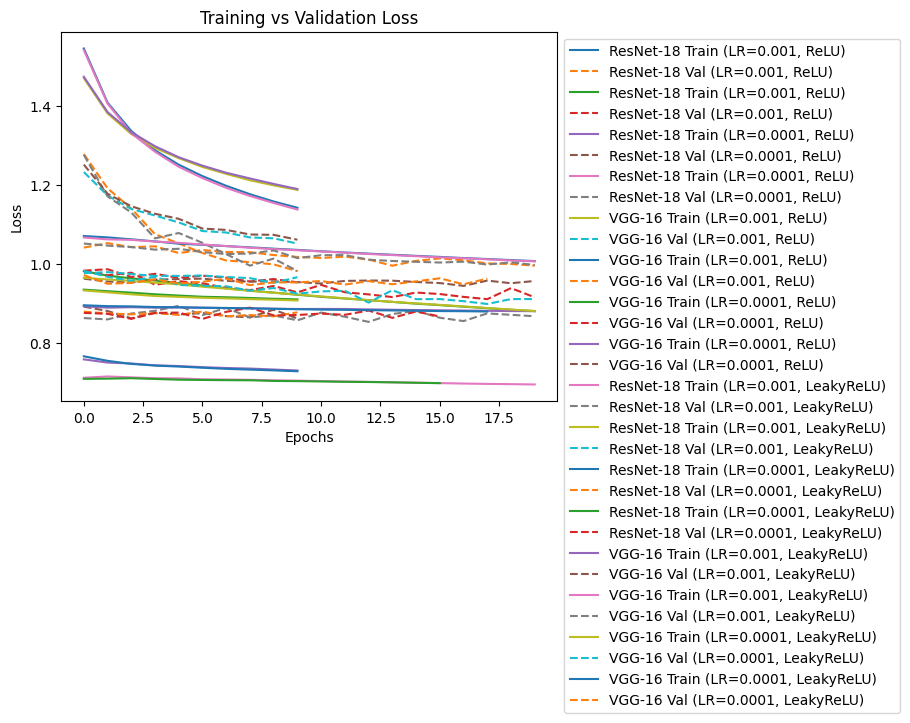

In [10]:
# all models traning and val loss
for result in total_results:
    model_name, epochs, lr, activation, train_loss, val_loss, avg_loss, acc, prec, rec, f1 = result
    plt.plot(train_loss, label=f"{model_name} Train (LR={lr}, {activation})")
    plt.plot(val_loss, label=f"{model_name} Val (LR={lr}, {activation})", linestyle="dashed")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


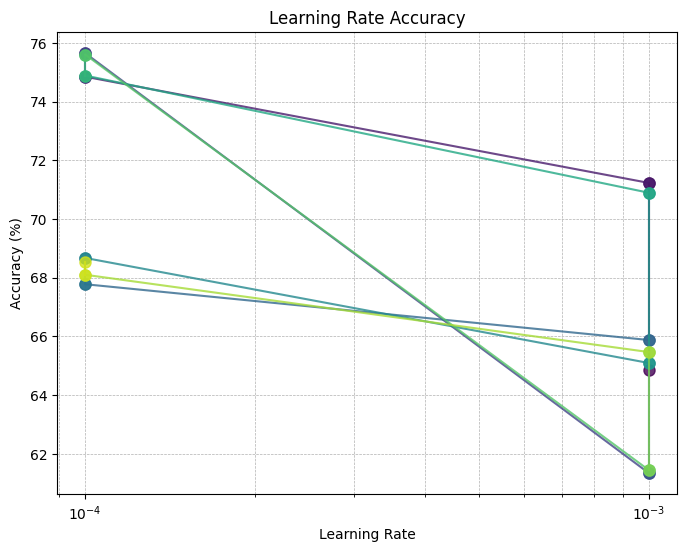

In [17]:
# compare accuracy between lr
plt.figure(figsize=(8, 6))
learning_r = [result[2] for result in total_results]
accuracies = [result[7] for result in total_results]
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))
for i in range(len(accuracies) - 1):
    plt.plot(
        [learning_r[i], learning_r[i + 1]],
        [accuracies[i], accuracies[i + 1]],
        marker='o', linestyle='-', markersize=8, alpha=0.8, color=colors[i]
    )
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.title("Learning Rate Accuracy")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()



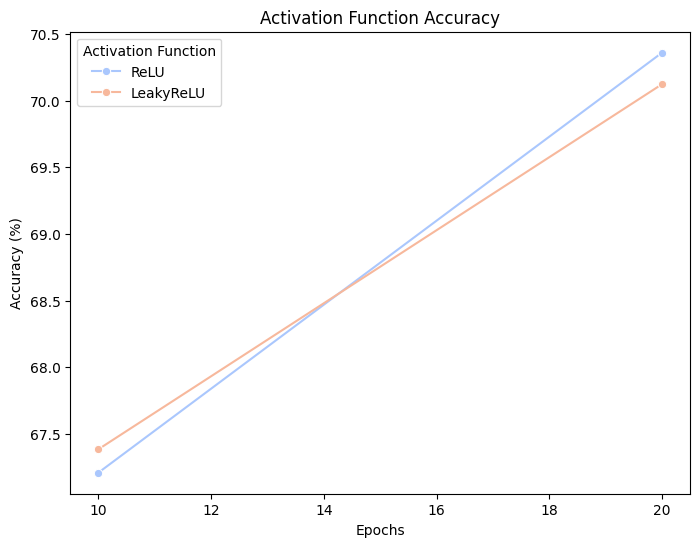

In [18]:
# compare acc between activation
df = pd.DataFrame(total_results, columns=["Model", "Epochs", "LR", "Activation", "Train Loss", "Val Loss", "Final Loss", "Accuracy", "Precision", "Recall", "F1"])
plt.figure(figsize=(8, 6))
sns.lineplot(x="Epochs", y="Accuracy", hue="Activation", data=df, marker="o", palette="coolwarm", errorbar = None)
plt.title("Activation Function Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(title="Activation Function")
plt.show()


In [24]:
# accuracy
def evaluate_model(model, model_name):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of {model_name} on the 10,000 test images: {100 * correct / total:.2f}%')

evaluate_model(resnet18, "ResNet-18")
evaluate_model(vgg16, "VGG-16")

Accuracy of ResNet-18 on the 10,000 test images: 70.76%
Accuracy of VGG-16 on the 10,000 test images: 67.81%


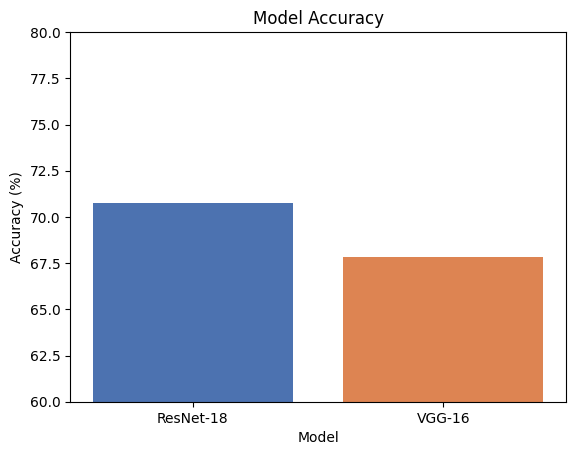

In [32]:
models = ["ResNet-18", "VGG-16"]
accuracies = [70.76, 67.81]
colors = ["#4C72B0", "#DD8452"]
plt.bar(models, accuracies, color= colors)
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy")
plt.ylim(60, 80)
plt.show()

In [27]:
# accuracy per class
def class_accuracy(model, model_name):
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    class_accuracy = {}
    print(f"\nClass-wise accuracy for {model_name}:")
    for i in range(10):
        if class_total[i] > 0:
          acc = (class_correct[i] / class_total[i]) * 100
        else:
          acc = 0
        print(f'Accuracy of {classes[i]}: {acc:.2f}%')
        class_accuracy[classes[i]] = acc

    return model_name, class_accuracy


In [28]:
resnet_class_acc = class_accuracy(resnet18, "ResNet-18")
vgg_class_acc = class_accuracy(vgg16, "VGG-16")
classes = list(resnet_class_acc[1].keys())
resnet_acc = list(resnet_class_acc[1].values())
vgg_acc = list(vgg_class_acc[1].values())


Class-wise accuracy for ResNet-18:
Accuracy of plane: 72.30%
Accuracy of car: 78.90%
Accuracy of bird: 65.20%
Accuracy of cat: 52.10%
Accuracy of deer: 64.80%
Accuracy of dog: 66.90%
Accuracy of frog: 82.60%
Accuracy of horse: 74.50%
Accuracy of ship: 79.10%
Accuracy of truck: 71.20%

Class-wise accuracy for VGG-16:
Accuracy of plane: 69.70%
Accuracy of car: 81.90%
Accuracy of bird: 58.00%
Accuracy of cat: 45.80%
Accuracy of deer: 57.20%
Accuracy of dog: 63.00%
Accuracy of frog: 82.10%
Accuracy of horse: 71.30%
Accuracy of ship: 78.00%
Accuracy of truck: 71.10%


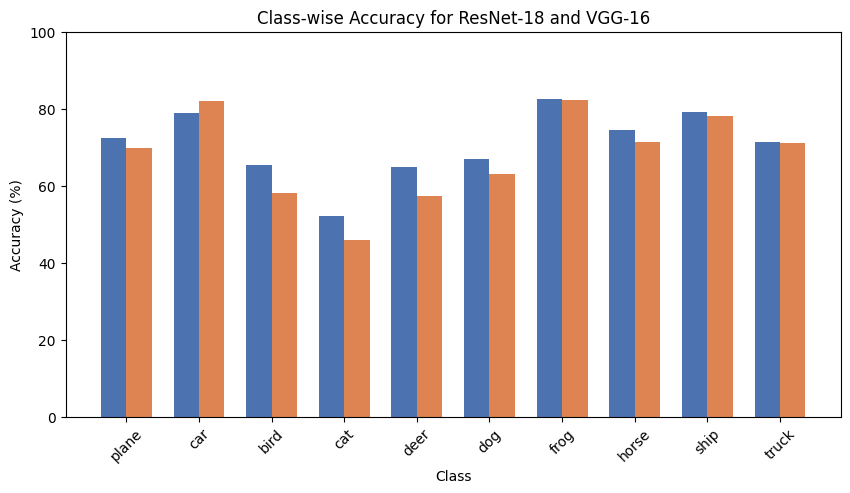

In [33]:
x = np.arange(len(classes))
width = 0.35
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, resnet_acc, width, label="ResNet-18", color="#4C72B0")
plt.bar(x + width/2, vgg_acc, width, label="VGG-16", color="#DD8452")
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy for ResNet-18 and VGG-16")
plt.xticks(x, classes, rotation=45)
plt.ylim(0, 100)
plt.show()


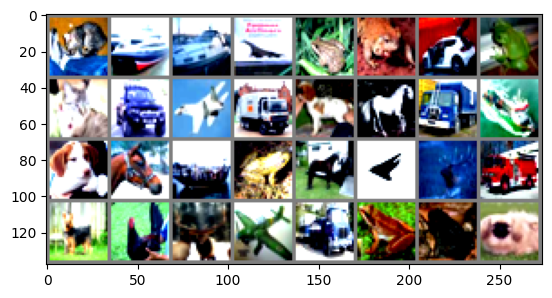

GroundTruth:    cat  ship  ship plane
Predicted:      cat  ship  ship plane


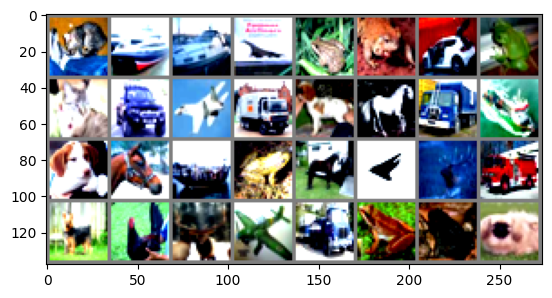

GroundTruth:    cat  ship  ship plane
Predicted:      cat  ship  ship  ship


In [15]:
# ground truth and prediction
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def predict_show(model, model_name):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
predict_show(resnet18, "ResNet-18")
predict_show(vgg16, "VGG-16")